In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

IQ signals Modulation_Label  \
0       [[-0.0059014712, -0.0023458179, -0.00074506126...             QPSK   
1       [[0.0050326153, 0.00094379985, -0.0018932355, ...             QPSK   
2       [[0.0052390713, 0.0073890695, 0.007276459, 0.0...             QPSK   
3       [[-0.0019859935, -0.0071501383, -0.00527185, -...             QPSK   
4       [[0.006674405, 0.0028359746, 0.005630027, 0.00...             QPSK   
...                                                   ...              ...   
219995  [[0.0062732296, -0.0050519477, 0.006672171, 0....             BPSK   
219996  [[-0.003903181, -0.0015884301, -0.00633375, 2....             BPSK   
219997  [[-0.0105958255, 0.005601244, -0.012161784, 0....             BPSK   
219998  [[-0.002136606, 0.00995837, 0.0059440527, -0.0...             BPSK   
219999  [[-0.008169517, 0.0013303901, -0.002522387, -0...             BPSK   

        SNR  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
219995  -18  
219996  -18  
219997  -18  
219998  -18  
219999  -18  

[220000 rows x 3 columns]

# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 2:17:19 - loss: 2.8651

  2/581 [..............................] - ETA: 37s - loss: 2.8109    

  3/581 [..............................] - ETA: 37s - loss: 2.7695

  4/581 [..............................] - ETA: 37s - loss: 2.7366

  5/581 [..............................] - ETA: 37s - loss: 2.7092

  6/581 [..............................] - ETA: 37s - loss: 2.6861

  7/581 [..............................] - ETA: 37s - loss: 2.6661

  8/581 [..............................] - ETA: 37s - loss: 2.6477

  9/581 [..............................] - ETA: 37s - loss: 2.6300

 10/581 [..............................] - ETA: 37s - loss: 2.6130

 11/581 [..............................] - ETA: 37s - loss: 2.5973

 12/581 [..............................] - ETA: 37s - loss: 2.5822

 13/581 [..............................] - ETA: 37s - loss: 2.5678

 14/581 [..............................] - ETA: 36s - loss: 2.5545

 15/581 [..............................] - ETA: 36s - loss: 2.5420

 16/581 [..............................] - ETA: 36s - loss: 2.5301

 17/581 [..............................] - ETA: 36s - loss: 2.5188

 18/581 [..............................] - ETA: 36s - loss: 2.5080

 19/581 [..............................] - ETA: 36s - loss: 2.4977

 20/581 [>.............................] - ETA: 36s - loss: 2.4880

 21/581 [>.............................] - ETA: 36s - loss: 2.4788

 22/581 [>.............................] - ETA: 36s - loss: 2.4698

 23/581 [>.............................] - ETA: 36s - loss: 2.4612

 24/581 [>.............................] - ETA: 36s - loss: 2.4528

 25/581 [>.............................] - ETA: 36s - loss: 2.4446

 26/581 [>.............................] - ETA: 36s - loss: 2.4366

 27/581 [>.............................] - ETA: 36s - loss: 2.4289

 28/581 [>.............................] - ETA: 36s - loss: 2.4213

 29/581 [>.............................] - ETA: 36s - loss: 2.4139

 30/581 [>.............................] - ETA: 36s - loss: 2.4067

 31/581 [>.............................] - ETA: 35s - loss: 2.3998



 32/581 [>.............................] - ETA: 35s - loss: 2.3929

 33/581 [>.............................] - ETA: 35s - loss: 2.3863

 34/581 [>.............................] - ETA: 35s - loss: 2.3799

 35/581 [>.............................] - ETA: 35s - loss: 2.3735

 36/581 [>.............................] - ETA: 35s - loss: 2.3674

 37/581 [>.............................] - ETA: 35s - loss: 2.3614

 38/581 [>.............................] - ETA: 35s - loss: 2.3555

 39/581 [=>............................] - ETA: 35s - loss: 2.3497

 40/581 [=>............................] - ETA: 35s - loss: 2.3440

 41/581 [=>............................] - ETA: 35s - loss: 2.3384

 42/581 [=>............................] - ETA: 35s - loss: 2.3329

 43/581 [=>............................] - ETA: 35s - loss: 2.3275

 44/581 [=>............................] - ETA: 35s - loss: 2.3221

 45/581 [=>............................] - ETA: 35s - loss: 2.3168

 46/581 [=>............................] - ETA: 34s - loss: 2.3116

 47/581 [=>............................] - ETA: 34s - loss: 2.3064

 48/581 [=>............................] - ETA: 34s - loss: 2.3013

 49/581 [=>............................] - ETA: 34s - loss: 2.2962

 50/581 [=>............................] - ETA: 34s - loss: 2.2912

 51/581 [=>............................] - ETA: 34s - loss: 2.2863

 52/581 [=>............................] - ETA: 34s - loss: 2.2814

 53/581 [=>............................] - ETA: 34s - loss: 2.2766

 54/581 [=>............................] - ETA: 34s - loss: 2.2718

 55/581 [=>............................] - ETA: 34s - loss: 2.2671

 56/581 [=>............................] - ETA: 34s - loss: 2.2625

 57/581 [=>............................] - ETA: 34s - loss: 2.2579

 58/581 [=>............................] - ETA: 34s - loss: 2.2534

 59/581 [==>...........................] - ETA: 34s - loss: 2.2489

 60/581 [==>...........................] - ETA: 34s - loss: 2.2444

 61/581 [==>...........................] - ETA: 33s - loss: 2.2400

 62/581 [==>...........................] - ETA: 33s - loss: 2.2357

 63/581 [==>...........................] - ETA: 33s - loss: 2.2314

 64/581 [==>...........................] - ETA: 33s - loss: 2.2271

 65/581 [==>...........................] - ETA: 33s - loss: 2.2229

 66/581 [==>...........................] - ETA: 33s - loss: 2.2187

 67/581 [==>...........................] - ETA: 33s - loss: 2.2146

 68/581 [==>...........................] - ETA: 33s - loss: 2.2105

 69/581 [==>...........................] - ETA: 33s - loss: 2.2064

 70/581 [==>...........................] - ETA: 33s - loss: 2.2024

 71/581 [==>...........................] - ETA: 33s - loss: 2.1984

 72/581 [==>...........................] - ETA: 33s - loss: 2.1944

 73/581 [==>...........................] - ETA: 33s - loss: 2.1905

 74/581 [==>...........................] - ETA: 33s - loss: 2.1866

 75/581 [==>...........................] - ETA: 33s - loss: 2.1828

 76/581 [==>...........................] - ETA: 33s - loss: 2.1790

 77/581 [==>...........................] - ETA: 32s - loss: 2.1752

 78/581 [===>..........................] - ETA: 32s - loss: 2.1715

 79/581 [===>..........................] - ETA: 32s - loss: 2.1678

 80/581 [===>..........................] - ETA: 32s - loss: 2.1642

 81/581 [===>..........................] - ETA: 32s - loss: 2.1605

 82/581 [===>..........................] - ETA: 32s - loss: 2.1570

 83/581 [===>..........................] - ETA: 32s - loss: 2.1534

 84/581 [===>..........................] - ETA: 32s - loss: 2.1499

 85/581 [===>..........................] - ETA: 32s - loss: 2.1465

 86/581 [===>..........................] - ETA: 32s - loss: 2.1430

 87/581 [===>..........................] - ETA: 32s - loss: 2.1396

 88/581 [===>..........................] - ETA: 32s - loss: 2.1363

 89/581 [===>..........................] - ETA: 32s - loss: 2.1329

 90/581 [===>..........................] - ETA: 32s - loss: 2.1296



 91/581 [===>..........................] - ETA: 32s - loss: 2.1263

 92/581 [===>..........................] - ETA: 31s - loss: 2.1231

 93/581 [===>..........................] - ETA: 31s - loss: 2.1198

 94/581 [===>..........................] - ETA: 31s - loss: 2.1167

 95/581 [===>..........................] - ETA: 31s - loss: 2.1135

 96/581 [===>..........................] - ETA: 31s - loss: 2.1104

 97/581 [====>.........................] - ETA: 31s - loss: 2.1072

 98/581 [====>.........................] - ETA: 31s - loss: 2.1042

 99/581 [====>.........................] - ETA: 31s - loss: 2.1011

100/581 [====>.........................] - ETA: 31s - loss: 2.0981

101/581 [====>.........................] - ETA: 31s - loss: 2.0951

102/581 [====>.........................] - ETA: 31s - loss: 2.0922

103/581 [====>.........................] - ETA: 31s - loss: 2.0892

104/581 [====>.........................] - ETA: 31s - loss: 2.0863



105/581 [====>.........................] - ETA: 31s - loss: 2.0834



106/581 [====>.........................] - ETA: 31s - loss: 2.0806



107/581 [====>.........................] - ETA: 31s - loss: 2.0777

108/581 [====>.........................] - ETA: 30s - loss: 2.0749

109/581 [====>.........................] - ETA: 30s - loss: 2.0721

110/581 [====>.........................] - ETA: 30s - loss: 2.0693



111/581 [====>.........................] - ETA: 30s - loss: 2.0666

112/581 [====>.........................] - ETA: 30s - loss: 2.0639

113/581 [====>.........................] - ETA: 30s - loss: 2.0612

114/581 [====>.........................] - ETA: 30s - loss: 2.0585

115/581 [====>.........................] - ETA: 30s - loss: 2.0558

116/581 [====>.........................] - ETA: 30s - loss: 2.0532

117/581 [=====>........................] - ETA: 30s - loss: 2.0506

118/581 [=====>........................] - ETA: 30s - loss: 2.0480

119/581 [=====>........................] - ETA: 30s - loss: 2.0454

120/581 [=====>........................] - ETA: 30s - loss: 2.0429

121/581 [=====>........................] - ETA: 30s - loss: 2.0404

122/581 [=====>........................] - ETA: 30s - loss: 2.0379

123/581 [=====>........................] - ETA: 29s - loss: 2.0354

124/581 [=====>........................] - ETA: 29s - loss: 2.0329

125/581 [=====>........................] - ETA: 29s - loss: 2.0305

126/581 [=====>........................] - ETA: 29s - loss: 2.0280

127/581 [=====>........................] - ETA: 29s - loss: 2.0256



128/581 [=====>........................] - ETA: 29s - loss: 2.0232

129/581 [=====>........................] - ETA: 29s - loss: 2.0209

130/581 [=====>........................] - ETA: 29s - loss: 2.0185

131/581 [=====>........................] - ETA: 29s - loss: 2.0162

132/581 [=====>........................] - ETA: 29s - loss: 2.0139

133/581 [=====>........................] - ETA: 29s - loss: 2.0116

134/581 [=====>........................] - ETA: 29s - loss: 2.0093

135/581 [=====>........................] - ETA: 29s - loss: 2.0070

136/581 [======>.......................] - ETA: 29s - loss: 2.0048

137/581 [======>.......................] - ETA: 29s - loss: 2.0025

138/581 [======>.......................] - ETA: 28s - loss: 2.0003

139/581 [======>.......................] - ETA: 28s - loss: 1.9981

140/581 [======>.......................] - ETA: 28s - loss: 1.9959

141/581 [======>.......................] - ETA: 28s - loss: 1.9938

142/581 [======>.......................] - ETA: 28s - loss: 1.9916

143/581 [======>.......................] - ETA: 28s - loss: 1.9895

144/581 [======>.......................] - ETA: 28s - loss: 1.9874

145/581 [======>.......................] - ETA: 28s - loss: 1.9853

146/581 [======>.......................] - ETA: 28s - loss: 1.9832

147/581 [======>.......................] - ETA: 28s - loss: 1.9811

148/581 [======>.......................] - ETA: 28s - loss: 1.9791

149/581 [======>.......................] - ETA: 28s - loss: 1.9770

150/581 [======>.......................] - ETA: 28s - loss: 1.9750

151/581 [======>.......................] - ETA: 28s - loss: 1.9730

152/581 [======>.......................] - ETA: 28s - loss: 1.9710

153/581 [======>.......................] - ETA: 28s - loss: 1.9690

154/581 [======>.......................] - ETA: 27s - loss: 1.9671



155/581 [=======>......................] - ETA: 27s - loss: 1.9651



156/581 [=======>......................] - ETA: 27s - loss: 1.9632

157/581 [=======>......................] - ETA: 27s - loss: 1.9613

158/581 [=======>......................] - ETA: 27s - loss: 1.9593

159/581 [=======>......................] - ETA: 27s - loss: 1.9575

160/581 [=======>......................] - ETA: 27s - loss: 1.9556

161/581 [=======>......................] - ETA: 27s - loss: 1.9537

162/581 [=======>......................] - ETA: 27s - loss: 1.9518

163/581 [=======>......................] - ETA: 27s - loss: 1.9500

164/581 [=======>......................] - ETA: 27s - loss: 1.9482

165/581 [=======>......................] - ETA: 27s - loss: 1.9463

166/581 [=======>......................] - ETA: 27s - loss: 1.9445

167/581 [=======>......................] - ETA: 27s - loss: 1.9427

168/581 [=======>......................] - ETA: 27s - loss: 1.9410

169/581 [=======>......................] - ETA: 26s - loss: 1.9392

170/581 [=======>......................] - ETA: 26s - loss: 1.9374

171/581 [=======>......................] - ETA: 26s - loss: 1.9357

172/581 [=======>......................] - ETA: 26s - loss: 1.9340

173/581 [=======>......................] - ETA: 26s - loss: 1.9322

174/581 [=======>......................] - ETA: 26s - loss: 1.9305

175/581 [========>.....................] - ETA: 26s - loss: 1.9288



176/581 [========>.....................] - ETA: 26s - loss: 1.9271

177/581 [========>.....................] - ETA: 26s - loss: 1.9255

178/581 [========>.....................] - ETA: 26s - loss: 1.9238

179/581 [========>.....................] - ETA: 26s - loss: 1.9221

180/581 [========>.....................] - ETA: 26s - loss: 1.9205

181/581 [========>.....................] - ETA: 26s - loss: 1.9188

182/581 [========>.....................] - ETA: 26s - loss: 1.9172

183/581 [========>.....................] - ETA: 26s - loss: 1.9156

184/581 [========>.....................] - ETA: 26s - loss: 1.9140

185/581 [========>.....................] - ETA: 25s - loss: 1.9124

186/581 [========>.....................] - ETA: 25s - loss: 1.9108

187/581 [========>.....................] - ETA: 25s - loss: 1.9092

188/581 [========>.....................] - ETA: 25s - loss: 1.9077

189/581 [========>.....................] - ETA: 25s - loss: 1.9061

190/581 [========>.....................] - ETA: 25s - loss: 1.9046

191/581 [========>.....................] - ETA: 25s - loss: 1.9030

192/581 [========>.....................] - ETA: 25s - loss: 1.9015

193/581 [========>.....................] - ETA: 25s - loss: 1.9000

194/581 [=========>....................] - ETA: 25s - loss: 1.8985

195/581 [=========>....................] - ETA: 25s - loss: 1.8970

196/581 [=========>....................] - ETA: 25s - loss: 1.8955

197/581 [=========>....................] - ETA: 25s - loss: 1.8940

198/581 [=========>....................] - ETA: 25s - loss: 1.8925

199/581 [=========>....................] - ETA: 25s - loss: 1.8911

200/581 [=========>....................] - ETA: 24s - loss: 1.8896

201/581 [=========>....................] - ETA: 24s - loss: 1.8882

202/581 [=========>....................] - ETA: 24s - loss: 1.8867

203/581 [=========>....................] - ETA: 24s - loss: 1.8853

204/581 [=========>....................] - ETA: 24s - loss: 1.8839

205/581 [=========>....................] - ETA: 24s - loss: 1.8824

206/581 [=========>....................] - ETA: 24s - loss: 1.8810

207/581 [=========>....................] - ETA: 24s - loss: 1.8796

208/581 [=========>....................] - ETA: 24s - loss: 1.8782

209/581 [=========>....................] - ETA: 24s - loss: 1.8769

210/581 [=========>....................] - ETA: 24s - loss: 1.8755

211/581 [=========>....................] - ETA: 24s - loss: 1.8741

212/581 [=========>....................] - ETA: 24s - loss: 1.8728

213/581 [=========>....................] - ETA: 24s - loss: 1.8714

214/581 [==========>...................] - ETA: 24s - loss: 1.8701

215/581 [==========>...................] - ETA: 23s - loss: 1.8687

216/581 [==========>...................] - ETA: 23s - loss: 1.8674

217/581 [==========>...................] - ETA: 23s - loss: 1.8661

218/581 [==========>...................] - ETA: 23s - loss: 1.8648

219/581 [==========>...................] - ETA: 23s - loss: 1.8634

220/581 [==========>...................] - ETA: 23s - loss: 1.8621

221/581 [==========>...................] - ETA: 23s - loss: 1.8609

222/581 [==========>...................] - ETA: 23s - loss: 1.8596

223/581 [==========>...................] - ETA: 23s - loss: 1.8583

224/581 [==========>...................] - ETA: 23s - loss: 1.8570

225/581 [==========>...................] - ETA: 23s - loss: 1.8557

226/581 [==========>...................] - ETA: 23s - loss: 1.8545

227/581 [==========>...................] - ETA: 23s - loss: 1.8532

228/581 [==========>...................] - ETA: 23s - loss: 1.8520

229/581 [==========>...................] - ETA: 23s - loss: 1.8508

230/581 [==========>...................] - ETA: 23s - loss: 1.8495

231/581 [==========>...................] - ETA: 22s - loss: 1.8483

232/581 [==========>...................] - ETA: 22s - loss: 1.8471

233/581 [===========>..................] - ETA: 22s - loss: 1.8459

234/581 [===========>..................] - ETA: 22s - loss: 1.8446

235/581 [===========>..................] - ETA: 22s - loss: 1.8434

236/581 [===========>..................] - ETA: 22s - loss: 1.8423



237/581 [===========>..................] - ETA: 22s - loss: 1.8411



238/581 [===========>..................] - ETA: 22s - loss: 1.8399



239/581 [===========>..................] - ETA: 22s - loss: 1.8387



240/581 [===========>..................] - ETA: 22s - loss: 1.8375

241/581 [===========>..................] - ETA: 22s - loss: 1.8364

242/581 [===========>..................] - ETA: 22s - loss: 1.8352

243/581 [===========>..................] - ETA: 22s - loss: 1.8340

244/581 [===========>..................] - ETA: 22s - loss: 1.8329



245/581 [===========>..................] - ETA: 22s - loss: 1.8317



246/581 [===========>..................] - ETA: 21s - loss: 1.8306



247/581 [===========>..................] - ETA: 21s - loss: 1.8295

248/581 [===========>..................] - ETA: 21s - loss: 1.8283



249/581 [===========>..................] - ETA: 21s - loss: 1.8272

250/581 [===========>..................] - ETA: 21s - loss: 1.8261

251/581 [===========>..................] - ETA: 21s - loss: 1.8250

252/581 [============>.................] - ETA: 21s - loss: 1.8239

253/581 [============>.................] - ETA: 21s - loss: 1.8228

254/581 [============>.................] - ETA: 21s - loss: 1.8217



255/581 [============>.................] - ETA: 21s - loss: 1.8206

256/581 [============>.................] - ETA: 21s - loss: 1.8195

257/581 [============>.................] - ETA: 21s - loss: 1.8184

258/581 [============>.................] - ETA: 21s - loss: 1.8174

259/581 [============>.................] - ETA: 21s - loss: 1.8163

260/581 [============>.................] - ETA: 21s - loss: 1.8152

261/581 [============>.................] - ETA: 20s - loss: 1.8142

262/581 [============>.................] - ETA: 20s - loss: 1.8131

263/581 [============>.................] - ETA: 20s - loss: 1.8121

264/581 [============>.................] - ETA: 20s - loss: 1.8110

265/581 [============>.................] - ETA: 20s - loss: 1.8100

266/581 [============>.................] - ETA: 20s - loss: 1.8089

267/581 [============>.................] - ETA: 20s - loss: 1.8079

268/581 [============>.................] - ETA: 20s - loss: 1.8069

269/581 [============>.................] - ETA: 20s - loss: 1.8058

270/581 [============>.................] - ETA: 20s - loss: 1.8048

271/581 [============>.................] - ETA: 20s - loss: 1.8038

272/581 [=============>................] - ETA: 20s - loss: 1.8028

273/581 [=============>................] - ETA: 20s - loss: 1.8018

274/581 [=============>................] - ETA: 20s - loss: 1.8008

275/581 [=============>................] - ETA: 20s - loss: 1.7998

276/581 [=============>................] - ETA: 19s - loss: 1.7988

277/581 [=============>................] - ETA: 19s - loss: 1.7978

278/581 [=============>................] - ETA: 19s - loss: 1.7968

279/581 [=============>................] - ETA: 19s - loss: 1.7959

280/581 [=============>................] - ETA: 19s - loss: 1.7949

281/581 [=============>................] - ETA: 19s - loss: 1.7939

282/581 [=============>................] - ETA: 19s - loss: 1.7929

283/581 [=============>................] - ETA: 19s - loss: 1.7920

284/581 [=============>................] - ETA: 19s - loss: 1.7910

285/581 [=============>................] - ETA: 19s - loss: 1.7901

286/581 [=============>................] - ETA: 19s - loss: 1.7891

287/581 [=============>................] - ETA: 19s - loss: 1.7882

288/581 [=============>................] - ETA: 19s - loss: 1.7872

289/581 [=============>................] - ETA: 19s - loss: 1.7863

290/581 [=============>................] - ETA: 19s - loss: 1.7854

291/581 [==============>...............] - ETA: 19s - loss: 1.7844

292/581 [==============>...............] - ETA: 18s - loss: 1.7835

293/581 [==============>...............] - ETA: 18s - loss: 1.7826

294/581 [==============>...............] - ETA: 18s - loss: 1.7817

295/581 [==============>...............] - ETA: 18s - loss: 1.7808



296/581 [==============>...............] - ETA: 18s - loss: 1.7798



297/581 [==============>...............] - ETA: 18s - loss: 1.7789



298/581 [==============>...............] - ETA: 18s - loss: 1.7780

299/581 [==============>...............] - ETA: 18s - loss: 1.7771



300/581 [==============>...............] - ETA: 18s - loss: 1.7762

301/581 [==============>...............] - ETA: 18s - loss: 1.7754

302/581 [==============>...............] - ETA: 18s - loss: 1.7745

303/581 [==============>...............] - ETA: 18s - loss: 1.7736

304/581 [==============>...............] - ETA: 18s - loss: 1.7727

305/581 [==============>...............] - ETA: 18s - loss: 1.7718

306/581 [==============>...............] - ETA: 18s - loss: 1.7710

307/581 [==============>...............] - ETA: 17s - loss: 1.7701

308/581 [==============>...............] - ETA: 17s - loss: 1.7692



309/581 [==============>...............] - ETA: 17s - loss: 1.7684



310/581 [===============>..............] - ETA: 17s - loss: 1.7675



311/581 [===============>..............] - ETA: 17s - loss: 1.7666

312/581 [===============>..............] - ETA: 17s - loss: 1.7658



313/581 [===============>..............] - ETA: 17s - loss: 1.7649

314/581 [===============>..............] - ETA: 17s - loss: 1.7641

315/581 [===============>..............] - ETA: 17s - loss: 1.7632

316/581 [===============>..............] - ETA: 17s - loss: 1.7624

317/581 [===============>..............] - ETA: 17s - loss: 1.7616

318/581 [===============>..............] - ETA: 17s - loss: 1.7607

319/581 [===============>..............] - ETA: 17s - loss: 1.7599

320/581 [===============>..............] - ETA: 17s - loss: 1.7591

321/581 [===============>..............] - ETA: 17s - loss: 1.7582

322/581 [===============>..............] - ETA: 16s - loss: 1.7574

323/581 [===============>..............] - ETA: 16s - loss: 1.7566

324/581 [===============>..............] - ETA: 16s - loss: 1.7558

325/581 [===============>..............] - ETA: 16s - loss: 1.7550

326/581 [===============>..............] - ETA: 16s - loss: 1.7542

327/581 [===============>..............] - ETA: 16s - loss: 1.7534

328/581 [===============>..............] - ETA: 16s - loss: 1.7526

329/581 [===============>..............] - ETA: 16s - loss: 1.7518

330/581 [================>.............] - ETA: 16s - loss: 1.7510

331/581 [================>.............] - ETA: 16s - loss: 1.7502

332/581 [================>.............] - ETA: 16s - loss: 1.7494

333/581 [================>.............] - ETA: 16s - loss: 1.7486

334/581 [================>.............] - ETA: 16s - loss: 1.7478

335/581 [================>.............] - ETA: 16s - loss: 1.7470

336/581 [================>.............] - ETA: 16s - loss: 1.7463

337/581 [================>.............] - ETA: 15s - loss: 1.7455

338/581 [================>.............] - ETA: 15s - loss: 1.7447

339/581 [================>.............] - ETA: 15s - loss: 1.7439

340/581 [================>.............] - ETA: 15s - loss: 1.7432

341/581 [================>.............] - ETA: 15s - loss: 1.7424

342/581 [================>.............] - ETA: 15s - loss: 1.7416

343/581 [================>.............] - ETA: 15s - loss: 1.7409

344/581 [================>.............] - ETA: 15s - loss: 1.7401

345/581 [================>.............] - ETA: 15s - loss: 1.7394

346/581 [================>.............] - ETA: 15s - loss: 1.7386

347/581 [================>.............] - ETA: 15s - loss: 1.7379

348/581 [================>.............] - ETA: 15s - loss: 1.7371

349/581 [=================>............] - ETA: 15s - loss: 1.7364

350/581 [=================>............] - ETA: 15s - loss: 1.7356

351/581 [=================>............] - ETA: 15s - loss: 1.7349

352/581 [=================>............] - ETA: 15s - loss: 1.7342

353/581 [=================>............] - ETA: 14s - loss: 1.7334

354/581 [=================>............] - ETA: 14s - loss: 1.7327

355/581 [=================>............] - ETA: 14s - loss: 1.7320



356/581 [=================>............] - ETA: 14s - loss: 1.7312



357/581 [=================>............] - ETA: 14s - loss: 1.7305



358/581 [=================>............] - ETA: 14s - loss: 1.7298

359/581 [=================>............] - ETA: 14s - loss: 1.7291

360/581 [=================>............] - ETA: 14s - loss: 1.7284

361/581 [=================>............] - ETA: 14s - loss: 1.7277

362/581 [=================>............] - ETA: 14s - loss: 1.7269

363/581 [=================>............] - ETA: 14s - loss: 1.7262

364/581 [=================>............] - ETA: 14s - loss: 1.7255

365/581 [=================>............] - ETA: 14s - loss: 1.7248

366/581 [=================>............] - ETA: 14s - loss: 1.7241

367/581 [=================>............] - ETA: 14s - loss: 1.7234

368/581 [==================>...........] - ETA: 13s - loss: 1.7227

369/581 [==================>...........] - ETA: 13s - loss: 1.7220

370/581 [==================>...........] - ETA: 13s - loss: 1.7213

371/581 [==================>...........] - ETA: 13s - loss: 1.7207

372/581 [==================>...........] - ETA: 13s - loss: 1.7200

373/581 [==================>...........] - ETA: 13s - loss: 1.7193

374/581 [==================>...........] - ETA: 13s - loss: 1.7186

375/581 [==================>...........] - ETA: 13s - loss: 1.7179

376/581 [==================>...........] - ETA: 13s - loss: 1.7173

377/581 [==================>...........] - ETA: 13s - loss: 1.7166

378/581 [==================>...........] - ETA: 13s - loss: 1.7159

379/581 [==================>...........] - ETA: 13s - loss: 1.7152

380/581 [==================>...........] - ETA: 13s - loss: 1.7146

381/581 [==================>...........] - ETA: 13s - loss: 1.7139

382/581 [==================>...........] - ETA: 13s - loss: 1.7132

383/581 [==================>...........] - ETA: 12s - loss: 1.7126

384/581 [==================>...........] - ETA: 12s - loss: 1.7119

385/581 [==================>...........] - ETA: 12s - loss: 1.7113

386/581 [==================>...........] - ETA: 12s - loss: 1.7106

387/581 [==================>...........] - ETA: 12s - loss: 1.7100

388/581 [===================>..........] - ETA: 12s - loss: 1.7093

389/581 [===================>..........] - ETA: 12s - loss: 1.7087

390/581 [===================>..........] - ETA: 12s - loss: 1.7080

391/581 [===================>..........] - ETA: 12s - loss: 1.7074

392/581 [===================>..........] - ETA: 12s - loss: 1.7067

393/581 [===================>..........] - ETA: 12s - loss: 1.7061

394/581 [===================>..........] - ETA: 12s - loss: 1.7055

395/581 [===================>..........] - ETA: 12s - loss: 1.7048

396/581 [===================>..........] - ETA: 12s - loss: 1.7042

397/581 [===================>..........] - ETA: 12s - loss: 1.7036

398/581 [===================>..........] - ETA: 11s - loss: 1.7029

399/581 [===================>..........] - ETA: 11s - loss: 1.7023

400/581 [===================>..........] - ETA: 11s - loss: 1.7017

401/581 [===================>..........] - ETA: 11s - loss: 1.7010

402/581 [===================>..........] - ETA: 11s - loss: 1.7004

403/581 [===================>..........] - ETA: 11s - loss: 1.6998

404/581 [===================>..........] - ETA: 11s - loss: 1.6992

405/581 [===================>..........] - ETA: 11s - loss: 1.6986

406/581 [===================>..........] - ETA: 11s - loss: 1.6980

407/581 [====================>.........] - ETA: 11s - loss: 1.6973

408/581 [====================>.........] - ETA: 11s - loss: 1.6967

409/581 [====================>.........] - ETA: 11s - loss: 1.6961

410/581 [====================>.........] - ETA: 11s - loss: 1.6955

411/581 [====================>.........] - ETA: 11s - loss: 1.6949

412/581 [====================>.........] - ETA: 11s - loss: 1.6943

413/581 [====================>.........] - ETA: 11s - loss: 1.6937

414/581 [====================>.........] - ETA: 10s - loss: 1.6931

415/581 [====================>.........] - ETA: 10s - loss: 1.6925

416/581 [====================>.........] - ETA: 10s - loss: 1.6919

417/581 [====================>.........] - ETA: 10s - loss: 1.6913

418/581 [====================>.........] - ETA: 10s - loss: 1.6907

419/581 [====================>.........] - ETA: 10s - loss: 1.6901

420/581 [====================>.........] - ETA: 10s - loss: 1.6895

421/581 [====================>.........] - ETA: 10s - loss: 1.6889

422/581 [====================>.........] - ETA: 10s - loss: 1.6884

423/581 [====================>.........] - ETA: 10s - loss: 1.6878

424/581 [====================>.........] - ETA: 10s - loss: 1.6872

425/581 [====================>.........] - ETA: 10s - loss: 1.6866

426/581 [====================>.........] - ETA: 10s - loss: 1.6860

427/581 [=====================>........] - ETA: 10s - loss: 1.6855

428/581 [=====================>........] - ETA: 10s - loss: 1.6849

429/581 [=====================>........] - ETA: 9s - loss: 1.6843 

430/581 [=====================>........] - ETA: 9s - loss: 1.6837

431/581 [=====================>........] - ETA: 9s - loss: 1.6832

432/581 [=====================>........] - ETA: 9s - loss: 1.6826

433/581 [=====================>........] - ETA: 9s - loss: 1.6820

434/581 [=====================>........] - ETA: 9s - loss: 1.6815

435/581 [=====================>........] - ETA: 9s - loss: 1.6809

436/581 [=====================>........] - ETA: 9s - loss: 1.6803

437/581 [=====================>........] - ETA: 9s - loss: 1.6798

438/581 [=====================>........] - ETA: 9s - loss: 1.6792

439/581 [=====================>........] - ETA: 9s - loss: 1.6787

440/581 [=====================>........] - ETA: 9s - loss: 1.6781

441/581 [=====================>........] - ETA: 9s - loss: 1.6776

442/581 [=====================>........] - ETA: 9s - loss: 1.6770

443/581 [=====================>........] - ETA: 9s - loss: 1.6765

444/581 [=====================>........] - ETA: 8s - loss: 1.6759

445/581 [=====================>........] - ETA: 8s - loss: 1.6754

446/581 [======================>.......] - ETA: 8s - loss: 1.6748

447/581 [======================>.......] - ETA: 8s - loss: 1.6743

448/581 [======================>.......] - ETA: 8s - loss: 1.6737

449/581 [======================>.......] - ETA: 8s - loss: 1.6732

450/581 [======================>.......] - ETA: 8s - loss: 1.6726



451/581 [======================>.......] - ETA: 8s - loss: 1.6721

452/581 [======================>.......] - ETA: 8s - loss: 1.6716

453/581 [======================>.......] - ETA: 8s - loss: 1.6710

454/581 [======================>.......] - ETA: 8s - loss: 1.6705

455/581 [======================>.......] - ETA: 8s - loss: 1.6700

456/581 [======================>.......] - ETA: 8s - loss: 1.6694

457/581 [======================>.......] - ETA: 8s - loss: 1.6689

458/581 [======================>.......] - ETA: 8s - loss: 1.6684

459/581 [======================>.......] - ETA: 8s - loss: 1.6679

460/581 [======================>.......] - ETA: 7s - loss: 1.6673



461/581 [======================>.......] - ETA: 7s - loss: 1.6668

462/581 [======================>.......] - ETA: 7s - loss: 1.6663

463/581 [======================>.......] - ETA: 7s - loss: 1.6658

464/581 [======================>.......] - ETA: 7s - loss: 1.6653

465/581 [=======================>......] - ETA: 7s - loss: 1.6647

466/581 [=======================>......] - ETA: 7s - loss: 1.6642

467/581 [=======================>......] - ETA: 7s - loss: 1.6637

468/581 [=======================>......] - ETA: 7s - loss: 1.6632

469/581 [=======================>......] - ETA: 7s - loss: 1.6627

470/581 [=======================>......] - ETA: 7s - loss: 1.6622



471/581 [=======================>......] - ETA: 7s - loss: 1.6617

472/581 [=======================>......] - ETA: 7s - loss: 1.6612



473/581 [=======================>......] - ETA: 7s - loss: 1.6607

474/581 [=======================>......] - ETA: 7s - loss: 1.6602

475/581 [=======================>......] - ETA: 6s - loss: 1.6597

476/581 [=======================>......] - ETA: 6s - loss: 1.6592

477/581 [=======================>......] - ETA: 6s - loss: 1.6587

478/581 [=======================>......] - ETA: 6s - loss: 1.6582

479/581 [=======================>......] - ETA: 6s - loss: 1.6577

480/581 [=======================>......] - ETA: 6s - loss: 1.6572

481/581 [=======================>......] - ETA: 6s - loss: 1.6567

482/581 [=======================>......] - ETA: 6s - loss: 1.6562

483/581 [=======================>......] - ETA: 6s - loss: 1.6557

484/581 [=======================>......] - ETA: 6s - loss: 1.6552



485/581 [========================>.....] - ETA: 6s - loss: 1.6547

486/581 [========================>.....] - ETA: 6s - loss: 1.6542

487/581 [========================>.....] - ETA: 6s - loss: 1.6537

488/581 [========================>.....] - ETA: 6s - loss: 1.6533

489/581 [========================>.....]

 - ETA: 6s - loss: 1.6528

490/581 [========================>.....] - ETA: 5s - loss: 1.6523



491/581 [========================>.....] - ETA: 5s - loss: 1.6518

492/581 [========================>.....] - ETA: 5s - loss: 1.6513

493/581 [========================>.....] - ETA: 5s - loss: 1.6508

494/581 [========================>.....] - ETA: 5s - loss: 1.6504

495/581 [========================>.....] - ETA: 5s - loss: 1.6499



496/581 [========================>.....] - ETA: 5s - loss: 1.6494

497/581 [========================>.....] - ETA: 5s - loss: 1.6489

498/581 [========================>.....] - ETA: 5s - loss: 1.6485

499/581 [========================>.....] - ETA: 5s - loss: 1.6480

500/581 [========================>.....] - ETA: 5s - loss: 1.6475

501/581 [========================>.....] - ETA: 5s - loss: 1.6471

502/581 [========================>.....] - ETA: 5s - loss: 1.6466

503/581 [========================>.....] - ETA: 5s - loss: 1.6461

504/581 [=========================>....] - ETA: 5s - loss: 1.6457

505/581 [=========================>....] - ETA: 4s - loss: 1.6452

506/581 [=========================>....] - ETA: 4s - loss: 1.6447

507/581 [=========================>....] - ETA: 4s - loss: 1.6443

508/581 [=========================>....] - ETA: 4s - loss: 1.6438

509/581 [=========================>....] - ETA: 4s - loss: 1.6434

510/581 [=========================>....] - ETA: 4s - loss: 1.6429

511/581 [=========================>....] - ETA: 4s - loss: 1.6424

512/581 [=========================>....] - ETA: 4s - loss: 1.6420

513/581 [=========================>....] - ETA: 4s - loss: 1.6415

514/581 [=========================>....] - ETA: 4s - loss: 1.6411

515/581 [=========================>....] - ETA: 4s - loss: 1.6406

516/581 [=========================>....] - ETA: 4s - loss: 1.6402

517/581 [=========================>....] - ETA: 4s - loss: 1.6397

518/581 [=========================>....] - ETA: 4s - loss: 1.6393

519/581 [=========================>....] - ETA: 4s - loss: 1.6388

520/581 [=========================>....] - ETA: 4s - loss: 1.6384

521/581 [=========================>....] - ETA: 3s - loss: 1.6379



522/581 [=========================>....] - ETA: 3s - loss: 1.6375



523/581 [==========================>...] - ETA: 3s - loss: 1.6371

524/581 [==========================>...] - ETA: 3s - loss: 1.6366

525/581 [==========================>...] - ETA: 3s - loss: 1.6362

526/581 [==========================>...] - ETA: 3s - loss: 1.6357

527/581 [==========================>...] - ETA: 3s - loss: 1.6353

528/581 [==========================>...] - ETA: 3s - loss: 1.6349

529/581 [==========================>...] - ETA: 3s - loss: 1.6344

530/581 [==========================>...] - ETA: 3s - loss: 1.6340

531/581 [==========================>...] - ETA: 3s - loss: 1.6335

532/581 [==========================>...] - ETA: 3s - loss: 1.6331

533/581 [==========================>...] - ETA: 3s - loss: 1.6327

534/581 [==========================>...] - ETA: 3s - loss: 1.6322

535/581 [==========================>...] - ETA: 3s - loss: 1.6318

536/581 [==========================>...] - ETA: 2s - loss: 1.6314

537/581 [==========================>...] - ETA: 2s - loss: 1.6310

538/581 [==========================>...] - ETA: 2s - loss: 1.6305

539/581 [==========================>...] - ETA: 2s - loss: 1.6301

540/581 [==========================>...] - ETA: 2s - loss: 1.6297

541/581 [==========================>...] - ETA: 2s - loss: 1.6293

542/581 [==========================>...] - ETA: 2s - loss: 1.6288

543/581 [===========================>..] - ETA: 2s - loss: 1.6284

544/581 [===========================>..] - ETA: 2s - loss: 1.6280



545/581 [===========================>..] - ETA: 2s - loss: 1.6276



546/581 [===========================>..] - ETA: 2s - loss: 1.6271

547/581 [===========================>..] - ETA: 2s - loss: 1.6267



548/581 [===========================>..] - ETA: 2s - loss: 1.6263



549/581 [===========================>..] - ETA: 2s - loss: 1.6259



550/581 [===========================>..] - ETA: 2s - loss: 1.6255

551/581 [===========================>..] - ETA: 1s - loss: 1.6251

552/581 [===========================>..] - ETA: 1s - loss: 1.6246

553/581 [===========================>..] - ETA: 1s - loss: 1.6242

554/581 [===========================>..] - ETA: 1s - loss: 1.6238

555/581 [===========================>..] - ETA: 1s - loss: 1.6234

556/581 [===========================>..] - ETA: 1s - loss: 1.6230

557/581 [===========================>..] - ETA: 1s - loss: 1.6226

558/581 [===========================>..] - ETA: 1s - loss: 1.6222

559/581 [===========================>..] - ETA: 1s - loss: 1.6218

560/581 [===========================>..] - ETA: 1s - loss: 1.6214

561/581 [===========================>..] - ETA: 1s - loss: 1.6210

562/581 [============================>.] - ETA: 1s - loss: 1.6206

563/581 [============================>.] - ETA: 1s - loss: 1.6202

564/581 [============================>.] - ETA: 1s - loss: 1.6198

565/581 [============================>.] - ETA: 1s - loss: 1.6194

566/581 [============================>.] - ETA: 0s - loss: 1.6190

567/581 [============================>.] - ETA: 0s - loss: 1.6186

568/581 [============================>.] - ETA: 0s - loss: 1.6182



569/581 [============================>.] - ETA: 0s - loss: 1.6178

570/581 [============================>.] - ETA: 0s - loss: 1.6174

571/581 [============================>.] - ETA: 0s - loss: 1.6170

572/581 [============================>.] - ETA: 0s - loss: 1.6166

573/581 [============================>.] - ETA: 0s - loss: 1.6162

574/581 [============================>.] - ETA: 0s - loss: 1.6158

575/581 [============================>.] - ETA: 0s - loss: 1.6154

576/581 [============================>.] - ETA: 0s - loss: 1.6150

577/581 [============================>.] - ETA: 0s - loss: 1.6146

578/581 [============================>.] - ETA: 0s - loss: 1.6142

579/581 [============================>.] - ETA: 0s - loss: 1.6138

580/581 [============================>.] - ETA: 0s - loss: 1.6134

581/581 [==============================] - ETA: 0s - loss: 1.6130

581/581 [==============================] - 55s 70ms/step - loss: 1.6127 - val_loss: 7.5188


Epoch 2/100
  1/581 [..............................] - ETA: 38s - loss: 1.1518

  2/581 [..............................] - ETA: 37s - loss: 1.1834

  3/581 [..............................] - ETA: 37s - loss: 1.2060

  4/581 [..............................] - ETA: 38s - loss: 1.2145

  5/581 [..............................] - ETA: 37s - loss: 1.2200

  6/581 [..............................] - ETA: 37s - loss: 1.2243

  7/581 [..............................] - ETA: 37s - loss: 1.2275

  8/581 [..............................] - ETA: 37s - loss: 1.2289

  9/581 [..............................] - ETA: 37s - loss: 1.2301

 10/581 [..............................] - ETA: 37s - loss: 1.2307

 11/581 [..............................] - ETA: 37s - loss: 1.2312

 12/581 [..............................] - ETA: 37s - loss: 1.2314

 13/581 [..............................] - ETA: 37s - loss: 1.2316

 14/581 [..............................] - ETA: 37s - loss: 1.2315

 15/581 [..............................] - ETA: 37s - loss: 1.2313

 16/581 [..............................] - ETA: 37s - loss: 1.2311

 17/581 [..............................] - ETA: 37s - loss: 1.2308

 18/581 [..............................] - ETA: 37s - loss: 1.2309

 19/581 [..............................] - ETA: 37s - loss: 1.2309

 20/581 [>.............................] - ETA: 36s - loss: 1.2307

 21/581 [>.............................] - ETA: 36s - loss: 1.2307

 22/581 [>.............................] - ETA: 36s - loss: 1.2305

 23/581 [>.............................] - ETA: 36s - loss: 1.2305

 24/581 [>.............................] - ETA: 36s - loss: 1.2305

 25/581 [>.............................] - ETA: 36s - loss: 1.2306

 26/581 [>.............................] - ETA: 36s - loss: 1.2307

 27/581 [>.............................] - ETA: 36s - loss: 1.2307

 28/581 [>.............................] - ETA: 36s - loss: 1.2308

 29/581 [>.............................] - ETA: 36s - loss: 1.2309

 30/581 [>.............................] - ETA: 36s - loss: 1.2309

 31/581 [>.............................] - ETA: 36s - loss: 1.2309

 32/581 [>.............................] - ETA: 36s - loss: 1.2309

 33/581 [>.............................] - ETA: 36s - loss: 1.2309

 34/581 [>.............................] - ETA: 36s - loss: 1.2309

 35/581 [>.............................] - ETA: 35s - loss: 1.2309

 36/581 [>.............................] - ETA: 35s - loss: 1.2309

 37/581 [>.............................] - ETA: 35s - loss: 1.2310

 38/581 [>.............................] - ETA: 35s - loss: 1.2309

 39/581 [=>............................] - ETA: 35s - loss: 1.2309

 40/581 [=>............................] - ETA: 35s - loss: 1.2309

 41/581 [=>............................] - ETA: 35s - loss: 1.2308

 42/581 [=>............................] - ETA: 35s - loss: 1.2308

 43/581 [=>............................] - ETA: 35s - loss: 1.2307

 44/581 [=>............................] - ETA: 35s - loss: 1.2306

 45/581 [=>............................] - ETA: 35s - loss: 1.2305



 46/581 [=>............................] - ETA: 35s - loss: 1.2304

 47/581 [=>............................] - ETA: 35s - loss: 1.2303

 48/581 [=>............................] - ETA: 35s - loss: 1.2302

 49/581 [=>............................] - ETA: 34s - loss: 1.2301

 50/581 [=>............................] - ETA: 34s - loss: 1.2301

 51/581 [=>............................] - ETA: 34s - loss: 1.2300

 52/581 [=>............................] - ETA: 34s - loss: 1.2299

 53/581 [=>............................]

 - ETA: 34s - loss: 1.2298

 54/581 [=>............................] - ETA: 34s - loss: 1.2297

 55/581 [=>............................] - ETA: 34s - loss: 1.2296

 56/581 [=>............................] - ETA: 34s - loss: 1.2295

 57/581 [=>............................] - ETA: 34s - loss: 1.2294

 58/581 [=>............................] - ETA: 34s - loss: 1.2294

 59/581 [==>...........................] - ETA: 34s - loss: 1.2293

 60/581 [==>...........................] - ETA: 34s - loss: 1.2292

 61/581 [==>...........................] - ETA: 34s - loss: 1.2292

 62/581 [==>...........................] - ETA: 34s - loss: 1.2291

 63/581 [==>...........................] - ETA: 34s - loss: 1.2291

 64/581 [==>...........................] - ETA: 33s - loss: 1.2290

 65/581 [==>...........................] - ETA: 33s - loss: 1.2289

 66/581 [==>...........................] - ETA: 33s - loss: 1.2289



 67/581 [==>...........................] - ETA: 33s - loss: 1.2288

 68/581 [==>...........................] - ETA: 33s - loss: 1.2288

 69/581 [==>...........................] - ETA: 33s - loss: 1.2287

 70/581 [==>...........................] - ETA: 33s - loss: 1.2286

 71/581 [==>...........................] - ETA: 33s - loss: 1.2286

 72/581 [==>...........................] - ETA: 33s - loss: 1.2285

 73/581 [==>...........................] - ETA: 33s - loss: 1.2284

 74/581 [==>...........................] - ETA: 33s - loss: 1.2283

 75/581 [==>...........................] - ETA: 33s - loss: 1.2283

 76/581 [==>...........................] - ETA: 33s - loss: 1.2282

 77/581 [==>...........................] - ETA: 33s - loss: 1.2282

 78/581 [===>..........................] - ETA: 33s - loss: 1.2281

 79/581 [===>..........................] - ETA: 32s - loss: 1.2280

 80/581 [===>..........................] - ETA: 32s - loss: 1.2280

 81/581 [===>..........................] - ETA: 32s - loss: 1.2279

 82/581 [===>..........................] - ETA: 32s - loss: 1.2278

 83/581 [===>..........................]

 - ETA: 32s - loss: 1.2278

 84/581 [===>..........................] - ETA: 32s - loss: 1.2277

 85/581 [===>..........................] - ETA: 32s - loss: 1.2277

 86/581 [===>..........................] - ETA: 32s - loss: 1.2276

 87/581 [===>..........................] - ETA: 32s - loss: 1.2275

 88/581 [===>..........................] - ETA: 32s - loss: 1.2275

 89/581 [===>..........................] - ETA: 32s - loss: 1.2274

 90/581 [===>..........................] - ETA: 32s - loss: 1.2273

 91/581 [===>..........................] - ETA: 32s - loss: 1.2272

 92/581 [===>..........................] - ETA: 32s - loss: 1.2271

 93/581 [===>..........................] - ETA: 32s - loss: 1.2271

 94/581 [===>..........................] - ETA: 32s - loss: 1.2270

 95/581 [===>..........................] - ETA: 31s - loss: 1.2269

 96/581 [===>..........................] - ETA: 31s - loss: 1.2268

 97/581 [====>.........................] - ETA: 31s - loss: 1.2267

 98/581 [====>.........................] - ETA: 31s - loss: 1.2267

 99/581 [====>.........................] - ETA: 31s - loss: 1.2266

100/581 [====>.........................] - ETA: 31s - loss: 1.2265

101/581 [====>.........................] - ETA: 31s - loss: 1.2265

102/581 [====>.........................] - ETA: 31s - loss: 1.2264

103/581 [====>.........................] - ETA: 31s - loss: 1.2263

104/581 [====>.........................] - ETA: 31s - loss: 1.2263

105/581 [====>.........................] - ETA: 31s - loss: 1.2262

106/581 [====>.........................] - ETA: 31s - loss: 1.2261

107/581 [====>.........................] - ETA: 31s - loss: 1.2261

108/581 [====>.........................] - ETA: 31s - loss: 1.2260

109/581 [====>.........................] - ETA: 31s - loss: 1.2260

110/581 [====>.........................] - ETA: 30s - loss: 1.2259



111/581 [====>.........................] - ETA: 30s - loss: 1.2259



112/581 [====>.........................] - ETA: 30s - loss: 1.2258



113/581 [====>.........................] - ETA: 30s - loss: 1.2257

114/581 [====>.........................] - ETA: 30s - loss: 1.2257

115/581 [====>.........................] - ETA: 30s - loss: 1.2256

116/581 [====>.........................] - ETA: 30s - loss: 1.2256

117/581 [=====>........................] - ETA: 30s - loss: 1.2255

118/581 [=====>........................] - ETA: 30s - loss: 1.2254

119/581 [=====>........................] - ETA: 30s - loss: 1.2254

120/581 [=====>........................] - ETA: 30s - loss: 1.2253

121/581 [=====>........................] - ETA: 30s - loss: 1.2253

122/581 [=====>........................] - ETA: 30s - loss: 1.2252

123/581 [=====>........................] - ETA: 30s - loss: 1.2251

124/581 [=====>........................] - ETA: 30s - loss: 1.2251

125/581 [=====>........................] - ETA: 29s - loss: 1.2250

126/581 [=====>........................] - ETA: 29s - loss: 1.2250

127/581 [=====>........................] - ETA: 29s - loss: 1.2249

128/581 [=====>........................] - ETA: 29s - loss: 1.2249

129/581 [=====>........................] - ETA: 29s - loss: 1.2248

130/581 [=====>........................] - ETA: 29s - loss: 1.2248

131/581 [=====>........................] - ETA: 29s - loss: 1.2247

132/581 [=====>........................] - ETA: 29s - loss: 1.2247

133/581 [=====>........................] - ETA: 29s - loss: 1.2246

134/581 [=====>........................] - ETA: 29s - loss: 1.2246

135/581 [=====>........................] - ETA: 29s - loss: 1.2245

136/581 [======>.......................] - ETA: 29s - loss: 1.2245

137/581 [======>.......................] - ETA: 29s - loss: 1.2244

138/581 [======>.......................] - ETA: 29s - loss: 1.2244

139/581 [======>.......................] - ETA: 29s - loss: 1.2243

140/581 [======>.......................] - ETA: 28s - loss: 1.2243

141/581 [======>.......................] - ETA: 28s - loss: 1.2242

142/581 [======>.......................] - ETA: 28s - loss: 1.2242

143/581 [======>.......................] - ETA: 28s - loss: 1.2241

144/581 [======>.......................] - ETA: 28s - loss: 1.2241

145/581 [======>.......................] - ETA: 28s - loss: 1.2240

146/581 [======>.......................] - ETA: 28s - loss: 1.2240

147/581 [======>.......................] - ETA: 28s - loss: 1.2239

148/581 [======>.......................] - ETA: 28s - loss: 1.2239

149/581 [======>.......................] - ETA: 28s - loss: 1.2238

150/581 [======>.......................] - ETA: 28s - loss: 1.2238

151/581 [======>.......................] - ETA: 28s - loss: 1.2237

152/581 [======>.......................] - ETA: 28s - loss: 1.2237

153/581 [======>.......................] - ETA: 28s - loss: 1.2236

154/581 [======>.......................] - ETA: 28s - loss: 1.2236

155/581 [=======>......................] - ETA: 28s - loss: 1.2236

156/581 [=======>......................] - ETA: 27s - loss: 1.2235

157/581 [=======>......................] - ETA: 27s - loss: 1.2235

158/581 [=======>......................] - ETA: 27s - loss: 1.2234

159/581 [=======>......................] - ETA: 27s - loss: 1.2234

160/581 [=======>......................] - ETA: 27s - loss: 1.2234

161/581 [=======>......................] - ETA: 27s - loss: 1.2233

162/581 [=======>......................] - ETA: 27s - loss: 1.2233

163/581 [=======>......................] - ETA: 27s - loss: 1.2232

164/581 [=======>......................] - ETA: 27s - loss: 1.2232

165/581 [=======>......................] - ETA: 27s - loss: 1.2231

166/581 [=======>......................] - ETA: 27s - loss: 1.2231

167/581 [=======>......................] - ETA: 27s - loss: 1.2231

168/581 [=======>......................] - ETA: 27s - loss: 1.2230

169/581 [=======>......................] - ETA: 27s - loss: 1.2230

170/581 [=======>......................] - ETA: 27s - loss: 1.2229

171/581 [=======>......................] - ETA: 26s - loss: 1.2229

172/581 [=======>......................] - ETA: 26s - loss: 1.2228

173/581 [=======>......................] - ETA: 26s - loss: 1.2228

174/581 [=======>......................] - ETA: 26s - loss: 1.2227

175/581 [========>.....................] - ETA: 26s - loss: 1.2227

176/581 [========>.....................] - ETA: 26s - loss: 1.2227

177/581 [========>.....................] - ETA: 26s - loss: 1.2226

178/581 [========>.....................] - ETA: 26s - loss: 1.2226

179/581 [========>.....................] - ETA: 26s - loss: 1.2225

180/581 [========>.....................] - ETA: 26s - loss: 1.2225

181/581 [========>.....................] - ETA: 26s - loss: 1.2224

182/581 [========>.....................] - ETA: 26s - loss: 1.2224

183/581 [========>.....................] - ETA: 26s - loss: 1.2224

184/581 [========>.....................] - ETA: 26s - loss: 1.2223

185/581 [========>.....................] - ETA: 26s - loss: 1.2223

186/581 [========>.....................] - ETA: 25s - loss: 1.2222

187/581 [========>.....................] - ETA: 25s - loss: 1.2222

188/581 [========>.....................] - ETA: 25s - loss: 1.2222

189/581 [========>.....................] - ETA: 25s - loss: 1.2221

190/581 [========>.....................] - ETA: 25s - loss: 1.2221

191/581 [========>.....................] - ETA: 25s - loss: 1.2220

192/581 [========>.....................] - ETA: 25s - loss: 1.2220

193/581 [========>.....................] - ETA: 25s - loss: 1.2220

194/581 [=========>....................] - ETA: 25s - loss: 1.2219

195/581 [=========>....................] - ETA: 25s - loss: 1.2219

196/581 [=========>....................] - ETA: 25s - loss: 1.2218

197/581 [=========>....................] - ETA: 25s - loss: 1.2218

198/581 [=========>....................] - ETA: 25s - loss: 1.2217

199/581 [=========>....................] - ETA: 25s - loss: 1.2217

200/581 [=========>....................]

 - ETA: 25s - loss: 1.2217

201/581 [=========>....................] - ETA: 24s - loss: 1.2216

202/581 [=========>....................] - ETA: 24s - loss: 1.2216

203/581 [=========>....................] - ETA: 24s - loss: 1.2215

204/581 [=========>....................] - ETA: 24s - loss: 1.2215

205/581 [=========>....................] - ETA: 24s - loss: 1.2215

206/581 [=========>....................] - ETA: 24s - loss: 1.2214

207/581 [=========>....................] - ETA: 24s - loss: 1.2214

208/581 [=========>....................] - ETA: 24s - loss: 1.2214

209/581 [=========>....................] - ETA: 24s - loss: 1.2213

210/581 [=========>....................] - ETA: 24s - loss: 1.2213

211/581 [=========>....................] - ETA: 24s - loss: 1.2213

212/581 [=========>....................]

 - ETA: 24s - loss: 1.2212

213/581 [=========>....................] - ETA: 24s - loss: 1.2212

214/581 [==========>...................] - ETA: 24s - loss: 1.2211

215/581 [==========>...................] - ETA: 24s - loss: 1.2211

216/581 [==========>...................] - ETA: 24s - loss: 1.2211

217/581 [==========>...................] - ETA: 23s - loss: 1.2210

218/581 [==========>...................] - ETA: 23s - loss: 1.2210

219/581 [==========>...................] - ETA: 23s - loss: 1.2209

220/581 [==========>...................] - ETA: 23s - loss: 1.2209

221/581 [==========>...................] - ETA: 23s - loss: 1.2209

222/581 [==========>...................] - ETA: 23s - loss: 1.2208

223/581 [==========>...................] - ETA: 23s - loss: 1.2208

224/581 [==========>...................] - ETA: 23s - loss: 1.2208

225/581 [==========>...................] - ETA: 23s - loss: 1.2207

226/581 [==========>...................] - ETA: 23s - loss: 1.2207

227/581 [==========>...................] - ETA: 23s - loss: 1.2207

228/581 [==========>...................] - ETA: 23s - loss: 1.2206

229/581 [==========>...................] - ETA: 23s - loss: 1.2206



230/581 [==========>...................] - ETA: 23s - loss: 1.2205

231/581 [==========>...................] - ETA: 23s - loss: 1.2205



232/581 [==========>...................] - ETA: 22s - loss: 1.2205



233/581 [===========>..................] - ETA: 22s - loss: 1.2204



234/581 [===========>..................] - ETA: 22s - loss: 1.2204



235/581 [===========>..................] - ETA: 22s - loss: 1.2204

236/581 [===========>..................] - ETA: 22s - loss: 1.2203

237/581 [===========>..................] - ETA: 22s - loss: 1.2203

238/581 [===========>..................] - ETA: 22s - loss: 1.2203

239/581 [===========>..................] - ETA: 22s - loss: 1.2202

240/581 [===========>..................] - ETA: 22s - loss: 1.2202

241/581 [===========>..................] - ETA: 22s - loss: 1.2202

242/581 [===========>..................] - ETA: 22s - loss: 1.2201

243/581 [===========>..................] - ETA: 22s - loss: 1.2201

244/581 [===========>..................] - ETA: 22s - loss: 1.2201

245/581 [===========>..................] - ETA: 22s - loss: 1.2200

246/581 [===========>..................] - ETA: 22s - loss: 1.2200

247/581 [===========>..................]

 - ETA: 21s - loss: 1.2199

248/581 [===========>..................] - ETA: 21s - loss: 1.2199

249/581 [===========>..................] - ETA: 21s - loss: 1.2199

250/581 [===========>..................] - ETA: 21s - loss: 1.2198

251/581 [===========>..................] - ETA: 21s - loss: 1.2198

252/581 [============>.................] - ETA: 21s - loss: 1.2198

253/581 [============>.................] - ETA: 21s - loss: 1.2197

254/581 [============>.................] - ETA: 21s - loss: 1.2197

255/581 [============>.................] - ETA: 21s - loss: 1.2196

256/581 [============>.................] - ETA: 21s - loss: 1.2196

257/581 [============>.................] - ETA: 21s - loss: 1.2196

258/581 [============>.................] - ETA: 21s - loss: 1.2195

259/581 [============>.................] - ETA: 21s - loss: 1.2195

260/581 [============>.................] - ETA: 21s - loss: 1.2194

261/581 [============>.................] - ETA: 21s - loss: 1.2194

262/581 [============>.................] - ETA: 20s - loss: 1.2194

263/581 [============>.................] - ETA: 20s - loss: 1.2193

264/581 [============>.................] - ETA: 20s - loss: 1.2193

265/581 [============>.................] - ETA: 20s - loss: 1.2193

266/581 [============>.................] - ETA: 20s - loss: 1.2192

267/581 [============>.................] - ETA: 20s - loss: 1.2192

268/581 [============>.................] - ETA: 20s - loss: 1.2191

269/581 [============>.................] - ETA: 20s - loss: 1.2191

270/581 [============>.................] - ETA: 20s - loss: 1.2191

271/581 [============>.................] - ETA: 20s - loss: 1.2190

272/581 [=============>................] - ETA: 20s - loss: 1.2190

273/581 [=============>................] - ETA: 20s - loss: 1.2189

274/581 [=============>................] - ETA: 20s - loss: 1.2189

275/581 [=============>................] - ETA: 20s - loss: 1.2189

276/581 [=============>................] - ETA: 20s - loss: 1.2188

277/581 [=============>................] - ETA: 19s - loss: 1.2188

278/581 [=============>................] - ETA: 19s - loss: 1.2187

279/581 [=============>................] - ETA: 19s - loss: 1.2187

280/581 [=============>................] - ETA: 19s - loss: 1.2187

281/581 [=============>................] - ETA: 19s - loss: 1.2186

282/581 [=============>................] - ETA: 19s - loss: 1.2186

283/581 [=============>................] - ETA: 19s - loss: 1.2185

284/581 [=============>................] - ETA: 19s - loss: 1.2185

285/581 [=============>................] - ETA: 19s - loss: 1.2185

286/581 [=============>................] - ETA: 19s - loss: 1.2184

287/581 [=============>................] - ETA: 19s - loss: 1.2184

288/581 [=============>................] - ETA: 19s - loss: 1.2184

289/581 [=============>................] - ETA: 19s - loss: 1.2183

290/581 [=============>................] - ETA: 19s - loss: 1.2183

291/581 [==============>...............] - ETA: 19s - loss: 1.2182

292/581 [==============>...............] - ETA: 19s - loss: 1.2182

293/581 [==============>...............] - ETA: 18s - loss: 1.2182

294/581 [==============>...............] - ETA: 18s - loss: 1.2181

295/581 [==============>...............] - ETA: 18s - loss: 1.2181

296/581 [==============>...............] - ETA: 18s - loss: 1.2181

297/581 [==============>...............] - ETA: 18s - loss: 1.2180

298/581 [==============>...............] - ETA: 18s - loss: 1.2180

299/581 [==============>...............] - ETA: 18s - loss: 1.2180

300/581 [==============>...............] - ETA: 18s - loss: 1.2179

301/581 [==============>...............] - ETA: 18s - loss: 1.2179

302/581 [==============>...............] - ETA: 18s - loss: 1.2178

303/581 [==============>...............] - ETA: 18s - loss: 1.2178

304/581 [==============>...............] - ETA: 18s - loss: 1.2178

305/581 [==============>...............] - ETA: 18s - loss: 1.2177

306/581 [==============>...............] - ETA: 18s - loss: 1.2177

307/581 [==============>...............] - ETA: 18s - loss: 1.2177

308/581 [==============>...............] - ETA: 17s - loss: 1.2176

309/581 [==============>...............] - ETA: 17s - loss: 1.2176

310/581 [===============>..............] - ETA: 17s - loss: 1.2176

311/581 [===============>..............] - ETA: 17s - loss: 1.2175

312/581 [===============>..............] - ETA: 17s - loss: 1.2175

313/581 [===============>..............] - ETA: 17s - loss: 1.2175

314/581 [===============>..............] - ETA: 17s - loss: 1.2174

315/581 [===============>..............] - ETA: 17s - loss: 1.2174

316/581 [===============>..............] - ETA: 17s - loss: 1.2174

317/581 [===============>..............] - ETA: 17s - loss: 1.2173

318/581 [===============>..............] - ETA: 17s - loss: 1.2173



319/581 [===============>..............] - ETA: 17s - loss: 1.2173

320/581 [===============>..............] - ETA: 17s - loss: 1.2172

321/581 [===============>..............] - ETA: 17s - loss: 1.2172

322/581 [===============>..............] - ETA: 17s - loss: 1.2172

323/581 [===============>..............] - ETA: 16s - loss: 1.2171

324/581 [===============>..............] - ETA: 16s - loss: 1.2171

325/581 [===============>..............] - ETA: 16s - loss: 1.2171

326/581 [===============>..............] - ETA: 16s - loss: 1.2171

327/581 [===============>..............] - ETA: 16s - loss: 1.2170

328/581 [===============>..............] - ETA: 16s - loss: 1.2170

329/581 [===============>..............] - ETA: 16s - loss: 1.2170

330/581 [================>.............] - ETA: 16s - loss: 1.2169

331/581 [================>.............] - ETA: 16s - loss: 1.2169

332/581 [================>.............] - ETA: 16s - loss: 1.2169

333/581 [================>.............] - ETA: 16s - loss: 1.2168

334/581 [================>.............] - ETA: 16s - loss: 1.2168

335/581 [================>.............] - ETA: 16s - loss: 1.2168

336/581 [================>.............] - ETA: 16s - loss: 1.2167

337/581 [================>.............] - ETA: 16s - loss: 1.2167

338/581 [================>.............] - ETA: 15s - loss: 1.2167

339/581 [================>.............] - ETA: 15s - loss: 1.2166

340/581 [================>.............] - ETA: 15s - loss: 1.2166

341/581 [================>.............] - ETA: 15s - loss: 1.2166

342/581 [================>.............] - ETA: 15s - loss: 1.2165

343/581 [================>.............] - ETA: 15s - loss: 1.2165

344/581 [================>.............] - ETA: 15s - loss: 1.2165

345/581 [================>.............] - ETA: 15s - loss: 1.2165

346/581 [================>.............] - ETA: 15s - loss: 1.2164

347/581 [================>.............] - ETA: 15s - loss: 1.2164

348/581 [================>.............] - ETA: 15s - loss: 1.2164

349/581 [=================>............] - ETA: 15s - loss: 1.2163

350/581 [=================>............] - ETA: 15s - loss: 1.2163

351/581 [=================>............] - ETA: 15s - loss: 1.2163

352/581 [=================>............] - ETA: 15s - loss: 1.2162

353/581 [=================>............] - ETA: 14s - loss: 1.2162

354/581 [=================>............] - ETA: 14s - loss: 1.2162

355/581 [=================>............] - ETA: 14s - loss: 1.2161

356/581 [=================>............] - ETA: 14s - loss: 1.2161

357/581 [=================>............] - ETA: 14s - loss: 1.2161

358/581 [=================>............] - ETA: 14s - loss: 1.2161

359/581 [=================>............] - ETA: 14s - loss: 1.2160

360/581 [=================>............] - ETA: 14s - loss: 1.2160

361/581 [=================>............] - ETA: 14s - loss: 1.2160

362/581 [=================>............] - ETA: 14s - loss: 1.2159

363/581 [=================>............] - ETA: 14s - loss: 1.2159

364/581 [=================>............] - ETA: 14s - loss: 1.2159

365/581 [=================>............] - ETA: 14s - loss: 1.2158

366/581 [=================>............] - ETA: 14s - loss: 1.2158

367/581 [=================>............] - ETA: 14s - loss: 1.2158

368/581 [==================>...........] - ETA: 14s - loss: 1.2158

369/581 [==================>...........] - ETA: 13s - loss: 1.2157

370/581 [==================>...........] - ETA: 13s - loss: 1.2157

371/581 [==================>...........] - ETA: 13s - loss: 1.2157

372/581 [==================>...........] - ETA: 13s - loss: 1.2156

373/581 [==================>...........] - ETA: 13s - loss: 1.2156

374/581 [==================>...........] - ETA: 13s - loss: 1.2156

375/581 [==================>...........] - ETA: 13s - loss: 1.2155

376/581 [==================>...........] - ETA: 13s - loss: 1.2155

377/581 [==================>...........] - ETA: 13s - loss: 1.2155

378/581 [==================>...........] - ETA: 13s - loss: 1.2155

379/581 [==================>...........] - ETA: 13s - loss: 1.2154

380/581 [==================>...........] - ETA: 13s - loss: 1.2154

381/581 [==================>...........] - ETA: 13s - loss: 1.2154

382/581 [==================>...........] - ETA: 13s - loss: 1.2153

383/581 [==================>...........] - ETA: 13s - loss: 1.2153

384/581 [==================>...........] - ETA: 12s - loss: 1.2153

385/581 [==================>...........] - ETA: 12s - loss: 1.2153

386/581 [==================>...........] - ETA: 12s - loss: 1.2152

387/581 [==================>...........] - ETA: 12s - loss: 1.2152

388/581 [===================>..........] - ETA: 12s - loss: 1.2152

389/581 [===================>..........] - ETA: 12s - loss: 1.2151

390/581 [===================>..........] - ETA: 12s - loss: 1.2151

391/581 [===================>..........] - ETA: 12s - loss: 1.2151

392/581 [===================>..........] - ETA: 12s - loss: 1.2151

393/581 [===================>..........] - ETA: 12s - loss: 1.2150

394/581 [===================>..........] - ETA: 12s - loss: 1.2150

395/581 [===================>..........] - ETA: 12s - loss: 1.2150

396/581 [===================>..........] - ETA: 12s - loss: 1.2149

397/581 [===================>..........] - ETA: 12s - loss: 1.2149

398/581 [===================>..........] - ETA: 12s - loss: 1.2149

399/581 [===================>..........] - ETA: 11s - loss: 1.2149

400/581 [===================>..........] - ETA: 11s - loss: 1.2148

401/581 [===================>..........] - ETA: 11s - loss: 1.2148

402/581 [===================>..........] - ETA: 11s - loss: 1.2148

403/581 [===================>..........] - ETA: 11s - loss: 1.2147

404/581 [===================>..........] - ETA: 11s - loss: 1.2147

405/581 [===================>..........] - ETA: 11s - loss: 1.2147

406/581 [===================>..........] - ETA: 11s - loss: 1.2147

407/581 [====================>.........] - ETA: 11s - loss: 1.2146

408/581 [====================>.........] - ETA: 11s - loss: 1.2146

409/581 [====================>.........] - ETA: 11s - loss: 1.2146

410/581 [====================>.........] - ETA: 11s - loss: 1.2146

411/581 [====================>.........] - ETA: 11s - loss: 1.2145

412/581 [====================>.........] - ETA: 11s - loss: 1.2145

413/581 [====================>.........] - ETA: 11s - loss: 1.2145

414/581 [====================>.........] - ETA: 10s - loss: 1.2144

415/581 [====================>.........] - ETA: 10s - loss: 1.2144

416/581 [====================>.........] - ETA: 10s - loss: 1.2144

417/581 [====================>.........] - ETA: 10s - loss: 1.2144

418/581 [====================>.........] - ETA: 10s - loss: 1.2143

419/581 [====================>.........] - ETA: 10s - loss: 1.2143

420/581 [====================>.........] - ETA: 10s - loss: 1.2143

421/581 [====================>.........] - ETA: 10s - loss: 1.2142

422/581 [====================>.........] - ETA: 10s - loss: 1.2142

423/581 [====================>.........] - ETA: 10s - loss: 1.2142

424/581 [====================>.........] - ETA: 10s - loss: 1.2142

425/581 [====================>.........] - ETA: 10s - loss: 1.2141

426/581 [====================>.........] - ETA: 10s - loss: 1.2141

427/581 [=====================>........] - ETA: 10s - loss: 1.2141

428/581 [=====================>........] - ETA: 10s - loss: 1.2140

429/581 [=====================>........] - ETA: 10s - loss: 1.2140

430/581 [=====================>........] - ETA: 9s - loss: 1.2140 

431/581 [=====================>........] - ETA: 9s - loss: 1.2140

432/581 [=====================>........] - ETA: 9s - loss: 1.2139

433/581 [=====================>........] - ETA: 9s - loss: 1.2139



434/581 [=====================>........] - ETA: 9s - loss: 1.2139

435/581 [=====================>........] - ETA: 9s - loss: 1.2139

436/581 [=====================>........] - ETA: 9s - loss: 1.2138

437/581 [=====================>........] - ETA: 9s - loss: 1.2138

438/581 [=====================>........] - ETA: 9s - loss: 1.2138

439/581 [=====================>........] - ETA: 9s - loss: 1.2137

440/581 [=====================>........] - ETA: 9s - loss: 1.2137

441/581 [=====================>........] - ETA: 9s - loss: 1.2137

442/581 [=====================>........] - ETA: 9s - loss: 1.2137

443/581 [=====================>........] - ETA: 9s - loss: 1.2136

444/581 [=====================>........] - ETA: 9s - loss: 1.2136

445/581 [=====================>........] - ETA: 8s - loss: 1.2136

446/581 [======================>.......] - ETA: 8s - loss: 1.2136



447/581 [======================>.......] - ETA: 8s - loss: 1.2135

448/581 [======================>.......] - ETA: 8s - loss: 1.2135

449/581 [======================>.......] - ETA: 8s - loss: 1.2135

450/581 [======================>.......] - ETA: 8s - loss: 1.2135

451/581 [======================>.......] - ETA: 8s - loss: 1.2134

452/581 [======================>.......] - ETA: 8s - loss: 1.2134

453/581 [======================>.......] - ETA: 8s - loss: 1.2134

454/581 [======================>.......] - ETA: 8s - loss: 1.2133

455/581 [======================>.......] - ETA: 8s - loss: 1.2133



456/581 [======================>.......] - ETA: 8s - loss: 1.2133



457/581 [======================>.......] - ETA: 8s - loss: 1.2133



458/581 [======================>.......] - ETA: 8s - loss: 1.2132

459/581 [======================>.......] - ETA: 8s - loss: 1.2132

460/581 [======================>.......] - ETA: 7s - loss: 1.2132

461/581 [======================>.......] - ETA: 7s - loss: 1.2132

462/581 [======================>.......] - ETA: 7s - loss: 1.2131

463/581 [======================>.......] - ETA: 7s - loss: 1.2131

464/581 [======================>.......] - ETA: 7s - loss: 1.2131

465/581 [=======================>......] - ETA: 7s - loss: 1.2131

466/581 [=======================>......] - ETA: 7s - loss: 1.2130

467/581 [=======================>......] - ETA: 7s - loss: 1.2130

468/581 [=======================>......] - ETA: 7s - loss: 1.2130

469/581 [=======================>......] - ETA: 7s - loss: 1.2129

470/581 [=======================>......] - ETA: 7s - loss: 1.2129

471/581 [=======================>......] - ETA: 7s - loss: 1.2129

472/581 [=======================>......] - ETA: 7s - loss: 1.2129

473/581 [=======================>......] - ETA: 7s - loss: 1.2128

474/581 [=======================>......] - ETA: 7s - loss: 1.2128

475/581 [=======================>......] - ETA: 6s - loss: 1.2128

476/581 [=======================>......] - ETA: 6s - loss: 1.2128

477/581 [=======================>......] - ETA: 6s - loss: 1.2127



478/581 [=======================>......] - ETA: 6s - loss: 1.2127

479/581 [=======================>......] - ETA: 6s - loss: 1.2127

480/581 [=======================>......] - ETA: 6s - loss: 1.2127

481/581 [=======================>......] - ETA: 6s - loss: 1.2126

482/581 [=======================>......] - ETA: 6s - loss: 1.2126

483/581 [=======================>......] - ETA: 6s - loss: 1.2126

484/581 [=======================>......] - ETA: 6s - loss: 1.2126

485/581 [========================>.....] - ETA: 6s - loss: 1.2125

486/581 [========================>.....]

 - ETA: 6s - loss: 1.2125

487/581 [========================>.....] - ETA: 6s - loss: 1.2125

488/581 [========================>.....] - ETA: 6s - loss: 1.2125

489/581 [========================>.....] - ETA: 6s - loss: 1.2124

490/581 [========================>.....] - ETA: 5s - loss: 1.2124

491/581 [========================>.....] - ETA: 5s - loss: 1.2124

492/581 [========================>.....] - ETA: 5s - loss: 1.2123

493/581 [========================>.....] - ETA: 5s - loss: 1.2123

494/581 [========================>.....] - ETA: 5s - loss: 1.2123

495/581 [========================>.....] - ETA: 5s - loss: 1.2123

496/581 [========================>.....] - ETA: 5s - loss: 1.2122

497/581 [========================>.....] - ETA: 5s - loss: 1.2122

498/581 [========================>.....] - ETA: 5s - loss: 1.2122

499/581 [========================>.....] - ETA: 5s - loss: 1.2122

500/581 [========================>.....] - ETA: 5s - loss: 1.2121

501/581 [========================>.....] - ETA: 5s - loss: 1.2121

502/581 [========================>.....] - ETA: 5s - loss: 1.2121

503/581 [========================>.....] - ETA: 5s - loss: 1.2121

504/581 [=========================>....] - ETA: 5s - loss: 1.2120

505/581 [=========================>....] - ETA: 5s - loss: 1.2120

506/581 [=========================>....] - ETA: 4s - loss: 1.2120

507/581 [=========================>....] - ETA: 4s - loss: 1.2120

508/581 [=========================>....] - ETA: 4s - loss: 1.2119

509/581 [=========================>....] - ETA: 4s - loss: 1.2119

510/581 [=========================>....] - ETA: 4s - loss: 1.2119

511/581 [=========================>....] - ETA: 4s - loss: 1.2119

512/581 [=========================>....] - ETA: 4s - loss: 1.2118

513/581 [=========================>....] - ETA: 4s - loss: 1.2118

514/581 [=========================>....] - ETA: 4s - loss: 1.2118

515/581 [=========================>....] - ETA: 4s - loss: 1.2118

516/581 [=========================>....] - ETA: 4s - loss: 1.2117

517/581 [=========================>....] - ETA: 4s - loss: 1.2117

518/581 [=========================>....] - ETA: 4s - loss: 1.2117

519/581 [=========================>....] - ETA: 4s - loss: 1.2117

520/581 [=========================>....] - ETA: 4s - loss: 1.2116

521/581 [=========================>....] - ETA: 3s - loss: 1.2116

522/581 [=========================>....] - ETA: 3s - loss: 1.2116

523/581 [==========================>...] - ETA: 3s - loss: 1.2116

524/581 [==========================>...] - ETA: 3s - loss: 1.2115

525/581 [==========================>...] - ETA: 3s - loss: 1.2115

526/581 [==========================>...] - ETA: 3s - loss: 1.2115

527/581 [==========================>...] - ETA: 3s - loss: 1.2115

528/581 [==========================>...] - ETA: 3s - loss: 1.2114

529/581 [==========================>...] - ETA: 3s - loss: 1.2114



530/581 [==========================>...] - ETA: 3s - loss: 1.2114

531/581 [==========================>...] - ETA: 3s - loss: 1.2114

532/581 [==========================>...] - ETA: 3s - loss: 1.2113

533/581 [==========================>...] - ETA: 3s - loss: 1.2113

534/581 [==========================>...] - ETA: 3s - loss: 1.2113

535/581 [==========================>...] - ETA: 3s - loss: 1.2113

536/581 [==========================>...] - ETA: 2s - loss: 1.2112

537/581 [==========================>...] - ETA: 2s - loss: 1.2112

538/581 [==========================>...] - ETA: 2s - loss: 1.2112

539/581 [==========================>...] - ETA: 2s - loss: 1.2112

540/581 [==========================>...] - ETA: 2s - loss: 1.2111

541/581 [==========================>...] - ETA: 2s - loss: 1.2111

542/581 [==========================>...] - ETA: 2s - loss: 1.2111

543/581 [===========================>..] - ETA: 2s - loss: 1.2111

544/581 [===========================>..] - ETA: 2s - loss: 1.2110

545/581 [===========================>..] - ETA: 2s - loss: 1.2110

546/581 [===========================>..] - ETA: 2s - loss: 1.2110

547/581 [===========================>..] - ETA: 2s - loss: 1.2110

548/581 [===========================>..] - ETA: 2s - loss: 1.2109

549/581 [===========================>..] - ETA: 2s - loss: 1.2109

550/581 [===========================>..] - ETA: 2s - loss: 1.2109

551/581 [===========================>..] - ETA: 1s - loss: 1.2109

552/581 [===========================>..] - ETA: 1s - loss: 1.2108

553/581 [===========================>..] - ETA: 1s - loss: 1.2108

554/581 [===========================>..] - ETA: 1s - loss: 1.2108

555/581 [===========================>..] - ETA: 1s - loss: 1.2108

556/581 [===========================>..] - ETA: 1s - loss: 1.2107

557/581 [===========================>..] - ETA: 1s - loss: 1.2107

558/581 [===========================>..] - ETA: 1s - loss: 1.2107

559/581 [===========================>..] - ETA: 1s - loss: 1.2107

560/581 [===========================>..] - ETA: 1s - loss: 1.2106

561/581 [===========================>..] - ETA: 1s - loss: 1.2106

562/581 [============================>.] - ETA: 1s - loss: 1.2106

563/581 [============================>.] - ETA: 1s - loss: 1.2106

564/581 [============================>.] - ETA: 1s - loss: 1.2105

565/581 [============================>.] - ETA: 1s - loss: 1.2105

566/581 [============================>.] - ETA: 0s - loss: 1.2105

567/581 [============================>.] - ETA: 0s - loss: 1.2105

568/581 [============================>.] - ETA: 0s - loss: 1.2104

569/581 [============================>.] - ETA: 0s - loss: 1.2104

570/581 [============================>.] - ETA: 0s - loss: 1.2104

571/581 [============================>.] - ETA: 0s - loss: 1.2104

572/581 [============================>.] - ETA: 0s - loss: 1.2103

573/581 [============================>.] - ETA: 0s - loss: 1.2103

574/581 [============================>.] - ETA: 0s - loss: 1.2103

575/581 [============================>.] - ETA: 0s - loss: 1.2103

576/581 [============================>.] - ETA: 0s - loss: 1.2102

577/581 [============================>.] - ETA: 0s - loss: 1.2102

578/581 [============================>.] - ETA: 0s - loss: 1.2102

579/581 [============================>.] - ETA: 0s - loss: 1.2102

580/581 [============================>.] - ETA: 0s - loss: 1.2101

581/581 [==============================] - 40s 68ms/step - loss: 1.2101 - val_loss: 1.2182


Epoch 3/100


  1/581 [..............................] - ETA: 38s - loss: 1.1988

  2/581 [..............................] - ETA: 38s - loss: 1.1891

  3/581 [..............................] - ETA: 38s - loss: 1.1912

  4/581 [..............................] - ETA: 38s - loss: 1.1946

  5/581 [..............................] - ETA: 37s - loss: 1.1984

  6/581 [..............................] - ETA: 37s - loss: 1.1999

  7/581 [..............................] - ETA: 37s - loss: 1.2002

  8/581 [..............................] - ETA: 37s - loss: 1.2010

  9/581 [..............................] - ETA: 37s - loss: 1.2016

 10/581 [..............................] - ETA: 37s - loss: 1.2019

 11/581 [..............................] - ETA: 37s - loss: 1.2021

 12/581 [..............................] - ETA: 37s - loss: 1.2024

 13/581 [..............................] - ETA: 37s - loss: 1.2024

 14/581 [..............................] - ETA: 37s - loss: 1.2024

 15/581 [..............................] - ETA: 37s - loss: 1.2020

 16/581 [..............................] - ETA: 37s - loss: 1.2019

 17/581 [..............................] - ETA: 37s - loss: 1.2018

 18/581 [..............................] - ETA: 37s - loss: 1.2017

 19/581 [..............................] - ETA: 37s - loss: 1.2016

 20/581 [>.............................] - ETA: 36s - loss: 1.2013

 21/581 [>.............................] - ETA: 36s - loss: 1.2009

 22/581 [>.............................] - ETA: 36s - loss: 1.2004

 23/581 [>.............................] - ETA: 36s - loss: 1.2000

 24/581 [>.............................] - ETA: 36s - loss: 1.1995

 25/581 [>.............................] - ETA: 36s - loss: 1.1990

 26/581 [>.............................] - ETA: 36s - loss: 1.1985



 27/581 [>.............................] - ETA: 36s - loss: 1.1980

 28/581 [>.............................] - ETA: 36s - loss: 1.1977

 29/581 [>.............................] - ETA: 36s - loss: 1.1973

 30/581 [>.............................] - ETA: 36s - loss: 1.1969

 31/581 [>.............................] - ETA: 36s - loss: 1.1966

 32/581 [>.............................] - ETA: 36s - loss: 1.1962

 33/581 [>.............................] - ETA: 36s - loss: 1.1959

 34/581 [>.............................] - ETA: 36s - loss: 1.1955

 35/581 [>.............................] - ETA: 36s - loss: 1.1952

 36/581 [>.............................] - ETA: 35s - loss: 1.1949

 37/581 [>.............................] - ETA: 35s - loss: 1.1945

 38/581 [>.............................] - ETA: 35s - loss: 1.1942

 39/581 [=>............................] - ETA: 35s - loss: 1.1938

 40/581 [=>............................] - ETA: 35s - loss: 1.1935

 41/581 [=>............................] - ETA: 35s - loss: 1.1932

 42/581 [=>............................] - ETA: 35s - loss: 1.1929

 43/581 [=>............................] - ETA: 35s - loss: 1.1926

 44/581 [=>............................] - ETA: 35s - loss: 1.1923

 45/581 [=>............................] - ETA: 35s - loss: 1.1920

 46/581 [=>............................] - ETA: 35s - loss: 1.1917

 47/581 [=>............................] - ETA: 35s - loss: 1.1914

 48/581 [=>............................] - ETA: 35s - loss: 1.1912

 49/581 [=>............................] - ETA: 35s - loss: 1.1909

 50/581 [=>............................] - ETA: 34s - loss: 1.1907

 51/581 [=>............................] - ETA: 34s - loss: 1.1904

 52/581 [=>............................] - ETA: 34s - loss: 1.1901

 53/581 [=>............................] - ETA: 34s - loss: 1.1899

 54/581 [=>............................] - ETA: 34s - loss: 1.1896

 55/581 [=>............................] - ETA: 34s - loss: 1.1894

 56/581 [=>............................] - ETA: 34s - loss: 1.1891

 57/581 [=>............................] - ETA: 34s - loss: 1.1889

 58/581 [=>............................] - ETA: 34s - loss: 1.1886

 59/581 [==>...........................] - ETA: 34s - loss: 1.1884

 60/581 [==>...........................] - ETA: 34s - loss: 1.1881

 61/581 [==>...........................]

 - ETA: 34s - loss: 1.1879

 62/581 [==>...........................] - ETA: 34s - loss: 1.1877

 63/581 [==>...........................] - ETA: 34s - loss: 1.1875

 64/581 [==>...........................] - ETA: 34s - loss: 1.1873

 65/581 [==>...........................] - ETA: 34s - loss: 1.1871

 66/581 [==>...........................] - ETA: 33s - loss: 1.1869

 67/581 [==>...........................] - ETA: 33s - loss: 1.1867

 68/581 [==>...........................] - ETA: 33s - loss: 1.1865

 69/581 [==>...........................] - ETA: 33s - loss: 1.1863

 70/581 [==>...........................] - ETA: 33s - loss: 1.1861

 71/581 [==>...........................] - ETA: 33s - loss: 1.1859

 72/581 [==>...........................] - ETA: 33s - loss: 1.1857

 73/581 [==>...........................] - ETA: 33s - loss: 1.1855

 74/581 [==>...........................] - ETA: 33s - loss: 1.1853

 75/581 [==>...........................] - ETA: 33s - loss: 1.1851

 76/581 [==>...........................] - ETA: 33s - loss: 1.1849

 77/581 [==>...........................] - ETA: 33s - loss: 1.1847

 78/581 [===>..........................] - ETA: 33s - loss: 1.1845

 79/581 [===>..........................] - ETA: 33s - loss: 1.1843

 80/581 [===>..........................] - ETA: 33s - loss: 1.1842

 81/581 [===>..........................] - ETA: 32s - loss: 1.1840

 82/581 [===>..........................] - ETA: 32s - loss: 1.1838

 83/581 [===>..........................] - ETA: 32s - loss: 1.1836

 84/581 [===>..........................] - ETA: 32s - loss: 1.1834

 85/581 [===>..........................] - ETA: 32s - loss: 1.1833

 86/581 [===>..........................] - ETA: 32s - loss: 1.1831

 87/581 [===>..........................] - ETA: 32s - loss: 1.1829

 88/581 [===>..........................] - ETA: 32s - loss: 1.1828

 89/581 [===>..........................] - ETA: 32s - loss: 1.1826



 90/581 [===>..........................] - ETA: 32s - loss: 1.1825

 91/581 [===>..........................] - ETA: 32s - loss: 1.1823

 92/581 [===>..........................] - ETA: 32s - loss: 1.1821

 93/581 [===>..........................] - ETA: 32s - loss: 1.1820



 94/581 [===>..........................] - ETA: 32s - loss: 1.1818



 95/581 [===>..........................] - ETA: 32s - loss: 1.1817



 96/581 [===>..........................] - ETA: 31s - loss: 1.1815



 97/581 [====>.........................] - ETA: 31s - loss: 1.1814

 98/581 [====>.........................] - ETA: 31s - loss: 1.1812

 99/581 [====>.........................] - ETA: 31s - loss: 1.1811

100/581 [====>.........................] - ETA: 31s - loss: 1.1809

101/581 [====>.........................] - ETA: 31s - loss: 1.1808

102/581 [====>.........................] - ETA: 31s - loss: 1.1806

103/581 [====>.........................] - ETA: 31s - loss: 1.1805

104/581 [====>.........................] - ETA: 31s - loss: 1.1803

105/581 [====>.........................] - ETA: 31s - loss: 1.1802

106/581 [====>.........................] - ETA: 31s - loss: 1.1800

107/581 [====>.........................] - ETA: 31s - loss: 1.1799

108/581 [====>.........................] - ETA: 31s - loss: 1.1798

109/581 [====>.........................] - ETA: 31s - loss: 1.1796



110/581 [====>.........................] - ETA: 31s - loss: 1.1795



111/581 [====>.........................] - ETA: 30s - loss: 1.1794

112/581 [====>.........................] - ETA: 30s - loss: 1.1792

113/581 [====>.........................] - ETA: 30s - loss: 1.1791

114/581 [====>.........................] - ETA: 30s - loss: 1.1790

115/581 [====>.........................] - ETA: 30s - loss: 1.1789

116/581 [====>.........................] - ETA: 30s - loss: 1.1787

117/581 [=====>........................] - ETA: 30s - loss: 1.1786

118/581 [=====>........................] - ETA: 30s - loss: 1.1785

119/581 [=====>........................] - ETA: 30s - loss: 1.1784

120/581 [=====>........................] - ETA: 30s - loss: 1.1783

121/581 [=====>........................] - ETA: 30s - loss: 1.1782

122/581 [=====>........................] - ETA: 30s - loss: 1.1780



123/581 [=====>........................] - ETA: 30s - loss: 1.1779

124/581 [=====>........................] - ETA: 30s - loss: 1.1778

125/581 [=====>........................] - ETA: 30s - loss: 1.1777

126/581 [=====>........................] - ETA: 29s - loss: 1.1776

127/581 [=====>........................] - ETA: 29s - loss: 1.1775

128/581 [=====>........................] - ETA: 29s - loss: 1.1774

129/581 [=====>........................] - ETA: 29s - loss: 1.1773

130/581 [=====>........................] - ETA: 29s - loss: 1.1772

131/581 [=====>........................] - ETA: 29s - loss: 1.1771

132/581 [=====>........................] - ETA: 29s - loss: 1.1770

133/581 [=====>........................] - ETA: 29s - loss: 1.1769

134/581 [=====>........................] - ETA: 29s - loss: 1.1768

135/581 [=====>........................] - ETA: 29s - loss: 1.1767

136/581 [======>.......................] - ETA: 29s - loss: 1.1766

137/581 [======>.......................] - ETA: 29s - loss: 1.1765

138/581 [======>.......................] - ETA: 29s - loss: 1.1764

139/581 [======>.......................] - ETA: 29s - loss: 1.1764

140/581 [======>.......................] - ETA: 29s - loss: 1.1763

141/581 [======>.......................] - ETA: 29s - loss: 1.1762

142/581 [======>.......................] - ETA: 28s - loss: 1.1761

143/581 [======>.......................] - ETA: 28s - loss: 1.1760

144/581 [======>.......................] - ETA: 28s - loss: 1.1760

145/581 [======>.......................] - ETA: 28s - loss: 1.1759

146/581 [======>.......................] - ETA: 28s - loss: 1.1758

147/581 [======>.......................] - ETA: 28s - loss: 1.1757

148/581 [======>.......................] - ETA: 28s - loss: 1.1756

149/581 [======>.......................] - ETA: 28s - loss: 1.1755

150/581 [======>.......................] - ETA: 28s - loss: 1.1755

151/581 [======>.......................] - ETA: 28s - loss: 1.1754

152/581 [======>.......................] - ETA: 28s - loss: 1.1753

153/581 [======>.......................] - ETA: 28s - loss: 1.1753

154/581 [======>.......................] - ETA: 28s - loss: 1.1752

155/581 [=======>......................] - ETA: 28s - loss: 1.1751

156/581 [=======>......................] - ETA: 28s - loss: 1.1750

157/581 [=======>......................] - ETA: 27s - loss: 1.1750

158/581 [=======>......................] - ETA: 27s - loss: 1.1749

159/581 [=======>......................] - ETA: 27s - loss: 1.1748

160/581 [=======>......................] - ETA: 27s - loss: 1.1747

161/581 [=======>......................] - ETA: 27s - loss: 1.1747

162/581 [=======>......................] - ETA: 27s - loss: 1.1746

163/581 [=======>......................] - ETA: 27s - loss: 1.1745

164/581 [=======>......................] - ETA: 27s - loss: 1.1744

165/581 [=======>......................] - ETA: 27s - loss: 1.1744

166/581 [=======>......................] - ETA: 27s - loss: 1.1743

167/581 [=======>......................] - ETA: 27s - loss: 1.1742

168/581 [=======>......................] - ETA: 27s - loss: 1.1742

169/581 [=======>......................] - ETA: 27s - loss: 1.1741

170/581 [=======>......................] - ETA: 27s - loss: 1.1740

171/581 [=======>......................] - ETA: 27s - loss: 1.1740

172/581 [=======>......................] - ETA: 26s - loss: 1.1739

173/581 [=======>......................] - ETA: 26s - loss: 1.1738

174/581 [=======>......................] - ETA: 26s - loss: 1.1738

175/581 [========>.....................] - ETA: 26s - loss: 1.1737

176/581 [========>.....................] - ETA: 26s - loss: 1.1736

177/581 [========>.....................] - ETA: 26s - loss: 1.1736

178/581 [========>.....................] - ETA: 26s - loss: 1.1735

179/581 [========>.....................] - ETA: 26s - loss: 1.1735

180/581 [========>.....................] - ETA: 26s - loss: 1.1734

181/581 [========>.....................] - ETA: 26s - loss: 1.1733

182/581 [========>.....................] - ETA: 26s - loss: 1.1733

183/581 [========>.....................] - ETA: 26s - loss: 1.1732

184/581 [========>.....................] - ETA: 26s - loss: 1.1732

185/581 [========>.....................] - ETA: 26s - loss: 1.1731

186/581 [========>.....................] - ETA: 26s - loss: 1.1730

187/581 [========>.....................] - ETA: 25s - loss: 1.1730

188/581 [========>.....................] - ETA: 25s - loss: 1.1729

189/581 [========>.....................] - ETA: 25s - loss: 1.1729

190/581 [========>.....................] - ETA: 25s - loss: 1.1728

191/581 [========>.....................] - ETA: 25s - loss: 1.1727

192/581 [========>.....................] - ETA: 25s - loss: 1.1727

193/581 [========>.....................] - ETA: 25s - loss: 1.1726

194/581 [=========>....................] - ETA: 25s - loss: 1.1726

195/581 [=========>....................] - ETA: 25s - loss: 1.1725

196/581 [=========>....................] - ETA: 25s - loss: 1.1725

197/581 [=========>....................] - ETA: 25s - loss: 1.1724

198/581 [=========>....................] - ETA: 25s - loss: 1.1724

199/581 [=========>....................] - ETA: 25s - loss: 1.1723

200/581 [=========>....................] - ETA: 25s - loss: 1.1723

201/581 [=========>....................] - ETA: 25s - loss: 1.1722

202/581 [=========>....................] - ETA: 24s - loss: 1.1721

203/581 [=========>....................] - ETA: 24s - loss: 1.1721

204/581 [=========>....................] - ETA: 24s - loss: 1.1720

205/581 [=========>....................] - ETA: 24s - loss: 1.1720

206/581 [=========>....................] - ETA: 24s - loss: 1.1720

207/581 [=========>....................] - ETA: 24s - loss: 1.1719

208/581 [=========>....................] - ETA: 24s - loss: 1.1719

209/581 [=========>....................] - ETA: 24s - loss: 1.1718

210/581 [=========>....................] - ETA: 24s - loss: 1.1718

211/581 [=========>....................] - ETA: 24s - loss: 1.1717

212/581 [=========>....................] - ETA: 24s - loss: 1.1717

213/581 [=========>....................] - ETA: 24s - loss: 1.1716

214/581 [==========>...................] - ETA: 24s - loss: 1.1716

215/581 [==========>...................] - ETA: 24s - loss: 1.1715

216/581 [==========>...................] - ETA: 24s - loss: 1.1715

217/581 [==========>...................] - ETA: 24s - loss: 1.1715

218/581 [==========>...................] - ETA: 23s - loss: 1.1714

219/581 [==========>...................] - ETA: 23s - loss: 1.1714

220/581 [==========>...................] - ETA: 23s - loss: 1.1713

221/581 [==========>...................] - ETA: 23s - loss: 1.1713



222/581 [==========>...................] - ETA: 23s - loss: 1.1712

223/581 [==========>...................] - ETA: 23s - loss: 1.1712

224/581 [==========>...................] - ETA: 23s - loss: 1.1712



225/581 [==========>...................] - ETA: 23s - loss: 1.1711



226/581 [==========>...................] - ETA: 23s - loss: 1.1711

227/581 [==========>...................] - ETA: 23s - loss: 1.1710

228/581 [==========>...................] - ETA: 23s - loss: 1.1710

229/581 [==========>...................] - ETA: 23s - loss: 1.1709

230/581 [==========>...................] - ETA: 23s - loss: 1.1709

231/581 [==========>...................] - ETA: 23s - loss: 1.1709

232/581 [==========>...................] - ETA: 23s - loss: 1.1708

233/581 [===========>..................] - ETA: 22s - loss: 1.1708

234/581 [===========>..................] - ETA: 22s - loss: 1.1707

235/581 [===========>..................] - ETA: 22s - loss: 1.1707

236/581 [===========>..................] - ETA: 22s - loss: 1.1706

237/581 [===========>..................] - ETA: 22s - loss: 1.1706

238/581 [===========>..................] - ETA: 22s - loss: 1.1706

239/581 [===========>..................] - ETA: 22s - loss: 1.1705

240/581 [===========>..................] - ETA: 22s - loss: 1.1705

241/581 [===========>..................] - ETA: 22s - loss: 1.1704

242/581 [===========>..................] - ETA: 22s - loss: 1.1704

243/581 [===========>..................] - ETA: 22s - loss: 1.1704

244/581 [===========>..................] - ETA: 22s - loss: 1.1703

245/581 [===========>..................] - ETA: 22s - loss: 1.1703

246/581 [===========>..................] - ETA: 22s - loss: 1.1702

247/581 [===========>..................] - ETA: 22s - loss: 1.1702



248/581 [===========>..................] - ETA: 21s - loss: 1.1702

249/581 [===========>..................] - ETA: 21s - loss: 1.1701

250/581 [===========>..................] - ETA: 21s - loss: 1.1701

251/581 [===========>..................] - ETA: 21s - loss: 1.1700

252/581 [============>.................] - ETA: 21s - loss: 1.1700

253/581 [============>.................] - ETA: 21s - loss: 1.1700

254/581 [============>.................] - ETA: 21s - loss: 1.1699

255/581 [============>.................] - ETA: 21s - loss: 1.1699

256/581 [============>.................] - ETA: 21s - loss: 1.1698

257/581 [============>.................] - ETA: 21s - loss: 1.1698

258/581 [============>.................] - ETA: 21s - loss: 1.1698

259/581 [============>.................] - ETA: 21s - loss: 1.1697

260/581 [============>.................] - ETA: 21s - loss: 1.1697

261/581 [============>.................] - ETA: 21s - loss: 1.1696

262/581 [============>.................] - ETA: 21s - loss: 1.1696

263/581 [============>.................] - ETA: 20s - loss: 1.1696

264/581 [============>.................] - ETA: 20s - loss: 1.1695

265/581 [============>.................] - ETA: 20s - loss: 1.1695

266/581 [============>.................] - ETA: 20s - loss: 1.1695

267/581 [============>.................] - ETA: 20s - loss: 1.1694

268/581 [============>.................] - ETA: 20s - loss: 1.1694

269/581 [============>.................] - ETA: 20s - loss: 1.1694

270/581 [============>.................] - ETA: 20s - loss: 1.1693

271/581 [============>.................] - ETA: 20s - loss: 1.1693

272/581 [=============>................] - ETA: 20s - loss: 1.1693

273/581 [=============>................] - ETA: 20s - loss: 1.1692

274/581 [=============>................] - ETA: 20s - loss: 1.1692

275/581 [=============>................] - ETA: 20s - loss: 1.1691

276/581 [=============>................] - ETA: 20s - loss: 1.1691

277/581 [=============>................] - ETA: 20s - loss: 1.1691

278/581 [=============>................] - ETA: 19s - loss: 1.1690

279/581 [=============>................] - ETA: 19s - loss: 1.1690

280/581 [=============>................] - ETA: 19s - loss: 1.1690

281/581 [=============>................] - ETA: 19s - loss: 1.1689

282/581 [=============>................] - ETA: 19s - loss: 1.1689

283/581 [=============>................] - ETA: 19s - loss: 1.1689

284/581 [=============>................] - ETA: 19s - loss: 1.1688

285/581 [=============>................] - ETA: 19s - loss: 1.1688

286/581 [=============>................] - ETA: 19s - loss: 1.1688

287/581 [=============>................] - ETA: 19s - loss: 1.1687

288/581 [=============>................] - ETA: 19s - loss: 1.1687

289/581 [=============>................] - ETA: 19s - loss: 1.1687

290/581 [=============>................] - ETA: 19s - loss: 1.1686

291/581 [==============>...............] - ETA: 19s - loss: 1.1686

292/581 [==============>...............] - ETA: 19s - loss: 1.1686

293/581 [==============>...............] - ETA: 18s - loss: 1.1685

294/581 [==============>...............] - ETA: 18s - loss: 1.1685

295/581 [==============>...............] - ETA: 18s - loss: 1.1685

296/581 [==============>...............] - ETA: 18s - loss: 1.1684

297/581 [==============>...............] - ETA: 18s - loss: 1.1684

298/581 [==============>...............] - ETA: 18s - loss: 1.1684

299/581 [==============>...............] - ETA: 18s - loss: 1.1683

300/581 [==============>...............] - ETA: 18s - loss: 1.1683

301/581 [==============>...............] - ETA: 18s - loss: 1.1683

302/581 [==============>...............] - ETA: 18s - loss: 1.1682

303/581 [==============>...............] - ETA: 18s - loss: 1.1682

304/581 [==============>...............] - ETA: 18s - loss: 1.1682

305/581 [==============>...............] - ETA: 18s - loss: 1.1681

306/581 [==============>...............] - ETA: 18s - loss: 1.1681

307/581 [==============>...............] - ETA: 18s - loss: 1.1681

308/581 [==============>...............] - ETA: 18s - loss: 1.1680

309/581 [==============>...............] - ETA: 17s - loss: 1.1680

310/581 [===============>..............] - ETA: 17s - loss: 1.1680

311/581 [===============>..............] - ETA: 17s - loss: 1.1679

312/581 [===============>..............] - ETA: 17s - loss: 1.1679

313/581 [===============>..............] - ETA: 17s - loss: 1.1679

314/581 [===============>..............] - ETA: 17s - loss: 1.1678

315/581 [===============>..............] - ETA: 17s - loss: 1.1678

316/581 [===============>..............] - ETA: 17s - loss: 1.1678

317/581 [===============>..............] - ETA: 17s - loss: 1.1677

318/581 [===============>..............] - ETA: 17s - loss: 1.1677

319/581 [===============>..............] - ETA: 17s - loss: 1.1677

320/581 [===============>..............] - ETA: 17s - loss: 1.1676

321/581 [===============>..............] - ETA: 17s - loss: 1.1676

322/581 [===============>..............] - ETA: 17s - loss: 1.1676

323/581 [===============>..............] - ETA: 17s - loss: 1.1676

324/581 [===============>..............] - ETA: 16s - loss: 1.1675

325/581 [===============>..............] - ETA: 16s - loss: 1.1675

326/581 [===============>..............] - ETA: 16s - loss: 1.1675

327/581 [===============>..............] - ETA: 16s - loss: 1.1674

328/581 [===============>..............] - ETA: 16s - loss: 1.1674

329/581 [===============>..............] - ETA: 16s - loss: 1.1674

330/581 [================>.............] - ETA: 16s - loss: 1.1673

331/581 [================>.............] - ETA: 16s - loss: 1.1673

332/581 [================>.............] - ETA: 16s - loss: 1.1673

333/581 [================>.............] - ETA: 16s - loss: 1.1673

334/581 [================>.............] - ETA: 16s - loss: 1.1672

335/581 [================>.............] - ETA: 16s - loss: 1.1672

336/581 [================>.............] - ETA: 16s - loss: 1.1672

337/581 [================>.............] - ETA: 16s - loss: 1.1671

338/581 [================>.............] - ETA: 16s - loss: 1.1671

339/581 [================>.............] - ETA: 15s - loss: 1.1671

340/581 [================>.............] - ETA: 15s - loss: 1.1671

341/581 [================>.............] - ETA: 15s - loss: 1.1670

342/581 [================>.............] - ETA: 15s - loss: 1.1670

343/581 [================>.............] - ETA: 15s - loss: 1.1670

344/581 [================>.............] - ETA: 15s - loss: 1.1669

345/581 [================>.............] - ETA: 15s - loss: 1.1669

346/581 [================>.............] - ETA: 15s - loss: 1.1669

347/581 [================>.............] - ETA: 15s - loss: 1.1669

348/581 [================>.............] - ETA: 15s - loss: 1.1668

349/581 [=================>............] - ETA: 15s - loss: 1.1668

350/581 [=================>............] - ETA: 15s - loss: 1.1668

351/581 [=================>............] - ETA: 15s - loss: 1.1668

352/581 [=================>............] - ETA: 15s - loss: 1.1667

353/581 [=================>............] - ETA: 15s - loss: 1.1667

354/581 [=================>............] - ETA: 14s - loss: 1.1667

355/581 [=================>............] - ETA: 14s - loss: 1.1667

356/581 [=================>............] - ETA: 14s - loss: 1.1666

357/581 [=================>............] - ETA: 14s - loss: 1.1666

358/581 [=================>............] - ETA: 14s - loss: 1.1666

359/581 [=================>............] - ETA: 14s - loss: 1.1665

360/581 [=================>............] - ETA: 14s - loss: 1.1665

361/581 [=================>............] - ETA: 14s - loss: 1.1665

362/581 [=================>............] - ETA: 14s - loss: 1.1665

363/581 [=================>............] - ETA: 14s - loss: 1.1664

364/581 [=================>............] - ETA: 14s - loss: 1.1664

365/581 [=================>............] - ETA: 14s - loss: 1.1664

366/581 [=================>............] - ETA: 14s - loss: 1.1664

367/581 [=================>............] - ETA: 14s - loss: 1.1663

368/581 [==================>...........] - ETA: 14s - loss: 1.1663

369/581 [==================>...........] - ETA: 13s - loss: 1.1663

370/581 [==================>...........] - ETA: 13s - loss: 1.1663

371/581 [==================>...........] - ETA: 13s - loss: 1.1662

372/581 [==================>...........] - ETA: 13s - loss: 1.1662

373/581 [==================>...........]

 - ETA: 13s - loss: 1.1662

374/581 [==================>...........] - ETA: 13s - loss: 1.1661

375/581 [==================>...........] - ETA: 13s - loss: 1.1661

376/581 [==================>...........] - ETA: 13s - loss: 1.1661

377/581 [==================>...........] - ETA: 13s - loss: 1.1661

378/581 [==================>...........] - ETA: 13s - loss: 1.1660



379/581 [==================>...........] - ETA: 13s - loss: 1.1660

380/581 [==================>...........] - ETA: 13s - loss: 1.1660

381/581 [==================>...........] - ETA: 13s - loss: 1.1660

382/581 [==================>...........] - ETA: 13s - loss: 1.1659

383/581 [==================>...........] - ETA: 13s - loss: 1.1659

384/581 [==================>...........] - ETA: 12s - loss: 1.1659

385/581 [==================>...........] - ETA: 12s - loss: 1.1659

386/581 [==================>...........] - ETA: 12s - loss: 1.1658

387/581 [==================>...........] - ETA: 12s - loss: 1.1658

388/581 [===================>..........] - ETA: 12s - loss: 1.1658

389/581 [===================>..........] - ETA: 12s - loss: 1.1658

390/581 [===================>..........] - ETA: 12s - loss: 1.1658

391/581 [===================>..........] - ETA: 12s - loss: 1.1657



392/581 [===================>..........] - ETA: 12s - loss: 1.1657



393/581 [===================>..........] - ETA: 12s - loss: 1.1657

394/581 [===================>..........] - ETA: 12s - loss: 1.1657

395/581 [===================>..........] - ETA: 12s - loss: 1.1656

396/581 [===================>..........] - ETA: 12s - loss: 1.1656

397/581 [===================>..........] - ETA: 12s - loss: 1.1656

398/581 [===================>..........] - ETA: 12s - loss: 1.1656

399/581 [===================>..........] - ETA: 11s - loss: 1.1655

400/581 [===================>..........] - ETA: 11s - loss: 1.1655

401/581 [===================>..........] - ETA: 11s - loss: 1.1655

402/581 [===================>..........] - ETA: 11s - loss: 1.1655

403/581 [===================>..........] - ETA: 11s - loss: 1.1654

404/581 [===================>..........] - ETA: 11s - loss: 1.1654

405/581 [===================>..........] - ETA: 11s - loss: 1.1654

406/581 [===================>..........] - ETA: 11s - loss: 1.1654

407/581 [====================>.........] - ETA: 11s - loss: 1.1653

408/581 [====================>.........] - ETA: 11s - loss: 1.1653

409/581 [====================>.........] - ETA: 11s - loss: 1.1653

410/581 [====================>.........] - ETA: 11s - loss: 1.1653

411/581 [====================>.........] - ETA: 11s - loss: 1.1653

412/581 [====================>.........] - ETA: 11s - loss: 1.1652

413/581 [====================>.........] - ETA: 11s - loss: 1.1652

414/581 [====================>.........] - ETA: 11s - loss: 1.1652

415/581 [====================>.........] - ETA: 10s - loss: 1.1652

416/581 [====================>.........] - ETA: 10s - loss: 1.1651

417/581 [====================>.........] - ETA: 10s - loss: 1.1651

418/581 [====================>.........] - ETA: 10s - loss: 1.1651

419/581 [====================>.........] - ETA: 10s - loss: 1.1651

420/581 [====================>.........] - ETA: 10s - loss: 1.1650

421/581 [====================>.........] - ETA: 10s - loss: 1.1650

422/581 [====================>.........] - ETA: 10s - loss: 1.1650

423/581 [====================>.........] - ETA: 10s - loss: 1.1650

424/581 [====================>.........] - ETA: 10s - loss: 1.1649

425/581 [====================>.........] - ETA: 10s - loss: 1.1649

426/581 [====================>.........] - ETA: 10s - loss: 1.1649

427/581 [=====================>........] - ETA: 10s - loss: 1.1649



428/581 [=====================>........] - ETA: 10s - loss: 1.1649

429/581 [=====================>........] - ETA: 10s - loss: 1.1648

430/581 [=====================>........] - ETA: 9s - loss: 1.1648 

431/581 [=====================>........] - ETA: 9s - loss: 1.1648

432/581 [=====================>........] - ETA: 9s - loss: 1.1648

433/581 [=====================>........] - ETA: 9s - loss: 1.1647

434/581 [=====================>........] - ETA: 9s - loss: 1.1647

435/581 [=====================>........] - ETA: 9s - loss: 1.1647

436/581 [=====================>........] - ETA: 9s - loss: 1.1647

437/581 [=====================>........] - ETA: 9s - loss: 1.1647

438/581 [=====================>........] - ETA: 9s - loss: 1.1646

439/581 [=====================>........] - ETA: 9s - loss: 1.1646

440/581 [=====================>........] - ETA: 9s - loss: 1.1646

441/581 [=====================>........] - ETA: 9s - loss: 1.1646

442/581 [=====================>........] - ETA: 9s - loss: 1.1645

443/581 [=====================>........] - ETA: 9s - loss: 1.1645

444/581 [=====================>........] - ETA: 9s - loss: 1.1645

445/581 [=====================>........] - ETA: 8s - loss: 1.1645

446/581 [======================>.......] - ETA: 8s - loss: 1.1645

447/581 [======================>.......] - ETA: 8s - loss: 1.1644

448/581 [======================>.......] - ETA: 8s - loss: 1.1644

449/581 [======================>.......] - ETA: 8s - loss: 1.1644

450/581 [======================>.......] - ETA: 8s - loss: 1.1644

451/581 [======================>.......] - ETA: 8s - loss: 1.1643

452/581 [======================>.......] - ETA: 8s - loss: 1.1643

453/581 [======================>.......] - ETA: 8s - loss: 1.1643

454/581 [======================>.......] - ETA: 8s - loss: 1.1643

455/581 [======================>.......] - ETA: 8s - loss: 1.1643

456/581 [======================>.......] - ETA: 8s - loss: 1.1642

457/581 [======================>.......] - ETA: 8s - loss: 1.1642

458/581 [======================>.......] - ETA: 8s - loss: 1.1642

459/581 [======================>.......] - ETA: 8s - loss: 1.1642

460/581 [======================>.......] - ETA: 7s - loss: 1.1642

461/581 [======================>.......] - ETA: 7s - loss: 1.1641

462/581 [======================>.......] - ETA: 7s - loss: 1.1641

463/581 [======================>.......] - ETA: 7s - loss: 1.1641

464/581 [======================>.......] - ETA: 7s - loss: 1.1641

465/581 [=======================>......] - ETA: 7s - loss: 1.1640



466/581 [=======================>......] - ETA: 7s - loss: 1.1640



467/581 [=======================>......] - ETA: 7s - loss: 1.1640



468/581 [=======================>......] - ETA: 7s - loss: 1.1640

469/581 [=======================>......] - ETA: 7s - loss: 1.1640

470/581 [=======================>......] - ETA: 7s - loss: 1.1639

471/581 [=======================>......] - ETA: 7s - loss: 1.1639

472/581 [=======================>......] - ETA: 7s - loss: 1.1639

473/581 [=======================>......] - ETA: 7s - loss: 1.1639

474/581 [=======================>......] - ETA: 7s - loss: 1.1639

475/581 [=======================>......] - ETA: 6s - loss: 1.1638



476/581 [=======================>......] - ETA: 6s - loss: 1.1638



477/581 [=======================>......] - ETA: 6s - loss: 1.1638

478/581 [=======================>......]

 - ETA: 6s - loss: 1.1638

479/581 [=======================>......] - ETA: 6s - loss: 1.1638

480/581 [=======================>......] - ETA: 6s - loss: 1.1637

481/581 [=======================>......] - ETA: 6s - loss: 1.1637

482/581 [=======================>......] - ETA: 6s - loss: 1.1637

483/581 [=======================>......] - ETA: 6s - loss: 1.1637

484/581 [=======================>......] - ETA: 6s - loss: 1.1637

485/581 [========================>.....] - ETA: 6s - loss: 1.1636

486/581 [========================>.....] - ETA: 6s - loss: 1.1636

487/581 [========================>.....] - ETA: 6s - loss: 1.1636

488/581 [========================>.....] - ETA: 6s - loss: 1.1636

489/581 [========================>.....] - ETA: 6s - loss: 1.1636

490/581 [========================>.....] - ETA: 5s - loss: 1.1635

491/581 [========================>.....] - ETA: 5s - loss: 1.1635

492/581 [========================>.....] - ETA: 5s - loss: 1.1635

493/581 [========================>.....] - ETA: 5s - loss: 1.1635

494/581 [========================>.....] - ETA: 5s - loss: 1.1635

495/581 [========================>.....] - ETA: 5s - loss: 1.1634

496/581 [========================>.....] - ETA: 5s - loss: 1.1634

497/581 [========================>.....] - ETA: 5s - loss: 1.1634

498/581 [========================>.....] - ETA: 5s - loss: 1.1634

499/581 [========================>.....] - ETA: 5s - loss: 1.1634

500/581 [========================>.....] - ETA: 5s - loss: 1.1633

501/581 [========================>.....] - ETA: 5s - loss: 1.1633

502/581 [========================>.....] - ETA: 5s - loss: 1.1633

503/581 [========================>.....] - ETA: 5s - loss: 1.1633

504/581 [=========================>....] - ETA: 5s - loss: 1.1633

505/581 [=========================>....] - ETA: 5s - loss: 1.1633

506/581 [=========================>....] - ETA: 4s - loss: 1.1632

507/581 [=========================>....] - ETA: 4s - loss: 1.1632

508/581 [=========================>....] - ETA: 4s - loss: 1.1632



509/581 [=========================>....] - ETA: 4s - loss: 1.1632

510/581 [=========================>....] - ETA: 4s - loss: 1.1632

511/581 [=========================>....] - ETA: 4s - loss: 1.1631

512/581 [=========================>....] - ETA: 4s - loss: 1.1631

513/581 [=========================>....] - ETA: 4s - loss: 1.1631

514/581 [=========================>....] - ETA: 4s - loss: 1.1631

515/581 [=========================>....] - ETA: 4s - loss: 1.1631

516/581 [=========================>....] - ETA: 4s - loss: 1.1631

517/581 [=========================>....] - ETA: 4s - loss: 1.1630

518/581 [=========================>....] - ETA: 4s - loss: 1.1630

519/581 [=========================>....] - ETA: 4s - loss: 1.1630



520/581 [=========================>....] - ETA: 4s - loss: 1.1630

521/581 [=========================>....] - ETA: 3s - loss: 1.1630

522/581 [=========================>....] - ETA: 3s - loss: 1.1629

523/581 [==========================>...] - ETA: 3s - loss: 1.1629

524/581 [==========================>...] - ETA: 3s - loss: 1.1629



525/581 [==========================>...] - ETA: 3s - loss: 1.1629

526/581 [==========================>...] - ETA: 3s - loss: 1.1629

527/581 [==========================>...] - ETA: 3s - loss: 1.1628

528/581 [==========================>...] - ETA: 3s - loss: 1.1628

529/581 [==========================>...] - ETA: 3s - loss: 1.1628

530/581 [==========================>...] - ETA: 3s - loss: 1.1628

531/581 [==========================>...] - ETA: 3s - loss: 1.1628

532/581 [==========================>...] - ETA: 3s - loss: 1.1628

533/581 [==========================>...] - ETA: 3s - loss: 1.1627

534/581 [==========================>...] - ETA: 3s - loss: 1.1627

535/581 [==========================>...] - ETA: 3s - loss: 1.1627

536/581 [==========================>...] - ETA: 2s - loss: 1.1627

537/581 [==========================>...] - ETA: 2s - loss: 1.1627

538/581 [==========================>...] - ETA: 2s - loss: 1.1626

539/581 [==========================>...] - ETA: 2s - loss: 1.1626

540/581 [==========================>...] - ETA: 2s - loss: 1.1626

541/581 [==========================>...] - ETA: 2s - loss: 1.1626

542/581 [==========================>...] - ETA: 2s - loss: 1.1626

543/581 [===========================>..] - ETA: 2s - loss: 1.1626

544/581 [===========================>..] - ETA: 2s - loss: 1.1625

545/581 [===========================>..] - ETA: 2s - loss: 1.1625

546/581 [===========================>..] - ETA: 2s - loss: 1.1625

547/581 [===========================>..] - ETA: 2s - loss: 1.1625

548/581 [===========================>..] - ETA: 2s - loss: 1.1625

549/581 [===========================>..] - ETA: 2s - loss: 1.1624

550/581 [===========================>..] - ETA: 2s - loss: 1.1624

551/581 [===========================>..] - ETA: 1s - loss: 1.1624

552/581 [===========================>..] - ETA: 1s - loss: 1.1624

553/581 [===========================>..] - ETA: 1s - loss: 1.1624

554/581 [===========================>..] - ETA: 1s - loss: 1.1624

555/581 [===========================>..] - ETA: 1s - loss: 1.1623

556/581 [===========================>..] - ETA: 1s - loss: 1.1623

557/581 [===========================>..] - ETA: 1s - loss: 1.1623

558/581 [===========================>..] - ETA: 1s - loss: 1.1623

559/581 [===========================>..] - ETA: 1s - loss: 1.1623

560/581 [===========================>..] - ETA: 1s - loss: 1.1623

561/581 [===========================>..] - ETA: 1s - loss: 1.1622

562/581 [============================>.] - ETA: 1s - loss: 1.1622

563/581 [============================>.] - ETA: 1s - loss: 1.1622

564/581 [============================>.] - ETA: 1s - loss: 1.1622

565/581 [============================>.] - ETA: 1s - loss: 1.1622

566/581 [============================>.] - ETA: 0s - loss: 1.1621

567/581 [============================>.] - ETA: 0s - loss: 1.1621

568/581 [============================>.] - ETA: 0s - loss: 1.1621

569/581 [============================>.] - ETA: 0s - loss: 1.1621

570/581 [============================>.] - ETA: 0s - loss: 1.1621

571/581 [============================>.] - ETA: 0s - loss: 1.1621

572/581 [============================>.] - ETA: 0s - loss: 1.1620

573/581 [============================>.] - ETA: 0s - loss: 1.1620

574/581 [============================>.] - ETA: 0s - loss: 1.1620

575/581 [============================>.] - ETA: 0s - loss: 1.1620

576/581 [============================>.] - ETA: 0s - loss: 1.1620

577/581 [============================>.] - ETA: 0s - loss: 1.1620

578/581 [============================>.] - ETA: 0s - loss: 1.1619

579/581 [============================>.] - ETA: 0s - loss: 1.1619

580/581 [============================>.] - ETA: 0s - loss: 1.1619

581/581 [==============================] - 40s 68ms/step - loss: 1.1619 - val_loss: 1.1398


Epoch 4/100
  1/581 [..............................] - ETA: 38s - loss: 1.0919

  2/581 [..............................] - ETA: 37s - loss: 1.0930

  3/581 [..............................] - ETA: 37s - loss: 1.0926

  4/581 [..............................] - ETA: 38s - loss: 1.0978

  5/581 [..............................] - ETA: 38s - loss: 1.1003

  6/581 [..............................] - ETA: 37s - loss: 1.1028

  7/581 [..............................] - ETA: 37s - loss: 1.1054

  8/581 [..............................] - ETA: 37s - loss: 1.1075

  9/581 [..............................] - ETA: 37s - loss: 1.1090

 10/581 [..............................] - ETA: 37s - loss: 1.1106

 11/581 [..............................] - ETA: 37s - loss: 1.1119

 12/581 [..............................] - ETA: 37s - loss: 1.1129

 13/581 [..............................] - ETA: 37s - loss: 1.1137

 14/581 [..............................] - ETA: 37s - loss: 1.1147

 15/581 [..............................] - ETA: 37s - loss: 1.1156

 16/581 [..............................] - ETA: 37s - loss: 1.1165

 17/581 [..............................] - ETA: 37s - loss: 1.1174

 18/581 [..............................]

 - ETA: 37s - loss: 1.1182

 19/581 [..............................] - ETA: 37s - loss: 1.1188

 20/581 [>.............................] - ETA: 36s - loss: 1.1193

 21/581 [>.............................] - ETA: 36s - loss: 1.1197

 22/581 [>.............................] - ETA: 36s - loss: 1.1200

 23/581 [>.............................] - ETA: 36s - loss: 1.1203

 24/581 [>.............................] - ETA: 36s - loss: 1.1207

 25/581 [>.............................] - ETA: 36s - loss: 1.1210

 26/581 [>.............................] - ETA: 36s - loss: 1.1214

 27/581 [>.............................] - ETA: 36s - loss: 1.1217

 28/581 [>.............................] - ETA: 36s - loss: 1.1219

 29/581 [>.............................] - ETA: 36s - loss: 1.1221

 30/581 [>.............................] - ETA: 36s - loss: 1.1222

 31/581 [>.............................] - ETA: 36s - loss: 1.1223

 32/581 [>.............................] - ETA: 36s - loss: 1.1224

 33/581 [>.............................] - ETA: 36s - loss: 1.1224

 34/581 [>.............................] - ETA: 36s - loss: 1.1224

 35/581 [>.............................] - ETA: 35s - loss: 1.1225

 36/581 [>.............................] - ETA: 35s - loss: 1.1225

 37/581 [>.............................] - ETA: 35s - loss: 1.1226

 38/581 [>.............................] - ETA: 35s - loss: 1.1227

 39/581 [=>............................] - ETA: 35s - loss: 1.1228

 40/581 [=>............................] - ETA: 35s - loss: 1.1229

 41/581 [=>............................] - ETA: 35s - loss: 1.1230

 42/581 [=>............................] - ETA: 35s - loss: 1.1230

 43/581 [=>............................] - ETA: 35s - loss: 1.1231

 44/581 [=>............................] - ETA: 35s - loss: 1.1231

 45/581 [=>............................] - ETA: 35s - loss: 1.1231

 46/581 [=>............................] - ETA: 35s - loss: 1.1230

 47/581 [=>............................] - ETA: 35s - loss: 1.1230

 48/581 [=>............................] - ETA: 35s - loss: 1.1230

 49/581 [=>............................] - ETA: 35s - loss: 1.1230

 50/581 [=>............................] - ETA: 34s - loss: 1.1230

 51/581 [=>............................] - ETA: 34s - loss: 1.1230

 52/581 [=>............................] - ETA: 34s - loss: 1.1230

 53/581 [=>............................] - ETA: 34s - loss: 1.1230

 54/581 [=>............................] - ETA: 34s - loss: 1.1230

 55/581 [=>............................] - ETA: 34s - loss: 1.1230

 56/581 [=>............................] - ETA: 34s - loss: 1.1230

 57/581 [=>............................] - ETA: 34s - loss: 1.1230

 58/581 [=>............................] - ETA: 34s - loss: 1.1230

 59/581 [==>...........................] - ETA: 34s - loss: 1.1230

 60/581 [==>...........................] - ETA: 34s - loss: 1.1230

 61/581 [==>...........................] - ETA: 34s - loss: 1.1230

 62/581 [==>...........................] - ETA: 34s - loss: 1.1230

 63/581 [==>...........................] - ETA: 34s - loss: 1.1230

 64/581 [==>...........................] - ETA: 34s - loss: 1.1230

 65/581 [==>...........................] - ETA: 33s - loss: 1.1230

 66/581 [==>...........................] - ETA: 33s - loss: 1.1229

 67/581 [==>...........................] - ETA: 33s - loss: 1.1229

 68/581 [==>...........................] - ETA: 33s - loss: 1.1229



 69/581 [==>...........................] - ETA: 33s - loss: 1.1229

 70/581 [==>...........................] - ETA: 33s - loss: 1.1229

 71/581 [==>...........................] - ETA: 33s - loss: 1.1229

 72/581 [==>...........................] - ETA: 33s - loss: 1.1229

 73/581 [==>...........................] - ETA: 33s - loss: 1.1229

 74/581 [==>...........................] - ETA: 33s - loss: 1.1228

 75/581 [==>...........................] - ETA: 33s - loss: 1.1228

 76/581 [==>...........................] - ETA: 33s - loss: 1.1228

 77/581 [==>...........................] - ETA: 33s - loss: 1.1228

 78/581 [===>..........................] - ETA: 33s - loss: 1.1227

 79/581 [===>..........................] - ETA: 33s - loss: 1.1227

 80/581 [===>..........................] - ETA: 33s - loss: 1.1227

 81/581 [===>..........................] - ETA: 32s - loss: 1.1226

 82/581 [===>..........................] - ETA: 32s - loss: 1.1226

 83/581 [===>..........................] - ETA: 32s - loss: 1.1226

 84/581 [===>..........................] - ETA: 32s - loss: 1.1226

 85/581 [===>..........................] - ETA: 32s - loss: 1.1225

 86/581 [===>..........................] - ETA: 32s - loss: 1.1225

 87/581 [===>..........................] - ETA: 32s - loss: 1.1225

 88/581 [===>..........................] - ETA: 32s - loss: 1.1225

 89/581 [===>..........................] - ETA: 32s - loss: 1.1224

 90/581 [===>..........................] - ETA: 32s - loss: 1.1224

 91/581 [===>..........................] - ETA: 32s - loss: 1.1224

 92/581 [===>..........................] - ETA: 32s - loss: 1.1224

 93/581 [===>..........................] - ETA: 32s - loss: 1.1224

 94/581 [===>..........................] - ETA: 32s - loss: 1.1224

 95/581 [===>..........................] - ETA: 32s - loss: 1.1224

 96/581 [===>..........................] - ETA: 31s - loss: 1.1224

 97/581 [====>.........................] - ETA: 31s - loss: 1.1223

 98/581 [====>.........................] - ETA: 31s - loss: 1.1223

 99/581 [====>.........................] - ETA: 31s - loss: 1.1223

100/581 [====>.........................] - ETA: 31s - loss: 1.1223

101/581 [====>.........................] - ETA: 31s - loss: 1.1223

102/581 [====>.........................] - ETA: 31s - loss: 1.1223

103/581 [====>.........................] - ETA: 31s - loss: 1.1223

104/581 [====>.........................] - ETA: 31s - loss: 1.1223

105/581 [====>.........................] - ETA: 31s - loss: 1.1223

106/581 [====>.........................] - ETA: 31s - loss: 1.1223

107/581 [====>.........................] - ETA: 31s - loss: 1.1223

108/581 [====>.........................] - ETA: 31s - loss: 1.1223

109/581 [====>.........................] - ETA: 31s - loss: 1.1223

110/581 [====>.........................] - ETA: 31s - loss: 1.1223

111/581 [====>.........................] - ETA: 30s - loss: 1.1223

112/581 [====>.........................] - ETA: 30s - loss: 1.1223

113/581 [====>.........................] - ETA: 30s - loss: 1.1223

114/581 [====>.........................] - ETA: 30s - loss: 1.1223

115/581 [====>.........................] - ETA: 30s - loss: 1.1223

116/581 [====>.........................] - ETA: 30s - loss: 1.1223

117/581 [=====>........................] - ETA: 30s - loss: 1.1223

118/581 [=====>........................] - ETA: 30s - loss: 1.1223

119/581 [=====>........................] - ETA: 30s - loss: 1.1222

120/581 [=====>........................] - ETA: 30s - loss: 1.1222

121/581 [=====>........................] - ETA: 30s - loss: 1.1222

122/581 [=====>........................] - ETA: 30s - loss: 1.1222

123/581 [=====>........................] - ETA: 30s - loss: 1.1222

124/581 [=====>........................] - ETA: 30s - loss: 1.1222

125/581 [=====>........................] - ETA: 30s - loss: 1.1222

126/581 [=====>........................] - ETA: 29s - loss: 1.1222

127/581 [=====>........................] - ETA: 29s - loss: 1.1222

128/581 [=====>........................] - ETA: 29s - loss: 1.1222

129/581 [=====>........................] - ETA: 29s - loss: 1.1221

130/581 [=====>........................] - ETA: 29s - loss: 1.1221

131/581 [=====>........................] - ETA: 29s - loss: 1.1221

132/581 [=====>........................] - ETA: 29s - loss: 1.1221

133/581 [=====>........................] - ETA: 29s - loss: 1.1221

134/581 [=====>........................] - ETA: 29s - loss: 1.1221

135/581 [=====>........................] - ETA: 29s - loss: 1.1221

136/581 [======>.......................] - ETA: 29s - loss: 1.1221

137/581 [======>.......................] - ETA: 29s - loss: 1.1221

138/581 [======>.......................] - ETA: 29s - loss: 1.1221

139/581 [======>.......................] - ETA: 29s - loss: 1.1221

140/581 [======>.......................] - ETA: 29s - loss: 1.1221

141/581 [======>.......................] - ETA: 28s - loss: 1.1221

142/581 [======>.......................] - ETA: 28s - loss: 1.1221

143/581 [======>.......................] - ETA: 28s - loss: 1.1221

144/581 [======>.......................] - ETA: 28s - loss: 1.1221

145/581 [======>.......................] - ETA: 28s - loss: 1.1221

146/581 [======>.......................] - ETA: 28s - loss: 1.1221

147/581 [======>.......................] - ETA: 28s - loss: 1.1220

148/581 [======>.......................] - ETA: 28s - loss: 1.1220

149/581 [======>.......................] - ETA: 28s - loss: 1.1220

150/581 [======>.......................] - ETA: 28s - loss: 1.1220

151/581 [======>.......................] - ETA: 28s - loss: 1.1220

152/581 [======>.......................] - ETA: 28s - loss: 1.1220

153/581 [======>.......................]

 - ETA: 28s - loss: 1.1220

154/581 [======>.......................] - ETA: 28s - loss: 1.1220

155/581 [=======>......................] - ETA: 28s - loss: 1.1220

156/581 [=======>......................] - ETA: 27s - loss: 1.1220

157/581 [=======>......................] - ETA: 27s - loss: 1.1220

158/581 [=======>......................] - ETA: 27s - loss: 1.1220

159/581 [=======>......................] - ETA: 27s - loss: 1.1220

160/581 [=======>......................] - ETA: 27s - loss: 1.1220

161/581 [=======>......................] - ETA: 27s - loss: 1.1220

162/581 [=======>......................] - ETA: 27s - loss: 1.1220

163/581 [=======>......................] - ETA: 27s - loss: 1.1220

164/581 [=======>......................] - ETA: 27s - loss: 1.1220

165/581 [=======>......................] - ETA: 27s - loss: 1.1220

166/581 [=======>......................] - ETA: 27s - loss: 1.1220

167/581 [=======>......................] - ETA: 27s - loss: 1.1219

168/581 [=======>......................] - ETA: 27s - loss: 1.1219

169/581 [=======>......................] - ETA: 27s - loss: 1.1219

170/581 [=======>......................] - ETA: 27s - loss: 1.1219

171/581 [=======>......................] - ETA: 27s - loss: 1.1219

172/581 [=======>......................] - ETA: 26s - loss: 1.1219

173/581 [=======>......................] - ETA: 26s - loss: 1.1219

174/581 [=======>......................] - ETA: 26s - loss: 1.1219

175/581 [========>.....................] - ETA: 26s - loss: 1.1219

176/581 [========>.....................] - ETA: 26s - loss: 1.1219

177/581 [========>.....................] - ETA: 26s - loss: 1.1219

178/581 [========>.....................] - ETA: 26s - loss: 1.1219

179/581 [========>.....................] - ETA: 26s - loss: 1.1219

180/581 [========>.....................] - ETA: 26s - loss: 1.1219

181/581 [========>.....................] - ETA: 26s - loss: 1.1219

182/581 [========>.....................] - ETA: 26s - loss: 1.1219

183/581 [========>.....................] - ETA: 26s - loss: 1.1219

184/581 [========>.....................] - ETA: 26s - loss: 1.1219

185/581 [========>.....................] - ETA: 26s - loss: 1.1219

186/581 [========>.....................] - ETA: 26s - loss: 1.1219

187/581 [========>.....................] - ETA: 25s - loss: 1.1219

188/581 [========>.....................] - ETA: 25s - loss: 1.1219

189/581 [========>.....................] - ETA: 25s - loss: 1.1219

190/581 [========>.....................] - ETA: 25s - loss: 1.1219

191/581 [========>.....................] - ETA: 25s - loss: 1.1219

192/581 [========>.....................] - ETA: 25s - loss: 1.1219



193/581 [========>.....................] - ETA: 25s - loss: 1.1219

194/581 [=========>....................] - ETA: 25s - loss: 1.1219

195/581 [=========>....................] - ETA: 25s - loss: 1.1219

196/581 [=========>....................] - ETA: 25s - loss: 1.1220

197/581 [=========>....................] - ETA: 25s - loss: 1.1220

198/581 [=========>....................] - ETA: 25s - loss: 1.1220

199/581 [=========>....................] - ETA: 25s - loss: 1.1220

200/581 [=========>....................] - ETA: 25s - loss: 1.1220

201/581 [=========>....................] - ETA: 25s - loss: 1.1220

202/581 [=========>....................] - ETA: 24s - loss: 1.1220

203/581 [=========>....................] - ETA: 24s - loss: 1.1220

204/581 [=========>....................] - ETA: 24s - loss: 1.1220

205/581 [=========>....................] - ETA: 24s - loss: 1.1220

206/581 [=========>....................] - ETA: 24s - loss: 1.1220

207/581 [=========>....................] - ETA: 24s - loss: 1.1220

208/581 [=========>....................] - ETA: 24s - loss: 1.1220

209/581 [=========>....................] - ETA: 24s - loss: 1.1220

210/581 [=========>....................] - ETA: 24s - loss: 1.1220

211/581 [=========>....................] - ETA: 24s - loss: 1.1220

212/581 [=========>....................] - ETA: 24s - loss: 1.1220

213/581 [=========>....................] - ETA: 24s - loss: 1.1220

214/581 [==========>...................] - ETA: 24s - loss: 1.1220

215/581 [==========>...................] - ETA: 24s - loss: 1.1220

216/581 [==========>...................] - ETA: 24s - loss: 1.1220

217/581 [==========>...................] - ETA: 23s - loss: 1.1220

218/581 [==========>...................] - ETA: 23s - loss: 1.1220

219/581 [==========>...................] - ETA: 23s - loss: 1.1220

220/581 [==========>...................] - ETA: 23s - loss: 1.1220

221/581 [==========>...................] - ETA: 23s - loss: 1.1220

222/581 [==========>...................] - ETA: 23s - loss: 1.1220

223/581 [==========>...................] - ETA: 23s - loss: 1.1220

224/581 [==========>...................] - ETA: 23s - loss: 1.1220

225/581 [==========>...................] - ETA: 23s - loss: 1.1220

226/581 [==========>...................] - ETA: 23s - loss: 1.1220

227/581 [==========>...................] - ETA: 23s - loss: 1.1220

228/581 [==========>...................] - ETA: 23s - loss: 1.1220

229/581 [==========>...................] - ETA: 23s - loss: 1.1220

230/581 [==========>...................] - ETA: 23s - loss: 1.1220

231/581 [==========>...................] - ETA: 23s - loss: 1.1220

232/581 [==========>...................] - ETA: 23s - loss: 1.1220

233/581 [===========>..................] - ETA: 22s - loss: 1.1220

234/581 [===========>..................] - ETA: 22s - loss: 1.1220

235/581 [===========>..................] - ETA: 22s - loss: 1.1220

236/581 [===========>..................] - ETA: 22s - loss: 1.1220

237/581 [===========>..................] - ETA: 22s - loss: 1.1220

238/581 [===========>..................] - ETA: 22s - loss: 1.1220

239/581 [===========>..................] - ETA: 22s - loss: 1.1220

240/581 [===========>..................] - ETA: 22s - loss: 1.1220

241/581 [===========>..................] - ETA: 22s - loss: 1.1220

242/581 [===========>..................] - ETA: 22s - loss: 1.1220

243/581 [===========>..................] - ETA: 22s - loss: 1.1220

244/581 [===========>..................] - ETA: 22s - loss: 1.1220

245/581 [===========>..................] - ETA: 22s - loss: 1.1220

246/581 [===========>..................] - ETA: 22s - loss: 1.1220

247/581 [===========>..................] - ETA: 22s - loss: 1.1220

248/581 [===========>..................] - ETA: 21s - loss: 1.1220

249/581 [===========>..................] - ETA: 21s - loss: 1.1220

250/581 [===========>..................] - ETA: 21s - loss: 1.1220

251/581 [===========>..................] - ETA: 21s - loss: 1.1220

252/581 [============>.................] - ETA: 21s - loss: 1.1220

253/581 [============>.................] - ETA: 21s - loss: 1.1220

254/581 [============>.................] - ETA: 21s - loss: 1.1220

255/581 [============>.................] - ETA: 21s - loss: 1.1220

256/581 [============>.................] - ETA: 21s - loss: 1.1220

257/581 [============>.................] - ETA: 21s - loss: 1.1220

258/581 [============>.................] - ETA: 21s - loss: 1.1220

259/581 [============>.................] - ETA: 21s - loss: 1.1220

260/581 [============>.................] - ETA: 21s - loss: 1.1220

261/581 [============>.................] - ETA: 21s - loss: 1.1220

262/581 [============>.................] - ETA: 21s - loss: 1.1220

263/581 [============>.................] - ETA: 20s - loss: 1.1220

264/581 [============>.................] - ETA: 20s - loss: 1.1220

265/581 [============>.................] - ETA: 20s - loss: 1.1220

266/581 [============>.................] - ETA: 20s - loss: 1.1220

267/581 [============>.................] - ETA: 20s - loss: 1.1220

268/581 [============>.................] - ETA: 20s - loss: 1.1220

269/581 [============>.................] - ETA: 20s - loss: 1.1220

270/581 [============>.................] - ETA: 20s - loss: 1.1220

271/581 [============>.................] - ETA: 20s - loss: 1.1220

272/581 [=============>................] - ETA: 20s - loss: 1.1220

273/581 [=============>................] - ETA: 20s - loss: 1.1220

274/581 [=============>................] - ETA: 20s - loss: 1.1219

275/581 [=============>................] - ETA: 20s - loss: 1.1219

276/581 [=============>................] - ETA: 20s - loss: 1.1219

277/581 [=============>................] - ETA: 20s - loss: 1.1219

278/581 [=============>................] - ETA: 19s - loss: 1.1219

279/581 [=============>................] - ETA: 19s - loss: 1.1219

280/581 [=============>................] - ETA: 19s - loss: 1.1219

281/581 [=============>................] - ETA: 19s - loss: 1.1219

282/581 [=============>................] - ETA: 19s - loss: 1.1219

283/581 [=============>................] - ETA: 19s - loss: 1.1219

284/581 [=============>................] - ETA: 19s - loss: 1.1219

285/581 [=============>................] - ETA: 19s - loss: 1.1219

286/581 [=============>................] - ETA: 19s - loss: 1.1219

287/581 [=============>................] - ETA: 19s - loss: 1.1219

288/581 [=============>................] - ETA: 19s - loss: 1.1219

289/581 [=============>................] - ETA: 19s - loss: 1.1219

290/581 [=============>................] - ETA: 19s - loss: 1.1219

291/581 [==============>...............] - ETA: 19s - loss: 1.1219

292/581 [==============>...............] - ETA: 19s - loss: 1.1219

293/581 [==============>...............] - ETA: 18s - loss: 1.1219

294/581 [==============>...............] - ETA: 18s - loss: 1.1219

295/581 [==============>...............] - ETA: 18s - loss: 1.1219

296/581 [==============>...............] - ETA: 18s - loss: 1.1219

297/581 [==============>...............] - ETA: 18s - loss: 1.1219

298/581 [==============>...............] - ETA: 18s - loss: 1.1219

299/581 [==============>...............] - ETA: 18s - loss: 1.1219



300/581 [==============>...............] - ETA: 18s - loss: 1.1219

301/581 [==============>...............] - ETA: 18s - loss: 1.1219

302/581 [==============>...............] - ETA: 18s - loss: 1.1219

303/581 [==============>...............] - ETA: 18s - loss: 1.1219

304/581 [==============>...............] - ETA: 18s - loss: 1.1219

305/581 [==============>...............] - ETA: 18s - loss: 1.1218

306/581 [==============>...............] - ETA: 18s - loss: 1.1218

307/581 [==============>...............] - ETA: 18s - loss: 1.1218



308/581 [==============>...............] - ETA: 17s - loss: 1.1218

309/581 [==============>...............] - ETA: 17s - loss: 1.1218

310/581 [===============>..............] - ETA: 17s - loss: 1.1218

311/581 [===============>..............] - ETA: 17s - loss: 1.1218

312/581 [===============>..............] - ETA: 17s - loss: 1.1218

313/581 [===============>..............] - ETA: 17s - loss: 1.1218

314/581 [===============>..............] - ETA: 17s - loss: 1.1218

315/581 [===============>..............] - ETA: 17s - loss: 1.1218

316/581 [===============>..............] - ETA: 17s - loss: 1.1218

317/581 [===============>..............] - ETA: 17s - loss: 1.1218

318/581 [===============>..............] - ETA: 17s - loss: 1.1218

319/581 [===============>..............] - ETA: 17s - loss: 1.1218

320/581 [===============>..............] - ETA: 17s - loss: 1.1218

321/581 [===============>..............] - ETA: 17s - loss: 1.1218

322/581 [===============>..............] - ETA: 17s - loss: 1.1218

323/581 [===============>..............] - ETA: 17s - loss: 1.1218

324/581 [===============>..............] - ETA: 16s - loss: 1.1218

325/581 [===============>..............] - ETA: 16s - loss: 1.1218

326/581 [===============>..............] - ETA: 16s - loss: 1.1217

327/581 [===============>..............] - ETA: 16s - loss: 1.1217

328/581 [===============>..............] - ETA: 16s - loss: 1.1217

329/581 [===============>..............] - ETA: 16s - loss: 1.1217

330/581 [================>.............] - ETA: 16s - loss: 1.1217

331/581 [================>.............] - ETA: 16s - loss: 1.1217

332/581 [================>.............]

 - ETA: 16s - loss: 1.1217

333/581 [================>.............] - ETA: 16s - loss: 1.1217

334/581 [================>.............] - ETA: 16s - loss: 1.1217

335/581 [================>.............] - ETA: 16s - loss: 1.1217

336/581 [================>.............] - ETA: 16s - loss: 1.1217

337/581 [================>.............] - ETA: 16s - loss: 1.1217

338/581 [================>.............] - ETA: 16s - loss: 1.1217

339/581 [================>.............] - ETA: 15s - loss: 1.1217

340/581 [================>.............] - ETA: 15s - loss: 1.1217

341/581 [================>.............] - ETA: 15s - loss: 1.1217

342/581 [================>.............] - ETA: 15s - loss: 1.1217

343/581 [================>.............] - ETA: 15s - loss: 1.1216

344/581 [================>.............]

 - ETA: 15s - loss: 1.1216

345/581 [================>.............] - ETA: 15s - loss: 1.1216

346/581 [================>.............] - ETA: 15s - loss: 1.1216

347/581 [================>.............] - ETA: 15s - loss: 1.1216

348/581 [================>.............] - ETA: 15s - loss: 1.1216



349/581 [=================>............] - ETA: 15s - loss: 1.1216

350/581 [=================>............] - ETA: 15s - loss: 1.1216

351/581 [=================>............] - ETA: 15s - loss: 1.1216

352/581 [=================>............] - ETA: 15s - loss: 1.1216

353/581 [=================>............] - ETA: 15s - loss: 1.1216

354/581 [=================>............] - ETA: 14s - loss: 1.1216

355/581 [=================>............] - ETA: 14s - loss: 1.1216

356/581 [=================>............] - ETA: 14s - loss: 1.1216

357/581 [=================>............] - ETA: 14s - loss: 1.1216

358/581 [=================>............] - ETA: 14s - loss: 1.1215

359/581 [=================>............] - ETA: 14s - loss: 1.1215

360/581 [=================>............] - ETA: 14s - loss: 1.1215

361/581 [=================>............] - ETA: 14s - loss: 1.1215

362/581 [=================>............] - ETA: 14s - loss: 1.1215

363/581 [=================>............] - ETA: 14s - loss: 1.1215

364/581 [=================>............] - ETA: 14s - loss: 1.1215

365/581 [=================>............] - ETA: 14s - loss: 1.1215

366/581 [=================>............] - ETA: 14s - loss: 1.1215

367/581 [=================>............] - ETA: 14s - loss: 1.1215

368/581 [==================>...........] - ETA: 14s - loss: 1.1215

369/581 [==================>...........] - ETA: 13s - loss: 1.1215

370/581 [==================>...........] - ETA: 13s - loss: 1.1215

371/581 [==================>...........] - ETA: 13s - loss: 1.1215

372/581 [==================>...........] - ETA: 13s - loss: 1.1215

373/581 [==================>...........] - ETA: 13s - loss: 1.1215

374/581 [==================>...........] - ETA: 13s - loss: 1.1214

375/581 [==================>...........] - ETA: 13s - loss: 1.1214

376/581 [==================>...........] - ETA: 13s - loss: 1.1214

377/581 [==================>...........] - ETA: 13s - loss: 1.1214

378/581 [==================>...........] - ETA: 13s - loss: 1.1214

379/581 [==================>...........] - ETA: 13s - loss: 1.1214

380/581 [==================>...........] - ETA: 13s - loss: 1.1214

381/581 [==================>...........] - ETA: 13s - loss: 1.1214

382/581 [==================>...........] - ETA: 13s - loss: 1.1214

383/581 [==================>...........] - ETA: 13s - loss: 1.1214

384/581 [==================>...........] - ETA: 12s - loss: 1.1214

385/581 [==================>...........] - ETA: 12s - loss: 1.1214

386/581 [==================>...........] - ETA: 12s - loss: 1.1214

387/581 [==================>...........] - ETA: 12s - loss: 1.1214

388/581 [===================>..........] - ETA: 12s - loss: 1.1214

389/581 [===================>..........] - ETA: 12s - loss: 1.1214

390/581 [===================>..........] - ETA: 12s - loss: 1.1214

391/581 [===================>..........] - ETA: 12s - loss: 1.1214

392/581 [===================>..........] - ETA: 12s - loss: 1.1213

393/581 [===================>..........] - ETA: 12s - loss: 1.1213

394/581 [===================>..........] - ETA: 12s - loss: 1.1213

395/581 [===================>..........] - ETA: 12s - loss: 1.1213

396/581 [===================>..........] - ETA: 12s - loss: 1.1213

397/581 [===================>..........] - ETA: 12s - loss: 1.1213

398/581 [===================>..........] - ETA: 12s - loss: 1.1213

399/581 [===================>..........] - ETA: 11s - loss: 1.1213

400/581 [===================>..........] - ETA: 11s - loss: 1.1213

401/581 [===================>..........] - ETA: 11s - loss: 1.1213

402/581 [===================>..........] - ETA: 11s - loss: 1.1213

403/581 [===================>..........] - ETA: 11s - loss: 1.1213

404/581 [===================>..........] - ETA: 11s - loss: 1.1213

405/581 [===================>..........] - ETA: 11s - loss: 1.1213

406/581 [===================>..........] - ETA: 11s - loss: 1.1213

407/581 [====================>.........] - ETA: 11s - loss: 1.1213

408/581 [====================>.........] - ETA: 11s - loss: 1.1213

409/581 [====================>.........] - ETA: 11s - loss: 1.1213

410/581 [====================>.........] - ETA: 11s - loss: 1.1213

411/581 [====================>.........] - ETA: 11s - loss: 1.1212

412/581 [====================>.........] - ETA: 11s - loss: 1.1212

413/581 [====================>.........] - ETA: 11s - loss: 1.1212

414/581 [====================>.........] - ETA: 11s - loss: 1.1212

415/581 [====================>.........] - ETA: 10s - loss: 1.1212

416/581 [====================>.........] - ETA: 10s - loss: 1.1212

417/581 [====================>.........] - ETA: 10s - loss: 1.1212

418/581 [====================>.........] - ETA: 10s - loss: 1.1212

419/581 [====================>.........] - ETA: 10s - loss: 1.1212

420/581 [====================>.........] - ETA: 10s - loss: 1.1212

421/581 [====================>.........] - ETA: 10s - loss: 1.1212

422/581 [====================>.........] - ETA: 10s - loss: 1.1212

423/581 [====================>.........] - ETA: 10s - loss: 1.1212

424/581 [====================>.........] - ETA: 10s - loss: 1.1212

425/581 [====================>.........] - ETA: 10s - loss: 1.1212

426/581 [====================>.........]

 - ETA: 10s - loss: 1.1212

427/581 [=====================>........] - ETA: 10s - loss: 1.1212

428/581 [=====================>........] - ETA: 10s - loss: 1.1212

429/581 [=====================>........] - ETA: 10s - loss: 1.1212

430/581 [=====================>........] - ETA: 9s - loss: 1.1212 

431/581 [=====================>........] - ETA: 9s - loss: 1.1211

432/581 [=====================>........] - ETA: 9s - loss: 1.1211

433/581 [=====================>........] - ETA: 9s - loss: 1.1211

434/581 [=====================>........] - ETA: 9s - loss: 1.1211

435/581 [=====================>........] - ETA: 9s - loss: 1.1211



436/581 [=====================>........] - ETA: 9s - loss: 1.1211

437/581 [=====================>........] - ETA: 9s - loss: 1.1211

438/581 [=====================>........] - ETA: 9s - loss: 1.1211

439/581 [=====================>........] - ETA: 9s - loss: 1.1211

440/581 [=====================>........] - ETA: 9s - loss: 1.1211

441/581 [=====================>........] - ETA: 9s - loss: 1.1211

442/581 [=====================>........] - ETA: 9s - loss: 1.1211

443/581 [=====================>........] - ETA: 9s - loss: 1.1211

444/581 [=====================>........] - ETA: 9s - loss: 1.1211

445/581 [=====================>........] - ETA: 8s - loss: 1.1211

446/581 [======================>.......] - ETA: 8s - loss: 1.1211



447/581 [======================>.......] - ETA: 8s - loss: 1.1211

448/581 [======================>.......] - ETA: 8s - loss: 1.1211



449/581 [======================>.......] - ETA: 8s - loss: 1.1211

450/581 [======================>.......] - ETA: 8s - loss: 1.1211

451/581 [======================>.......] - ETA: 8s - loss: 1.1211

452/581 [======================>.......] - ETA: 8s - loss: 1.1211

453/581 [======================>.......] - ETA: 8s - loss: 1.1211

454/581 [======================>.......] - ETA: 8s - loss: 1.1211

455/581 [======================>.......] - ETA: 8s - loss: 1.1210

456/581 [======================>.......] - ETA: 8s - loss: 1.1210



457/581 [======================>.......] - ETA: 8s - loss: 1.1210

458/581 [======================>.......] - ETA: 8s - loss: 1.1210

459/581 [======================>.......] - ETA: 8s - loss: 1.1210

460/581 [======================>.......] - ETA: 7s - loss: 1.1210

461/581 [======================>.......] - ETA: 7s - loss: 1.1210

462/581 [======================>.......] - ETA: 7s - loss: 1.1210

463/581 [======================>.......] - ETA: 7s - loss: 1.1210

464/581 [======================>.......] - ETA: 7s - loss: 1.1210

465/581 [=======================>......] - ETA: 7s - loss: 1.1210

466/581 [=======================>......] - ETA: 7s - loss: 1.1210

467/581 [=======================>......] - ETA: 7s - loss: 1.1210

468/581 [=======================>......] - ETA: 7s - loss: 1.1210

469/581 [=======================>......] - ETA: 7s - loss: 1.1210

470/581 [=======================>......] - ETA: 7s - loss: 1.1210

471/581 [=======================>......] - ETA: 7s - loss: 1.1210

472/581 [=======================>......] - ETA: 7s - loss: 1.1210

473/581 [=======================>......] - ETA: 7s - loss: 1.1210

474/581 [=======================>......] - ETA: 7s - loss: 1.1210

475/581 [=======================>......] - ETA: 6s - loss: 1.1209

476/581 [=======================>......] - ETA: 6s - loss: 1.1209

477/581 [=======================>......] - ETA: 6s - loss: 1.1209

478/581 [=======================>......] - ETA: 6s - loss: 1.1209

479/581 [=======================>......] - ETA: 6s - loss: 1.1209

480/581 [=======================>......] - ETA: 6s - loss: 1.1209

481/581 [=======================>......] - ETA: 6s - loss: 1.1209

482/581 [=======================>......] - ETA: 6s - loss: 1.1209

483/581 [=======================>......] - ETA: 6s - loss: 1.1209

484/581 [=======================>......] - ETA: 6s - loss: 1.1209

485/581 [========================>.....] - ETA: 6s - loss: 1.1209

486/581 [========================>.....] - ETA: 6s - loss: 1.1209

487/581 [========================>.....] - ETA: 6s - loss: 1.1209

488/581 [========================>.....] - ETA: 6s - loss: 1.1209

489/581 [========================>.....] - ETA: 6s - loss: 1.1209

490/581 [========================>.....] - ETA: 5s - loss: 1.1209

491/581 [========================>.....] - ETA: 5s - loss: 1.1209

492/581 [========================>.....] - ETA: 5s - loss: 1.1209

493/581 [========================>.....] - ETA: 5s - loss: 1.1209

494/581 [========================>.....] - ETA: 5s - loss: 1.1208

495/581 [========================>.....] - ETA: 5s - loss: 1.1208

496/581 [========================>.....] - ETA: 5s - loss: 1.1208

497/581 [========================>.....] - ETA: 5s - loss: 1.1208

498/581 [========================>.....] - ETA: 5s - loss: 1.1208

499/581 [========================>.....] - ETA: 5s - loss: 1.1208

500/581 [========================>.....] - ETA: 5s - loss: 1.1208

501/581 [========================>.....] - ETA: 5s - loss: 1.1208

502/581 [========================>.....] - ETA: 5s - loss: 1.1208

503/581 [========================>.....] - ETA: 5s - loss: 1.1208

504/581 [=========================>....] - ETA: 5s - loss: 1.1208

505/581 [=========================>....] - ETA: 5s - loss: 1.1208

506/581 [=========================>....] - ETA: 4s - loss: 1.1208

507/581 [=========================>....] - ETA: 4s - loss: 1.1208

508/581 [=========================>....] - ETA: 4s - loss: 1.1208

509/581 [=========================>....]

 - ETA: 4s - loss: 1.1208

510/581 [=========================>....] - ETA: 4s - loss: 1.1207

511/581 [=========================>....] - ETA: 4s - loss: 1.1207

512/581 [=========================>....] - ETA: 4s - loss: 1.1207

513/581 [=========================>....] - ETA: 4s - loss: 1.1207

514/581 [=========================>....] - ETA: 4s - loss: 1.1207

515/581 [=========================>....] - ETA: 4s - loss: 1.1207

516/581 [=========================>....] - ETA: 4s - loss: 1.1207

517/581 [=========================>....] - ETA: 4s - loss: 1.1207

518/581 [=========================>....] - ETA: 4s - loss: 1.1207

519/581 [=========================>....] - ETA: 4s - loss: 1.1207

520/581 [=========================>....] - ETA: 4s - loss: 1.1207

521/581 [=========================>....] - ETA: 3s - loss: 1.1207

522/581 [=========================>....] - ETA: 3s - loss: 1.1207

523/581 [==========================>...] - ETA: 3s - loss: 1.1207

524/581 [==========================>...] - ETA: 3s - loss: 1.1207

525/581 [==========================>...] - ETA: 3s - loss: 1.1207

526/581 [==========================>...] - ETA: 3s - loss: 1.1207

527/581 [==========================>...] - ETA: 3s - loss: 1.1206

528/581 [==========================>...] - ETA: 3s - loss: 1.1206

529/581 [==========================>...] - ETA: 3s - loss: 1.1206

530/581 [==========================>...] - ETA: 3s - loss: 1.1206

531/581 [==========================>...] - ETA: 3s - loss: 1.1206



532/581 [==========================>...] - ETA: 3s - loss: 1.1206

533/581 [==========================>...] - ETA: 3s - loss: 1.1206

534/581 [==========================>...] - ETA: 3s - loss: 1.1206

535/581 [==========================>...] - ETA: 3s - loss: 1.1206

536/581 [==========================>...] - ETA: 2s - loss: 1.1206

537/581 [==========================>...] - ETA: 2s - loss: 1.1206

538/581 [==========================>...] - ETA: 2s - loss: 1.1206

539/581 [==========================>...] - ETA: 2s - loss: 1.1206

540/581 [==========================>...] - ETA: 2s - loss: 1.1206

541/581 [==========================>...] - ETA: 2s - loss: 1.1206

542/581 [==========================>...] - ETA: 2s - loss: 1.1206

543/581 [===========================>..] - ETA: 2s - loss: 1.1206

544/581 [===========================>..] - ETA: 2s - loss: 1.1206

545/581 [===========================>..] - ETA: 2s - loss: 1.1205

546/581 [===========================>..] - ETA: 2s - loss: 1.1205

547/581 [===========================>..] - ETA: 2s - loss: 1.1205

548/581 [===========================>..] - ETA: 2s - loss: 1.1205

549/581 [===========================>..] - ETA: 2s - loss: 1.1205

550/581 [===========================>..] - ETA: 2s - loss: 1.1205

551/581 [===========================>..] - ETA: 1s - loss: 1.1205

552/581 [===========================>..] - ETA: 1s - loss: 1.1205

553/581 [===========================>..] - ETA: 1s - loss: 1.1205

554/581 [===========================>..] - ETA: 1s - loss: 1.1205

555/581 [===========================>..] - ETA: 1s - loss: 1.1205

556/581 [===========================>..] - ETA: 1s - loss: 1.1205

557/581 [===========================>..] - ETA: 1s - loss: 1.1205

558/581 [===========================>..] - ETA: 1s - loss: 1.1205

559/581 [===========================>..] - ETA: 1s - loss: 1.1205

560/581 [===========================>..] - ETA: 1s - loss: 1.1205

561/581 [===========================>..] - ETA: 1s - loss: 1.1205

562/581 [============================>.] - ETA: 1s - loss: 1.1204

563/581 [============================>.] - ETA: 1s - loss: 1.1204

564/581 [============================>.] - ETA: 1s - loss: 1.1204

565/581 [============================>.] - ETA: 1s - loss: 1.1204

566/581 [============================>.] - ETA: 0s - loss: 1.1204

567/581 [============================>.] - ETA: 0s - loss: 1.1204

568/581 [============================>.] - ETA: 0s - loss: 1.1204

569/581 [============================>.] - ETA: 0s - loss: 1.1204

570/581 [============================>.] - ETA: 0s - loss: 1.1204

571/581 [============================>.] - ETA: 0s - loss: 1.1204

572/581 [============================>.] - ETA: 0s - loss: 1.1204

573/581 [============================>.] - ETA: 0s - loss: 1.1204

574/581 [============================>.] - ETA: 0s - loss: 1.1204

575/581 [============================>.] - ETA: 0s - loss: 1.1204

576/581 [============================>.] - ETA: 0s - loss: 1.1204

577/581 [============================>.] - ETA: 0s - loss: 1.1204

578/581 [============================>.] - ETA: 0s - loss: 1.1204

579/581 [============================>.] - ETA: 0s - loss: 1.1204

580/581 [============================>.] - ETA: 0s - loss: 1.1204

581/581 [==============================] - 40s 68ms/step - loss: 1.1203 - val_loss: 1.1455


Epoch 5/100
  1/581 [..............................] - ETA: 37s - loss: 1.1034

  2/581 [..............................] - ETA: 38s - loss: 1.1133

  3/581 [..............................] - ETA: 38s - loss: 1.1136

  4/581 [..............................] - ETA: 38s - loss: 1.1142

  5/581 [..............................] - ETA: 38s - loss: 1.1140

  6/581 [..............................] - ETA: 38s - loss: 1.1133



  7/581 [..............................] - ETA: 37s - loss: 1.1131

  8/581 [..............................] - ETA: 37s - loss: 1.1139

  9/581 [..............................] - ETA: 37s - loss: 1.1148



 10/581 [..............................] - ETA: 37s - loss: 1.1152

 11/581 [..............................] - ETA: 37s - loss: 1.1155



 12/581 [..............................] - ETA: 37s - loss: 1.1159

 13/581 [..............................] - ETA: 37s - loss: 1.1160



 14/581 [..............................] - ETA: 37s - loss: 1.1160

 15/581 [..............................] - ETA: 37s - loss: 1.1161

 16/581 [..............................] - ETA: 37s - loss: 1.1161

 17/581 [..............................] - ETA: 37s - loss: 1.1162



 18/581 [..............................] - ETA: 37s - loss: 1.1163

 19/581 [..............................] - ETA: 37s - loss: 1.1164

 20/581 [>.............................] - ETA: 36s - loss: 1.1164

 21/581 [>.............................] - ETA: 36s - loss: 1.1163

 22/581 [>.............................] - ETA: 36s - loss: 1.1161

 23/581 [>.............................] - ETA: 36s - loss: 1.1160

 24/581 [>.............................] - ETA: 36s - loss: 1.1158

 25/581 [>.............................] - ETA: 36s - loss: 1.1155

 26/581 [>.............................] - ETA: 36s - loss: 1.1152

 27/581 [>.............................] - ETA: 36s - loss: 1.1149

 28/581 [>.............................] - ETA: 36s - loss: 1.1147

 29/581 [>.............................] - ETA: 36s - loss: 1.1144

 30/581 [>.............................] - ETA: 36s - loss: 1.1142

 31/581 [>.............................] - ETA: 36s - loss: 1.1139

 32/581 [>.............................] - ETA: 36s - loss: 1.1136

 33/581 [>.............................] - ETA: 36s - loss: 1.1133

 34/581 [>.............................] - ETA: 36s - loss: 1.1130

 35/581 [>.............................] - ETA: 36s - loss: 1.1127

 36/581 [>.............................] - ETA: 35s - loss: 1.1123

 37/581 [>.............................] - ETA: 35s - loss: 1.1119

 38/581 [>.............................] - ETA: 35s - loss: 1.1116

 39/581 [=>............................] - ETA: 35s - loss: 1.1112

 40/581 [=>............................] - ETA: 35s - loss: 1.1109

 41/581 [=>............................] - ETA: 35s - loss: 1.1106

 42/581 [=>............................] - ETA: 35s - loss: 1.1102

 43/581 [=>............................] - ETA: 35s - loss: 1.1099

 44/581 [=>............................] - ETA: 35s - loss: 1.1095

 45/581 [=>............................] - ETA: 35s - loss: 1.1092

 46/581 [=>............................] - ETA: 35s - loss: 1.1089

 47/581 [=>............................] - ETA: 35s - loss: 1.1086

 48/581 [=>............................] - ETA: 35s - loss: 1.1083

 49/581 [=>............................] - ETA: 35s - loss: 1.1081

 50/581 [=>............................] - ETA: 35s - loss: 1.1078

 51/581 [=>............................] - ETA: 34s - loss: 1.1075

 52/581 [=>............................] - ETA: 34s - loss: 1.1072

 53/581 [=>............................] - ETA: 34s - loss: 1.1070

 54/581 [=>............................] - ETA: 34s - loss: 1.1068

 55/581 [=>............................] - ETA: 34s - loss: 1.1065

 56/581 [=>............................] - ETA: 34s - loss: 1.1063

 57/581 [=>............................] - ETA: 34s - loss: 1.1061

 58/581 [=>............................] - ETA: 34s - loss: 1.1059

 59/581 [==>...........................] - ETA: 34s - loss: 1.1058

 60/581 [==>...........................] - ETA: 34s - loss: 1.1056

 61/581 [==>...........................] - ETA: 34s - loss: 1.1055

 62/581 [==>...........................] - ETA: 34s - loss: 1.1053

 63/581 [==>...........................] - ETA: 34s - loss: 1.1052

 64/581 [==>...........................] - ETA: 34s - loss: 1.1050

 65/581 [==>...........................] - ETA: 34s - loss: 1.1049

 66/581 [==>...........................] - ETA: 33s - loss: 1.1048

 67/581 [==>...........................] - ETA: 33s - loss: 1.1047

 68/581 [==>...........................] - ETA: 33s - loss: 1.1045

 69/581 [==>...........................] - ETA: 33s - loss: 1.1044

 70/581 [==>...........................] - ETA: 33s - loss: 1.1043

 71/581 [==>...........................] - ETA: 33s - loss: 1.1041

 72/581 [==>...........................] - ETA: 33s - loss: 1.1040

 73/581 [==>...........................] - ETA: 33s - loss: 1.1039

 74/581 [==>...........................] - ETA: 33s - loss: 1.1038

 75/581 [==>...........................] - ETA: 33s - loss: 1.1036

 76/581 [==>...........................] - ETA: 33s - loss: 1.1035

 77/581 [==>...........................] - ETA: 33s - loss: 1.1034

 78/581 [===>..........................] - ETA: 33s - loss: 1.1033

 79/581 [===>..........................] - ETA: 33s - loss: 1.1031

 80/581 [===>..........................] - ETA: 33s - loss: 1.1030

 81/581 [===>..........................] - ETA: 32s - loss: 1.1029

 82/581 [===>..........................] - ETA: 32s - loss: 1.1028

 83/581 [===>..........................] - ETA: 32s - loss: 1.1027

 84/581 [===>..........................] - ETA: 32s - loss: 1.1026

 85/581 [===>..........................] - ETA: 32s - loss: 1.1025

 86/581 [===>..........................] - ETA: 32s - loss: 1.1024

 87/581 [===>..........................] - ETA: 32s - loss: 1.1023

 88/581 [===>..........................] - ETA: 32s - loss: 1.1022

 89/581 [===>..........................] - ETA: 32s - loss: 1.1021

 90/581 [===>..........................] - ETA: 32s - loss: 1.1019

 91/581 [===>..........................] - ETA: 32s - loss: 1.1018

 92/581 [===>..........................] - ETA: 32s - loss: 1.1017

 93/581 [===>..........................] - ETA: 32s - loss: 1.1017

 94/581 [===>..........................] - ETA: 32s - loss: 1.1016

 95/581 [===>..........................] - ETA: 32s - loss: 1.1015

 96/581 [===>..........................] - ETA: 31s - loss: 1.1014

 97/581 [====>.........................] - ETA: 31s - loss: 1.1013

 98/581 [====>.........................] - ETA: 31s - loss: 1.1012

 99/581 [====>.........................] - ETA: 31s - loss: 1.1011

100/581 [====>.........................] - ETA: 31s - loss: 1.1011

101/581 [====>.........................] - ETA: 31s - loss: 1.1010

102/581 [====>.........................] - ETA: 31s - loss: 1.1009

103/581 [====>.........................] - ETA: 31s - loss: 1.1008

104/581 [====>.........................] - ETA: 31s - loss: 1.1008

105/581 [====>.........................] - ETA: 31s - loss: 1.1007

106/581 [====>.........................] - ETA: 31s - loss: 1.1006

107/581 [====>.........................] - ETA: 31s - loss: 1.1006

108/581 [====>.........................] - ETA: 31s - loss: 1.1005

109/581 [====>.........................] - ETA: 31s - loss: 1.1004

110/581 [====>.........................] - ETA: 31s - loss: 1.1004

111/581 [====>.........................] - ETA: 30s - loss: 1.1003

112/581 [====>.........................] - ETA: 30s - loss: 1.1002

113/581 [====>.........................] - ETA: 30s - loss: 1.1002

114/581 [====>.........................] - ETA: 30s - loss: 1.1001

115/581 [====>.........................] - ETA: 30s - loss: 1.1000

116/581 [====>.........................] - ETA: 30s - loss: 1.1000

117/581 [=====>........................] - ETA: 30s - loss: 1.0999

118/581 [=====>........................] - ETA: 30s - loss: 1.0998

119/581 [=====>........................] - ETA: 30s - loss: 1.0998

120/581 [=====>........................] - ETA: 30s - loss: 1.0997

121/581 [=====>........................] - ETA: 30s - loss: 1.0997

122/581 [=====>........................] - ETA: 30s - loss: 1.0996

123/581 [=====>........................] - ETA: 30s - loss: 1.0996

124/581 [=====>........................] - ETA: 30s - loss: 1.0995

125/581 [=====>........................] - ETA: 30s - loss: 1.0995

126/581 [=====>........................] - ETA: 29s - loss: 1.0994

127/581 [=====>........................] - ETA: 29s - loss: 1.0994

128/581 [=====>........................] - ETA: 29s - loss: 1.0993

129/581 [=====>........................] - ETA: 29s - loss: 1.0993

130/581 [=====>........................]

 - ETA: 29s - loss: 1.0993

131/581 [=====>........................] - ETA: 29s - loss: 1.0992

132/581 [=====>........................] - ETA: 29s - loss: 1.0992

133/581 [=====>........................] - ETA: 29s - loss: 1.0991

134/581 [=====>........................] - ETA: 29s - loss: 1.0991

135/581 [=====>........................] - ETA: 29s - loss: 1.0991

136/581 [======>.......................] - ETA: 29s - loss: 1.0990



137/581 [======>.......................] - ETA: 29s - loss: 1.0990

138/581 [======>.......................] - ETA: 29s - loss: 1.0990

139/581 [======>.......................] - ETA: 29s - loss: 1.0989

140/581 [======>.......................] - ETA: 29s - loss: 1.0989

141/581 [======>.......................] - ETA: 28s - loss: 1.0989

142/581 [======>.......................] - ETA: 28s - loss: 1.0988

143/581 [======>.......................] - ETA: 28s - loss: 1.0988

144/581 [======>.......................] - ETA: 28s - loss: 1.0988

145/581 [======>.......................] - ETA: 28s - loss: 1.0988

146/581 [======>.......................] - ETA: 28s - loss: 1.0987

147/581 [======>.......................] - ETA: 28s - loss: 1.0987

148/581 [======>.......................] - ETA: 28s - loss: 1.0987

149/581 [======>.......................] - ETA: 28s - loss: 1.0986

150/581 [======>.......................] - ETA: 28s - loss: 1.0986

151/581 [======>.......................] - ETA: 28s - loss: 1.0986

152/581 [======>.......................] - ETA: 28s - loss: 1.0986

153/581 [======>.......................] - ETA: 28s - loss: 1.0985

154/581 [======>.......................] - ETA: 28s - loss: 1.0985

155/581 [=======>......................] - ETA: 28s - loss: 1.0985

156/581 [=======>......................] - ETA: 28s - loss: 1.0985

157/581 [=======>......................] - ETA: 27s - loss: 1.0984

158/581 [=======>......................] - ETA: 27s - loss: 1.0984

159/581 [=======>......................] - ETA: 27s - loss: 1.0984

160/581 [=======>......................] - ETA: 27s - loss: 1.0984

161/581 [=======>......................] - ETA: 27s - loss: 1.0984

162/581 [=======>......................] - ETA: 27s - loss: 1.0983

163/581 [=======>......................] - ETA: 27s - loss: 1.0983

164/581 [=======>......................] - ETA: 27s - loss: 1.0983

165/581 [=======>......................] - ETA: 27s - loss: 1.0983

166/581 [=======>......................] - ETA: 27s - loss: 1.0983

167/581 [=======>......................] - ETA: 27s - loss: 1.0983

168/581 [=======>......................] - ETA: 27s - loss: 1.0982

169/581 [=======>......................] - ETA: 27s - loss: 1.0982

170/581 [=======>......................] - ETA: 27s - loss: 1.0982

171/581 [=======>......................] - ETA: 27s - loss: 1.0982

172/581 [=======>......................] - ETA: 26s - loss: 1.0982

173/581 [=======>......................] - ETA: 26s - loss: 1.0982

174/581 [=======>......................] - ETA: 26s - loss: 1.0982

175/581 [========>.....................] - ETA: 26s - loss: 1.0982



176/581 [========>.....................] - ETA: 26s - loss: 1.0982

177/581 [========>.....................] - ETA: 26s - loss: 1.0981

178/581 [========>.....................] - ETA: 26s - loss: 1.0981

179/581 [========>.....................] - ETA: 26s - loss: 1.0981

180/581 [========>.....................] - ETA: 26s - loss: 1.0981

181/581 [========>.....................] - ETA: 26s - loss: 1.0981

182/581 [========>.....................] - ETA: 26s - loss: 1.0981

183/581 [========>.....................] - ETA: 26s - loss: 1.0981

184/581 [========>.....................] - ETA: 26s - loss: 1.0981

185/581 [========>.....................] - ETA: 26s - loss: 1.0980

186/581 [========>.....................] - ETA: 26s - loss: 1.0980

187/581 [========>.....................] - ETA: 25s - loss: 1.0980

188/581 [========>.....................] - ETA: 25s - loss: 1.0980

189/581 [========>.....................] - ETA: 25s - loss: 1.0980

190/581 [========>.....................] - ETA: 25s - loss: 1.0980

191/581 [========>.....................] - ETA: 25s - loss: 1.0979

192/581 [========>.....................] - ETA: 25s - loss: 1.0979

193/581 [========>.....................] - ETA: 25s - loss: 1.0979

194/581 [=========>....................] - ETA: 25s - loss: 1.0979

195/581 [=========>....................] - ETA: 25s - loss: 1.0979

196/581 [=========>....................] - ETA: 25s - loss: 1.0978

197/581 [=========>....................] - ETA: 25s - loss: 1.0978

198/581 [=========>....................] - ETA: 25s - loss: 1.0978

199/581 [=========>....................] - ETA: 25s - loss: 1.0978

200/581 [=========>....................] - ETA: 25s - loss: 1.0978

201/581 [=========>....................] - ETA: 25s - loss: 1.0977

202/581 [=========>....................] - ETA: 24s - loss: 1.0977

203/581 [=========>....................] - ETA: 24s - loss: 1.0977

204/581 [=========>....................] - ETA: 24s - loss: 1.0977

205/581 [=========>....................] - ETA: 24s - loss: 1.0977

206/581 [=========>....................] - ETA: 24s - loss: 1.0976

207/581 [=========>....................] - ETA: 24s - loss: 1.0976

208/581 [=========>....................] - ETA: 24s - loss: 1.0976

209/581 [=========>....................] - ETA: 24s - loss: 1.0976

210/581 [=========>....................] - ETA: 24s - loss: 1.0976

211/581 [=========>....................] - ETA: 24s - loss: 1.0975

212/581 [=========>....................] - ETA: 24s - loss: 1.0975

213/581 [=========>....................] - ETA: 24s - loss: 1.0975

214/581 [==========>...................] - ETA: 24s - loss: 1.0975

215/581 [==========>...................] - ETA: 24s - loss: 1.0974

216/581 [==========>...................] - ETA: 24s - loss: 1.0974

217/581 [==========>...................] - ETA: 23s - loss: 1.0974

218/581 [==========>...................] - ETA: 23s - loss: 1.0974

219/581 [==========>...................] - ETA: 23s - loss: 1.0974

220/581 [==========>...................] - ETA: 23s - loss: 1.0974

221/581 [==========>...................] - ETA: 23s - loss: 1.0973

222/581 [==========>...................] - ETA: 23s - loss: 1.0973

223/581 [==========>...................] - ETA: 23s - loss: 1.0973

224/581 [==========>...................] - ETA: 23s - loss: 1.0973

225/581 [==========>...................] - ETA: 23s - loss: 1.0973

226/581 [==========>...................] - ETA: 23s - loss: 1.0973

227/581 [==========>...................] - ETA: 23s - loss: 1.0972

228/581 [==========>...................] - ETA: 23s - loss: 1.0972

229/581 [==========>...................] - ETA: 23s - loss: 1.0972

230/581 [==========>...................] - ETA: 23s - loss: 1.0972

231/581 [==========>...................] - ETA: 23s - loss: 1.0972

232/581 [==========>...................] - ETA: 22s - loss: 1.0971

233/581 [===========>..................] - ETA: 22s - loss: 1.0971

234/581 [===========>..................] - ETA: 22s - loss: 1.0971

235/581 [===========>..................] - ETA: 22s - loss: 1.0971

236/581 [===========>..................] - ETA: 22s - loss: 1.0971

237/581 [===========>..................] - ETA: 22s - loss: 1.0971

238/581 [===========>..................] - ETA: 22s - loss: 1.0970

239/581 [===========>..................] - ETA: 22s - loss: 1.0970

240/581 [===========>..................] - ETA: 22s - loss: 1.0970

241/581 [===========>..................] - ETA: 22s - loss: 1.0970

242/581 [===========>..................] - ETA: 22s - loss: 1.0970

243/581 [===========>..................] - ETA: 22s - loss: 1.0970

244/581 [===========>..................] - ETA: 22s - loss: 1.0970

245/581 [===========>..................] - ETA: 22s - loss: 1.0969

246/581 [===========>..................] - ETA: 22s - loss: 1.0969

247/581 [===========>..................] - ETA: 22s - loss: 1.0969

248/581 [===========>..................] - ETA: 21s - loss: 1.0969

249/581 [===========>..................] - ETA: 21s - loss: 1.0969

250/581 [===========>..................] - ETA: 21s - loss: 1.0969

251/581 [===========>..................] - ETA: 21s - loss: 1.0968

252/581 [============>.................] - ETA: 21s - loss: 1.0968

253/581 [============>.................] - ETA: 21s - loss: 1.0968

254/581 [============>.................] - ETA: 21s - loss: 1.0968

255/581 [============>.................] - ETA: 21s - loss: 1.0968

256/581 [============>.................] - ETA: 21s - loss: 1.0968

257/581 [============>.................] - ETA: 21s - loss: 1.0968

258/581 [============>.................] - ETA: 21s - loss: 1.0967

259/581 [============>.................] - ETA: 21s - loss: 1.0967

260/581 [============>.................] - ETA: 21s - loss: 1.0967

261/581 [============>.................] - ETA: 21s - loss: 1.0967

262/581 [============>.................] - ETA: 21s - loss: 1.0967

263/581 [============>.................] - ETA: 20s - loss: 1.0967

264/581 [============>.................] - ETA: 20s - loss: 1.0967

265/581 [============>.................] - ETA: 20s - loss: 1.0966

266/581 [============>.................] - ETA: 20s - loss: 1.0966

267/581 [============>.................] - ETA: 20s - loss: 1.0966

268/581 [============>.................] - ETA: 20s - loss: 1.0966

269/581 [============>.................] - ETA: 20s - loss: 1.0966

270/581 [============>.................] - ETA: 20s - loss: 1.0966

271/581 [============>.................] - ETA: 20s - loss: 1.0965

272/581 [=============>................] - ETA: 20s - loss: 1.0965

273/581 [=============>................] - ETA: 20s - loss: 1.0965

274/581 [=============>................] - ETA: 20s - loss: 1.0965

275/581 [=============>................] - ETA: 20s - loss: 1.0965

276/581 [=============>................] - ETA: 20s - loss: 1.0965

277/581 [=============>................] - ETA: 20s - loss: 1.0965

278/581 [=============>................] - ETA: 19s - loss: 1.0965

279/581 [=============>................] - ETA: 19s - loss: 1.0964

280/581 [=============>................] - ETA: 19s - loss: 1.0964

281/581 [=============>................] - ETA: 19s - loss: 1.0964

282/581 [=============>................] - ETA: 19s - loss: 1.0964

283/581 [=============>................] - ETA: 19s - loss: 1.0964

284/581 [=============>................] - ETA: 19s - loss: 1.0964

285/581 [=============>................] - ETA: 19s - loss: 1.0964

286/581 [=============>................] - ETA: 19s - loss: 1.0964

287/581 [=============>................] - ETA: 19s - loss: 1.0963

288/581 [=============>................] - ETA: 19s - loss: 1.0963

289/581 [=============>................] - ETA: 19s - loss: 1.0963

290/581 [=============>................] - ETA: 19s - loss: 1.0963

291/581 [==============>...............] - ETA: 19s - loss: 1.0963

292/581 [==============>...............] - ETA: 19s - loss: 1.0963

293/581 [==============>...............] - ETA: 18s - loss: 1.0963

294/581 [==============>...............] - ETA: 18s - loss: 1.0962

295/581 [==============>...............] - ETA: 18s - loss: 1.0962

296/581 [==============>...............] - ETA: 18s - loss: 1.0962

297/581 [==============>...............] - ETA: 18s - loss: 1.0962

298/581 [==============>...............] - ETA: 18s - loss: 1.0962

299/581 [==============>...............] - ETA: 18s - loss: 1.0962

300/581 [==============>...............] - ETA: 18s - loss: 1.0961

301/581 [==============>...............] - ETA: 18s - loss: 1.0961

302/581 [==============>...............] - ETA: 18s - loss: 1.0961

303/581 [==============>...............] - ETA: 18s - loss: 1.0961

304/581 [==============>...............] - ETA: 18s - loss: 1.0961

305/581 [==============>...............] - ETA: 18s - loss: 1.0961

306/581 [==============>...............] - ETA: 18s - loss: 1.0960

307/581 [==============>...............] - ETA: 18s - loss: 1.0960

308/581 [==============>...............] - ETA: 17s - loss: 1.0960

309/581 [==============>...............] - ETA: 17s - loss: 1.0960

310/581 [===============>..............] - ETA: 17s - loss: 1.0960

311/581 [===============>..............] - ETA: 17s - loss: 1.0960

312/581 [===============>..............] - ETA: 17s - loss: 1.0960

313/581 [===============>..............] - ETA: 17s - loss: 1.0959

314/581 [===============>..............] - ETA: 17s - loss: 1.0959

315/581 [===============>..............] - ETA: 17s - loss: 1.0959

316/581 [===============>..............] - ETA: 17s - loss: 1.0959

317/581 [===============>..............] - ETA: 17s - loss: 1.0959

318/581 [===============>..............] - ETA: 17s - loss: 1.0959

319/581 [===============>..............] - ETA: 17s - loss: 1.0958

320/581 [===============>..............] - ETA: 17s - loss: 1.0958

321/581 [===============>..............] - ETA: 17s - loss: 1.0958

322/581 [===============>..............] - ETA: 17s - loss: 1.0958

323/581 [===============>..............] - ETA: 17s - loss: 1.0958

324/581 [===============>..............] - ETA: 16s - loss: 1.0958

325/581 [===============>..............] - ETA: 16s - loss: 1.0957

326/581 [===============>..............] - ETA: 16s - loss: 1.0957

327/581 [===============>..............] - ETA: 16s - loss: 1.0957

328/581 [===============>..............] - ETA: 16s - loss: 1.0957

329/581 [===============>..............] - ETA: 16s - loss: 1.0957

330/581 [================>.............] - ETA: 16s - loss: 1.0957

331/581 [================>.............] - ETA: 16s - loss: 1.0956

332/581 [================>.............] - ETA: 16s - loss: 1.0956

333/581 [================>.............] - ETA: 16s - loss: 1.0956

334/581 [================>.............] - ETA: 16s - loss: 1.0956

335/581 [================>.............] - ETA: 16s - loss: 1.0956

336/581 [================>.............] - ETA: 16s - loss: 1.0956

337/581 [================>.............] - ETA: 16s - loss: 1.0955

338/581 [================>.............] - ETA: 16s - loss: 1.0955

339/581 [================>.............] - ETA: 15s - loss: 1.0955

340/581 [================>.............] - ETA: 15s - loss: 1.0955

341/581 [================>.............] - ETA: 15s - loss: 1.0955



342/581 [================>.............] - ETA: 15s - loss: 1.0955



343/581 [================>.............] - ETA: 15s - loss: 1.0955



344/581 [================>.............] - ETA: 15s - loss: 1.0954

345/581 [================>.............] - ETA: 15s - loss: 1.0954

346/581 [================>.............] - ETA: 15s - loss: 1.0954

347/581 [================>.............] - ETA: 15s - loss: 1.0954

348/581 [================>.............] - ETA: 15s - loss: 1.0954

349/581 [=================>............] - ETA: 15s - loss: 1.0954

350/581 [=================>............] - ETA: 15s - loss: 1.0954

351/581 [=================>............] - ETA: 15s - loss: 1.0953

352/581 [=================>............] - ETA: 15s - loss: 1.0953

353/581 [=================>............] - ETA: 15s - loss: 1.0953

354/581 [=================>............] - ETA: 14s - loss: 1.0953

355/581 [=================>............] - ETA: 14s - loss: 1.0953

356/581 [=================>............] - ETA: 14s - loss: 1.0953

357/581 [=================>............] - ETA: 14s - loss: 1.0953

358/581 [=================>............] - ETA: 14s - loss: 1.0952

359/581 [=================>............] - ETA: 14s - loss: 1.0952

360/581 [=================>............] - ETA: 14s - loss: 1.0952

361/581 [=================>............] - ETA: 14s - loss: 1.0952



362/581 [=================>............] - ETA: 14s - loss: 1.0952

363/581 [=================>............] - ETA: 14s - loss: 1.0952

364/581 [=================>............] - ETA: 14s - loss: 1.0952

365/581 [=================>............] - ETA: 14s - loss: 1.0951

366/581 [=================>............] - ETA: 14s - loss: 1.0951

367/581 [=================>............] - ETA: 14s - loss: 1.0951

368/581 [==================>...........] - ETA: 14s - loss: 1.0951

369/581 [==================>...........] - ETA: 13s - loss: 1.0951

370/581 [==================>...........] - ETA: 13s - loss: 1.0951

371/581 [==================>...........] - ETA: 13s - loss: 1.0951

372/581 [==================>...........] - ETA: 13s - loss: 1.0950

373/581 [==================>...........] - ETA: 13s - loss: 1.0950

374/581 [==================>...........] - ETA: 13s - loss: 1.0950

375/581 [==================>...........] - ETA: 13s - loss: 1.0950

376/581 [==================>...........] - ETA: 13s - loss: 1.0950

377/581 [==================>...........] - ETA: 13s - loss: 1.0950

378/581 [==================>...........] - ETA: 13s - loss: 1.0950

379/581 [==================>...........] - ETA: 13s - loss: 1.0949



380/581 [==================>...........] - ETA: 13s - loss: 1.0949



381/581 [==================>...........] - ETA: 13s - loss: 1.0949

382/581 [==================>...........] - ETA: 13s - loss: 1.0949

383/581 [==================>...........] - ETA: 13s - loss: 1.0949

384/581 [==================>...........] - ETA: 12s - loss: 1.0949

385/581 [==================>...........] - ETA: 12s - loss: 1.0949

386/581 [==================>...........] - ETA: 12s - loss: 1.0948

387/581 [==================>...........] - ETA: 12s - loss: 1.0948



388/581 [===================>..........] - ETA: 12s - loss: 1.0948



389/581 [===================>..........] - ETA: 12s - loss: 1.0948

390/581 [===================>..........] - ETA: 12s - loss: 1.0948

391/581 [===================>..........] - ETA: 12s - loss: 1.0948



392/581 [===================>..........] - ETA: 12s - loss: 1.0948

393/581 [===================>..........] - ETA: 12s - loss: 1.0947

394/581 [===================>..........] - ETA: 12s - loss: 1.0947

395/581 [===================>..........] - ETA: 12s - loss: 1.0947

396/581 [===================>..........] - ETA: 12s - loss: 1.0947

397/581 [===================>..........] - ETA: 12s - loss: 1.0947

398/581 [===================>..........] - ETA: 12s - loss: 1.0947

399/581 [===================>..........] - ETA: 11s - loss: 1.0947

400/581 [===================>..........] - ETA: 11s - loss: 1.0946

401/581 [===================>..........] - ETA: 11s - loss: 1.0946

402/581 [===================>..........] - ETA: 11s - loss: 1.0946

403/581 [===================>..........] - ETA: 11s - loss: 1.0946

404/581 [===================>..........] - ETA: 11s - loss: 1.0946

405/581 [===================>..........] - ETA: 11s - loss: 1.0946

406/581 [===================>..........] - ETA: 11s - loss: 1.0946



407/581 [====================>.........] - ETA: 11s - loss: 1.0945



408/581 [====================>.........] - ETA: 11s - loss: 1.0945

409/581 [====================>.........] - ETA: 11s - loss: 1.0945



410/581 [====================>.........] - ETA: 11s - loss: 1.0945

411/581 [====================>.........] - ETA: 11s - loss: 1.0945

412/581 [====================>.........] - ETA: 11s - loss: 1.0945

413/581 [====================>.........] - ETA: 11s - loss: 1.0945

414/581 [====================>.........] - ETA: 11s - loss: 1.0944

415/581 [====================>.........] - ETA: 10s - loss: 1.0944

416/581 [====================>.........] - ETA: 10s - loss: 1.0944

417/581 [====================>.........] - ETA: 10s - loss: 1.0944

418/581 [====================>.........] - ETA: 10s - loss: 1.0944

419/581 [====================>.........] - ETA: 10s - loss: 1.0944

420/581 [====================>.........] - ETA: 10s - loss: 1.0944

421/581 [====================>.........] - ETA: 10s - loss: 1.0943

422/581 [====================>.........] - ETA: 10s - loss: 1.0943

423/581 [====================>.........] - ETA: 10s - loss: 1.0943

424/581 [====================>.........] - ETA: 10s - loss: 1.0943

425/581 [====================>.........] - ETA: 10s - loss: 1.0943

426/581 [====================>.........] - ETA: 10s - loss: 1.0943

427/581 [=====================>........] - ETA: 10s - loss: 1.0943

428/581 [=====================>........]

 - ETA: 10s - loss: 1.0942

429/581 [=====================>........] - ETA: 10s - loss: 1.0942

430/581 [=====================>........] - ETA: 9s - loss: 1.0942 

431/581 [=====================>........] - ETA: 9s - loss: 1.0942

432/581 [=====================>........] - ETA: 9s - loss: 1.0942

433/581 [=====================>........] - ETA: 9s - loss: 1.0942

434/581 [=====================>........] - ETA: 9s - loss: 1.0942

435/581 [=====================>........] - ETA: 9s - loss: 1.0941

436/581 [=====================>........] - ETA: 9s - loss: 1.0941

437/581 [=====================>........] - ETA: 9s - loss: 1.0941

438/581 [=====================>........] - ETA: 9s - loss: 1.0941

439/581 [=====================>........] - ETA: 9s - loss: 1.0941

440/581 [=====================>........] - ETA: 9s - loss: 1.0941

441/581 [=====================>........]

 - ETA: 9s - loss: 1.0941

442/581 [=====================>........] - ETA: 9s - loss: 1.0940

443/581 [=====================>........] - ETA: 9s - loss: 1.0940

444/581 [=====================>........] - ETA: 9s - loss: 1.0940

445/581 [=====================>........] - ETA: 8s - loss: 1.0940

446/581 [======================>.......] - ETA: 8s - loss: 1.0940

447/581 [======================>.......] - ETA: 8s - loss: 1.0940



448/581 [======================>.......] - ETA: 8s - loss: 1.0940



449/581 [======================>.......] - ETA: 8s - loss: 1.0939

450/581 [======================>.......] - ETA: 8s - loss: 1.0939

451/581 [======================>.......] - ETA: 8s - loss: 1.0939

452/581 [======================>.......] - ETA: 8s - loss: 1.0939

453/581 [======================>.......] - ETA: 8s - loss: 1.0939

454/581 [======================>.......] - ETA: 8s - loss: 1.0939

455/581 [======================>.......] - ETA: 8s - loss: 1.0939

456/581 [======================>.......] - ETA: 8s - loss: 1.0938

457/581 [======================>.......] - ETA: 8s - loss: 1.0938

458/581 [======================>.......] - ETA: 8s - loss: 1.0938

459/581 [======================>.......] - ETA: 8s - loss: 1.0938

460/581 [======================>.......] - ETA: 7s - loss: 1.0938

461/581 [======================>.......] - ETA: 7s - loss: 1.0938

462/581 [======================>.......] - ETA: 7s - loss: 1.0938

463/581 [======================>.......] - ETA: 7s - loss: 1.0937

464/581 [======================>.......] - ETA: 7s - loss: 1.0937

465/581 [=======================>......] - ETA: 7s - loss: 1.0937

466/581 [=======================>......] - ETA: 7s - loss: 1.0937

467/581 [=======================>......] - ETA: 7s - loss: 1.0937

468/581 [=======================>......] - ETA: 7s - loss: 1.0937

469/581 [=======================>......] - ETA: 7s - loss: 1.0937

470/581 [=======================>......] - ETA: 7s - loss: 1.0936

471/581 [=======================>......] - ETA: 7s - loss: 1.0936

472/581 [=======================>......] - ETA: 7s - loss: 1.0936

473/581 [=======================>......] - ETA: 7s - loss: 1.0936

474/581 [=======================>......] - ETA: 7s - loss: 1.0936

475/581 [=======================>......] - ETA: 6s - loss: 1.0936

476/581 [=======================>......] - ETA: 6s - loss: 1.0936

477/581 [=======================>......] - ETA: 6s - loss: 1.0935

478/581 [=======================>......] - ETA: 6s - loss: 1.0935

479/581 [=======================>......] - ETA: 6s - loss: 1.0935

480/581 [=======================>......] - ETA: 6s - loss: 1.0935

481/581 [=======================>......] - ETA: 6s - loss: 1.0935

482/581 [=======================>......] - ETA: 6s - loss: 1.0935

483/581 [=======================>......] - ETA: 6s - loss: 1.0935

484/581 [=======================>......] - ETA: 6s - loss: 1.0935

485/581 [========================>.....] - ETA: 6s - loss: 1.0934

486/581 [========================>.....] - ETA: 6s - loss: 1.0934

487/581 [========================>.....] - ETA: 6s - loss: 1.0934

488/581 [========================>.....] - ETA: 6s - loss: 1.0934

489/581 [========================>.....] - ETA: 6s - loss: 1.0934

490/581 [========================>.....] - ETA: 5s - loss: 1.0934

491/581 [========================>.....] - ETA: 5s - loss: 1.0934

492/581 [========================>.....] - ETA: 5s - loss: 1.0933

493/581 [========================>.....] - ETA: 5s - loss: 1.0933



494/581 [========================>.....] - ETA: 5s - loss: 1.0933

495/581 [========================>.....] - ETA: 5s - loss: 1.0933

496/581 [========================>.....] - ETA: 5s - loss: 1.0933

497/581 [========================>.....] - ETA: 5s - loss: 1.0933

498/581 [========================>.....] - ETA: 5s - loss: 1.0933

499/581 [========================>.....] - ETA: 5s - loss: 1.0932

500/581 [========================>.....] - ETA: 5s - loss: 1.0932

501/581 [========================>.....] - ETA: 5s - loss: 1.0932

502/581 [========================>.....] - ETA: 5s - loss: 1.0932

503/581 [========================>.....] - ETA: 5s - loss: 1.0932

504/581 [=========================>....] - ETA: 5s - loss: 1.0932

505/581 [=========================>....] - ETA: 5s - loss: 1.0932

506/581 [=========================>....] - ETA: 4s - loss: 1.0932

507/581 [=========================>....] - ETA: 4s - loss: 1.0931

508/581 [=========================>....] - ETA: 4s - loss: 1.0931

509/581 [=========================>....] - ETA: 4s - loss: 1.0931

510/581 [=========================>....] - ETA: 4s - loss: 1.0931

511/581 [=========================>....] - ETA: 4s - loss: 1.0931

512/581 [=========================>....] - ETA: 4s - loss: 1.0931

513/581 [=========================>....] - ETA: 4s - loss: 1.0931

514/581 [=========================>....] - ETA: 4s - loss: 1.0930

515/581 [=========================>....] - ETA: 4s - loss: 1.0930

516/581 [=========================>....] - ETA: 4s - loss: 1.0930

517/581 [=========================>....] - ETA: 4s - loss: 1.0930

518/581 [=========================>....] - ETA: 4s - loss: 1.0930

519/581 [=========================>....] - ETA: 4s - loss: 1.0930

520/581 [=========================>....] - ETA: 4s - loss: 1.0930

521/581 [=========================>....] - ETA: 3s - loss: 1.0929

522/581 [=========================>....] - ETA: 3s - loss: 1.0929

523/581 [==========================>...] - ETA: 3s - loss: 1.0929

524/581 [==========================>...] - ETA: 3s - loss: 1.0929

525/581 [==========================>...] - ETA: 3s - loss: 1.0929

526/581 [==========================>...] - ETA: 3s - loss: 1.0929

527/581 [==========================>...] - ETA: 3s - loss: 1.0929

528/581 [==========================>...] - ETA: 3s - loss: 1.0929

529/581 [==========================>...] - ETA: 3s - loss: 1.0928

530/581 [==========================>...] - ETA: 3s - loss: 1.0928

531/581 [==========================>...] - ETA: 3s - loss: 1.0928

532/581 [==========================>...] - ETA: 3s - loss: 1.0928

533/581 [==========================>...] - ETA: 3s - loss: 1.0928

534/581 [==========================>...] - ETA: 3s - loss: 1.0928

535/581 [==========================>...] - ETA: 3s - loss: 1.0928

536/581 [==========================>...] - ETA: 2s - loss: 1.0928

537/581 [==========================>...] - ETA: 2s - loss: 1.0927

538/581 [==========================>...] - ETA: 2s - loss: 1.0927

539/581 [==========================>...] - ETA: 2s - loss: 1.0927

540/581 [==========================>...] - ETA: 2s - loss: 1.0927

541/581 [==========================>...] - ETA: 2s - loss: 1.0927

542/581 [==========================>...] - ETA: 2s - loss: 1.0927

543/581 [===========================>..] - ETA: 2s - loss: 1.0927

544/581 [===========================>..] - ETA: 2s - loss: 1.0927

545/581 [===========================>..] - ETA: 2s - loss: 1.0926

546/581 [===========================>..] - ETA: 2s - loss: 1.0926

547/581 [===========================>..] - ETA: 2s - loss: 1.0926

548/581 [===========================>..] - ETA: 2s - loss: 1.0926



549/581 [===========================>..] - ETA: 2s - loss: 1.0926

550/581 [===========================>..] - ETA: 2s - loss: 1.0926

551/581 [===========================>..] - ETA: 1s - loss: 1.0926

552/581 [===========================>..] - ETA: 1s - loss: 1.0926

553/581 [===========================>..] - ETA: 1s - loss: 1.0925

554/581 [===========================>..] - ETA: 1s - loss: 1.0925

555/581 [===========================>..] - ETA: 1s - loss: 1.0925

556/581 [===========================>..] - ETA: 1s - loss: 1.0925

557/581 [===========================>..] - ETA: 1s - loss: 1.0925

558/581 [===========================>..] - ETA: 1s - loss: 1.0925

559/581 [===========================>..] - ETA: 1s - loss: 1.0925

560/581 [===========================>..] - ETA: 1s - loss: 1.0925

561/581 [===========================>..] - ETA: 1s - loss: 1.0925

562/581 [============================>.] - ETA: 1s - loss: 1.0924

563/581 [============================>.] - ETA: 1s - loss: 1.0924

564/581 [============================>.] - ETA: 1s - loss: 1.0924

565/581 [============================>.] - ETA: 1s - loss: 1.0924

566/581 [============================>.] - ETA: 0s - loss: 1.0924

567/581 [============================>.] - ETA: 0s - loss: 1.0924

568/581 [============================>.] - ETA: 0s - loss: 1.0924

569/581 [============================>.] - ETA: 0s - loss: 1.0924

570/581 [============================>.] - ETA: 0s - loss: 1.0923

571/581 [============================>.] - ETA: 0s - loss: 1.0923

572/581 [============================>.] - ETA: 0s - loss: 1.0923

573/581 [============================>.] - ETA: 0s - loss: 1.0923

574/581 [============================>.] - ETA: 0s - loss: 1.0923

575/581 [============================>.] - ETA: 0s - loss: 1.0923

576/581 [============================>.] - ETA: 0s - loss: 1.0923

577/581 [============================>.] - ETA: 0s - loss: 1.0923

578/581 [============================>.] - ETA: 0s - loss: 1.0923

579/581 [============================>.] - ETA: 0s - loss: 1.0922

580/581 [============================>.] - ETA: 0s - loss: 1.0922

581/581 [==============================] - 40s 68ms/step - loss: 1.0922 - val_loss: 1.1410


Epoch 6/100
  1/581 [..............................] - ETA: 37s - loss: 1.0138

  2/581 [..............................] - ETA: 37s - loss: 1.0152

  3/581 [..............................] - ETA: 37s - loss: 1.0260

  4/581 [..............................] - ETA: 37s - loss: 1.0350

  5/581 [..............................] - ETA: 37s - loss: 1.0417

  6/581 [..............................] - ETA: 37s - loss: 1.0454

  7/581 [..............................] - ETA: 37s - loss: 1.0484

  8/581 [..............................] - ETA: 37s - loss: 1.0505

  9/581 [..............................] - ETA: 37s - loss: 1.0524

 10/581 [..............................] - ETA: 37s - loss: 1.0541

 11/581 [..............................] - ETA: 37s - loss: 1.0554

 12/581 [..............................] - ETA: 37s - loss: 1.0562

 13/581 [..............................] - ETA: 37s - loss: 1.0570

 14/581 [..............................] - ETA: 37s - loss: 1.0578

 15/581 [..............................] - ETA: 37s - loss: 1.0584

 16/581 [..............................] - ETA: 37s - loss: 1.0590

 17/581 [..............................] - ETA: 37s - loss: 1.0595

 18/581 [..............................] - ETA: 36s - loss: 1.0602

 19/581 [..............................] - ETA: 36s - loss: 1.0609

 20/581 [>.............................] - ETA: 36s - loss: 1.0614

 21/581 [>.............................] - ETA: 36s - loss: 1.0618

 22/581 [>.............................] - ETA: 36s - loss: 1.0621

 23/581 [>.............................] - ETA: 36s - loss: 1.0624

 24/581 [>.............................] - ETA: 36s - loss: 1.0627

 25/581 [>.............................] - ETA: 36s - loss: 1.0628

 26/581 [>.............................] - ETA: 36s - loss: 1.0630

 27/581 [>.............................] - ETA: 36s - loss: 1.0632

 28/581 [>.............................] - ETA: 36s - loss: 1.0633

 29/581 [>.............................] - ETA: 36s - loss: 1.0635

 30/581 [>.............................] - ETA: 36s - loss: 1.0636

 31/581 [>.............................] - ETA: 36s - loss: 1.0637

 32/581 [>.............................] - ETA: 36s - loss: 1.0637

 33/581 [>.............................] - ETA: 35s - loss: 1.0637

 34/581 [>.............................] - ETA: 35s - loss: 1.0638

 35/581 [>.............................] - ETA: 35s - loss: 1.0638

 36/581 [>.............................] - ETA: 35s - loss: 1.0638

 37/581 [>.............................] - ETA: 35s - loss: 1.0639

 38/581 [>.............................] - ETA: 35s - loss: 1.0639

 39/581 [=>............................] - ETA: 35s - loss: 1.0640

 40/581 [=>............................] - ETA: 35s - loss: 1.0640

 41/581 [=>............................] - ETA: 35s - loss: 1.0641

 42/581 [=>............................] - ETA: 35s - loss: 1.0641

 43/581 [=>............................] - ETA: 35s - loss: 1.0642

 44/581 [=>............................] - ETA: 35s - loss: 1.0642

 45/581 [=>............................] - ETA: 35s - loss: 1.0642

 46/581 [=>............................] - ETA: 35s - loss: 1.0642

 47/581 [=>............................] - ETA: 35s - loss: 1.0643

 48/581 [=>............................] - ETA: 35s - loss: 1.0643

 49/581 [=>............................] - ETA: 34s - loss: 1.0643

 50/581 [=>............................] - ETA: 34s - loss: 1.0643

 51/581 [=>............................] - ETA: 34s - loss: 1.0643

 52/581 [=>............................] - ETA: 34s - loss: 1.0643

 53/581 [=>............................] - ETA: 34s - loss: 1.0643

 54/581 [=>............................] - ETA: 34s - loss: 1.0643

 55/581 [=>............................] - ETA: 34s - loss: 1.0644

 56/581 [=>............................] - ETA: 34s - loss: 1.0644

 57/581 [=>............................] - ETA: 34s - loss: 1.0644

 58/581 [=>............................] - ETA: 34s - loss: 1.0644

 59/581 [==>...........................] - ETA: 34s - loss: 1.0644

 60/581 [==>...........................] - ETA: 34s - loss: 1.0644

 61/581 [==>...........................] - ETA: 34s - loss: 1.0644

 62/581 [==>...........................] - ETA: 34s - loss: 1.0645

 63/581 [==>...........................] - ETA: 34s - loss: 1.0645

 64/581 [==>...........................] - ETA: 34s - loss: 1.0645

 65/581 [==>...........................] - ETA: 33s - loss: 1.0645

 66/581 [==>...........................] - ETA: 33s - loss: 1.0645

 67/581 [==>...........................] - ETA: 33s - loss: 1.0645

 68/581 [==>...........................] - ETA: 33s - loss: 1.0644

 69/581 [==>...........................] - ETA: 33s - loss: 1.0644

 70/581 [==>...........................] - ETA: 33s - loss: 1.0644

 71/581 [==>...........................] - ETA: 33s - loss: 1.0644

 72/581 [==>...........................] - ETA: 33s - loss: 1.0644

 73/581 [==>...........................] - ETA: 33s - loss: 1.0644

 74/581 [==>...........................] - ETA: 33s - loss: 1.0644

 75/581 [==>...........................] - ETA: 33s - loss: 1.0644

 76/581 [==>...........................] - ETA: 33s - loss: 1.0644

 77/581 [==>...........................] - ETA: 33s - loss: 1.0644

 78/581 [===>..........................] - ETA: 33s - loss: 1.0644

 79/581 [===>..........................] - ETA: 33s - loss: 1.0645

 80/581 [===>..........................] - ETA: 32s - loss: 1.0645

 81/581 [===>..........................] - ETA: 32s - loss: 1.0645

 82/581 [===>..........................] - ETA: 32s - loss: 1.0645

 83/581 [===>..........................] - ETA: 32s - loss: 1.0645

 84/581 [===>..........................] - ETA: 32s - loss: 1.0645

 85/581 [===>..........................] - ETA: 32s - loss: 1.0645

 86/581 [===>..........................] - ETA: 32s - loss: 1.0645

 87/581 [===>..........................] - ETA: 32s - loss: 1.0645

 88/581 [===>..........................] - ETA: 32s - loss: 1.0644

 89/581 [===>..........................] - ETA: 32s - loss: 1.0644

 90/581 [===>..........................] - ETA: 32s - loss: 1.0644

 91/581 [===>..........................] - ETA: 32s - loss: 1.0644

 92/581 [===>..........................] - ETA: 32s - loss: 1.0644

 93/581 [===>..........................] - ETA: 32s - loss: 1.0644

 94/581 [===>..........................] - ETA: 32s - loss: 1.0644

 95/581 [===>..........................] - ETA: 31s - loss: 1.0644

 96/581 [===>..........................] - ETA: 31s - loss: 1.0644

 97/581 [====>.........................] - ETA: 31s - loss: 1.0644

 98/581 [====>.........................] - ETA: 31s - loss: 1.0644

 99/581 [====>.........................] - ETA: 31s - loss: 1.0644

100/581 [====>.........................] - ETA: 31s - loss: 1.0644

101/581 [====>.........................] - ETA: 31s - loss: 1.0644

102/581 [====>.........................] - ETA: 31s - loss: 1.0644

103/581 [====>.........................] - ETA: 31s - loss: 1.0644

104/581 [====>.........................] - ETA: 31s - loss: 1.0644

105/581 [====>.........................] - ETA: 31s - loss: 1.0644

106/581 [====>.........................] - ETA: 31s - loss: 1.0644

107/581 [====>.........................] - ETA: 31s - loss: 1.0644

108/581 [====>.........................] - ETA: 31s - loss: 1.0644

109/581 [====>.........................] - ETA: 31s - loss: 1.0644

110/581 [====>.........................] - ETA: 31s - loss: 1.0644

111/581 [====>.........................] - ETA: 30s - loss: 1.0644

112/581 [====>.........................] - ETA: 30s - loss: 1.0644

113/581 [====>.........................] - ETA: 30s - loss: 1.0644

114/581 [====>.........................] - ETA: 30s - loss: 1.0644

115/581 [====>.........................] - ETA: 30s - loss: 1.0644

116/581 [====>.........................] - ETA: 30s - loss: 1.0644

117/581 [=====>........................] - ETA: 30s - loss: 1.0644

118/581 [=====>........................] - ETA: 30s - loss: 1.0644

119/581 [=====>........................] - ETA: 30s - loss: 1.0644

120/581 [=====>........................] - ETA: 30s - loss: 1.0644

121/581 [=====>........................] - ETA: 30s - loss: 1.0644

122/581 [=====>........................] - ETA: 30s - loss: 1.0644

123/581 [=====>........................] - ETA: 30s - loss: 1.0644

124/581 [=====>........................] - ETA: 30s - loss: 1.0644

125/581 [=====>........................] - ETA: 30s - loss: 1.0644

126/581 [=====>........................] - ETA: 29s - loss: 1.0644

127/581 [=====>........................] - ETA: 29s - loss: 1.0644

128/581 [=====>........................] - ETA: 29s - loss: 1.0644

129/581 [=====>........................] - ETA: 29s - loss: 1.0644

130/581 [=====>........................] - ETA: 29s - loss: 1.0644

131/581 [=====>........................] - ETA: 29s - loss: 1.0644

132/581 [=====>........................] - ETA: 29s - loss: 1.0644

133/581 [=====>........................] - ETA: 29s - loss: 1.0644

134/581 [=====>........................] - ETA: 29s - loss: 1.0644

135/581 [=====>........................] - ETA: 29s - loss: 1.0644

136/581 [======>.......................] - ETA: 29s - loss: 1.0644

137/581 [======>.......................] - ETA: 29s - loss: 1.0644

138/581 [======>.......................] - ETA: 29s - loss: 1.0644

139/581 [======>.......................] - ETA: 29s - loss: 1.0644

140/581 [======>.......................] - ETA: 29s - loss: 1.0644

141/581 [======>.......................] - ETA: 28s - loss: 1.0644

142/581 [======>.......................] - ETA: 28s - loss: 1.0644

143/581 [======>.......................] - ETA: 28s - loss: 1.0645

144/581 [======>.......................] - ETA: 28s - loss: 1.0645

145/581 [======>.......................] - ETA: 28s - loss: 1.0645

146/581 [======>.......................] - ETA: 28s - loss: 1.0645

147/581 [======>.......................] - ETA: 28s - loss: 1.0645

148/581 [======>.......................] - ETA: 28s - loss: 1.0645

149/581 [======>.......................] - ETA: 28s - loss: 1.0645

150/581 [======>.......................] - ETA: 28s - loss: 1.0645

151/581 [======>.......................] - ETA: 28s - loss: 1.0645

152/581 [======>.......................] - ETA: 28s - loss: 1.0645

153/581 [======>.......................] - ETA: 28s - loss: 1.0645

154/581 [======>.......................] - ETA: 28s - loss: 1.0645

155/581 [=======>......................] - ETA: 28s - loss: 1.0645

156/581 [=======>......................] - ETA: 28s - loss: 1.0645

157/581 [=======>......................] - ETA: 27s - loss: 1.0645

158/581 [=======>......................] - ETA: 27s - loss: 1.0645

159/581 [=======>......................] - ETA: 27s - loss: 1.0645

160/581 [=======>......................] - ETA: 27s - loss: 1.0645

161/581 [=======>......................] - ETA: 27s - loss: 1.0645

162/581 [=======>......................] - ETA: 27s - loss: 1.0645

163/581 [=======>......................] - ETA: 27s - loss: 1.0645

164/581 [=======>......................] - ETA: 27s - loss: 1.0645

165/581 [=======>......................] - ETA: 27s - loss: 1.0644

166/581 [=======>......................] - ETA: 27s - loss: 1.0644

167/581 [=======>......................] - ETA: 27s - loss: 1.0644

168/581 [=======>......................] - ETA: 27s - loss: 1.0644

169/581 [=======>......................] - ETA: 27s - loss: 1.0644

170/581 [=======>......................] - ETA: 27s - loss: 1.0644

171/581 [=======>......................] - ETA: 27s - loss: 1.0644

172/581 [=======>......................] - ETA: 26s - loss: 1.0644

173/581 [=======>......................] - ETA: 26s - loss: 1.0644

174/581 [=======>......................] - ETA: 26s - loss: 1.0644

175/581 [========>.....................] - ETA: 26s - loss: 1.0644

176/581 [========>.....................] - ETA: 26s - loss: 1.0643

177/581 [========>.....................] - ETA: 26s - loss: 1.0643

178/581 [========>.....................] - ETA: 26s - loss: 1.0643

179/581 [========>.....................] - ETA: 26s - loss: 1.0643

180/581 [========>.....................] - ETA: 26s - loss: 1.0643

181/581 [========>.....................] - ETA: 26s - loss: 1.0643

182/581 [========>.....................] - ETA: 26s - loss: 1.0643

183/581 [========>.....................] - ETA: 26s - loss: 1.0643

184/581 [========>.....................] - ETA: 26s - loss: 1.0643

185/581 [========>.....................] - ETA: 26s - loss: 1.0643

186/581 [========>.....................] - ETA: 26s - loss: 1.0643

187/581 [========>.....................] - ETA: 25s - loss: 1.0642

188/581 [========>.....................] - ETA: 25s - loss: 1.0642

189/581 [========>.....................] - ETA: 25s - loss: 1.0642

190/581 [========>.....................] - ETA: 25s - loss: 1.0642

191/581 [========>.....................] - ETA: 25s - loss: 1.0642

192/581 [========>.....................] - ETA: 25s - loss: 1.0642

193/581 [========>.....................] - ETA: 25s - loss: 1.0642

194/581 [=========>....................] - ETA: 25s - loss: 1.0642

195/581 [=========>....................] - ETA: 25s - loss: 1.0642

196/581 [=========>....................] - ETA: 25s - loss: 1.0642

197/581 [=========>....................] - ETA: 25s - loss: 1.0642

198/581 [=========>....................] - ETA: 25s - loss: 1.0641

199/581 [=========>....................] - ETA: 25s - loss: 1.0641

200/581 [=========>....................] - ETA: 25s - loss: 1.0641

201/581 [=========>....................] - ETA: 25s - loss: 1.0641

202/581 [=========>....................] - ETA: 24s - loss: 1.0641

203/581 [=========>....................] - ETA: 24s - loss: 1.0641

204/581 [=========>....................] - ETA: 24s - loss: 1.0641

205/581 [=========>....................] - ETA: 24s - loss: 1.0641

206/581 [=========>....................] - ETA: 24s - loss: 1.0640

207/581 [=========>....................] - ETA: 24s - loss: 1.0640

208/581 [=========>....................] - ETA: 24s - loss: 1.0640

209/581 [=========>....................] - ETA: 24s - loss: 1.0640

210/581 [=========>....................] - ETA: 24s - loss: 1.0640

211/581 [=========>....................] - ETA: 24s - loss: 1.0640

212/581 [=========>....................] - ETA: 24s - loss: 1.0640

213/581 [=========>....................] - ETA: 24s - loss: 1.0640

214/581 [==========>...................] - ETA: 24s - loss: 1.0639

215/581 [==========>...................] - ETA: 24s - loss: 1.0639

216/581 [==========>...................] - ETA: 24s - loss: 1.0639

217/581 [==========>...................] - ETA: 23s - loss: 1.0639

218/581 [==========>...................] - ETA: 23s - loss: 1.0639

219/581 [==========>...................] - ETA: 23s - loss: 1.0639

220/581 [==========>...................] - ETA: 23s - loss: 1.0639

221/581 [==========>...................]

 - ETA: 23s - loss: 1.0639

222/581 [==========>...................] - ETA: 23s - loss: 1.0639

223/581 [==========>...................] - ETA: 23s - loss: 1.0639

224/581 [==========>...................] - ETA: 23s - loss: 1.0638

225/581 [==========>...................] - ETA: 23s - loss: 1.0638

226/581 [==========>...................] - ETA: 23s - loss: 1.0638

227/581 [==========>...................] - ETA: 23s - loss: 1.0638

228/581 [==========>...................] - ETA: 23s - loss: 1.0638

229/581 [==========>...................] - ETA: 23s - loss: 1.0638

230/581 [==========>...................] - ETA: 23s - loss: 1.0638

231/581 [==========>...................] - ETA: 23s - loss: 1.0638

232/581 [==========>...................] - ETA: 23s - loss: 1.0638

233/581 [===========>..................] - ETA: 22s - loss: 1.0638

234/581 [===========>..................] - ETA: 22s - loss: 1.0638

235/581 [===========>..................] - ETA: 22s - loss: 1.0637

236/581 [===========>..................] - ETA: 22s - loss: 1.0637

237/581 [===========>..................] - ETA: 22s - loss: 1.0637

238/581 [===========>..................] - ETA: 22s - loss: 1.0637

239/581 [===========>..................] - ETA: 22s - loss: 1.0637

240/581 [===========>..................] - ETA: 22s - loss: 1.0637

241/581 [===========>..................] - ETA: 22s - loss: 1.0637

242/581 [===========>..................] - ETA: 22s - loss: 1.0637

243/581 [===========>..................] - ETA: 22s - loss: 1.0637

244/581 [===========>..................] - ETA: 22s - loss: 1.0636

245/581 [===========>..................] - ETA: 22s - loss: 1.0636

246/581 [===========>..................] - ETA: 22s - loss: 1.0636

247/581 [===========>..................] - ETA: 22s - loss: 1.0636

248/581 [===========>..................] - ETA: 21s - loss: 1.0636

249/581 [===========>..................] - ETA: 21s - loss: 1.0636

250/581 [===========>..................] - ETA: 21s - loss: 1.0636

251/581 [===========>..................] - ETA: 21s - loss: 1.0636

252/581 [============>.................] - ETA: 21s - loss: 1.0636

253/581 [============>.................] - ETA: 21s - loss: 1.0635

254/581 [============>.................] - ETA: 21s - loss: 1.0635

255/581 [============>.................] - ETA: 21s - loss: 1.0635

256/581 [============>.................] - ETA: 21s - loss: 1.0635

257/581 [============>.................] - ETA: 21s - loss: 1.0635

258/581 [============>.................] - ETA: 21s - loss: 1.0635

259/581 [============>.................] - ETA: 21s - loss: 1.0635

260/581 [============>.................] - ETA: 21s - loss: 1.0635

261/581 [============>.................] - ETA: 21s - loss: 1.0635

262/581 [============>.................] - ETA: 21s - loss: 1.0635

263/581 [============>.................] - ETA: 20s - loss: 1.0634

264/581 [============>.................] - ETA: 20s - loss: 1.0634

265/581 [============>.................] - ETA: 20s - loss: 1.0634

266/581 [============>.................] - ETA: 20s - loss: 1.0634

267/581 [============>.................] - ETA: 20s - loss: 1.0634

268/581 [============>.................] - ETA: 20s - loss: 1.0634

269/581 [============>.................] - ETA: 20s - loss: 1.0634

270/581 [============>.................] - ETA: 20s - loss: 1.0634

271/581 [============>.................] - ETA: 20s - loss: 1.0634

272/581 [=============>................] - ETA: 20s - loss: 1.0634

273/581 [=============>................] - ETA: 20s - loss: 1.0634

274/581 [=============>................] - ETA: 20s - loss: 1.0633

275/581 [=============>................] - ETA: 20s - loss: 1.0633

276/581 [=============>................] - ETA: 20s - loss: 1.0633

277/581 [=============>................] - ETA: 20s - loss: 1.0633

278/581 [=============>................] - ETA: 19s - loss: 1.0633



279/581 [=============>................] - ETA: 19s - loss: 1.0633

280/581 [=============>................] - ETA: 19s - loss: 1.0633

281/581 [=============>................] - ETA: 19s - loss: 1.0633

282/581 [=============>................] - ETA: 19s - loss: 1.0633

283/581 [=============>................] - ETA: 19s - loss: 1.0633

284/581 [=============>................] - ETA: 19s - loss: 1.0633

285/581 [=============>................] - ETA: 19s - loss: 1.0633

286/581 [=============>................] - ETA: 19s - loss: 1.0633

287/581 [=============>................] - ETA: 19s - loss: 1.0632

288/581 [=============>................] - ETA: 19s - loss: 1.0632

289/581 [=============>................] - ETA: 19s - loss: 1.0632

290/581 [=============>................] - ETA: 19s - loss: 1.0632

291/581 [==============>...............] - ETA: 19s - loss: 1.0632

292/581 [==============>...............] - ETA: 19s - loss: 1.0632

293/581 [==============>...............] - ETA: 18s - loss: 1.0632

294/581 [==============>...............] - ETA: 18s - loss: 1.0632

295/581 [==============>...............] - ETA: 18s - loss: 1.0632

296/581 [==============>...............] - ETA: 18s - loss: 1.0632

297/581 [==============>...............] - ETA: 18s - loss: 1.0632

298/581 [==============>...............] - ETA: 18s - loss: 1.0632

299/581 [==============>...............] - ETA: 18s - loss: 1.0632

300/581 [==============>...............] - ETA: 18s - loss: 1.0632

301/581 [==============>...............] - ETA: 18s - loss: 1.0632

302/581 [==============>...............] - ETA: 18s - loss: 1.0632

303/581 [==============>...............] - ETA: 18s - loss: 1.0632

304/581 [==============>...............] - ETA: 18s - loss: 1.0632

305/581 [==============>...............] - ETA: 18s - loss: 1.0632

306/581 [==============>...............] - ETA: 18s - loss: 1.0632

307/581 [==============>...............] - ETA: 18s - loss: 1.0632

308/581 [==============>...............] - ETA: 17s - loss: 1.0632

309/581 [==============>...............] - ETA: 17s - loss: 1.0631

310/581 [===============>..............] - ETA: 17s - loss: 1.0631

311/581 [===============>..............] - ETA: 17s - loss: 1.0631



312/581 [===============>..............] - ETA: 17s - loss: 1.0631

313/581 [===============>..............] - ETA: 17s - loss: 1.0631

314/581 [===============>..............] - ETA: 17s - loss: 1.0631

315/581 [===============>..............] - ETA: 17s - loss: 1.0631

316/581 [===============>..............] - ETA: 17s - loss: 1.0631

317/581 [===============>..............] - ETA: 17s - loss: 1.0631

318/581 [===============>..............] - ETA: 17s - loss: 1.0631

319/581 [===============>..............] - ETA: 17s - loss: 1.0631

320/581 [===============>..............] - ETA: 17s - loss: 1.0631

321/581 [===============>..............] - ETA: 17s - loss: 1.0631



322/581 [===============>..............] - ETA: 17s - loss: 1.0631

323/581 [===============>..............] - ETA: 17s - loss: 1.0631



324/581 [===============>..............] - ETA: 16s - loss: 1.0631

325/581 [===============>..............] - ETA: 16s - loss: 1.0631

326/581 [===============>..............] - ETA: 16s - loss: 1.0631

327/581 [===============>..............] - ETA: 16s - loss: 1.0631

328/581 [===============>..............] - ETA: 16s - loss: 1.0631

329/581 [===============>..............] - ETA: 16s - loss: 1.0631

330/581 [================>.............] - ETA: 16s - loss: 1.0631

331/581 [================>.............] - ETA: 16s - loss: 1.0631

332/581 [================>.............] - ETA: 16s - loss: 1.0631

333/581 [================>.............] - ETA: 16s - loss: 1.0631

334/581 [================>.............] - ETA: 16s - loss: 1.0631

335/581 [================>.............] - ETA: 16s - loss: 1.0631

336/581 [================>.............] - ETA: 16s - loss: 1.0631

337/581 [================>.............] - ETA: 16s - loss: 1.0631

338/581 [================>.............] - ETA: 16s - loss: 1.0631

339/581 [================>.............] - ETA: 15s - loss: 1.0630

340/581 [================>.............] - ETA: 15s - loss: 1.0630

341/581 [================>.............] - ETA: 15s - loss: 1.0630

342/581 [================>.............] - ETA: 15s - loss: 1.0630

343/581 [================>.............] - ETA: 15s - loss: 1.0630

344/581 [================>.............] - ETA: 15s - loss: 1.0630

345/581 [================>.............] - ETA: 15s - loss: 1.0630

346/581 [================>.............] - ETA: 15s - loss: 1.0630

347/581 [================>.............] - ETA: 15s - loss: 1.0630

348/581 [================>.............] - ETA: 15s - loss: 1.0630

349/581 [=================>............] - ETA: 15s - loss: 1.0630

350/581 [=================>............] - ETA: 15s - loss: 1.0630

351/581 [=================>............] - ETA: 15s - loss: 1.0630

352/581 [=================>............] - ETA: 15s - loss: 1.0630

353/581 [=================>............] - ETA: 15s - loss: 1.0630

354/581 [=================>............] - ETA: 14s - loss: 1.0630

355/581 [=================>............] - ETA: 14s - loss: 1.0630

356/581 [=================>............] - ETA: 14s - loss: 1.0630

357/581 [=================>............] - ETA: 14s - loss: 1.0630

358/581 [=================>............] - ETA: 14s - loss: 1.0630

359/581 [=================>............] - ETA: 14s - loss: 1.0630

360/581 [=================>............] - ETA: 14s - loss: 1.0630

361/581 [=================>............] - ETA: 14s - loss: 1.0630

362/581 [=================>............] - ETA: 14s - loss: 1.0630

363/581 [=================>............] - ETA: 14s - loss: 1.0630

364/581 [=================>............] - ETA: 14s - loss: 1.0630

365/581 [=================>............] - ETA: 14s - loss: 1.0630

366/581 [=================>............] - ETA: 14s - loss: 1.0630

367/581 [=================>............] - ETA: 14s - loss: 1.0630

368/581 [==================>...........] - ETA: 14s - loss: 1.0630

369/581 [==================>...........] - ETA: 13s - loss: 1.0630

370/581 [==================>...........] - ETA: 13s - loss: 1.0630

371/581 [==================>...........] - ETA: 13s - loss: 1.0630

372/581 [==================>...........] - ETA: 13s - loss: 1.0630

373/581 [==================>...........] - ETA: 13s - loss: 1.0630

374/581 [==================>...........] - ETA: 13s - loss: 1.0630

375/581 [==================>...........] - ETA: 13s - loss: 1.0630

376/581 [==================>...........] - ETA: 13s - loss: 1.0630

377/581 [==================>...........] - ETA: 13s - loss: 1.0630

378/581 [==================>...........] - ETA: 13s - loss: 1.0630

379/581 [==================>...........] - ETA: 13s - loss: 1.0630

380/581 [==================>...........] - ETA: 13s - loss: 1.0630

381/581 [==================>...........] - ETA: 13s - loss: 1.0630

382/581 [==================>...........] - ETA: 13s - loss: 1.0630

383/581 [==================>...........] - ETA: 13s - loss: 1.0630

384/581 [==================>...........] - ETA: 12s - loss: 1.0630

385/581 [==================>...........] - ETA: 12s - loss: 1.0629

386/581 [==================>...........] - ETA: 12s - loss: 1.0629

387/581 [==================>...........] - ETA: 12s - loss: 1.0629

388/581 [===================>..........]

 - ETA: 12s - loss: 1.0629

389/581 [===================>..........] - ETA: 12s - loss: 1.0629

390/581 [===================>..........] - ETA: 12s - loss: 1.0629

391/581 [===================>..........] - ETA: 12s - loss: 1.0629

392/581 [===================>..........] - ETA: 12s - loss: 1.0629

393/581 [===================>..........] - ETA: 12s - loss: 1.0629

394/581 [===================>..........] - ETA: 12s - loss: 1.0629

395/581 [===================>..........] - ETA: 12s - loss: 1.0629

396/581 [===================>..........] - ETA: 12s - loss: 1.0629

397/581 [===================>..........] - ETA: 12s - loss: 1.0629

398/581 [===================>..........] - ETA: 12s - loss: 1.0629

399/581 [===================>..........] - ETA: 12s - loss: 1.0629

400/581 [===================>..........] - ETA: 11s - loss: 1.0629

401/581 [===================>..........] - ETA: 11s - loss: 1.0629

402/581 [===================>..........] - ETA: 11s - loss: 1.0629

403/581 [===================>..........] - ETA: 11s - loss: 1.0629

404/581 [===================>..........] - ETA: 11s - loss: 1.0629

405/581 [===================>..........] - ETA: 11s - loss: 1.0629

406/581 [===================>..........] - ETA: 11s - loss: 1.0629

407/581 [====================>.........] - ETA: 11s - loss: 1.0629

408/581 [====================>.........] - ETA: 11s - loss: 1.0629

409/581 [====================>.........] - ETA: 11s - loss: 1.0629

410/581 [====================>.........] - ETA: 11s - loss: 1.0629

411/581 [====================>.........] - ETA: 11s - loss: 1.0629

412/581 [====================>.........] - ETA: 11s - loss: 1.0628

413/581 [====================>.........] - ETA: 11s - loss: 1.0628

414/581 [====================>.........] - ETA: 11s - loss: 1.0628

415/581 [====================>.........] - ETA: 10s - loss: 1.0628

416/581 [====================>.........] - ETA: 10s - loss: 1.0628

417/581 [====================>.........] - ETA: 10s - loss: 1.0628

418/581 [====================>.........] - ETA: 10s - loss: 1.0628

419/581 [====================>.........] - ETA: 10s - loss: 1.0628

420/581 [====================>.........] - ETA: 10s - loss: 1.0628

421/581 [====================>.........] - ETA: 10s - loss: 1.0628

422/581 [====================>.........] - ETA: 10s - loss: 1.0628

423/581 [====================>.........] - ETA: 10s - loss: 1.0628

424/581 [====================>.........] - ETA: 10s - loss: 1.0628

425/581 [====================>.........] - ETA: 10s - loss: 1.0628

426/581 [====================>.........] - ETA: 10s - loss: 1.0628

427/581 [=====================>........] - ETA: 10s - loss: 1.0628

428/581 [=====================>........] - ETA: 10s - loss: 1.0628

429/581 [=====================>........] - ETA: 10s - loss: 1.0628

430/581 [=====================>........] - ETA: 9s - loss: 1.0628 

431/581 [=====================>........] - ETA: 9s - loss: 1.0628

432/581 [=====================>........] - ETA: 9s - loss: 1.0628



433/581 [=====================>........] - ETA: 9s - loss: 1.0628



434/581 [=====================>........] - ETA: 9s - loss: 1.0628



435/581 [=====================>........] - ETA: 9s - loss: 1.0628



436/581 [=====================>........] - ETA: 9s - loss: 1.0628

437/581 [=====================>........] - ETA: 9s - loss: 1.0628



438/581 [=====================>........] - ETA: 9s - loss: 1.0627



439/581 [=====================>........] - ETA: 9s - loss: 1.0627

440/581 [=====================>........] - ETA: 9s - loss: 1.0627

441/581 [=====================>........] - ETA: 9s - loss: 1.0627

442/581 [=====================>........] - ETA: 9s - loss: 1.0627

443/581 [=====================>........] - ETA: 9s - loss: 1.0627

444/581 [=====================>........] - ETA: 9s - loss: 1.0627

445/581 [=====================>........] - ETA: 8s - loss: 1.0627

446/581 [======================>.......] - ETA: 8s - loss: 1.0627

447/581 [======================>.......] - ETA: 8s - loss: 1.0627

448/581 [======================>.......] - ETA: 8s - loss: 1.0627



449/581 [======================>.......] - ETA: 8s - loss: 1.0627

450/581 [======================>.......] - ETA: 8s - loss: 1.0627



451/581 [======================>.......] - ETA: 8s - loss: 1.0627



452/581 [======================>.......] - ETA: 8s - loss: 1.0627

453/581 [======================>.......] - ETA: 8s - loss: 1.0627

454/581 [======================>.......] - ETA: 8s - loss: 1.0627

455/581 [======================>.......] - ETA: 8s - loss: 1.0627

456/581 [======================>.......] - ETA: 8s - loss: 1.0627

457/581 [======================>.......] - ETA: 8s - loss: 1.0627

458/581 [======================>.......] - ETA: 8s - loss: 1.0626

459/581 [======================>.......] - ETA: 8s - loss: 1.0626

460/581 [======================>.......] - ETA: 7s - loss: 1.0626

461/581 [======================>.......] - ETA: 7s - loss: 1.0626

462/581 [======================>.......] - ETA: 7s - loss: 1.0626

463/581 [======================>.......] - ETA: 7s - loss: 1.0626

464/581 [======================>.......] - ETA: 7s - loss: 1.0626

465/581 [=======================>......] - ETA: 7s - loss: 1.0626

466/581 [=======================>......] - ETA: 7s - loss: 1.0626

467/581 [=======================>......] - ETA: 7s - loss: 1.0626

468/581 [=======================>......] - ETA: 7s - loss: 1.0626

469/581 [=======================>......] - ETA: 7s - loss: 1.0626

470/581 [=======================>......] - ETA: 7s - loss: 1.0626

471/581 [=======================>......] - ETA: 7s - loss: 1.0626

472/581 [=======================>......] - ETA: 7s - loss: 1.0626

473/581 [=======================>......] - ETA: 7s - loss: 1.0626

474/581 [=======================>......] - ETA: 7s - loss: 1.0626

475/581 [=======================>......] - ETA: 6s - loss: 1.0626

476/581 [=======================>......] - ETA: 6s - loss: 1.0626

477/581 [=======================>......] - ETA: 6s - loss: 1.0626

478/581 [=======================>......] - ETA: 6s - loss: 1.0626

479/581 [=======================>......] - ETA: 6s - loss: 1.0626

480/581 [=======================>......] - ETA: 6s - loss: 1.0626

481/581 [=======================>......] - ETA: 6s - loss: 1.0625

482/581 [=======================>......] - ETA: 6s - loss: 1.0625

483/581 [=======================>......] - ETA: 6s - loss: 1.0625

484/581 [=======================>......] - ETA: 6s - loss: 1.0625

485/581 [========================>.....] - ETA: 6s - loss: 1.0625

486/581 [========================>.....] - ETA: 6s - loss: 1.0625

487/581 [========================>.....] - ETA: 6s - loss: 1.0625

488/581 [========================>.....] - ETA: 6s - loss: 1.0625

489/581 [========================>.....] - ETA: 6s - loss: 1.0625

490/581 [========================>.....] - ETA: 6s - loss: 1.0625

491/581 [========================>.....] - ETA: 5s - loss: 1.0625

492/581 [========================>.....] - ETA: 5s - loss: 1.0625

493/581 [========================>.....] - ETA: 5s - loss: 1.0625

494/581 [========================>.....] - ETA: 5s - loss: 1.0625

495/581 [========================>.....] - ETA: 5s - loss: 1.0625

496/581 [========================>.....] - ETA: 5s - loss: 1.0625

497/581 [========================>.....] - ETA: 5s - loss: 1.0625

498/581 [========================>.....] - ETA: 5s - loss: 1.0625

499/581 [========================>.....] - ETA: 5s - loss: 1.0625

500/581 [========================>.....] - ETA: 5s - loss: 1.0624

501/581 [========================>.....] - ETA: 5s - loss: 1.0624

502/581 [========================>.....] - ETA: 5s - loss: 1.0624

503/581 [========================>.....] - ETA: 5s - loss: 1.0624

504/581 [=========================>....] - ETA: 5s - loss: 1.0624

505/581 [=========================>....] - ETA: 5s - loss: 1.0624

506/581 [=========================>....] - ETA: 4s - loss: 1.0624

507/581 [=========================>....] - ETA: 4s - loss: 1.0624

508/581 [=========================>....] - ETA: 4s - loss: 1.0624

509/581 [=========================>....] - ETA: 4s - loss: 1.0624

510/581 [=========================>....] - ETA: 4s - loss: 1.0624

511/581 [=========================>....] - ETA: 4s - loss: 1.0624

512/581 [=========================>....] - ETA: 4s - loss: 1.0624

513/581 [=========================>....] - ETA: 4s - loss: 1.0624

514/581 [=========================>....] - ETA: 4s - loss: 1.0624

515/581 [=========================>....] - ETA: 4s - loss: 1.0624

516/581 [=========================>....] - ETA: 4s - loss: 1.0624

517/581 [=========================>....] - ETA: 4s - loss: 1.0623

518/581 [=========================>....] - ETA: 4s - loss: 1.0623

519/581 [=========================>....] - ETA: 4s - loss: 1.0623

520/581 [=========================>....] - ETA: 4s - loss: 1.0623

521/581 [=========================>....] - ETA: 3s - loss: 1.0623

522/581 [=========================>....] - ETA: 3s - loss: 1.0623

523/581 [==========================>...] - ETA: 3s - loss: 1.0623

524/581 [==========================>...] - ETA: 3s - loss: 1.0623

525/581 [==========================>...] - ETA: 3s - loss: 1.0623

526/581 [==========================>...] - ETA: 3s - loss: 1.0623

527/581 [==========================>...] - ETA: 3s - loss: 1.0623

528/581 [==========================>...] - ETA: 3s - loss: 1.0623

529/581 [==========================>...] - ETA: 3s - loss: 1.0623

530/581 [==========================>...] - ETA: 3s - loss: 1.0623

531/581 [==========================>...] - ETA: 3s - loss: 1.0623

532/581 [==========================>...] - ETA: 3s - loss: 1.0622

533/581 [==========================>...] - ETA: 3s - loss: 1.0622

534/581 [==========================>...] - ETA: 3s - loss: 1.0622

535/581 [==========================>...] - ETA: 3s - loss: 1.0622

536/581 [==========================>...] - ETA: 2s - loss: 1.0622

537/581 [==========================>...] - ETA: 2s - loss: 1.0622

538/581 [==========================>...] - ETA: 2s - loss: 1.0622

539/581 [==========================>...] - ETA: 2s - loss: 1.0622

540/581 [==========================>...] - ETA: 2s - loss: 1.0622

541/581 [==========================>...] - ETA: 2s - loss: 1.0622

542/581 [==========================>...] - ETA: 2s - loss: 1.0622

543/581 [===========================>..] - ETA: 2s - loss: 1.0622

544/581 [===========================>..] - ETA: 2s - loss: 1.0622

545/581 [===========================>..] - ETA: 2s - loss: 1.0622

546/581 [===========================>..] - ETA: 2s - loss: 1.0622

547/581 [===========================>..] - ETA: 2s - loss: 1.0621

548/581 [===========================>..] - ETA: 2s - loss: 1.0621

549/581 [===========================>..] - ETA: 2s - loss: 1.0621

550/581 [===========================>..] - ETA: 2s - loss: 1.0621

551/581 [===========================>..] - ETA: 1s - loss: 1.0621

552/581 [===========================>..] - ETA: 1s - loss: 1.0621

553/581 [===========================>..] - ETA: 1s - loss: 1.0621

554/581 [===========================>..] - ETA: 1s - loss: 1.0621

555/581 [===========================>..] - ETA: 1s - loss: 1.0621

556/581 [===========================>..] - ETA: 1s - loss: 1.0621

557/581 [===========================>..] - ETA: 1s - loss: 1.0621

558/581 [===========================>..] - ETA: 1s - loss: 1.0621

559/581 [===========================>..] - ETA: 1s - loss: 1.0621

560/581 [===========================>..] - ETA: 1s - loss: 1.0621

561/581 [===========================>..] - ETA: 1s - loss: 1.0621



562/581 [============================>.] - ETA: 1s - loss: 1.0621

563/581 [============================>.] - ETA: 1s - loss: 1.0620

564/581 [============================>.] - ETA: 1s - loss: 1.0620

565/581 [============================>.] - ETA: 1s - loss: 1.0620

566/581 [============================>.] - ETA: 0s - loss: 1.0620

567/581 [============================>.] - ETA: 0s - loss: 1.0620

568/581 [============================>.] - ETA: 0s - loss: 1.0620

569/581 [============================>.] - ETA: 0s - loss: 1.0620

570/581 [============================>.] - ETA: 0s - loss: 1.0620

571/581 [============================>.] - ETA: 0s - loss: 1.0620

572/581 [============================>.] - ETA: 0s - loss: 1.0620

573/581 [============================>.] - ETA: 0s - loss: 1.0620

574/581 [============================>.] - ETA: 0s - loss: 1.0620

575/581 [============================>.] - ETA: 0s - loss: 1.0620

576/581 [============================>.] - ETA: 0s - loss: 1.0620

577/581 [============================>.] - ETA: 0s - loss: 1.0620



578/581 [============================>.] - ETA: 0s - loss: 1.0620



579/581 [============================>.] - ETA: 0s - loss: 1.0619

580/581 [============================>.] - ETA: 0s - loss: 1.0619

581/581 [==============================] - 40s 68ms/step - loss: 1.0619 - val_loss: 1.1000


Epoch 7/100
  1/581 [..............................] - ETA: 38s - loss: 0.9830

  2/581 [..............................] - ETA: 37s - loss: 0.9965

  3/581 [..............................] - ETA: 37s - loss: 0.9971

  4/581 [..............................] - ETA: 37s - loss: 1.0015

  5/581 [..............................] - ETA: 37s - loss: 1.0026

  6/581 [..............................] - ETA: 37s - loss: 1.0044

  7/581 [..............................] - ETA: 37s - loss: 1.0055

  8/581 [..............................] - ETA: 37s - loss: 1.0064

  9/581 [..............................] - ETA: 37s - loss: 1.0069

 10/581 [..............................] - ETA: 37s - loss: 1.0080

 11/581 [..............................] - ETA: 37s - loss: 1.0092

 12/581 [..............................] - ETA: 37s - loss: 1.0104

 13/581 [..............................] - ETA: 37s - loss: 1.0115

 14/581 [..............................] - ETA: 37s - loss: 1.0124

 15/581 [..............................] - ETA: 37s - loss: 1.0135

 16/581 [..............................] - ETA: 37s - loss: 1.0144

 17/581 [..............................] - ETA: 37s - loss: 1.0155

 18/581 [..............................] - ETA: 37s - loss: 1.0164

 19/581 [..............................] - ETA: 37s - loss: 1.0174

 20/581 [>.............................] - ETA: 36s - loss: 1.0182

 21/581 [>.............................] - ETA: 36s - loss: 1.0190

 22/581 [>.............................] - ETA: 36s - loss: 1.0198

 23/581 [>.............................] - ETA: 36s - loss: 1.0205

 24/581 [>.............................] - ETA: 36s - loss: 1.0212

 25/581 [>.............................] - ETA: 36s - loss: 1.0217

 26/581 [>.............................] - ETA: 36s - loss: 1.0222

 27/581 [>.............................] - ETA: 36s - loss: 1.0227

 28/581 [>.............................] - ETA: 36s - loss: 1.0230

 29/581 [>.............................] - ETA: 36s - loss: 1.0234

 30/581 [>.............................] - ETA: 36s - loss: 1.0237

 31/581 [>.............................] - ETA: 36s - loss: 1.0239

 32/581 [>.............................] - ETA: 36s - loss: 1.0241

 33/581 [>.............................] - ETA: 36s - loss: 1.0243

 34/581 [>.............................] - ETA: 36s - loss: 1.0245

 35/581 [>.............................] - ETA: 35s - loss: 1.0247

 36/581 [>.............................] - ETA: 35s - loss: 1.0249

 37/581 [>.............................] - ETA: 35s - loss: 1.0251

 38/581 [>.............................] - ETA: 35s - loss: 1.0253

 39/581 [=>............................] - ETA: 35s - loss: 1.0255

 40/581 [=>............................] - ETA: 35s - loss: 1.0256

 41/581 [=>............................] - ETA: 35s - loss: 1.0258

 42/581 [=>............................] - ETA: 35s - loss: 1.0259

 43/581 [=>............................] - ETA: 35s - loss: 1.0261

 44/581 [=>............................] - ETA: 35s - loss: 1.0262

 45/581 [=>............................] - ETA: 35s - loss: 1.0263

 46/581 [=>............................] - ETA: 35s - loss: 1.0265

 47/581 [=>............................] - ETA: 35s - loss: 1.0266

 48/581 [=>............................] - ETA: 35s - loss: 1.0267

 49/581 [=>............................] - ETA: 35s - loss: 1.0268

 50/581 [=>............................] - ETA: 35s - loss: 1.0269

 51/581 [=>............................] - ETA: 34s - loss: 1.0270

 52/581 [=>............................] - ETA: 34s - loss: 1.0271

 53/581 [=>............................] - ETA: 34s - loss: 1.0272

 54/581 [=>............................] - ETA: 34s - loss: 1.0272

 55/581 [=>............................] - ETA: 34s - loss: 1.0273

 56/581 [=>............................] - ETA: 34s - loss: 1.0274

 57/581 [=>............................] - ETA: 34s - loss: 1.0274

 58/581 [=>............................] - ETA: 34s - loss: 1.0275

 59/581 [==>...........................] - ETA: 34s - loss: 1.0276

 60/581 [==>...........................] - ETA: 34s - loss: 1.0276

 61/581 [==>...........................] - ETA: 34s - loss: 1.0277

 62/581 [==>...........................] - ETA: 34s - loss: 1.0278

 63/581 [==>...........................] - ETA: 34s - loss: 1.0278

 64/581 [==>...........................] - ETA: 34s - loss: 1.0279

 65/581 [==>...........................] - ETA: 34s - loss: 1.0280

 66/581 [==>...........................] - ETA: 33s - loss: 1.0280

 67/581 [==>...........................] - ETA: 33s - loss: 1.0281

 68/581 [==>...........................] - ETA: 33s - loss: 1.0282

 69/581 [==>...........................] - ETA: 33s - loss: 1.0283

 70/581 [==>...........................] - ETA: 33s - loss: 1.0283

 71/581 [==>...........................] - ETA: 33s - loss: 1.0284

 72/581 [==>...........................] - ETA: 33s - loss: 1.0285

 73/581 [==>...........................] - ETA: 33s - loss: 1.0286

 74/581 [==>...........................] - ETA: 33s - loss: 1.0287

 75/581 [==>...........................] - ETA: 33s - loss: 1.0287

 76/581 [==>...........................] - ETA: 33s - loss: 1.0288

 77/581 [==>...........................] - ETA: 33s - loss: 1.0289

 78/581 [===>..........................] - ETA: 33s - loss: 1.0290

 79/581 [===>..........................] - ETA: 33s - loss: 1.0291

 80/581 [===>..........................] - ETA: 33s - loss: 1.0291

 81/581 [===>..........................] - ETA: 33s - loss: 1.0292

 82/581 [===>..........................] - ETA: 32s - loss: 1.0293

 83/581 [===>..........................] - ETA: 32s - loss: 1.0294

 84/581 [===>..........................] - ETA: 32s - loss: 1.0295

 85/581 [===>..........................] - ETA: 32s - loss: 1.0295

 86/581 [===>..........................] - ETA: 32s - loss: 1.0296

 87/581 [===>..........................] - ETA: 32s - loss: 1.0297

 88/581 [===>..........................] - ETA: 32s - loss: 1.0298

 89/581 [===>..........................] - ETA: 32s - loss: 1.0298

 90/581 [===>..........................] - ETA: 32s - loss: 1.0299

 91/581 [===>..........................] - ETA: 32s - loss: 1.0300

 92/581 [===>..........................] - ETA: 32s - loss: 1.0301

 93/581 [===>..........................] - ETA: 32s - loss: 1.0301

 94/581 [===>..........................] - ETA: 32s - loss: 1.0302

 95/581 [===>..........................] - ETA: 32s - loss: 1.0303

 96/581 [===>..........................] - ETA: 32s - loss: 1.0303

 97/581 [====>.........................] - ETA: 31s - loss: 1.0304

 98/581 [====>.........................] - ETA: 31s - loss: 1.0305

 99/581 [====>.........................] - ETA: 31s - loss: 1.0305

100/581 [====>.........................] - ETA: 31s - loss: 1.0306

101/581 [====>.........................] - ETA: 31s - loss: 1.0307

102/581 [====>.........................] - ETA: 31s - loss: 1.0307

103/581 [====>.........................] - ETA: 31s - loss: 1.0308

104/581 [====>.........................] - ETA: 31s - loss: 1.0308

105/581 [====>.........................] - ETA: 31s - loss: 1.0309

106/581 [====>.........................] - ETA: 31s - loss: 1.0309

107/581 [====>.........................] - ETA: 31s - loss: 1.0310

108/581 [====>.........................] - ETA: 31s - loss: 1.0310

109/581 [====>.........................] - ETA: 31s - loss: 1.0311

110/581 [====>.........................] - ETA: 31s - loss: 1.0311

111/581 [====>.........................] - ETA: 31s - loss: 1.0312

112/581 [====>.........................] - ETA: 30s - loss: 1.0312

113/581 [====>.........................] - ETA: 30s - loss: 1.0312

114/581 [====>.........................] - ETA: 30s - loss: 1.0313

115/581 [====>.........................] - ETA: 30s - loss: 1.0313

116/581 [====>.........................] - ETA: 30s - loss: 1.0313

117/581 [=====>........................] - ETA: 30s - loss: 1.0314

118/581 [=====>........................] - ETA: 30s - loss: 1.0314

119/581 [=====>........................] - ETA: 30s - loss: 1.0314

120/581 [=====>........................] - ETA: 30s - loss: 1.0315

121/581 [=====>........................] - ETA: 30s - loss: 1.0315

122/581 [=====>........................] - ETA: 30s - loss: 1.0315

123/581 [=====>........................] - ETA: 30s - loss: 1.0316

124/581 [=====>........................] - ETA: 30s - loss: 1.0316

125/581 [=====>........................] - ETA: 30s - loss: 1.0316

126/581 [=====>........................] - ETA: 30s - loss: 1.0317

127/581 [=====>........................] - ETA: 29s - loss: 1.0317

128/581 [=====>........................] - ETA: 29s - loss: 1.0317

129/581 [=====>........................] - ETA: 29s - loss: 1.0317

130/581 [=====>........................] - ETA: 29s - loss: 1.0318

131/581 [=====>........................] - ETA: 29s - loss: 1.0318

132/581 [=====>........................] - ETA: 29s - loss: 1.0318

133/581 [=====>........................] - ETA: 29s - loss: 1.0319

134/581 [=====>........................] - ETA: 29s - loss: 1.0319

135/581 [=====>........................] - ETA: 29s - loss: 1.0319

136/581 [======>.......................] - ETA: 29s - loss: 1.0319

137/581 [======>.......................] - ETA: 29s - loss: 1.0320

138/581 [======>.......................] - ETA: 29s - loss: 1.0320

139/581 [======>.......................] - ETA: 29s - loss: 1.0320

140/581 [======>.......................] - ETA: 29s - loss: 1.0321

141/581 [======>.......................] - ETA: 29s - loss: 1.0321

142/581 [======>.......................] - ETA: 28s - loss: 1.0321

143/581 [======>.......................] - ETA: 28s - loss: 1.0322

144/581 [======>.......................] - ETA: 28s - loss: 1.0322

145/581 [======>.......................] - ETA: 28s - loss: 1.0322

146/581 [======>.......................] - ETA: 28s - loss: 1.0323

147/581 [======>.......................] - ETA: 28s - loss: 1.0323

148/581 [======>.......................] - ETA: 28s - loss: 1.0323

149/581 [======>.......................] - ETA: 28s - loss: 1.0323

150/581 [======>.......................] - ETA: 28s - loss: 1.0324

151/581 [======>.......................] - ETA: 28s - loss: 1.0324

152/581 [======>.......................] - ETA: 28s - loss: 1.0324

153/581 [======>.......................] - ETA: 28s - loss: 1.0325



154/581 [======>.......................] - ETA: 28s - loss: 1.0325

155/581 [=======>......................] - ETA: 28s - loss: 1.0325

156/581 [=======>......................] - ETA: 28s - loss: 1.0325

157/581 [=======>......................] - ETA: 27s - loss: 1.0326

158/581 [=======>......................] - ETA: 27s - loss: 1.0326

159/581 [=======>......................] - ETA: 27s - loss: 1.0326



160/581 [=======>......................] - ETA: 27s - loss: 1.0326

161/581 [=======>......................] - ETA: 27s - loss: 1.0327

162/581 [=======>......................] - ETA: 27s - loss: 1.0327

163/581 [=======>......................] - ETA: 27s - loss: 1.0327

164/581 [=======>......................] - ETA: 27s - loss: 1.0327

165/581 [=======>......................] - ETA: 27s - loss: 1.0328

166/581 [=======>......................] - ETA: 27s - loss: 1.0328

167/581 [=======>......................] - ETA: 27s - loss: 1.0328

168/581 [=======>......................] - ETA: 27s - loss: 1.0329

169/581 [=======>......................] - ETA: 27s - loss: 1.0329

170/581 [=======>......................] - ETA: 27s - loss: 1.0329

171/581 [=======>......................] - ETA: 27s - loss: 1.0329

172/581 [=======>......................] - ETA: 27s - loss: 1.0330

173/581 [=======>......................] - ETA: 26s - loss: 1.0330

174/581 [=======>......................] - ETA: 26s - loss: 1.0330

175/581 [========>.....................] - ETA: 26s - loss: 1.0330

176/581 [========>.....................] - ETA: 26s - loss: 1.0331

177/581 [========>.....................] - ETA: 26s - loss: 1.0331

178/581 [========>.....................] - ETA: 26s - loss: 1.0331

179/581 [========>.....................] - ETA: 26s - loss: 1.0331

180/581 [========>.....................] - ETA: 26s - loss: 1.0331

181/581 [========>.....................] - ETA: 26s - loss: 1.0332

182/581 [========>.....................] - ETA: 26s - loss: 1.0332

183/581 [========>.....................] - ETA: 26s - loss: 1.0332

184/581 [========>.....................] - ETA: 26s - loss: 1.0332

185/581 [========>.....................] - ETA: 26s - loss: 1.0333

186/581 [========>.....................] - ETA: 26s - loss: 1.0333

187/581 [========>.....................] - ETA: 26s - loss: 1.0333

188/581 [========>.....................] - ETA: 25s - loss: 1.0333

189/581 [========>.....................] - ETA: 25s - loss: 1.0333

190/581 [========>.....................] - ETA: 25s - loss: 1.0334

191/581 [========>.....................] - ETA: 25s - loss: 1.0334

192/581 [========>.....................] - ETA: 25s - loss: 1.0334

193/581 [========>.....................] - ETA: 25s - loss: 1.0334

194/581 [=========>....................] - ETA: 25s - loss: 1.0334

195/581 [=========>....................] - ETA: 25s - loss: 1.0335

196/581 [=========>....................] - ETA: 25s - loss: 1.0335

197/581 [=========>....................] - ETA: 25s - loss: 1.0335

198/581 [=========>....................] - ETA: 25s - loss: 1.0335

199/581 [=========>....................] - ETA: 25s - loss: 1.0335

200/581 [=========>....................] - ETA: 25s - loss: 1.0336

201/581 [=========>....................] - ETA: 25s - loss: 1.0336

202/581 [=========>....................] - ETA: 25s - loss: 1.0336

203/581 [=========>....................] - ETA: 24s - loss: 1.0336

204/581 [=========>....................] - ETA: 24s - loss: 1.0336

205/581 [=========>....................] - ETA: 24s - loss: 1.0337

206/581 [=========>....................] - ETA: 24s - loss: 1.0337

207/581 [=========>....................] - ETA: 24s - loss: 1.0337

208/581 [=========>....................] - ETA: 24s - loss: 1.0337

209/581 [=========>....................] - ETA: 24s - loss: 1.0337

210/581 [=========>....................] - ETA: 24s - loss: 1.0337

211/581 [=========>....................] - ETA: 24s - loss: 1.0337

212/581 [=========>....................] - ETA: 24s - loss: 1.0338

213/581 [=========>....................] - ETA: 24s - loss: 1.0338

214/581 [==========>...................] - ETA: 24s - loss: 1.0338

215/581 [==========>...................] - ETA: 24s - loss: 1.0338

216/581 [==========>...................] - ETA: 24s - loss: 1.0338

217/581 [==========>...................] - ETA: 24s - loss: 1.0338

218/581 [==========>...................] - ETA: 23s - loss: 1.0338

219/581 [==========>...................] - ETA: 23s - loss: 1.0339

220/581 [==========>...................] - ETA: 23s - loss: 1.0339

221/581 [==========>...................] - ETA: 23s - loss: 1.0339

222/581 [==========>...................] - ETA: 23s - loss: 1.0339

223/581 [==========>...................] - ETA: 23s - loss: 1.0339

224/581 [==========>...................] - ETA: 23s - loss: 1.0339

225/581 [==========>...................] - ETA: 23s - loss: 1.0339

226/581 [==========>...................] - ETA: 23s - loss: 1.0339

227/581 [==========>...................] - ETA: 23s - loss: 1.0339

228/581 [==========>...................] - ETA: 23s - loss: 1.0340



229/581 [==========>...................] - ETA: 23s - loss: 1.0340

230/581 [==========>...................] - ETA: 23s - loss: 1.0340

231/581 [==========>...................] - ETA: 23s - loss: 1.0340

232/581 [==========>...................] - ETA: 23s - loss: 1.0340

233/581 [===========>..................] - ETA: 22s - loss: 1.0340

234/581 [===========>..................] - ETA: 22s - loss: 1.0340

235/581 [===========>..................] - ETA: 22s - loss: 1.0340

236/581 [===========>..................] - ETA: 22s - loss: 1.0340

237/581 [===========>..................] - ETA: 22s - loss: 1.0341

238/581 [===========>..................] - ETA: 22s - loss: 1.0341

239/581 [===========>..................] - ETA: 22s - loss: 1.0341



240/581 [===========>..................] - ETA: 22s - loss: 1.0341

241/581 [===========>..................] - ETA: 22s - loss: 1.0341

242/581 [===========>..................] - ETA: 22s - loss: 1.0341

243/581 [===========>..................] - ETA: 22s - loss: 1.0341

244/581 [===========>..................] - ETA: 22s - loss: 1.0341

245/581 [===========>..................] - ETA: 22s - loss: 1.0341

246/581 [===========>..................] - ETA: 22s - loss: 1.0341

247/581 [===========>..................] - ETA: 22s - loss: 1.0341

248/581 [===========>..................] - ETA: 21s - loss: 1.0342

249/581 [===========>..................] - ETA: 21s - loss: 1.0342

250/581 [===========>..................] - ETA: 21s - loss: 1.0342

251/581 [===========>..................] - ETA: 21s - loss: 1.0342

252/581 [============>.................] - ETA: 21s - loss: 1.0342

253/581 [============>.................] - ETA: 21s - loss: 1.0342

254/581 [============>.................] - ETA: 21s - loss: 1.0342

255/581 [============>.................] - ETA: 21s - loss: 1.0342

256/581 [============>.................] - ETA: 21s - loss: 1.0342



257/581 [============>.................] - ETA: 21s - loss: 1.0342

258/581 [============>.................] - ETA: 21s - loss: 1.0342

259/581 [============>.................] - ETA: 21s - loss: 1.0342

260/581 [============>.................] - ETA: 21s - loss: 1.0342

261/581 [============>.................] - ETA: 21s - loss: 1.0343

262/581 [============>.................] - ETA: 21s - loss: 1.0343

263/581 [============>.................] - ETA: 20s - loss: 1.0343

264/581 [============>.................] - ETA: 20s - loss: 1.0343

265/581 [============>.................] - ETA: 20s - loss: 1.0343

266/581 [============>.................] - ETA: 20s - loss: 1.0343

267/581 [============>.................] - ETA: 20s - loss: 1.0343

268/581 [============>.................] - ETA: 20s - loss: 1.0343

269/581 [============>.................] - ETA: 20s - loss: 1.0343

270/581 [============>.................] - ETA: 20s - loss: 1.0343

271/581 [============>.................] - ETA: 20s - loss: 1.0343

272/581 [=============>................] - ETA: 20s - loss: 1.0343

273/581 [=============>................] - ETA: 20s - loss: 1.0343

274/581 [=============>................] - ETA: 20s - loss: 1.0343

275/581 [=============>................] - ETA: 20s - loss: 1.0343

276/581 [=============>................] - ETA: 20s - loss: 1.0344

277/581 [=============>................] - ETA: 20s - loss: 1.0344

278/581 [=============>................] - ETA: 20s - loss: 1.0344

279/581 [=============>................] - ETA: 19s - loss: 1.0344

280/581 [=============>................] - ETA: 19s - loss: 1.0344

281/581 [=============>................] - ETA: 19s - loss: 1.0344

282/581 [=============>................] - ETA: 19s - loss: 1.0344

283/581 [=============>................] - ETA: 19s - loss: 1.0344

284/581 [=============>................] - ETA: 19s - loss: 1.0344

285/581 [=============>................] - ETA: 19s - loss: 1.0344

286/581 [=============>................] - ETA: 19s - loss: 1.0344



287/581 [=============>................] - ETA: 19s - loss: 1.0344

288/581 [=============>................] - ETA: 19s - loss: 1.0344



289/581 [=============>................] - ETA: 19s - loss: 1.0344

290/581 [=============>................] - ETA: 19s - loss: 1.0344

291/581 [==============>...............] - ETA: 19s - loss: 1.0344



292/581 [==============>...............] - ETA: 19s - loss: 1.0344

293/581 [==============>...............] - ETA: 19s - loss: 1.0345

294/581 [==============>...............] - ETA: 18s - loss: 1.0345

295/581 [==============>...............] - ETA: 18s - loss: 1.0345

296/581 [==============>...............] - ETA: 18s - loss: 1.0345

297/581 [==============>...............] - ETA: 18s - loss: 1.0345

298/581 [==============>...............] - ETA: 18s - loss: 1.0345

299/581 [==============>...............] - ETA: 18s - loss: 1.0345

300/581 [==============>...............] - ETA: 18s - loss: 1.0345

301/581 [==============>...............] - ETA: 18s - loss: 1.0345

302/581 [==============>...............] - ETA: 18s - loss: 1.0345

303/581 [==============>...............] - ETA: 18s - loss: 1.0345



304/581 [==============>...............] - ETA: 18s - loss: 1.0345

305/581 [==============>...............] - ETA: 18s - loss: 1.0345

306/581 [==============>...............] - ETA: 18s - loss: 1.0345

307/581 [==============>...............] - ETA: 18s - loss: 1.0345

308/581 [==============>...............] - ETA: 18s - loss: 1.0345

309/581 [==============>...............] - ETA: 17s - loss: 1.0345

310/581 [===============>..............] - ETA: 17s - loss: 1.0345

311/581 [===============>..............] - ETA: 17s - loss: 1.0346

312/581 [===============>..............] - ETA: 17s - loss: 1.0346

313/581 [===============>..............] - ETA: 17s - loss: 1.0346

314/581 [===============>..............] - ETA: 17s - loss: 1.0346

315/581 [===============>..............] - ETA: 17s - loss: 1.0346

316/581 [===============>..............] - ETA: 17s - loss: 1.0346

317/581 [===============>..............] - ETA: 17s - loss: 1.0346

318/581 [===============>..............] - ETA: 17s - loss: 1.0346

319/581 [===============>..............] - ETA: 17s - loss: 1.0346

320/581 [===============>..............] - ETA: 17s - loss: 1.0346

321/581 [===============>..............] - ETA: 17s - loss: 1.0346

322/581 [===============>..............] - ETA: 17s - loss: 1.0346

323/581 [===============>..............] - ETA: 17s - loss: 1.0346

324/581 [===============>..............] - ETA: 16s - loss: 1.0346

325/581 [===============>..............] - ETA: 16s - loss: 1.0346

326/581 [===============>..............] - ETA: 16s - loss: 1.0346

327/581 [===============>..............] - ETA: 16s - loss: 1.0346

328/581 [===============>..............] - ETA: 16s - loss: 1.0346

329/581 [===============>..............] - ETA: 16s - loss: 1.0346

330/581 [================>.............] - ETA: 16s - loss: 1.0346

331/581 [================>.............] - ETA: 16s - loss: 1.0346

332/581 [================>.............] - ETA: 16s - loss: 1.0347

333/581 [================>.............] - ETA: 16s - loss: 1.0347

334/581 [================>.............] - ETA: 16s - loss: 1.0347

335/581 [================>.............] - ETA: 16s - loss: 1.0347

336/581 [================>.............] - ETA: 16s - loss: 1.0347

337/581 [================>.............] - ETA: 16s - loss: 1.0347

338/581 [================>.............] - ETA: 16s - loss: 1.0347

339/581 [================>.............] - ETA: 15s - loss: 1.0347

340/581 [================>.............] - ETA: 15s - loss: 1.0347

341/581 [================>.............] - ETA: 15s - loss: 1.0347

342/581 [================>.............] - ETA: 15s - loss: 1.0347

343/581 [================>.............] - ETA: 15s - loss: 1.0347

344/581 [================>.............] - ETA: 15s - loss: 1.0347

345/581 [================>.............] - ETA: 15s - loss: 1.0347

346/581 [================>.............] - ETA: 15s - loss: 1.0347

347/581 [================>.............] - ETA: 15s - loss: 1.0347

348/581 [================>.............] - ETA: 15s - loss: 1.0347

349/581 [=================>............] - ETA: 15s - loss: 1.0347

350/581 [=================>............] - ETA: 15s - loss: 1.0347

351/581 [=================>............] - ETA: 15s - loss: 1.0347

352/581 [=================>............] - ETA: 15s - loss: 1.0348

353/581 [=================>............] - ETA: 15s - loss: 1.0348

354/581 [=================>............] - ETA: 14s - loss: 1.0348

355/581 [=================>............] - ETA: 14s - loss: 1.0348

356/581 [=================>............] - ETA: 14s - loss: 1.0348

357/581 [=================>............] - ETA: 14s - loss: 1.0348

358/581 [=================>............] - ETA: 14s - loss: 1.0348

359/581 [=================>............] - ETA: 14s - loss: 1.0348

360/581 [=================>............] - ETA: 14s - loss: 1.0348

361/581 [=================>............] - ETA: 14s - loss: 1.0348

362/581 [=================>............] - ETA: 14s - loss: 1.0348

363/581 [=================>............] - ETA: 14s - loss: 1.0348

364/581 [=================>............] - ETA: 14s - loss: 1.0348

365/581 [=================>............] - ETA: 14s - loss: 1.0348

366/581 [=================>............] - ETA: 14s - loss: 1.0348

367/581 [=================>............] - ETA: 14s - loss: 1.0348

368/581 [==================>...........] - ETA: 14s - loss: 1.0348

369/581 [==================>...........] - ETA: 13s - loss: 1.0348

370/581 [==================>...........] - ETA: 13s - loss: 1.0348



371/581 [==================>...........] - ETA: 13s - loss: 1.0348



372/581 [==================>...........] - ETA: 13s - loss: 1.0349



373/581 [==================>...........] - ETA: 13s - loss: 1.0349



374/581 [==================>...........] - ETA: 13s - loss: 1.0349



375/581 [==================>...........] - ETA: 13s - loss: 1.0349

376/581 [==================>...........] - ETA: 13s - loss: 1.0349

377/581 [==================>...........] - ETA: 13s - loss: 1.0349

378/581 [==================>...........] - ETA: 13s - loss: 1.0349

379/581 [==================>...........] - ETA: 13s - loss: 1.0349

380/581 [==================>...........] - ETA: 13s - loss: 1.0349

381/581 [==================>...........] - ETA: 13s - loss: 1.0349

382/581 [==================>...........] - ETA: 13s - loss: 1.0349

383/581 [==================>...........] - ETA: 13s - loss: 1.0349

384/581 [==================>...........] - ETA: 13s - loss: 1.0349

385/581 [==================>...........] - ETA: 12s - loss: 1.0349

386/581 [==================>...........] - ETA: 12s - loss: 1.0349

387/581 [==================>...........] - ETA: 12s - loss: 1.0349

388/581 [===================>..........] - ETA: 12s - loss: 1.0349

389/581 [===================>..........] - ETA: 12s - loss: 1.0349

390/581 [===================>..........] - ETA: 12s - loss: 1.0349

391/581 [===================>..........] - ETA: 12s - loss: 1.0349

392/581 [===================>..........] - ETA: 12s - loss: 1.0350

393/581 [===================>..........] - ETA: 12s - loss: 1.0350

394/581 [===================>..........] - ETA: 12s - loss: 1.0350

395/581 [===================>..........] - ETA: 12s - loss: 1.0350

396/581 [===================>..........] - ETA: 12s - loss: 1.0350

397/581 [===================>..........] - ETA: 12s - loss: 1.0350

398/581 [===================>..........] - ETA: 12s - loss: 1.0350

399/581 [===================>..........] - ETA: 12s - loss: 1.0350

400/581 [===================>..........] - ETA: 11s - loss: 1.0350

401/581 [===================>..........] - ETA: 11s - loss: 1.0350

402/581 [===================>..........] - ETA: 11s - loss: 1.0350

403/581 [===================>..........] - ETA: 11s - loss: 1.0350

404/581 [===================>..........] - ETA: 11s - loss: 1.0350

405/581 [===================>..........] - ETA: 11s - loss: 1.0350

406/581 [===================>..........] - ETA: 11s - loss: 1.0350

407/581 [====================>.........] - ETA: 11s - loss: 1.0350

408/581 [====================>.........] - ETA: 11s - loss: 1.0350

409/581 [====================>.........] - ETA: 11s - loss: 1.0350

410/581 [====================>.........] - ETA: 11s - loss: 1.0350

411/581 [====================>.........] - ETA: 11s - loss: 1.0351

412/581 [====================>.........] - ETA: 11s - loss: 1.0351

413/581 [====================>.........] - ETA: 11s - loss: 1.0351

414/581 [====================>.........] - ETA: 11s - loss: 1.0351

415/581 [====================>.........] - ETA: 10s - loss: 1.0351

416/581 [====================>.........] - ETA: 10s - loss: 1.0351

417/581 [====================>.........] - ETA: 10s - loss: 1.0351

418/581 [====================>.........] - ETA: 10s - loss: 1.0351

419/581 [====================>.........] - ETA: 10s - loss: 1.0351

420/581 [====================>.........] - ETA: 10s - loss: 1.0351



421/581 [====================>.........] - ETA: 10s - loss: 1.0351

422/581 [====================>.........] - ETA: 10s - loss: 1.0351

423/581 [====================>.........] - ETA: 10s - loss: 1.0351

424/581 [====================>.........] - ETA: 10s - loss: 1.0351

425/581 [====================>.........] - ETA: 10s - loss: 1.0351

426/581 [====================>.........] - ETA: 10s - loss: 1.0351

427/581 [=====================>........] - ETA: 10s - loss: 1.0351

428/581 [=====================>........] - ETA: 10s - loss: 1.0351

429/581 [=====================>........] - ETA: 10s - loss: 1.0351

430/581 [=====================>........] - ETA: 9s - loss: 1.0351 

431/581 [=====================>........] - ETA: 9s - loss: 1.0351

432/581 [=====================>........] - ETA: 9s - loss: 1.0351

433/581 [=====================>........] - ETA: 9s - loss: 1.0351

434/581 [=====================>........] - ETA: 9s - loss: 1.0351

435/581 [=====================>........] - ETA: 9s - loss: 1.0351

436/581 [=====================>........] - ETA: 9s - loss: 1.0351

437/581 [=====================>........] - ETA: 9s - loss: 1.0351

438/581 [=====================>........] - ETA: 9s - loss: 1.0351

439/581 [=====================>........] - ETA: 9s - loss: 1.0352

440/581 [=====================>........] - ETA: 9s - loss: 1.0352

441/581 [=====================>........] - ETA: 9s - loss: 1.0352

442/581 [=====================>........] - ETA: 9s - loss: 1.0352

443/581 [=====================>........] - ETA: 9s - loss: 1.0352

444/581 [=====================>........] - ETA: 9s - loss: 1.0352

445/581 [=====================>........] - ETA: 8s - loss: 1.0352

446/581 [======================>.......] - ETA: 8s - loss: 1.0352

447/581 [======================>.......] - ETA: 8s - loss: 1.0352

448/581 [======================>.......] - ETA: 8s - loss: 1.0352

449/581 [======================>.......] - ETA: 8s - loss: 1.0352

450/581 [======================>.......] - ETA: 8s - loss: 1.0352

451/581 [======================>.......] - ETA: 8s - loss: 1.0352

452/581 [======================>.......] - ETA: 8s - loss: 1.0352

453/581 [======================>.......] - ETA: 8s - loss: 1.0352

454/581 [======================>.......] - ETA: 8s - loss: 1.0352

455/581 [======================>.......] - ETA: 8s - loss: 1.0352

456/581 [======================>.......] - ETA: 8s - loss: 1.0352

457/581 [======================>.......] - ETA: 8s - loss: 1.0352

458/581 [======================>.......] - ETA: 8s - loss: 1.0352

459/581 [======================>.......] - ETA: 8s - loss: 1.0352

460/581 [======================>.......] - ETA: 7s - loss: 1.0352

461/581 [======================>.......] - ETA: 7s - loss: 1.0352

462/581 [======================>.......] - ETA: 7s - loss: 1.0352

463/581 [======================>.......] - ETA: 7s - loss: 1.0352

464/581 [======================>.......] - ETA: 7s - loss: 1.0352

465/581 [=======================>......] - ETA: 7s - loss: 1.0352

466/581 [=======================>......] - ETA: 7s - loss: 1.0352

467/581 [=======================>......] - ETA: 7s - loss: 1.0352

468/581 [=======================>......] - ETA: 7s - loss: 1.0352

469/581 [=======================>......] - ETA: 7s - loss: 1.0352

470/581 [=======================>......] - ETA: 7s - loss: 1.0352

471/581 [=======================>......] - ETA: 7s - loss: 1.0352

472/581 [=======================>......] - ETA: 7s - loss: 1.0352

473/581 [=======================>......] - ETA: 7s - loss: 1.0352

474/581 [=======================>......] - ETA: 7s - loss: 1.0352

475/581 [=======================>......] - ETA: 6s - loss: 1.0352

476/581 [=======================>......] - ETA: 6s - loss: 1.0352

477/581 [=======================>......] - ETA: 6s - loss: 1.0352

478/581 [=======================>......] - ETA: 6s - loss: 1.0352

479/581 [=======================>......] - ETA: 6s - loss: 1.0352

480/581 [=======================>......] - ETA: 6s - loss: 1.0352

481/581 [=======================>......] - ETA: 6s - loss: 1.0352

482/581 [=======================>......] - ETA: 6s - loss: 1.0352

483/581 [=======================>......] - ETA: 6s - loss: 1.0352

484/581 [=======================>......] - ETA: 6s - loss: 1.0352

485/581 [========================>.....] - ETA: 6s - loss: 1.0352

486/581 [========================>.....] - ETA: 6s - loss: 1.0352

487/581 [========================>.....] - ETA: 6s - loss: 1.0352

488/581 [========================>.....]

 - ETA: 6s - loss: 1.0352

489/581 [========================>.....] - ETA: 6s - loss: 1.0352

490/581 [========================>.....] - ETA: 6s - loss: 1.0352

491/581 [========================>.....] - ETA: 5s - loss: 1.0352

492/581 [========================>.....] - ETA: 5s - loss: 1.0352

493/581 [========================>.....] - ETA: 5s - loss: 1.0352



494/581 [========================>.....] - ETA: 5s - loss: 1.0352

495/581 [========================>.....] - ETA: 5s - loss: 1.0352

496/581 [========================>.....] - ETA: 5s - loss: 1.0352

497/581 [========================>.....] - ETA: 5s - loss: 1.0352

498/581 [========================>.....] - ETA: 5s - loss: 1.0352

499/581 [========================>.....] - ETA: 5s - loss: 1.0352

500/581 [========================>.....] - ETA: 5s - loss: 1.0352

501/581 [========================>.....] - ETA: 5s - loss: 1.0352

502/581 [========================>.....] - ETA: 5s - loss: 1.0352

503/581 [========================>.....] - ETA: 5s - loss: 1.0352

504/581 [=========================>....] - ETA: 5s - loss: 1.0352

505/581 [=========================>....] - ETA: 5s - loss: 1.0352

506/581 [=========================>....] - ETA: 4s - loss: 1.0352

507/581 [=========================>....] - ETA: 4s - loss: 1.0352

508/581 [=========================>....] - ETA: 4s - loss: 1.0352

509/581 [=========================>....] - ETA: 4s - loss: 1.0352

510/581 [=========================>....] - ETA: 4s - loss: 1.0352

511/581 [=========================>....] - ETA: 4s - loss: 1.0352

512/581 [=========================>....] - ETA: 4s - loss: 1.0352

513/581 [=========================>....] - ETA: 4s - loss: 1.0352

514/581 [=========================>....] - ETA: 4s - loss: 1.0352

515/581 [=========================>....] - ETA: 4s - loss: 1.0352

516/581 [=========================>....] - ETA: 4s - loss: 1.0352

517/581 [=========================>....] - ETA: 4s - loss: 1.0352

518/581 [=========================>....] - ETA: 4s - loss: 1.0352

519/581 [=========================>....] - ETA: 4s - loss: 1.0352

520/581 [=========================>....] - ETA: 4s - loss: 1.0352

521/581 [=========================>....] - ETA: 3s - loss: 1.0352

522/581 [=========================>....] - ETA: 3s - loss: 1.0352

523/581 [==========================>...] - ETA: 3s - loss: 1.0352

524/581 [==========================>...] - ETA: 3s - loss: 1.0352

525/581 [==========================>...] - ETA: 3s - loss: 1.0352

526/581 [==========================>...] - ETA: 3s - loss: 1.0352

527/581 [==========================>...] - ETA: 3s - loss: 1.0352

528/581 [==========================>...] - ETA: 3s - loss: 1.0352

529/581 [==========================>...] - ETA: 3s - loss: 1.0352



530/581 [==========================>...] - ETA: 3s - loss: 1.0352



531/581 [==========================>...] - ETA: 3s - loss: 1.0352

532/581 [==========================>...] - ETA: 3s - loss: 1.0352

533/581 [==========================>...] - ETA: 3s - loss: 1.0352

534/581 [==========================>...] - ETA: 3s - loss: 1.0352

535/581 [==========================>...] - ETA: 3s - loss: 1.0352

536/581 [==========================>...] - ETA: 2s - loss: 1.0352

537/581 [==========================>...] - ETA: 2s - loss: 1.0352

538/581 [==========================>...] - ETA: 2s - loss: 1.0352

539/581 [==========================>...] - ETA: 2s - loss: 1.0352

540/581 [==========================>...] - ETA: 2s - loss: 1.0352

541/581 [==========================>...] - ETA: 2s - loss: 1.0352

542/581 [==========================>...] - ETA: 2s - loss: 1.0352

543/581 [===========================>..] - ETA: 2s - loss: 1.0352

544/581 [===========================>..] - ETA: 2s - loss: 1.0352

545/581 [===========================>..] - ETA: 2s - loss: 1.0352

546/581 [===========================>..] - ETA: 2s - loss: 1.0352

547/581 [===========================>..] - ETA: 2s - loss: 1.0352

548/581 [===========================>..] - ETA: 2s - loss: 1.0352

549/581 [===========================>..] - ETA: 2s - loss: 1.0352

550/581 [===========================>..] - ETA: 2s - loss: 1.0352

551/581 [===========================>..] - ETA: 1s - loss: 1.0352

552/581 [===========================>..] - ETA: 1s - loss: 1.0352

553/581 [===========================>..] - ETA: 1s - loss: 1.0352

554/581 [===========================>..] - ETA: 1s - loss: 1.0352

555/581 [===========================>..] - ETA: 1s - loss: 1.0352

556/581 [===========================>..] - ETA: 1s - loss: 1.0352

557/581 [===========================>..] - ETA: 1s - loss: 1.0352

558/581 [===========================>..] - ETA: 1s - loss: 1.0352

559/581 [===========================>..] - ETA: 1s - loss: 1.0352

560/581 [===========================>..] - ETA: 1s - loss: 1.0352

561/581 [===========================>..] - ETA: 1s - loss: 1.0352

562/581 [============================>.] - ETA: 1s - loss: 1.0352

563/581 [============================>.] - ETA: 1s - loss: 1.0352

564/581 [============================>.] - ETA: 1s - loss: 1.0352

565/581 [============================>.] - ETA: 1s - loss: 1.0352

566/581 [============================>.] - ETA: 0s - loss: 1.0352

567/581 [============================>.] - ETA: 0s - loss: 1.0352

568/581 [============================>.] - ETA: 0s - loss: 1.0352

569/581 [============================>.] - ETA: 0s - loss: 1.0352

570/581 [============================>.] - ETA: 0s - loss: 1.0352

571/581 [============================>.] - ETA: 0s - loss: 1.0352

572/581 [============================>.] - ETA: 0s - loss: 1.0352

573/581 [============================>.] - ETA: 0s - loss: 1.0352

574/581 [============================>.] - ETA: 0s - loss: 1.0352



575/581 [============================>.] - ETA: 0s - loss: 1.0352

576/581 [============================>.] - ETA: 0s - loss: 1.0352

577/581 [============================>.] - ETA: 0s - loss: 1.0352

578/581 [============================>.] - ETA: 0s - loss: 1.0352

579/581 [============================>.] - ETA: 0s - loss: 1.0352

580/581 [============================>.] - ETA: 0s - loss: 1.0352

581/581 [==============================] - 40s 68ms/step - loss: 1.0352 - val_loss: 1.0975


Epoch 8/100
  1/581 [..............................] - ETA: 37s - loss: 0.9937

  2/581 [..............................] - ETA: 38s - loss: 1.0039

  3/581 [..............................] - ETA: 38s - loss: 1.0060

  4/581 [..............................] - ETA: 37s - loss: 1.0064

  5/581 [..............................] - ETA: 37s - loss: 1.0082

  6/581 [..............................] - ETA: 37s - loss: 1.0099

  7/581 [..............................] - ETA: 37s - loss: 1.0115

  8/581 [..............................] - ETA: 37s - loss: 1.0118

  9/581 [..............................] - ETA: 37s - loss: 1.0124

 10/581 [..............................] - ETA: 37s - loss: 1.0126

 11/581 [..............................] - ETA: 37s - loss: 1.0134

 12/581 [..............................] - ETA: 37s - loss: 1.0138

 13/581 [..............................] - ETA: 37s - loss: 1.0141

 14/581 [..............................] - ETA: 37s - loss: 1.0143

 15/581 [..............................] - ETA: 37s - loss: 1.0145

 16/581 [..............................] - ETA: 37s - loss: 1.0147

 17/581 [..............................] - ETA: 37s - loss: 1.0147

 18/581 [..............................] - ETA: 37s - loss: 1.0146

 19/581 [..............................] - ETA: 37s - loss: 1.0145

 20/581 [>.............................] - ETA: 36s - loss: 1.0145

 21/581 [>.............................] - ETA: 36s - loss: 1.0145

 22/581 [>.............................] - ETA: 36s - loss: 1.0145

 23/581 [>.............................] - ETA: 36s - loss: 1.0145

 24/581 [>.............................] - ETA: 36s - loss: 1.0144

 25/581 [>.............................] - ETA: 36s - loss: 1.0144

 26/581 [>.............................] - ETA: 36s - loss: 1.0143

 27/581 [>.............................] - ETA: 36s - loss: 1.0142

 28/581 [>.............................] - ETA: 36s - loss: 1.0142

 29/581 [>.............................] - ETA: 36s - loss: 1.0141

 30/581 [>.............................] - ETA: 36s - loss: 1.0140

 31/581 [>.............................] - ETA: 36s - loss: 1.0139

 32/581 [>.............................] - ETA: 36s - loss: 1.0139

 33/581 [>.............................] - ETA: 36s - loss: 1.0139

 34/581 [>.............................] - ETA: 36s - loss: 1.0139

 35/581 [>.............................] - ETA: 35s - loss: 1.0139

 36/581 [>.............................] - ETA: 35s - loss: 1.0140

 37/581 [>.............................] - ETA: 35s - loss: 1.0140

 38/581 [>.............................] - ETA: 35s - loss: 1.0141

 39/581 [=>............................] - ETA: 35s - loss: 1.0141

 40/581 [=>............................] - ETA: 35s - loss: 1.0141

 41/581 [=>............................] - ETA: 35s - loss: 1.0141

 42/581 [=>............................] - ETA: 35s - loss: 1.0142

 43/581 [=>............................] - ETA: 35s - loss: 1.0142

 44/581 [=>............................]

 - ETA: 35s - loss: 1.0142

 45/581 [=>............................] - ETA: 35s - loss: 1.0142

 46/581 [=>............................] - ETA: 35s - loss: 1.0143

 47/581 [=>............................]

 - ETA: 35s - loss: 1.0143

 48/581 [=>............................] - ETA: 35s - loss: 1.0143

 49/581 [=>............................] - ETA: 35s - loss: 1.0143

 50/581 [=>............................] - ETA: 35s - loss: 1.0144

 51/581 [=>............................] - ETA: 34s - loss: 1.0144

 52/581 [=>............................] - ETA: 34s - loss: 1.0144

 53/581 [=>............................] - ETA: 34s - loss: 1.0144

 54/581 [=>............................] - ETA: 34s - loss: 1.0144

 55/581 [=>............................] - ETA: 34s - loss: 1.0144

 56/581 [=>............................] - ETA: 34s - loss: 1.0144

 57/581 [=>............................] - ETA: 34s - loss: 1.0145

 58/581 [=>............................] - ETA: 34s - loss: 1.0145

 59/581 [==>...........................] - ETA: 34s - loss: 1.0145

 60/581 [==>...........................] - ETA: 34s - loss: 1.0145

 61/581 [==>...........................] - ETA: 34s - loss: 1.0145

 62/581 [==>...........................] - ETA: 34s - loss: 1.0146

 63/581 [==>...........................] - ETA: 34s - loss: 1.0146

 64/581 [==>...........................] - ETA: 34s - loss: 1.0146

 65/581 [==>...........................] - ETA: 34s - loss: 1.0146

 66/581 [==>...........................] - ETA: 33s - loss: 1.0146

 67/581 [==>...........................] - ETA: 33s - loss: 1.0146

 68/581 [==>...........................] - ETA: 33s - loss: 1.0146

 69/581 [==>...........................] - ETA: 33s - loss: 1.0145

 70/581 [==>...........................] - ETA: 33s - loss: 1.0145

 71/581 [==>...........................] - ETA: 33s - loss: 1.0145

 72/581 [==>...........................] - ETA: 33s - loss: 1.0145

 73/581 [==>...........................] - ETA: 33s - loss: 1.0144

 74/581 [==>...........................] - ETA: 33s - loss: 1.0144

 75/581 [==>...........................] - ETA: 33s - loss: 1.0144

 76/581 [==>...........................] - ETA: 33s - loss: 1.0144

 77/581 [==>...........................] - ETA: 33s - loss: 1.0143

 78/581 [===>..........................] - ETA: 33s - loss: 1.0143

 79/581 [===>..........................] - ETA: 33s - loss: 1.0143

 80/581 [===>..........................] - ETA: 33s - loss: 1.0143

 81/581 [===>..........................] - ETA: 32s - loss: 1.0143

 82/581 [===>..........................] - ETA: 32s - loss: 1.0142

 83/581 [===>..........................] - ETA: 32s - loss: 1.0142

 84/581 [===>..........................] - ETA: 32s - loss: 1.0142

 85/581 [===>..........................] - ETA: 32s - loss: 1.0142

 86/581 [===>..........................] - ETA: 32s - loss: 1.0142

 87/581 [===>..........................] - ETA: 32s - loss: 1.0142

 88/581 [===>..........................] - ETA: 32s - loss: 1.0142

 89/581 [===>..........................] - ETA: 32s - loss: 1.0142

 90/581 [===>..........................] - ETA: 32s - loss: 1.0142

 91/581 [===>..........................] - ETA: 32s - loss: 1.0142

 92/581 [===>..........................] - ETA: 32s - loss: 1.0142

 93/581 [===>..........................] - ETA: 32s - loss: 1.0142

 94/581 [===>..........................] - ETA: 32s - loss: 1.0142

 95/581 [===>..........................] - ETA: 32s - loss: 1.0142

 96/581 [===>..........................] - ETA: 31s - loss: 1.0142

 97/581 [====>.........................] - ETA: 31s - loss: 1.0142

 98/581 [====>.........................] - ETA: 31s - loss: 1.0141

 99/581 [====>.........................] - ETA: 31s - loss: 1.0141



100/581 [====>.........................] - ETA: 31s - loss: 1.0141

101/581 [====>.........................] - ETA: 31s - loss: 1.0141

102/581 [====>.........................] - ETA: 31s - loss: 1.0141

103/581 [====>.........................] - ETA: 31s - loss: 1.0141

104/581 [====>.........................] - ETA: 31s - loss: 1.0141

105/581 [====>.........................] - ETA: 31s - loss: 1.0141

106/581 [====>.........................] - ETA: 31s - loss: 1.0141

107/581 [====>.........................] - ETA: 31s - loss: 1.0141

108/581 [====>.........................] - ETA: 31s - loss: 1.0141

109/581 [====>.........................] - ETA: 31s - loss: 1.0141

110/581 [====>.........................] - ETA: 31s - loss: 1.0140

111/581 [====>.........................] - ETA: 31s - loss: 1.0140

112/581 [====>.........................] - ETA: 30s - loss: 1.0140

113/581 [====>.........................]

 - ETA: 30s - loss: 1.0140

114/581 [====>.........................] - ETA: 30s - loss: 1.0140

115/581 [====>.........................] - ETA: 30s - loss: 1.0140

116/581 [====>.........................] - ETA: 30s - loss: 1.0140

117/581 [=====>........................] - ETA: 30s - loss: 1.0140

118/581 [=====>........................] - ETA: 30s - loss: 1.0140

119/581 [=====>........................] - ETA: 30s - loss: 1.0140

120/581 [=====>........................] - ETA: 30s - loss: 1.0139

121/581 [=====>........................] - ETA: 30s - loss: 1.0139

122/581 [=====>........................] - ETA: 30s - loss: 1.0139

123/581 [=====>........................] - ETA: 30s - loss: 1.0139

124/581 [=====>........................] - ETA: 30s - loss: 1.0139

125/581 [=====>........................] - ETA: 30s - loss: 1.0139

126/581 [=====>........................] - ETA: 30s - loss: 1.0139

127/581 [=====>........................] - ETA: 29s - loss: 1.0139

128/581 [=====>........................] - ETA: 29s - loss: 1.0139

129/581 [=====>........................] - ETA: 29s - loss: 1.0139

130/581 [=====>........................] - ETA: 29s - loss: 1.0139

131/581 [=====>........................] - ETA: 29s - loss: 1.0139

132/581 [=====>........................] - ETA: 29s - loss: 1.0139

133/581 [=====>........................] - ETA: 29s - loss: 1.0139

134/581 [=====>........................] - ETA: 29s - loss: 1.0139

135/581 [=====>........................] - ETA: 29s - loss: 1.0139

136/581 [======>.......................] - ETA: 29s - loss: 1.0139

137/581 [======>.......................] - ETA: 29s - loss: 1.0139

138/581 [======>.......................] - ETA: 29s - loss: 1.0139

139/581 [======>.......................] - ETA: 29s - loss: 1.0139

140/581 [======>.......................] - ETA: 29s - loss: 1.0139



141/581 [======>.......................] - ETA: 29s - loss: 1.0139

142/581 [======>.......................] - ETA: 28s - loss: 1.0139

143/581 [======>.......................] - ETA: 28s - loss: 1.0139

144/581 [======>.......................] - ETA: 28s - loss: 1.0139

145/581 [======>.......................] - ETA: 28s - loss: 1.0139

146/581 [======>.......................] - ETA: 28s - loss: 1.0139

147/581 [======>.......................] - ETA: 28s - loss: 1.0140

148/581 [======>.......................] - ETA: 28s - loss: 1.0140

149/581 [======>.......................] - ETA: 28s - loss: 1.0140

150/581 [======>.......................] - ETA: 28s - loss: 1.0140

151/581 [======>.......................] - ETA: 28s - loss: 1.0140

152/581 [======>.......................] - ETA: 28s - loss: 1.0140

153/581 [======>.......................] - ETA: 28s - loss: 1.0140

154/581 [======>.......................] - ETA: 28s - loss: 1.0140

155/581 [=======>......................] - ETA: 28s - loss: 1.0140

156/581 [=======>......................] - ETA: 28s - loss: 1.0140

157/581 [=======>......................] - ETA: 27s - loss: 1.0140

158/581 [=======>......................] - ETA: 27s - loss: 1.0140

159/581 [=======>......................] - ETA: 27s - loss: 1.0140

160/581 [=======>......................] - ETA: 27s - loss: 1.0140

161/581 [=======>......................] - ETA: 27s - loss: 1.0140

162/581 [=======>......................] - ETA: 27s - loss: 1.0140

163/581 [=======>......................] - ETA: 27s - loss: 1.0140

164/581 [=======>......................] - ETA: 27s - loss: 1.0140

165/581 [=======>......................] - ETA: 27s - loss: 1.0140

166/581 [=======>......................] - ETA: 27s - loss: 1.0140

167/581 [=======>......................] - ETA: 27s - loss: 1.0140

168/581 [=======>......................] - ETA: 27s - loss: 1.0139

169/581 [=======>......................] - ETA: 27s - loss: 1.0139

170/581 [=======>......................] - ETA: 27s - loss: 1.0139

171/581 [=======>......................] - ETA: 27s - loss: 1.0139

172/581 [=======>......................] - ETA: 26s - loss: 1.0139

173/581 [=======>......................] - ETA: 26s - loss: 1.0139

174/581 [=======>......................] - ETA: 26s - loss: 1.0139

175/581 [========>.....................] - ETA: 26s - loss: 1.0139

176/581 [========>.....................] - ETA: 26s - loss: 1.0139

177/581 [========>.....................] - ETA: 26s - loss: 1.0139

178/581 [========>.....................] - ETA: 26s - loss: 1.0139

179/581 [========>.....................] - ETA: 26s - loss: 1.0139

180/581 [========>.....................] - ETA: 26s - loss: 1.0139

181/581 [========>.....................] - ETA: 26s - loss: 1.0139

182/581 [========>.....................] - ETA: 26s - loss: 1.0139

183/581 [========>.....................] - ETA: 26s - loss: 1.0139

184/581 [========>.....................] - ETA: 26s - loss: 1.0139

185/581 [========>.....................] - ETA: 26s - loss: 1.0138

186/581 [========>.....................] - ETA: 26s - loss: 1.0138

187/581 [========>.....................] - ETA: 25s - loss: 1.0138

188/581 [========>.....................] - ETA: 25s - loss: 1.0138

189/581 [========>.....................] - ETA: 25s - loss: 1.0138

190/581 [========>.....................] - ETA: 25s - loss: 1.0138

191/581 [========>.....................] - ETA: 25s - loss: 1.0138

192/581 [========>.....................] - ETA: 25s - loss: 1.0138

193/581 [========>.....................] - ETA: 25s - loss: 1.0138

194/581 [=========>....................] - ETA: 25s - loss: 1.0138

195/581 [=========>....................] - ETA: 25s - loss: 1.0138

196/581 [=========>....................] - ETA: 25s - loss: 1.0138

197/581 [=========>....................] - ETA: 25s - loss: 1.0137

198/581 [=========>....................] - ETA: 25s - loss: 1.0137

199/581 [=========>....................] - ETA: 25s - loss: 1.0137

200/581 [=========>....................] - ETA: 25s - loss: 1.0137

201/581 [=========>....................] - ETA: 25s - loss: 1.0137

202/581 [=========>....................] - ETA: 24s - loss: 1.0137

203/581 [=========>....................] - ETA: 24s - loss: 1.0137

204/581 [=========>....................] - ETA: 24s - loss: 1.0137

205/581 [=========>....................] - ETA: 24s - loss: 1.0137

206/581 [=========>....................] - ETA: 24s - loss: 1.0137

207/581 [=========>....................] - ETA: 24s - loss: 1.0137

208/581 [=========>....................] - ETA: 24s - loss: 1.0137



209/581 [=========>....................] - ETA: 24s - loss: 1.0137



210/581 [=========>....................] - ETA: 24s - loss: 1.0137

211/581 [=========>....................] - ETA: 24s - loss: 1.0137

212/581 [=========>....................] - ETA: 24s - loss: 1.0137

213/581 [=========>....................] - ETA: 24s - loss: 1.0137

214/581 [==========>...................] - ETA: 24s - loss: 1.0137

215/581 [==========>...................] - ETA: 24s - loss: 1.0136

216/581 [==========>...................] - ETA: 24s - loss: 1.0136

217/581 [==========>...................] - ETA: 24s - loss: 1.0136

218/581 [==========>...................] - ETA: 23s - loss: 1.0136

219/581 [==========>...................] - ETA: 23s - loss: 1.0136

220/581 [==========>...................] - ETA: 23s - loss: 1.0136

221/581 [==========>...................] - ETA: 23s - loss: 1.0136

222/581 [==========>...................] - ETA: 23s - loss: 1.0136

223/581 [==========>...................] - ETA: 23s - loss: 1.0136

224/581 [==========>...................] - ETA: 23s - loss: 1.0136

225/581 [==========>...................] - ETA: 23s - loss: 1.0136

226/581 [==========>...................] - ETA: 23s - loss: 1.0136

227/581 [==========>...................] - ETA: 23s - loss: 1.0136

228/581 [==========>...................] - ETA: 23s - loss: 1.0136

229/581 [==========>...................] - ETA: 23s - loss: 1.0136

230/581 [==========>...................] - ETA: 23s - loss: 1.0136

231/581 [==========>...................] - ETA: 23s - loss: 1.0136

232/581 [==========>...................] - ETA: 23s - loss: 1.0136

233/581 [===========>..................] - ETA: 22s - loss: 1.0136

234/581 [===========>..................] - ETA: 22s - loss: 1.0136

235/581 [===========>..................] - ETA: 22s - loss: 1.0136

236/581 [===========>..................] - ETA: 22s - loss: 1.0136

237/581 [===========>..................] - ETA: 22s - loss: 1.0136

238/581 [===========>..................] - ETA: 22s - loss: 1.0136

239/581 [===========>..................] - ETA: 22s - loss: 1.0136

240/581 [===========>..................] - ETA: 22s - loss: 1.0136

241/581 [===========>..................] - ETA: 22s - loss: 1.0136

242/581 [===========>..................] - ETA: 22s - loss: 1.0136

243/581 [===========>..................] - ETA: 22s - loss: 1.0136

244/581 [===========>..................] - ETA: 22s - loss: 1.0136

245/581 [===========>..................] - ETA: 22s - loss: 1.0136

246/581 [===========>..................] - ETA: 22s - loss: 1.0136

247/581 [===========>..................] - ETA: 22s - loss: 1.0136

248/581 [===========>..................] - ETA: 21s - loss: 1.0136

249/581 [===========>..................] - ETA: 21s - loss: 1.0136

250/581 [===========>..................] - ETA: 21s - loss: 1.0136

251/581 [===========>..................] - ETA: 21s - loss: 1.0136

252/581 [============>.................] - ETA: 21s - loss: 1.0136

253/581 [============>.................] - ETA: 21s - loss: 1.0136

254/581 [============>.................] - ETA: 21s - loss: 1.0136

255/581 [============>.................]

 - ETA: 21s - loss: 1.0136

256/581 [============>.................] - ETA: 21s - loss: 1.0136

257/581 [============>.................] - ETA: 21s - loss: 1.0136

258/581 [============>.................] - ETA: 21s - loss: 1.0136

259/581 [============>.................] - ETA: 21s - loss: 1.0136

260/581 [============>.................] - ETA: 21s - loss: 1.0136

261/581 [============>.................] - ETA: 21s - loss: 1.0136

262/581 [============>.................] - ETA: 21s - loss: 1.0136

263/581 [============>.................] - ETA: 20s - loss: 1.0136

264/581 [============>.................] - ETA: 20s - loss: 1.0136

265/581 [============>.................] - ETA: 20s - loss: 1.0136



266/581 [============>.................] - ETA: 20s - loss: 1.0136

267/581 [============>.................] - ETA: 20s - loss: 1.0136

268/581 [============>.................] - ETA: 20s - loss: 1.0136

269/581 [============>.................] - ETA: 20s - loss: 1.0136

270/581 [============>.................] - ETA: 20s - loss: 1.0136

271/581 [============>.................] - ETA: 20s - loss: 1.0136

272/581 [=============>................] - ETA: 20s - loss: 1.0136

273/581 [=============>................] - ETA: 20s - loss: 1.0136

274/581 [=============>................] - ETA: 20s - loss: 1.0136

275/581 [=============>................] - ETA: 20s - loss: 1.0136

276/581 [=============>................] - ETA: 20s - loss: 1.0136

277/581 [=============>................] - ETA: 20s - loss: 1.0136

278/581 [=============>................] - ETA: 19s - loss: 1.0136

279/581 [=============>................] - ETA: 19s - loss: 1.0136

280/581 [=============>................] - ETA: 19s - loss: 1.0136

281/581 [=============>................] - ETA: 19s - loss: 1.0136

282/581 [=============>................] - ETA: 19s - loss: 1.0136

283/581 [=============>................] - ETA: 19s - loss: 1.0136

284/581 [=============>................] - ETA: 19s - loss: 1.0136

285/581 [=============>................] - ETA: 19s - loss: 1.0136

286/581 [=============>................] - ETA: 19s - loss: 1.0136

287/581 [=============>................] - ETA: 19s - loss: 1.0136

288/581 [=============>................] - ETA: 19s - loss: 1.0136

289/581 [=============>................] - ETA: 19s - loss: 1.0136

290/581 [=============>................] - ETA: 19s - loss: 1.0136

291/581 [==============>...............] - ETA: 19s - loss: 1.0136

292/581 [==============>...............] - ETA: 19s - loss: 1.0136

293/581 [==============>...............] - ETA: 19s - loss: 1.0136

294/581 [==============>...............] - ETA: 18s - loss: 1.0136

295/581 [==============>...............] - ETA: 18s - loss: 1.0136

296/581 [==============>...............] - ETA: 18s - loss: 1.0136

297/581 [==============>...............] - ETA: 18s - loss: 1.0136

298/581 [==============>...............] - ETA: 18s - loss: 1.0136

299/581 [==============>...............] - ETA: 18s - loss: 1.0136

300/581 [==============>...............] - ETA: 18s - loss: 1.0136

301/581 [==============>...............] - ETA: 18s - loss: 1.0136

302/581 [==============>...............] - ETA: 18s - loss: 1.0136

303/581 [==============>...............] - ETA: 18s - loss: 1.0136

304/581 [==============>...............] - ETA: 18s - loss: 1.0136

305/581 [==============>...............] - ETA: 18s - loss: 1.0136

306/581 [==============>...............] - ETA: 18s - loss: 1.0136

307/581 [==============>...............] - ETA: 18s - loss: 1.0136

308/581 [==============>...............] - ETA: 18s - loss: 1.0136

309/581 [==============>...............] - ETA: 17s - loss: 1.0136

310/581 [===============>..............] - ETA: 17s - loss: 1.0136

311/581 [===============>..............] - ETA: 17s - loss: 1.0136

312/581 [===============>..............] - ETA: 17s - loss: 1.0136

313/581 [===============>..............] - ETA: 17s - loss: 1.0136

314/581 [===============>..............] - ETA: 17s - loss: 1.0136

315/581 [===============>..............] - ETA: 17s - loss: 1.0136

316/581 [===============>..............] - ETA: 17s - loss: 1.0136

317/581 [===============>..............] - ETA: 17s - loss: 1.0136

318/581 [===============>..............] - ETA: 17s - loss: 1.0136

319/581 [===============>..............] - ETA: 17s - loss: 1.0136

320/581 [===============>..............] - ETA: 17s - loss: 1.0136

321/581 [===============>..............] - ETA: 17s - loss: 1.0136

322/581 [===============>..............] - ETA: 17s - loss: 1.0136

323/581 [===============>..............] - ETA: 17s - loss: 1.0136

324/581 [===============>..............] - ETA: 16s - loss: 1.0136

325/581 [===============>..............] - ETA: 16s - loss: 1.0136

326/581 [===============>..............] - ETA: 16s - loss: 1.0136

327/581 [===============>..............] - ETA: 16s - loss: 1.0136

328/581 [===============>..............] - ETA: 16s - loss: 1.0136

329/581 [===============>..............] - ETA: 16s - loss: 1.0136

330/581 [================>.............] - ETA: 16s - loss: 1.0136

331/581 [================>.............] - ETA: 16s - loss: 1.0135

332/581 [================>.............] - ETA: 16s - loss: 1.0135

333/581 [================>.............] - ETA: 16s - loss: 1.0135

334/581 [================>.............] - ETA: 16s - loss: 1.0135

335/581 [================>.............] - ETA: 16s - loss: 1.0135

336/581 [================>.............] - ETA: 16s - loss: 1.0135

337/581 [================>.............] - ETA: 16s - loss: 1.0135

338/581 [================>.............] - ETA: 16s - loss: 1.0135

339/581 [================>.............] - ETA: 15s - loss: 1.0135

340/581 [================>.............] - ETA: 15s - loss: 1.0135

341/581 [================>.............] - ETA: 15s - loss: 1.0135

342/581 [================>.............] - ETA: 15s - loss: 1.0135

343/581 [================>.............] - ETA: 15s - loss: 1.0135

344/581 [================>.............] - ETA: 15s - loss: 1.0135



345/581 [================>.............] - ETA: 15s - loss: 1.0135

346/581 [================>.............] - ETA: 15s - loss: 1.0135

347/581 [================>.............] - ETA: 15s - loss: 1.0135

348/581 [================>.............] - ETA: 15s - loss: 1.0135

349/581 [=================>............] - ETA: 15s - loss: 1.0135

350/581 [=================>............] - ETA: 15s - loss: 1.0135

351/581 [=================>............] - ETA: 15s - loss: 1.0135

352/581 [=================>............] - ETA: 15s - loss: 1.0135

353/581 [=================>............] - ETA: 15s - loss: 1.0135

354/581 [=================>............] - ETA: 14s - loss: 1.0135

355/581 [=================>............] - ETA: 14s - loss: 1.0135

356/581 [=================>............] - ETA: 14s - loss: 1.0135

357/581 [=================>............] - ETA: 14s - loss: 1.0135

358/581 [=================>............] - ETA: 14s - loss: 1.0135

359/581 [=================>............] - ETA: 14s - loss: 1.0135

360/581 [=================>............] - ETA: 14s - loss: 1.0135

361/581 [=================>............] - ETA: 14s - loss: 1.0135

362/581 [=================>............] - ETA: 14s - loss: 1.0135

363/581 [=================>............] - ETA: 14s - loss: 1.0135

364/581 [=================>............] - ETA: 14s - loss: 1.0135

365/581 [=================>............] - ETA: 14s - loss: 1.0135

366/581 [=================>............] - ETA: 14s - loss: 1.0135

367/581 [=================>............] - ETA: 14s - loss: 1.0135

368/581 [==================>...........] - ETA: 14s - loss: 1.0135

369/581 [==================>...........] - ETA: 13s - loss: 1.0135

370/581 [==================>...........] - ETA: 13s - loss: 1.0134

371/581 [==================>...........] - ETA: 13s - loss: 1.0134

372/581 [==================>...........] - ETA: 13s - loss: 1.0134

373/581 [==================>...........] - ETA: 13s - loss: 1.0134



374/581 [==================>...........] - ETA: 13s - loss: 1.0134

375/581 [==================>...........] - ETA: 13s - loss: 1.0134

376/581 [==================>...........] - ETA: 13s - loss: 1.0134

377/581 [==================>...........] - ETA: 13s - loss: 1.0134

378/581 [==================>...........] - ETA: 13s - loss: 1.0134

379/581 [==================>...........] - ETA: 13s - loss: 1.0134

380/581 [==================>...........] - ETA: 13s - loss: 1.0134

381/581 [==================>...........] - ETA: 13s - loss: 1.0134

382/581 [==================>...........] - ETA: 13s - loss: 1.0134

383/581 [==================>...........] - ETA: 13s - loss: 1.0134

384/581 [==================>...........] - ETA: 13s - loss: 1.0134

385/581 [==================>...........] - ETA: 12s - loss: 1.0134

386/581 [==================>...........] - ETA: 12s - loss: 1.0134



387/581 [==================>...........] - ETA: 12s - loss: 1.0134

388/581 [===================>..........] - ETA: 12s - loss: 1.0134

389/581 [===================>..........] - ETA: 12s - loss: 1.0134

390/581 [===================>..........]

 - ETA: 12s - loss: 1.0134

391/581 [===================>..........] - ETA: 12s - loss: 1.0134

392/581 [===================>..........] - ETA: 12s - loss: 1.0134

393/581 [===================>..........] - ETA: 12s - loss: 1.0134

394/581 [===================>..........] - ETA: 12s - loss: 1.0134

395/581 [===================>..........] - ETA: 12s - loss: 1.0134

396/581 [===================>..........] - ETA: 12s - loss: 1.0134

397/581 [===================>..........] - ETA: 12s - loss: 1.0134

398/581 [===================>..........] - ETA: 12s - loss: 1.0134

399/581 [===================>..........] - ETA: 12s - loss: 1.0134

400/581 [===================>..........] - ETA: 11s - loss: 1.0134

401/581 [===================>..........] - ETA: 11s - loss: 1.0134

402/581 [===================>..........] - ETA: 11s - loss: 1.0134

403/581 [===================>..........] - ETA: 11s - loss: 1.0134

404/581 [===================>..........] - ETA: 11s - loss: 1.0134

405/581 [===================>..........] - ETA: 11s - loss: 1.0134

406/581 [===================>..........] - ETA: 11s - loss: 1.0134

407/581 [====================>.........] - ETA: 11s - loss: 1.0134

408/581 [====================>.........] - ETA: 11s - loss: 1.0134

409/581 [====================>.........] - ETA: 11s - loss: 1.0134

410/581 [====================>.........] - ETA: 11s - loss: 1.0134

411/581 [====================>.........] - ETA: 11s - loss: 1.0134

412/581 [====================>.........] - ETA: 11s - loss: 1.0134

413/581 [====================>.........] - ETA: 11s - loss: 1.0134

414/581 [====================>.........] - ETA: 11s - loss: 1.0134

415/581 [====================>.........] - ETA: 10s - loss: 1.0134

416/581 [====================>.........] - ETA: 10s - loss: 1.0134

417/581 [====================>.........] - ETA: 10s - loss: 1.0134

418/581 [====================>.........] - ETA: 10s - loss: 1.0134

419/581 [====================>.........] - ETA: 10s - loss: 1.0134

420/581 [====================>.........] - ETA: 10s - loss: 1.0134

421/581 [====================>.........] - ETA: 10s - loss: 1.0133

422/581 [====================>.........] - ETA: 10s - loss: 1.0133

423/581 [====================>.........] - ETA: 10s - loss: 1.0133

424/581 [====================>.........] - ETA: 10s - loss: 1.0133

425/581 [====================>.........] - ETA: 10s - loss: 1.0133

426/581 [====================>.........] - ETA: 10s - loss: 1.0133

427/581 [=====================>........] - ETA: 10s - loss: 1.0133

428/581 [=====================>........] - ETA: 10s - loss: 1.0133

429/581 [=====================>........] - ETA: 10s - loss: 1.0133

430/581 [=====================>........] - ETA: 9s - loss: 1.0133 

431/581 [=====================>........] - ETA: 9s - loss: 1.0133

432/581 [=====================>........] - ETA: 9s - loss: 1.0133

433/581 [=====================>........] - ETA: 9s - loss: 1.0133

434/581 [=====================>........] - ETA: 9s - loss: 1.0133

435/581 [=====================>........] - ETA: 9s - loss: 1.0133

436/581 [=====================>........] - ETA: 9s - loss: 1.0133

437/581 [=====================>........] - ETA: 9s - loss: 1.0133

438/581 [=====================>........] - ETA: 9s - loss: 1.0133

439/581 [=====================>........] - ETA: 9s - loss: 1.0133

440/581 [=====================>........] - ETA: 9s - loss: 1.0133

441/581 [=====================>........] - ETA: 9s - loss: 1.0133

442/581 [=====================>........] - ETA: 9s - loss: 1.0133

443/581 [=====================>........] - ETA: 9s - loss: 1.0133

444/581 [=====================>........] - ETA: 9s - loss: 1.0133

445/581 [=====================>........] - ETA: 8s - loss: 1.0133

446/581 [======================>.......] - ETA: 8s - loss: 1.0133

447/581 [======================>.......] - ETA: 8s - loss: 1.0133

448/581 [======================>.......] - ETA: 8s - loss: 1.0133

449/581 [======================>.......] - ETA: 8s - loss: 1.0133

450/581 [======================>.......] - ETA: 8s - loss: 1.0133

451/581 [======================>.......] - ETA: 8s - loss: 1.0133

452/581 [======================>.......] - ETA: 8s - loss: 1.0133



453/581 [======================>.......] - ETA: 8s - loss: 1.0133



454/581 [======================>.......] - ETA: 8s - loss: 1.0133

455/581 [======================>.......] - ETA: 8s - loss: 1.0133



456/581 [======================>.......] - ETA: 8s - loss: 1.0133

457/581 [======================>.......] - ETA: 8s - loss: 1.0133



458/581 [======================>.......] - ETA: 8s - loss: 1.0133



459/581 [======================>.......] - ETA: 8s - loss: 1.0133

460/581 [======================>.......] - ETA: 7s - loss: 1.0133

461/581 [======================>.......] - ETA: 7s - loss: 1.0133

462/581 [======================>.......] - ETA: 7s - loss: 1.0133

463/581 [======================>.......] - ETA: 7s - loss: 1.0133

464/581 [======================>.......] - ETA: 7s - loss: 1.0133

465/581 [=======================>......] - ETA: 7s - loss: 1.0133

466/581 [=======================>......] - ETA: 7s - loss: 1.0133

467/581 [=======================>......] - ETA: 7s - loss: 1.0133

468/581 [=======================>......] - ETA: 7s - loss: 1.0133

469/581 [=======================>......] - ETA: 7s - loss: 1.0133

470/581 [=======================>......] - ETA: 7s - loss: 1.0133

471/581 [=======================>......] - ETA: 7s - loss: 1.0133

472/581 [=======================>......] - ETA: 7s - loss: 1.0133

473/581 [=======================>......] - ETA: 7s - loss: 1.0133

474/581 [=======================>......] - ETA: 7s - loss: 1.0133

475/581 [=======================>......] - ETA: 6s - loss: 1.0133

476/581 [=======================>......] - ETA: 6s - loss: 1.0133

477/581 [=======================>......] - ETA: 6s - loss: 1.0133

478/581 [=======================>......] - ETA: 6s - loss: 1.0133



479/581 [=======================>......] - ETA: 6s - loss: 1.0133

480/581 [=======================>......] - ETA: 6s - loss: 1.0133

481/581 [=======================>......] - ETA: 6s - loss: 1.0133

482/581 [=======================>......] - ETA: 6s - loss: 1.0133

483/581 [=======================>......] - ETA: 6s - loss: 1.0133

484/581 [=======================>......] - ETA: 6s - loss: 1.0133

485/581 [========================>.....] - ETA: 6s - loss: 1.0133

486/581 [========================>.....] - ETA: 6s - loss: 1.0133

487/581 [========================>.....] - ETA: 6s - loss: 1.0133

488/581 [========================>.....] - ETA: 6s - loss: 1.0133

489/581 [========================>.....] - ETA: 6s - loss: 1.0132

490/581 [========================>.....] - ETA: 6s - loss: 1.0132

491/581 [========================>.....] - ETA: 5s - loss: 1.0132

492/581 [========================>.....] - ETA: 5s - loss: 1.0132

493/581 [========================>.....] - ETA: 5s - loss: 1.0132

494/581 [========================>.....] - ETA: 5s - loss: 1.0132

495/581 [========================>.....] - ETA: 5s - loss: 1.0132

496/581 [========================>.....] - ETA: 5s - loss: 1.0132

497/581 [========================>.....] - ETA: 5s - loss: 1.0132

498/581 [========================>.....] - ETA: 5s - loss: 1.0132

499/581 [========================>.....] - ETA: 5s - loss: 1.0132



500/581 [========================>.....] - ETA: 5s - loss: 1.0132



501/581 [========================>.....] - ETA: 5s - loss: 1.0132

502/581 [========================>.....] - ETA: 5s - loss: 1.0132

503/581 [========================>.....] - ETA: 5s - loss: 1.0132



504/581 [=========================>....] - ETA: 5s - loss: 1.0132

505/581 [=========================>....] - ETA: 5s - loss: 1.0132

506/581 [=========================>....] - ETA: 4s - loss: 1.0132

507/581 [=========================>....] - ETA: 4s - loss: 1.0132

508/581 [=========================>....] - ETA: 4s - loss: 1.0132

509/581 [=========================>....] - ETA: 4s - loss: 1.0132

510/581 [=========================>....] - ETA: 4s - loss: 1.0132

511/581 [=========================>....] - ETA: 4s - loss: 1.0132

512/581 [=========================>....] - ETA: 4s - loss: 1.0132

513/581 [=========================>....] - ETA: 4s - loss: 1.0132

514/581 [=========================>....] - ETA: 4s - loss: 1.0132

515/581 [=========================>....] - ETA: 4s - loss: 1.0132

516/581 [=========================>....] - ETA: 4s - loss: 1.0132

517/581 [=========================>....] - ETA: 4s - loss: 1.0132

518/581 [=========================>....] - ETA: 4s - loss: 1.0132

519/581 [=========================>....] - ETA: 4s - loss: 1.0132

520/581 [=========================>....] - ETA: 4s - loss: 1.0132

521/581 [=========================>....] - ETA: 3s - loss: 1.0132

522/581 [=========================>....] - ETA: 3s - loss: 1.0132

523/581 [==========================>...] - ETA: 3s - loss: 1.0132

524/581 [==========================>...] - ETA: 3s - loss: 1.0132

525/581 [==========================>...] - ETA: 3s - loss: 1.0132

526/581 [==========================>...] - ETA: 3s - loss: 1.0132

527/581 [==========================>...] - ETA: 3s - loss: 1.0132

528/581 [==========================>...] - ETA: 3s - loss: 1.0132

529/581 [==========================>...] - ETA: 3s - loss: 1.0132

530/581 [==========================>...] - ETA: 3s - loss: 1.0132

531/581 [==========================>...] - ETA: 3s - loss: 1.0132

532/581 [==========================>...] - ETA: 3s - loss: 1.0132



533/581 [==========================>...] - ETA: 3s - loss: 1.0132

534/581 [==========================>...] - ETA: 3s - loss: 1.0132

535/581 [==========================>...] - ETA: 3s - loss: 1.0132

536/581 [==========================>...] - ETA: 2s - loss: 1.0132

537/581 [==========================>...] - ETA: 2s - loss: 1.0132

538/581 [==========================>...] - ETA: 2s - loss: 1.0132

539/581 [==========================>...] - ETA: 2s - loss: 1.0132

540/581 [==========================>...] - ETA: 2s - loss: 1.0132

541/581 [==========================>...] - ETA: 2s - loss: 1.0132

542/581 [==========================>...] - ETA: 2s - loss: 1.0132

543/581 [===========================>..] - ETA: 2s - loss: 1.0132

544/581 [===========================>..] - ETA: 2s - loss: 1.0132

545/581 [===========================>..] - ETA: 2s - loss: 1.0132

546/581 [===========================>..] - ETA: 2s - loss: 1.0132

547/581 [===========================>..] - ETA: 2s - loss: 1.0132

548/581 [===========================>..] - ETA: 2s - loss: 1.0132

549/581 [===========================>..] - ETA: 2s - loss: 1.0132

550/581 [===========================>..] - ETA: 2s - loss: 1.0132

551/581 [===========================>..] - ETA: 1s - loss: 1.0132

552/581 [===========================>..] - ETA: 1s - loss: 1.0132

553/581 [===========================>..] - ETA: 1s - loss: 1.0132

554/581 [===========================>..] - ETA: 1s - loss: 1.0132

555/581 [===========================>..] - ETA: 1s - loss: 1.0132

556/581 [===========================>..] - ETA: 1s - loss: 1.0132

557/581 [===========================>..] - ETA: 1s - loss: 1.0132

558/581 [===========================>..] - ETA: 1s - loss: 1.0132

559/581 [===========================>..] - ETA: 1s - loss: 1.0132

560/581 [===========================>..] - ETA: 1s - loss: 1.0132

561/581 [===========================>..] - ETA: 1s - loss: 1.0132

562/581 [============================>.] - ETA: 1s - loss: 1.0132

563/581 [============================>.] - ETA: 1s - loss: 1.0132

564/581 [============================>.] - ETA: 1s - loss: 1.0132

565/581 [============================>.] - ETA: 1s - loss: 1.0132

566/581 [============================>.] - ETA: 0s - loss: 1.0132

567/581 [============================>.] - ETA: 0s - loss: 1.0132

568/581 [============================>.] - ETA: 0s - loss: 1.0132

569/581 [============================>.] - ETA: 0s - loss: 1.0132

570/581 [============================>.] - ETA: 0s - loss: 1.0132

571/581 [============================>.] - ETA: 0s - loss: 1.0132

572/581 [============================>.] - ETA: 0s - loss: 1.0132

573/581 [============================>.] - ETA: 0s - loss: 1.0132

574/581 [============================>.] - ETA: 0s - loss: 1.0132

575/581 [============================>.] - ETA: 0s - loss: 1.0132

576/581 [============================>.] - ETA: 0s - loss: 1.0132

577/581 [============================>.] - ETA: 0s - loss: 1.0132

578/581 [============================>.] - ETA: 0s - loss: 1.0132

579/581 [============================>.] - ETA: 0s - loss: 1.0132

580/581 [============================>.] - ETA: 0s - loss: 1.0132

581/581 [==============================] - 40s 68ms/step - loss: 1.0132 - val_loss: 1.0829


Epoch 9/100
  1/581 [..............................] - ETA: 38s - loss: 0.9496

  2/581 [..............................] - ETA: 38s - loss: 0.9660

  3/581 [..............................] - ETA: 38s - loss: 0.9703

  4/581 [..............................] - ETA: 37s - loss: 0.9707

  5/581 [..............................] - ETA: 37s - loss: 0.9741

  6/581 [..............................] - ETA: 37s - loss: 0.9784

  7/581 [..............................] - ETA: 37s - loss: 0.9815

  8/581 [..............................] - ETA: 37s - loss: 0.9837

  9/581 [..............................] - ETA: 37s - loss: 0.9853

 10/581 [..............................] - ETA: 37s - loss: 0.9868

 11/581 [..............................] - ETA: 37s - loss: 0.9881

 12/581 [..............................] - ETA: 37s - loss: 0.9891

 13/581 [..............................] - ETA: 37s - loss: 0.9899

 14/581 [..............................] - ETA: 37s - loss: 0.9905

 15/581 [..............................] - ETA: 37s - loss: 0.9914

 16/581 [..............................] - ETA: 37s - loss: 0.9919

 17/581 [..............................] - ETA: 37s - loss: 0.9923

 18/581 [..............................] - ETA: 36s - loss: 0.9925

 19/581 [..............................] - ETA: 36s - loss: 0.9930



 20/581 [>.............................] - ETA: 36s - loss: 0.9935

 21/581 [>.............................] - ETA: 36s - loss: 0.9939

 22/581 [>.............................] - ETA: 36s - loss: 0.9942

 23/581 [>.............................] - ETA: 36s - loss: 0.9946

 24/581 [>.............................] - ETA: 36s - loss: 0.9950

 25/581 [>.............................] - ETA: 36s - loss: 0.9953

 26/581 [>.............................] - ETA: 36s - loss: 0.9956

 27/581 [>.............................] - ETA: 36s - loss: 0.9958

 28/581 [>.............................] - ETA: 36s - loss: 0.9960

 29/581 [>.............................] - ETA: 36s - loss: 0.9963

 30/581 [>.............................] - ETA: 36s - loss: 0.9965

 31/581 [>.............................] - ETA: 36s - loss: 0.9967

 32/581 [>.............................] - ETA: 36s - loss: 0.9969

 33/581 [>.............................] - ETA: 36s - loss: 0.9972

 34/581 [>.............................] - ETA: 36s - loss: 0.9974

 35/581 [>.............................] - ETA: 35s - loss: 0.9976

 36/581 [>.............................] - ETA: 35s - loss: 0.9978

 37/581 [>.............................] - ETA: 35s - loss: 0.9980

 38/581 [>.............................] - ETA: 35s - loss: 0.9981

 39/581 [=>............................] - ETA: 35s - loss: 0.9983

 40/581 [=>............................] - ETA: 35s - loss: 0.9984

 41/581 [=>............................] - ETA: 35s - loss: 0.9986

 42/581 [=>............................] - ETA: 35s - loss: 0.9987

 43/581 [=>............................] - ETA: 35s - loss: 0.9988

 44/581 [=>............................] - ETA: 35s - loss: 0.9989

 45/581 [=>............................] - ETA: 35s - loss: 0.9990

 46/581 [=>............................] - ETA: 35s - loss: 0.9990

 47/581 [=>............................] - ETA: 35s - loss: 0.9991



 48/581 [=>............................] - ETA: 35s - loss: 0.9992



 49/581 [=>............................] - ETA: 35s - loss: 0.9992

 50/581 [=>............................] - ETA: 34s - loss: 0.9992

 51/581 [=>............................] - ETA: 34s - loss: 0.9992

 52/581 [=>............................] - ETA: 34s - loss: 0.9992

 53/581 [=>............................] - ETA: 34s - loss: 0.9992

 54/581 [=>............................] - ETA: 34s - loss: 0.9992

 55/581 [=>............................] - ETA: 34s - loss: 0.9992

 56/581 [=>............................] - ETA: 34s - loss: 0.9992

 57/581 [=>............................] - ETA: 34s - loss: 0.9992

 58/581 [=>............................] - ETA: 34s - loss: 0.9992

 59/581 [==>...........................] - ETA: 34s - loss: 0.9992

 60/581 [==>...........................] - ETA: 34s - loss: 0.9992

 61/581 [==>...........................] - ETA: 34s - loss: 0.9992

 62/581 [==>...........................] - ETA: 34s - loss: 0.9992

 63/581 [==>...........................] - ETA: 34s - loss: 0.9992

 64/581 [==>...........................] - ETA: 34s - loss: 0.9992

 65/581 [==>...........................]

 - ETA: 33s - loss: 0.9992

 66/581 [==>...........................] - ETA: 33s - loss: 0.9991

 67/581 [==>...........................] - ETA: 33s - loss: 0.9991

 68/581 [==>...........................] - ETA: 33s - loss: 0.9991

 69/581 [==>...........................] - ETA: 33s - loss: 0.9991

 70/581 [==>...........................] - ETA: 33s - loss: 0.9990

 71/581 [==>...........................] - ETA: 33s - loss: 0.9990

 72/581 [==>...........................] - ETA: 33s - loss: 0.9989

 73/581 [==>...........................] - ETA: 33s - loss: 0.9989

 74/581 [==>...........................] - ETA: 33s - loss: 0.9989

 75/581 [==>...........................] - ETA: 33s - loss: 0.9989

 76/581 [==>...........................] - ETA: 33s - loss: 0.9988

 77/581 [==>...........................] - ETA: 33s - loss: 0.9988

 78/581 [===>..........................] - ETA: 33s - loss: 0.9988

 79/581 [===>..........................] - ETA: 33s - loss: 0.9988

 80/581 [===>..........................] - ETA: 32s - loss: 0.9987

 81/581 [===>..........................] - ETA: 32s - loss: 0.9987

 82/581 [===>..........................] - ETA: 32s - loss: 0.9987

 83/581 [===>..........................] - ETA: 32s - loss: 0.9987

 84/581 [===>..........................] - ETA: 32s - loss: 0.9987

 85/581 [===>..........................] - ETA: 32s - loss: 0.9987

 86/581 [===>..........................] - ETA: 32s - loss: 0.9987

 87/581 [===>..........................] - ETA: 32s - loss: 0.9987

 88/581 [===>..........................] - ETA: 32s - loss: 0.9986

 89/581 [===>..........................] - ETA: 32s - loss: 0.9986

 90/581 [===>..........................] - ETA: 32s - loss: 0.9986

 91/581 [===>..........................] - ETA: 32s - loss: 0.9986

 92/581 [===>..........................] - ETA: 32s - loss: 0.9986

 93/581 [===>..........................] - ETA: 32s - loss: 0.9986

 94/581 [===>..........................] - ETA: 32s - loss: 0.9986

 95/581 [===>..........................] - ETA: 31s - loss: 0.9986

 96/581 [===>..........................] - ETA: 31s - loss: 0.9986

 97/581 [====>.........................] - ETA: 31s - loss: 0.9986

 98/581 [====>.........................] - ETA: 31s - loss: 0.9985

 99/581 [====>.........................] - ETA: 31s - loss: 0.9985

100/581 [====>.........................] - ETA: 31s - loss: 0.9985

101/581 [====>.........................] - ETA: 31s - loss: 0.9985

102/581 [====>.........................] - ETA: 31s - loss: 0.9985

103/581 [====>.........................] - ETA: 31s - loss: 0.9985

104/581 [====>.........................] - ETA: 31s - loss: 0.9985

105/581 [====>.........................] - ETA: 31s - loss: 0.9985

106/581 [====>.........................] - ETA: 31s - loss: 0.9985

107/581 [====>.........................] - ETA: 31s - loss: 0.9984

108/581 [====>.........................] - ETA: 31s - loss: 0.9984

109/581 [====>.........................] - ETA: 31s - loss: 0.9984

110/581 [====>.........................] - ETA: 31s - loss: 0.9984

111/581 [====>.........................] - ETA: 30s - loss: 0.9984

112/581 [====>.........................] - ETA: 30s - loss: 0.9984

113/581 [====>.........................] - ETA: 30s - loss: 0.9984



114/581 [====>.........................] - ETA: 30s - loss: 0.9984

115/581 [====>.........................] - ETA: 30s - loss: 0.9984



116/581 [====>.........................] - ETA: 30s - loss: 0.9984



117/581 [=====>........................] - ETA: 30s - loss: 0.9984

118/581 [=====>........................] - ETA: 30s - loss: 0.9984

119/581 [=====>........................] - ETA: 30s - loss: 0.9984

120/581 [=====>........................] - ETA: 30s - loss: 0.9984

121/581 [=====>........................] - ETA: 30s - loss: 0.9984

122/581 [=====>........................] - ETA: 30s - loss: 0.9984

123/581 [=====>........................] - ETA: 30s - loss: 0.9984

124/581 [=====>........................] - ETA: 30s - loss: 0.9984

125/581 [=====>........................] - ETA: 30s - loss: 0.9984

126/581 [=====>........................] - ETA: 29s - loss: 0.9983

127/581 [=====>........................] - ETA: 29s - loss: 0.9983

128/581 [=====>........................] - ETA: 29s - loss: 0.9983

129/581 [=====>........................] - ETA: 29s - loss: 0.9983

130/581 [=====>........................] - ETA: 29s - loss: 0.9983

131/581 [=====>........................] - ETA: 29s - loss: 0.9983

132/581 [=====>........................] - ETA: 29s - loss: 0.9983

133/581 [=====>........................] - ETA: 29s - loss: 0.9983

134/581 [=====>........................] - ETA: 29s - loss: 0.9983

135/581 [=====>........................] - ETA: 29s - loss: 0.9982

136/581 [======>.......................] - ETA: 29s - loss: 0.9982

137/581 [======>.......................] - ETA: 29s - loss: 0.9982

138/581 [======>.......................] - ETA: 29s - loss: 0.9982

139/581 [======>.......................] - ETA: 29s - loss: 0.9982

140/581 [======>.......................] - ETA: 29s - loss: 0.9982

141/581 [======>.......................] - ETA: 28s - loss: 0.9982

142/581 [======>.......................] - ETA: 28s - loss: 0.9981

143/581 [======>.......................] - ETA: 28s - loss: 0.9981

144/581 [======>.......................] - ETA: 28s - loss: 0.9981

145/581 [======>.......................] - ETA: 28s - loss: 0.9981

146/581 [======>.......................] - ETA: 28s - loss: 0.9981

147/581 [======>.......................] - ETA: 28s - loss: 0.9981

148/581 [======>.......................] - ETA: 28s - loss: 0.9981

149/581 [======>.......................] - ETA: 28s - loss: 0.9981

150/581 [======>.......................] - ETA: 28s - loss: 0.9981

151/581 [======>.......................] - ETA: 28s - loss: 0.9981

152/581 [======>.......................] - ETA: 28s - loss: 0.9981

153/581 [======>.......................] - ETA: 28s - loss: 0.9980

154/581 [======>.......................] - ETA: 28s - loss: 0.9980

155/581 [=======>......................] - ETA: 28s - loss: 0.9980

156/581 [=======>......................] - ETA: 28s - loss: 0.9980

157/581 [=======>......................] - ETA: 27s - loss: 0.9980

158/581 [=======>......................] - ETA: 27s - loss: 0.9980

159/581 [=======>......................] - ETA: 27s - loss: 0.9980

160/581 [=======>......................] - ETA: 27s - loss: 0.9980

161/581 [=======>......................] - ETA: 27s - loss: 0.9980

162/581 [=======>......................] - ETA: 27s - loss: 0.9980

163/581 [=======>......................] - ETA: 27s - loss: 0.9980

164/581 [=======>......................] - ETA: 27s - loss: 0.9979

165/581 [=======>......................] - ETA: 27s - loss: 0.9979

166/581 [=======>......................] - ETA: 27s - loss: 0.9979

167/581 [=======>......................] - ETA: 27s - loss: 0.9979

168/581 [=======>......................] - ETA: 27s - loss: 0.9979

169/581 [=======>......................] - ETA: 27s - loss: 0.9979

170/581 [=======>......................] - ETA: 27s - loss: 0.9979

171/581 [=======>......................] - ETA: 27s - loss: 0.9979

172/581 [=======>......................] - ETA: 26s - loss: 0.9979

173/581 [=======>......................] - ETA: 26s - loss: 0.9979

174/581 [=======>......................] - ETA: 26s - loss: 0.9979

175/581 [========>.....................] - ETA: 26s - loss: 0.9979

176/581 [========>.....................] - ETA: 26s - loss: 0.9979

177/581 [========>.....................] - ETA: 26s - loss: 0.9979

178/581 [========>.....................] - ETA: 26s - loss: 0.9979

179/581 [========>.....................] - ETA: 26s - loss: 0.9979

180/581 [========>.....................] - ETA: 26s - loss: 0.9979

181/581 [========>.....................] - ETA: 26s - loss: 0.9979

182/581 [========>.....................] - ETA: 26s - loss: 0.9979

183/581 [========>.....................] - ETA: 26s - loss: 0.9979

184/581 [========>.....................] - ETA: 26s - loss: 0.9979

185/581 [========>.....................] - ETA: 26s - loss: 0.9979

186/581 [========>.....................] - ETA: 26s - loss: 0.9979

187/581 [========>.....................] - ETA: 25s - loss: 0.9979

188/581 [========>.....................] - ETA: 25s - loss: 0.9979

189/581 [========>.....................] - ETA: 25s - loss: 0.9979

190/581 [========>.....................] - ETA: 25s - loss: 0.9979

191/581 [========>.....................] - ETA: 25s - loss: 0.9979

192/581 [========>.....................] - ETA: 25s - loss: 0.9978

193/581 [========>.....................] - ETA: 25s - loss: 0.9978

194/581 [=========>....................] - ETA: 25s - loss: 0.9978

195/581 [=========>....................] - ETA: 25s - loss: 0.9978

196/581 [=========>....................] - ETA: 25s - loss: 0.9978

197/581 [=========>....................] - ETA: 25s - loss: 0.9978

198/581 [=========>....................] - ETA: 25s - loss: 0.9978

199/581 [=========>....................] - ETA: 25s - loss: 0.9978

200/581 [=========>....................] - ETA: 25s - loss: 0.9978

201/581 [=========>....................] - ETA: 25s - loss: 0.9978

202/581 [=========>....................] - ETA: 24s - loss: 0.9978

203/581 [=========>....................] - ETA: 24s - loss: 0.9978

204/581 [=========>....................] - ETA: 24s - loss: 0.9978

205/581 [=========>....................] - ETA: 24s - loss: 0.9977

206/581 [=========>....................] - ETA: 24s - loss: 0.9977

207/581 [=========>....................] - ETA: 24s - loss: 0.9977

208/581 [=========>....................] - ETA: 24s - loss: 0.9977

209/581 [=========>....................] - ETA: 24s - loss: 0.9977

210/581 [=========>....................] - ETA: 24s - loss: 0.9977

211/581 [=========>....................] - ETA: 24s - loss: 0.9977

212/581 [=========>....................] - ETA: 24s - loss: 0.9977

213/581 [=========>....................] - ETA: 24s - loss: 0.9977

214/581 [==========>...................] - ETA: 24s - loss: 0.9977



215/581 [==========>...................] - ETA: 24s - loss: 0.9977



216/581 [==========>...................] - ETA: 24s - loss: 0.9976



217/581 [==========>...................] - ETA: 23s - loss: 0.9976

218/581 [==========>...................]

 - ETA: 23s - loss: 0.9976

219/581 [==========>...................] - ETA: 23s - loss: 0.9976

220/581 [==========>...................] - ETA: 23s - loss: 0.9976

221/581 [==========>...................] - ETA: 23s - loss: 0.9976

222/581 [==========>...................] - ETA: 23s - loss: 0.9976

223/581 [==========>...................]

 - ETA: 23s - loss: 0.9976

224/581 [==========>...................] - ETA: 23s - loss: 0.9976



225/581 [==========>...................] - ETA: 23s - loss: 0.9975

226/581 [==========>...................] - ETA: 23s - loss: 0.9975

227/581 [==========>...................] - ETA: 23s - loss: 0.9975

228/581 [==========>...................] - ETA: 23s - loss: 0.9975

229/581 [==========>...................] - ETA: 23s - loss: 0.9975



230/581 [==========>...................] - ETA: 23s - loss: 0.9975

231/581 [==========>...................] - ETA: 23s - loss: 0.9975

232/581 [==========>...................] - ETA: 23s - loss: 0.9975

233/581 [===========>..................] - ETA: 22s - loss: 0.9975



234/581 [===========>..................] - ETA: 22s - loss: 0.9975

235/581 [===========>..................] - ETA: 22s - loss: 0.9975

236/581 [===========>..................] - ETA: 22s - loss: 0.9975

237/581 [===========>..................] - ETA: 22s - loss: 0.9975

238/581 [===========>..................] - ETA: 22s - loss: 0.9975

239/581 [===========>..................] - ETA: 22s - loss: 0.9974

240/581 [===========>..................] - ETA: 22s - loss: 0.9974

241/581 [===========>..................] - ETA: 22s - loss: 0.9974

242/581 [===========>..................] - ETA: 22s - loss: 0.9974

243/581 [===========>..................] - ETA: 22s - loss: 0.9974

244/581 [===========>..................] - ETA: 22s - loss: 0.9974

245/581 [===========>..................] - ETA: 22s - loss: 0.9974

246/581 [===========>..................] - ETA: 22s - loss: 0.9974

247/581 [===========>..................] - ETA: 22s - loss: 0.9974

248/581 [===========>..................] - ETA: 21s - loss: 0.9974

249/581 [===========>..................] - ETA: 21s - loss: 0.9974

250/581 [===========>..................] - ETA: 21s - loss: 0.9974

251/581 [===========>..................] - ETA: 21s - loss: 0.9974

252/581 [============>.................] - ETA: 21s - loss: 0.9974

253/581 [============>.................] - ETA: 21s - loss: 0.9974

254/581 [============>.................] - ETA: 21s - loss: 0.9974

255/581 [============>.................] - ETA: 21s - loss: 0.9974

256/581 [============>.................] - ETA: 21s - loss: 0.9974

257/581 [============>.................] - ETA: 21s - loss: 0.9974

258/581 [============>.................] - ETA: 21s - loss: 0.9974

259/581 [============>.................] - ETA: 21s - loss: 0.9974

260/581 [============>.................] - ETA: 21s - loss: 0.9974

261/581 [============>.................] - ETA: 21s - loss: 0.9974

262/581 [============>.................] - ETA: 21s - loss: 0.9974

263/581 [============>.................] - ETA: 20s - loss: 0.9974

264/581 [============>.................] - ETA: 20s - loss: 0.9974

265/581 [============>.................] - ETA: 20s - loss: 0.9974

266/581 [============>.................] - ETA: 20s - loss: 0.9974

267/581 [============>.................] - ETA: 20s - loss: 0.9974

268/581 [============>.................] - ETA: 20s - loss: 0.9974

269/581 [============>.................] - ETA: 20s - loss: 0.9974

270/581 [============>.................] - ETA: 20s - loss: 0.9974

271/581 [============>.................] - ETA: 20s - loss: 0.9974

272/581 [=============>................] - ETA: 20s - loss: 0.9974

273/581 [=============>................] - ETA: 20s - loss: 0.9974

274/581 [=============>................] - ETA: 20s - loss: 0.9974

275/581 [=============>................] - ETA: 20s - loss: 0.9974

276/581 [=============>................] - ETA: 20s - loss: 0.9974

277/581 [=============>................] - ETA: 20s - loss: 0.9974

278/581 [=============>................] - ETA: 19s - loss: 0.9974

279/581 [=============>................] - ETA: 19s - loss: 0.9974

280/581 [=============>................] - ETA: 19s - loss: 0.9974

281/581 [=============>................] - ETA: 19s - loss: 0.9974

282/581 [=============>................] - ETA: 19s - loss: 0.9974

283/581 [=============>................] - ETA: 19s - loss: 0.9974

284/581 [=============>................] - ETA: 19s - loss: 0.9974

285/581 [=============>................]

 - ETA: 19s - loss: 0.9974

286/581 [=============>................] - ETA: 19s - loss: 0.9974

287/581 [=============>................] - ETA: 19s - loss: 0.9974

288/581 [=============>................] - ETA: 19s - loss: 0.9974

289/581 [=============>................] - ETA: 19s - loss: 0.9974

290/581 [=============>................] - ETA: 19s - loss: 0.9974

291/581 [==============>...............] - ETA: 19s - loss: 0.9974

292/581 [==============>...............] - ETA: 19s - loss: 0.9974

293/581 [==============>...............] - ETA: 18s - loss: 0.9974

294/581 [==============>...............] - ETA: 18s - loss: 0.9974

295/581 [==============>...............] - ETA: 18s - loss: 0.9974

296/581 [==============>...............] - ETA: 18s - loss: 0.9974

297/581 [==============>...............] - ETA: 18s - loss: 0.9974



298/581 [==============>...............] - ETA: 18s - loss: 0.9974



299/581 [==============>...............] - ETA: 18s - loss: 0.9974



300/581 [==============>...............] - ETA: 18s - loss: 0.9974

301/581 [==============>...............] - ETA: 18s - loss: 0.9974

302/581 [==============>...............] - ETA: 18s - loss: 0.9974

303/581 [==============>...............] - ETA: 18s - loss: 0.9974

304/581 [==============>...............] - ETA: 18s - loss: 0.9974



305/581 [==============>...............] - ETA: 18s - loss: 0.9974

306/581 [==============>...............] - ETA: 18s - loss: 0.9974

307/581 [==============>...............] - ETA: 18s - loss: 0.9974

308/581 [==============>...............] - ETA: 18s - loss: 0.9974

309/581 [==============>...............] - ETA: 17s - loss: 0.9974



310/581 [===============>..............] - ETA: 17s - loss: 0.9974



311/581 [===============>..............] - ETA: 17s - loss: 0.9974

312/581 [===============>..............] - ETA: 17s - loss: 0.9974

313/581 [===============>..............] - ETA: 17s - loss: 0.9974

314/581 [===============>..............] - ETA: 17s - loss: 0.9974

315/581 [===============>..............] - ETA: 17s - loss: 0.9974

316/581 [===============>..............] - ETA: 17s - loss: 0.9974

317/581 [===============>..............] - ETA: 17s - loss: 0.9974

318/581 [===============>..............] - ETA: 17s - loss: 0.9974

319/581 [===============>..............] - ETA: 17s - loss: 0.9974

320/581 [===============>..............] - ETA: 17s - loss: 0.9974

321/581 [===============>..............] - ETA: 17s - loss: 0.9974

322/581 [===============>..............] - ETA: 17s - loss: 0.9974

323/581 [===============>..............] - ETA: 17s - loss: 0.9974

324/581 [===============>..............] - ETA: 16s - loss: 0.9974

325/581 [===============>..............] - ETA: 16s - loss: 0.9974

326/581 [===============>..............] - ETA: 16s - loss: 0.9974

327/581 [===============>..............] - ETA: 16s - loss: 0.9974

328/581 [===============>..............] - ETA: 16s - loss: 0.9974

329/581 [===============>..............] - ETA: 16s - loss: 0.9974

330/581 [================>.............] - ETA: 16s - loss: 0.9974

331/581 [================>.............] - ETA: 16s - loss: 0.9974

332/581 [================>.............] - ETA: 16s - loss: 0.9974

333/581 [================>.............] - ETA: 16s - loss: 0.9974



334/581 [================>.............] - ETA: 16s - loss: 0.9974

335/581 [================>.............] - ETA: 16s - loss: 0.9973

336/581 [================>.............] - ETA: 16s - loss: 0.9973

337/581 [================>.............] - ETA: 16s - loss: 0.9973

338/581 [================>.............] - ETA: 16s - loss: 0.9973

339/581 [================>.............] - ETA: 15s - loss: 0.9973

340/581 [================>.............] - ETA: 15s - loss: 0.9973

341/581 [================>.............] - ETA: 15s - loss: 0.9973

342/581 [================>.............] - ETA: 15s - loss: 0.9973

343/581 [================>.............] - ETA: 15s - loss: 0.9973

344/581 [================>.............] - ETA: 15s - loss: 0.9973

345/581 [================>.............] - ETA: 15s - loss: 0.9973

346/581 [================>.............] - ETA: 15s - loss: 0.9973

347/581 [================>.............] - ETA: 15s - loss: 0.9973

348/581 [================>.............] - ETA: 15s - loss: 0.9973

349/581 [=================>............] - ETA: 15s - loss: 0.9973

350/581 [=================>............]

 - ETA: 15s - loss: 0.9973

351/581 [=================>............] - ETA: 15s - loss: 0.9973

352/581 [=================>............] - ETA: 15s - loss: 0.9973

353/581 [=================>............] - ETA: 15s - loss: 0.9973

354/581 [=================>............] - ETA: 14s - loss: 0.9973

355/581 [=================>............] - ETA: 14s - loss: 0.9972

356/581 [=================>............] - ETA: 14s - loss: 0.9972

357/581 [=================>............] - ETA: 14s - loss: 0.9972

358/581 [=================>............] - ETA: 14s - loss: 0.9972

359/581 [=================>............] - ETA: 14s - loss: 0.9972

360/581 [=================>............] - ETA: 14s - loss: 0.9972

361/581 [=================>............] - ETA: 14s - loss: 0.9972

362/581 [=================>............] - ETA: 14s - loss: 0.9972

363/581 [=================>............] - ETA: 14s - loss: 0.9972

364/581 [=================>............] - ETA: 14s - loss: 0.9972

365/581 [=================>............] - ETA: 14s - loss: 0.9972

366/581 [=================>............] - ETA: 14s - loss: 0.9972

367/581 [=================>............] - ETA: 14s - loss: 0.9972

368/581 [==================>...........] - ETA: 14s - loss: 0.9972

369/581 [==================>...........] - ETA: 13s - loss: 0.9972

370/581 [==================>...........] - ETA: 13s - loss: 0.9972

371/581 [==================>...........] - ETA: 13s - loss: 0.9972

372/581 [==================>...........] - ETA: 13s - loss: 0.9972

373/581 [==================>...........] - ETA: 13s - loss: 0.9972

374/581 [==================>...........] - ETA: 13s - loss: 0.9972

375/581 [==================>...........] - ETA: 13s - loss: 0.9971

376/581 [==================>...........] - ETA: 13s - loss: 0.9971

377/581 [==================>...........] - ETA: 13s - loss: 0.9971

378/581 [==================>...........]

 - ETA: 13s - loss: 0.9971

379/581 [==================>...........] - ETA: 13s - loss: 0.9971

380/581 [==================>...........] - ETA: 13s - loss: 0.9971

381/581 [==================>...........] - ETA: 13s - loss: 0.9971

382/581 [==================>...........] - ETA: 13s - loss: 0.9971

383/581 [==================>...........] - ETA: 13s - loss: 0.9971

384/581 [==================>...........] - ETA: 12s - loss: 0.9971

385/581 [==================>...........]

 - ETA: 12s - loss: 0.9971

386/581 [==================>...........] - ETA: 12s - loss: 0.9971

387/581 [==================>...........] - ETA: 12s - loss: 0.9971

388/581 [===================>..........] - ETA: 12s - loss: 0.9971

389/581 [===================>..........] - ETA: 12s - loss: 0.9971

390/581 [===================>..........] - ETA: 12s - loss: 0.9971



391/581 [===================>..........] - ETA: 12s - loss: 0.9971

392/581 [===================>..........] - ETA: 12s - loss: 0.9971

393/581 [===================>..........] - ETA: 12s - loss: 0.9971

394/581 [===================>..........] - ETA: 12s - loss: 0.9971

395/581 [===================>..........] - ETA: 12s - loss: 0.9970

396/581 [===================>..........] - ETA: 12s - loss: 0.9970

397/581 [===================>..........] - ETA: 12s - loss: 0.9970

398/581 [===================>..........] - ETA: 12s - loss: 0.9970

399/581 [===================>..........] - ETA: 12s - loss: 0.9970

400/581 [===================>..........] - ETA: 11s - loss: 0.9970

401/581 [===================>..........] - ETA: 11s - loss: 0.9970

402/581 [===================>..........] - ETA: 11s - loss: 0.9970

403/581 [===================>..........] - ETA: 11s - loss: 0.9970

404/581 [===================>..........] - ETA: 11s - loss: 0.9970

405/581 [===================>..........] - ETA: 11s - loss: 0.9970

406/581 [===================>..........] - ETA: 11s - loss: 0.9970

407/581 [====================>.........] - ETA: 11s - loss: 0.9970

408/581 [====================>.........] - ETA: 11s - loss: 0.9970

409/581 [====================>.........] - ETA: 11s - loss: 0.9970

410/581 [====================>.........] - ETA: 11s - loss: 0.9970

411/581 [====================>.........] - ETA: 11s - loss: 0.9970

412/581 [====================>.........] - ETA: 11s - loss: 0.9970

413/581 [====================>.........] - ETA: 11s - loss: 0.9969

414/581 [====================>.........] - ETA: 11s - loss: 0.9969

415/581 [====================>.........]

 - ETA: 10s - loss: 0.9969

416/581 [====================>.........] - ETA: 10s - loss: 0.9969

417/581 [====================>.........] - ETA: 10s - loss: 0.9969

418/581 [====================>.........] - ETA: 10s - loss: 0.9969

419/581 [====================>.........] - ETA: 10s - loss: 0.9969

420/581 [====================>.........] - ETA: 10s - loss: 0.9969

421/581 [====================>.........] - ETA: 10s - loss: 0.9969

422/581 [====================>.........] - ETA: 10s - loss: 0.9969

423/581 [====================>.........] - ETA: 10s - loss: 0.9969

424/581 [====================>.........] - ETA: 10s - loss: 0.9969

425/581 [====================>.........] - ETA: 10s - loss: 0.9969

426/581 [====================>.........] - ETA: 10s - loss: 0.9969

427/581 [=====================>........] - ETA: 10s - loss: 0.9969

428/581 [=====================>........] - ETA: 10s - loss: 0.9969

429/581 [=====================>........] - ETA: 10s - loss: 0.9969

430/581 [=====================>........] - ETA: 9s - loss: 0.9969 

431/581 [=====================>........] - ETA: 9s - loss: 0.9969

432/581 [=====================>........] - ETA: 9s - loss: 0.9968

433/581 [=====================>........] - ETA: 9s - loss: 0.9968

434/581 [=====================>........] - ETA: 9s - loss: 0.9968

435/581 [=====================>........] - ETA: 9s - loss: 0.9968

436/581 [=====================>........] - ETA: 9s - loss: 0.9968

437/581 [=====================>........] - ETA: 9s - loss: 0.9968

438/581 [=====================>........] - ETA: 9s - loss: 0.9968

439/581 [=====================>........] - ETA: 9s - loss: 0.9968

440/581 [=====================>........] - ETA: 9s - loss: 0.9968

441/581 [=====================>........] - ETA: 9s - loss: 0.9968

442/581 [=====================>........] - ETA: 9s - loss: 0.9968



443/581 [=====================>........] - ETA: 9s - loss: 0.9968



444/581 [=====================>........] - ETA: 9s - loss: 0.9968



445/581 [=====================>........] - ETA: 8s - loss: 0.9968

446/581 [======================>.......] - ETA: 8s - loss: 0.9968

447/581 [======================>.......] - ETA: 8s - loss: 0.9968

448/581 [======================>.......] - ETA: 8s - loss: 0.9967

449/581 [======================>.......] - ETA: 8s - loss: 0.9967

450/581 [======================>.......] - ETA: 8s - loss: 0.9967

451/581 [======================>.......] - ETA: 8s - loss: 0.9967

452/581 [======================>.......] - ETA: 8s - loss: 0.9967

453/581 [======================>.......] - ETA: 8s - loss: 0.9967

454/581 [======================>.......] - ETA: 8s - loss: 0.9967

455/581 [======================>.......] - ETA: 8s - loss: 0.9967

456/581 [======================>.......] - ETA: 8s - loss: 0.9967

457/581 [======================>.......] - ETA: 8s - loss: 0.9967

458/581 [======================>.......]

 - ETA: 8s - loss: 0.9967

459/581 [======================>.......] - ETA: 8s - loss: 0.9967

460/581 [======================>.......] - ETA: 7s - loss: 0.9967

461/581 [======================>.......] - ETA: 7s - loss: 0.9967

462/581 [======================>.......] - ETA: 7s - loss: 0.9967

463/581 [======================>.......] - ETA: 7s - loss: 0.9967

464/581 [======================>.......] - ETA: 7s - loss: 0.9967

465/581 [=======================>......] - ETA: 7s - loss: 0.9966

466/581 [=======================>......] - ETA: 7s - loss: 0.9966



467/581 [=======================>......] - ETA: 7s - loss: 0.9966

468/581 [=======================>......] - ETA: 7s - loss: 0.9966

469/581 [=======================>......] - ETA: 7s - loss: 0.9966

470/581 [=======================>......] - ETA: 7s - loss: 0.9966

471/581 [=======================>......] - ETA: 7s - loss: 0.9966

472/581 [=======================>......] - ETA: 7s - loss: 0.9966

473/581 [=======================>......] - ETA: 7s - loss: 0.9966

474/581 [=======================>......] - ETA: 7s - loss: 0.9966

475/581 [=======================>......] - ETA: 6s - loss: 0.9966



476/581 [=======================>......] - ETA: 6s - loss: 0.9966

477/581 [=======================>......] - ETA: 6s - loss: 0.9966

478/581 [=======================>......] - ETA: 6s - loss: 0.9966



479/581 [=======================>......] - ETA: 6s - loss: 0.9966



480/581 [=======================>......] - ETA: 6s - loss: 0.9966

481/581 [=======================>......] - ETA: 6s - loss: 0.9966

482/581 [=======================>......] - ETA: 6s - loss: 0.9966

483/581 [=======================>......] - ETA: 6s - loss: 0.9965

484/581 [=======================>......] - ETA: 6s - loss: 0.9965

485/581 [========================>.....] - ETA: 6s - loss: 0.9965

486/581 [========================>.....] - ETA: 6s - loss: 0.9965

487/581 [========================>.....] - ETA: 6s - loss: 0.9965

488/581 [========================>.....] - ETA: 6s - loss: 0.9965

489/581 [========================>.....] - ETA: 6s - loss: 0.9965

490/581 [========================>.....] - ETA: 6s - loss: 0.9965

491/581 [========================>.....] - ETA: 5s - loss: 0.9965

492/581 [========================>.....] - ETA: 5s - loss: 0.9965

493/581 [========================>.....] - ETA: 5s - loss: 0.9965

494/581 [========================>.....] - ETA: 5s - loss: 0.9965

495/581 [========================>.....] - ETA: 5s - loss: 0.9965

496/581 [========================>.....] - ETA: 5s - loss: 0.9965

497/581 [========================>.....] - ETA: 5s - loss: 0.9965

498/581 [========================>.....] - ETA: 5s - loss: 0.9965

499/581 [========================>.....] - ETA: 5s - loss: 0.9965

500/581 [========================>.....] - ETA: 5s - loss: 0.9965

501/581 [========================>.....] - ETA: 5s - loss: 0.9965

502/581 [========================>.....] - ETA: 5s - loss: 0.9964

503/581 [========================>.....] - ETA: 5s - loss: 0.9964

504/581 [=========================>....] - ETA: 5s - loss: 0.9964

505/581 [=========================>....] - ETA: 5s - loss: 0.9964

506/581 [=========================>....] - ETA: 4s - loss: 0.9964

507/581 [=========================>....] - ETA: 4s - loss: 0.9964

508/581 [=========================>....] - ETA: 4s - loss: 0.9964

509/581 [=========================>....] - ETA: 4s - loss: 0.9964

510/581 [=========================>....] - ETA: 4s - loss: 0.9964

511/581 [=========================>....] - ETA: 4s - loss: 0.9964

512/581 [=========================>....] - ETA: 4s - loss: 0.9964

513/581 [=========================>....] - ETA: 4s - loss: 0.9964

514/581 [=========================>....] - ETA: 4s - loss: 0.9964

515/581 [=========================>....] - ETA: 4s - loss: 0.9964

516/581 [=========================>....] - ETA: 4s - loss: 0.9964

517/581 [=========================>....] - ETA: 4s - loss: 0.9964

518/581 [=========================>....] - ETA: 4s - loss: 0.9964

519/581 [=========================>....] - ETA: 4s - loss: 0.9964

520/581 [=========================>....] - ETA: 4s - loss: 0.9964

521/581 [=========================>....] - ETA: 3s - loss: 0.9964

522/581 [=========================>....] - ETA: 3s - loss: 0.9964

523/581 [==========================>...] - ETA: 3s - loss: 0.9964

524/581 [==========================>...] - ETA: 3s - loss: 0.9963

525/581 [==========================>...] - ETA: 3s - loss: 0.9963

526/581 [==========================>...] - ETA: 3s - loss: 0.9963

527/581 [==========================>...] - ETA: 3s - loss: 0.9963

528/581 [==========================>...] - ETA: 3s - loss: 0.9963

529/581 [==========================>...] - ETA: 3s - loss: 0.9963

530/581 [==========================>...] - ETA: 3s - loss: 0.9963

531/581 [==========================>...] - ETA: 3s - loss: 0.9963

532/581 [==========================>...] - ETA: 3s - loss: 0.9963

533/581 [==========================>...] - ETA: 3s - loss: 0.9963

534/581 [==========================>...] - ETA: 3s - loss: 0.9963

535/581 [==========================>...] - ETA: 3s - loss: 0.9963

536/581 [==========================>...] - ETA: 2s - loss: 0.9963

537/581 [==========================>...] - ETA: 2s - loss: 0.9963

538/581 [==========================>...] - ETA: 2s - loss: 0.9963

539/581 [==========================>...] - ETA: 2s - loss: 0.9963

540/581 [==========================>...] - ETA: 2s - loss: 0.9963

541/581 [==========================>...] - ETA: 2s - loss: 0.9963

542/581 [==========================>...] - ETA: 2s - loss: 0.9963

543/581 [===========================>..] - ETA: 2s - loss: 0.9963

544/581 [===========================>..] - ETA: 2s - loss: 0.9963

545/581 [===========================>..] - ETA: 2s - loss: 0.9963

546/581 [===========================>..] - ETA: 2s - loss: 0.9963

547/581 [===========================>..] - ETA: 2s - loss: 0.9963

548/581 [===========================>..] - ETA: 2s - loss: 0.9963

549/581 [===========================>..] - ETA: 2s - loss: 0.9963

550/581 [===========================>..] - ETA: 2s - loss: 0.9963

551/581 [===========================>..] - ETA: 1s - loss: 0.9962

552/581 [===========================>..] - ETA: 1s - loss: 0.9962

553/581 [===========================>..] - ETA: 1s - loss: 0.9962

554/581 [===========================>..] - ETA: 1s - loss: 0.9962

555/581 [===========================>..] - ETA: 1s - loss: 0.9962

556/581 [===========================>..] - ETA: 1s - loss: 0.9962

557/581 [===========================>..] - ETA: 1s - loss: 0.9962

558/581 [===========================>..] - ETA: 1s - loss: 0.9962

559/581 [===========================>..] - ETA: 1s - loss: 0.9962

560/581 [===========================>..] - ETA: 1s - loss: 0.9962

561/581 [===========================>..] - ETA: 1s - loss: 0.9962

562/581 [============================>.] - ETA: 1s - loss: 0.9962

563/581 [============================>.] - ETA: 1s - loss: 0.9962

564/581 [============================>.] - ETA: 1s - loss: 0.9962

565/581 [============================>.] - ETA: 1s - loss: 0.9962

566/581 [============================>.] - ETA: 0s - loss: 0.9962

567/581 [============================>.] - ETA: 0s - loss: 0.9962

568/581 [============================>.] - ETA: 0s - loss: 0.9962

569/581 [============================>.] - ETA: 0s - loss: 0.9962

570/581 [============================>.] - ETA: 0s - loss: 0.9962

571/581 [============================>.] - ETA: 0s - loss: 0.9962

572/581 [============================>.] - ETA: 0s - loss: 0.9962

573/581 [============================>.] - ETA: 0s - loss: 0.9962

574/581 [============================>.] - ETA: 0s - loss: 0.9962

575/581 [============================>.] - ETA: 0s - loss: 0.9962

576/581 [============================>.] - ETA: 0s - loss: 0.9962

577/581 [============================>.] - ETA: 0s - loss: 0.9962

578/581 [============================>.] - ETA: 0s - loss: 0.9961

579/581 [============================>.] - ETA: 0s - loss: 0.9961

580/581 [============================>.]

 - ETA: 0s - loss: 0.9961

581/581 [==============================] - 40s 68ms/step - loss: 0.9961 - val_loss: 1.0854


Epoch 10/100
  1/581 [..............................] - ETA: 37s - loss: 1.0137

  2/581 [..............................] - ETA: 38s - loss: 1.0054

  3/581 [..............................] - ETA: 38s - loss: 1.0033

  4/581 [..............................] - ETA: 38s - loss: 0.9983

  5/581 [..............................] - ETA: 38s - loss: 0.9962

  6/581 [..............................] - ETA: 37s - loss: 0.9944



  7/581 [..............................] - ETA: 37s - loss: 0.9927

  8/581 [..............................] - ETA: 37s - loss: 0.9922

  9/581 [..............................] - ETA: 37s - loss: 0.9914

 10/581 [..............................] - ETA: 37s - loss: 0.9908



 11/581 [..............................] - ETA: 37s - loss: 0.9902



 12/581 [..............................] - ETA: 37s - loss: 0.9900

 13/581 [..............................] - ETA: 37s - loss: 0.9898

 14/581 [..............................] - ETA: 37s - loss: 0.9896

 15/581 [..............................] - ETA: 37s - loss: 0.9894

 16/581 [..............................] - ETA: 37s - loss: 0.9892

 17/581 [..............................] - ETA: 37s - loss: 0.9890

 18/581 [..............................] - ETA: 37s - loss: 0.9888

 19/581 [..............................] - ETA: 37s - loss: 0.9886

 20/581 [>.............................] - ETA: 36s - loss: 0.9884

 21/581 [>.............................] - ETA: 36s - loss: 0.9883

 22/581 [>.............................] - ETA: 36s - loss: 0.9881

 23/581 [>.............................] - ETA: 36s - loss: 0.9880

 24/581 [>.............................] - ETA: 36s - loss: 0.9879

 25/581 [>.............................] - ETA: 36s - loss: 0.9877

 26/581 [>.............................] - ETA: 36s - loss: 0.9876

 27/581 [>.............................] - ETA: 36s - loss: 0.9873

 28/581 [>.............................] - ETA: 36s - loss: 0.9872

 29/581 [>.............................] - ETA: 36s - loss: 0.9870

 30/581 [>.............................] - ETA: 36s - loss: 0.9868

 31/581 [>.............................] - ETA: 36s - loss: 0.9867

 32/581 [>.............................] - ETA: 36s - loss: 0.9865

 33/581 [>.............................] - ETA: 36s - loss: 0.9863

 34/581 [>.............................] - ETA: 36s - loss: 0.9862

 35/581 [>.............................] - ETA: 36s - loss: 0.9860

 36/581 [>.............................] - ETA: 35s - loss: 0.9859



 37/581 [>.............................] - ETA: 35s - loss: 0.9857



 38/581 [>.............................] - ETA: 35s - loss: 0.9855

 39/581 [=>............................] - ETA: 35s - loss: 0.9854

 40/581 [=>............................] - ETA: 35s - loss: 0.9852

 41/581 [=>............................] - ETA: 35s - loss: 0.9850

 42/581 [=>............................] - ETA: 35s - loss: 0.9849

 43/581 [=>............................] - ETA: 35s - loss: 0.9847

 44/581 [=>............................] - ETA: 35s - loss: 0.9845

 45/581 [=>............................] - ETA: 35s - loss: 0.9844

 46/581 [=>............................] - ETA: 35s - loss: 0.9842

 47/581 [=>............................] - ETA: 35s - loss: 0.9840



 48/581 [=>............................] - ETA: 35s - loss: 0.9838

 49/581 [=>............................] - ETA: 35s - loss: 0.9837

 50/581 [=>............................] - ETA: 35s - loss: 0.9835

 51/581 [=>............................] - ETA: 34s - loss: 0.9833

 52/581 [=>............................] - ETA: 34s - loss: 0.9832

 53/581 [=>............................] - ETA: 34s - loss: 0.9830



 54/581 [=>............................] - ETA: 34s - loss: 0.9829

 55/581 [=>............................] - ETA: 34s - loss: 0.9828

 56/581 [=>............................] - ETA: 34s - loss: 0.9826

 57/581 [=>............................] - ETA: 34s - loss: 0.9825

 58/581 [=>............................] - ETA: 34s - loss: 0.9824

 59/581 [==>...........................] - ETA: 34s - loss: 0.9823

 60/581 [==>...........................] - ETA: 34s - loss: 0.9822

 61/581 [==>...........................] - ETA: 34s - loss: 0.9821

 62/581 [==>...........................]

 - ETA: 34s - loss: 0.9820

 63/581 [==>...........................] - ETA: 34s - loss: 0.9819

 64/581 [==>...........................] - ETA: 34s - loss: 0.9819

 65/581 [==>...........................] - ETA: 34s - loss: 0.9818



 66/581 [==>...........................] - ETA: 34s - loss: 0.9817



 67/581 [==>...........................] - ETA: 33s - loss: 0.9816



 68/581 [==>...........................] - ETA: 33s - loss: 0.9815



 69/581 [==>...........................] - ETA: 33s - loss: 0.9814



 70/581 [==>...........................] - ETA: 33s - loss: 0.9814



 71/581 [==>...........................] - ETA: 33s - loss: 0.9813

 72/581 [==>...........................] - ETA: 33s - loss: 0.9812

 73/581 [==>...........................] - ETA: 33s - loss: 0.9811

 74/581 [==>...........................] - ETA: 33s - loss: 0.9810

 75/581 [==>...........................] - ETA: 33s - loss: 0.9809

 76/581 [==>...........................] - ETA: 33s - loss: 0.9809

 77/581 [==>...........................] - ETA: 33s - loss: 0.9808

 78/581 [===>..........................] - ETA: 33s - loss: 0.9807

 79/581 [===>..........................] - ETA: 33s - loss: 0.9806

 80/581 [===>..........................] - ETA: 33s - loss: 0.9806

 81/581 [===>..........................] - ETA: 33s - loss: 0.9805

 82/581 [===>..........................] - ETA: 32s - loss: 0.9805

 83/581 [===>..........................] - ETA: 32s - loss: 0.9804

 84/581 [===>..........................] - ETA: 32s - loss: 0.9804

 85/581 [===>..........................] - ETA: 32s - loss: 0.9803

 86/581 [===>..........................] - ETA: 32s - loss: 0.9803

 87/581 [===>..........................] - ETA: 32s - loss: 0.9802

 88/581 [===>..........................] - ETA: 32s - loss: 0.9802

 89/581 [===>..........................] - ETA: 32s - loss: 0.9801

 90/581 [===>..........................] - ETA: 32s - loss: 0.9801

 91/581 [===>..........................] - ETA: 32s - loss: 0.9800

 92/581 [===>..........................] - ETA: 32s - loss: 0.9800

 93/581 [===>..........................] - ETA: 32s - loss: 0.9800

 94/581 [===>..........................] - ETA: 32s - loss: 0.9799

 95/581 [===>..........................] - ETA: 32s - loss: 0.9799

 96/581 [===>..........................] - ETA: 32s - loss: 0.9798

 97/581 [====>.........................] - ETA: 31s - loss: 0.9798

 98/581 [====>.........................] - ETA: 31s - loss: 0.9797

 99/581 [====>.........................] - ETA: 31s - loss: 0.9796

100/581 [====>.........................] - ETA: 31s - loss: 0.9796

101/581 [====>.........................] - ETA: 31s - loss: 0.9795

102/581 [====>.........................] - ETA: 31s - loss: 0.9795

103/581 [====>.........................] - ETA: 31s - loss: 0.9794

104/581 [====>.........................] - ETA: 31s - loss: 0.9793

105/581 [====>.........................] - ETA: 31s - loss: 0.9793

106/581 [====>.........................] - ETA: 31s - loss: 0.9792

107/581 [====>.........................] - ETA: 31s - loss: 0.9792

108/581 [====>.........................] - ETA: 31s - loss: 0.9791



109/581 [====>.........................] - ETA: 31s - loss: 0.9791



110/581 [====>.........................] - ETA: 31s - loss: 0.9790

111/581 [====>.........................] - ETA: 31s - loss: 0.9790

112/581 [====>.........................] - ETA: 30s - loss: 0.9789



113/581 [====>.........................] - ETA: 30s - loss: 0.9789



114/581 [====>.........................] - ETA: 30s - loss: 0.9789

115/581 [====>.........................] - ETA: 30s - loss: 0.9788

116/581 [====>.........................] - ETA: 30s - loss: 0.9788

117/581 [=====>........................]

 - ETA: 30s - loss: 0.9788

118/581 [=====>........................] - ETA: 30s - loss: 0.9787

119/581 [=====>........................] - ETA: 30s - loss: 0.9787

120/581 [=====>........................] - ETA: 30s - loss: 0.9787

121/581 [=====>........................] - ETA: 30s - loss: 0.9786

122/581 [=====>........................] - ETA: 30s - loss: 0.9786

123/581 [=====>........................] - ETA: 30s - loss: 0.9785

124/581 [=====>........................] - ETA: 30s - loss: 0.9785

125/581 [=====>........................] - ETA: 30s - loss: 0.9785

126/581 [=====>........................] - ETA: 30s - loss: 0.9784

127/581 [=====>........................] - ETA: 29s - loss: 0.9784

128/581 [=====>........................] - ETA: 29s - loss: 0.9783

129/581 [=====>........................] - ETA: 29s - loss: 0.9783

130/581 [=====>........................] - ETA: 29s - loss: 0.9783

131/581 [=====>........................] - ETA: 29s - loss: 0.9782

132/581 [=====>........................] - ETA: 29s - loss: 0.9782

133/581 [=====>........................] - ETA: 29s - loss: 0.9782

134/581 [=====>........................] - ETA: 29s - loss: 0.9781

135/581 [=====>........................] - ETA: 29s - loss: 0.9781

136/581 [======>.......................] - ETA: 29s - loss: 0.9781

137/581 [======>.......................] - ETA: 29s - loss: 0.9780

138/581 [======>.......................] - ETA: 29s - loss: 0.9780



139/581 [======>.......................] - ETA: 29s - loss: 0.9779



140/581 [======>.......................] - ETA: 29s - loss: 0.9779

141/581 [======>.......................] - ETA: 29s - loss: 0.9779



142/581 [======>.......................] - ETA: 28s - loss: 0.9778



143/581 [======>.......................] - ETA: 28s - loss: 0.9778



144/581 [======>.......................] - ETA: 28s - loss: 0.9778



145/581 [======>.......................] - ETA: 28s - loss: 0.9777



146/581 [======>.......................] - ETA: 28s - loss: 0.9777

147/581 [======>.......................] - ETA: 28s - loss: 0.9777



148/581 [======>.......................] - ETA: 28s - loss: 0.9777

149/581 [======>.......................] - ETA: 28s - loss: 0.9776

150/581 [======>.......................] - ETA: 28s - loss: 0.9776

151/581 [======>.......................] - ETA: 28s - loss: 0.9776

152/581 [======>.......................] - ETA: 28s - loss: 0.9776

153/581 [======>.......................] - ETA: 28s - loss: 0.9775



154/581 [======>.......................] - ETA: 28s - loss: 0.9775



155/581 [=======>......................] - ETA: 28s - loss: 0.9775

156/581 [=======>......................] - ETA: 28s - loss: 0.9775

157/581 [=======>......................] - ETA: 27s - loss: 0.9774

158/581 [=======>......................] - ETA: 27s - loss: 0.9774

159/581 [=======>......................] - ETA: 27s - loss: 0.9774

160/581 [=======>......................] - ETA: 27s - loss: 0.9774

161/581 [=======>......................] - ETA: 27s - loss: 0.9773



162/581 [=======>......................] - ETA: 27s - loss: 0.9773

163/581 [=======>......................] - ETA: 27s - loss: 0.9773

164/581 [=======>......................] - ETA: 27s - loss: 0.9773

165/581 [=======>......................] - ETA: 27s - loss: 0.9773

166/581 [=======>......................] - ETA: 27s - loss: 0.9773

167/581 [=======>......................] - ETA: 27s - loss: 0.9772

168/581 [=======>......................] - ETA: 27s - loss: 0.9772

169/581 [=======>......................] - ETA: 27s - loss: 0.9772

170/581 [=======>......................] - ETA: 27s - loss: 0.9772

171/581 [=======>......................] - ETA: 27s - loss: 0.9772

172/581 [=======>......................] - ETA: 27s - loss: 0.9772

173/581 [=======>......................] - ETA: 26s - loss: 0.9772

174/581 [=======>......................] - ETA: 26s - loss: 0.9771

175/581 [========>.....................] - ETA: 26s - loss: 0.9771

176/581 [========>.....................] - ETA: 26s - loss: 0.9771

177/581 [========>.....................] - ETA: 26s - loss: 0.9771

178/581 [========>.....................] - ETA: 26s - loss: 0.9771

179/581 [========>.....................] - ETA: 26s - loss: 0.9771

180/581 [========>.....................]

 - ETA: 26s - loss: 0.9771

181/581 [========>.....................] - ETA: 26s - loss: 0.9771

182/581 [========>.....................] - ETA: 26s - loss: 0.9771

183/581 [========>.....................] - ETA: 26s - loss: 0.9771



184/581 [========>.....................] - ETA: 26s - loss: 0.9771



185/581 [========>.....................] - ETA: 26s - loss: 0.9770

186/581 [========>.....................] - ETA: 26s - loss: 0.9770

187/581 [========>.....................] - ETA: 26s - loss: 0.9770

188/581 [========>.....................] - ETA: 25s - loss: 0.9770

189/581 [========>.....................] - ETA: 25s - loss: 0.9770

190/581 [========>.....................] - ETA: 25s - loss: 0.9770

191/581 [========>.....................] - ETA: 25s - loss: 0.9770

192/581 [========>.....................] - ETA: 25s - loss: 0.9770

193/581 [========>.....................] - ETA: 25s - loss: 0.9770

194/581 [=========>....................] - ETA: 25s - loss: 0.9770

195/581 [=========>....................] - ETA: 25s - loss: 0.9770

196/581 [=========>....................] - ETA: 25s - loss: 0.9770

197/581 [=========>....................] - ETA: 25s - loss: 0.9769

198/581 [=========>....................] - ETA: 25s - loss: 0.9769

199/581 [=========>....................] - ETA: 25s - loss: 0.9769

200/581 [=========>....................] - ETA: 25s - loss: 0.9769

201/581 [=========>....................] - ETA: 25s - loss: 0.9769

202/581 [=========>....................] - ETA: 25s - loss: 0.9769

203/581 [=========>....................] - ETA: 24s - loss: 0.9769

204/581 [=========>....................] - ETA: 24s - loss: 0.9769

205/581 [=========>....................] - ETA: 24s - loss: 0.9769

206/581 [=========>....................] - ETA: 24s - loss: 0.9769

207/581 [=========>....................] - ETA: 24s - loss: 0.9769

208/581 [=========>....................] - ETA: 24s - loss: 0.9769

209/581 [=========>....................] - ETA: 24s - loss: 0.9768

210/581 [=========>....................] - ETA: 24s - loss: 0.9768

211/581 [=========>....................] - ETA: 24s - loss: 0.9768



212/581 [=========>....................] - ETA: 24s - loss: 0.9768



213/581 [=========>....................] - ETA: 24s - loss: 0.9768



214/581 [==========>...................] - ETA: 24s - loss: 0.9768

215/581 [==========>...................] - ETA: 24s - loss: 0.9768

216/581 [==========>...................] - ETA: 24s - loss: 0.9768

217/581 [==========>...................] - ETA: 24s - loss: 0.9768

218/581 [==========>...................] - ETA: 23s - loss: 0.9768

219/581 [==========>...................] - ETA: 23s - loss: 0.9767

220/581 [==========>...................] - ETA: 23s - loss: 0.9767

221/581 [==========>...................] - ETA: 23s - loss: 0.9767

222/581 [==========>...................] - ETA: 23s - loss: 0.9767

223/581 [==========>...................] - ETA: 23s - loss: 0.9767

224/581 [==========>...................] - ETA: 23s - loss: 0.9767

225/581 [==========>...................] - ETA: 23s - loss: 0.9767

226/581 [==========>...................] - ETA: 23s - loss: 0.9767

227/581 [==========>...................] - ETA: 23s - loss: 0.9767

228/581 [==========>...................] - ETA: 23s - loss: 0.9766

229/581 [==========>...................] - ETA: 23s - loss: 0.9766

230/581 [==========>...................] - ETA: 23s - loss: 0.9766

231/581 [==========>...................] - ETA: 23s - loss: 0.9766

232/581 [==========>...................] - ETA: 23s - loss: 0.9766

233/581 [===========>..................] - ETA: 22s - loss: 0.9766



234/581 [===========>..................] - ETA: 22s - loss: 0.9766

235/581 [===========>..................] - ETA: 22s - loss: 0.9766

236/581 [===========>..................] - ETA: 22s - loss: 0.9766



237/581 [===========>..................] - ETA: 22s - loss: 0.9766



238/581 [===========>..................] - ETA: 22s - loss: 0.9766

239/581 [===========>..................] - ETA: 22s - loss: 0.9765

240/581 [===========>..................] - ETA: 22s - loss: 0.9765

241/581 [===========>..................] - ETA: 22s - loss: 0.9765

242/581 [===========>..................] - ETA: 22s - loss: 0.9765

243/581 [===========>..................] - ETA: 22s - loss: 0.9765

244/581 [===========>..................] - ETA: 22s - loss: 0.9765

245/581 [===========>..................] - ETA: 22s - loss: 0.9765

246/581 [===========>..................] - ETA: 22s - loss: 0.9765

247/581 [===========>..................] - ETA: 22s - loss: 0.9765

248/581 [===========>..................] - ETA: 21s - loss: 0.9765

249/581 [===========>..................] - ETA: 21s - loss: 0.9765

250/581 [===========>..................] - ETA: 21s - loss: 0.9764

251/581 [===========>..................] - ETA: 21s - loss: 0.9764

252/581 [============>.................] - ETA: 21s - loss: 0.9764

253/581 [============>.................] - ETA: 21s - loss: 0.9764

254/581 [============>.................] - ETA: 21s - loss: 0.9764

255/581 [============>.................] - ETA: 21s - loss: 0.9764

256/581 [============>.................] - ETA: 21s - loss: 0.9764

257/581 [============>.................] - ETA: 21s - loss: 0.9764

258/581 [============>.................] - ETA: 21s - loss: 0.9764

259/581 [============>.................] - ETA: 21s - loss: 0.9764

260/581 [============>.................] - ETA: 21s - loss: 0.9764

261/581 [============>.................] - ETA: 21s - loss: 0.9764

262/581 [============>.................] - ETA: 21s - loss: 0.9763

263/581 [============>.................] - ETA: 20s - loss: 0.9763

264/581 [============>.................] - ETA: 20s - loss: 0.9763

265/581 [============>.................] - ETA: 20s - loss: 0.9763

266/581 [============>.................] - ETA: 20s - loss: 0.9763

267/581 [============>.................] - ETA: 20s - loss: 0.9763

268/581 [============>.................] - ETA: 20s - loss: 0.9763

269/581 [============>.................] - ETA: 20s - loss: 0.9763

270/581 [============>.................] - ETA: 20s - loss: 0.9763

271/581 [============>.................] - ETA: 20s - loss: 0.9763

272/581 [=============>................] - ETA: 20s - loss: 0.9762

273/581 [=============>................] - ETA: 20s - loss: 0.9762

274/581 [=============>................] - ETA: 20s - loss: 0.9762

275/581 [=============>................] - ETA: 20s - loss: 0.9762

276/581 [=============>................] - ETA: 20s - loss: 0.9762

277/581 [=============>................] - ETA: 20s - loss: 0.9762



278/581 [=============>................] - ETA: 20s - loss: 0.9762

279/581 [=============>................] - ETA: 19s - loss: 0.9762

280/581 [=============>................] - ETA: 19s - loss: 0.9762

281/581 [=============>................] - ETA: 19s - loss: 0.9762

282/581 [=============>................] - ETA: 19s - loss: 0.9762

283/581 [=============>................] - ETA: 19s - loss: 0.9762

284/581 [=============>................] - ETA: 19s - loss: 0.9761

285/581 [=============>................] - ETA: 19s - loss: 0.9761

286/581 [=============>................] - ETA: 19s - loss: 0.9761

287/581 [=============>................] - ETA: 19s - loss: 0.9761

288/581 [=============>................] - ETA: 19s - loss: 0.9761

289/581 [=============>................] - ETA: 19s - loss: 0.9761

290/581 [=============>................] - ETA: 19s - loss: 0.9761

291/581 [==============>...............] - ETA: 19s - loss: 0.9761

292/581 [==============>...............] - ETA: 19s - loss: 0.9761

293/581 [==============>...............] - ETA: 19s - loss: 0.9761

294/581 [==============>...............] - ETA: 18s - loss: 0.9761

295/581 [==============>...............] - ETA: 18s - loss: 0.9761

296/581 [==============>...............] - ETA: 18s - loss: 0.9761

297/581 [==============>...............] - ETA: 18s - loss: 0.9761

298/581 [==============>...............] - ETA: 18s - loss: 0.9760

299/581 [==============>...............] - ETA: 18s - loss: 0.9760

300/581 [==============>...............] - ETA: 18s - loss: 0.9760

301/581 [==============>...............] - ETA: 18s - loss: 0.9760

302/581 [==============>...............] - ETA: 18s - loss: 0.9760

303/581 [==============>...............] - ETA: 18s - loss: 0.9760

304/581 [==============>...............] - ETA: 18s - loss: 0.9760

305/581 [==============>...............] - ETA: 18s - loss: 0.9760

306/581 [==============>...............] - ETA: 18s - loss: 0.9760

307/581 [==============>...............] - ETA: 18s - loss: 0.9760



308/581 [==============>...............] - ETA: 18s - loss: 0.9760

309/581 [==============>...............] - ETA: 17s - loss: 0.9760

310/581 [===============>..............] - ETA: 17s - loss: 0.9760

311/581 [===============>..............] - ETA: 17s - loss: 0.9759

312/581 [===============>..............] - ETA: 17s - loss: 0.9759

313/581 [===============>..............] - ETA: 17s - loss: 0.9759

314/581 [===============>..............] - ETA: 17s - loss: 0.9759

315/581 [===============>..............] - ETA: 17s - loss: 0.9759

316/581 [===============>..............] - ETA: 17s - loss: 0.9759

317/581 [===============>..............] - ETA: 17s - loss: 0.9759



318/581 [===============>..............] - ETA: 17s - loss: 0.9759



319/581 [===============>..............] - ETA: 17s - loss: 0.9759

320/581 [===============>..............] - ETA: 17s - loss: 0.9759

321/581 [===============>..............] - ETA: 17s - loss: 0.9759

322/581 [===============>..............] - ETA: 17s - loss: 0.9759

323/581 [===============>..............] - ETA: 17s - loss: 0.9759

324/581 [===============>..............] - ETA: 16s - loss: 0.9759

325/581 [===============>..............] - ETA: 16s - loss: 0.9759

326/581 [===============>..............] - ETA: 16s - loss: 0.9759

327/581 [===============>..............] - ETA: 16s - loss: 0.9759

328/581 [===============>..............] - ETA: 16s - loss: 0.9759



329/581 [===============>..............] - ETA: 16s - loss: 0.9758



330/581 [================>.............] - ETA: 16s - loss: 0.9758

331/581 [================>.............] - ETA: 16s - loss: 0.9758

332/581 [================>.............] - ETA: 16s - loss: 0.9758

333/581 [================>.............] - ETA: 16s - loss: 0.9758

334/581 [================>.............] - ETA: 16s - loss: 0.9758

335/581 [================>.............] - ETA: 16s - loss: 0.9758

336/581 [================>.............] - ETA: 16s - loss: 0.9758

337/581 [================>.............] - ETA: 16s - loss: 0.9758

338/581 [================>.............] - ETA: 16s - loss: 0.9758

339/581 [================>.............] - ETA: 15s - loss: 0.9758

340/581 [================>.............] - ETA: 15s - loss: 0.9758



341/581 [================>.............] - ETA: 15s - loss: 0.9758

342/581 [================>.............] - ETA: 15s - loss: 0.9758

343/581 [================>.............] - ETA: 15s - loss: 0.9758



344/581 [================>.............] - ETA: 15s - loss: 0.9758



345/581 [================>.............] - ETA: 15s - loss: 0.9758



346/581 [================>.............] - ETA: 15s - loss: 0.9758



347/581 [================>.............] - ETA: 15s - loss: 0.9758



348/581 [================>.............] - ETA: 15s - loss: 0.9758



349/581 [=================>............] - ETA: 15s - loss: 0.9758

350/581 [=================>............] - ETA: 15s - loss: 0.9758



351/581 [=================>............] - ETA: 15s - loss: 0.9758

352/581 [=================>............] - ETA: 15s - loss: 0.9758

353/581 [=================>............] - ETA: 15s - loss: 0.9758

354/581 [=================>............] - ETA: 14s - loss: 0.9758

355/581 [=================>............] - ETA: 14s - loss: 0.9758

356/581 [=================>............] - ETA: 14s - loss: 0.9758

357/581 [=================>............] - ETA: 14s - loss: 0.9758

358/581 [=================>............] - ETA: 14s - loss: 0.9757

359/581 [=================>............] - ETA: 14s - loss: 0.9757

360/581 [=================>............] - ETA: 14s - loss: 0.9757



361/581 [=================>............] - ETA: 14s - loss: 0.9757

362/581 [=================>............] - ETA: 14s - loss: 0.9757



363/581 [=================>............] - ETA: 14s - loss: 0.9757



364/581 [=================>............] - ETA: 14s - loss: 0.9757



365/581 [=================>............] - ETA: 14s - loss: 0.9757



366/581 [=================>............] - ETA: 14s - loss: 0.9757

367/581 [=================>............] - ETA: 14s - loss: 0.9757



368/581 [==================>...........] - ETA: 14s - loss: 0.9757



369/581 [==================>...........] - ETA: 13s - loss: 0.9757

370/581 [==================>...........] - ETA: 13s - loss: 0.9757



371/581 [==================>...........] - ETA: 13s - loss: 0.9757



372/581 [==================>...........] - ETA: 13s - loss: 0.9757

373/581 [==================>...........] - ETA: 13s - loss: 0.9757



374/581 [==================>...........] - ETA: 13s - loss: 0.9757

375/581 [==================>...........] - ETA: 13s - loss: 0.9757



376/581 [==================>...........] - ETA: 13s - loss: 0.9757



377/581 [==================>...........] - ETA: 13s - loss: 0.9757

378/581 [==================>...........] - ETA: 13s - loss: 0.9757

379/581 [==================>...........] - ETA: 13s - loss: 0.9757

380/581 [==================>...........] - ETA: 13s - loss: 0.9757

381/581 [==================>...........] - ETA: 13s - loss: 0.9757

382/581 [==================>...........] - ETA: 13s - loss: 0.9757

383/581 [==================>...........] - ETA: 13s - loss: 0.9757

384/581 [==================>...........] - ETA: 13s - loss: 0.9757

385/581 [==================>...........] - ETA: 12s - loss: 0.9757

386/581 [==================>...........] - ETA: 12s - loss: 0.9757

387/581 [==================>...........] - ETA: 12s - loss: 0.9757

388/581 [===================>..........] - ETA: 12s - loss: 0.9757

389/581 [===================>..........] - ETA: 12s - loss: 0.9757

390/581 [===================>..........] - ETA: 12s - loss: 0.9757



391/581 [===================>..........] - ETA: 12s - loss: 0.9757



392/581 [===================>..........] - ETA: 12s - loss: 0.9757

393/581 [===================>..........] - ETA: 12s - loss: 0.9757

394/581 [===================>..........] - ETA: 12s - loss: 0.9757

395/581 [===================>..........] - ETA: 12s - loss: 0.9757

396/581 [===================>..........] - ETA: 12s - loss: 0.9757

397/581 [===================>..........] - ETA: 12s - loss: 0.9757

398/581 [===================>..........] - ETA: 12s - loss: 0.9757

399/581 [===================>..........] - ETA: 12s - loss: 0.9757

400/581 [===================>..........] - ETA: 11s - loss: 0.9757

401/581 [===================>..........] - ETA: 11s - loss: 0.9756

402/581 [===================>..........] - ETA: 11s - loss: 0.9756

403/581 [===================>..........] - ETA: 11s - loss: 0.9756



404/581 [===================>..........] - ETA: 11s - loss: 0.9756

405/581 [===================>..........] - ETA: 11s - loss: 0.9756

406/581 [===================>..........] - ETA: 11s - loss: 0.9756

407/581 [====================>.........] - ETA: 11s - loss: 0.9756

408/581 [====================>.........] - ETA: 11s - loss: 0.9756

409/581 [====================>.........] - ETA: 11s - loss: 0.9756

410/581 [====================>.........] - ETA: 11s - loss: 0.9756

411/581 [====================>.........] - ETA: 11s - loss: 0.9756

412/581 [====================>.........] - ETA: 11s - loss: 0.9756

413/581 [====================>.........] - ETA: 11s - loss: 0.9756

414/581 [====================>.........] - ETA: 11s - loss: 0.9756

415/581 [====================>.........]

 - ETA: 10s - loss: 0.9756

416/581 [====================>.........] - ETA: 10s - loss: 0.9756

417/581 [====================>.........] - ETA: 10s - loss: 0.9756

418/581 [====================>.........] - ETA: 10s - loss: 0.9756



419/581 [====================>.........] - ETA: 10s - loss: 0.9756

420/581 [====================>.........] - ETA: 10s - loss: 0.9756

421/581 [====================>.........] - ETA: 10s - loss: 0.9756

422/581 [====================>.........] - ETA: 10s - loss: 0.9756

423/581 [====================>.........] - ETA: 10s - loss: 0.9756



424/581 [====================>.........] - ETA: 10s - loss: 0.9756



425/581 [====================>.........] - ETA: 10s - loss: 0.9756



426/581 [====================>.........] - ETA: 10s - loss: 0.9756



427/581 [=====================>........] - ETA: 10s - loss: 0.9756

428/581 [=====================>........] - ETA: 10s - loss: 0.9756

429/581 [=====================>........] - ETA: 10s - loss: 0.9756

430/581 [=====================>........] - ETA: 9s - loss: 0.9756 

431/581 [=====================>........] - ETA: 9s - loss: 0.9756

432/581 [=====================>........] - ETA: 9s - loss: 0.9756

433/581 [=====================>........] - ETA: 9s - loss: 0.9756

434/581 [=====================>........] - ETA: 9s - loss: 0.9755

435/581 [=====================>........] - ETA: 9s - loss: 0.9755

436/581 [=====================>........] - ETA: 9s - loss: 0.9755

437/581 [=====================>........] - ETA: 9s - loss: 0.9755

438/581 [=====================>........] - ETA: 9s - loss: 0.9755

439/581 [=====================>........] - ETA: 9s - loss: 0.9755

440/581 [=====================>........] - ETA: 9s - loss: 0.9755

441/581 [=====================>........] - ETA: 9s - loss: 0.9755

442/581 [=====================>........] - ETA: 9s - loss: 0.9755

443/581 [=====================>........] - ETA: 9s - loss: 0.9755

444/581 [=====================>........] - ETA: 9s - loss: 0.9755

445/581 [=====================>........] - ETA: 8s - loss: 0.9755



446/581 [======================>.......] - ETA: 8s - loss: 0.9755

447/581 [======================>.......] - ETA: 8s - loss: 0.9755

448/581 [======================>.......] - ETA: 8s - loss: 0.9755



449/581 [======================>.......] - ETA: 8s - loss: 0.9755



450/581 [======================>.......] - ETA: 8s - loss: 0.9755



451/581 [======================>.......] - ETA: 8s - loss: 0.9755



452/581 [======================>.......] - ETA: 8s - loss: 0.9755

453/581 [======================>.......] - ETA: 8s - loss: 0.9755

454/581 [======================>.......] - ETA: 8s - loss: 0.9755

455/581 [======================>.......] - ETA: 8s - loss: 0.9755

456/581 [======================>.......] - ETA: 8s - loss: 0.9755

457/581 [======================>.......] - ETA: 8s - loss: 0.9755

458/581 [======================>.......] - ETA: 8s - loss: 0.9755

459/581 [======================>.......] - ETA: 8s - loss: 0.9755

460/581 [======================>.......] - ETA: 7s - loss: 0.9755

461/581 [======================>.......] - ETA: 7s - loss: 0.9755



462/581 [======================>.......] - ETA: 7s - loss: 0.9755

463/581 [======================>.......] - ETA: 7s - loss: 0.9755

464/581 [======================>.......] - ETA: 7s - loss: 0.9755

465/581 [=======================>......] - ETA: 7s - loss: 0.9755

466/581 [=======================>......] - ETA: 7s - loss: 0.9755

467/581 [=======================>......] - ETA: 7s - loss: 0.9755

468/581 [=======================>......] - ETA: 7s - loss: 0.9755

469/581 [=======================>......] - ETA: 7s - loss: 0.9754

470/581 [=======================>......] - ETA: 7s - loss: 0.9754

471/581 [=======================>......] - ETA: 7s - loss: 0.9754

472/581 [=======================>......] - ETA: 7s - loss: 0.9754



473/581 [=======================>......] - ETA: 7s - loss: 0.9754



474/581 [=======================>......] - ETA: 7s - loss: 0.9754



475/581 [=======================>......] - ETA: 6s - loss: 0.9754



476/581 [=======================>......] - ETA: 6s - loss: 0.9754

477/581 [=======================>......] - ETA: 6s - loss: 0.9754

478/581 [=======================>......] - ETA: 6s - loss: 0.9754

479/581 [=======================>......] - ETA: 6s - loss: 0.9754

480/581 [=======================>......] - ETA: 6s - loss: 0.9754

481/581 [=======================>......] - ETA: 6s - loss: 0.9754

482/581 [=======================>......] - ETA: 6s - loss: 0.9754

483/581 [=======================>......] - ETA: 6s - loss: 0.9754

484/581 [=======================>......] - ETA: 6s - loss: 0.9754



485/581 [========================>.....] - ETA: 6s - loss: 0.9754

486/581 [========================>.....] - ETA: 6s - loss: 0.9754

487/581 [========================>.....] - ETA: 6s - loss: 0.9754

488/581 [========================>.....] - ETA: 6s - loss: 0.9754

489/581 [========================>.....] - ETA: 6s - loss: 0.9754

490/581 [========================>.....] - ETA: 6s - loss: 0.9754

491/581 [========================>.....] - ETA: 5s - loss: 0.9754

492/581 [========================>.....] - ETA: 5s - loss: 0.9754

493/581 [========================>.....] - ETA: 5s - loss: 0.9754

494/581 [========================>.....] - ETA: 5s - loss: 0.9754

495/581 [========================>.....] - ETA: 5s - loss: 0.9754

496/581 [========================>.....] - ETA: 5s - loss: 0.9754

497/581 [========================>.....] - ETA: 5s - loss: 0.9754

498/581 [========================>.....] - ETA: 5s - loss: 0.9754

499/581 [========================>.....] - ETA: 5s - loss: 0.9754

500/581 [========================>.....] - ETA: 5s - loss: 0.9754

501/581 [========================>.....] - ETA: 5s - loss: 0.9754

502/581 [========================>.....] - ETA: 5s - loss: 0.9754

503/581 [========================>.....] - ETA: 5s - loss: 0.9754

504/581 [=========================>....] - ETA: 5s - loss: 0.9754

505/581 [=========================>....] - ETA: 5s - loss: 0.9754

506/581 [=========================>....] - ETA: 4s - loss: 0.9754

507/581 [=========================>....] - ETA: 4s - loss: 0.9754

508/581 [=========================>....] - ETA: 4s - loss: 0.9754

509/581 [=========================>....] - ETA: 4s - loss: 0.9754

510/581 [=========================>....] - ETA: 4s - loss: 0.9754

511/581 [=========================>....] - ETA: 4s - loss: 0.9754

512/581 [=========================>....] - ETA: 4s - loss: 0.9753

513/581 [=========================>....] - ETA: 4s - loss: 0.9753

514/581 [=========================>....] - ETA: 4s - loss: 0.9753

515/581 [=========================>....] - ETA: 4s - loss: 0.9753

516/581 [=========================>....] - ETA: 4s - loss: 0.9753



517/581 [=========================>....] - ETA: 4s - loss: 0.9753

518/581 [=========================>....] - ETA: 4s - loss: 0.9753



519/581 [=========================>....] - ETA: 4s - loss: 0.9753

520/581 [=========================>....] - ETA: 4s - loss: 0.9753

521/581 [=========================>....] - ETA: 3s - loss: 0.9753

522/581 [=========================>....] - ETA: 3s - loss: 0.9753

523/581 [==========================>...] - ETA: 3s - loss: 0.9753

524/581 [==========================>...] - ETA: 3s - loss: 0.9753

525/581 [==========================>...] - ETA: 3s - loss: 0.9753

526/581 [==========================>...] - ETA: 3s - loss: 0.9753

527/581 [==========================>...] - ETA: 3s - loss: 0.9753

528/581 [==========================>...] - ETA: 3s - loss: 0.9753

529/581 [==========================>...] - ETA: 3s - loss: 0.9753

530/581 [==========================>...] - ETA: 3s - loss: 0.9753

531/581 [==========================>...] - ETA: 3s - loss: 0.9753

532/581 [==========================>...] - ETA: 3s - loss: 0.9753

533/581 [==========================>...] - ETA: 3s - loss: 0.9753

534/581 [==========================>...] - ETA: 3s - loss: 0.9753

535/581 [==========================>...] - ETA: 3s - loss: 0.9753

536/581 [==========================>...] - ETA: 2s - loss: 0.9753

537/581 [==========================>...] - ETA: 2s - loss: 0.9753

538/581 [==========================>...] - ETA: 2s - loss: 0.9753

539/581 [==========================>...] - ETA: 2s - loss: 0.9753

540/581 [==========================>...] - ETA: 2s - loss: 0.9753

541/581 [==========================>...] - ETA: 2s - loss: 0.9753

542/581 [==========================>...] - ETA: 2s - loss: 0.9753

543/581 [===========================>..] - ETA: 2s - loss: 0.9753

544/581 [===========================>..] - ETA: 2s - loss: 0.9753

545/581 [===========================>..] - ETA: 2s - loss: 0.9753

546/581 [===========================>..] - ETA: 2s - loss: 0.9753

547/581 [===========================>..] - ETA: 2s - loss: 0.9753

548/581 [===========================>..] - ETA: 2s - loss: 0.9753

549/581 [===========================>..] - ETA: 2s - loss: 0.9753

550/581 [===========================>..] - ETA: 2s - loss: 0.9753

551/581 [===========================>..] - ETA: 1s - loss: 0.9753

552/581 [===========================>..] - ETA: 1s - loss: 0.9753

553/581 [===========================>..] - ETA: 1s - loss: 0.9752

554/581 [===========================>..] - ETA: 1s - loss: 0.9752

555/581 [===========================>..] - ETA: 1s - loss: 0.9752

556/581 [===========================>..] - ETA: 1s - loss: 0.9752

557/581 [===========================>..] - ETA: 1s - loss: 0.9752

558/581 [===========================>..] - ETA: 1s - loss: 0.9752

559/581 [===========================>..] - ETA: 1s - loss: 0.9752

560/581 [===========================>..] - ETA: 1s - loss: 0.9752

561/581 [===========================>..] - ETA: 1s - loss: 0.9752

562/581 [============================>.] - ETA: 1s - loss: 0.9752

563/581 [============================>.] - ETA: 1s - loss: 0.9752

564/581 [============================>.] - ETA: 1s - loss: 0.9752

565/581 [============================>.] - ETA: 1s - loss: 0.9752

566/581 [============================>.] - ETA: 0s - loss: 0.9752

567/581 [============================>.] - ETA: 0s - loss: 0.9752

568/581 [============================>.] - ETA: 0s - loss: 0.9752

569/581 [============================>.] - ETA: 0s - loss: 0.9752

570/581 [============================>.] - ETA: 0s - loss: 0.9752

571/581 [============================>.] - ETA: 0s - loss: 0.9752

572/581 [============================>.] - ETA: 0s - loss: 0.9752

573/581 [============================>.] - ETA: 0s - loss: 0.9752

574/581 [============================>.] - ETA: 0s - loss: 0.9752

575/581 [============================>.] - ETA: 0s - loss: 0.9752

576/581 [============================>.] - ETA: 0s - loss: 0.9752

577/581 [============================>.] - ETA: 0s - loss: 0.9752

578/581 [============================>.] - ETA: 0s - loss: 0.9752



579/581 [============================>.] - ETA: 0s - loss: 0.9752



580/581 [============================>.] - ETA: 0s - loss: 0.9752

581/581 [==============================] - 40s 68ms/step - loss: 0.9752 - val_loss: 1.0720


Epoch 11/100
  1/581 [..............................] - ETA: 37s - loss: 0.9381

  2/581 [..............................] - ETA: 37s - loss: 0.9364

  3/581 [..............................] - ETA: 37s - loss: 0.9393

  4/581 [..............................] - ETA: 37s - loss: 0.9423

  5/581 [..............................] - ETA: 37s - loss: 0.9450

  6/581 [..............................] - ETA: 37s - loss: 0.9456

  7/581 [..............................] - ETA: 37s - loss: 0.9463



  8/581 [..............................] - ETA: 37s - loss: 0.9474

  9/581 [..............................] - ETA: 37s - loss: 0.9481

 10/581 [..............................] - ETA: 37s - loss: 0.9491

 11/581 [..............................] - ETA: 37s - loss: 0.9501



 12/581 [..............................] - ETA: 37s - loss: 0.9510

 13/581 [..............................] - ETA: 37s - loss: 0.9517

 14/581 [..............................] - ETA: 37s - loss: 0.9526

 15/581 [..............................] - ETA: 37s - loss: 0.9532

 16/581 [..............................] - ETA: 37s - loss: 0.9538

 17/581 [..............................] - ETA: 37s - loss: 0.9544

 18/581 [..............................] - ETA: 37s - loss: 0.9547

 19/581 [..............................] - ETA: 37s - loss: 0.9549

 20/581 [>.............................] - ETA: 37s - loss: 0.9550

 21/581 [>.............................] - ETA: 36s - loss: 0.9552

 22/581 [>.............................] - ETA: 36s - loss: 0.9554

 23/581 [>.............................] - ETA: 36s - loss: 0.9557

 24/581 [>.............................]

 - ETA: 36s - loss: 0.9561

 25/581 [>.............................] - ETA: 36s - loss: 0.9565

 26/581 [>.............................] - ETA: 36s - loss: 0.9567

 27/581 [>.............................] - ETA: 36s - loss: 0.9570

 28/581 [>.............................] - ETA: 36s - loss: 0.9572

 29/581 [>.............................] - ETA: 36s - loss: 0.9573

 30/581 [>.............................] - ETA: 36s - loss: 0.9574

 31/581 [>.............................] - ETA: 36s - loss: 0.9575

 32/581 [>.............................] - ETA: 36s - loss: 0.9576

 33/581 [>.............................] - ETA: 36s - loss: 0.9577

 34/581 [>.............................] - ETA: 36s - loss: 0.9577

 35/581 [>.............................] - ETA: 36s - loss: 0.9578

 36/581 [>.............................] - ETA: 36s - loss: 0.9578

 37/581 [>.............................] - ETA: 35s - loss: 0.9578

 38/581 [>.............................] - ETA: 35s - loss: 0.9578

 39/581 [=>............................] - ETA: 35s - loss: 0.9577

 40/581 [=>............................] - ETA: 35s - loss: 0.9577

 41/581 [=>............................] - ETA: 35s - loss: 0.9576

 42/581 [=>............................] - ETA: 35s - loss: 0.9576

 43/581 [=>............................] - ETA: 35s - loss: 0.9576

 44/581 [=>............................] - ETA: 35s - loss: 0.9575

 45/581 [=>............................] - ETA: 35s - loss: 0.9575

 46/581 [=>............................] - ETA: 35s - loss: 0.9575

 47/581 [=>............................] - ETA: 35s - loss: 0.9574

 48/581 [=>............................] - ETA: 35s - loss: 0.9574

 49/581 [=>............................] - ETA: 35s - loss: 0.9574

 50/581 [=>............................] - ETA: 35s - loss: 0.9573

 51/581 [=>............................] - ETA: 34s - loss: 0.9573

 52/581 [=>............................] - ETA: 34s - loss: 0.9572

 53/581 [=>............................] - ETA: 34s - loss: 0.9572

 54/581 [=>............................] - ETA: 34s - loss: 0.9571

 55/581 [=>............................] - ETA: 34s - loss: 0.9571

 56/581 [=>............................] - ETA: 34s - loss: 0.9570

 57/581 [=>............................] - ETA: 34s - loss: 0.9570

 58/581 [=>............................] - ETA: 34s - loss: 0.9570

 59/581 [==>...........................] - ETA: 34s - loss: 0.9569

 60/581 [==>...........................] - ETA: 34s - loss: 0.9569

 61/581 [==>...........................] - ETA: 34s - loss: 0.9569

 62/581 [==>...........................] - ETA: 34s - loss: 0.9569

 63/581 [==>...........................] - ETA: 34s - loss: 0.9569

 64/581 [==>...........................] - ETA: 34s - loss: 0.9569

 65/581 [==>...........................] - ETA: 34s - loss: 0.9568

 66/581 [==>...........................] - ETA: 34s - loss: 0.9568

 67/581 [==>...........................]

 - ETA: 33s - loss: 0.9568

 68/581 [==>...........................] - ETA: 33s - loss: 0.9568

 69/581 [==>...........................] - ETA: 33s - loss: 0.9568

 70/581 [==>...........................] - ETA: 33s - loss: 0.9567

 71/581 [==>...........................] - ETA: 33s - loss: 0.9567

 72/581 [==>...........................] - ETA: 33s - loss: 0.9567

 73/581 [==>...........................] - ETA: 33s - loss: 0.9566

 74/581 [==>...........................] - ETA: 33s - loss: 0.9566

 75/581 [==>...........................] - ETA: 33s - loss: 0.9566

 76/581 [==>...........................] - ETA: 33s - loss: 0.9565

 77/581 [==>...........................] - ETA: 33s - loss: 0.9565

 78/581 [===>..........................] - ETA: 33s - loss: 0.9564

 79/581 [===>..........................] - ETA: 33s - loss: 0.9564

 80/581 [===>..........................] - ETA: 33s - loss: 0.9563

 81/581 [===>..........................] - ETA: 33s - loss: 0.9563

 82/581 [===>..........................] - ETA: 32s - loss: 0.9562

 83/581 [===>..........................] - ETA: 32s - loss: 0.9562



 84/581 [===>..........................] - ETA: 32s - loss: 0.9561

 85/581 [===>..........................] - ETA: 32s - loss: 0.9561

 86/581 [===>..........................] - ETA: 32s - loss: 0.9560

 87/581 [===>..........................] - ETA: 32s - loss: 0.9560

 88/581 [===>..........................] - ETA: 32s - loss: 0.9560



 89/581 [===>..........................] - ETA: 32s - loss: 0.9559



 90/581 [===>..........................] - ETA: 32s - loss: 0.9559



 91/581 [===>..........................] - ETA: 32s - loss: 0.9559

 92/581 [===>..........................] - ETA: 32s - loss: 0.9558

 93/581 [===>..........................] - ETA: 32s - loss: 0.9558

 94/581 [===>..........................] - ETA: 32s - loss: 0.9558

 95/581 [===>..........................] - ETA: 32s - loss: 0.9558

 96/581 [===>..........................] - ETA: 32s - loss: 0.9557

 97/581 [====>.........................] - ETA: 31s - loss: 0.9557

 98/581 [====>.........................] - ETA: 31s - loss: 0.9557

 99/581 [====>.........................] - ETA: 31s - loss: 0.9556

100/581 [====>.........................] - ETA: 31s - loss: 0.9556

101/581 [====>.........................] - ETA: 31s - loss: 0.9556

102/581 [====>.........................] - ETA: 31s - loss: 0.9556

103/581 [====>.........................] - ETA: 31s - loss: 0.9555

104/581 [====>.........................] - ETA: 31s - loss: 0.9555

105/581 [====>.........................] - ETA: 31s - loss: 0.9555

106/581 [====>.........................] - ETA: 31s - loss: 0.9555

107/581 [====>.........................] - ETA: 31s - loss: 0.9555



108/581 [====>.........................] - ETA: 31s - loss: 0.9555

109/581 [====>.........................] - ETA: 31s - loss: 0.9555

110/581 [====>.........................] - ETA: 31s - loss: 0.9554

111/581 [====>.........................] - ETA: 31s - loss: 0.9554

112/581 [====>.........................] - ETA: 30s - loss: 0.9554

113/581 [====>.........................] - ETA: 30s - loss: 0.9554

114/581 [====>.........................] - ETA: 30s - loss: 0.9554

115/581 [====>.........................] - ETA: 30s - loss: 0.9554

116/581 [====>.........................] - ETA: 30s - loss: 0.9554

117/581 [=====>........................] - ETA: 30s - loss: 0.9554

118/581 [=====>........................] - ETA: 30s - loss: 0.9554



119/581 [=====>........................] - ETA: 30s - loss: 0.9553



120/581 [=====>........................] - ETA: 30s - loss: 0.9553



121/581 [=====>........................] - ETA: 30s - loss: 0.9553

122/581 [=====>........................] - ETA: 30s - loss: 0.9553

123/581 [=====>........................] - ETA: 30s - loss: 0.9553

124/581 [=====>........................] - ETA: 30s - loss: 0.9553

125/581 [=====>........................] - ETA: 30s - loss: 0.9553

126/581 [=====>........................] - ETA: 30s - loss: 0.9553

127/581 [=====>........................] - ETA: 29s - loss: 0.9553

128/581 [=====>........................] - ETA: 29s - loss: 0.9553

129/581 [=====>........................] - ETA: 29s - loss: 0.9553

130/581 [=====>........................] - ETA: 29s - loss: 0.9553

131/581 [=====>........................] - ETA: 29s - loss: 0.9553



132/581 [=====>........................] - ETA: 29s - loss: 0.9553

133/581 [=====>........................] - ETA: 29s - loss: 0.9553

134/581 [=====>........................] - ETA: 29s - loss: 0.9553

135/581 [=====>........................] - ETA: 29s - loss: 0.9552

136/581 [======>.......................] - ETA: 29s - loss: 0.9552

137/581 [======>.......................] - ETA: 29s - loss: 0.9552

138/581 [======>.......................] - ETA: 29s - loss: 0.9552

139/581 [======>.......................] - ETA: 29s - loss: 0.9552

140/581 [======>.......................] - ETA: 29s - loss: 0.9552

141/581 [======>.......................] - ETA: 29s - loss: 0.9552

142/581 [======>.......................] - ETA: 28s - loss: 0.9552

143/581 [======>.......................] - ETA: 28s - loss: 0.9552

144/581 [======>.......................] - ETA: 28s - loss: 0.9552

145/581 [======>.......................] - ETA: 28s - loss: 0.9552

146/581 [======>.......................] - ETA: 28s - loss: 0.9552

147/581 [======>.......................] - ETA: 28s - loss: 0.9552

148/581 [======>.......................] - ETA: 28s - loss: 0.9552



149/581 [======>.......................] - ETA: 28s - loss: 0.9552

150/581 [======>.......................] - ETA: 28s - loss: 0.9552

151/581 [======>.......................] - ETA: 28s - loss: 0.9552

152/581 [======>.......................] - ETA: 28s - loss: 0.9552

153/581 [======>.......................] - ETA: 28s - loss: 0.9552

154/581 [======>.......................] - ETA: 28s - loss: 0.9552

155/581 [=======>......................] - ETA: 28s - loss: 0.9552

156/581 [=======>......................] - ETA: 28s - loss: 0.9552

157/581 [=======>......................] - ETA: 28s - loss: 0.9552

158/581 [=======>......................] - ETA: 27s - loss: 0.9552

159/581 [=======>......................] - ETA: 27s - loss: 0.9552

160/581 [=======>......................] - ETA: 27s - loss: 0.9552

161/581 [=======>......................] - ETA: 27s - loss: 0.9552

162/581 [=======>......................] - ETA: 27s - loss: 0.9552

163/581 [=======>......................] - ETA: 27s - loss: 0.9552

164/581 [=======>......................] - ETA: 27s - loss: 0.9552

165/581 [=======>......................] - ETA: 27s - loss: 0.9552

166/581 [=======>......................] - ETA: 27s - loss: 0.9552

167/581 [=======>......................] - ETA: 27s - loss: 0.9552

168/581 [=======>......................] - ETA: 27s - loss: 0.9552

169/581 [=======>......................] - ETA: 27s - loss: 0.9552

170/581 [=======>......................] - ETA: 27s - loss: 0.9552

171/581 [=======>......................] - ETA: 27s - loss: 0.9552

172/581 [=======>......................] - ETA: 27s - loss: 0.9552

173/581 [=======>......................] - ETA: 26s - loss: 0.9552

174/581 [=======>......................] - ETA: 26s - loss: 0.9552

175/581 [========>.....................] - ETA: 26s - loss: 0.9552

176/581 [========>.....................] - ETA: 26s - loss: 0.9552

177/581 [========>.....................] - ETA: 26s - loss: 0.9552

178/581 [========>.....................] - ETA: 26s - loss: 0.9552

179/581 [========>.....................] - ETA: 26s - loss: 0.9552

180/581 [========>.....................] - ETA: 26s - loss: 0.9552

181/581 [========>.....................] - ETA: 26s - loss: 0.9552

182/581 [========>.....................] - ETA: 26s - loss: 0.9552

183/581 [========>.....................] - ETA: 26s - loss: 0.9552

184/581 [========>.....................] - ETA: 26s - loss: 0.9552

185/581 [========>.....................] - ETA: 26s - loss: 0.9552



186/581 [========>.....................] - ETA: 26s - loss: 0.9552

187/581 [========>.....................] - ETA: 26s - loss: 0.9552

188/581 [========>.....................] - ETA: 25s - loss: 0.9552

189/581 [========>.....................] - ETA: 25s - loss: 0.9552

190/581 [========>.....................] - ETA: 25s - loss: 0.9552

191/581 [========>.....................] - ETA: 25s - loss: 0.9552

192/581 [========>.....................] - ETA: 25s - loss: 0.9552

193/581 [========>.....................] - ETA: 25s - loss: 0.9552

194/581 [=========>....................] - ETA: 25s - loss: 0.9552

195/581 [=========>....................] - ETA: 25s - loss: 0.9552

196/581 [=========>....................] - ETA: 25s - loss: 0.9552

197/581 [=========>....................] - ETA: 25s - loss: 0.9552

198/581 [=========>....................] - ETA: 25s - loss: 0.9552

199/581 [=========>....................] - ETA: 25s - loss: 0.9552

200/581 [=========>....................] - ETA: 25s - loss: 0.9552

201/581 [=========>....................] - ETA: 25s - loss: 0.9552



202/581 [=========>....................] - ETA: 25s - loss: 0.9552

203/581 [=========>....................] - ETA: 24s - loss: 0.9552

204/581 [=========>....................] - ETA: 24s - loss: 0.9552



205/581 [=========>....................] - ETA: 24s - loss: 0.9552

206/581 [=========>....................] - ETA: 24s - loss: 0.9552

207/581 [=========>....................] - ETA: 24s - loss: 0.9552

208/581 [=========>....................] - ETA: 24s - loss: 0.9552

209/581 [=========>....................] - ETA: 24s - loss: 0.9552

210/581 [=========>....................] - ETA: 24s - loss: 0.9552

211/581 [=========>....................] - ETA: 24s - loss: 0.9553

212/581 [=========>....................] - ETA: 24s - loss: 0.9553

213/581 [=========>....................] - ETA: 24s - loss: 0.9553

214/581 [==========>...................] - ETA: 24s - loss: 0.9553

215/581 [==========>...................] - ETA: 24s - loss: 0.9553

216/581 [==========>...................] - ETA: 24s - loss: 0.9553

217/581 [==========>...................] - ETA: 24s - loss: 0.9553

218/581 [==========>...................] - ETA: 23s - loss: 0.9553

219/581 [==========>...................] - ETA: 23s - loss: 0.9553

220/581 [==========>...................] - ETA: 23s - loss: 0.9553

221/581 [==========>...................] - ETA: 23s - loss: 0.9553

222/581 [==========>...................] - ETA: 23s - loss: 0.9553

223/581 [==========>...................] - ETA: 23s - loss: 0.9553

224/581 [==========>...................] - ETA: 23s - loss: 0.9553

225/581 [==========>...................] - ETA: 23s - loss: 0.9553

226/581 [==========>...................] - ETA: 23s - loss: 0.9553

227/581 [==========>...................] - ETA: 23s - loss: 0.9553

228/581 [==========>...................] - ETA: 23s - loss: 0.9553

229/581 [==========>...................] - ETA: 23s - loss: 0.9554

230/581 [==========>...................] - ETA: 23s - loss: 0.9554

231/581 [==========>...................] - ETA: 23s - loss: 0.9554

232/581 [==========>...................] - ETA: 23s - loss: 0.9554

233/581 [===========>..................] - ETA: 22s - loss: 0.9554

234/581 [===========>..................] - ETA: 22s - loss: 0.9554

235/581 [===========>..................] - ETA: 22s - loss: 0.9554

236/581 [===========>..................] - ETA: 22s - loss: 0.9554

237/581 [===========>..................] - ETA: 22s - loss: 0.9554

238/581 [===========>..................] - ETA: 22s - loss: 0.9554



239/581 [===========>..................] - ETA: 22s - loss: 0.9554

240/581 [===========>..................] - ETA: 22s - loss: 0.9554

241/581 [===========>..................] - ETA: 22s - loss: 0.9554

242/581 [===========>..................] - ETA: 22s - loss: 0.9554

243/581 [===========>..................] - ETA: 22s - loss: 0.9554

244/581 [===========>..................] - ETA: 22s - loss: 0.9554

245/581 [===========>..................] - ETA: 22s - loss: 0.9554

246/581 [===========>..................] - ETA: 22s - loss: 0.9554



247/581 [===========>..................] - ETA: 22s - loss: 0.9554

248/581 [===========>..................] - ETA: 21s - loss: 0.9554

249/581 [===========>..................] - ETA: 21s - loss: 0.9554

250/581 [===========>..................] - ETA: 21s - loss: 0.9554

251/581 [===========>..................] - ETA: 21s - loss: 0.9554



252/581 [============>.................] - ETA: 21s - loss: 0.9554

253/581 [============>.................] - ETA: 21s - loss: 0.9554

254/581 [============>.................] - ETA: 21s - loss: 0.9554

255/581 [============>.................] - ETA: 21s - loss: 0.9554

256/581 [============>.................] - ETA: 21s - loss: 0.9554

257/581 [============>.................] - ETA: 21s - loss: 0.9554

258/581 [============>.................] - ETA: 21s - loss: 0.9554



259/581 [============>.................] - ETA: 21s - loss: 0.9554



260/581 [============>.................] - ETA: 21s - loss: 0.9554

261/581 [============>.................] - ETA: 21s - loss: 0.9555

262/581 [============>.................] - ETA: 21s - loss: 0.9555

263/581 [============>.................] - ETA: 20s - loss: 0.9555

264/581 [============>.................] - ETA: 20s - loss: 0.9555

265/581 [============>.................] - ETA: 20s - loss: 0.9555



266/581 [============>.................] - ETA: 20s - loss: 0.9555

267/581 [============>.................] - ETA: 20s - loss: 0.9555

268/581 [============>.................] - ETA: 20s - loss: 0.9555

269/581 [============>.................] - ETA: 20s - loss: 0.9555

270/581 [============>.................] - ETA: 20s - loss: 0.9555

271/581 [============>.................] - ETA: 20s - loss: 0.9555

272/581 [=============>................] - ETA: 20s - loss: 0.9555



273/581 [=============>................] - ETA: 20s - loss: 0.9555

274/581 [=============>................] - ETA: 20s - loss: 0.9555

275/581 [=============>................] - ETA: 20s - loss: 0.9555

276/581 [=============>................] - ETA: 20s - loss: 0.9555

277/581 [=============>................] - ETA: 20s - loss: 0.9555

278/581 [=============>................] - ETA: 19s - loss: 0.9555

279/581 [=============>................] - ETA: 19s - loss: 0.9555

280/581 [=============>................] - ETA: 19s - loss: 0.9555

281/581 [=============>................] - ETA: 19s - loss: 0.9555

282/581 [=============>................] - ETA: 19s - loss: 0.9555

283/581 [=============>................] - ETA: 19s - loss: 0.9555

284/581 [=============>................] - ETA: 19s - loss: 0.9555

285/581 [=============>................] - ETA: 19s - loss: 0.9555

286/581 [=============>................] - ETA: 19s - loss: 0.9555

287/581 [=============>................] - ETA: 19s - loss: 0.9555

288/581 [=============>................] - ETA: 19s - loss: 0.9555

289/581 [=============>................] - ETA: 19s - loss: 0.9555

290/581 [=============>................] - ETA: 19s - loss: 0.9555

291/581 [==============>...............]

 - ETA: 19s - loss: 0.9555

292/581 [==============>...............] - ETA: 19s - loss: 0.9555

293/581 [==============>...............] - ETA: 19s - loss: 0.9555

294/581 [==============>...............] - ETA: 18s - loss: 0.9555

295/581 [==============>...............] - ETA: 18s - loss: 0.9555

296/581 [==============>...............] - ETA: 18s - loss: 0.9555

297/581 [==============>...............] - ETA: 18s - loss: 0.9556

298/581 [==============>...............] - ETA: 18s - loss: 0.9556

299/581 [==============>...............] - ETA: 18s - loss: 0.9556

300/581 [==============>...............] - ETA: 18s - loss: 0.9556

301/581 [==============>...............] - ETA: 18s - loss: 0.9556

302/581 [==============>...............] - ETA: 18s - loss: 0.9556

303/581 [==============>...............] - ETA: 18s - loss: 0.9556

304/581 [==============>...............] - ETA: 18s - loss: 0.9556

305/581 [==============>...............] - ETA: 18s - loss: 0.9556

306/581 [==============>...............] - ETA: 18s - loss: 0.9556

307/581 [==============>...............] - ETA: 18s - loss: 0.9556

308/581 [==============>...............] - ETA: 18s - loss: 0.9556

309/581 [==============>...............] - ETA: 17s - loss: 0.9556

310/581 [===============>..............] - ETA: 17s - loss: 0.9556

311/581 [===============>..............] - ETA: 17s - loss: 0.9556



312/581 [===============>..............] - ETA: 17s - loss: 0.9556



313/581 [===============>..............] - ETA: 17s - loss: 0.9556



314/581 [===============>..............] - ETA: 17s - loss: 0.9556

315/581 [===============>..............] - ETA: 17s - loss: 0.9556

316/581 [===============>..............] - ETA: 17s - loss: 0.9556

317/581 [===============>..............] - ETA: 17s - loss: 0.9556

318/581 [===============>..............] - ETA: 17s - loss: 0.9556

319/581 [===============>..............] - ETA: 17s - loss: 0.9556

320/581 [===============>..............] - ETA: 17s - loss: 0.9556

321/581 [===============>..............] - ETA: 17s - loss: 0.9556

322/581 [===============>..............] - ETA: 17s - loss: 0.9556



323/581 [===============>..............] - ETA: 17s - loss: 0.9556

324/581 [===============>..............] - ETA: 16s - loss: 0.9556

325/581 [===============>..............] - ETA: 16s - loss: 0.9556

326/581 [===============>..............] - ETA: 16s - loss: 0.9556

327/581 [===============>..............] - ETA: 16s - loss: 0.9556

328/581 [===============>..............] - ETA: 16s - loss: 0.9556

329/581 [===============>..............] - ETA: 16s - loss: 0.9556

330/581 [================>.............] - ETA: 16s - loss: 0.9556

331/581 [================>.............] - ETA: 16s - loss: 0.9556

332/581 [================>.............] - ETA: 16s - loss: 0.9556

333/581 [================>.............] - ETA: 16s - loss: 0.9556

334/581 [================>.............] - ETA: 16s - loss: 0.9556

335/581 [================>.............] - ETA: 16s - loss: 0.9556

336/581 [================>.............] - ETA: 16s - loss: 0.9556

337/581 [================>.............] - ETA: 16s - loss: 0.9556

338/581 [================>.............] - ETA: 16s - loss: 0.9556

339/581 [================>.............] - ETA: 15s - loss: 0.9556

340/581 [================>.............] - ETA: 15s - loss: 0.9556

341/581 [================>.............] - ETA: 15s - loss: 0.9556

342/581 [================>.............] - ETA: 15s - loss: 0.9556

343/581 [================>.............] - ETA: 15s - loss: 0.9556

344/581 [================>.............] - ETA: 15s - loss: 0.9556

345/581 [================>.............] - ETA: 15s - loss: 0.9556

346/581 [================>.............] - ETA: 15s - loss: 0.9556

347/581 [================>.............] - ETA: 15s - loss: 0.9556

348/581 [================>.............] - ETA: 15s - loss: 0.9556

349/581 [=================>............] - ETA: 15s - loss: 0.9556

350/581 [=================>............] - ETA: 15s - loss: 0.9556

351/581 [=================>............] - ETA: 15s - loss: 0.9556

352/581 [=================>............] - ETA: 15s - loss: 0.9556

353/581 [=================>............] - ETA: 15s - loss: 0.9556

354/581 [=================>............] - ETA: 14s - loss: 0.9556

355/581 [=================>............] - ETA: 14s - loss: 0.9556

356/581 [=================>............] - ETA: 14s - loss: 0.9556

357/581 [=================>............] - ETA: 14s - loss: 0.9556

358/581 [=================>............] - ETA: 14s - loss: 0.9556

359/581 [=================>............] - ETA: 14s - loss: 0.9556

360/581 [=================>............] - ETA: 14s - loss: 0.9556

361/581 [=================>............] - ETA: 14s - loss: 0.9556

362/581 [=================>............] - ETA: 14s - loss: 0.9556

363/581 [=================>............] - ETA: 14s - loss: 0.9556

364/581 [=================>............] - ETA: 14s - loss: 0.9556

365/581 [=================>............] - ETA: 14s - loss: 0.9556

366/581 [=================>............] - ETA: 14s - loss: 0.9556

367/581 [=================>............] - ETA: 14s - loss: 0.9556

368/581 [==================>...........] - ETA: 14s - loss: 0.9556

369/581 [==================>...........] - ETA: 13s - loss: 0.9556

370/581 [==================>...........] - ETA: 13s - loss: 0.9556

371/581 [==================>...........] - ETA: 13s - loss: 0.9556

372/581 [==================>...........] - ETA: 13s - loss: 0.9556



373/581 [==================>...........] - ETA: 13s - loss: 0.9556

374/581 [==================>...........] - ETA: 13s - loss: 0.9556

375/581 [==================>...........] - ETA: 13s - loss: 0.9556

376/581 [==================>...........] - ETA: 13s - loss: 0.9556

377/581 [==================>...........] - ETA: 13s - loss: 0.9556

378/581 [==================>...........] - ETA: 13s - loss: 0.9556

379/581 [==================>...........] - ETA: 13s - loss: 0.9556

380/581 [==================>...........] - ETA: 13s - loss: 0.9556

381/581 [==================>...........] - ETA: 13s - loss: 0.9556

382/581 [==================>...........] - ETA: 13s - loss: 0.9556

383/581 [==================>...........] - ETA: 13s - loss: 0.9556

384/581 [==================>...........] - ETA: 12s - loss: 0.9556

385/581 [==================>...........] - ETA: 12s - loss: 0.9556

386/581 [==================>...........] - ETA: 12s - loss: 0.9556

387/581 [==================>...........] - ETA: 12s - loss: 0.9556

388/581 [===================>..........] - ETA: 12s - loss: 0.9556

389/581 [===================>..........] - ETA: 12s - loss: 0.9556

390/581 [===================>..........] - ETA: 12s - loss: 0.9556

391/581 [===================>..........] - ETA: 12s - loss: 0.9557

392/581 [===================>..........] - ETA: 12s - loss: 0.9557

393/581 [===================>..........] - ETA: 12s - loss: 0.9557

394/581 [===================>..........] - ETA: 12s - loss: 0.9557

395/581 [===================>..........] - ETA: 12s - loss: 0.9557

396/581 [===================>..........] - ETA: 12s - loss: 0.9557

397/581 [===================>..........] - ETA: 12s - loss: 0.9557

398/581 [===================>..........] - ETA: 12s - loss: 0.9557

399/581 [===================>..........] - ETA: 12s - loss: 0.9557

400/581 [===================>..........] - ETA: 11s - loss: 0.9557

401/581 [===================>..........] - ETA: 11s - loss: 0.9557

402/581 [===================>..........] - ETA: 11s - loss: 0.9557

403/581 [===================>..........] - ETA: 11s - loss: 0.9557

404/581 [===================>..........] - ETA: 11s - loss: 0.9557

405/581 [===================>..........] - ETA: 11s - loss: 0.9557

406/581 [===================>..........] - ETA: 11s - loss: 0.9557

407/581 [====================>.........] - ETA: 11s - loss: 0.9557

408/581 [====================>.........] - ETA: 11s - loss: 0.9557

409/581 [====================>.........] - ETA: 11s - loss: 0.9557

410/581 [====================>.........] - ETA: 11s - loss: 0.9557

411/581 [====================>.........] - ETA: 11s - loss: 0.9557

412/581 [====================>.........] - ETA: 11s - loss: 0.9557

413/581 [====================>.........] - ETA: 11s - loss: 0.9557



414/581 [====================>.........] - ETA: 11s - loss: 0.9557

415/581 [====================>.........] - ETA: 10s - loss: 0.9557

416/581 [====================>.........] - ETA: 10s - loss: 0.9557



417/581 [====================>.........] - ETA: 10s - loss: 0.9557



418/581 [====================>.........] - ETA: 10s - loss: 0.9557

419/581 [====================>.........] - ETA: 10s - loss: 0.9557

420/581 [====================>.........] - ETA: 10s - loss: 0.9557

421/581 [====================>.........] - ETA: 10s - loss: 0.9557

422/581 [====================>.........] - ETA: 10s - loss: 0.9557

423/581 [====================>.........] - ETA: 10s - loss: 0.9557

424/581 [====================>.........] - ETA: 10s - loss: 0.9557

425/581 [====================>.........] - ETA: 10s - loss: 0.9557

426/581 [====================>.........] - ETA: 10s - loss: 0.9557

427/581 [=====================>........] - ETA: 10s - loss: 0.9557

428/581 [=====================>........] - ETA: 10s - loss: 0.9557

429/581 [=====================>........] - ETA: 10s - loss: 0.9557



430/581 [=====================>........] - ETA: 9s - loss: 0.9557 



431/581 [=====================>........] - ETA: 9s - loss: 0.9557

432/581 [=====================>........] - ETA: 9s - loss: 0.9557

433/581 [=====================>........] - ETA: 9s - loss: 0.9557

434/581 [=====================>........] - ETA: 9s - loss: 0.9557

435/581 [=====================>........] - ETA: 9s - loss: 0.9557

436/581 [=====================>........] - ETA: 9s - loss: 0.9557

437/581 [=====================>........] - ETA: 9s - loss: 0.9557

438/581 [=====================>........] - ETA: 9s - loss: 0.9557

439/581 [=====================>........] - ETA: 9s - loss: 0.9557

440/581 [=====================>........] - ETA: 9s - loss: 0.9557

441/581 [=====================>........] - ETA: 9s - loss: 0.9557

442/581 [=====================>........] - ETA: 9s - loss: 0.9557

443/581 [=====================>........] - ETA: 9s - loss: 0.9557

444/581 [=====================>........] - ETA: 9s - loss: 0.9557

445/581 [=====================>........] - ETA: 8s - loss: 0.9557

446/581 [======================>.......] - ETA: 8s - loss: 0.9557

447/581 [======================>.......] - ETA: 8s - loss: 0.9557

448/581 [======================>.......] - ETA: 8s - loss: 0.9557

449/581 [======================>.......] - ETA: 8s - loss: 0.9557

450/581 [======================>.......] - ETA: 8s - loss: 0.9557

451/581 [======================>.......] - ETA: 8s - loss: 0.9557

452/581 [======================>.......] - ETA: 8s - loss: 0.9557

453/581 [======================>.......] - ETA: 8s - loss: 0.9557

454/581 [======================>.......] - ETA: 8s - loss: 0.9557



455/581 [======================>.......] - ETA: 8s - loss: 0.9557



456/581 [======================>.......] - ETA: 8s - loss: 0.9557



457/581 [======================>.......] - ETA: 8s - loss: 0.9557



458/581 [======================>.......] - ETA: 8s - loss: 0.9557



459/581 [======================>.......] - ETA: 8s - loss: 0.9557

460/581 [======================>.......] - ETA: 7s - loss: 0.9557

461/581 [======================>.......] - ETA: 7s - loss: 0.9558

462/581 [======================>.......] - ETA: 7s - loss: 0.9558

463/581 [======================>.......] - ETA: 7s - loss: 0.9558

464/581 [======================>.......] - ETA: 7s - loss: 0.9558

465/581 [=======================>......] - ETA: 7s - loss: 0.9558

466/581 [=======================>......] - ETA: 7s - loss: 0.9558

467/581 [=======================>......] - ETA: 7s - loss: 0.9558

468/581 [=======================>......] - ETA: 7s - loss: 0.9558

469/581 [=======================>......] - ETA: 7s - loss: 0.9558

470/581 [=======================>......] - ETA: 7s - loss: 0.9558

471/581 [=======================>......] - ETA: 7s - loss: 0.9558

472/581 [=======================>......] - ETA: 7s - loss: 0.9558

473/581 [=======================>......] - ETA: 7s - loss: 0.9558

474/581 [=======================>......] - ETA: 7s - loss: 0.9558

475/581 [=======================>......] - ETA: 6s - loss: 0.9558

476/581 [=======================>......] - ETA: 6s - loss: 0.9558

477/581 [=======================>......] - ETA: 6s - loss: 0.9558

478/581 [=======================>......] - ETA: 6s - loss: 0.9558

479/581 [=======================>......] - ETA: 6s - loss: 0.9558

480/581 [=======================>......] - ETA: 6s - loss: 0.9558

481/581 [=======================>......] - ETA: 6s - loss: 0.9558

482/581 [=======================>......] - ETA: 6s - loss: 0.9558

483/581 [=======================>......] - ETA: 6s - loss: 0.9558

484/581 [=======================>......] - ETA: 6s - loss: 0.9558

485/581 [========================>.....] - ETA: 6s - loss: 0.9558

486/581 [========================>.....] - ETA: 6s - loss: 0.9558

487/581 [========================>.....] - ETA: 6s - loss: 0.9558

488/581 [========================>.....]

 - ETA: 6s - loss: 0.9558

489/581 [========================>.....] - ETA: 6s - loss: 0.9558

490/581 [========================>.....] - ETA: 6s - loss: 0.9558

491/581 [========================>.....] - ETA: 5s - loss: 0.9558

492/581 [========================>.....] - ETA: 5s - loss: 0.9558

493/581 [========================>.....] - ETA: 5s - loss: 0.9558

494/581 [========================>.....] - ETA: 5s - loss: 0.9558

495/581 [========================>.....] - ETA: 5s - loss: 0.9558

496/581 [========================>.....] - ETA: 5s - loss: 0.9558

497/581 [========================>.....] - ETA: 5s - loss: 0.9558

498/581 [========================>.....] - ETA: 5s - loss: 0.9558

499/581 [========================>.....] - ETA: 5s - loss: 0.9558

500/581 [========================>.....] - ETA: 5s - loss: 0.9558

501/581 [========================>.....] - ETA: 5s - loss: 0.9558

502/581 [========================>.....] - ETA: 5s - loss: 0.9558

503/581 [========================>.....] - ETA: 5s - loss: 0.9558

504/581 [=========================>....] - ETA: 5s - loss: 0.9558

505/581 [=========================>....] - ETA: 5s - loss: 0.9558

506/581 [=========================>....] - ETA: 4s - loss: 0.9558

507/581 [=========================>....] - ETA: 4s - loss: 0.9558

508/581 [=========================>....] - ETA: 4s - loss: 0.9558

509/581 [=========================>....] - ETA: 4s - loss: 0.9558

510/581 [=========================>....] - ETA: 4s - loss: 0.9558

511/581 [=========================>....] - ETA: 4s - loss: 0.9558

512/581 [=========================>....] - ETA: 4s - loss: 0.9558

513/581 [=========================>....] - ETA: 4s - loss: 0.9558

514/581 [=========================>....] - ETA: 4s - loss: 0.9558

515/581 [=========================>....] - ETA: 4s - loss: 0.9558

516/581 [=========================>....] - ETA: 4s - loss: 0.9558



517/581 [=========================>....] - ETA: 4s - loss: 0.9558



518/581 [=========================>....] - ETA: 4s - loss: 0.9558



519/581 [=========================>....] - ETA: 4s - loss: 0.9558



520/581 [=========================>....] - ETA: 4s - loss: 0.9558



521/581 [=========================>....] - ETA: 3s - loss: 0.9558

522/581 [=========================>....] - ETA: 3s - loss: 0.9558

523/581 [==========================>...] - ETA: 3s - loss: 0.9558

524/581 [==========================>...] - ETA: 3s - loss: 0.9558

525/581 [==========================>...] - ETA: 3s - loss: 0.9558

526/581 [==========================>...] - ETA: 3s - loss: 0.9558

527/581 [==========================>...] - ETA: 3s - loss: 0.9558

528/581 [==========================>...] - ETA: 3s - loss: 0.9558



529/581 [==========================>...] - ETA: 3s - loss: 0.9558



530/581 [==========================>...] - ETA: 3s - loss: 0.9558



531/581 [==========================>...] - ETA: 3s - loss: 0.9558

532/581 [==========================>...] - ETA: 3s - loss: 0.9558

533/581 [==========================>...] - ETA: 3s - loss: 0.9558

534/581 [==========================>...] - ETA: 3s - loss: 0.9558

535/581 [==========================>...] - ETA: 3s - loss: 0.9558

536/581 [==========================>...] - ETA: 2s - loss: 0.9558

537/581 [==========================>...] - ETA: 2s - loss: 0.9558

538/581 [==========================>...] - ETA: 2s - loss: 0.9558

539/581 [==========================>...] - ETA: 2s - loss: 0.9558

540/581 [==========================>...] - ETA: 2s - loss: 0.9558

541/581 [==========================>...] - ETA: 2s - loss: 0.9558

542/581 [==========================>...] - ETA: 2s - loss: 0.9558

543/581 [===========================>..] - ETA: 2s - loss: 0.9558

544/581 [===========================>..] - ETA: 2s - loss: 0.9558

545/581 [===========================>..] - ETA: 2s - loss: 0.9558

546/581 [===========================>..] - ETA: 2s - loss: 0.9558

547/581 [===========================>..] - ETA: 2s - loss: 0.9558

548/581 [===========================>..] - ETA: 2s - loss: 0.9558

549/581 [===========================>..] - ETA: 2s - loss: 0.9558

550/581 [===========================>..] - ETA: 2s - loss: 0.9558

551/581 [===========================>..] - ETA: 1s - loss: 0.9558

552/581 [===========================>..] - ETA: 1s - loss: 0.9558

553/581 [===========================>..] - ETA: 1s - loss: 0.9559

554/581 [===========================>..] - ETA: 1s - loss: 0.9559

555/581 [===========================>..] - ETA: 1s - loss: 0.9559

556/581 [===========================>..] - ETA: 1s - loss: 0.9559

557/581 [===========================>..] - ETA: 1s - loss: 0.9559

558/581 [===========================>..] - ETA: 1s - loss: 0.9559

559/581 [===========================>..] - ETA: 1s - loss: 0.9559

560/581 [===========================>..] - ETA: 1s - loss: 0.9559

561/581 [===========================>..] - ETA: 1s - loss: 0.9559

562/581 [============================>.] - ETA: 1s - loss: 0.9559

563/581 [============================>.] - ETA: 1s - loss: 0.9559

564/581 [============================>.] - ETA: 1s - loss: 0.9559

565/581 [============================>.] - ETA: 1s - loss: 0.9559

566/581 [============================>.] - ETA: 0s - loss: 0.9559

567/581 [============================>.] - ETA: 0s - loss: 0.9559

568/581 [============================>.] - ETA: 0s - loss: 0.9559

569/581 [============================>.] - ETA: 0s - loss: 0.9559

570/581 [============================>.] - ETA: 0s - loss: 0.9559

571/581 [============================>.] - ETA: 0s - loss: 0.9559

572/581 [============================>.] - ETA: 0s - loss: 0.9559

573/581 [============================>.] - ETA: 0s - loss: 0.9559

574/581 [============================>.] - ETA: 0s - loss: 0.9559

575/581 [============================>.] - ETA: 0s - loss: 0.9559

576/581 [============================>.] - ETA: 0s - loss: 0.9559

577/581 [============================>.] - ETA: 0s - loss: 0.9559

578/581 [============================>.] - ETA: 0s - loss: 0.9559

579/581 [============================>.] - ETA: 0s - loss: 0.9559

580/581 [============================>.] - ETA: 0s - loss: 0.9559

581/581 [==============================] - 40s 68ms/step - loss: 0.9559 - val_loss: 1.0740


Epoch 12/100
  1/581 [..............................] - ETA: 37s - loss: 0.9329

  2/581 [..............................] - ETA: 38s - loss: 0.9457

  3/581 [..............................] - ETA: 38s - loss: 0.9507

  4/581 [..............................] - ETA: 38s - loss: 0.9540



  5/581 [..............................] - ETA: 38s - loss: 0.9556

  6/581 [..............................] - ETA: 38s - loss: 0.9551

  7/581 [..............................] - ETA: 38s - loss: 0.9556

  8/581 [..............................] - ETA: 37s - loss: 0.9568

  9/581 [..............................] - ETA: 37s - loss: 0.9579

 10/581 [..............................] - ETA: 37s - loss: 0.9589

 11/581 [..............................] - ETA: 37s - loss: 0.9596

 12/581 [..............................] - ETA: 37s - loss: 0.9603

 13/581 [..............................] - ETA: 37s - loss: 0.9606

 14/581 [..............................] - ETA: 37s - loss: 0.9607

 15/581 [..............................] - ETA: 37s - loss: 0.9608

 16/581 [..............................] - ETA: 37s - loss: 0.9611

 17/581 [..............................] - ETA: 37s - loss: 0.9612

 18/581 [..............................] - ETA: 37s - loss: 0.9613

 19/581 [..............................] - ETA: 37s - loss: 0.9613

 20/581 [>.............................] - ETA: 37s - loss: 0.9613

 21/581 [>.............................] - ETA: 36s - loss: 0.9613

 22/581 [>.............................] - ETA: 36s - loss: 0.9612

 23/581 [>.............................] - ETA: 36s - loss: 0.9612

 24/581 [>.............................] - ETA: 36s - loss: 0.9612

 25/581 [>.............................] - ETA: 36s - loss: 0.9611

 26/581 [>.............................] - ETA: 36s - loss: 0.9610

 27/581 [>.............................] - ETA: 36s - loss: 0.9610

 28/581 [>.............................] - ETA: 36s - loss: 0.9609

 29/581 [>.............................] - ETA: 36s - loss: 0.9609

 30/581 [>.............................] - ETA: 36s - loss: 0.9608

 31/581 [>.............................] - ETA: 36s - loss: 0.9607

 32/581 [>.............................] - ETA: 36s - loss: 0.9606

 33/581 [>.............................] - ETA: 36s - loss: 0.9605

 34/581 [>.............................] - ETA: 36s - loss: 0.9604

 35/581 [>.............................] - ETA: 36s - loss: 0.9602

 36/581 [>.............................] - ETA: 35s - loss: 0.9601

 37/581 [>.............................] - ETA: 35s - loss: 0.9600

 38/581 [>.............................] - ETA: 35s - loss: 0.9599

 39/581 [=>............................] - ETA: 35s - loss: 0.9598

 40/581 [=>............................] - ETA: 35s - loss: 0.9597

 41/581 [=>............................] - ETA: 35s - loss: 0.9596

 42/581 [=>............................] - ETA: 35s - loss: 0.9595

 43/581 [=>............................] - ETA: 35s - loss: 0.9593

 44/581 [=>............................] - ETA: 35s - loss: 0.9592

 45/581 [=>............................] - ETA: 35s - loss: 0.9590

 46/581 [=>............................] - ETA: 35s - loss: 0.9589

 47/581 [=>............................] - ETA: 35s - loss: 0.9587

 48/581 [=>............................] - ETA: 35s - loss: 0.9585

 49/581 [=>............................] - ETA: 35s - loss: 0.9584

 50/581 [=>............................] - ETA: 34s - loss: 0.9582

 51/581 [=>............................] - ETA: 34s - loss: 0.9580

 52/581 [=>............................] - ETA: 34s - loss: 0.9578

 53/581 [=>............................] - ETA: 34s - loss: 0.9577

 54/581 [=>............................] - ETA: 34s - loss: 0.9575

 55/581 [=>............................] - ETA: 34s - loss: 0.9573

 56/581 [=>............................] - ETA: 34s - loss: 0.9572

 57/581 [=>............................] - ETA: 34s - loss: 0.9570

 58/581 [=>............................] - ETA: 34s - loss: 0.9568

 59/581 [==>...........................] - ETA: 34s - loss: 0.9567

 60/581 [==>...........................] - ETA: 34s - loss: 0.9565

 61/581 [==>...........................] - ETA: 34s - loss: 0.9563

 62/581 [==>...........................] - ETA: 34s - loss: 0.9562

 63/581 [==>...........................] - ETA: 34s - loss: 0.9560

 64/581 [==>...........................] - ETA: 34s - loss: 0.9558

 65/581 [==>...........................] - ETA: 34s - loss: 0.9556

 66/581 [==>...........................] - ETA: 33s - loss: 0.9554

 67/581 [==>...........................] - ETA: 33s - loss: 0.9553

 68/581 [==>...........................] - ETA: 33s - loss: 0.9551



 69/581 [==>...........................] - ETA: 33s - loss: 0.9550

 70/581 [==>...........................] - ETA: 33s - loss: 0.9548



 71/581 [==>...........................] - ETA: 33s - loss: 0.9546

 72/581 [==>...........................] - ETA: 33s - loss: 0.9545

 73/581 [==>...........................] - ETA: 33s - loss: 0.9543

 74/581 [==>...........................] - ETA: 33s - loss: 0.9542



 75/581 [==>...........................] - ETA: 33s - loss: 0.9540

 76/581 [==>...........................] - ETA: 33s - loss: 0.9539

 77/581 [==>...........................] - ETA: 33s - loss: 0.9537

 78/581 [===>..........................] - ETA: 33s - loss: 0.9536

 79/581 [===>..........................] - ETA: 33s - loss: 0.9534

 80/581 [===>..........................] - ETA: 33s - loss: 0.9533

 81/581 [===>..........................] - ETA: 32s - loss: 0.9531

 82/581 [===>..........................] - ETA: 32s - loss: 0.9530

 83/581 [===>..........................] - ETA: 32s - loss: 0.9529

 84/581 [===>..........................] - ETA: 32s - loss: 0.9528

 85/581 [===>..........................] - ETA: 32s - loss: 0.9527

 86/581 [===>..........................] - ETA: 32s - loss: 0.9526

 87/581 [===>..........................] - ETA: 32s - loss: 0.9525

 88/581 [===>..........................] - ETA: 32s - loss: 0.9523

 89/581 [===>..........................] - ETA: 32s - loss: 0.9522

 90/581 [===>..........................] - ETA: 32s - loss: 0.9521

 91/581 [===>..........................] - ETA: 32s - loss: 0.9520

 92/581 [===>..........................] - ETA: 32s - loss: 0.9519

 93/581 [===>..........................] - ETA: 32s - loss: 0.9518

 94/581 [===>..........................] - ETA: 32s - loss: 0.9517

 95/581 [===>..........................] - ETA: 32s - loss: 0.9516

 96/581 [===>..........................] - ETA: 31s - loss: 0.9515

 97/581 [====>.........................] - ETA: 31s - loss: 0.9514

 98/581 [====>.........................] - ETA: 31s - loss: 0.9513

 99/581 [====>.........................] - ETA: 31s - loss: 0.9512

100/581 [====>.........................] - ETA: 31s - loss: 0.9511

101/581 [====>.........................] - ETA: 31s - loss: 0.9510

102/581 [====>.........................] - ETA: 31s - loss: 0.9509

103/581 [====>.........................] - ETA: 31s - loss: 0.9508

104/581 [====>.........................] - ETA: 31s - loss: 0.9507

105/581 [====>.........................] - ETA: 31s - loss: 0.9506

106/581 [====>.........................] - ETA: 31s - loss: 0.9506

107/581 [====>.........................] - ETA: 31s - loss: 0.9505

108/581 [====>.........................] - ETA: 31s - loss: 0.9504

109/581 [====>.........................] - ETA: 31s - loss: 0.9503



110/581 [====>.........................] - ETA: 31s - loss: 0.9502

111/581 [====>.........................] - ETA: 30s - loss: 0.9501

112/581 [====>.........................] - ETA: 30s - loss: 0.9500

113/581 [====>.........................] - ETA: 30s - loss: 0.9499

114/581 [====>.........................] - ETA: 30s - loss: 0.9498

115/581 [====>.........................] - ETA: 30s - loss: 0.9498

116/581 [====>.........................] - ETA: 30s - loss: 0.9497

117/581 [=====>........................] - ETA: 30s - loss: 0.9496

118/581 [=====>........................] - ETA: 30s - loss: 0.9495

119/581 [=====>........................] - ETA: 30s - loss: 0.9494

120/581 [=====>........................] - ETA: 30s - loss: 0.9493

121/581 [=====>........................] - ETA: 30s - loss: 0.9492

122/581 [=====>........................] - ETA: 30s - loss: 0.9492

123/581 [=====>........................] - ETA: 30s - loss: 0.9491

124/581 [=====>........................] - ETA: 30s - loss: 0.9490

125/581 [=====>........................] - ETA: 30s - loss: 0.9490

126/581 [=====>........................] - ETA: 29s - loss: 0.9489

127/581 [=====>........................] - ETA: 29s - loss: 0.9488

128/581 [=====>........................] - ETA: 29s - loss: 0.9488



129/581 [=====>........................] - ETA: 29s - loss: 0.9487



130/581 [=====>........................] - ETA: 29s - loss: 0.9487



131/581 [=====>........................] - ETA: 29s - loss: 0.9486

132/581 [=====>........................] - ETA: 29s - loss: 0.9486

133/581 [=====>........................]

 - ETA: 29s - loss: 0.9485

134/581 [=====>........................] - ETA: 29s - loss: 0.9485

135/581 [=====>........................] - ETA: 29s - loss: 0.9484



136/581 [======>.......................] - ETA: 29s - loss: 0.9484



137/581 [======>.......................] - ETA: 29s - loss: 0.9483

138/581 [======>.......................] - ETA: 29s - loss: 0.9483

139/581 [======>.......................] - ETA: 29s - loss: 0.9482

140/581 [======>.......................] - ETA: 29s - loss: 0.9482

141/581 [======>.......................] - ETA: 28s - loss: 0.9481

142/581 [======>.......................] - ETA: 28s - loss: 0.9481

143/581 [======>.......................] - ETA: 28s - loss: 0.9480

144/581 [======>.......................] - ETA: 28s - loss: 0.9480

145/581 [======>.......................] - ETA: 28s - loss: 0.9480

146/581 [======>.......................] - ETA: 28s - loss: 0.9479

147/581 [======>.......................] - ETA: 28s - loss: 0.9479

148/581 [======>.......................] - ETA: 28s - loss: 0.9478

149/581 [======>.......................] - ETA: 28s - loss: 0.9478

150/581 [======>.......................] - ETA: 28s - loss: 0.9478

151/581 [======>.......................] - ETA: 28s - loss: 0.9477

152/581 [======>.......................] - ETA: 28s - loss: 0.9477

153/581 [======>.......................] - ETA: 28s - loss: 0.9477

154/581 [======>.......................] - ETA: 28s - loss: 0.9476

155/581 [=======>......................] - ETA: 28s - loss: 0.9476

156/581 [=======>......................] - ETA: 28s - loss: 0.9476

157/581 [=======>......................] - ETA: 27s - loss: 0.9475

158/581 [=======>......................] - ETA: 27s - loss: 0.9475

159/581 [=======>......................] - ETA: 27s - loss: 0.9474

160/581 [=======>......................] - ETA: 27s - loss: 0.9474

161/581 [=======>......................] - ETA: 27s - loss: 0.9474

162/581 [=======>......................] - ETA: 27s - loss: 0.9473

163/581 [=======>......................] - ETA: 27s - loss: 0.9473

164/581 [=======>......................] - ETA: 27s - loss: 0.9473

165/581 [=======>......................] - ETA: 27s - loss: 0.9472

166/581 [=======>......................] - ETA: 27s - loss: 0.9472

167/581 [=======>......................] - ETA: 27s - loss: 0.9472

168/581 [=======>......................] - ETA: 27s - loss: 0.9471

169/581 [=======>......................] - ETA: 27s - loss: 0.9471

170/581 [=======>......................] - ETA: 27s - loss: 0.9471

171/581 [=======>......................] - ETA: 27s - loss: 0.9470

172/581 [=======>......................] - ETA: 26s - loss: 0.9470

173/581 [=======>......................] - ETA: 26s - loss: 0.9470

174/581 [=======>......................] - ETA: 26s - loss: 0.9469

175/581 [========>.....................] - ETA: 26s - loss: 0.9469

176/581 [========>.....................] - ETA: 26s - loss: 0.9469



177/581 [========>.....................] - ETA: 26s - loss: 0.9469

178/581 [========>.....................] - ETA: 26s - loss: 0.9468



179/581 [========>.....................] - ETA: 26s - loss: 0.9468



180/581 [========>.....................] - ETA: 26s - loss: 0.9468



181/581 [========>.....................] - ETA: 26s - loss: 0.9467



182/581 [========>.....................] - ETA: 26s - loss: 0.9467

183/581 [========>.....................] - ETA: 26s - loss: 0.9467



184/581 [========>.....................] - ETA: 26s - loss: 0.9466

185/581 [========>.....................] - ETA: 26s - loss: 0.9466

186/581 [========>.....................] - ETA: 26s - loss: 0.9466

187/581 [========>.....................] - ETA: 25s - loss: 0.9465

188/581 [========>.....................] - ETA: 25s - loss: 0.9465

189/581 [========>.....................] - ETA: 25s - loss: 0.9465

190/581 [========>.....................] - ETA: 25s - loss: 0.9464

191/581 [========>.....................] - ETA: 25s - loss: 0.9464

192/581 [========>.....................] - ETA: 25s - loss: 0.9463

193/581 [========>.....................] - ETA: 25s - loss: 0.9463

194/581 [=========>....................] - ETA: 25s - loss: 0.9463

195/581 [=========>....................] - ETA: 25s - loss: 0.9463

196/581 [=========>....................] - ETA: 25s - loss: 0.9462



197/581 [=========>....................] - ETA: 25s - loss: 0.9462

198/581 [=========>....................] - ETA: 25s - loss: 0.9462

199/581 [=========>....................] - ETA: 25s - loss: 0.9461

200/581 [=========>....................] - ETA: 25s - loss: 0.9461

201/581 [=========>....................] - ETA: 25s - loss: 0.9461

202/581 [=========>....................] - ETA: 24s - loss: 0.9461

203/581 [=========>....................] - ETA: 24s - loss: 0.9460

204/581 [=========>....................] - ETA: 24s - loss: 0.9460

205/581 [=========>....................] - ETA: 24s - loss: 0.9460

206/581 [=========>....................] - ETA: 24s - loss: 0.9460

207/581 [=========>....................] - ETA: 24s - loss: 0.9459

208/581 [=========>....................] - ETA: 24s - loss: 0.9459

209/581 [=========>....................] - ETA: 24s - loss: 0.9459

210/581 [=========>....................] - ETA: 24s - loss: 0.9459

211/581 [=========>....................] - ETA: 24s - loss: 0.9458

212/581 [=========>....................] - ETA: 24s - loss: 0.9458

213/581 [=========>....................] - ETA: 24s - loss: 0.9458

214/581 [==========>...................] - ETA: 24s - loss: 0.9458

215/581 [==========>...................] - ETA: 24s - loss: 0.9457

216/581 [==========>...................] - ETA: 24s - loss: 0.9457

217/581 [==========>...................] - ETA: 24s - loss: 0.9457

218/581 [==========>...................] - ETA: 23s - loss: 0.9457

219/581 [==========>...................] - ETA: 23s - loss: 0.9456

220/581 [==========>...................] - ETA: 23s - loss: 0.9456

221/581 [==========>...................] - ETA: 23s - loss: 0.9456

222/581 [==========>...................] - ETA: 23s - loss: 0.9456

223/581 [==========>...................] - ETA: 23s - loss: 0.9455

224/581 [==========>...................] - ETA: 23s - loss: 0.9455

225/581 [==========>...................] - ETA: 23s - loss: 0.9455

226/581 [==========>...................] - ETA: 23s - loss: 0.9455

227/581 [==========>...................] - ETA: 23s - loss: 0.9454

228/581 [==========>...................] - ETA: 23s - loss: 0.9454

229/581 [==========>...................] - ETA: 23s - loss: 0.9454

230/581 [==========>...................] - ETA: 23s - loss: 0.9454

231/581 [==========>...................] - ETA: 23s - loss: 0.9454

232/581 [==========>...................] - ETA: 23s - loss: 0.9453

233/581 [===========>..................] - ETA: 22s - loss: 0.9453

234/581 [===========>..................] - ETA: 22s - loss: 0.9453

235/581 [===========>..................] - ETA: 22s - loss: 0.9453

236/581 [===========>..................] - ETA: 22s - loss: 0.9453

237/581 [===========>..................] - ETA: 22s - loss: 0.9452

238/581 [===========>..................] - ETA: 22s - loss: 0.9452

239/581 [===========>..................] - ETA: 22s - loss: 0.9452

240/581 [===========>..................] - ETA: 22s - loss: 0.9452

241/581 [===========>..................] - ETA: 22s - loss: 0.9452

242/581 [===========>..................] - ETA: 22s - loss: 0.9451

243/581 [===========>..................] - ETA: 22s - loss: 0.9451

244/581 [===========>..................] - ETA: 22s - loss: 0.9451

245/581 [===========>..................] - ETA: 22s - loss: 0.9451

246/581 [===========>..................] - ETA: 22s - loss: 0.9451

247/581 [===========>..................] - ETA: 22s - loss: 0.9450

248/581 [===========>..................] - ETA: 21s - loss: 0.9450

249/581 [===========>..................] - ETA: 21s - loss: 0.9450

250/581 [===========>..................] - ETA: 21s - loss: 0.9450

251/581 [===========>..................] - ETA: 21s - loss: 0.9450

252/581 [============>.................] - ETA: 21s - loss: 0.9450

253/581 [============>.................] - ETA: 21s - loss: 0.9449

254/581 [============>.................] - ETA: 21s - loss: 0.9449

255/581 [============>.................] - ETA: 21s - loss: 0.9449

256/581 [============>.................] - ETA: 21s - loss: 0.9449

257/581 [============>.................] - ETA: 21s - loss: 0.9449

258/581 [============>.................] - ETA: 21s - loss: 0.9448

259/581 [============>.................] - ETA: 21s - loss: 0.9448

260/581 [============>.................] - ETA: 21s - loss: 0.9448

261/581 [============>.................] - ETA: 21s - loss: 0.9448

262/581 [============>.................] - ETA: 21s - loss: 0.9448

263/581 [============>.................] - ETA: 20s - loss: 0.9448

264/581 [============>.................] - ETA: 20s - loss: 0.9447

265/581 [============>.................] - ETA: 20s - loss: 0.9447

266/581 [============>.................] - ETA: 20s - loss: 0.9447

267/581 [============>.................] - ETA: 20s - loss: 0.9447

268/581 [============>.................] - ETA: 20s - loss: 0.9447

269/581 [============>.................] - ETA: 20s - loss: 0.9447

270/581 [============>.................] - ETA: 20s - loss: 0.9446

271/581 [============>.................] - ETA: 20s - loss: 0.9446

272/581 [=============>................] - ETA: 20s - loss: 0.9446

273/581 [=============>................]

 - ETA: 20s - loss: 0.9446

274/581 [=============>................] - ETA: 20s - loss: 0.9446

275/581 [=============>................] - ETA: 20s - loss: 0.9446

276/581 [=============>................] - ETA: 20s - loss: 0.9446

277/581 [=============>................] - ETA: 20s - loss: 0.9445

278/581 [=============>................] - ETA: 19s - loss: 0.9445

279/581 [=============>................] - ETA: 19s - loss: 0.9445

280/581 [=============>................] - ETA: 19s - loss: 0.9445

281/581 [=============>................] - ETA: 19s - loss: 0.9445

282/581 [=============>................] - ETA: 19s - loss: 0.9445

283/581 [=============>................] - ETA: 19s - loss: 0.9444

284/581 [=============>................] - ETA: 19s - loss: 0.9444

285/581 [=============>................] - ETA: 19s - loss: 0.9444

286/581 [=============>................] - ETA: 19s - loss: 0.9444

287/581 [=============>................] - ETA: 19s - loss: 0.9444

288/581 [=============>................] - ETA: 19s - loss: 0.9444

289/581 [=============>................] - ETA: 19s - loss: 0.9444

290/581 [=============>................] - ETA: 19s - loss: 0.9443

291/581 [==============>...............] - ETA: 19s - loss: 0.9443

292/581 [==============>...............] - ETA: 19s - loss: 0.9443

293/581 [==============>...............] - ETA: 19s - loss: 0.9443

294/581 [==============>...............] - ETA: 18s - loss: 0.9443

295/581 [==============>...............] - ETA: 18s - loss: 0.9443

296/581 [==============>...............] - ETA: 18s - loss: 0.9442

297/581 [==============>...............] - ETA: 18s - loss: 0.9442

298/581 [==============>...............] - ETA: 18s - loss: 0.9442

299/581 [==============>...............]

 - ETA: 18s - loss: 0.9442

300/581 [==============>...............] - ETA: 18s - loss: 0.9442

301/581 [==============>...............] - ETA: 18s - loss: 0.9442

302/581 [==============>...............] - ETA: 18s - loss: 0.9441



303/581 [==============>...............] - ETA: 18s - loss: 0.9441

304/581 [==============>...............] - ETA: 18s - loss: 0.9441

305/581 [==============>...............] - ETA: 18s - loss: 0.9441

306/581 [==============>...............] - ETA: 18s - loss: 0.9441

307/581 [==============>...............] - ETA: 18s - loss: 0.9441



308/581 [==============>...............] - ETA: 18s - loss: 0.9440

309/581 [==============>...............] - ETA: 17s - loss: 0.9440

310/581 [===============>..............] - ETA: 17s - loss: 0.9440

311/581 [===============>..............] - ETA: 17s - loss: 0.9440

312/581 [===============>..............] - ETA: 17s - loss: 0.9440

313/581 [===============>..............] - ETA: 17s - loss: 0.9440

314/581 [===============>..............] - ETA: 17s - loss: 0.9440

315/581 [===============>..............] - ETA: 17s - loss: 0.9439

316/581 [===============>..............] - ETA: 17s - loss: 0.9439

317/581 [===============>..............] - ETA: 17s - loss: 0.9439

318/581 [===============>..............] - ETA: 17s - loss: 0.9439

319/581 [===============>..............] - ETA: 17s - loss: 0.9439

320/581 [===============>..............] - ETA: 17s - loss: 0.9439

321/581 [===============>..............] - ETA: 17s - loss: 0.9439

322/581 [===============>..............] - ETA: 17s - loss: 0.9438

323/581 [===============>..............] - ETA: 17s - loss: 0.9438

324/581 [===============>..............] - ETA: 16s - loss: 0.9438

325/581 [===============>..............] - ETA: 16s - loss: 0.9438

326/581 [===============>..............] - ETA: 16s - loss: 0.9438

327/581 [===============>..............] - ETA: 16s - loss: 0.9438

328/581 [===============>..............] - ETA: 16s - loss: 0.9438

329/581 [===============>..............] - ETA: 16s - loss: 0.9438

330/581 [================>.............] - ETA: 16s - loss: 0.9438

331/581 [================>.............] - ETA: 16s - loss: 0.9437

332/581 [================>.............] - ETA: 16s - loss: 0.9437

333/581 [================>.............] - ETA: 16s - loss: 0.9437

334/581 [================>.............] - ETA: 16s - loss: 0.9437

335/581 [================>.............] - ETA: 16s - loss: 0.9437

336/581 [================>.............] - ETA: 16s - loss: 0.9437

337/581 [================>.............] - ETA: 16s - loss: 0.9437

338/581 [================>.............] - ETA: 16s - loss: 0.9437

339/581 [================>.............] - ETA: 15s - loss: 0.9437

340/581 [================>.............] - ETA: 15s - loss: 0.9437

341/581 [================>.............] - ETA: 15s - loss: 0.9436

342/581 [================>.............] - ETA: 15s - loss: 0.9436

343/581 [================>.............] - ETA: 15s - loss: 0.9436

344/581 [================>.............] - ETA: 15s - loss: 0.9436

345/581 [================>.............] - ETA: 15s - loss: 0.9436

346/581 [================>.............] - ETA: 15s - loss: 0.9436

347/581 [================>.............] - ETA: 15s - loss: 0.9436

348/581 [================>.............] - ETA: 15s - loss: 0.9436

349/581 [=================>............] - ETA: 15s - loss: 0.9436

350/581 [=================>............] - ETA: 15s - loss: 0.9436

351/581 [=================>............] - ETA: 15s - loss: 0.9436

352/581 [=================>............] - ETA: 15s - loss: 0.9435

353/581 [=================>............] - ETA: 15s - loss: 0.9435

354/581 [=================>............] - ETA: 14s - loss: 0.9435

355/581 [=================>............] - ETA: 14s - loss: 0.9435

356/581 [=================>............] - ETA: 14s - loss: 0.9435

357/581 [=================>............] - ETA: 14s - loss: 0.9435

358/581 [=================>............] - ETA: 14s - loss: 0.9435

359/581 [=================>............] - ETA: 14s - loss: 0.9435

360/581 [=================>............]

 - ETA: 14s - loss: 0.9435

361/581 [=================>............] - ETA: 14s - loss: 0.9435

362/581 [=================>............] - ETA: 14s - loss: 0.9435

363/581 [=================>............] - ETA: 14s - loss: 0.9435

364/581 [=================>............] - ETA: 14s - loss: 0.9435

365/581 [=================>............] - ETA: 14s - loss: 0.9434

366/581 [=================>............] - ETA: 14s - loss: 0.9434



367/581 [=================>............] - ETA: 14s - loss: 0.9434



368/581 [==================>...........] - ETA: 14s - loss: 0.9434



369/581 [==================>...........] - ETA: 13s - loss: 0.9434



370/581 [==================>...........] - ETA: 13s - loss: 0.9434

371/581 [==================>...........] - ETA: 13s - loss: 0.9434

372/581 [==================>...........] - ETA: 13s - loss: 0.9434

373/581 [==================>...........] - ETA: 13s - loss: 0.9434

374/581 [==================>...........] - ETA: 13s - loss: 0.9434

375/581 [==================>...........] - ETA: 13s - loss: 0.9434

376/581 [==================>...........] - ETA: 13s - loss: 0.9434



377/581 [==================>...........] - ETA: 13s - loss: 0.9434

378/581 [==================>...........] - ETA: 13s - loss: 0.9433

379/581 [==================>...........] - ETA: 13s - loss: 0.9433

380/581 [==================>...........] - ETA: 13s - loss: 0.9433

381/581 [==================>...........] - ETA: 13s - loss: 0.9433

382/581 [==================>...........] - ETA: 13s - loss: 0.9433

383/581 [==================>...........] - ETA: 13s - loss: 0.9433

384/581 [==================>...........] - ETA: 13s - loss: 0.9433

385/581 [==================>...........] - ETA: 12s - loss: 0.9433

386/581 [==================>...........] - ETA: 12s - loss: 0.9433

387/581 [==================>...........] - ETA: 12s - loss: 0.9433

388/581 [===================>..........] - ETA: 12s - loss: 0.9433

389/581 [===================>..........] - ETA: 12s - loss: 0.9433

390/581 [===================>..........] - ETA: 12s - loss: 0.9433

391/581 [===================>..........] - ETA: 12s - loss: 0.9432

392/581 [===================>..........] - ETA: 12s - loss: 0.9432

393/581 [===================>..........] - ETA: 12s - loss: 0.9432

394/581 [===================>..........] - ETA: 12s - loss: 0.9432

395/581 [===================>..........] - ETA: 12s - loss: 0.9432

396/581 [===================>..........] - ETA: 12s - loss: 0.9432

397/581 [===================>..........] - ETA: 12s - loss: 0.9432

398/581 [===================>..........] - ETA: 12s - loss: 0.9432

399/581 [===================>..........] - ETA: 12s - loss: 0.9432

400/581 [===================>..........] - ETA: 11s - loss: 0.9432

401/581 [===================>..........] - ETA: 11s - loss: 0.9432

402/581 [===================>..........] - ETA: 11s - loss: 0.9432

403/581 [===================>..........] - ETA: 11s - loss: 0.9432

404/581 [===================>..........] - ETA: 11s - loss: 0.9432

405/581 [===================>..........] - ETA: 11s - loss: 0.9432

406/581 [===================>..........] - ETA: 11s - loss: 0.9431

407/581 [====================>.........] - ETA: 11s - loss: 0.9431

408/581 [====================>.........] - ETA: 11s - loss: 0.9431

409/581 [====================>.........] - ETA: 11s - loss: 0.9431

410/581 [====================>.........] - ETA: 11s - loss: 0.9431

411/581 [====================>.........] - ETA: 11s - loss: 0.9431

412/581 [====================>.........] - ETA: 11s - loss: 0.9431

413/581 [====================>.........] - ETA: 11s - loss: 0.9431

414/581 [====================>.........] - ETA: 11s - loss: 0.9431



415/581 [====================>.........] - ETA: 10s - loss: 0.9431

416/581 [====================>.........] - ETA: 10s - loss: 0.9431

417/581 [====================>.........] - ETA: 10s - loss: 0.9431



418/581 [====================>.........] - ETA: 10s - loss: 0.9431

419/581 [====================>.........] - ETA: 10s - loss: 0.9431



420/581 [====================>.........] - ETA: 10s - loss: 0.9431



421/581 [====================>.........] - ETA: 10s - loss: 0.9431

422/581 [====================>.........] - ETA: 10s - loss: 0.9431

423/581 [====================>.........] - ETA: 10s - loss: 0.9430

424/581 [====================>.........] - ETA: 10s - loss: 0.9430

425/581 [====================>.........] - ETA: 10s - loss: 0.9430

426/581 [====================>.........] - ETA: 10s - loss: 0.9430

427/581 [=====================>........] - ETA: 10s - loss: 0.9430

428/581 [=====================>........] - ETA: 10s - loss: 0.9430

429/581 [=====================>........] - ETA: 10s - loss: 0.9430

430/581 [=====================>........] - ETA: 9s - loss: 0.9430 

431/581 [=====================>........] - ETA: 9s - loss: 0.9430

432/581 [=====================>........]

 - ETA: 9s - loss: 0.9430

433/581 [=====================>........] - ETA: 9s - loss: 0.9430

434/581 [=====================>........] - ETA: 9s - loss: 0.9430

435/581 [=====================>........] - ETA: 9s - loss: 0.9430

436/581 [=====================>........]

 - ETA: 9s - loss: 0.9430

437/581 [=====================>........] - ETA: 9s - loss: 0.9430

438/581 [=====================>........] - ETA: 9s - loss: 0.9430

439/581 [=====================>........] - ETA: 9s - loss: 0.9430

440/581 [=====================>........] - ETA: 9s - loss: 0.9429

441/581 [=====================>........] - ETA: 9s - loss: 0.9429

442/581 [=====================>........] - ETA: 9s - loss: 0.9429

443/581 [=====================>........] - ETA: 9s - loss: 0.9429

444/581 [=====================>........] - ETA: 9s - loss: 0.9429

445/581 [=====================>........] - ETA: 8s - loss: 0.9429

446/581 [======================>.......] - ETA: 8s - loss: 0.9429

447/581 [======================>.......] - ETA: 8s - loss: 0.9429

448/581 [======================>.......]

 - ETA: 8s - loss: 0.9429

449/581 [======================>.......] - ETA: 8s - loss: 0.9429

450/581 [======================>.......] - ETA: 8s - loss: 0.9429

451/581 [======================>.......] - ETA: 8s - loss: 0.9429

452/581 [======================>.......] - ETA: 8s - loss: 0.9429

453/581 [======================>.......] - ETA: 8s - loss: 0.9429

454/581 [======================>.......] - ETA: 8s - loss: 0.9429

455/581 [======================>.......] - ETA: 8s - loss: 0.9429

456/581 [======================>.......] - ETA: 8s - loss: 0.9429

457/581 [======================>.......] - ETA: 8s - loss: 0.9428

458/581 [======================>.......] - ETA: 8s - loss: 0.9428

459/581 [======================>.......] - ETA: 8s - loss: 0.9428

460/581 [======================>.......] - ETA: 7s - loss: 0.9428

461/581 [======================>.......] - ETA: 7s - loss: 0.9428

462/581 [======================>.......] - ETA: 7s - loss: 0.9428

463/581 [======================>.......] - ETA: 7s - loss: 0.9428

464/581 [======================>.......] - ETA: 7s - loss: 0.9428

465/581 [=======================>......] - ETA: 7s - loss: 0.9428

466/581 [=======================>......] - ETA: 7s - loss: 0.9428

467/581 [=======================>......] - ETA: 7s - loss: 0.9428

468/581 [=======================>......] - ETA: 7s - loss: 0.9428

469/581 [=======================>......] - ETA: 7s - loss: 0.9428

470/581 [=======================>......] - ETA: 7s - loss: 0.9428

471/581 [=======================>......] - ETA: 7s - loss: 0.9428

472/581 [=======================>......] - ETA: 7s - loss: 0.9428

473/581 [=======================>......] - ETA: 7s - loss: 0.9428

474/581 [=======================>......] - ETA: 7s - loss: 0.9428

475/581 [=======================>......] - ETA: 6s - loss: 0.9428

476/581 [=======================>......] - ETA: 6s - loss: 0.9428

477/581 [=======================>......] - ETA: 6s - loss: 0.9427

478/581 [=======================>......] - ETA: 6s - loss: 0.9427

479/581 [=======================>......] - ETA: 6s - loss: 0.9427

480/581 [=======================>......] - ETA: 6s - loss: 0.9427

481/581 [=======================>......] - ETA: 6s - loss: 0.9427

482/581 [=======================>......] - ETA: 6s - loss: 0.9427

483/581 [=======================>......] - ETA: 6s - loss: 0.9427

484/581 [=======================>......] - ETA: 6s - loss: 0.9427

485/581 [========================>.....] - ETA: 6s - loss: 0.9427

486/581 [========================>.....] - ETA: 6s - loss: 0.9427

487/581 [========================>.....] - ETA: 6s - loss: 0.9427

488/581 [========================>.....] - ETA: 6s - loss: 0.9427

489/581 [========================>.....] - ETA: 6s - loss: 0.9427

490/581 [========================>.....] - ETA: 6s - loss: 0.9427

491/581 [========================>.....] - ETA: 5s - loss: 0.9427

492/581 [========================>.....] - ETA: 5s - loss: 0.9427

493/581 [========================>.....] - ETA: 5s - loss: 0.9427

494/581 [========================>.....]

 - ETA: 5s - loss: 0.9427

495/581 [========================>.....] - ETA: 5s - loss: 0.9427

496/581 [========================>.....] - ETA: 5s - loss: 0.9427

497/581 [========================>.....] - ETA: 5s - loss: 0.9427

498/581 [========================>.....] - ETA: 5s - loss: 0.9427

499/581 [========================>.....] - ETA: 5s - loss: 0.9427

500/581 [========================>.....] - ETA: 5s - loss: 0.9427



501/581 [========================>.....] - ETA: 5s - loss: 0.9427

502/581 [========================>.....] - ETA: 5s - loss: 0.9427

503/581 [========================>.....] - ETA: 5s - loss: 0.9427

504/581 [=========================>....] - ETA: 5s - loss: 0.9427

505/581 [=========================>....] - ETA: 5s - loss: 0.9427

506/581 [=========================>....] - ETA: 4s - loss: 0.9427

507/581 [=========================>....] - ETA: 4s - loss: 0.9427

508/581 [=========================>....] - ETA: 4s - loss: 0.9427

509/581 [=========================>....]

 - ETA: 4s - loss: 0.9427

510/581 [=========================>....] - ETA: 4s - loss: 0.9427

511/581 [=========================>....] - ETA: 4s - loss: 0.9427

512/581 [=========================>....] - ETA: 4s - loss: 0.9427

513/581 [=========================>....] - ETA: 4s - loss: 0.9427

514/581 [=========================>....] - ETA: 4s - loss: 0.9426

515/581 [=========================>....] - ETA: 4s - loss: 0.9426

516/581 [=========================>....] - ETA: 4s - loss: 0.9426

517/581 [=========================>....] - ETA: 4s - loss: 0.9426

518/581 [=========================>....] - ETA: 4s - loss: 0.9426

519/581 [=========================>....] - ETA: 4s - loss: 0.9426

520/581 [=========================>....] - ETA: 4s - loss: 0.9426

521/581 [=========================>....] - ETA: 3s - loss: 0.9426

522/581 [=========================>....] - ETA: 3s - loss: 0.9426

523/581 [==========================>...] - ETA: 3s - loss: 0.9426

524/581 [==========================>...] - ETA: 3s - loss: 0.9426

525/581 [==========================>...] - ETA: 3s - loss: 0.9426

526/581 [==========================>...] - ETA: 3s - loss: 0.9426

527/581 [==========================>...] - ETA: 3s - loss: 0.9426

528/581 [==========================>...] - ETA: 3s - loss: 0.9426

529/581 [==========================>...] - ETA: 3s - loss: 0.9426

530/581 [==========================>...] - ETA: 3s - loss: 0.9426

531/581 [==========================>...] - ETA: 3s - loss: 0.9426

532/581 [==========================>...] - ETA: 3s - loss: 0.9426

533/581 [==========================>...] - ETA: 3s - loss: 0.9426



534/581 [==========================>...] - ETA: 3s - loss: 0.9426



535/581 [==========================>...] - ETA: 3s - loss: 0.9426

536/581 [==========================>...] - ETA: 2s - loss: 0.9426

537/581 [==========================>...] - ETA: 2s - loss: 0.9426

538/581 [==========================>...] - ETA: 2s - loss: 0.9426

539/581 [==========================>...] - ETA: 2s - loss: 0.9426

540/581 [==========================>...] - ETA: 2s - loss: 0.9426

541/581 [==========================>...] - ETA: 2s - loss: 0.9426

542/581 [==========================>...] - ETA: 2s - loss: 0.9426

543/581 [===========================>..] - ETA: 2s - loss: 0.9426

544/581 [===========================>..] - ETA: 2s - loss: 0.9426

545/581 [===========================>..] - ETA: 2s - loss: 0.9426

546/581 [===========================>..] - ETA: 2s - loss: 0.9426

547/581 [===========================>..] - ETA: 2s - loss: 0.9426

548/581 [===========================>..] - ETA: 2s - loss: 0.9426

549/581 [===========================>..] - ETA: 2s - loss: 0.9426

550/581 [===========================>..] - ETA: 2s - loss: 0.9426

551/581 [===========================>..] - ETA: 1s - loss: 0.9426

552/581 [===========================>..] - ETA: 1s - loss: 0.9426

553/581 [===========================>..] - ETA: 1s - loss: 0.9426

554/581 [===========================>..] - ETA: 1s - loss: 0.9426

555/581 [===========================>..] - ETA: 1s - loss: 0.9426

556/581 [===========================>..] - ETA: 1s - loss: 0.9426

557/581 [===========================>..] - ETA: 1s - loss: 0.9426

558/581 [===========================>..] - ETA: 1s - loss: 0.9426

559/581 [===========================>..] - ETA: 1s - loss: 0.9426

560/581 [===========================>..] - ETA: 1s - loss: 0.9426

561/581 [===========================>..] - ETA: 1s - loss: 0.9426

562/581 [============================>.] - ETA: 1s - loss: 0.9426

563/581 [============================>.] - ETA: 1s - loss: 0.9426

564/581 [============================>.] - ETA: 1s - loss: 0.9426

565/581 [============================>.] - ETA: 1s - loss: 0.9426

566/581 [============================>.] - ETA: 0s - loss: 0.9426

567/581 [============================>.] - ETA: 0s - loss: 0.9426

568/581 [============================>.] - ETA: 0s - loss: 0.9426

569/581 [============================>.] - ETA: 0s - loss: 0.9426

570/581 [============================>.] - ETA: 0s - loss: 0.9426

571/581 [============================>.] - ETA: 0s - loss: 0.9426

572/581 [============================>.] - ETA: 0s - loss: 0.9426

573/581 [============================>.] - ETA: 0s - loss: 0.9426

574/581 [============================>.] - ETA: 0s - loss: 0.9426

575/581 [============================>.] - ETA: 0s - loss: 0.9426

576/581 [============================>.] - ETA: 0s - loss: 0.9426

577/581 [============================>.] - ETA: 0s - loss: 0.9426

578/581 [============================>.] - ETA: 0s - loss: 0.9426

579/581 [============================>.] - ETA: 0s - loss: 0.9426

580/581 [============================>.] - ETA: 0s - loss: 0.9426

581/581 [==============================] - 40s 68ms/step - loss: 0.9426 - val_loss: 1.0615


Epoch 13/100
  1/581 [..............................] - ETA: 38s - loss: 0.9838

  2/581 [..............................] - ETA: 38s - loss: 0.9584

  3/581 [..............................] - ETA: 38s - loss: 0.9436

  4/581 [..............................] - ETA: 37s - loss: 0.9404

  5/581 [..............................] - ETA: 37s - loss: 0.9414

  6/581 [..............................] - ETA: 37s - loss: 0.9422

  7/581 [..............................] - ETA: 37s - loss: 0.9428

  8/581 [..............................] - ETA: 37s - loss: 0.9430

  9/581 [..............................] - ETA: 37s - loss: 0.9431

 10/581 [..............................] - ETA: 37s - loss: 0.9429

 11/581 [..............................] - ETA: 37s - loss: 0.9427

 12/581 [..............................] - ETA: 37s - loss: 0.9426



 13/581 [..............................] - ETA: 37s - loss: 0.9427

 14/581 [..............................]

 - ETA: 37s - loss: 0.9431

 15/581 [..............................] - ETA: 37s - loss: 0.9436

 16/581 [..............................] - ETA: 37s - loss: 0.9440

 17/581 [..............................] - ETA: 37s - loss: 0.9441

 18/581 [..............................] - ETA: 37s - loss: 0.9442

 19/581 [..............................] - ETA: 37s - loss: 0.9441

 20/581 [>.............................]

 - ETA: 37s - loss: 0.9440

 21/581 [>.............................] - ETA: 36s - loss: 0.9438

 22/581 [>.............................] - ETA: 36s - loss: 0.9436

 23/581 [>.............................] - ETA: 36s - loss: 0.9432

 24/581 [>.............................] - ETA: 36s - loss: 0.9430

 25/581 [>.............................] - ETA: 36s - loss: 0.9427

 26/581 [>.............................] - ETA: 36s - loss: 0.9425

 27/581 [>.............................] - ETA: 36s - loss: 0.9422

 28/581 [>.............................] - ETA: 36s - loss: 0.9420

 29/581 [>.............................] - ETA: 36s - loss: 0.9417

 30/581 [>.............................] - ETA: 36s - loss: 0.9414

 31/581 [>.............................]

 - ETA: 36s - loss: 0.9411

 32/581 [>.............................] - ETA: 36s - loss: 0.9409

 33/581 [>.............................] - ETA: 36s - loss: 0.9407

 34/581 [>.............................] - ETA: 36s - loss: 0.9405

 35/581 [>.............................] - ETA: 36s - loss: 0.9402

 36/581 [>.............................] - ETA: 35s - loss: 0.9400

 37/581 [>.............................] - ETA: 35s - loss: 0.9398

 38/581 [>.............................] - ETA: 35s - loss: 0.9395

 39/581 [=>............................] - ETA: 35s - loss: 0.9393

 40/581 [=>............................] - ETA: 35s - loss: 0.9391

 41/581 [=>............................] - ETA: 35s - loss: 0.9389

 42/581 [=>............................] - ETA: 35s - loss: 0.9387

 43/581 [=>............................] - ETA: 35s - loss: 0.9386

 44/581 [=>............................] - ETA: 35s - loss: 0.9384

 45/581 [=>............................] - ETA: 35s - loss: 0.9383

 46/581 [=>............................] - ETA: 35s - loss: 0.9382

 47/581 [=>............................] - ETA: 35s - loss: 0.9380

 48/581 [=>............................] - ETA: 35s - loss: 0.9379

 49/581 [=>............................] - ETA: 35s - loss: 0.9378

 50/581 [=>............................] - ETA: 35s - loss: 0.9377

 51/581 [=>............................] - ETA: 35s - loss: 0.9375

 52/581 [=>............................] - ETA: 34s - loss: 0.9374

 53/581 [=>............................] - ETA: 34s - loss: 0.9373

 54/581 [=>............................] - ETA: 34s - loss: 0.9372

 55/581 [=>............................] - ETA: 34s - loss: 0.9370

 56/581 [=>............................] - ETA: 34s - loss: 0.9369

 57/581 [=>............................] - ETA: 34s - loss: 0.9368

 58/581 [=>............................] - ETA: 34s - loss: 0.9367



 59/581 [==>...........................] - ETA: 34s - loss: 0.9366

 60/581 [==>...........................] - ETA: 34s - loss: 0.9365

 61/581 [==>...........................] - ETA: 34s - loss: 0.9364



 62/581 [==>...........................] - ETA: 34s - loss: 0.9363



 63/581 [==>...........................] - ETA: 34s - loss: 0.9362

 64/581 [==>...........................] - ETA: 34s - loss: 0.9361

 65/581 [==>...........................] - ETA: 34s - loss: 0.9360

 66/581 [==>...........................] - ETA: 33s - loss: 0.9360

 67/581 [==>...........................] - ETA: 33s - loss: 0.9359

 68/581 [==>...........................] - ETA: 33s - loss: 0.9358



 69/581 [==>...........................] - ETA: 33s - loss: 0.9357

 70/581 [==>...........................] - ETA: 33s - loss: 0.9356

 71/581 [==>...........................] - ETA: 33s - loss: 0.9356

 72/581 [==>...........................] - ETA: 33s - loss: 0.9355

 73/581 [==>...........................] - ETA: 33s - loss: 0.9354

 74/581 [==>...........................] - ETA: 33s - loss: 0.9354

 75/581 [==>...........................] - ETA: 33s - loss: 0.9353

 76/581 [==>...........................] - ETA: 33s - loss: 0.9353



 77/581 [==>...........................] - ETA: 33s - loss: 0.9352

 78/581 [===>..........................] - ETA: 33s - loss: 0.9352

 79/581 [===>..........................] - ETA: 33s - loss: 0.9351

 80/581 [===>..........................] - ETA: 33s - loss: 0.9351

 81/581 [===>..........................] - ETA: 33s - loss: 0.9350

 82/581 [===>..........................] - ETA: 32s - loss: 0.9350

 83/581 [===>..........................] - ETA: 32s - loss: 0.9349

 84/581 [===>..........................] - ETA: 32s - loss: 0.9349

 85/581 [===>..........................] - ETA: 32s - loss: 0.9349

 86/581 [===>..........................] - ETA: 32s - loss: 0.9348

 87/581 [===>..........................] - ETA: 32s - loss: 0.9348

 88/581 [===>..........................] - ETA: 32s - loss: 0.9347

 89/581 [===>..........................] - ETA: 32s - loss: 0.9347

 90/581 [===>..........................] - ETA: 32s - loss: 0.9347

 91/581 [===>..........................] - ETA: 32s - loss: 0.9346

 92/581 [===>..........................] - ETA: 32s - loss: 0.9346

 93/581 [===>..........................] - ETA: 32s - loss: 0.9345

 94/581 [===>..........................] - ETA: 32s - loss: 0.9345

 95/581 [===>..........................] - ETA: 32s - loss: 0.9344

 96/581 [===>..........................] - ETA: 32s - loss: 0.9344

 97/581 [====>.........................] - ETA: 31s - loss: 0.9344



 98/581 [====>.........................] - ETA: 31s - loss: 0.9343

 99/581 [====>.........................] - ETA: 31s - loss: 0.9343

100/581 [====>.........................] - ETA: 31s - loss: 0.9342

101/581 [====>.........................] - ETA: 31s - loss: 0.9342

102/581 [====>.........................] - ETA: 31s - loss: 0.9341

103/581 [====>.........................] - ETA: 31s - loss: 0.9341

104/581 [====>.........................] - ETA: 31s - loss: 0.9340

105/581 [====>.........................]

 - ETA: 31s - loss: 0.9339

106/581 [====>.........................] - ETA: 31s - loss: 0.9339

107/581 [====>.........................] - ETA: 31s - loss: 0.9338

108/581 [====>.........................] - ETA: 31s - loss: 0.9338

109/581 [====>.........................] - ETA: 31s - loss: 0.9337

110/581 [====>.........................] - ETA: 31s - loss: 0.9337

111/581 [====>.........................] - ETA: 31s - loss: 0.9336

112/581 [====>.........................] - ETA: 30s - loss: 0.9336

113/581 [====>.........................] - ETA: 30s - loss: 0.9336

114/581 [====>.........................] - ETA: 30s - loss: 0.9335

115/581 [====>.........................] - ETA: 30s - loss: 0.9335

116/581 [====>.........................] - ETA: 30s - loss: 0.9334

117/581 [=====>........................] - ETA: 30s - loss: 0.9334

118/581 [=====>........................] - ETA: 30s - loss: 0.9333

119/581 [=====>........................] - ETA: 30s - loss: 0.9333

120/581 [=====>........................] - ETA: 30s - loss: 0.9333

121/581 [=====>........................] - ETA: 30s - loss: 0.9332

122/581 [=====>........................] - ETA: 30s - loss: 0.9332

123/581 [=====>........................] - ETA: 30s - loss: 0.9331

124/581 [=====>........................] - ETA: 30s - loss: 0.9331

125/581 [=====>........................] - ETA: 30s - loss: 0.9331

126/581 [=====>........................] - ETA: 30s - loss: 0.9330

127/581 [=====>........................] - ETA: 29s - loss: 0.9330

128/581 [=====>........................] - ETA: 29s - loss: 0.9329

129/581 [=====>........................] - ETA: 29s - loss: 0.9329

130/581 [=====>........................] - ETA: 29s - loss: 0.9329

131/581 [=====>........................] - ETA: 29s - loss: 0.9328

132/581 [=====>........................] - ETA: 29s - loss: 0.9328

133/581 [=====>........................] - ETA: 29s - loss: 0.9328

134/581 [=====>........................] - ETA: 29s - loss: 0.9327

135/581 [=====>........................] - ETA: 29s - loss: 0.9327

136/581 [======>.......................] - ETA: 29s - loss: 0.9327

137/581 [======>.......................] - ETA: 29s - loss: 0.9326

138/581 [======>.......................] - ETA: 29s - loss: 0.9326

139/581 [======>.......................] - ETA: 29s - loss: 0.9326

140/581 [======>.......................] - ETA: 29s - loss: 0.9325

141/581 [======>.......................] - ETA: 29s - loss: 0.9325

142/581 [======>.......................] - ETA: 28s - loss: 0.9325

143/581 [======>.......................] - ETA: 28s - loss: 0.9324

144/581 [======>.......................] - ETA: 28s - loss: 0.9324

145/581 [======>.......................] - ETA: 28s - loss: 0.9324

146/581 [======>.......................] - ETA: 28s - loss: 0.9323

147/581 [======>.......................] - ETA: 28s - loss: 0.9323

148/581 [======>.......................] - ETA: 28s - loss: 0.9323

149/581 [======>.......................] - ETA: 28s - loss: 0.9322

150/581 [======>.......................] - ETA: 28s - loss: 0.9322

151/581 [======>.......................] - ETA: 28s - loss: 0.9322

152/581 [======>.......................] - ETA: 28s - loss: 0.9321

153/581 [======>.......................] - ETA: 28s - loss: 0.9321

154/581 [======>.......................] - ETA: 28s - loss: 0.9321

155/581 [=======>......................] - ETA: 28s - loss: 0.9321

156/581 [=======>......................] - ETA: 28s - loss: 0.9320

157/581 [=======>......................] - ETA: 27s - loss: 0.9320

158/581 [=======>......................] - ETA: 27s - loss: 0.9320

159/581 [=======>......................] - ETA: 27s - loss: 0.9319

160/581 [=======>......................] - ETA: 27s - loss: 0.9319

161/581 [=======>......................] - ETA: 27s - loss: 0.9319

162/581 [=======>......................] - ETA: 27s - loss: 0.9319

163/581 [=======>......................] - ETA: 27s - loss: 0.9318

164/581 [=======>......................] - ETA: 27s - loss: 0.9318

165/581 [=======>......................] - ETA: 27s - loss: 0.9318

166/581 [=======>......................] - ETA: 27s - loss: 0.9318

167/581 [=======>......................] - ETA: 27s - loss: 0.9317

168/581 [=======>......................] - ETA: 27s - loss: 0.9317

169/581 [=======>......................] - ETA: 27s - loss: 0.9317

170/581 [=======>......................] - ETA: 27s - loss: 0.9317

171/581 [=======>......................] - ETA: 27s - loss: 0.9317

172/581 [=======>......................] - ETA: 27s - loss: 0.9316

173/581 [=======>......................] - ETA: 26s - loss: 0.9316

174/581 [=======>......................] - ETA: 26s - loss: 0.9316

175/581 [========>.....................] - ETA: 26s - loss: 0.9316

176/581 [========>.....................] - ETA: 26s - loss: 0.9316

177/581 [========>.....................] - ETA: 26s - loss: 0.9316

178/581 [========>.....................] - ETA: 26s - loss: 0.9315

179/581 [========>.....................] - ETA: 26s - loss: 0.9315

180/581 [========>.....................] - ETA: 26s - loss: 0.9315

181/581 [========>.....................] - ETA: 26s - loss: 0.9315

182/581 [========>.....................] - ETA: 26s - loss: 0.9315

183/581 [========>.....................] - ETA: 26s - loss: 0.9315

184/581 [========>.....................] - ETA: 26s - loss: 0.9314

185/581 [========>.....................] - ETA: 26s - loss: 0.9314

186/581 [========>.....................] - ETA: 26s - loss: 0.9314

187/581 [========>.....................] - ETA: 26s - loss: 0.9314

188/581 [========>.....................] - ETA: 25s - loss: 0.9314

189/581 [========>.....................] - ETA: 25s - loss: 0.9314

190/581 [========>.....................] - ETA: 25s - loss: 0.9314

191/581 [========>.....................] - ETA: 25s - loss: 0.9313

192/581 [========>.....................] - ETA: 25s - loss: 0.9313

193/581 [========>.....................] - ETA: 25s - loss: 0.9313

194/581 [=========>....................] - ETA: 25s - loss: 0.9313

195/581 [=========>....................] - ETA: 25s - loss: 0.9313

196/581 [=========>....................] - ETA: 25s - loss: 0.9313

197/581 [=========>....................] - ETA: 25s - loss: 0.9313

198/581 [=========>....................] - ETA: 25s - loss: 0.9312

199/581 [=========>....................] - ETA: 25s - loss: 0.9312

200/581 [=========>....................] - ETA: 25s - loss: 0.9312

201/581 [=========>....................] - ETA: 25s - loss: 0.9312

202/581 [=========>....................] - ETA: 25s - loss: 0.9312

203/581 [=========>....................] - ETA: 24s - loss: 0.9312

204/581 [=========>....................] - ETA: 24s - loss: 0.9312

205/581 [=========>....................] - ETA: 24s - loss: 0.9311

206/581 [=========>....................] - ETA: 24s - loss: 0.9311

207/581 [=========>....................] - ETA: 24s - loss: 0.9311

208/581 [=========>....................]

 - ETA: 24s - loss: 0.9311

209/581 [=========>....................] - ETA: 24s - loss: 0.9311

210/581 [=========>....................] - ETA: 24s - loss: 0.9311

211/581 [=========>....................] - ETA: 24s - loss: 0.9311

212/581 [=========>....................] - ETA: 24s - loss: 0.9311

213/581 [=========>....................] - ETA: 24s - loss: 0.9310

214/581 [==========>...................] - ETA: 24s - loss: 0.9310

215/581 [==========>...................] - ETA: 24s - loss: 0.9310

216/581 [==========>...................] - ETA: 24s - loss: 0.9310

217/581 [==========>...................] - ETA: 24s - loss: 0.9310

218/581 [==========>...................] - ETA: 23s - loss: 0.9310

219/581 [==========>...................] - ETA: 23s - loss: 0.9310

220/581 [==========>...................] - ETA: 23s - loss: 0.9310

221/581 [==========>...................] - ETA: 23s - loss: 0.9309

222/581 [==========>...................] - ETA: 23s - loss: 0.9309

223/581 [==========>...................] - ETA: 23s - loss: 0.9309

224/581 [==========>...................] - ETA: 23s - loss: 0.9309

225/581 [==========>...................] - ETA: 23s - loss: 0.9309

226/581 [==========>...................] - ETA: 23s - loss: 0.9309

227/581 [==========>...................] - ETA: 23s - loss: 0.9309

228/581 [==========>...................] - ETA: 23s - loss: 0.9309

229/581 [==========>...................] - ETA: 23s - loss: 0.9308

230/581 [==========>...................] - ETA: 23s - loss: 0.9308



231/581 [==========>...................] - ETA: 23s - loss: 0.9308

232/581 [==========>...................] - ETA: 23s - loss: 0.9308



233/581 [===========>..................] - ETA: 22s - loss: 0.9308



234/581 [===========>..................] - ETA: 22s - loss: 0.9308



235/581 [===========>..................] - ETA: 22s - loss: 0.9308



236/581 [===========>..................] - ETA: 22s - loss: 0.9308



237/581 [===========>..................] - ETA: 22s - loss: 0.9308

238/581 [===========>..................] - ETA: 22s - loss: 0.9308



239/581 [===========>..................] - ETA: 22s - loss: 0.9307

240/581 [===========>..................] - ETA: 22s - loss: 0.9307

241/581 [===========>..................] - ETA: 22s - loss: 0.9307

242/581 [===========>..................] - ETA: 22s - loss: 0.9307

243/581 [===========>..................] - ETA: 22s - loss: 0.9307

244/581 [===========>..................] - ETA: 22s - loss: 0.9307

245/581 [===========>..................] - ETA: 22s - loss: 0.9307

246/581 [===========>..................] - ETA: 22s - loss: 0.9307

247/581 [===========>..................] - ETA: 22s - loss: 0.9307

248/581 [===========>..................] - ETA: 21s - loss: 0.9307

249/581 [===========>..................] - ETA: 21s - loss: 0.9306

250/581 [===========>..................] - ETA: 21s - loss: 0.9306

251/581 [===========>..................] - ETA: 21s - loss: 0.9306

252/581 [============>.................] - ETA: 21s - loss: 0.9306

253/581 [============>.................] - ETA: 21s - loss: 0.9306

254/581 [============>.................] - ETA: 21s - loss: 0.9306

255/581 [============>.................] - ETA: 21s - loss: 0.9306

256/581 [============>.................] - ETA: 21s - loss: 0.9306

257/581 [============>.................] - ETA: 21s - loss: 0.9306

258/581 [============>.................] - ETA: 21s - loss: 0.9306

259/581 [============>.................] - ETA: 21s - loss: 0.9306

260/581 [============>.................] - ETA: 21s - loss: 0.9305

261/581 [============>.................] - ETA: 21s - loss: 0.9305

262/581 [============>.................] - ETA: 21s - loss: 0.9305

263/581 [============>.................] - ETA: 21s - loss: 0.9305

264/581 [============>.................] - ETA: 20s - loss: 0.9305

265/581 [============>.................] - ETA: 20s - loss: 0.9305

266/581 [============>.................] - ETA: 20s - loss: 0.9305

267/581 [============>.................] - ETA: 20s - loss: 0.9305



268/581 [============>.................] - ETA: 20s - loss: 0.9305

269/581 [============>.................] - ETA: 20s - loss: 0.9305

270/581 [============>.................] - ETA: 20s - loss: 0.9304

271/581 [============>.................] - ETA: 20s - loss: 0.9304

272/581 [=============>................] - ETA: 20s - loss: 0.9304

273/581 [=============>................] - ETA: 20s - loss: 0.9304

274/581 [=============>................] - ETA: 20s - loss: 0.9304

275/581 [=============>................] - ETA: 20s - loss: 0.9304



276/581 [=============>................] - ETA: 20s - loss: 0.9304

277/581 [=============>................] - ETA: 20s - loss: 0.9304

278/581 [=============>................] - ETA: 20s - loss: 0.9304

279/581 [=============>................] - ETA: 19s - loss: 0.9304

280/581 [=============>................] - ETA: 19s - loss: 0.9303

281/581 [=============>................] - ETA: 19s - loss: 0.9303

282/581 [=============>................] - ETA: 19s - loss: 0.9303

283/581 [=============>................] - ETA: 19s - loss: 0.9303

284/581 [=============>................] - ETA: 19s - loss: 0.9303

285/581 [=============>................] - ETA: 19s - loss: 0.9303

286/581 [=============>................] - ETA: 19s - loss: 0.9303

287/581 [=============>................] - ETA: 19s - loss: 0.9303

288/581 [=============>................] - ETA: 19s - loss: 0.9303

289/581 [=============>................] - ETA: 19s - loss: 0.9303

290/581 [=============>................] - ETA: 19s - loss: 0.9303

291/581 [==============>...............] - ETA: 19s - loss: 0.9303



292/581 [==============>...............] - ETA: 19s - loss: 0.9302

293/581 [==============>...............] - ETA: 19s - loss: 0.9302

294/581 [==============>...............] - ETA: 18s - loss: 0.9302

295/581 [==============>...............] - ETA: 18s - loss: 0.9302

296/581 [==============>...............] - ETA: 18s - loss: 0.9302

297/581 [==============>...............] - ETA: 18s - loss: 0.9302

298/581 [==============>...............] - ETA: 18s - loss: 0.9302

299/581 [==============>...............] - ETA: 18s - loss: 0.9302

300/581 [==============>...............] - ETA: 18s - loss: 0.9302

301/581 [==============>...............] - ETA: 18s - loss: 0.9302

302/581 [==============>...............] - ETA: 18s - loss: 0.9302

303/581 [==============>...............] - ETA: 18s - loss: 0.9302

304/581 [==============>...............] - ETA: 18s - loss: 0.9302

305/581 [==============>...............] - ETA: 18s - loss: 0.9302

306/581 [==============>...............] - ETA: 18s - loss: 0.9302

307/581 [==============>...............] - ETA: 18s - loss: 0.9302

308/581 [==============>...............] - ETA: 18s - loss: 0.9301

309/581 [==============>...............] - ETA: 17s - loss: 0.9301

310/581 [===============>..............] - ETA: 17s - loss: 0.9301

311/581 [===============>..............] - ETA: 17s - loss: 0.9301

312/581 [===============>..............] - ETA: 17s - loss: 0.9301

313/581 [===============>..............] - ETA: 17s - loss: 0.9301

314/581 [===============>..............] - ETA: 17s - loss: 0.9301

315/581 [===============>..............] - ETA: 17s - loss: 0.9301

316/581 [===============>..............] - ETA: 17s - loss: 0.9301

317/581 [===============>..............] - ETA: 17s - loss: 0.9301

318/581 [===============>..............] - ETA: 17s - loss: 0.9301

319/581 [===============>..............] - ETA: 17s - loss: 0.9301

320/581 [===============>..............] - ETA: 17s - loss: 0.9300

321/581 [===============>..............] - ETA: 17s - loss: 0.9300

322/581 [===============>..............] - ETA: 17s - loss: 0.9300

323/581 [===============>..............] - ETA: 17s - loss: 0.9300

324/581 [===============>..............] - ETA: 16s - loss: 0.9300

325/581 [===============>..............] - ETA: 16s - loss: 0.9300

326/581 [===============>..............] - ETA: 16s - loss: 0.9300

327/581 [===============>..............] - ETA: 16s - loss: 0.9300

328/581 [===============>..............] - ETA: 16s - loss: 0.9300



329/581 [===============>..............] - ETA: 16s - loss: 0.9300



330/581 [================>.............] - ETA: 16s - loss: 0.9300

331/581 [================>.............] - ETA: 16s - loss: 0.9300

332/581 [================>.............] - ETA: 16s - loss: 0.9300



333/581 [================>.............] - ETA: 16s - loss: 0.9300

334/581 [================>.............] - ETA: 16s - loss: 0.9299

335/581 [================>.............] - ETA: 16s - loss: 0.9299

336/581 [================>.............] - ETA: 16s - loss: 0.9299

337/581 [================>.............] - ETA: 16s - loss: 0.9299

338/581 [================>.............] - ETA: 16s - loss: 0.9299

339/581 [================>.............] - ETA: 15s - loss: 0.9299

340/581 [================>.............] - ETA: 15s - loss: 0.9299

341/581 [================>.............] - ETA: 15s - loss: 0.9299

342/581 [================>.............] - ETA: 15s - loss: 0.9299

343/581 [================>.............] - ETA: 15s - loss: 0.9299

344/581 [================>.............] - ETA: 15s - loss: 0.9299

345/581 [================>.............] - ETA: 15s - loss: 0.9299

346/581 [================>.............] - ETA: 15s - loss: 0.9299

347/581 [================>.............] - ETA: 15s - loss: 0.9299

348/581 [================>.............] - ETA: 15s - loss: 0.9299

349/581 [=================>............] - ETA: 15s - loss: 0.9299

350/581 [=================>............] - ETA: 15s - loss: 0.9298

351/581 [=================>............] - ETA: 15s - loss: 0.9298

352/581 [=================>............] - ETA: 15s - loss: 0.9298

353/581 [=================>............] - ETA: 15s - loss: 0.9298

354/581 [=================>............] - ETA: 14s - loss: 0.9298

355/581 [=================>............] - ETA: 14s - loss: 0.9298

356/581 [=================>............] - ETA: 14s - loss: 0.9298

357/581 [=================>............] - ETA: 14s - loss: 0.9298

358/581 [=================>............] - ETA: 14s - loss: 0.9298

359/581 [=================>............] - ETA: 14s - loss: 0.9298

360/581 [=================>............] - ETA: 14s - loss: 0.9298

361/581 [=================>............] - ETA: 14s - loss: 0.9298

362/581 [=================>............] - ETA: 14s - loss: 0.9298

363/581 [=================>............] - ETA: 14s - loss: 0.9298

364/581 [=================>............] - ETA: 14s - loss: 0.9298

365/581 [=================>............] - ETA: 14s - loss: 0.9298

366/581 [=================>............] - ETA: 14s - loss: 0.9298

367/581 [=================>............] - ETA: 14s - loss: 0.9298

368/581 [==================>...........] - ETA: 14s - loss: 0.9298

369/581 [==================>...........] - ETA: 13s - loss: 0.9298

370/581 [==================>...........] - ETA: 13s - loss: 0.9297

371/581 [==================>...........] - ETA: 13s - loss: 0.9297



372/581 [==================>...........] - ETA: 13s - loss: 0.9297

373/581 [==================>...........] - ETA: 13s - loss: 0.9297

374/581 [==================>...........] - ETA: 13s - loss: 0.9297

375/581 [==================>...........] - ETA: 13s - loss: 0.9297

376/581 [==================>...........] - ETA: 13s - loss: 0.9297

377/581 [==================>...........] - ETA: 13s - loss: 0.9297

378/581 [==================>...........] - ETA: 13s - loss: 0.9297

379/581 [==================>...........] - ETA: 13s - loss: 0.9297

380/581 [==================>...........] - ETA: 13s - loss: 0.9297

381/581 [==================>...........] - ETA: 13s - loss: 0.9297

382/581 [==================>...........] - ETA: 13s - loss: 0.9297

383/581 [==================>...........] - ETA: 13s - loss: 0.9297

384/581 [==================>...........] - ETA: 13s - loss: 0.9297

385/581 [==================>...........] - ETA: 12s - loss: 0.9297

386/581 [==================>...........] - ETA: 12s - loss: 0.9297

387/581 [==================>...........] - ETA: 12s - loss: 0.9297

388/581 [===================>..........] - ETA: 12s - loss: 0.9297

389/581 [===================>..........] - ETA: 12s - loss: 0.9297

390/581 [===================>..........] - ETA: 12s - loss: 0.9297

391/581 [===================>..........] - ETA: 12s - loss: 0.9297

392/581 [===================>..........] - ETA: 12s - loss: 0.9297

393/581 [===================>..........] - ETA: 12s - loss: 0.9297

394/581 [===================>..........] - ETA: 12s - loss: 0.9296

395/581 [===================>..........] - ETA: 12s - loss: 0.9296

396/581 [===================>..........] - ETA: 12s - loss: 0.9296

397/581 [===================>..........] - ETA: 12s - loss: 0.9296

398/581 [===================>..........] - ETA: 12s - loss: 0.9296

399/581 [===================>..........] - ETA: 12s - loss: 0.9296



400/581 [===================>..........] - ETA: 11s - loss: 0.9296

401/581 [===================>..........] - ETA: 11s - loss: 0.9296

402/581 [===================>..........] - ETA: 11s - loss: 0.9296

403/581 [===================>..........] - ETA: 11s - loss: 0.9296

404/581 [===================>..........] - ETA: 11s - loss: 0.9296

405/581 [===================>..........] - ETA: 11s - loss: 0.9296



406/581 [===================>..........] - ETA: 11s - loss: 0.9296

407/581 [====================>.........] - ETA: 11s - loss: 0.9296

408/581 [====================>.........] - ETA: 11s - loss: 0.9296

409/581 [====================>.........] - ETA: 11s - loss: 0.9296

410/581 [====================>.........] - ETA: 11s - loss: 0.9296

411/581 [====================>.........] - ETA: 11s - loss: 0.9296

412/581 [====================>.........] - ETA: 11s - loss: 0.9296

413/581 [====================>.........] - ETA: 11s - loss: 0.9296

414/581 [====================>.........] - ETA: 11s - loss: 0.9296



415/581 [====================>.........] - ETA: 10s - loss: 0.9296



416/581 [====================>.........] - ETA: 10s - loss: 0.9295



417/581 [====================>.........] - ETA: 10s - loss: 0.9295

418/581 [====================>.........] - ETA: 10s - loss: 0.9295

419/581 [====================>.........] - ETA: 10s - loss: 0.9295

420/581 [====================>.........] - ETA: 10s - loss: 0.9295

421/581 [====================>.........] - ETA: 10s - loss: 0.9295

422/581 [====================>.........] - ETA: 10s - loss: 0.9295

423/581 [====================>.........] - ETA: 10s - loss: 0.9295

424/581 [====================>.........] - ETA: 10s - loss: 0.9295

425/581 [====================>.........] - ETA: 10s - loss: 0.9295

426/581 [====================>.........] - ETA: 10s - loss: 0.9295

427/581 [=====================>........] - ETA: 10s - loss: 0.9295

428/581 [=====================>........] - ETA: 10s - loss: 0.9295

429/581 [=====================>........] - ETA: 10s - loss: 0.9295

430/581 [=====================>........] - ETA: 9s - loss: 0.9295 

431/581 [=====================>........] - ETA: 9s - loss: 0.9295

432/581 [=====================>........] - ETA: 9s - loss: 0.9295

433/581 [=====================>........] - ETA: 9s - loss: 0.9295

434/581 [=====================>........] - ETA: 9s - loss: 0.9295



435/581 [=====================>........] - ETA: 9s - loss: 0.9295

436/581 [=====================>........] - ETA: 9s - loss: 0.9295

437/581 [=====================>........] - ETA: 9s - loss: 0.9295

438/581 [=====================>........] - ETA: 9s - loss: 0.9295

439/581 [=====================>........] - ETA: 9s - loss: 0.9295

440/581 [=====================>........] - ETA: 9s - loss: 0.9295

441/581 [=====================>........] - ETA: 9s - loss: 0.9294

442/581 [=====================>........] - ETA: 9s - loss: 0.9294

443/581 [=====================>........] - ETA: 9s - loss: 0.9294

444/581 [=====================>........] - ETA: 9s - loss: 0.9294

445/581 [=====================>........] - ETA: 8s - loss: 0.9294

446/581 [======================>.......] - ETA: 8s - loss: 0.9294

447/581 [======================>.......] - ETA: 8s - loss: 0.9294

448/581 [======================>.......] - ETA: 8s - loss: 0.9294

449/581 [======================>.......] - ETA: 8s - loss: 0.9294

450/581 [======================>.......] - ETA: 8s - loss: 0.9294

451/581 [======================>.......] - ETA: 8s - loss: 0.9294

452/581 [======================>.......] - ETA: 8s - loss: 0.9294

453/581 [======================>.......] - ETA: 8s - loss: 0.9294

454/581 [======================>.......] - ETA: 8s - loss: 0.9294

455/581 [======================>.......] - ETA: 8s - loss: 0.9294

456/581 [======================>.......] - ETA: 8s - loss: 0.9294

457/581 [======================>.......] - ETA: 8s - loss: 0.9294

458/581 [======================>.......] - ETA: 8s - loss: 0.9294

459/581 [======================>.......] - ETA: 8s - loss: 0.9294

460/581 [======================>.......] - ETA: 7s - loss: 0.9294

461/581 [======================>.......] - ETA: 7s - loss: 0.9294

462/581 [======================>.......] - ETA: 7s - loss: 0.9294

463/581 [======================>.......] - ETA: 7s - loss: 0.9294

464/581 [======================>.......] - ETA: 7s - loss: 0.9294

465/581 [=======================>......] - ETA: 7s - loss: 0.9294

466/581 [=======================>......] - ETA: 7s - loss: 0.9294

467/581 [=======================>......] - ETA: 7s - loss: 0.9294

468/581 [=======================>......] - ETA: 7s - loss: 0.9294

469/581 [=======================>......] - ETA: 7s - loss: 0.9294

470/581 [=======================>......] - ETA: 7s - loss: 0.9294

471/581 [=======================>......] - ETA: 7s - loss: 0.9293

472/581 [=======================>......] - ETA: 7s - loss: 0.9293

473/581 [=======================>......] - ETA: 7s - loss: 0.9293

474/581 [=======================>......] - ETA: 7s - loss: 0.9293

475/581 [=======================>......] - ETA: 6s - loss: 0.9293

476/581 [=======================>......] - ETA: 6s - loss: 0.9293

477/581 [=======================>......] - ETA: 6s - loss: 0.9293

478/581 [=======================>......] - ETA: 6s - loss: 0.9293

479/581 [=======================>......] - ETA: 6s - loss: 0.9293

480/581 [=======================>......] - ETA: 6s - loss: 0.9293

481/581 [=======================>......] - ETA: 6s - loss: 0.9293

482/581 [=======================>......] - ETA: 6s - loss: 0.9293

483/581 [=======================>......] - ETA: 6s - loss: 0.9293

484/581 [=======================>......] - ETA: 6s - loss: 0.9293

485/581 [========================>.....] - ETA: 6s - loss: 0.9293

486/581 [========================>.....] - ETA: 6s - loss: 0.9293

487/581 [========================>.....] - ETA: 6s - loss: 0.9293

488/581 [========================>.....] - ETA: 6s - loss: 0.9293

489/581 [========================>.....] - ETA: 6s - loss: 0.9293

490/581 [========================>.....] - ETA: 6s - loss: 0.9293

491/581 [========================>.....] - ETA: 5s - loss: 0.9293

492/581 [========================>.....] - ETA: 5s - loss: 0.9293

493/581 [========================>.....] - ETA: 5s - loss: 0.9293

494/581 [========================>.....] - ETA: 5s - loss: 0.9293

495/581 [========================>.....] - ETA: 5s - loss: 0.9293

496/581 [========================>.....] - ETA: 5s - loss: 0.9293

497/581 [========================>.....] - ETA: 5s - loss: 0.9293

498/581 [========================>.....] - ETA: 5s - loss: 0.9293

499/581 [========================>.....] - ETA: 5s - loss: 0.9293

500/581 [========================>.....]

 - ETA: 5s - loss: 0.9293

501/581 [========================>.....] - ETA: 5s - loss: 0.9293

502/581 [========================>.....] - ETA: 5s - loss: 0.9293

503/581 [========================>.....] - ETA: 5s - loss: 0.9293

504/581 [=========================>....] - ETA: 5s - loss: 0.9293

505/581 [=========================>....] - ETA: 5s - loss: 0.9293



506/581 [=========================>....] - ETA: 4s - loss: 0.9293

507/581 [=========================>....] - ETA: 4s - loss: 0.9293

508/581 [=========================>....] - ETA: 4s - loss: 0.9293

509/581 [=========================>....] - ETA: 4s - loss: 0.9293

510/581 [=========================>....] - ETA: 4s - loss: 0.9293

511/581 [=========================>....] - ETA: 4s - loss: 0.9293

512/581 [=========================>....] - ETA: 4s - loss: 0.9293

513/581 [=========================>....] - ETA: 4s - loss: 0.9293

514/581 [=========================>....] - ETA: 4s - loss: 0.9293

515/581 [=========================>....] - ETA: 4s - loss: 0.9292

516/581 [=========================>....] - ETA: 4s - loss: 0.9292

517/581 [=========================>....] - ETA: 4s - loss: 0.9292

518/581 [=========================>....] - ETA: 4s - loss: 0.9292

519/581 [=========================>....] - ETA: 4s - loss: 0.9292

520/581 [=========================>....] - ETA: 4s - loss: 0.9292

521/581 [=========================>....] - ETA: 3s - loss: 0.9292

522/581 [=========================>....] - ETA: 3s - loss: 0.9292

523/581 [==========================>...] - ETA: 3s - loss: 0.9292

524/581 [==========================>...] - ETA: 3s - loss: 0.9292

525/581 [==========================>...] - ETA: 3s - loss: 0.9292

526/581 [==========================>...] - ETA: 3s - loss: 0.9292

527/581 [==========================>...] - ETA: 3s - loss: 0.9292

528/581 [==========================>...] - ETA: 3s - loss: 0.9292

529/581 [==========================>...] - ETA: 3s - loss: 0.9292

530/581 [==========================>...] - ETA: 3s - loss: 0.9292

531/581 [==========================>...] - ETA: 3s - loss: 0.9292

532/581 [==========================>...] - ETA: 3s - loss: 0.9292

533/581 [==========================>...] - ETA: 3s - loss: 0.9292

534/581 [==========================>...] - ETA: 3s - loss: 0.9292

535/581 [==========================>...] - ETA: 3s - loss: 0.9292

536/581 [==========================>...] - ETA: 2s - loss: 0.9292

537/581 [==========================>...] - ETA: 2s - loss: 0.9292

538/581 [==========================>...] - ETA: 2s - loss: 0.9292

539/581 [==========================>...] - ETA: 2s - loss: 0.9292

540/581 [==========================>...] - ETA: 2s - loss: 0.9292

541/581 [==========================>...] - ETA: 2s - loss: 0.9292

542/581 [==========================>...] - ETA: 2s - loss: 0.9292

543/581 [===========================>..] - ETA: 2s - loss: 0.9292

544/581 [===========================>..] - ETA: 2s - loss: 0.9292

545/581 [===========================>..] - ETA: 2s - loss: 0.9292

546/581 [===========================>..] - ETA: 2s - loss: 0.9292

547/581 [===========================>..] - ETA: 2s - loss: 0.9292

548/581 [===========================>..] - ETA: 2s - loss: 0.9292

549/581 [===========================>..] - ETA: 2s - loss: 0.9292

550/581 [===========================>..] - ETA: 2s - loss: 0.9292

551/581 [===========================>..] - ETA: 1s - loss: 0.9292

552/581 [===========================>..] - ETA: 1s - loss: 0.9292

553/581 [===========================>..] - ETA: 1s - loss: 0.9292

554/581 [===========================>..] - ETA: 1s - loss: 0.9292

555/581 [===========================>..] - ETA: 1s - loss: 0.9292

556/581 [===========================>..] - ETA: 1s - loss: 0.9292

557/581 [===========================>..] - ETA: 1s - loss: 0.9292

558/581 [===========================>..] - ETA: 1s - loss: 0.9292

559/581 [===========================>..] - ETA: 1s - loss: 0.9292



560/581 [===========================>..] - ETA: 1s - loss: 0.9292

561/581 [===========================>..] - ETA: 1s - loss: 0.9292

562/581 [============================>.] - ETA: 1s - loss: 0.9292

563/581 [============================>.] - ETA: 1s - loss: 0.9292

564/581 [============================>.] - ETA: 1s - loss: 0.9292

565/581 [============================>.] - ETA: 1s - loss: 0.9292

566/581 [============================>.] - ETA: 0s - loss: 0.9292

567/581 [============================>.] - ETA: 0s - loss: 0.9292

568/581 [============================>.] - ETA: 0s - loss: 0.9292

569/581 [============================>.] - ETA: 0s - loss: 0.9292

570/581 [============================>.] - ETA: 0s - loss: 0.9292

571/581 [============================>.] - ETA: 0s - loss: 0.9292

572/581 [============================>.] - ETA: 0s - loss: 0.9292

573/581 [============================>.] - ETA: 0s - loss: 0.9292

574/581 [============================>.] - ETA: 0s - loss: 0.9292

575/581 [============================>.] - ETA: 0s - loss: 0.9292

576/581 [============================>.] - ETA: 0s - loss: 0.9292

577/581 [============================>.] - ETA: 0s - loss: 0.9292

578/581 [============================>.] - ETA: 0s - loss: 0.9292

579/581 [============================>.] - ETA: 0s - loss: 0.9292

580/581 [============================>.] - ETA: 0s - loss: 0.9292

581/581 [==============================] - 40s 68ms/step - loss: 0.9292 - val_loss: 1.0673


Epoch 14/100
  1/581 [..............................] - ETA: 38s - loss: 0.9119

  2/581 [..............................] - ETA: 37s - loss: 0.9080

  3/581 [..............................] - ETA: 37s - loss: 0.9119

  4/581 [..............................] - ETA: 37s - loss: 0.9108

  5/581 [..............................] - ETA: 37s - loss: 0.9120

  6/581 [..............................] - ETA: 37s - loss: 0.9118

  7/581 [..............................] - ETA: 37s - loss: 0.9116

  8/581 [..............................] - ETA: 37s - loss: 0.9116

  9/581 [..............................] - ETA: 37s - loss: 0.9119

 10/581 [..............................] - ETA: 37s - loss: 0.9118

 11/581 [..............................] - ETA: 37s - loss: 0.9117

 12/581 [..............................] - ETA: 37s - loss: 0.9117

 13/581 [..............................] - ETA: 37s - loss: 0.9120

 14/581 [..............................] - ETA: 37s - loss: 0.9122

 15/581 [..............................] - ETA: 37s - loss: 0.9124

 16/581 [..............................] - ETA: 37s - loss: 0.9126

 17/581 [..............................] - ETA: 37s - loss: 0.9128

 18/581 [..............................] - ETA: 37s - loss: 0.9131

 19/581 [..............................] - ETA: 37s - loss: 0.9135

 20/581 [>.............................] - ETA: 37s - loss: 0.9140

 21/581 [>.............................] - ETA: 36s - loss: 0.9144

 22/581 [>.............................] - ETA: 36s - loss: 0.9146

 23/581 [>.............................] - ETA: 36s - loss: 0.9149

 24/581 [>.............................] - ETA: 36s - loss: 0.9152

 25/581 [>.............................] - ETA: 36s - loss: 0.9154

 26/581 [>.............................] - ETA: 36s - loss: 0.9155

 27/581 [>.............................] - ETA: 36s - loss: 0.9155

 28/581 [>.............................] - ETA: 36s - loss: 0.9156

 29/581 [>.............................] - ETA: 36s - loss: 0.9157

 30/581 [>.............................] - ETA: 36s - loss: 0.9157

 31/581 [>.............................] - ETA: 36s - loss: 0.9158

 32/581 [>.............................] - ETA: 36s - loss: 0.9158

 33/581 [>.............................] - ETA: 36s - loss: 0.9158

 34/581 [>.............................] - ETA: 36s - loss: 0.9158

 35/581 [>.............................] - ETA: 35s - loss: 0.9159

 36/581 [>.............................] - ETA: 35s - loss: 0.9159



 37/581 [>.............................] - ETA: 35s - loss: 0.9160

 38/581 [>.............................] - ETA: 35s - loss: 0.9160

 39/581 [=>............................] - ETA: 35s - loss: 0.9161

 40/581 [=>............................] - ETA: 35s - loss: 0.9161

 41/581 [=>............................] - ETA: 35s - loss: 0.9161

 42/581 [=>............................] - ETA: 35s - loss: 0.9162

 43/581 [=>............................] - ETA: 35s - loss: 0.9162

 44/581 [=>............................] - ETA: 35s - loss: 0.9161

 45/581 [=>............................] - ETA: 35s - loss: 0.9161

 46/581 [=>............................] - ETA: 35s - loss: 0.9161

 47/581 [=>............................] - ETA: 35s - loss: 0.9161

 48/581 [=>............................] - ETA: 35s - loss: 0.9160

 49/581 [=>............................] - ETA: 35s - loss: 0.9160

 50/581 [=>............................] - ETA: 35s - loss: 0.9160

 51/581 [=>............................] - ETA: 34s - loss: 0.9160

 52/581 [=>............................] - ETA: 34s - loss: 0.9159

 53/581 [=>............................] - ETA: 34s - loss: 0.9159

 54/581 [=>............................] - ETA: 34s - loss: 0.9159

 55/581 [=>............................] - ETA: 34s - loss: 0.9158

 56/581 [=>............................] - ETA: 34s - loss: 0.9158

 57/581 [=>............................] - ETA: 34s - loss: 0.9158



 58/581 [=>............................] - ETA: 34s - loss: 0.9158



 59/581 [==>...........................] - ETA: 34s - loss: 0.9158

 60/581 [==>...........................] - ETA: 34s - loss: 0.9158

 61/581 [==>...........................] - ETA: 34s - loss: 0.9158

 62/581 [==>...........................] - ETA: 34s - loss: 0.9158

 63/581 [==>...........................] - ETA: 34s - loss: 0.9158

 64/581 [==>...........................] - ETA: 34s - loss: 0.9158

 65/581 [==>...........................] - ETA: 34s - loss: 0.9158

 66/581 [==>...........................] - ETA: 34s - loss: 0.9158

 67/581 [==>...........................] - ETA: 33s - loss: 0.9158

 68/581 [==>...........................] - ETA: 33s - loss: 0.9158

 69/581 [==>...........................] - ETA: 33s - loss: 0.9158

 70/581 [==>...........................] - ETA: 33s - loss: 0.9158

 71/581 [==>...........................] - ETA: 33s - loss: 0.9158

 72/581 [==>...........................] - ETA: 33s - loss: 0.9157

 73/581 [==>...........................] - ETA: 33s - loss: 0.9157

 74/581 [==>...........................] - ETA: 33s - loss: 0.9157

 75/581 [==>...........................] - ETA: 33s - loss: 0.9157

 76/581 [==>...........................] - ETA: 33s - loss: 0.9157

 77/581 [==>...........................] - ETA: 33s - loss: 0.9156

 78/581 [===>..........................] - ETA: 33s - loss: 0.9156

 79/581 [===>..........................] - ETA: 33s - loss: 0.9156

 80/581 [===>..........................] - ETA: 33s - loss: 0.9155

 81/581 [===>..........................] - ETA: 33s - loss: 0.9155

 82/581 [===>..........................] - ETA: 32s - loss: 0.9155

 83/581 [===>..........................] - ETA: 32s - loss: 0.9154

 84/581 [===>..........................] - ETA: 32s - loss: 0.9154

 85/581 [===>..........................] - ETA: 32s - loss: 0.9154

 86/581 [===>..........................] - ETA: 32s - loss: 0.9153

 87/581 [===>..........................] - ETA: 32s - loss: 0.9153

 88/581 [===>..........................] - ETA: 32s - loss: 0.9153

 89/581 [===>..........................] - ETA: 32s - loss: 0.9153

 90/581 [===>..........................] - ETA: 32s - loss: 0.9152

 91/581 [===>..........................] - ETA: 32s - loss: 0.9152

 92/581 [===>..........................] - ETA: 32s - loss: 0.9152

 93/581 [===>..........................] - ETA: 32s - loss: 0.9151

 94/581 [===>..........................] - ETA: 32s - loss: 0.9151

 95/581 [===>..........................] - ETA: 32s - loss: 0.9151

 96/581 [===>..........................] - ETA: 32s - loss: 0.9150

 97/581 [====>.........................] - ETA: 31s - loss: 0.9150

 98/581 [====>.........................] - ETA: 31s - loss: 0.9150

 99/581 [====>.........................] - ETA: 31s - loss: 0.9150

100/581 [====>.........................] - ETA: 31s - loss: 0.9149

101/581 [====>.........................] - ETA: 31s - loss: 0.9149

102/581 [====>.........................] - ETA: 31s - loss: 0.9148

103/581 [====>.........................] - ETA: 31s - loss: 0.9148

104/581 [====>.........................] - ETA: 31s - loss: 0.9148

105/581 [====>.........................]

 - ETA: 31s - loss: 0.9148

106/581 [====>.........................] - ETA: 31s - loss: 0.9147

107/581 [====>.........................] - ETA: 31s - loss: 0.9147

108/581 [====>.........................] - ETA: 31s - loss: 0.9147

109/581 [====>.........................] - ETA: 31s - loss: 0.9146

110/581 [====>.........................] - ETA: 31s - loss: 0.9146

111/581 [====>.........................] - ETA: 31s - loss: 0.9146

112/581 [====>.........................] - ETA: 30s - loss: 0.9145

113/581 [====>.........................] - ETA: 30s - loss: 0.9145

114/581 [====>.........................] - ETA: 30s - loss: 0.9145

115/581 [====>.........................] - ETA: 30s - loss: 0.9145

116/581 [====>.........................] - ETA: 30s - loss: 0.9145

117/581 [=====>........................] - ETA: 30s - loss: 0.9144

118/581 [=====>........................] - ETA: 30s - loss: 0.9144

119/581 [=====>........................] - ETA: 30s - loss: 0.9144

120/581 [=====>........................] - ETA: 30s - loss: 0.9144

121/581 [=====>........................] - ETA: 30s - loss: 0.9144

122/581 [=====>........................] - ETA: 30s - loss: 0.9143

123/581 [=====>........................] - ETA: 30s - loss: 0.9143

124/581 [=====>........................] - ETA: 30s - loss: 0.9143

125/581 [=====>........................] - ETA: 30s - loss: 0.9143

126/581 [=====>........................] - ETA: 30s - loss: 0.9143

127/581 [=====>........................] - ETA: 29s - loss: 0.9142

128/581 [=====>........................] - ETA: 29s - loss: 0.9142

129/581 [=====>........................] - ETA: 29s - loss: 0.9142

130/581 [=====>........................] - ETA: 29s - loss: 0.9142

131/581 [=====>........................] - ETA: 29s - loss: 0.9142

132/581 [=====>........................] - ETA: 29s - loss: 0.9141

133/581 [=====>........................] - ETA: 29s - loss: 0.9141

134/581 [=====>........................] - ETA: 29s - loss: 0.9141

135/581 [=====>........................] - ETA: 29s - loss: 0.9141

136/581 [======>.......................] - ETA: 29s - loss: 0.9141

137/581 [======>.......................]

 - ETA: 29s - loss: 0.9141

138/581 [======>.......................] - ETA: 29s - loss: 0.9140

139/581 [======>.......................] - ETA: 29s - loss: 0.9140

140/581 [======>.......................] - ETA: 29s - loss: 0.9140

141/581 [======>.......................] - ETA: 29s - loss: 0.9140

142/581 [======>.......................] - ETA: 29s - loss: 0.9140

143/581 [======>.......................] - ETA: 28s - loss: 0.9139

144/581 [======>.......................] - ETA: 28s - loss: 0.9139

145/581 [======>.......................] - ETA: 28s - loss: 0.9139

146/581 [======>.......................] - ETA: 28s - loss: 0.9139

147/581 [======>.......................] - ETA: 28s - loss: 0.9139

148/581 [======>.......................] - ETA: 28s - loss: 0.9139

149/581 [======>.......................] - ETA: 28s - loss: 0.9139

150/581 [======>.......................] - ETA: 28s - loss: 0.9139

151/581 [======>.......................] - ETA: 28s - loss: 0.9138

152/581 [======>.......................] - ETA: 28s - loss: 0.9138

153/581 [======>.......................] - ETA: 28s - loss: 0.9138

154/581 [======>.......................] - ETA: 28s - loss: 0.9138

155/581 [=======>......................] - ETA: 28s - loss: 0.9138

156/581 [=======>......................] - ETA: 28s - loss: 0.9138

157/581 [=======>......................] - ETA: 28s - loss: 0.9138

158/581 [=======>......................] - ETA: 27s - loss: 0.9138

159/581 [=======>......................] - ETA: 27s - loss: 0.9137

160/581 [=======>......................] - ETA: 27s - loss: 0.9137

161/581 [=======>......................] - ETA: 27s - loss: 0.9137

162/581 [=======>......................] - ETA: 27s - loss: 0.9137

163/581 [=======>......................] - ETA: 27s - loss: 0.9137

164/581 [=======>......................] - ETA: 27s - loss: 0.9137

165/581 [=======>......................] - ETA: 27s - loss: 0.9137

166/581 [=======>......................] - ETA: 27s - loss: 0.9137



167/581 [=======>......................] - ETA: 27s - loss: 0.9136

168/581 [=======>......................] - ETA: 27s - loss: 0.9136

169/581 [=======>......................] - ETA: 27s - loss: 0.9136

170/581 [=======>......................] - ETA: 27s - loss: 0.9136

171/581 [=======>......................] - ETA: 27s - loss: 0.9136

172/581 [=======>......................] - ETA: 27s - loss: 0.9136

173/581 [=======>......................] - ETA: 26s - loss: 0.9136

174/581 [=======>......................] - ETA: 26s - loss: 0.9136

175/581 [========>.....................] - ETA: 26s - loss: 0.9135

176/581 [========>.....................] - ETA: 26s - loss: 0.9135

177/581 [========>.....................] - ETA: 26s - loss: 0.9135

178/581 [========>.....................] - ETA: 26s - loss: 0.9135

179/581 [========>.....................] - ETA: 26s - loss: 0.9135

180/581 [========>.....................] - ETA: 26s - loss: 0.9135

181/581 [========>.....................]

 - ETA: 26s - loss: 0.9135

182/581 [========>.....................] - ETA: 26s - loss: 0.9134

183/581 [========>.....................] - ETA: 26s - loss: 0.9134

184/581 [========>.....................] - ETA: 26s - loss: 0.9134

185/581 [========>.....................] - ETA: 26s - loss: 0.9134

186/581 [========>.....................] - ETA: 26s - loss: 0.9134

187/581 [========>.....................] - ETA: 26s - loss: 0.9134

188/581 [========>.....................] - ETA: 25s - loss: 0.9134

189/581 [========>.....................] - ETA: 25s - loss: 0.9133

190/581 [========>.....................] - ETA: 25s - loss: 0.9133

191/581 [========>.....................] - ETA: 25s - loss: 0.9133

192/581 [========>.....................] - ETA: 25s - loss: 0.9133

193/581 [========>.....................] - ETA: 25s - loss: 0.9133

194/581 [=========>....................] - ETA: 25s - loss: 0.9133

195/581 [=========>....................] - ETA: 25s - loss: 0.9133

196/581 [=========>....................] - ETA: 25s - loss: 0.9133

197/581 [=========>....................] - ETA: 25s - loss: 0.9132

198/581 [=========>....................] - ETA: 25s - loss: 0.9132

199/581 [=========>....................] - ETA: 25s - loss: 0.9132

200/581 [=========>....................] - ETA: 25s - loss: 0.9132

201/581 [=========>....................] - ETA: 25s - loss: 0.9132

202/581 [=========>....................] - ETA: 25s - loss: 0.9132

203/581 [=========>....................] - ETA: 24s - loss: 0.9132

204/581 [=========>....................] - ETA: 24s - loss: 0.9132

205/581 [=========>....................] - ETA: 24s - loss: 0.9131

206/581 [=========>....................] - ETA: 24s - loss: 0.9131

207/581 [=========>....................] - ETA: 24s - loss: 0.9131

208/581 [=========>....................] - ETA: 24s - loss: 0.9131

209/581 [=========>....................] - ETA: 24s - loss: 0.9131

210/581 [=========>....................] - ETA: 24s - loss: 0.9131

211/581 [=========>....................] - ETA: 24s - loss: 0.9131

212/581 [=========>....................] - ETA: 24s - loss: 0.9131

213/581 [=========>....................] - ETA: 24s - loss: 0.9131

214/581 [==========>...................] - ETA: 24s - loss: 0.9131

215/581 [==========>...................] - ETA: 24s - loss: 0.9131

216/581 [==========>...................] - ETA: 24s - loss: 0.9131

217/581 [==========>...................] - ETA: 24s - loss: 0.9131

218/581 [==========>...................] - ETA: 23s - loss: 0.9130

219/581 [==========>...................] - ETA: 23s - loss: 0.9130

220/581 [==========>...................] - ETA: 23s - loss: 0.9130

221/581 [==========>...................] - ETA: 23s - loss: 0.9130

222/581 [==========>...................] - ETA: 23s - loss: 0.9130

223/581 [==========>...................] - ETA: 23s - loss: 0.9130

224/581 [==========>...................] - ETA: 23s - loss: 0.9130

225/581 [==========>...................] - ETA: 23s - loss: 0.9130

226/581 [==========>...................] - ETA: 23s - loss: 0.9130

227/581 [==========>...................] - ETA: 23s - loss: 0.9130

228/581 [==========>...................] - ETA: 23s - loss: 0.9130

229/581 [==========>...................] - ETA: 23s - loss: 0.9130

230/581 [==========>...................] - ETA: 23s - loss: 0.9130

231/581 [==========>...................] - ETA: 23s - loss: 0.9130

232/581 [==========>...................] - ETA: 23s - loss: 0.9130

233/581 [===========>..................] - ETA: 22s - loss: 0.9130

234/581 [===========>..................] - ETA: 22s - loss: 0.9130

235/581 [===========>..................] - ETA: 22s - loss: 0.9130

236/581 [===========>..................] - ETA: 22s - loss: 0.9129

237/581 [===========>..................] - ETA: 22s - loss: 0.9129

238/581 [===========>..................] - ETA: 22s - loss: 0.9129

239/581 [===========>..................] - ETA: 22s - loss: 0.9129

240/581 [===========>..................] - ETA: 22s - loss: 0.9129

241/581 [===========>..................] - ETA: 22s - loss: 0.9129

242/581 [===========>..................] - ETA: 22s - loss: 0.9129

243/581 [===========>..................] - ETA: 22s - loss: 0.9129

244/581 [===========>..................] - ETA: 22s - loss: 0.9129

245/581 [===========>..................] - ETA: 22s - loss: 0.9129

246/581 [===========>..................] - ETA: 22s - loss: 0.9129

247/581 [===========>..................] - ETA: 22s - loss: 0.9129

248/581 [===========>..................] - ETA: 21s - loss: 0.9129

249/581 [===========>..................] - ETA: 21s - loss: 0.9129

250/581 [===========>..................] - ETA: 21s - loss: 0.9129

251/581 [===========>..................] - ETA: 21s - loss: 0.9129

252/581 [============>.................] - ETA: 21s - loss: 0.9129

253/581 [============>.................] - ETA: 21s - loss: 0.9129

254/581 [============>.................] - ETA: 21s - loss: 0.9129

255/581 [============>.................] - ETA: 21s - loss: 0.9129

256/581 [============>.................] - ETA: 21s - loss: 0.9129

257/581 [============>.................] - ETA: 21s - loss: 0.9129

258/581 [============>.................]

 - ETA: 21s - loss: 0.9129

259/581 [============>.................] - ETA: 21s - loss: 0.9128

260/581 [============>.................] - ETA: 21s - loss: 0.9128

261/581 [============>.................] - ETA: 21s - loss: 0.9128

262/581 [============>.................] - ETA: 21s - loss: 0.9128

263/581 [============>.................] - ETA: 20s - loss: 0.9128

264/581 [============>.................] - ETA: 20s - loss: 0.9128

265/581 [============>.................] - ETA: 20s - loss: 0.9128

266/581 [============>.................] - ETA: 20s - loss: 0.9128

267/581 [============>.................] - ETA: 20s - loss: 0.9128

268/581 [============>.................] - ETA: 20s - loss: 0.9128

269/581 [============>.................] - ETA: 20s - loss: 0.9128

270/581 [============>.................] - ETA: 20s - loss: 0.9128

271/581 [============>.................] - ETA: 20s - loss: 0.9128

272/581 [=============>................] - ETA: 20s - loss: 0.9128

273/581 [=============>................] - ETA: 20s - loss: 0.9128

274/581 [=============>................] - ETA: 20s - loss: 0.9128

275/581 [=============>................] - ETA: 20s - loss: 0.9128

276/581 [=============>................] - ETA: 20s - loss: 0.9128

277/581 [=============>................] - ETA: 20s - loss: 0.9128

278/581 [=============>................] - ETA: 20s - loss: 0.9128

279/581 [=============>................] - ETA: 19s - loss: 0.9128

280/581 [=============>................] - ETA: 19s - loss: 0.9128

281/581 [=============>................] - ETA: 19s - loss: 0.9128

282/581 [=============>................] - ETA: 19s - loss: 0.9128

283/581 [=============>................] - ETA: 19s - loss: 0.9128

284/581 [=============>................] - ETA: 19s - loss: 0.9128

285/581 [=============>................] - ETA: 19s - loss: 0.9128

286/581 [=============>................] - ETA: 19s - loss: 0.9128

287/581 [=============>................] - ETA: 19s - loss: 0.9128

288/581 [=============>................] - ETA: 19s - loss: 0.9128

289/581 [=============>................] - ETA: 19s - loss: 0.9128

290/581 [=============>................] - ETA: 19s - loss: 0.9128

291/581 [==============>...............] - ETA: 19s - loss: 0.9128

292/581 [==============>...............] - ETA: 19s - loss: 0.9128

293/581 [==============>...............] - ETA: 19s - loss: 0.9128

294/581 [==============>...............] - ETA: 18s - loss: 0.9128

295/581 [==============>...............] - ETA: 18s - loss: 0.9128

296/581 [==============>...............] - ETA: 18s - loss: 0.9128

297/581 [==============>...............] - ETA: 18s - loss: 0.9128

298/581 [==============>...............] - ETA: 18s - loss: 0.9128



299/581 [==============>...............] - ETA: 18s - loss: 0.9128



300/581 [==============>...............] - ETA: 18s - loss: 0.9128



301/581 [==============>...............] - ETA: 18s - loss: 0.9128

302/581 [==============>...............] - ETA: 18s - loss: 0.9128

303/581 [==============>...............] - ETA: 18s - loss: 0.9128

304/581 [==============>...............] - ETA: 18s - loss: 0.9128

305/581 [==============>...............] - ETA: 18s - loss: 0.9128

306/581 [==============>...............] - ETA: 18s - loss: 0.9127

307/581 [==============>...............] - ETA: 18s - loss: 0.9127

308/581 [==============>...............] - ETA: 18s - loss: 0.9127

309/581 [==============>...............] - ETA: 17s - loss: 0.9127

310/581 [===============>..............] - ETA: 17s - loss: 0.9127

311/581 [===============>..............] - ETA: 17s - loss: 0.9127

312/581 [===============>..............] - ETA: 17s - loss: 0.9127

313/581 [===============>..............] - ETA: 17s - loss: 0.9127

314/581 [===============>..............] - ETA: 17s - loss: 0.9127

315/581 [===============>..............] - ETA: 17s - loss: 0.9127

316/581 [===============>..............] - ETA: 17s - loss: 0.9127

317/581 [===============>..............] - ETA: 17s - loss: 0.9127

318/581 [===============>..............] - ETA: 17s - loss: 0.9127

319/581 [===============>..............] - ETA: 17s - loss: 0.9127

320/581 [===============>..............] - ETA: 17s - loss: 0.9127

321/581 [===============>..............] - ETA: 17s - loss: 0.9127

322/581 [===============>..............] - ETA: 17s - loss: 0.9127

323/581 [===============>..............] - ETA: 17s - loss: 0.9127

324/581 [===============>..............] - ETA: 16s - loss: 0.9127

325/581 [===============>..............] - ETA: 16s - loss: 0.9127

326/581 [===============>..............] - ETA: 16s - loss: 0.9127

327/581 [===============>..............] - ETA: 16s - loss: 0.9127

328/581 [===============>..............] - ETA: 16s - loss: 0.9127

329/581 [===============>..............] - ETA: 16s - loss: 0.9127

330/581 [================>.............] - ETA: 16s - loss: 0.9127

331/581 [================>.............] - ETA: 16s - loss: 0.9127

332/581 [================>.............] - ETA: 16s - loss: 0.9128

333/581 [================>.............] - ETA: 16s - loss: 0.9128

334/581 [================>.............] - ETA: 16s - loss: 0.9128



335/581 [================>.............] - ETA: 16s - loss: 0.9128

336/581 [================>.............] - ETA: 16s - loss: 0.9128

337/581 [================>.............] - ETA: 16s - loss: 0.9128

338/581 [================>.............] - ETA: 16s - loss: 0.9128

339/581 [================>.............] - ETA: 15s - loss: 0.9128

340/581 [================>.............] - ETA: 15s - loss: 0.9128

341/581 [================>.............] - ETA: 15s - loss: 0.9128

342/581 [================>.............] - ETA: 15s - loss: 0.9128

343/581 [================>.............] - ETA: 15s - loss: 0.9128

344/581 [================>.............] - ETA: 15s - loss: 0.9128

345/581 [================>.............] - ETA: 15s - loss: 0.9128

346/581 [================>.............] - ETA: 15s - loss: 0.9128

347/581 [================>.............] - ETA: 15s - loss: 0.9128

348/581 [================>.............] - ETA: 15s - loss: 0.9128

349/581 [=================>............] - ETA: 15s - loss: 0.9128

350/581 [=================>............] - ETA: 15s - loss: 0.9128

351/581 [=================>............] - ETA: 15s - loss: 0.9128

352/581 [=================>............] - ETA: 15s - loss: 0.9128

353/581 [=================>............] - ETA: 15s - loss: 0.9128

354/581 [=================>............] - ETA: 14s - loss: 0.9128

355/581 [=================>............] - ETA: 14s - loss: 0.9128

356/581 [=================>............] - ETA: 14s - loss: 0.9128

357/581 [=================>............] - ETA: 14s - loss: 0.9128

358/581 [=================>............] - ETA: 14s - loss: 0.9128

359/581 [=================>............] - ETA: 14s - loss: 0.9128

360/581 [=================>............] - ETA: 14s - loss: 0.9128

361/581 [=================>............] - ETA: 14s - loss: 0.9128

362/581 [=================>............] - ETA: 14s - loss: 0.9128

363/581 [=================>............] - ETA: 14s - loss: 0.9128



364/581 [=================>............] - ETA: 14s - loss: 0.9128

365/581 [=================>............] - ETA: 14s - loss: 0.9128

366/581 [=================>............] - ETA: 14s - loss: 0.9128

367/581 [=================>............] - ETA: 14s - loss: 0.9128

368/581 [==================>...........] - ETA: 14s - loss: 0.9129

369/581 [==================>...........] - ETA: 13s - loss: 0.9129

370/581 [==================>...........] - ETA: 13s - loss: 0.9129

371/581 [==================>...........] - ETA: 13s - loss: 0.9129

372/581 [==================>...........] - ETA: 13s - loss: 0.9129

373/581 [==================>...........] - ETA: 13s - loss: 0.9129

374/581 [==================>...........] - ETA: 13s - loss: 0.9129

375/581 [==================>...........] - ETA: 13s - loss: 0.9129

376/581 [==================>...........] - ETA: 13s - loss: 0.9129

377/581 [==================>...........] - ETA: 13s - loss: 0.9129

378/581 [==================>...........] - ETA: 13s - loss: 0.9129

379/581 [==================>...........] - ETA: 13s - loss: 0.9129

380/581 [==================>...........] - ETA: 13s - loss: 0.9129

381/581 [==================>...........] - ETA: 13s - loss: 0.9129

382/581 [==================>...........] - ETA: 13s - loss: 0.9129

383/581 [==================>...........] - ETA: 13s - loss: 0.9129

384/581 [==================>...........] - ETA: 12s - loss: 0.9129

385/581 [==================>...........] - ETA: 12s - loss: 0.9129



386/581 [==================>...........] - ETA: 12s - loss: 0.9129

387/581 [==================>...........] - ETA: 12s - loss: 0.9129

388/581 [===================>..........] - ETA: 12s - loss: 0.9129

389/581 [===================>..........] - ETA: 12s - loss: 0.9129

390/581 [===================>..........] - ETA: 12s - loss: 0.9129

391/581 [===================>..........] - ETA: 12s - loss: 0.9129

392/581 [===================>..........] - ETA: 12s - loss: 0.9129

393/581 [===================>..........] - ETA: 12s - loss: 0.9129

394/581 [===================>..........] - ETA: 12s - loss: 0.9130

395/581 [===================>..........] - ETA: 12s - loss: 0.9130

396/581 [===================>..........] - ETA: 12s - loss: 0.9130

397/581 [===================>..........] - ETA: 12s - loss: 0.9130

398/581 [===================>..........] - ETA: 12s - loss: 0.9130

399/581 [===================>..........] - ETA: 12s - loss: 0.9130

400/581 [===================>..........] - ETA: 11s - loss: 0.9130

401/581 [===================>..........] - ETA: 11s - loss: 0.9130

402/581 [===================>..........] - ETA: 11s - loss: 0.9130

403/581 [===================>..........] - ETA: 11s - loss: 0.9130

404/581 [===================>..........] - ETA: 11s - loss: 0.9130

405/581 [===================>..........] - ETA: 11s - loss: 0.9130

406/581 [===================>..........] - ETA: 11s - loss: 0.9130

407/581 [====================>.........] - ETA: 11s - loss: 0.9130

408/581 [====================>.........] - ETA: 11s - loss: 0.9130

409/581 [====================>.........] - ETA: 11s - loss: 0.9130

410/581 [====================>.........] - ETA: 11s - loss: 0.9130

411/581 [====================>.........] - ETA: 11s - loss: 0.9130

412/581 [====================>.........] - ETA: 11s - loss: 0.9130

413/581 [====================>.........] - ETA: 11s - loss: 0.9130

414/581 [====================>.........] - ETA: 11s - loss: 0.9130

415/581 [====================>.........] - ETA: 10s - loss: 0.9130

416/581 [====================>.........] - ETA: 10s - loss: 0.9130

417/581 [====================>.........] - ETA: 10s - loss: 0.9130

418/581 [====================>.........] - ETA: 10s - loss: 0.9130

419/581 [====================>.........] - ETA: 10s - loss: 0.9131

420/581 [====================>.........] - ETA: 10s - loss: 0.9131

421/581 [====================>.........] - ETA: 10s - loss: 0.9131

422/581 [====================>.........] - ETA: 10s - loss: 0.9131

423/581 [====================>.........] - ETA: 10s - loss: 0.9131

424/581 [====================>.........] - ETA: 10s - loss: 0.9131

425/581 [====================>.........]

 - ETA: 10s - loss: 0.9131

426/581 [====================>.........] - ETA: 10s - loss: 0.9131

427/581 [=====================>........] - ETA: 10s - loss: 0.9131

428/581 [=====================>........] - ETA: 10s - loss: 0.9131

429/581 [=====================>........] - ETA: 10s - loss: 0.9131

430/581 [=====================>........] - ETA: 9s - loss: 0.9131 

431/581 [=====================>........] - ETA: 9s - loss: 0.9131

432/581 [=====================>........] - ETA: 9s - loss: 0.9131

433/581 [=====================>........] - ETA: 9s - loss: 0.9131

434/581 [=====================>........] - ETA: 9s - loss: 0.9131

435/581 [=====================>........] - ETA: 9s - loss: 0.9131

436/581 [=====================>........] - ETA: 9s - loss: 0.9131

437/581 [=====================>........] - ETA: 9s - loss: 0.9131

438/581 [=====================>........] - ETA: 9s - loss: 0.9131

439/581 [=====================>........] - ETA: 9s - loss: 0.9131

440/581 [=====================>........] - ETA: 9s - loss: 0.9131

441/581 [=====================>........] - ETA: 9s - loss: 0.9131

442/581 [=====================>........] - ETA: 9s - loss: 0.9131

443/581 [=====================>........] - ETA: 9s - loss: 0.9131

444/581 [=====================>........] - ETA: 9s - loss: 0.9131

445/581 [=====================>........] - ETA: 8s - loss: 0.9131

446/581 [======================>.......] - ETA: 8s - loss: 0.9131

447/581 [======================>.......] - ETA: 8s - loss: 0.9131

448/581 [======================>.......] - ETA: 8s - loss: 0.9131

449/581 [======================>.......] - ETA: 8s - loss: 0.9131

450/581 [======================>.......] - ETA: 8s - loss: 0.9132

451/581 [======================>.......] - ETA: 8s - loss: 0.9132

452/581 [======================>.......] - ETA: 8s - loss: 0.9132

453/581 [======================>.......] - ETA: 8s - loss: 0.9132

454/581 [======================>.......] - ETA: 8s - loss: 0.9132

455/581 [======================>.......] - ETA: 8s - loss: 0.9132

456/581 [======================>.......] - ETA: 8s - loss: 0.9132

457/581 [======================>.......] - ETA: 8s - loss: 0.9132

458/581 [======================>.......] - ETA: 8s - loss: 0.9132

459/581 [======================>.......] - ETA: 8s - loss: 0.9132

460/581 [======================>.......] - ETA: 7s - loss: 0.9132

461/581 [======================>.......] - ETA: 7s - loss: 0.9132

462/581 [======================>.......] - ETA: 7s - loss: 0.9132

463/581 [======================>.......] - ETA: 7s - loss: 0.9132

464/581 [======================>.......] - ETA: 7s - loss: 0.9132

465/581 [=======================>......] - ETA: 7s - loss: 0.9132

466/581 [=======================>......] - ETA: 7s - loss: 0.9132

467/581 [=======================>......] - ETA: 7s - loss: 0.9132

468/581 [=======================>......] - ETA: 7s - loss: 0.9132

469/581 [=======================>......] - ETA: 7s - loss: 0.9132

470/581 [=======================>......] - ETA: 7s - loss: 0.9132

471/581 [=======================>......] - ETA: 7s - loss: 0.9132

472/581 [=======================>......] - ETA: 7s - loss: 0.9132

473/581 [=======================>......] - ETA: 7s - loss: 0.9132

474/581 [=======================>......] - ETA: 7s - loss: 0.9132

475/581 [=======================>......] - ETA: 6s - loss: 0.9132

476/581 [=======================>......] - ETA: 6s - loss: 0.9132

477/581 [=======================>......] - ETA: 6s - loss: 0.9132

478/581 [=======================>......] - ETA: 6s - loss: 0.9132

479/581 [=======================>......] - ETA: 6s - loss: 0.9132

480/581 [=======================>......] - ETA: 6s - loss: 0.9132

481/581 [=======================>......] - ETA: 6s - loss: 0.9132

482/581 [=======================>......] - ETA: 6s - loss: 0.9132

483/581 [=======================>......] - ETA: 6s - loss: 0.9132

484/581 [=======================>......] - ETA: 6s - loss: 0.9132

485/581 [========================>.....] - ETA: 6s - loss: 0.9132

486/581 [========================>.....] - ETA: 6s - loss: 0.9132

487/581 [========================>.....] - ETA: 6s - loss: 0.9132

488/581 [========================>.....] - ETA: 6s - loss: 0.9132

489/581 [========================>.....] - ETA: 6s - loss: 0.9132

490/581 [========================>.....] - ETA: 6s - loss: 0.9132

491/581 [========================>.....] - ETA: 5s - loss: 0.9132

492/581 [========================>.....] - ETA: 5s - loss: 0.9132

493/581 [========================>.....] - ETA: 5s - loss: 0.9132

494/581 [========================>.....] - ETA: 5s - loss: 0.9132



495/581 [========================>.....] - ETA: 5s - loss: 0.9132

496/581 [========================>.....] - ETA: 5s - loss: 0.9132

497/581 [========================>.....] - ETA: 5s - loss: 0.9132

498/581 [========================>.....] - ETA: 5s - loss: 0.9132

499/581 [========================>.....] - ETA: 5s - loss: 0.9132

500/581 [========================>.....] - ETA: 5s - loss: 0.9132

501/581 [========================>.....] - ETA: 5s - loss: 0.9132

502/581 [========================>.....] - ETA: 5s - loss: 0.9132

503/581 [========================>.....] - ETA: 5s - loss: 0.9132

504/581 [=========================>....] - ETA: 5s - loss: 0.9133

505/581 [=========================>....] - ETA: 5s - loss: 0.9133



506/581 [=========================>....] - ETA: 4s - loss: 0.9133

507/581 [=========================>....] - ETA: 4s - loss: 0.9133

508/581 [=========================>....] - ETA: 4s - loss: 0.9133

509/581 [=========================>....] - ETA: 4s - loss: 0.9133

510/581 [=========================>....] - ETA: 4s - loss: 0.9133

511/581 [=========================>....] - ETA: 4s - loss: 0.9133

512/581 [=========================>....] - ETA: 4s - loss: 0.9133

513/581 [=========================>....] - ETA: 4s - loss: 0.9133

514/581 [=========================>....] - ETA: 4s - loss: 0.9133

515/581 [=========================>....] - ETA: 4s - loss: 0.9133

516/581 [=========================>....] - ETA: 4s - loss: 0.9133

517/581 [=========================>....] - ETA: 4s - loss: 0.9133

518/581 [=========================>....] - ETA: 4s - loss: 0.9133

519/581 [=========================>....] - ETA: 4s - loss: 0.9133

520/581 [=========================>....] - ETA: 4s - loss: 0.9133

521/581 [=========================>....] - ETA: 3s - loss: 0.9133

522/581 [=========================>....] - ETA: 3s - loss: 0.9133

523/581 [==========================>...] - ETA: 3s - loss: 0.9133

524/581 [==========================>...] - ETA: 3s - loss: 0.9133

525/581 [==========================>...] - ETA: 3s - loss: 0.9133

526/581 [==========================>...] - ETA: 3s - loss: 0.9133

527/581 [==========================>...] - ETA: 3s - loss: 0.9133

528/581 [==========================>...] - ETA: 3s - loss: 0.9133

529/581 [==========================>...] - ETA: 3s - loss: 0.9133

530/581 [==========================>...] - ETA: 3s - loss: 0.9133

531/581 [==========================>...] - ETA: 3s - loss: 0.9133

532/581 [==========================>...] - ETA: 3s - loss: 0.9133

533/581 [==========================>...] - ETA: 3s - loss: 0.9133

534/581 [==========================>...] - ETA: 3s - loss: 0.9133

535/581 [==========================>...] - ETA: 3s - loss: 0.9133

536/581 [==========================>...] - ETA: 2s - loss: 0.9133

537/581 [==========================>...] - ETA: 2s - loss: 0.9133

538/581 [==========================>...] - ETA: 2s - loss: 0.9133

539/581 [==========================>...] - ETA: 2s - loss: 0.9133

540/581 [==========================>...] - ETA: 2s - loss: 0.9133

541/581 [==========================>...] - ETA: 2s - loss: 0.9133

542/581 [==========================>...] - ETA: 2s - loss: 0.9133

543/581 [===========================>..] - ETA: 2s - loss: 0.9133

544/581 [===========================>..] - ETA: 2s - loss: 0.9133

545/581 [===========================>..] - ETA: 2s - loss: 0.9133

546/581 [===========================>..] - ETA: 2s - loss: 0.9133

547/581 [===========================>..] - ETA: 2s - loss: 0.9133

548/581 [===========================>..] - ETA: 2s - loss: 0.9133

549/581 [===========================>..] - ETA: 2s - loss: 0.9133

550/581 [===========================>..] - ETA: 2s - loss: 0.9133

551/581 [===========================>..] - ETA: 1s - loss: 0.9133

552/581 [===========================>..] - ETA: 1s - loss: 0.9133

553/581 [===========================>..] - ETA: 1s - loss: 0.9133

554/581 [===========================>..] - ETA: 1s - loss: 0.9133

555/581 [===========================>..] - ETA: 1s - loss: 0.9133

556/581 [===========================>..] - ETA: 1s - loss: 0.9133

557/581 [===========================>..] - ETA: 1s - loss: 0.9134

558/581 [===========================>..] - ETA: 1s - loss: 0.9134

559/581 [===========================>..] - ETA: 1s - loss: 0.9134

560/581 [===========================>..] - ETA: 1s - loss: 0.9134

561/581 [===========================>..] - ETA: 1s - loss: 0.9134

562/581 [============================>.] - ETA: 1s - loss: 0.9134

563/581 [============================>.] - ETA: 1s - loss: 0.9134

564/581 [============================>.] - ETA: 1s - loss: 0.9134

565/581 [============================>.] - ETA: 1s - loss: 0.9134

566/581 [============================>.] - ETA: 0s - loss: 0.9134

567/581 [============================>.] - ETA: 0s - loss: 0.9134

568/581 [============================>.] - ETA: 0s - loss: 0.9134

569/581 [============================>.] - ETA: 0s - loss: 0.9134

570/581 [============================>.] - ETA: 0s - loss: 0.9134

571/581 [============================>.] - ETA: 0s - loss: 0.9134

572/581 [============================>.] - ETA: 0s - loss: 0.9134

573/581 [============================>.] - ETA: 0s - loss: 0.9134

574/581 [============================>.] - ETA: 0s - loss: 0.9134

575/581 [============================>.] - ETA: 0s - loss: 0.9134

576/581 [============================>.] - ETA: 0s - loss: 0.9134

577/581 [============================>.] - ETA: 0s - loss: 0.9134

578/581 [============================>.] - ETA: 0s - loss: 0.9134

579/581 [============================>.] - ETA: 0s - loss: 0.9134

580/581 [============================>.] - ETA: 0s - loss: 0.9134

581/581 [==============================] - 40s 68ms/step - loss: 0.9134 - val_loss: 1.0841


Epoch 15/100
  1/581 [..............................] - ETA: 37s - loss: 0.8512

  2/581 [..............................] - ETA: 38s - loss: 0.8615

  3/581 [..............................] - ETA: 38s - loss: 0.8702

  4/581 [..............................] - ETA: 38s - loss: 0.8752

  5/581 [..............................] - ETA: 38s - loss: 0.8783

  6/581 [..............................] - ETA: 38s - loss: 0.8807

  7/581 [..............................] - ETA: 37s - loss: 0.8829

  8/581 [..............................] - ETA: 37s - loss: 0.8846

  9/581 [..............................] - ETA: 37s - loss: 0.8863



 10/581 [..............................] - ETA: 37s - loss: 0.8874

 11/581 [..............................] - ETA: 37s - loss: 0.8886

 12/581 [..............................] - ETA: 37s - loss: 0.8894

 13/581 [..............................] - ETA: 37s - loss: 0.8900

 14/581 [..............................] - ETA: 37s - loss: 0.8905

 15/581 [..............................] - ETA: 37s - loss: 0.8908

 16/581 [..............................] - ETA: 37s - loss: 0.8909

 17/581 [..............................] - ETA: 37s - loss: 0.8911

 18/581 [..............................] - ETA: 37s - loss: 0.8911

 19/581 [..............................] - ETA: 37s - loss: 0.8912

 20/581 [>.............................] - ETA: 37s - loss: 0.8914



 21/581 [>.............................] - ETA: 37s - loss: 0.8916



 22/581 [>.............................] - ETA: 36s - loss: 0.8918

 23/581 [>.............................] - ETA: 36s - loss: 0.8920



 24/581 [>.............................] - ETA: 36s - loss: 0.8923

 25/581 [>.............................] - ETA: 36s - loss: 0.8925

 26/581 [>.............................] - ETA: 36s - loss: 0.8928

 27/581 [>.............................] - ETA: 36s - loss: 0.8931

 28/581 [>.............................] - ETA: 36s - loss: 0.8934

 29/581 [>.............................] - ETA: 36s - loss: 0.8936

 30/581 [>.............................] - ETA: 36s - loss: 0.8938

 31/581 [>.............................] - ETA: 36s - loss: 0.8940

 32/581 [>.............................] - ETA: 36s - loss: 0.8941

 33/581 [>.............................] - ETA: 36s - loss: 0.8943

 34/581 [>.............................] - ETA: 36s - loss: 0.8945

 35/581 [>.............................] - ETA: 36s - loss: 0.8947

 36/581 [>.............................] - ETA: 36s - loss: 0.8949

 37/581 [>.............................] - ETA: 35s - loss: 0.8951

 38/581 [>.............................] - ETA: 35s - loss: 0.8952

 39/581 [=>............................] - ETA: 35s - loss: 0.8954

 40/581 [=>............................] - ETA: 35s - loss: 0.8956

 41/581 [=>............................] - ETA: 35s - loss: 0.8957

 42/581 [=>............................]

 - ETA: 35s - loss: 0.8959

 43/581 [=>............................] - ETA: 35s - loss: 0.8961

 44/581 [=>............................] - ETA: 35s - loss: 0.8962

 45/581 [=>............................] - ETA: 35s - loss: 0.8963

 46/581 [=>............................] - ETA: 35s - loss: 0.8963

 47/581 [=>............................] - ETA: 35s - loss: 0.8964

 48/581 [=>............................] - ETA: 35s - loss: 0.8965

 49/581 [=>............................] - ETA: 35s - loss: 0.8966

 50/581 [=>............................] - ETA: 35s - loss: 0.8967

 51/581 [=>............................] - ETA: 35s - loss: 0.8967

 52/581 [=>............................] - ETA: 34s - loss: 0.8968

 53/581 [=>............................] - ETA: 34s - loss: 0.8968

 54/581 [=>............................] - ETA: 34s - loss: 0.8969

 55/581 [=>............................] - ETA: 34s - loss: 0.8969

 56/581 [=>............................] - ETA: 34s - loss: 0.8970

 57/581 [=>............................] - ETA: 34s - loss: 0.8971

 58/581 [=>............................] - ETA: 34s - loss: 0.8971

 59/581 [==>...........................] - ETA: 34s - loss: 0.8972

 60/581 [==>...........................] - ETA: 34s - loss: 0.8973

 61/581 [==>...........................] - ETA: 34s - loss: 0.8974

 62/581 [==>...........................] - ETA: 34s - loss: 0.8974

 63/581 [==>...........................] - ETA: 34s - loss: 0.8975

 64/581 [==>...........................] - ETA: 34s - loss: 0.8976

 65/581 [==>...........................] - ETA: 34s - loss: 0.8976

 66/581 [==>...........................] - ETA: 34s - loss: 0.8977

 67/581 [==>...........................] - ETA: 33s - loss: 0.8978

 68/581 [==>...........................] - ETA: 33s - loss: 0.8978

 69/581 [==>...........................] - ETA: 33s - loss: 0.8979

 70/581 [==>...........................] - ETA: 33s - loss: 0.8979

 71/581 [==>...........................] - ETA: 33s - loss: 0.8980

 72/581 [==>...........................] - ETA: 33s - loss: 0.8980

 73/581 [==>...........................] - ETA: 33s - loss: 0.8981

 74/581 [==>...........................] - ETA: 33s - loss: 0.8981

 75/581 [==>...........................] - ETA: 33s - loss: 0.8982

 76/581 [==>...........................] - ETA: 33s - loss: 0.8983

 77/581 [==>...........................] - ETA: 33s - loss: 0.8983

 78/581 [===>..........................] - ETA: 33s - loss: 0.8984

 79/581 [===>..........................] - ETA: 33s - loss: 0.8984

 80/581 [===>..........................] - ETA: 33s - loss: 0.8985

 81/581 [===>..........................] - ETA: 33s - loss: 0.8985

 82/581 [===>..........................] - ETA: 32s - loss: 0.8985

 83/581 [===>..........................] - ETA: 32s - loss: 0.8986

 84/581 [===>..........................] - ETA: 32s - loss: 0.8986

 85/581 [===>..........................] - ETA: 32s - loss: 0.8986

 86/581 [===>..........................] - ETA: 32s - loss: 0.8986

 87/581 [===>..........................] - ETA: 32s - loss: 0.8986

 88/581 [===>..........................] - ETA: 32s - loss: 0.8987

 89/581 [===>..........................] - ETA: 32s - loss: 0.8987

 90/581 [===>..........................] - ETA: 32s - loss: 0.8987

 91/581 [===>..........................] - ETA: 32s - loss: 0.8987

 92/581 [===>..........................] - ETA: 32s - loss: 0.8987

 93/581 [===>..........................] - ETA: 32s - loss: 0.8987

 94/581 [===>..........................] - ETA: 32s - loss: 0.8986

 95/581 [===>..........................] - ETA: 32s - loss: 0.8986

 96/581 [===>..........................] - ETA: 32s - loss: 0.8986

 97/581 [====>.........................] - ETA: 31s - loss: 0.8986

 98/581 [====>.........................] - ETA: 31s - loss: 0.8986

 99/581 [====>.........................] - ETA: 31s - loss: 0.8986

100/581 [====>.........................] - ETA: 31s - loss: 0.8986

101/581 [====>.........................] - ETA: 31s - loss: 0.8986

102/581 [====>.........................] - ETA: 31s - loss: 0.8986

103/581 [====>.........................] - ETA: 31s - loss: 0.8985

104/581 [====>.........................] - ETA: 31s - loss: 0.8985

105/581 [====>.........................] - ETA: 31s - loss: 0.8985

106/581 [====>.........................] - ETA: 31s - loss: 0.8985

107/581 [====>.........................] - ETA: 31s - loss: 0.8985

108/581 [====>.........................] - ETA: 31s - loss: 0.8985

109/581 [====>.........................] - ETA: 31s - loss: 0.8985



110/581 [====>.........................] - ETA: 31s - loss: 0.8985

111/581 [====>.........................] - ETA: 31s - loss: 0.8985



112/581 [====>.........................] - ETA: 30s - loss: 0.8985

113/581 [====>.........................] - ETA: 30s - loss: 0.8984

114/581 [====>.........................] - ETA: 30s - loss: 0.8984

115/581 [====>.........................] - ETA: 30s - loss: 0.8984

116/581 [====>.........................] - ETA: 30s - loss: 0.8984

117/581 [=====>........................] - ETA: 30s - loss: 0.8984

118/581 [=====>........................] - ETA: 30s - loss: 0.8984

119/581 [=====>........................] - ETA: 30s - loss: 0.8984

120/581 [=====>........................] - ETA: 30s - loss: 0.8984

121/581 [=====>........................] - ETA: 30s - loss: 0.8984

122/581 [=====>........................] - ETA: 30s - loss: 0.8984

123/581 [=====>........................] - ETA: 30s - loss: 0.8984

124/581 [=====>........................] - ETA: 30s - loss: 0.8984

125/581 [=====>........................] - ETA: 30s - loss: 0.8984

126/581 [=====>........................] - ETA: 30s - loss: 0.8984

127/581 [=====>........................] - ETA: 29s - loss: 0.8984

128/581 [=====>........................] - ETA: 29s - loss: 0.8984

129/581 [=====>........................]

 - ETA: 29s - loss: 0.8984

130/581 [=====>........................] - ETA: 29s - loss: 0.8983

131/581 [=====>........................] - ETA: 29s - loss: 0.8983

132/581 [=====>........................] - ETA: 29s - loss: 0.8983

133/581 [=====>........................] - ETA: 29s - loss: 0.8983

134/581 [=====>........................] - ETA: 29s - loss: 0.8983

135/581 [=====>........................] - ETA: 29s - loss: 0.8983

136/581 [======>.......................] - ETA: 29s - loss: 0.8983

137/581 [======>.......................] - ETA: 29s - loss: 0.8983

138/581 [======>.......................] - ETA: 29s - loss: 0.8983

139/581 [======>.......................] - ETA: 29s - loss: 0.8983

140/581 [======>.......................] - ETA: 29s - loss: 0.8983

141/581 [======>.......................] - ETA: 29s - loss: 0.8983

142/581 [======>.......................] - ETA: 28s - loss: 0.8983

143/581 [======>.......................] - ETA: 28s - loss: 0.8983

144/581 [======>.......................] - ETA: 28s - loss: 0.8982



145/581 [======>.......................] - ETA: 28s - loss: 0.8982



146/581 [======>.......................] - ETA: 28s - loss: 0.8982

147/581 [======>.......................] - ETA: 28s - loss: 0.8982

148/581 [======>.......................] - ETA: 28s - loss: 0.8982

149/581 [======>.......................] - ETA: 28s - loss: 0.8982

150/581 [======>.......................] - ETA: 28s - loss: 0.8982

151/581 [======>.......................] - ETA: 28s - loss: 0.8982

152/581 [======>.......................] - ETA: 28s - loss: 0.8982

153/581 [======>.......................] - ETA: 28s - loss: 0.8982

154/581 [======>.......................] - ETA: 28s - loss: 0.8982

155/581 [=======>......................] - ETA: 28s - loss: 0.8982

156/581 [=======>......................] - ETA: 28s - loss: 0.8982

157/581 [=======>......................] - ETA: 27s - loss: 0.8982

158/581 [=======>......................] - ETA: 27s - loss: 0.8982

159/581 [=======>......................] - ETA: 27s - loss: 0.8982

160/581 [=======>......................] - ETA: 27s - loss: 0.8982

161/581 [=======>......................] - ETA: 27s - loss: 0.8982

162/581 [=======>......................] - ETA: 27s - loss: 0.8982

163/581 [=======>......................] - ETA: 27s - loss: 0.8982

164/581 [=======>......................] - ETA: 27s - loss: 0.8983

165/581 [=======>......................] - ETA: 27s - loss: 0.8983

166/581 [=======>......................] - ETA: 27s - loss: 0.8983

167/581 [=======>......................] - ETA: 27s - loss: 0.8983

168/581 [=======>......................] - ETA: 27s - loss: 0.8983

169/581 [=======>......................] - ETA: 27s - loss: 0.8983

170/581 [=======>......................] - ETA: 27s - loss: 0.8983

171/581 [=======>......................] - ETA: 27s - loss: 0.8983

172/581 [=======>......................] - ETA: 26s - loss: 0.8983

173/581 [=======>......................] - ETA: 26s - loss: 0.8983

174/581 [=======>......................] - ETA: 26s - loss: 0.8983

175/581 [========>.....................] - ETA: 26s - loss: 0.8983

176/581 [========>.....................] - ETA: 26s - loss: 0.8983

177/581 [========>.....................] - ETA: 26s - loss: 0.8984

178/581 [========>.....................] - ETA: 26s - loss: 0.8984

179/581 [========>.....................] - ETA: 26s - loss: 0.8984

180/581 [========>.....................] - ETA: 26s - loss: 0.8984



181/581 [========>.....................] - ETA: 26s - loss: 0.8984

182/581 [========>.....................] - ETA: 26s - loss: 0.8984

183/581 [========>.....................] - ETA: 26s - loss: 0.8984

184/581 [========>.....................] - ETA: 26s - loss: 0.8984

185/581 [========>.....................] - ETA: 26s - loss: 0.8984

186/581 [========>.....................] - ETA: 26s - loss: 0.8984

187/581 [========>.....................] - ETA: 25s - loss: 0.8985

188/581 [========>.....................] - ETA: 25s - loss: 0.8985

189/581 [========>.....................] - ETA: 25s - loss: 0.8985



190/581 [========>.....................] - ETA: 25s - loss: 0.8985

191/581 [========>.....................] - ETA: 25s - loss: 0.8985

192/581 [========>.....................] - ETA: 25s - loss: 0.8985

193/581 [========>.....................] - ETA: 25s - loss: 0.8985

194/581 [=========>....................] - ETA: 25s - loss: 0.8985

195/581 [=========>....................] - ETA: 25s - loss: 0.8985

196/581 [=========>....................] - ETA: 25s - loss: 0.8986

197/581 [=========>....................] - ETA: 25s - loss: 0.8986

198/581 [=========>....................] - ETA: 25s - loss: 0.8986

199/581 [=========>....................] - ETA: 25s - loss: 0.8986

200/581 [=========>....................] - ETA: 25s - loss: 0.8986

201/581 [=========>....................] - ETA: 25s - loss: 0.8986

202/581 [=========>....................] - ETA: 24s - loss: 0.8986

203/581 [=========>....................] - ETA: 24s - loss: 0.8986

204/581 [=========>....................] - ETA: 24s - loss: 0.8986

205/581 [=========>....................] - ETA: 24s - loss: 0.8987

206/581 [=========>....................] - ETA: 24s - loss: 0.8987

207/581 [=========>....................] - ETA: 24s - loss: 0.8987

208/581 [=========>....................] - ETA: 24s - loss: 0.8987

209/581 [=========>....................] - ETA: 24s - loss: 0.8987

210/581 [=========>....................] - ETA: 24s - loss: 0.8987

211/581 [=========>....................] - ETA: 24s - loss: 0.8987

212/581 [=========>....................] - ETA: 24s - loss: 0.8987

213/581 [=========>....................] - ETA: 24s - loss: 0.8987

214/581 [==========>...................] - ETA: 24s - loss: 0.8987

215/581 [==========>...................] - ETA: 24s - loss: 0.8987

216/581 [==========>...................] - ETA: 24s - loss: 0.8987

217/581 [==========>...................] - ETA: 24s - loss: 0.8987

218/581 [==========>...................] - ETA: 23s - loss: 0.8987

219/581 [==========>...................] - ETA: 23s - loss: 0.8987

220/581 [==========>...................] - ETA: 23s - loss: 0.8987

221/581 [==========>...................] - ETA: 23s - loss: 0.8988

222/581 [==========>...................] - ETA: 23s - loss: 0.8988

223/581 [==========>...................] - ETA: 23s - loss: 0.8988

224/581 [==========>...................] - ETA: 23s - loss: 0.8988

225/581 [==========>...................] - ETA: 23s - loss: 0.8988

226/581 [==========>...................] - ETA: 23s - loss: 0.8988

227/581 [==========>...................] - ETA: 23s - loss: 0.8988

228/581 [==========>...................] - ETA: 23s - loss: 0.8988

229/581 [==========>...................] - ETA: 23s - loss: 0.8988

230/581 [==========>...................] - ETA: 23s - loss: 0.8988

231/581 [==========>...................] - ETA: 23s - loss: 0.8988

232/581 [==========>...................] - ETA: 23s - loss: 0.8988

233/581 [===========>..................] - ETA: 22s - loss: 0.8988

234/581 [===========>..................] - ETA: 22s - loss: 0.8988

235/581 [===========>..................] - ETA: 22s - loss: 0.8988

236/581 [===========>..................] - ETA: 22s - loss: 0.8988

237/581 [===========>..................] - ETA: 22s - loss: 0.8988

238/581 [===========>..................] - ETA: 22s - loss: 0.8988

239/581 [===========>..................] - ETA: 22s - loss: 0.8988

240/581 [===========>..................] - ETA: 22s - loss: 0.8988

241/581 [===========>..................] - ETA: 22s - loss: 0.8988

242/581 [===========>..................] - ETA: 22s - loss: 0.8988

243/581 [===========>..................] - ETA: 22s - loss: 0.8988

244/581 [===========>..................] - ETA: 22s - loss: 0.8988

245/581 [===========>..................] - ETA: 22s - loss: 0.8988

246/581 [===========>..................] - ETA: 22s - loss: 0.8988

247/581 [===========>..................] - ETA: 22s - loss: 0.8988

248/581 [===========>..................] - ETA: 21s - loss: 0.8988

249/581 [===========>..................] - ETA: 21s - loss: 0.8988

250/581 [===========>..................] - ETA: 21s - loss: 0.8988

251/581 [===========>..................] - ETA: 21s - loss: 0.8988

252/581 [============>.................] - ETA: 21s - loss: 0.8989

253/581 [============>.................] - ETA: 21s - loss: 0.8989

254/581 [============>.................] - ETA: 21s - loss: 0.8989

255/581 [============>.................] - ETA: 21s - loss: 0.8989

256/581 [============>.................] - ETA: 21s - loss: 0.8989

257/581 [============>.................] - ETA: 21s - loss: 0.8989

258/581 [============>.................] - ETA: 21s - loss: 0.8989

259/581 [============>.................] - ETA: 21s - loss: 0.8989

260/581 [============>.................] - ETA: 21s - loss: 0.8989

261/581 [============>.................] - ETA: 21s - loss: 0.8989

262/581 [============>.................] - ETA: 21s - loss: 0.8989

263/581 [============>.................] - ETA: 20s - loss: 0.8989

264/581 [============>.................] - ETA: 20s - loss: 0.8989

265/581 [============>.................] - ETA: 20s - loss: 0.8989

266/581 [============>.................] - ETA: 20s - loss: 0.8989

267/581 [============>.................] - ETA: 20s - loss: 0.8989

268/581 [============>.................] - ETA: 20s - loss: 0.8989

269/581 [============>.................] - ETA: 20s - loss: 0.8989

270/581 [============>.................] - ETA: 20s - loss: 0.8989

271/581 [============>.................] - ETA: 20s - loss: 0.8989

272/581 [=============>................] - ETA: 20s - loss: 0.8989

273/581 [=============>................] - ETA: 20s - loss: 0.8989

274/581 [=============>................] - ETA: 20s - loss: 0.8989

275/581 [=============>................] - ETA: 20s - loss: 0.8989

276/581 [=============>................] - ETA: 20s - loss: 0.8989

277/581 [=============>................] - ETA: 20s - loss: 0.8989

278/581 [=============>................] - ETA: 19s - loss: 0.8989

279/581 [=============>................] - ETA: 19s - loss: 0.8989

280/581 [=============>................] - ETA: 19s - loss: 0.8989

281/581 [=============>................] - ETA: 19s - loss: 0.8989

282/581 [=============>................] - ETA: 19s - loss: 0.8989

283/581 [=============>................] - ETA: 19s - loss: 0.8989

284/581 [=============>................] - ETA: 19s - loss: 0.8989

285/581 [=============>................] - ETA: 19s - loss: 0.8989

286/581 [=============>................] - ETA: 19s - loss: 0.8989

287/581 [=============>................] - ETA: 19s - loss: 0.8989

288/581 [=============>................] - ETA: 19s - loss: 0.8989

289/581 [=============>................] - ETA: 19s - loss: 0.8988

290/581 [=============>................] - ETA: 19s - loss: 0.8988

291/581 [==============>...............] - ETA: 19s - loss: 0.8988

292/581 [==============>...............] - ETA: 19s - loss: 0.8988

293/581 [==============>...............] - ETA: 18s - loss: 0.8988

294/581 [==============>...............] - ETA: 18s - loss: 0.8988

295/581 [==============>...............] - ETA: 18s - loss: 0.8988

296/581 [==============>...............] - ETA: 18s - loss: 0.8988

297/581 [==============>...............] - ETA: 18s - loss: 0.8988

298/581 [==============>...............] - ETA: 18s - loss: 0.8988

299/581 [==============>...............] - ETA: 18s - loss: 0.8988

300/581 [==============>...............] - ETA: 18s - loss: 0.8988

301/581 [==============>...............] - ETA: 18s - loss: 0.8988

302/581 [==============>...............] - ETA: 18s - loss: 0.8988

303/581 [==============>...............] - ETA: 18s - loss: 0.8988

304/581 [==============>...............] - ETA: 18s - loss: 0.8988

305/581 [==============>...............] - ETA: 18s - loss: 0.8988

306/581 [==============>...............] - ETA: 18s - loss: 0.8988

307/581 [==============>...............] - ETA: 18s - loss: 0.8988

308/581 [==============>...............] - ETA: 18s - loss: 0.8988

309/581 [==============>...............] - ETA: 17s - loss: 0.8988

310/581 [===============>..............] - ETA: 17s - loss: 0.8988



311/581 [===============>..............] - ETA: 17s - loss: 0.8988

312/581 [===============>..............] - ETA: 17s - loss: 0.8988

313/581 [===============>..............] - ETA: 17s - loss: 0.8988



314/581 [===============>..............] - ETA: 17s - loss: 0.8988

315/581 [===============>..............] - ETA: 17s - loss: 0.8988

316/581 [===============>..............] - ETA: 17s - loss: 0.8988

317/581 [===============>..............] - ETA: 17s - loss: 0.8988

318/581 [===============>..............] - ETA: 17s - loss: 0.8988

319/581 [===============>..............] - ETA: 17s - loss: 0.8988

320/581 [===============>..............] - ETA: 17s - loss: 0.8989

321/581 [===============>..............] - ETA: 17s - loss: 0.8989



322/581 [===============>..............] - ETA: 17s - loss: 0.8989

323/581 [===============>..............] - ETA: 17s - loss: 0.8989

324/581 [===============>..............] - ETA: 16s - loss: 0.8989

325/581 [===============>..............] - ETA: 16s - loss: 0.8989

326/581 [===============>..............] - ETA: 16s - loss: 0.8989

327/581 [===============>..............] - ETA: 16s - loss: 0.8989

328/581 [===============>..............] - ETA: 16s - loss: 0.8989

329/581 [===============>..............] - ETA: 16s - loss: 0.8989

330/581 [================>.............] - ETA: 16s - loss: 0.8989

331/581 [================>.............] - ETA: 16s - loss: 0.8989

332/581 [================>.............] - ETA: 16s - loss: 0.8989

333/581 [================>.............] - ETA: 16s - loss: 0.8989

334/581 [================>.............] - ETA: 16s - loss: 0.8989

335/581 [================>.............]

 - ETA: 16s - loss: 0.8989

336/581 [================>.............] - ETA: 16s - loss: 0.8989

337/581 [================>.............] - ETA: 16s - loss: 0.8989

338/581 [================>.............] - ETA: 16s - loss: 0.8989

339/581 [================>.............] - ETA: 15s - loss: 0.8989

340/581 [================>.............] - ETA: 15s - loss: 0.8989

341/581 [================>.............] - ETA: 15s - loss: 0.8989

342/581 [================>.............] - ETA: 15s - loss: 0.8989

343/581 [================>.............] - ETA: 15s - loss: 0.8989

344/581 [================>.............] - ETA: 15s - loss: 0.8989

345/581 [================>.............] - ETA: 15s - loss: 0.8989

346/581 [================>.............] - ETA: 15s - loss: 0.8989

347/581 [================>.............] - ETA: 15s - loss: 0.8989

348/581 [================>.............] - ETA: 15s - loss: 0.8989

349/581 [=================>............] - ETA: 15s - loss: 0.8989

350/581 [=================>............] - ETA: 15s - loss: 0.8989

351/581 [=================>............] - ETA: 15s - loss: 0.8989

352/581 [=================>............] - ETA: 15s - loss: 0.8989

353/581 [=================>............] - ETA: 15s - loss: 0.8989

354/581 [=================>............] - ETA: 14s - loss: 0.8989

355/581 [=================>............] - ETA: 14s - loss: 0.8989

356/581 [=================>............] - ETA: 14s - loss: 0.8989

357/581 [=================>............] - ETA: 14s - loss: 0.8989

358/581 [=================>............] - ETA: 14s - loss: 0.8989

359/581 [=================>............] - ETA: 14s - loss: 0.8989

360/581 [=================>............] - ETA: 14s - loss: 0.8989

361/581 [=================>............] - ETA: 14s - loss: 0.8989

362/581 [=================>............] - ETA: 14s - loss: 0.8989

363/581 [=================>............] - ETA: 14s - loss: 0.8989

364/581 [=================>............] - ETA: 14s - loss: 0.8989

365/581 [=================>............] - ETA: 14s - loss: 0.8989

366/581 [=================>............] - ETA: 14s - loss: 0.8989

367/581 [=================>............]

 - ETA: 14s - loss: 0.8990

368/581 [==================>...........] - ETA: 14s - loss: 0.8990

369/581 [==================>...........] - ETA: 13s - loss: 0.8990

370/581 [==================>...........] - ETA: 13s - loss: 0.8990

371/581 [==================>...........] - ETA: 13s - loss: 0.8990

372/581 [==================>...........] - ETA: 13s - loss: 0.8990

373/581 [==================>...........] - ETA: 13s - loss: 0.8990

374/581 [==================>...........] - ETA: 13s - loss: 0.8990

375/581 [==================>...........] - ETA: 13s - loss: 0.8990

376/581 [==================>...........] - ETA: 13s - loss: 0.8990

377/581 [==================>...........] - ETA: 13s - loss: 0.8990

378/581 [==================>...........] - ETA: 13s - loss: 0.8990

379/581 [==================>...........] - ETA: 13s - loss: 0.8990

380/581 [==================>...........] - ETA: 13s - loss: 0.8990

381/581 [==================>...........] - ETA: 13s - loss: 0.8990

382/581 [==================>...........] - ETA: 13s - loss: 0.8990

383/581 [==================>...........] - ETA: 13s - loss: 0.8990

384/581 [==================>...........] - ETA: 12s - loss: 0.8990

385/581 [==================>...........] - ETA: 12s - loss: 0.8990

386/581 [==================>...........] - ETA: 12s - loss: 0.8990

387/581 [==================>...........] - ETA: 12s - loss: 0.8990

388/581 [===================>..........] - ETA: 12s - loss: 0.8990

389/581 [===================>..........] - ETA: 12s - loss: 0.8990

390/581 [===================>..........] - ETA: 12s - loss: 0.8990

391/581 [===================>..........] - ETA: 12s - loss: 0.8990

392/581 [===================>..........] - ETA: 12s - loss: 0.8990

393/581 [===================>..........] - ETA: 12s - loss: 0.8990

394/581 [===================>..........] - ETA: 12s - loss: 0.8990

395/581 [===================>..........] - ETA: 12s - loss: 0.8990

396/581 [===================>..........] - ETA: 12s - loss: 0.8990

397/581 [===================>..........] - ETA: 12s - loss: 0.8990

398/581 [===================>..........] - ETA: 12s - loss: 0.8990

399/581 [===================>..........] - ETA: 12s - loss: 0.8990

400/581 [===================>..........] - ETA: 11s - loss: 0.8990

401/581 [===================>..........] - ETA: 11s - loss: 0.8990

402/581 [===================>..........] - ETA: 11s - loss: 0.8990

403/581 [===================>..........] - ETA: 11s - loss: 0.8990

404/581 [===================>..........] - ETA: 11s - loss: 0.8990

405/581 [===================>..........] - ETA: 11s - loss: 0.8990

406/581 [===================>..........] - ETA: 11s - loss: 0.8990

407/581 [====================>.........] - ETA: 11s - loss: 0.8990

408/581 [====================>.........] - ETA: 11s - loss: 0.8991

409/581 [====================>.........] - ETA: 11s - loss: 0.8991

410/581 [====================>.........] - ETA: 11s - loss: 0.8991

411/581 [====================>.........] - ETA: 11s - loss: 0.8991

412/581 [====================>.........] - ETA: 11s - loss: 0.8991

413/581 [====================>.........] - ETA: 11s - loss: 0.8991

414/581 [====================>.........] - ETA: 11s - loss: 0.8991

415/581 [====================>.........] - ETA: 10s - loss: 0.8991

416/581 [====================>.........] - ETA: 10s - loss: 0.8991

417/581 [====================>.........] - ETA: 10s - loss: 0.8991

418/581 [====================>.........] - ETA: 10s - loss: 0.8991

419/581 [====================>.........] - ETA: 10s - loss: 0.8991

420/581 [====================>.........] - ETA: 10s - loss: 0.8991

421/581 [====================>.........] - ETA: 10s - loss: 0.8991

422/581 [====================>.........] - ETA: 10s - loss: 0.8991

423/581 [====================>.........] - ETA: 10s - loss: 0.8991

424/581 [====================>.........] - ETA: 10s - loss: 0.8991

425/581 [====================>.........] - ETA: 10s - loss: 0.8991

426/581 [====================>.........] - ETA: 10s - loss: 0.8991

427/581 [=====================>........] - ETA: 10s - loss: 0.8991

428/581 [=====================>........] - ETA: 10s - loss: 0.8991

429/581 [=====================>........] - ETA: 10s - loss: 0.8992

430/581 [=====================>........] - ETA: 9s - loss: 0.8992 

431/581 [=====================>........] - ETA: 9s - loss: 0.8992

432/581 [=====================>........] - ETA: 9s - loss: 0.8992

433/581 [=====================>........] - ETA: 9s - loss: 0.8992

434/581 [=====================>........] - ETA: 9s - loss: 0.8992

435/581 [=====================>........] - ETA: 9s - loss: 0.8992



436/581 [=====================>........] - ETA: 9s - loss: 0.8992

437/581 [=====================>........] - ETA: 9s - loss: 0.8992

438/581 [=====================>........] - ETA: 9s - loss: 0.8992

439/581 [=====================>........] - ETA: 9s - loss: 0.8992

440/581 [=====================>........] - ETA: 9s - loss: 0.8992

441/581 [=====================>........] - ETA: 9s - loss: 0.8992

442/581 [=====================>........] - ETA: 9s - loss: 0.8992

443/581 [=====================>........] - ETA: 9s - loss: 0.8992

444/581 [=====================>........] - ETA: 9s - loss: 0.8992

445/581 [=====================>........] - ETA: 8s - loss: 0.8992

446/581 [======================>.......] - ETA: 8s - loss: 0.8992

447/581 [======================>.......] - ETA: 8s - loss: 0.8993

448/581 [======================>.......] - ETA: 8s - loss: 0.8993

449/581 [======================>.......] - ETA: 8s - loss: 0.8993

450/581 [======================>.......] - ETA: 8s - loss: 0.8993

451/581 [======================>.......] - ETA: 8s - loss: 0.8993

452/581 [======================>.......] - ETA: 8s - loss: 0.8993

453/581 [======================>.......] - ETA: 8s - loss: 0.8993

454/581 [======================>.......] - ETA: 8s - loss: 0.8993

455/581 [======================>.......] - ETA: 8s - loss: 0.8993

456/581 [======================>.......] - ETA: 8s - loss: 0.8993

457/581 [======================>.......] - ETA: 8s - loss: 0.8993

458/581 [======================>.......] - ETA: 8s - loss: 0.8993

459/581 [======================>.......] - ETA: 8s - loss: 0.8993

460/581 [======================>.......] - ETA: 7s - loss: 0.8993

461/581 [======================>.......] - ETA: 7s - loss: 0.8993

462/581 [======================>.......] - ETA: 7s - loss: 0.8993

463/581 [======================>.......] - ETA: 7s - loss: 0.8994

464/581 [======================>.......] - ETA: 7s - loss: 0.8994

465/581 [=======================>......] - ETA: 7s - loss: 0.8994

466/581 [=======================>......] - ETA: 7s - loss: 0.8994

467/581 [=======================>......] - ETA: 7s - loss: 0.8994

468/581 [=======================>......] - ETA: 7s - loss: 0.8994

469/581 [=======================>......] - ETA: 7s - loss: 0.8994

470/581 [=======================>......] - ETA: 7s - loss: 0.8994

471/581 [=======================>......] - ETA: 7s - loss: 0.8994

472/581 [=======================>......] - ETA: 7s - loss: 0.8994

473/581 [=======================>......] - ETA: 7s - loss: 0.8994

474/581 [=======================>......] - ETA: 7s - loss: 0.8994

475/581 [=======================>......] - ETA: 6s - loss: 0.8994

476/581 [=======================>......] - ETA: 6s - loss: 0.8994

477/581 [=======================>......] - ETA: 6s - loss: 0.8994

478/581 [=======================>......] - ETA: 6s - loss: 0.8994

479/581 [=======================>......] - ETA: 6s - loss: 0.8995

480/581 [=======================>......] - ETA: 6s - loss: 0.8995

481/581 [=======================>......] - ETA: 6s - loss: 0.8995

482/581 [=======================>......] - ETA: 6s - loss: 0.8995

483/581 [=======================>......] - ETA: 6s - loss: 0.8995

484/581 [=======================>......] - ETA: 6s - loss: 0.8995

485/581 [========================>.....] - ETA: 6s - loss: 0.8995

486/581 [========================>.....] - ETA: 6s - loss: 0.8995

487/581 [========================>.....] - ETA: 6s - loss: 0.8995

488/581 [========================>.....] - ETA: 6s - loss: 0.8995

489/581 [========================>.....] - ETA: 6s - loss: 0.8995

490/581 [========================>.....] - ETA: 6s - loss: 0.8995

491/581 [========================>.....] - ETA: 5s - loss: 0.8995

492/581 [========================>.....] - ETA: 5s - loss: 0.8996

493/581 [========================>.....] - ETA: 5s - loss: 0.8996

494/581 [========================>.....] - ETA: 5s - loss: 0.8996

495/581 [========================>.....] - ETA: 5s - loss: 0.8996

496/581 [========================>.....] - ETA: 5s - loss: 0.8996

497/581 [========================>.....] - ETA: 5s - loss: 0.8996

498/581 [========================>.....] - ETA: 5s - loss: 0.8996

499/581 [========================>.....] - ETA: 5s - loss: 0.8996

500/581 [========================>.....] - ETA: 5s - loss: 0.8996

501/581 [========================>.....] - ETA: 5s - loss: 0.8996

502/581 [========================>.....] - ETA: 5s - loss: 0.8996

503/581 [========================>.....] - ETA: 5s - loss: 0.8996

504/581 [=========================>....] - ETA: 5s - loss: 0.8996



505/581 [=========================>....] - ETA: 5s - loss: 0.8996

506/581 [=========================>....] - ETA: 4s - loss: 0.8996

507/581 [=========================>....] - ETA: 4s - loss: 0.8997

508/581 [=========================>....] - ETA: 4s - loss: 0.8997

509/581 [=========================>....] - ETA: 4s - loss: 0.8997

510/581 [=========================>....] - ETA: 4s - loss: 0.8997

511/581 [=========================>....] - ETA: 4s - loss: 0.8997

512/581 [=========================>....] - ETA: 4s - loss: 0.8997

513/581 [=========================>....] - ETA: 4s - loss: 0.8997

514/581 [=========================>....] - ETA: 4s - loss: 0.8997

515/581 [=========================>....] - ETA: 4s - loss: 0.8997

516/581 [=========================>....] - ETA: 4s - loss: 0.8997

517/581 [=========================>....] - ETA: 4s - loss: 0.8997

518/581 [=========================>....] - ETA: 4s - loss: 0.8997

519/581 [=========================>....] - ETA: 4s - loss: 0.8997

520/581 [=========================>....] - ETA: 4s - loss: 0.8997

521/581 [=========================>....] - ETA: 3s - loss: 0.8997

522/581 [=========================>....] - ETA: 3s - loss: 0.8998

523/581 [==========================>...] - ETA: 3s - loss: 0.8998

524/581 [==========================>...] - ETA: 3s - loss: 0.8998

525/581 [==========================>...] - ETA: 3s - loss: 0.8998

526/581 [==========================>...] - ETA: 3s - loss: 0.8998

527/581 [==========================>...] - ETA: 3s - loss: 0.8998

528/581 [==========================>...] - ETA: 3s - loss: 0.8998

529/581 [==========================>...] - ETA: 3s - loss: 0.8998

530/581 [==========================>...] - ETA: 3s - loss: 0.8998

531/581 [==========================>...] - ETA: 3s - loss: 0.8998

532/581 [==========================>...] - ETA: 3s - loss: 0.8998

533/581 [==========================>...] - ETA: 3s - loss: 0.8998

534/581 [==========================>...] - ETA: 3s - loss: 0.8998

535/581 [==========================>...] - ETA: 3s - loss: 0.8998

536/581 [==========================>...] - ETA: 2s - loss: 0.8998

537/581 [==========================>...] - ETA: 2s - loss: 0.8998

538/581 [==========================>...] - ETA: 2s - loss: 0.8998

539/581 [==========================>...] - ETA: 2s - loss: 0.8998

540/581 [==========================>...] - ETA: 2s - loss: 0.8999

541/581 [==========================>...] - ETA: 2s - loss: 0.8999

542/581 [==========================>...] - ETA: 2s - loss: 0.8999

543/581 [===========================>..] - ETA: 2s - loss: 0.8999

544/581 [===========================>..] - ETA: 2s - loss: 0.8999

545/581 [===========================>..] - ETA: 2s - loss: 0.8999

546/581 [===========================>..] - ETA: 2s - loss: 0.8999

547/581 [===========================>..] - ETA: 2s - loss: 0.8999

548/581 [===========================>..] - ETA: 2s - loss: 0.8999

549/581 [===========================>..] - ETA: 2s - loss: 0.8999

550/581 [===========================>..] - ETA: 2s - loss: 0.8999

551/581 [===========================>..] - ETA: 1s - loss: 0.8999

552/581 [===========================>..] - ETA: 1s - loss: 0.8999

553/581 [===========================>..] - ETA: 1s - loss: 0.8999

554/581 [===========================>..] - ETA: 1s - loss: 0.8999

555/581 [===========================>..] - ETA: 1s - loss: 0.8999

556/581 [===========================>..] - ETA: 1s - loss: 0.8999



557/581 [===========================>..] - ETA: 1s - loss: 0.8999

558/581 [===========================>..] - ETA: 1s - loss: 0.8999

559/581 [===========================>..] - ETA: 1s - loss: 0.9000

560/581 [===========================>..] - ETA: 1s - loss: 0.9000

561/581 [===========================>..] - ETA: 1s - loss: 0.9000

562/581 [============================>.] - ETA: 1s - loss: 0.9000

563/581 [============================>.] - ETA: 1s - loss: 0.9000

564/581 [============================>.] - ETA: 1s - loss: 0.9000

565/581 [============================>.] - ETA: 1s - loss: 0.9000

566/581 [============================>.] - ETA: 0s - loss: 0.9000

567/581 [============================>.] - ETA: 0s - loss: 0.9000

568/581 [============================>.] - ETA: 0s - loss: 0.9000

569/581 [============================>.] - ETA: 0s - loss: 0.9000

570/581 [============================>.] - ETA: 0s - loss: 0.9000

571/581 [============================>.] - ETA: 0s - loss: 0.9000

572/581 [============================>.] - ETA: 0s - loss: 0.9000

573/581 [============================>.] - ETA: 0s - loss: 0.9000

574/581 [============================>.] - ETA: 0s - loss: 0.9000

575/581 [============================>.] - ETA: 0s - loss: 0.9000

576/581 [============================>.] - ETA: 0s - loss: 0.9000

577/581 [============================>.] - ETA: 0s - loss: 0.9000

578/581 [============================>.] - ETA: 0s - loss: 0.9001

579/581 [============================>.] - ETA: 0s - loss: 0.9001

580/581 [============================>.] - ETA: 0s - loss: 0.9001

581/581 [==============================] - 40s 68ms/step - loss: 0.9001 - val_loss: 1.0714


Epoch 16/100
  1/581 [..............................] - ETA: 37s - loss: 0.8445

  2/581 [..............................] - ETA: 38s - loss: 0.8499

  3/581 [..............................] - ETA: 38s - loss: 0.8578

  4/581 [..............................] - ETA: 37s - loss: 0.8652

  5/581 [..............................] - ETA: 37s - loss: 0.8720

  6/581 [..............................] - ETA: 37s - loss: 0.8760

  7/581 [..............................] - ETA: 37s - loss: 0.8786

  8/581 [..............................] - ETA: 37s - loss: 0.8800

  9/581 [..............................] - ETA: 37s - loss: 0.8811

 10/581 [..............................] - ETA: 37s - loss: 0.8821

 11/581 [..............................] - ETA: 37s - loss: 0.8830

 12/581 [..............................] - ETA: 37s - loss: 0.8840



 13/581 [..............................] - ETA: 37s - loss: 0.8849

 14/581 [..............................] - ETA: 37s - loss: 0.8857

 15/581 [..............................] - ETA: 37s - loss: 0.8865

 16/581 [..............................] - ETA: 37s - loss: 0.8872

 17/581 [..............................] - ETA: 37s - loss: 0.8880

 18/581 [..............................] - ETA: 37s - loss: 0.8886

 19/581 [..............................] - ETA: 37s - loss: 0.8890

 20/581 [>.............................] - ETA: 36s - loss: 0.8893

 21/581 [>.............................] - ETA: 36s - loss: 0.8897

 22/581 [>.............................] - ETA: 36s - loss: 0.8900

 23/581 [>.............................] - ETA: 36s - loss: 0.8903

 24/581 [>.............................] - ETA: 36s - loss: 0.8906

 25/581 [>.............................] - ETA: 36s - loss: 0.8909

 26/581 [>.............................] - ETA: 36s - loss: 0.8911

 27/581 [>.............................] - ETA: 36s - loss: 0.8913

 28/581 [>.............................] - ETA: 36s - loss: 0.8915

 29/581 [>.............................] - ETA: 36s - loss: 0.8916

 30/581 [>.............................] - ETA: 36s - loss: 0.8917

 31/581 [>.............................] - ETA: 36s - loss: 0.8919

 32/581 [>.............................] - ETA: 36s - loss: 0.8919

 33/581 [>.............................] - ETA: 36s - loss: 0.8920

 34/581 [>.............................] - ETA: 35s - loss: 0.8920

 35/581 [>.............................] - ETA: 35s - loss: 0.8921

 36/581 [>.............................] - ETA: 35s - loss: 0.8921

 37/581 [>.............................] - ETA: 35s - loss: 0.8921

 38/581 [>.............................] - ETA: 35s - loss: 0.8922



 39/581 [=>............................] - ETA: 35s - loss: 0.8922

 40/581 [=>............................] - ETA: 35s - loss: 0.8923

 41/581 [=>............................] - ETA: 35s - loss: 0.8923

 42/581 [=>............................] - ETA: 35s - loss: 0.8923

 43/581 [=>............................] - ETA: 35s - loss: 0.8923

 44/581 [=>............................] - ETA: 35s - loss: 0.8923

 45/581 [=>............................] - ETA: 35s - loss: 0.8923

 46/581 [=>............................] - ETA: 35s - loss: 0.8922

 47/581 [=>............................] - ETA: 35s - loss: 0.8922

 48/581 [=>............................] - ETA: 35s - loss: 0.8921

 49/581 [=>............................] - ETA: 34s - loss: 0.8921

 50/581 [=>............................] - ETA: 34s - loss: 0.8921

 51/581 [=>............................] - ETA: 34s - loss: 0.8921

 52/581 [=>............................] - ETA: 34s - loss: 0.8921

 53/581 [=>............................] - ETA: 34s - loss: 0.8921

 54/581 [=>............................] - ETA: 34s - loss: 0.8920

 55/581 [=>............................] - ETA: 34s - loss: 0.8920

 56/581 [=>............................] - ETA: 34s - loss: 0.8920

 57/581 [=>............................] - ETA: 34s - loss: 0.8919

 58/581 [=>............................] - ETA: 34s - loss: 0.8919

 59/581 [==>...........................] - ETA: 34s - loss: 0.8919

 60/581 [==>...........................] - ETA: 34s - loss: 0.8918



 61/581 [==>...........................] - ETA: 34s - loss: 0.8918

 62/581 [==>...........................] - ETA: 34s - loss: 0.8918

 63/581 [==>...........................] - ETA: 34s - loss: 0.8918

 64/581 [==>...........................] - ETA: 34s - loss: 0.8918

 65/581 [==>...........................] - ETA: 33s - loss: 0.8918

 66/581 [==>...........................] - ETA: 33s - loss: 0.8918

 67/581 [==>...........................] - ETA: 33s - loss: 0.8918

 68/581 [==>...........................] - ETA: 33s - loss: 0.8918

 69/581 [==>...........................] - ETA: 33s - loss: 0.8918

 70/581 [==>...........................] - ETA: 33s - loss: 0.8918

 71/581 [==>...........................] - ETA: 33s - loss: 0.8918

 72/581 [==>...........................] - ETA: 33s - loss: 0.8918

 73/581 [==>...........................] - ETA: 33s - loss: 0.8918

 74/581 [==>...........................] - ETA: 33s - loss: 0.8918

 75/581 [==>...........................] - ETA: 33s - loss: 0.8918

 76/581 [==>...........................] - ETA: 33s - loss: 0.8917

 77/581 [==>...........................] - ETA: 33s - loss: 0.8917

 78/581 [===>..........................] - ETA: 33s - loss: 0.8917

 79/581 [===>..........................] - ETA: 33s - loss: 0.8917

 80/581 [===>..........................] - ETA: 32s - loss: 0.8916

 81/581 [===>..........................] - ETA: 32s - loss: 0.8916

 82/581 [===>..........................] - ETA: 32s - loss: 0.8915

 83/581 [===>..........................] - ETA: 32s - loss: 0.8915

 84/581 [===>..........................] - ETA: 32s - loss: 0.8914

 85/581 [===>..........................] - ETA: 32s - loss: 0.8914



 86/581 [===>..........................] - ETA: 32s - loss: 0.8913

 87/581 [===>..........................] - ETA: 32s - loss: 0.8913

 88/581 [===>..........................] - ETA: 32s - loss: 0.8912

 89/581 [===>..........................] - ETA: 32s - loss: 0.8912

 90/581 [===>..........................] - ETA: 32s - loss: 0.8911

 91/581 [===>..........................] - ETA: 32s - loss: 0.8911

 92/581 [===>..........................] - ETA: 32s - loss: 0.8910

 93/581 [===>..........................] - ETA: 32s - loss: 0.8910

 94/581 [===>..........................] - ETA: 32s - loss: 0.8909

 95/581 [===>..........................] - ETA: 31s - loss: 0.8909

 96/581 [===>..........................] - ETA: 31s - loss: 0.8909

 97/581 [====>.........................] - ETA: 31s - loss: 0.8908

 98/581 [====>.........................] - ETA: 31s - loss: 0.8908

 99/581 [====>.........................] - ETA: 31s - loss: 0.8908

100/581 [====>.........................] - ETA: 31s - loss: 0.8907



101/581 [====>.........................] - ETA: 31s - loss: 0.8907

102/581 [====>.........................] - ETA: 31s - loss: 0.8907

103/581 [====>.........................] - ETA: 31s - loss: 0.8906

104/581 [====>.........................] - ETA: 31s - loss: 0.8906

105/581 [====>.........................]

 - ETA: 31s - loss: 0.8906

106/581 [====>.........................] - ETA: 31s - loss: 0.8906

107/581 [====>.........................] - ETA: 31s - loss: 0.8905

108/581 [====>.........................] - ETA: 31s - loss: 0.8905

109/581 [====>.........................] - ETA: 31s - loss: 0.8905

110/581 [====>.........................] - ETA: 31s - loss: 0.8905

111/581 [====>.........................] - ETA: 30s - loss: 0.8905

112/581 [====>.........................] - ETA: 30s - loss: 0.8904

113/581 [====>.........................] - ETA: 30s - loss: 0.8904

114/581 [====>.........................] - ETA: 30s - loss: 0.8904



115/581 [====>.........................] - ETA: 30s - loss: 0.8903

116/581 [====>.........................] - ETA: 30s - loss: 0.8903



117/581 [=====>........................] - ETA: 30s - loss: 0.8903

118/581 [=====>........................] - ETA: 30s - loss: 0.8903

119/581 [=====>........................] - ETA: 30s - loss: 0.8902

120/581 [=====>........................] - ETA: 30s - loss: 0.8902

121/581 [=====>........................] - ETA: 30s - loss: 0.8902

122/581 [=====>........................] - ETA: 30s - loss: 0.8902

123/581 [=====>........................] - ETA: 30s - loss: 0.8901



124/581 [=====>........................] - ETA: 30s - loss: 0.8901

125/581 [=====>........................] - ETA: 30s - loss: 0.8901

126/581 [=====>........................] - ETA: 29s - loss: 0.8901

127/581 [=====>........................] - ETA: 29s - loss: 0.8901

128/581 [=====>........................] - ETA: 29s - loss: 0.8900

129/581 [=====>........................] - ETA: 29s - loss: 0.8900

130/581 [=====>........................] - ETA: 29s - loss: 0.8900

131/581 [=====>........................] - ETA: 29s - loss: 0.8900

132/581 [=====>........................] - ETA: 29s - loss: 0.8900

133/581 [=====>........................] - ETA: 29s - loss: 0.8899

134/581 [=====>........................] - ETA: 29s - loss: 0.8899

135/581 [=====>........................] - ETA: 29s - loss: 0.8899

136/581 [======>.......................] - ETA: 29s - loss: 0.8899

137/581 [======>.......................] - ETA: 29s - loss: 0.8899

138/581 [======>.......................] - ETA: 29s - loss: 0.8898

139/581 [======>.......................] - ETA: 29s - loss: 0.8898

140/581 [======>.......................] - ETA: 29s - loss: 0.8898

141/581 [======>.......................] - ETA: 28s - loss: 0.8898

142/581 [======>.......................] - ETA: 28s - loss: 0.8897

143/581 [======>.......................] - ETA: 28s - loss: 0.8897

144/581 [======>.......................] - ETA: 28s - loss: 0.8897

145/581 [======>.......................] - ETA: 28s - loss: 0.8897

146/581 [======>.......................] - ETA: 28s - loss: 0.8897

147/581 [======>.......................] - ETA: 28s - loss: 0.8896

148/581 [======>.......................] - ETA: 28s - loss: 0.8896

149/581 [======>.......................] - ETA: 28s - loss: 0.8896

150/581 [======>.......................] - ETA: 28s - loss: 0.8896

151/581 [======>.......................] - ETA: 28s - loss: 0.8896

152/581 [======>.......................] - ETA: 28s - loss: 0.8896

153/581 [======>.......................] - ETA: 28s - loss: 0.8895

154/581 [======>.......................] - ETA: 28s - loss: 0.8895

155/581 [=======>......................] - ETA: 28s - loss: 0.8895

156/581 [=======>......................] - ETA: 28s - loss: 0.8895

157/581 [=======>......................] - ETA: 27s - loss: 0.8895

158/581 [=======>......................] - ETA: 27s - loss: 0.8895

159/581 [=======>......................] - ETA: 27s - loss: 0.8894

160/581 [=======>......................] - ETA: 27s - loss: 0.8894

161/581 [=======>......................] - ETA: 27s - loss: 0.8894

162/581 [=======>......................] - ETA: 27s - loss: 0.8894

163/581 [=======>......................] - ETA: 27s - loss: 0.8894

164/581 [=======>......................] - ETA: 27s - loss: 0.8894

165/581 [=======>......................] - ETA: 27s - loss: 0.8893

166/581 [=======>......................] - ETA: 27s - loss: 0.8893

167/581 [=======>......................] - ETA: 27s - loss: 0.8893

168/581 [=======>......................] - ETA: 27s - loss: 0.8893

169/581 [=======>......................] - ETA: 27s - loss: 0.8893

170/581 [=======>......................] - ETA: 27s - loss: 0.8893

171/581 [=======>......................] - ETA: 27s - loss: 0.8893

172/581 [=======>......................] - ETA: 26s - loss: 0.8892

173/581 [=======>......................] - ETA: 26s - loss: 0.8892

174/581 [=======>......................] - ETA: 26s - loss: 0.8892

175/581 [========>.....................] - ETA: 26s - loss: 0.8892

176/581 [========>.....................] - ETA: 26s - loss: 0.8892

177/581 [========>.....................] - ETA: 26s - loss: 0.8892

178/581 [========>.....................] - ETA: 26s - loss: 0.8892

179/581 [========>.....................] - ETA: 26s - loss: 0.8892

180/581 [========>.....................] - ETA: 26s - loss: 0.8891

181/581 [========>.....................] - ETA: 26s - loss: 0.8891

182/581 [========>.....................] - ETA: 26s - loss: 0.8891

183/581 [========>.....................] - ETA: 26s - loss: 0.8891

184/581 [========>.....................] - ETA: 26s - loss: 0.8891

185/581 [========>.....................] - ETA: 26s - loss: 0.8891

186/581 [========>.....................] - ETA: 26s - loss: 0.8891

187/581 [========>.....................] - ETA: 25s - loss: 0.8890

188/581 [========>.....................] - ETA: 25s - loss: 0.8890

189/581 [========>.....................] - ETA: 25s - loss: 0.8890

190/581 [========>.....................] - ETA: 25s - loss: 0.8890

191/581 [========>.....................] - ETA: 25s - loss: 0.8890

192/581 [========>.....................] - ETA: 25s - loss: 0.8890

193/581 [========>.....................] - ETA: 25s - loss: 0.8889

194/581 [=========>....................] - ETA: 25s - loss: 0.8889

195/581 [=========>....................] - ETA: 25s - loss: 0.8889

196/581 [=========>....................] - ETA: 25s - loss: 0.8889

197/581 [=========>....................] - ETA: 25s - loss: 0.8889

198/581 [=========>....................] - ETA: 25s - loss: 0.8889

199/581 [=========>....................] - ETA: 25s - loss: 0.8889

200/581 [=========>....................] - ETA: 25s - loss: 0.8889

201/581 [=========>....................] - ETA: 25s - loss: 0.8888

202/581 [=========>....................] - ETA: 24s - loss: 0.8888

203/581 [=========>....................] - ETA: 24s - loss: 0.8888

204/581 [=========>....................] - ETA: 24s - loss: 0.8888

205/581 [=========>....................] - ETA: 24s - loss: 0.8888

206/581 [=========>....................] - ETA: 24s - loss: 0.8888

207/581 [=========>....................] - ETA: 24s - loss: 0.8888



208/581 [=========>....................] - ETA: 24s - loss: 0.8888

209/581 [=========>....................] - ETA: 24s - loss: 0.8888

210/581 [=========>....................] - ETA: 24s - loss: 0.8888

211/581 [=========>....................] - ETA: 24s - loss: 0.8887

212/581 [=========>....................] - ETA: 24s - loss: 0.8887

213/581 [=========>....................] - ETA: 24s - loss: 0.8887

214/581 [==========>...................] - ETA: 24s - loss: 0.8887

215/581 [==========>...................] - ETA: 24s - loss: 0.8887

216/581 [==========>...................] - ETA: 24s - loss: 0.8887



217/581 [==========>...................] - ETA: 23s - loss: 0.8887

218/581 [==========>...................] - ETA: 23s - loss: 0.8887

219/581 [==========>...................] - ETA: 23s - loss: 0.8887

220/581 [==========>...................] - ETA: 23s - loss: 0.8887

221/581 [==========>...................] - ETA: 23s - loss: 0.8887

222/581 [==========>...................] - ETA: 23s - loss: 0.8887

223/581 [==========>...................] - ETA: 23s - loss: 0.8887

224/581 [==========>...................] - ETA: 23s - loss: 0.8887

225/581 [==========>...................] - ETA: 23s - loss: 0.8887

226/581 [==========>...................] - ETA: 23s - loss: 0.8887

227/581 [==========>...................] - ETA: 23s - loss: 0.8887

228/581 [==========>...................] - ETA: 23s - loss: 0.8887

229/581 [==========>...................] - ETA: 23s - loss: 0.8887

230/581 [==========>...................] - ETA: 23s - loss: 0.8887

231/581 [==========>...................] - ETA: 23s - loss: 0.8887

232/581 [==========>...................] - ETA: 23s - loss: 0.8887

233/581 [===========>..................] - ETA: 22s - loss: 0.8887

234/581 [===========>..................] - ETA: 22s - loss: 0.8886

235/581 [===========>..................] - ETA: 22s - loss: 0.8886

236/581 [===========>..................] - ETA: 22s - loss: 0.8886

237/581 [===========>..................] - ETA: 22s - loss: 0.8886

238/581 [===========>..................] - ETA: 22s - loss: 0.8886

239/581 [===========>..................] - ETA: 22s - loss: 0.8886



240/581 [===========>..................] - ETA: 22s - loss: 0.8886



241/581 [===========>..................] - ETA: 22s - loss: 0.8886



242/581 [===========>..................] - ETA: 22s - loss: 0.8886



243/581 [===========>..................] - ETA: 22s - loss: 0.8886



244/581 [===========>..................] - ETA: 22s - loss: 0.8886

245/581 [===========>..................] - ETA: 22s - loss: 0.8886

246/581 [===========>..................] - ETA: 22s - loss: 0.8886

247/581 [===========>..................] - ETA: 22s - loss: 0.8886



248/581 [===========>..................] - ETA: 21s - loss: 0.8886

249/581 [===========>..................] - ETA: 21s - loss: 0.8886



250/581 [===========>..................] - ETA: 21s - loss: 0.8886

251/581 [===========>..................] - ETA: 21s - loss: 0.8886

252/581 [============>.................] - ETA: 21s - loss: 0.8886

253/581 [============>.................] - ETA: 21s - loss: 0.8886

254/581 [============>.................] - ETA: 21s - loss: 0.8885

255/581 [============>.................] - ETA: 21s - loss: 0.8885

256/581 [============>.................] - ETA: 21s - loss: 0.8885

257/581 [============>.................] - ETA: 21s - loss: 0.8885

258/581 [============>.................] - ETA: 21s - loss: 0.8885

259/581 [============>.................] - ETA: 21s - loss: 0.8885

260/581 [============>.................] - ETA: 21s - loss: 0.8885

261/581 [============>.................] - ETA: 21s - loss: 0.8885

262/581 [============>.................] - ETA: 21s - loss: 0.8885

263/581 [============>.................] - ETA: 20s - loss: 0.8885

264/581 [============>.................] - ETA: 20s - loss: 0.8885



265/581 [============>.................] - ETA: 20s - loss: 0.8885

266/581 [============>.................] - ETA: 20s - loss: 0.8885

267/581 [============>.................] - ETA: 20s - loss: 0.8885

268/581 [============>.................] - ETA: 20s - loss: 0.8885

269/581 [============>.................] - ETA: 20s - loss: 0.8885

270/581 [============>.................] - ETA: 20s - loss: 0.8885

271/581 [============>.................] - ETA: 20s - loss: 0.8885

272/581 [=============>................] - ETA: 20s - loss: 0.8885

273/581 [=============>................] - ETA: 20s - loss: 0.8885

274/581 [=============>................] - ETA: 20s - loss: 0.8885

275/581 [=============>................] - ETA: 20s - loss: 0.8885

276/581 [=============>................] - ETA: 20s - loss: 0.8885

277/581 [=============>................] - ETA: 20s - loss: 0.8885

278/581 [=============>................] - ETA: 19s - loss: 0.8885

279/581 [=============>................] - ETA: 19s - loss: 0.8885

280/581 [=============>................] - ETA: 19s - loss: 0.8885

281/581 [=============>................] - ETA: 19s - loss: 0.8885

282/581 [=============>................] - ETA: 19s - loss: 0.8885

283/581 [=============>................] - ETA: 19s - loss: 0.8885

284/581 [=============>................] - ETA: 19s - loss: 0.8885

285/581 [=============>................] - ETA: 19s - loss: 0.8886

286/581 [=============>................] - ETA: 19s - loss: 0.8886

287/581 [=============>................] - ETA: 19s - loss: 0.8886

288/581 [=============>................] - ETA: 19s - loss: 0.8886

289/581 [=============>................] - ETA: 19s - loss: 0.8886

290/581 [=============>................] - ETA: 19s - loss: 0.8886

291/581 [==============>...............] - ETA: 19s - loss: 0.8886

292/581 [==============>...............] - ETA: 19s - loss: 0.8886

293/581 [==============>...............] - ETA: 18s - loss: 0.8886

294/581 [==============>...............] - ETA: 18s - loss: 0.8886

295/581 [==============>...............]

 - ETA: 18s - loss: 0.8886

296/581 [==============>...............] - ETA: 18s - loss: 0.8886

297/581 [==============>...............] - ETA: 18s - loss: 0.8886

298/581 [==============>...............] - ETA: 18s - loss: 0.8886

299/581 [==============>...............] - ETA: 18s - loss: 0.8886

300/581 [==============>...............] - ETA: 18s - loss: 0.8886

301/581 [==============>...............] - ETA: 18s - loss: 0.8886

302/581 [==============>...............] - ETA: 18s - loss: 0.8886

303/581 [==============>...............] - ETA: 18s - loss: 0.8886

304/581 [==============>...............] - ETA: 18s - loss: 0.8886

305/581 [==============>...............]

 - ETA: 18s - loss: 0.8886

306/581 [==============>...............] - ETA: 18s - loss: 0.8886

307/581 [==============>...............] - ETA: 18s - loss: 0.8886

308/581 [==============>...............] - ETA: 18s - loss: 0.8886

309/581 [==============>...............] - ETA: 17s - loss: 0.8886

310/581 [===============>..............] - ETA: 17s - loss: 0.8886

311/581 [===============>..............] - ETA: 17s - loss: 0.8886

312/581 [===============>..............] - ETA: 17s - loss: 0.8886

313/581 [===============>..............] - ETA: 17s - loss: 0.8886

314/581 [===============>..............] - ETA: 17s - loss: 0.8886

315/581 [===============>..............] - ETA: 17s - loss: 0.8886

316/581 [===============>..............] - ETA: 17s - loss: 0.8886

317/581 [===============>..............] - ETA: 17s - loss: 0.8887

318/581 [===============>..............] - ETA: 17s - loss: 0.8887

319/581 [===============>..............] - ETA: 17s - loss: 0.8887

320/581 [===============>..............] - ETA: 17s - loss: 0.8887

321/581 [===============>..............] - ETA: 17s - loss: 0.8887

322/581 [===============>..............]

 - ETA: 17s - loss: 0.8887

323/581 [===============>..............] - ETA: 17s - loss: 0.8887

324/581 [===============>..............] - ETA: 16s - loss: 0.8887

325/581 [===============>..............] - ETA: 16s - loss: 0.8887

326/581 [===============>..............] - ETA: 16s - loss: 0.8887

327/581 [===============>..............] - ETA: 16s - loss: 0.8887

328/581 [===============>..............] - ETA: 16s - loss: 0.8887

329/581 [===============>..............] - ETA: 16s - loss: 0.8887

330/581 [================>.............] - ETA: 16s - loss: 0.8887

331/581 [================>.............] - ETA: 16s - loss: 0.8887

332/581 [================>.............] - ETA: 16s - loss: 0.8887

333/581 [================>.............] - ETA: 16s - loss: 0.8887

334/581 [================>.............] - ETA: 16s - loss: 0.8887

335/581 [================>.............] - ETA: 16s - loss: 0.8888

336/581 [================>.............] - ETA: 16s - loss: 0.8888

337/581 [================>.............] - ETA: 16s - loss: 0.8888

338/581 [================>.............] - ETA: 16s - loss: 0.8888

339/581 [================>.............] - ETA: 15s - loss: 0.8888

340/581 [================>.............] - ETA: 15s - loss: 0.8888

341/581 [================>.............] - ETA: 15s - loss: 0.8888

342/581 [================>.............] - ETA: 15s - loss: 0.8888

343/581 [================>.............] - ETA: 15s - loss: 0.8888

344/581 [================>.............] - ETA: 15s - loss: 0.8888

345/581 [================>.............] - ETA: 15s - loss: 0.8888

346/581 [================>.............] - ETA: 15s - loss: 0.8888

347/581 [================>.............] - ETA: 15s - loss: 0.8888

348/581 [================>.............] - ETA: 15s - loss: 0.8888

349/581 [=================>............] - ETA: 15s - loss: 0.8888

350/581 [=================>............] - ETA: 15s - loss: 0.8888

351/581 [=================>............] - ETA: 15s - loss: 0.8888

352/581 [=================>............] - ETA: 15s - loss: 0.8888

353/581 [=================>............] - ETA: 15s - loss: 0.8888

354/581 [=================>............] - ETA: 14s - loss: 0.8888

355/581 [=================>............] - ETA: 14s - loss: 0.8888

356/581 [=================>............] - ETA: 14s - loss: 0.8888

357/581 [=================>............] - ETA: 14s - loss: 0.8888

358/581 [=================>............] - ETA: 14s - loss: 0.8888

359/581 [=================>............] - ETA: 14s - loss: 0.8889

360/581 [=================>............] - ETA: 14s - loss: 0.8889

361/581 [=================>............] - ETA: 14s - loss: 0.8889

362/581 [=================>............] - ETA: 14s - loss: 0.8889

363/581 [=================>............] - ETA: 14s - loss: 0.8889

364/581 [=================>............] - ETA: 14s - loss: 0.8889

365/581 [=================>............] - ETA: 14s - loss: 0.8889

366/581 [=================>............] - ETA: 14s - loss: 0.8889

367/581 [=================>............] - ETA: 14s - loss: 0.8889

368/581 [==================>...........] - ETA: 14s - loss: 0.8889

369/581 [==================>...........] - ETA: 13s - loss: 0.8889

370/581 [==================>...........] - ETA: 13s - loss: 0.8889

371/581 [==================>...........] - ETA: 13s - loss: 0.8889

372/581 [==================>...........] - ETA: 13s - loss: 0.8889

373/581 [==================>...........] - ETA: 13s - loss: 0.8889

374/581 [==================>...........] - ETA: 13s - loss: 0.8889

375/581 [==================>...........] - ETA: 13s - loss: 0.8889

376/581 [==================>...........] - ETA: 13s - loss: 0.8889

377/581 [==================>...........] - ETA: 13s - loss: 0.8889

378/581 [==================>...........] - ETA: 13s - loss: 0.8890

379/581 [==================>...........] - ETA: 13s - loss: 0.8890

380/581 [==================>...........] - ETA: 13s - loss: 0.8890

381/581 [==================>...........] - ETA: 13s - loss: 0.8890

382/581 [==================>...........] - ETA: 13s - loss: 0.8890

383/581 [==================>...........] - ETA: 13s - loss: 0.8890

384/581 [==================>...........] - ETA: 12s - loss: 0.8890

385/581 [==================>...........] - ETA: 12s - loss: 0.8890

386/581 [==================>...........] - ETA: 12s - loss: 0.8890

387/581 [==================>...........] - ETA: 12s - loss: 0.8890

388/581 [===================>..........] - ETA: 12s - loss: 0.8890

389/581 [===================>..........] - ETA: 12s - loss: 0.8890

390/581 [===================>..........] - ETA: 12s - loss: 0.8890

391/581 [===================>..........] - ETA: 12s - loss: 0.8890



392/581 [===================>..........] - ETA: 12s - loss: 0.8890

393/581 [===================>..........] - ETA: 12s - loss: 0.8890

394/581 [===================>..........] - ETA: 12s - loss: 0.8890

395/581 [===================>..........] - ETA: 12s - loss: 0.8890

396/581 [===================>..........]

 - ETA: 12s - loss: 0.8890

397/581 [===================>..........] - ETA: 12s - loss: 0.8891

398/581 [===================>..........] - ETA: 12s - loss: 0.8891

399/581 [===================>..........] - ETA: 12s - loss: 0.8891

400/581 [===================>..........]

 - ETA: 11s - loss: 0.8891

401/581 [===================>..........] - ETA: 11s - loss: 0.8891

402/581 [===================>..........] - ETA: 11s - loss: 0.8891

403/581 [===================>..........] - ETA: 11s - loss: 0.8891

404/581 [===================>..........] - ETA: 11s - loss: 0.8891

405/581 [===================>..........] - ETA: 11s - loss: 0.8891

406/581 [===================>..........] - ETA: 11s - loss: 0.8891

407/581 [====================>.........] - ETA: 11s - loss: 0.8891

408/581 [====================>.........] - ETA: 11s - loss: 0.8891

409/581 [====================>.........] - ETA: 11s - loss: 0.8891

410/581 [====================>.........] - ETA: 11s - loss: 0.8891

411/581 [====================>.........] - ETA: 11s - loss: 0.8891

412/581 [====================>.........] - ETA: 11s - loss: 0.8891

413/581 [====================>.........] - ETA: 11s - loss: 0.8891

414/581 [====================>.........] - ETA: 11s - loss: 0.8891

415/581 [====================>.........] - ETA: 10s - loss: 0.8892



416/581 [====================>.........] - ETA: 10s - loss: 0.8892

417/581 [====================>.........] - ETA: 10s - loss: 0.8892

418/581 [====================>.........] - ETA: 10s - loss: 0.8892

419/581 [====================>.........] - ETA: 10s - loss: 0.8892

420/581 [====================>.........] - ETA: 10s - loss: 0.8892

421/581 [====================>.........] - ETA: 10s - loss: 0.8892

422/581 [====================>.........] - ETA: 10s - loss: 0.8892

423/581 [====================>.........] - ETA: 10s - loss: 0.8892

424/581 [====================>.........] - ETA: 10s - loss: 0.8892

425/581 [====================>.........] - ETA: 10s - loss: 0.8892

426/581 [====================>.........] - ETA: 10s - loss: 0.8892

427/581 [=====================>........] - ETA: 10s - loss: 0.8892

428/581 [=====================>........] - ETA: 10s - loss: 0.8892

429/581 [=====================>........] - ETA: 10s - loss: 0.8892

430/581 [=====================>........] - ETA: 9s - loss: 0.8892 

431/581 [=====================>........] - ETA: 9s - loss: 0.8892

432/581 [=====================>........] - ETA: 9s - loss: 0.8892

433/581 [=====================>........] - ETA: 9s - loss: 0.8893

434/581 [=====================>........] - ETA: 9s - loss: 0.8893

435/581 [=====================>........] - ETA: 9s - loss: 0.8893

436/581 [=====================>........] - ETA: 9s - loss: 0.8893

437/581 [=====================>........] - ETA: 9s - loss: 0.8893

438/581 [=====================>........] - ETA: 9s - loss: 0.8893

439/581 [=====================>........] - ETA: 9s - loss: 0.8893

440/581 [=====================>........] - ETA: 9s - loss: 0.8893

441/581 [=====================>........] - ETA: 9s - loss: 0.8893



442/581 [=====================>........] - ETA: 9s - loss: 0.8893

443/581 [=====================>........] - ETA: 9s - loss: 0.8893

444/581 [=====================>........] - ETA: 9s - loss: 0.8893

445/581 [=====================>........] - ETA: 8s - loss: 0.8893

446/581 [======================>.......] - ETA: 8s - loss: 0.8893

447/581 [======================>.......] - ETA: 8s - loss: 0.8893

448/581 [======================>.......] - ETA: 8s - loss: 0.8893

449/581 [======================>.......] - ETA: 8s - loss: 0.8893

450/581 [======================>.......] - ETA: 8s - loss: 0.8893

451/581 [======================>.......] - ETA: 8s - loss: 0.8894

452/581 [======================>.......] - ETA: 8s - loss: 0.8894

453/581 [======================>.......] - ETA: 8s - loss: 0.8894

454/581 [======================>.......] - ETA: 8s - loss: 0.8894

455/581 [======================>.......] - ETA: 8s - loss: 0.8894

456/581 [======================>.......] - ETA: 8s - loss: 0.8894

457/581 [======================>.......] - ETA: 8s - loss: 0.8894

458/581 [======================>.......] - ETA: 8s - loss: 0.8894

459/581 [======================>.......] - ETA: 8s - loss: 0.8894

460/581 [======================>.......] - ETA: 7s - loss: 0.8894

461/581 [======================>.......] - ETA: 7s - loss: 0.8894

462/581 [======================>.......] - ETA: 7s - loss: 0.8894

463/581 [======================>.......] - ETA: 7s - loss: 0.8894

464/581 [======================>.......] - ETA: 7s - loss: 0.8894

465/581 [=======================>......] - ETA: 7s - loss: 0.8894

466/581 [=======================>......] - ETA: 7s - loss: 0.8894

467/581 [=======================>......] - ETA: 7s - loss: 0.8894

468/581 [=======================>......] - ETA: 7s - loss: 0.8895

469/581 [=======================>......] - ETA: 7s - loss: 0.8895

470/581 [=======================>......] - ETA: 7s - loss: 0.8895

471/581 [=======================>......] - ETA: 7s - loss: 0.8895

472/581 [=======================>......] - ETA: 7s - loss: 0.8895

473/581 [=======================>......] - ETA: 7s - loss: 0.8895

474/581 [=======================>......] - ETA: 7s - loss: 0.8895

475/581 [=======================>......] - ETA: 6s - loss: 0.8895

476/581 [=======================>......] - ETA: 6s - loss: 0.8895

477/581 [=======================>......] - ETA: 6s - loss: 0.8895

478/581 [=======================>......] - ETA: 6s - loss: 0.8895

479/581 [=======================>......] - ETA: 6s - loss: 0.8895

480/581 [=======================>......] - ETA: 6s - loss: 0.8895

481/581 [=======================>......] - ETA: 6s - loss: 0.8895

482/581 [=======================>......] - ETA: 6s - loss: 0.8895

483/581 [=======================>......] - ETA: 6s - loss: 0.8895

484/581 [=======================>......] - ETA: 6s - loss: 0.8895

485/581 [========================>.....] - ETA: 6s - loss: 0.8896

486/581 [========================>.....] - ETA: 6s - loss: 0.8896

487/581 [========================>.....] - ETA: 6s - loss: 0.8896

488/581 [========================>.....] - ETA: 6s - loss: 0.8896

489/581 [========================>.....] - ETA: 6s - loss: 0.8896

490/581 [========================>.....] - ETA: 6s - loss: 0.8896

491/581 [========================>.....] - ETA: 5s - loss: 0.8896



492/581 [========================>.....] - ETA: 5s - loss: 0.8896

493/581 [========================>.....] - ETA: 5s - loss: 0.8896

494/581 [========================>.....] - ETA: 5s - loss: 0.8896

495/581 [========================>.....] - ETA: 5s - loss: 0.8896

496/581 [========================>.....] - ETA: 5s - loss: 0.8896

497/581 [========================>.....] - ETA: 5s - loss: 0.8896

498/581 [========================>.....] - ETA: 5s - loss: 0.8896

499/581 [========================>.....] - ETA: 5s - loss: 0.8896

500/581 [========================>.....] - ETA: 5s - loss: 0.8896

501/581 [========================>.....] - ETA: 5s - loss: 0.8896

502/581 [========================>.....] - ETA: 5s - loss: 0.8896

503/581 [========================>.....] - ETA: 5s - loss: 0.8897

504/581 [=========================>....] - ETA: 5s - loss: 0.8897

505/581 [=========================>....] - ETA: 5s - loss: 0.8897

506/581 [=========================>....] - ETA: 4s - loss: 0.8897

507/581 [=========================>....] - ETA: 4s - loss: 0.8897



508/581 [=========================>....] - ETA: 4s - loss: 0.8897

509/581 [=========================>....] - ETA: 4s - loss: 0.8897

510/581 [=========================>....] - ETA: 4s - loss: 0.8897

511/581 [=========================>....] - ETA: 4s - loss: 0.8897

512/581 [=========================>....] - ETA: 4s - loss: 0.8897

513/581 [=========================>....] - ETA: 4s - loss: 0.8897

514/581 [=========================>....] - ETA: 4s - loss: 0.8897

515/581 [=========================>....] - ETA: 4s - loss: 0.8897

516/581 [=========================>....] - ETA: 4s - loss: 0.8897

517/581 [=========================>....] - ETA: 4s - loss: 0.8897

518/581 [=========================>....] - ETA: 4s - loss: 0.8897

519/581 [=========================>....] - ETA: 4s - loss: 0.8897

520/581 [=========================>....] - ETA: 4s - loss: 0.8898

521/581 [=========================>....] - ETA: 3s - loss: 0.8898

522/581 [=========================>....] - ETA: 3s - loss: 0.8898

523/581 [==========================>...] - ETA: 3s - loss: 0.8898

524/581 [==========================>...] - ETA: 3s - loss: 0.8898

525/581 [==========================>...] - ETA: 3s - loss: 0.8898

526/581 [==========================>...] - ETA: 3s - loss: 0.8898

527/581 [==========================>...] - ETA: 3s - loss: 0.8898

528/581 [==========================>...] - ETA: 3s - loss: 0.8898

529/581 [==========================>...] - ETA: 3s - loss: 0.8898

530/581 [==========================>...] - ETA: 3s - loss: 0.8898

531/581 [==========================>...] - ETA: 3s - loss: 0.8898

532/581 [==========================>...] - ETA: 3s - loss: 0.8898

533/581 [==========================>...] - ETA: 3s - loss: 0.8898

534/581 [==========================>...] - ETA: 3s - loss: 0.8898

535/581 [==========================>...] - ETA: 3s - loss: 0.8898

536/581 [==========================>...] - ETA: 2s - loss: 0.8898

537/581 [==========================>...] - ETA: 2s - loss: 0.8898

538/581 [==========================>...] - ETA: 2s - loss: 0.8899

539/581 [==========================>...] - ETA: 2s - loss: 0.8899

540/581 [==========================>...] - ETA: 2s - loss: 0.8899

541/581 [==========================>...] - ETA: 2s - loss: 0.8899

542/581 [==========================>...] - ETA: 2s - loss: 0.8899

543/581 [===========================>..] - ETA: 2s - loss: 0.8899

544/581 [===========================>..] - ETA: 2s - loss: 0.8899

545/581 [===========================>..] - ETA: 2s - loss: 0.8899

546/581 [===========================>..] - ETA: 2s - loss: 0.8899

547/581 [===========================>..] - ETA: 2s - loss: 0.8899

548/581 [===========================>..] - ETA: 2s - loss: 0.8899

549/581 [===========================>..] - ETA: 2s - loss: 0.8899

550/581 [===========================>..] - ETA: 2s - loss: 0.8899

551/581 [===========================>..] - ETA: 1s - loss: 0.8899

552/581 [===========================>..] - ETA: 1s - loss: 0.8899

553/581 [===========================>..] - ETA: 1s - loss: 0.8899

554/581 [===========================>..] - ETA: 1s - loss: 0.8899

555/581 [===========================>..] - ETA: 1s - loss: 0.8899

556/581 [===========================>..] - ETA: 1s - loss: 0.8899

557/581 [===========================>..] - ETA: 1s - loss: 0.8899

558/581 [===========================>..] - ETA: 1s - loss: 0.8900

559/581 [===========================>..] - ETA: 1s - loss: 0.8900

560/581 [===========================>..] - ETA: 1s - loss: 0.8900

561/581 [===========================>..] - ETA: 1s - loss: 0.8900

562/581 [============================>.] - ETA: 1s - loss: 0.8900

563/581 [============================>.] - ETA: 1s - loss: 0.8900

564/581 [============================>.] - ETA: 1s - loss: 0.8900

565/581 [============================>.] - ETA: 1s - loss: 0.8900

566/581 [============================>.] - ETA: 0s - loss: 0.8900

567/581 [============================>.] - ETA: 0s - loss: 0.8900

568/581 [============================>.] - ETA: 0s - loss: 0.8900

569/581 [============================>.] - ETA: 0s - loss: 0.8900

570/581 [============================>.] - ETA: 0s - loss: 0.8900

571/581 [============================>.] - ETA: 0s - loss: 0.8900

572/581 [============================>.] - ETA: 0s - loss: 0.8900

573/581 [============================>.] - ETA: 0s - loss: 0.8900

574/581 [============================>.] - ETA: 0s - loss: 0.8900

575/581 [============================>.] - ETA: 0s - loss: 0.8900

576/581 [============================>.] - ETA: 0s - loss: 0.8900

577/581 [============================>.] - ETA: 0s - loss: 0.8900

578/581 [============================>.] - ETA: 0s - loss: 0.8900

579/581 [============================>.] - ETA: 0s - loss: 0.8900

580/581 [============================>.] - ETA: 0s - loss: 0.8901

581/581 [==============================] - 40s 68ms/step - loss: 0.8901 - val_loss: 1.0924


Epoch 17/100
  1/581 [..............................] - ETA: 37s - loss: 0.8388

  2/581 [..............................] - ETA: 37s - loss: 0.8385

  3/581 [..............................] - ETA: 37s - loss: 0.8455

  4/581 [..............................] - ETA: 37s - loss: 0.8524

  5/581 [..............................] - ETA: 37s - loss: 0.8592

  6/581 [..............................] - ETA: 37s - loss: 0.8643

  7/581 [..............................] - ETA: 37s - loss: 0.8678

  8/581 [..............................] - ETA: 37s - loss: 0.8698

  9/581 [..............................] - ETA: 37s - loss: 0.8718

 10/581 [..............................] - ETA: 37s - loss: 0.8733

 11/581 [..............................] - ETA: 37s - loss: 0.8748

 12/581 [..............................] - ETA: 37s - loss: 0.8759

 13/581 [..............................] - ETA: 37s - loss: 0.8767

 14/581 [..............................] - ETA: 37s - loss: 0.8774

 15/581 [..............................] - ETA: 37s - loss: 0.8779

 16/581 [..............................] - ETA: 37s - loss: 0.8785

 17/581 [..............................] - ETA: 37s - loss: 0.8789

 18/581 [..............................] - ETA: 37s - loss: 0.8792

 19/581 [..............................] - ETA: 37s - loss: 0.8796

 20/581 [>.............................] - ETA: 36s - loss: 0.8797

 21/581 [>.............................] - ETA: 36s - loss: 0.8799

 22/581 [>.............................] - ETA: 36s - loss: 0.8801

 23/581 [>.............................] - ETA: 36s - loss: 0.8801

 24/581 [>.............................] - ETA: 36s - loss: 0.8803

 25/581 [>.............................] - ETA: 36s - loss: 0.8803

 26/581 [>.............................] - ETA: 36s - loss: 0.8804

 27/581 [>.............................] - ETA: 36s - loss: 0.8805

 28/581 [>.............................] - ETA: 36s - loss: 0.8806

 29/581 [>.............................] - ETA: 36s - loss: 0.8807

 30/581 [>.............................] - ETA: 36s - loss: 0.8808

 31/581 [>.............................] - ETA: 36s - loss: 0.8810

 32/581 [>.............................] - ETA: 36s - loss: 0.8811

 33/581 [>.............................] - ETA: 36s - loss: 0.8811

 34/581 [>.............................] - ETA: 36s - loss: 0.8811

 35/581 [>.............................] - ETA: 35s - loss: 0.8811

 36/581 [>.............................] - ETA: 35s - loss: 0.8811

 37/581 [>.............................] - ETA: 35s - loss: 0.8811

 38/581 [>.............................] - ETA: 35s - loss: 0.8811

 39/581 [=>............................] - ETA: 35s - loss: 0.8811

 40/581 [=>............................] - ETA: 35s - loss: 0.8811



 41/581 [=>............................] - ETA: 35s - loss: 0.8811

 42/581 [=>............................] - ETA: 35s - loss: 0.8811

 43/581 [=>............................] - ETA: 35s - loss: 0.8811

 44/581 [=>............................] - ETA: 35s - loss: 0.8811

 45/581 [=>............................] - ETA: 35s - loss: 0.8812

 46/581 [=>............................] - ETA: 35s - loss: 0.8812

 47/581 [=>............................] - ETA: 35s - loss: 0.8812

 48/581 [=>............................] - ETA: 35s - loss: 0.8813

 49/581 [=>............................] - ETA: 35s - loss: 0.8813

 50/581 [=>............................] - ETA: 34s - loss: 0.8813

 51/581 [=>............................] - ETA: 34s - loss: 0.8813

 52/581 [=>............................] - ETA: 34s - loss: 0.8813

 53/581 [=>............................] - ETA: 34s - loss: 0.8813

 54/581 [=>............................] - ETA: 34s - loss: 0.8813

 55/581 [=>............................] - ETA: 34s - loss: 0.8813

 56/581 [=>............................] - ETA: 34s - loss: 0.8814

 57/581 [=>............................] - ETA: 34s - loss: 0.8814

 58/581 [=>............................] - ETA: 34s - loss: 0.8814

 59/581 [==>...........................] - ETA: 34s - loss: 0.8814

 60/581 [==>...........................] - ETA: 34s - loss: 0.8815

 61/581 [==>...........................] - ETA: 34s - loss: 0.8815

 62/581 [==>...........................] - ETA: 34s - loss: 0.8815

 63/581 [==>...........................] - ETA: 34s - loss: 0.8815

 64/581 [==>...........................] - ETA: 34s - loss: 0.8816

 65/581 [==>...........................] - ETA: 33s - loss: 0.8816

 66/581 [==>...........................] - ETA: 33s - loss: 0.8816

 67/581 [==>...........................] - ETA: 33s - loss: 0.8816

 68/581 [==>...........................] - ETA: 33s - loss: 0.8816

 69/581 [==>...........................] - ETA: 33s - loss: 0.8816

 70/581 [==>...........................] - ETA: 33s - loss: 0.8816

 71/581 [==>...........................] - ETA: 33s - loss: 0.8815

 72/581 [==>...........................] - ETA: 33s - loss: 0.8815

 73/581 [==>...........................] - ETA: 33s - loss: 0.8815

 74/581 [==>...........................] - ETA: 33s - loss: 0.8815

 75/581 [==>...........................] - ETA: 33s - loss: 0.8814

 76/581 [==>...........................] - ETA: 33s - loss: 0.8814

 77/581 [==>...........................] - ETA: 33s - loss: 0.8814

 78/581 [===>..........................] - ETA: 33s - loss: 0.8813

 79/581 [===>..........................] - ETA: 33s - loss: 0.8813

 80/581 [===>..........................] - ETA: 32s - loss: 0.8813

 81/581 [===>..........................] - ETA: 32s - loss: 0.8812

 82/581 [===>..........................]

 - ETA: 32s - loss: 0.8812

 83/581 [===>..........................] - ETA: 32s - loss: 0.8812

 84/581 [===>..........................] - ETA: 32s - loss: 0.8812

 85/581 [===>..........................] - ETA: 32s - loss: 0.8812

 86/581 [===>..........................] - ETA: 32s - loss: 0.8812

 87/581 [===>..........................] - ETA: 32s - loss: 0.8812

 88/581 [===>..........................] - ETA: 32s - loss: 0.8812

 89/581 [===>..........................] - ETA: 32s - loss: 0.8812

 90/581 [===>..........................] - ETA: 32s - loss: 0.8812

 91/581 [===>..........................] - ETA: 32s - loss: 0.8812

 92/581 [===>..........................] - ETA: 32s - loss: 0.8812

 93/581 [===>..........................] - ETA: 32s - loss: 0.8812

 94/581 [===>..........................] - ETA: 32s - loss: 0.8812

 95/581 [===>..........................] - ETA: 32s - loss: 0.8812

 96/581 [===>..........................] - ETA: 31s - loss: 0.8812

 97/581 [====>.........................] - ETA: 31s - loss: 0.8812

 98/581 [====>.........................] - ETA: 31s - loss: 0.8812

 99/581 [====>.........................] - ETA: 31s - loss: 0.8812

100/581 [====>.........................] - ETA: 31s - loss: 0.8812

101/581 [====>.........................] - ETA: 31s - loss: 0.8812

102/581 [====>.........................] - ETA: 31s - loss: 0.8812

103/581 [====>.........................] - ETA: 31s - loss: 0.8812

104/581 [====>.........................] - ETA: 31s - loss: 0.8812

105/581 [====>.........................] - ETA: 31s - loss: 0.8812

106/581 [====>.........................] - ETA: 31s - loss: 0.8812

107/581 [====>.........................] - ETA: 31s - loss: 0.8812

108/581 [====>.........................] - ETA: 31s - loss: 0.8812

109/581 [====>.........................] - ETA: 31s - loss: 0.8812

110/581 [====>.........................] - ETA: 31s - loss: 0.8812

111/581 [====>.........................] - ETA: 30s - loss: 0.8812

112/581 [====>.........................] - ETA: 30s - loss: 0.8812

113/581 [====>.........................] - ETA: 30s - loss: 0.8811

114/581 [====>.........................] - ETA: 30s - loss: 0.8811

115/581 [====>.........................] - ETA: 30s - loss: 0.8811

116/581 [====>.........................] - ETA: 30s - loss: 0.8811

117/581 [=====>........................] - ETA: 30s - loss: 0.8811

118/581 [=====>........................] - ETA: 30s - loss: 0.8811

119/581 [=====>........................] - ETA: 30s - loss: 0.8811

120/581 [=====>........................] - ETA: 30s - loss: 0.8811

121/581 [=====>........................] - ETA: 30s - loss: 0.8811

122/581 [=====>........................] - ETA: 30s - loss: 0.8811

123/581 [=====>........................] - ETA: 30s - loss: 0.8811

124/581 [=====>........................] - ETA: 30s - loss: 0.8810

125/581 [=====>........................] - ETA: 30s - loss: 0.8810

126/581 [=====>........................] - ETA: 29s - loss: 0.8810

127/581 [=====>........................] - ETA: 29s - loss: 0.8810

128/581 [=====>........................] - ETA: 29s - loss: 0.8810

129/581 [=====>........................] - ETA: 29s - loss: 0.8810

130/581 [=====>........................] - ETA: 29s - loss: 0.8809

131/581 [=====>........................] - ETA: 29s - loss: 0.8809

132/581 [=====>........................] - ETA: 29s - loss: 0.8809

133/581 [=====>........................] - ETA: 29s - loss: 0.8809

134/581 [=====>........................] - ETA: 29s - loss: 0.8809

135/581 [=====>........................] - ETA: 29s - loss: 0.8809

136/581 [======>.......................] - ETA: 29s - loss: 0.8809

137/581 [======>.......................] - ETA: 29s - loss: 0.8808

138/581 [======>.......................] - ETA: 29s - loss: 0.8808

139/581 [======>.......................] - ETA: 29s - loss: 0.8808



140/581 [======>.......................] - ETA: 29s - loss: 0.8808

141/581 [======>.......................] - ETA: 29s - loss: 0.8808

142/581 [======>.......................] - ETA: 28s - loss: 0.8808



143/581 [======>.......................] - ETA: 28s - loss: 0.8807

144/581 [======>.......................] - ETA: 28s - loss: 0.8807

145/581 [======>.......................] - ETA: 28s - loss: 0.8807

146/581 [======>.......................] - ETA: 28s - loss: 0.8807

147/581 [======>.......................] - ETA: 28s - loss: 0.8807

148/581 [======>.......................] - ETA: 28s - loss: 0.8807

149/581 [======>.......................] - ETA: 28s - loss: 0.8806

150/581 [======>.......................] - ETA: 28s - loss: 0.8806

151/581 [======>.......................] - ETA: 28s - loss: 0.8806

152/581 [======>.......................] - ETA: 28s - loss: 0.8806



153/581 [======>.......................] - ETA: 28s - loss: 0.8806

154/581 [======>.......................] - ETA: 28s - loss: 0.8806

155/581 [=======>......................] - ETA: 28s - loss: 0.8806

156/581 [=======>......................] - ETA: 28s - loss: 0.8806

157/581 [=======>......................] - ETA: 27s - loss: 0.8805

158/581 [=======>......................] - ETA: 27s - loss: 0.8805

159/581 [=======>......................] - ETA: 27s - loss: 0.8805

160/581 [=======>......................] - ETA: 27s - loss: 0.8805

161/581 [=======>......................] - ETA: 27s - loss: 0.8805

162/581 [=======>......................] - ETA: 27s - loss: 0.8805

163/581 [=======>......................] - ETA: 27s - loss: 0.8805

164/581 [=======>......................] - ETA: 27s - loss: 0.8804

165/581 [=======>......................] - ETA: 27s - loss: 0.8804

166/581 [=======>......................] - ETA: 27s - loss: 0.8804

167/581 [=======>......................] - ETA: 27s - loss: 0.8804

168/581 [=======>......................] - ETA: 27s - loss: 0.8804

169/581 [=======>......................] - ETA: 27s - loss: 0.8804

170/581 [=======>......................] - ETA: 27s - loss: 0.8804

171/581 [=======>......................] - ETA: 27s - loss: 0.8804

172/581 [=======>......................] - ETA: 26s - loss: 0.8804

173/581 [=======>......................] - ETA: 26s - loss: 0.8804

174/581 [=======>......................] - ETA: 26s - loss: 0.8803

175/581 [========>.....................] - ETA: 26s - loss: 0.8803



176/581 [========>.....................] - ETA: 26s - loss: 0.8803

177/581 [========>.....................] - ETA: 26s - loss: 0.8803



178/581 [========>.....................] - ETA: 26s - loss: 0.8803

179/581 [========>.....................] - ETA: 26s - loss: 0.8803

180/581 [========>.....................] - ETA: 26s - loss: 0.8803

181/581 [========>.....................] - ETA: 26s - loss: 0.8802

182/581 [========>.....................] - ETA: 26s - loss: 0.8802



183/581 [========>.....................] - ETA: 26s - loss: 0.8802

184/581 [========>.....................] - ETA: 26s - loss: 0.8802

185/581 [========>.....................] - ETA: 26s - loss: 0.8802

186/581 [========>.....................] - ETA: 26s - loss: 0.8802

187/581 [========>.....................] - ETA: 25s - loss: 0.8802

188/581 [========>.....................] - ETA: 25s - loss: 0.8802

189/581 [========>.....................] - ETA: 25s - loss: 0.8802

190/581 [========>.....................] - ETA: 25s - loss: 0.8802

191/581 [========>.....................] - ETA: 25s - loss: 0.8802

192/581 [========>.....................] - ETA: 25s - loss: 0.8802

193/581 [========>.....................] - ETA: 25s - loss: 0.8802

194/581 [=========>....................] - ETA: 25s - loss: 0.8801

195/581 [=========>....................] - ETA: 25s - loss: 0.8801

196/581 [=========>....................] - ETA: 25s - loss: 0.8801

197/581 [=========>....................] - ETA: 25s - loss: 0.8801

198/581 [=========>....................] - ETA: 25s - loss: 0.8801

199/581 [=========>....................] - ETA: 25s - loss: 0.8801

200/581 [=========>....................] - ETA: 25s - loss: 0.8801

201/581 [=========>....................] - ETA: 25s - loss: 0.8801

202/581 [=========>....................] - ETA: 24s - loss: 0.8801

203/581 [=========>....................] - ETA: 24s - loss: 0.8801

204/581 [=========>....................] - ETA: 24s - loss: 0.8801

205/581 [=========>....................] - ETA: 24s - loss: 0.8801

206/581 [=========>....................] - ETA: 24s - loss: 0.8801

207/581 [=========>....................] - ETA: 24s - loss: 0.8801

208/581 [=========>....................] - ETA: 24s - loss: 0.8801



209/581 [=========>....................] - ETA: 24s - loss: 0.8801

210/581 [=========>....................] - ETA: 24s - loss: 0.8801

211/581 [=========>....................] - ETA: 24s - loss: 0.8801

212/581 [=========>....................] - ETA: 24s - loss: 0.8800

213/581 [=========>....................] - ETA: 24s - loss: 0.8800

214/581 [==========>...................] - ETA: 24s - loss: 0.8800

215/581 [==========>...................] - ETA: 24s - loss: 0.8800

216/581 [==========>...................] - ETA: 24s - loss: 0.8800

217/581 [==========>...................] - ETA: 24s - loss: 0.8800

218/581 [==========>...................] - ETA: 23s - loss: 0.8800

219/581 [==========>...................] - ETA: 23s - loss: 0.8800

220/581 [==========>...................] - ETA: 23s - loss: 0.8800

221/581 [==========>...................] - ETA: 23s - loss: 0.8800

222/581 [==========>...................] - ETA: 23s - loss: 0.8800

223/581 [==========>...................] - ETA: 23s - loss: 0.8800

224/581 [==========>...................] - ETA: 23s - loss: 0.8800

225/581 [==========>...................] - ETA: 23s - loss: 0.8800

226/581 [==========>...................] - ETA: 23s - loss: 0.8800

227/581 [==========>...................] - ETA: 23s - loss: 0.8799

228/581 [==========>...................] - ETA: 23s - loss: 0.8799

229/581 [==========>...................] - ETA: 23s - loss: 0.8799

230/581 [==========>...................] - ETA: 23s - loss: 0.8799

231/581 [==========>...................] - ETA: 23s - loss: 0.8799

232/581 [==========>...................] - ETA: 23s - loss: 0.8799

233/581 [===========>..................] - ETA: 22s - loss: 0.8799



234/581 [===========>..................] - ETA: 22s - loss: 0.8799

235/581 [===========>..................] - ETA: 22s - loss: 0.8799

236/581 [===========>..................] - ETA: 22s - loss: 0.8799

237/581 [===========>..................] - ETA: 22s - loss: 0.8799

238/581 [===========>..................] - ETA: 22s - loss: 0.8799

239/581 [===========>..................] - ETA: 22s - loss: 0.8799

240/581 [===========>..................] - ETA: 22s - loss: 0.8799

241/581 [===========>..................] - ETA: 22s - loss: 0.8799

242/581 [===========>..................] - ETA: 22s - loss: 0.8799

243/581 [===========>..................] - ETA: 22s - loss: 0.8799

244/581 [===========>..................] - ETA: 22s - loss: 0.8799

245/581 [===========>..................] - ETA: 22s - loss: 0.8799

246/581 [===========>..................] - ETA: 22s - loss: 0.8799

247/581 [===========>..................] - ETA: 22s - loss: 0.8799

248/581 [===========>..................] - ETA: 21s - loss: 0.8799

249/581 [===========>..................] - ETA: 21s - loss: 0.8799

250/581 [===========>..................] - ETA: 21s - loss: 0.8799

251/581 [===========>..................] - ETA: 21s - loss: 0.8799

252/581 [============>.................] - ETA: 21s - loss: 0.8799

253/581 [============>.................] - ETA: 21s - loss: 0.8799

254/581 [============>.................] - ETA: 21s - loss: 0.8799

255/581 [============>.................] - ETA: 21s - loss: 0.8799

256/581 [============>.................] - ETA: 21s - loss: 0.8799

257/581 [============>.................] - ETA: 21s - loss: 0.8799

258/581 [============>.................] - ETA: 21s - loss: 0.8798

259/581 [============>.................] - ETA: 21s - loss: 0.8798

260/581 [============>.................] - ETA: 21s - loss: 0.8798

261/581 [============>.................] - ETA: 21s - loss: 0.8798

262/581 [============>.................] - ETA: 21s - loss: 0.8798

263/581 [============>.................] - ETA: 20s - loss: 0.8798

264/581 [============>.................] - ETA: 20s - loss: 0.8798

265/581 [============>.................] - ETA: 20s - loss: 0.8798

266/581 [============>.................] - ETA: 20s - loss: 0.8798

267/581 [============>.................] - ETA: 20s - loss: 0.8798

268/581 [============>.................] - ETA: 20s - loss: 0.8798



269/581 [============>.................] - ETA: 20s - loss: 0.8798

270/581 [============>.................] - ETA: 20s - loss: 0.8798

271/581 [============>.................] - ETA: 20s - loss: 0.8798

272/581 [=============>................] - ETA: 20s - loss: 0.8798

273/581 [=============>................] - ETA: 20s - loss: 0.8798

274/581 [=============>................] - ETA: 20s - loss: 0.8798

275/581 [=============>................] - ETA: 20s - loss: 0.8798

276/581 [=============>................] - ETA: 20s - loss: 0.8798

277/581 [=============>................] - ETA: 20s - loss: 0.8798



278/581 [=============>................] - ETA: 19s - loss: 0.8798

279/581 [=============>................] - ETA: 19s - loss: 0.8798

280/581 [=============>................] - ETA: 19s - loss: 0.8798

281/581 [=============>................] - ETA: 19s - loss: 0.8798

282/581 [=============>................] - ETA: 19s - loss: 0.8798

283/581 [=============>................] - ETA: 19s - loss: 0.8798

284/581 [=============>................] - ETA: 19s - loss: 0.8798

285/581 [=============>................] - ETA: 19s - loss: 0.8798

286/581 [=============>................] - ETA: 19s - loss: 0.8798

287/581 [=============>................] - ETA: 19s - loss: 0.8798

288/581 [=============>................] - ETA: 19s - loss: 0.8798

289/581 [=============>................] - ETA: 19s - loss: 0.8798

290/581 [=============>................] - ETA: 19s - loss: 0.8798

291/581 [==============>...............] - ETA: 19s - loss: 0.8798

292/581 [==============>...............] - ETA: 19s - loss: 0.8798

293/581 [==============>...............] - ETA: 18s - loss: 0.8798

294/581 [==============>...............] - ETA: 18s - loss: 0.8798

295/581 [==============>...............] - ETA: 18s - loss: 0.8798

296/581 [==============>...............] - ETA: 18s - loss: 0.8798

297/581 [==============>...............] - ETA: 18s - loss: 0.8798

298/581 [==============>...............] - ETA: 18s - loss: 0.8798

299/581 [==============>...............] - ETA: 18s - loss: 0.8798

300/581 [==============>...............] - ETA: 18s - loss: 0.8798

301/581 [==============>...............] - ETA: 18s - loss: 0.8798



302/581 [==============>...............] - ETA: 18s - loss: 0.8798

303/581 [==============>...............] - ETA: 18s - loss: 0.8798

304/581 [==============>...............] - ETA: 18s - loss: 0.8798

305/581 [==============>...............] - ETA: 18s - loss: 0.8798

306/581 [==============>...............] - ETA: 18s - loss: 0.8798

307/581 [==============>...............] - ETA: 18s - loss: 0.8798

308/581 [==============>...............] - ETA: 18s - loss: 0.8798

309/581 [==============>...............] - ETA: 17s - loss: 0.8798

310/581 [===============>..............] - ETA: 17s - loss: 0.8798

311/581 [===============>..............] - ETA: 17s - loss: 0.8798



312/581 [===============>..............] - ETA: 17s - loss: 0.8798



313/581 [===============>..............] - ETA: 17s - loss: 0.8798

314/581 [===============>..............]

 - ETA: 17s - loss: 0.8798

315/581 [===============>..............] - ETA: 17s - loss: 0.8798

316/581 [===============>..............] - ETA: 17s - loss: 0.8798

317/581 [===============>..............] - ETA: 17s - loss: 0.8798

318/581 [===============>..............] - ETA: 17s - loss: 0.8798

319/581 [===============>..............] - ETA: 17s - loss: 0.8798

320/581 [===============>..............] - ETA: 17s - loss: 0.8798

321/581 [===============>..............]

 - ETA: 17s - loss: 0.8798

322/581 [===============>..............] - ETA: 17s - loss: 0.8798

323/581 [===============>..............] - ETA: 17s - loss: 0.8798

324/581 [===============>..............] - ETA: 16s - loss: 0.8798

325/581 [===============>..............] - ETA: 16s - loss: 0.8798

326/581 [===============>..............] - ETA: 16s - loss: 0.8798

327/581 [===============>..............] - ETA: 16s - loss: 0.8798

328/581 [===============>..............] - ETA: 16s - loss: 0.8798

329/581 [===============>..............] - ETA: 16s - loss: 0.8798

330/581 [================>.............] - ETA: 16s - loss: 0.8798

331/581 [================>.............] - ETA: 16s - loss: 0.8798

332/581 [================>.............] - ETA: 16s - loss: 0.8798

333/581 [================>.............] - ETA: 16s - loss: 0.8798

334/581 [================>.............] - ETA: 16s - loss: 0.8798

335/581 [================>.............] - ETA: 16s - loss: 0.8798

336/581 [================>.............] - ETA: 16s - loss: 0.8798

337/581 [================>.............] - ETA: 16s - loss: 0.8798

338/581 [================>.............] - ETA: 16s - loss: 0.8799

339/581 [================>.............] - ETA: 15s - loss: 0.8799

340/581 [================>.............] - ETA: 15s - loss: 0.8799

341/581 [================>.............] - ETA: 15s - loss: 0.8799

342/581 [================>.............] - ETA: 15s - loss: 0.8799

343/581 [================>.............] - ETA: 15s - loss: 0.8799

344/581 [================>.............] - ETA: 15s - loss: 0.8799

345/581 [================>.............] - ETA: 15s - loss: 0.8799

346/581 [================>.............] - ETA: 15s - loss: 0.8799

347/581 [================>.............] - ETA: 15s - loss: 0.8799

348/581 [================>.............] - ETA: 15s - loss: 0.8799

349/581 [=================>............] - ETA: 15s - loss: 0.8799

350/581 [=================>............] - ETA: 15s - loss: 0.8799

351/581 [=================>............] - ETA: 15s - loss: 0.8799



352/581 [=================>............] - ETA: 15s - loss: 0.8799

353/581 [=================>............] - ETA: 15s - loss: 0.8799

354/581 [=================>............] - ETA: 14s - loss: 0.8799

355/581 [=================>............] - ETA: 14s - loss: 0.8799

356/581 [=================>............] - ETA: 14s - loss: 0.8799

357/581 [=================>............] - ETA: 14s - loss: 0.8799

358/581 [=================>............] - ETA: 14s - loss: 0.8799

359/581 [=================>............] - ETA: 14s - loss: 0.8799

360/581 [=================>............] - ETA: 14s - loss: 0.8799

361/581 [=================>............] - ETA: 14s - loss: 0.8799

362/581 [=================>............] - ETA: 14s - loss: 0.8799

363/581 [=================>............] - ETA: 14s - loss: 0.8799

364/581 [=================>............] - ETA: 14s - loss: 0.8799

365/581 [=================>............] - ETA: 14s - loss: 0.8799

366/581 [=================>............] - ETA: 14s - loss: 0.8799

367/581 [=================>............] - ETA: 14s - loss: 0.8799

368/581 [==================>...........] - ETA: 14s - loss: 0.8799

369/581 [==================>...........] - ETA: 13s - loss: 0.8800

370/581 [==================>...........] - ETA: 13s - loss: 0.8800

371/581 [==================>...........] - ETA: 13s - loss: 0.8800

372/581 [==================>...........] - ETA: 13s - loss: 0.8800

373/581 [==================>...........] - ETA: 13s - loss: 0.8800

374/581 [==================>...........] - ETA: 13s - loss: 0.8800

375/581 [==================>...........] - ETA: 13s - loss: 0.8800

376/581 [==================>...........] - ETA: 13s - loss: 0.8800

377/581 [==================>...........] - ETA: 13s - loss: 0.8800

378/581 [==================>...........] - ETA: 13s - loss: 0.8800

379/581 [==================>...........] - ETA: 13s - loss: 0.8800

380/581 [==================>...........] - ETA: 13s - loss: 0.8800

381/581 [==================>...........] - ETA: 13s - loss: 0.8800

382/581 [==================>...........] - ETA: 13s - loss: 0.8800

383/581 [==================>...........] - ETA: 13s - loss: 0.8800

384/581 [==================>...........] - ETA: 12s - loss: 0.8800

385/581 [==================>...........] - ETA: 12s - loss: 0.8800

386/581 [==================>...........] - ETA: 12s - loss: 0.8800

387/581 [==================>...........] - ETA: 12s - loss: 0.8800

388/581 [===================>..........] - ETA: 12s - loss: 0.8800

389/581 [===================>..........] - ETA: 12s - loss: 0.8800

390/581 [===================>..........] - ETA: 12s - loss: 0.8800

391/581 [===================>..........] - ETA: 12s - loss: 0.8800

392/581 [===================>..........] - ETA: 12s - loss: 0.8800

393/581 [===================>..........] - ETA: 12s - loss: 0.8800

394/581 [===================>..........] - ETA: 12s - loss: 0.8800

395/581 [===================>..........] - ETA: 12s - loss: 0.8801

396/581 [===================>..........] - ETA: 12s - loss: 0.8801

397/581 [===================>..........] - ETA: 12s - loss: 0.8801

398/581 [===================>..........] - ETA: 12s - loss: 0.8801

399/581 [===================>..........] - ETA: 12s - loss: 0.8801

400/581 [===================>..........] - ETA: 11s - loss: 0.8801

401/581 [===================>..........] - ETA: 11s - loss: 0.8801

402/581 [===================>..........] - ETA: 11s - loss: 0.8801

403/581 [===================>..........] - ETA: 11s - loss: 0.8801

404/581 [===================>..........] - ETA: 11s - loss: 0.8801

405/581 [===================>..........] - ETA: 11s - loss: 0.8801

406/581 [===================>..........] - ETA: 11s - loss: 0.8801

407/581 [====================>.........] - ETA: 11s - loss: 0.8801

408/581 [====================>.........] - ETA: 11s - loss: 0.8801

409/581 [====================>.........] - ETA: 11s - loss: 0.8801

410/581 [====================>.........] - ETA: 11s - loss: 0.8801

411/581 [====================>.........] - ETA: 11s - loss: 0.8801

412/581 [====================>.........] - ETA: 11s - loss: 0.8801

413/581 [====================>.........] - ETA: 11s - loss: 0.8801

414/581 [====================>.........] - ETA: 11s - loss: 0.8802

415/581 [====================>.........] - ETA: 10s - loss: 0.8802

416/581 [====================>.........] - ETA: 10s - loss: 0.8802

417/581 [====================>.........] - ETA: 10s - loss: 0.8802

418/581 [====================>.........] - ETA: 10s - loss: 0.8802

419/581 [====================>.........] - ETA: 10s - loss: 0.8802

420/581 [====================>.........] - ETA: 10s - loss: 0.8802

421/581 [====================>.........] - ETA: 10s - loss: 0.8802

422/581 [====================>.........] - ETA: 10s - loss: 0.8802

423/581 [====================>.........] - ETA: 10s - loss: 0.8802

424/581 [====================>.........] - ETA: 10s - loss: 0.8802

425/581 [====================>.........] - ETA: 10s - loss: 0.8802

426/581 [====================>.........] - ETA: 10s - loss: 0.8802

427/581 [=====================>........] - ETA: 10s - loss: 0.8802

428/581 [=====================>........] - ETA: 10s - loss: 0.8802

429/581 [=====================>........] - ETA: 10s - loss: 0.8802

430/581 [=====================>........] - ETA: 9s - loss: 0.8802 

431/581 [=====================>........] - ETA: 9s - loss: 0.8802

432/581 [=====================>........] - ETA: 9s - loss: 0.8803

433/581 [=====================>........] - ETA: 9s - loss: 0.8803

434/581 [=====================>........] - ETA: 9s - loss: 0.8803



435/581 [=====================>........] - ETA: 9s - loss: 0.8803

436/581 [=====================>........] - ETA: 9s - loss: 0.8803

437/581 [=====================>........] - ETA: 9s - loss: 0.8803

438/581 [=====================>........] - ETA: 9s - loss: 0.8803

439/581 [=====================>........] - ETA: 9s - loss: 0.8803

440/581 [=====================>........] - ETA: 9s - loss: 0.8803

441/581 [=====================>........] - ETA: 9s - loss: 0.8803

442/581 [=====================>........] - ETA: 9s - loss: 0.8803

443/581 [=====================>........] - ETA: 9s - loss: 0.8803

444/581 [=====================>........] - ETA: 9s - loss: 0.8803

445/581 [=====================>........] - ETA: 8s - loss: 0.8803

446/581 [======================>.......] - ETA: 8s - loss: 0.8803

447/581 [======================>.......] - ETA: 8s - loss: 0.8803

448/581 [======================>.......] - ETA: 8s - loss: 0.8803

449/581 [======================>.......] - ETA: 8s - loss: 0.8804

450/581 [======================>.......] - ETA: 8s - loss: 0.8804

451/581 [======================>.......] - ETA: 8s - loss: 0.8804

452/581 [======================>.......] - ETA: 8s - loss: 0.8804

453/581 [======================>.......] - ETA: 8s - loss: 0.8804

454/581 [======================>.......] - ETA: 8s - loss: 0.8804

455/581 [======================>.......] - ETA: 8s - loss: 0.8804

456/581 [======================>.......] - ETA: 8s - loss: 0.8804

457/581 [======================>.......] - ETA: 8s - loss: 0.8804

458/581 [======================>.......] - ETA: 8s - loss: 0.8804

459/581 [======================>.......] - ETA: 8s - loss: 0.8804

460/581 [======================>.......] - ETA: 7s - loss: 0.8804

461/581 [======================>.......] - ETA: 7s - loss: 0.8804

462/581 [======================>.......] - ETA: 7s - loss: 0.8804

463/581 [======================>.......] - ETA: 7s - loss: 0.8804

464/581 [======================>.......] - ETA: 7s - loss: 0.8804

465/581 [=======================>......] - ETA: 7s - loss: 0.8804

466/581 [=======================>......] - ETA: 7s - loss: 0.8805

467/581 [=======================>......] - ETA: 7s - loss: 0.8805

468/581 [=======================>......] - ETA: 7s - loss: 0.8805

469/581 [=======================>......] - ETA: 7s - loss: 0.8805

470/581 [=======================>......] - ETA: 7s - loss: 0.8805

471/581 [=======================>......] - ETA: 7s - loss: 0.8805

472/581 [=======================>......] - ETA: 7s - loss: 0.8805

473/581 [=======================>......] - ETA: 7s - loss: 0.8805

474/581 [=======================>......] - ETA: 7s - loss: 0.8805

475/581 [=======================>......] - ETA: 6s - loss: 0.8805

476/581 [=======================>......] - ETA: 6s - loss: 0.8805

477/581 [=======================>......] - ETA: 6s - loss: 0.8805

478/581 [=======================>......] - ETA: 6s - loss: 0.8805

479/581 [=======================>......] - ETA: 6s - loss: 0.8805

480/581 [=======================>......] - ETA: 6s - loss: 0.8805

481/581 [=======================>......] - ETA: 6s - loss: 0.8805

482/581 [=======================>......] - ETA: 6s - loss: 0.8805

483/581 [=======================>......] - ETA: 6s - loss: 0.8805

484/581 [=======================>......] - ETA: 6s - loss: 0.8806

485/581 [========================>.....] - ETA: 6s - loss: 0.8806

486/581 [========================>.....] - ETA: 6s - loss: 0.8806

487/581 [========================>.....] - ETA: 6s - loss: 0.8806

488/581 [========================>.....] - ETA: 6s - loss: 0.8806

489/581 [========================>.....] - ETA: 6s - loss: 0.8806

490/581 [========================>.....] - ETA: 6s - loss: 0.8806

491/581 [========================>.....] - ETA: 5s - loss: 0.8806

492/581 [========================>.....] - ETA: 5s - loss: 0.8806

493/581 [========================>.....] - ETA: 5s - loss: 0.8806

494/581 [========================>.....] - ETA: 5s - loss: 0.8806

495/581 [========================>.....] - ETA: 5s - loss: 0.8806

496/581 [========================>.....] - ETA: 5s - loss: 0.8806

497/581 [========================>.....] - ETA: 5s - loss: 0.8806

498/581 [========================>.....] - ETA: 5s - loss: 0.8806

499/581 [========================>.....] - ETA: 5s - loss: 0.8806

500/581 [========================>.....] - ETA: 5s - loss: 0.8806

501/581 [========================>.....] - ETA: 5s - loss: 0.8806

502/581 [========================>.....] - ETA: 5s - loss: 0.8806

503/581 [========================>.....] - ETA: 5s - loss: 0.8806

504/581 [=========================>....] - ETA: 5s - loss: 0.8807

505/581 [=========================>....] - ETA: 5s - loss: 0.8807

506/581 [=========================>....] - ETA: 4s - loss: 0.8807

507/581 [=========================>....] - ETA: 4s - loss: 0.8807

508/581 [=========================>....] - ETA: 4s - loss: 0.8807

509/581 [=========================>....] - ETA: 4s - loss: 0.8807

510/581 [=========================>....] - ETA: 4s - loss: 0.8807

511/581 [=========================>....] - ETA: 4s - loss: 0.8807

512/581 [=========================>....] - ETA: 4s - loss: 0.8807

513/581 [=========================>....] - ETA: 4s - loss: 0.8807

514/581 [=========================>....] - ETA: 4s - loss: 0.8807

515/581 [=========================>....] - ETA: 4s - loss: 0.8807

516/581 [=========================>....] - ETA: 4s - loss: 0.8807

517/581 [=========================>....] - ETA: 4s - loss: 0.8807

518/581 [=========================>....] - ETA: 4s - loss: 0.8807

519/581 [=========================>....] - ETA: 4s - loss: 0.8807

520/581 [=========================>....] - ETA: 4s - loss: 0.8807

521/581 [=========================>....] - ETA: 3s - loss: 0.8808

522/581 [=========================>....] - ETA: 3s - loss: 0.8808

523/581 [==========================>...] - ETA: 3s - loss: 0.8808

524/581 [==========================>...] - ETA: 3s - loss: 0.8808

525/581 [==========================>...] - ETA: 3s - loss: 0.8808

526/581 [==========================>...] - ETA: 3s - loss: 0.8808

527/581 [==========================>...] - ETA: 3s - loss: 0.8808

528/581 [==========================>...] - ETA: 3s - loss: 0.8808

529/581 [==========================>...] - ETA: 3s - loss: 0.8808

530/581 [==========================>...] - ETA: 3s - loss: 0.8808

531/581 [==========================>...] - ETA: 3s - loss: 0.8808

532/581 [==========================>...] - ETA: 3s - loss: 0.8808

533/581 [==========================>...] - ETA: 3s - loss: 0.8808

534/581 [==========================>...] - ETA: 3s - loss: 0.8808

535/581 [==========================>...] - ETA: 3s - loss: 0.8808

536/581 [==========================>...] - ETA: 2s - loss: 0.8808

537/581 [==========================>...] - ETA: 2s - loss: 0.8809

538/581 [==========================>...] - ETA: 2s - loss: 0.8809

539/581 [==========================>...] - ETA: 2s - loss: 0.8809

540/581 [==========================>...] - ETA: 2s - loss: 0.8809

541/581 [==========================>...] - ETA: 2s - loss: 0.8809

542/581 [==========================>...] - ETA: 2s - loss: 0.8809

543/581 [===========================>..] - ETA: 2s - loss: 0.8809

544/581 [===========================>..] - ETA: 2s - loss: 0.8809

545/581 [===========================>..] - ETA: 2s - loss: 0.8809

546/581 [===========================>..] - ETA: 2s - loss: 0.8809

547/581 [===========================>..] - ETA: 2s - loss: 0.8809

548/581 [===========================>..] - ETA: 2s - loss: 0.8809

549/581 [===========================>..] - ETA: 2s - loss: 0.8809

550/581 [===========================>..] - ETA: 2s - loss: 0.8809

551/581 [===========================>..] - ETA: 1s - loss: 0.8809

552/581 [===========================>..] - ETA: 1s - loss: 0.8809

553/581 [===========================>..] - ETA: 1s - loss: 0.8809

554/581 [===========================>..] - ETA: 1s - loss: 0.8809

555/581 [===========================>..] - ETA: 1s - loss: 0.8809

556/581 [===========================>..] - ETA: 1s - loss: 0.8810



557/581 [===========================>..] - ETA: 1s - loss: 0.8810

558/581 [===========================>..] - ETA: 1s - loss: 0.8810

559/581 [===========================>..] - ETA: 1s - loss: 0.8810

560/581 [===========================>..] - ETA: 1s - loss: 0.8810



561/581 [===========================>..] - ETA: 1s - loss: 0.8810

562/581 [============================>.] - ETA: 1s - loss: 0.8810

563/581 [============================>.] - ETA: 1s - loss: 0.8810

564/581 [============================>.] - ETA: 1s - loss: 0.8810

565/581 [============================>.] - ETA: 1s - loss: 0.8810

566/581 [============================>.] - ETA: 0s - loss: 0.8810

567/581 [============================>.] - ETA: 0s - loss: 0.8810

568/581 [============================>.] - ETA: 0s - loss: 0.8810

569/581 [============================>.] - ETA: 0s - loss: 0.8810

570/581 [============================>.] - ETA: 0s - loss: 0.8810

571/581 [============================>.] - ETA: 0s - loss: 0.8810

572/581 [============================>.] - ETA: 0s - loss: 0.8810

573/581 [============================>.] - ETA: 0s - loss: 0.8810

574/581 [============================>.] - ETA: 0s - loss: 0.8810

575/581 [============================>.] - ETA: 0s - loss: 0.8811

576/581 [============================>.] - ETA: 0s - loss: 0.8811

577/581 [============================>.] - ETA: 0s - loss: 0.8811

578/581 [============================>.]

 - ETA: 0s - loss: 0.8811

579/581 [============================>.] - ETA: 0s - loss: 0.8811

580/581 [============================>.] - ETA: 0s - loss: 0.8811

581/581 [==============================] - 40s 68ms/step - loss: 0.8811 - val_loss: 1.0544


Epoch 18/100
  1/581 [..............................]

 - ETA: 37s - loss: 0.8455

  2/581 [..............................] - ETA: 38s - loss: 0.8615



  3/581 [..............................] - ETA: 38s - loss: 0.8645



  4/581 [..............................] - ETA: 38s - loss: 0.8668

  5/581 [..............................] - ETA: 38s - loss: 0.8669

  6/581 [..............................] - ETA: 38s - loss: 0.8676

  7/581 [..............................] - ETA: 38s - loss: 0.8681

  8/581 [..............................] - ETA: 38s - loss: 0.8680

  9/581 [..............................] - ETA: 38s - loss: 0.8686

 10/581 [..............................] - ETA: 37s - loss: 0.8690

 11/581 [..............................] - ETA: 37s - loss: 0.8692

 12/581 [..............................] - ETA: 37s - loss: 0.8692

 13/581 [..............................] - ETA: 37s - loss: 0.8692

 14/581 [..............................] - ETA: 37s - loss: 0.8689

 15/581 [..............................] - ETA: 37s - loss: 0.8686

 16/581 [..............................] - ETA: 37s - loss: 0.8685

 17/581 [..............................] - ETA: 37s - loss: 0.8684

 18/581 [..............................] - ETA: 37s - loss: 0.8683

 19/581 [..............................] - ETA: 37s - loss: 0.8681

 20/581 [>.............................] - ETA: 37s - loss: 0.8681

 21/581 [>.............................] - ETA: 37s - loss: 0.8681

 22/581 [>.............................] - ETA: 37s - loss: 0.8681

 23/581 [>.............................] - ETA: 36s - loss: 0.8681

 24/581 [>.............................] - ETA: 36s - loss: 0.8681

 25/581 [>.............................] - ETA: 36s - loss: 0.8680

 26/581 [>.............................] - ETA: 36s - loss: 0.8680

 27/581 [>.............................] - ETA: 36s - loss: 0.8680



 28/581 [>.............................] - ETA: 36s - loss: 0.8679



 29/581 [>.............................] - ETA: 36s - loss: 0.8679



 30/581 [>.............................] - ETA: 36s - loss: 0.8678

 31/581 [>.............................] - ETA: 36s - loss: 0.8677



 32/581 [>.............................] - ETA: 36s - loss: 0.8677

 33/581 [>.............................] - ETA: 36s - loss: 0.8676

 34/581 [>.............................] - ETA: 36s - loss: 0.8676

 35/581 [>.............................] - ETA: 36s - loss: 0.8676

 36/581 [>.............................] - ETA: 36s - loss: 0.8676

 37/581 [>.............................] - ETA: 35s - loss: 0.8676

 38/581 [>.............................] - ETA: 35s - loss: 0.8676

 39/581 [=>............................] - ETA: 35s - loss: 0.8675

 40/581 [=>............................] - ETA: 35s - loss: 0.8675

 41/581 [=>............................] - ETA: 35s - loss: 0.8675

 42/581 [=>............................] - ETA: 35s - loss: 0.8675

 43/581 [=>............................] - ETA: 35s - loss: 0.8674

 44/581 [=>............................] - ETA: 35s - loss: 0.8674

 45/581 [=>............................] - ETA: 35s - loss: 0.8673

 46/581 [=>............................] - ETA: 35s - loss: 0.8673

 47/581 [=>............................] - ETA: 35s - loss: 0.8672

 48/581 [=>............................] - ETA: 35s - loss: 0.8672

 49/581 [=>............................] - ETA: 35s - loss: 0.8671

 50/581 [=>............................] - ETA: 35s - loss: 0.8670

 51/581 [=>............................] - ETA: 34s - loss: 0.8670

 52/581 [=>............................] - ETA: 34s - loss: 0.8669

 53/581 [=>............................] - ETA: 34s - loss: 0.8669

 54/581 [=>............................] - ETA: 34s - loss: 0.8669

 55/581 [=>............................] - ETA: 34s - loss: 0.8669

 56/581 [=>............................] - ETA: 34s - loss: 0.8668

 57/581 [=>............................] - ETA: 34s - loss: 0.8668

 58/581 [=>............................] - ETA: 34s - loss: 0.8668

 59/581 [==>...........................] - ETA: 34s - loss: 0.8668

 60/581 [==>...........................] - ETA: 34s - loss: 0.8667

 61/581 [==>...........................] - ETA: 34s - loss: 0.8667

 62/581 [==>...........................] - ETA: 34s - loss: 0.8667

 63/581 [==>...........................] - ETA: 34s - loss: 0.8667

 64/581 [==>...........................] - ETA: 34s - loss: 0.8667

 65/581 [==>...........................] - ETA: 34s - loss: 0.8667

 66/581 [==>...........................] - ETA: 34s - loss: 0.8667



 67/581 [==>...........................] - ETA: 33s - loss: 0.8667



 68/581 [==>...........................] - ETA: 33s - loss: 0.8667



 69/581 [==>...........................] - ETA: 33s - loss: 0.8667



 70/581 [==>...........................] - ETA: 33s - loss: 0.8666



 71/581 [==>...........................] - ETA: 33s - loss: 0.8666



 72/581 [==>...........................] - ETA: 33s - loss: 0.8666

 73/581 [==>...........................] - ETA: 33s - loss: 0.8666

 74/581 [==>...........................] - ETA: 33s - loss: 0.8666

 75/581 [==>...........................] - ETA: 33s - loss: 0.8666

 76/581 [==>...........................] - ETA: 33s - loss: 0.8666

 77/581 [==>...........................] - ETA: 33s - loss: 0.8666

 78/581 [===>..........................] - ETA: 33s - loss: 0.8666

 79/581 [===>..........................] - ETA: 33s - loss: 0.8666

 80/581 [===>..........................] - ETA: 33s - loss: 0.8666

 81/581 [===>..........................] - ETA: 33s - loss: 0.8666

 82/581 [===>..........................] - ETA: 32s - loss: 0.8666

 83/581 [===>..........................] - ETA: 32s - loss: 0.8666

 84/581 [===>..........................] - ETA: 32s - loss: 0.8666

 85/581 [===>..........................] - ETA: 32s - loss: 0.8666

 86/581 [===>..........................] - ETA: 32s - loss: 0.8666

 87/581 [===>..........................] - ETA: 32s - loss: 0.8666

 88/581 [===>..........................] - ETA: 32s - loss: 0.8666

 89/581 [===>..........................] - ETA: 32s - loss: 0.8666

 90/581 [===>..........................] - ETA: 32s - loss: 0.8666

 91/581 [===>..........................] - ETA: 32s - loss: 0.8666

 92/581 [===>..........................] - ETA: 32s - loss: 0.8666

 93/581 [===>..........................] - ETA: 32s - loss: 0.8666

 94/581 [===>..........................] - ETA: 32s - loss: 0.8666

 95/581 [===>..........................] - ETA: 32s - loss: 0.8666

 96/581 [===>..........................] - ETA: 32s - loss: 0.8666

 97/581 [====>.........................] - ETA: 31s - loss: 0.8666

 98/581 [====>.........................] - ETA: 31s - loss: 0.8666

 99/581 [====>.........................] - ETA: 31s - loss: 0.8665

100/581 [====>.........................] - ETA: 31s - loss: 0.8665

101/581 [====>.........................] - ETA: 31s - loss: 0.8665

102/581 [====>.........................] - ETA: 31s - loss: 0.8665

103/581 [====>.........................] - ETA: 31s - loss: 0.8665

104/581 [====>.........................] - ETA: 31s - loss: 0.8665

105/581 [====>.........................] - ETA: 31s - loss: 0.8665

106/581 [====>.........................] - ETA: 31s - loss: 0.8664

107/581 [====>.........................] - ETA: 31s - loss: 0.8664

108/581 [====>.........................] - ETA: 31s - loss: 0.8664

109/581 [====>.........................] - ETA: 31s - loss: 0.8664

110/581 [====>.........................] - ETA: 31s - loss: 0.8664

111/581 [====>.........................] - ETA: 31s - loss: 0.8664

112/581 [====>.........................] - ETA: 30s - loss: 0.8663

113/581 [====>.........................] - ETA: 30s - loss: 0.8663

114/581 [====>.........................] - ETA: 30s - loss: 0.8663

115/581 [====>.........................] - ETA: 30s - loss: 0.8663

116/581 [====>.........................] - ETA: 30s - loss: 0.8662

117/581 [=====>........................] - ETA: 30s - loss: 0.8662

118/581 [=====>........................] - ETA: 30s - loss: 0.8662

119/581 [=====>........................] - ETA: 30s - loss: 0.8662



120/581 [=====>........................] - ETA: 30s - loss: 0.8661



121/581 [=====>........................] - ETA: 30s - loss: 0.8661

122/581 [=====>........................] - ETA: 30s - loss: 0.8661

123/581 [=====>........................] - ETA: 30s - loss: 0.8661

124/581 [=====>........................] - ETA: 30s - loss: 0.8661

125/581 [=====>........................] - ETA: 30s - loss: 0.8660

126/581 [=====>........................] - ETA: 30s - loss: 0.8660

127/581 [=====>........................] - ETA: 29s - loss: 0.8660

128/581 [=====>........................] - ETA: 29s - loss: 0.8660

129/581 [=====>........................] - ETA: 29s - loss: 0.8660

130/581 [=====>........................] - ETA: 29s - loss: 0.8659

131/581 [=====>........................] - ETA: 29s - loss: 0.8659

132/581 [=====>........................] - ETA: 29s - loss: 0.8659

133/581 [=====>........................] - ETA: 29s - loss: 0.8659

134/581 [=====>........................] - ETA: 29s - loss: 0.8659

135/581 [=====>........................] - ETA: 29s - loss: 0.8659

136/581 [======>.......................] - ETA: 29s - loss: 0.8659

137/581 [======>.......................] - ETA: 29s - loss: 0.8659

138/581 [======>.......................] - ETA: 29s - loss: 0.8658

139/581 [======>.......................] - ETA: 29s - loss: 0.8658

140/581 [======>.......................] - ETA: 29s - loss: 0.8658



141/581 [======>.......................] - ETA: 29s - loss: 0.8658

142/581 [======>.......................] - ETA: 29s - loss: 0.8658

143/581 [======>.......................] - ETA: 28s - loss: 0.8658

144/581 [======>.......................] - ETA: 28s - loss: 0.8658

145/581 [======>.......................] - ETA: 28s - loss: 0.8658

146/581 [======>.......................] - ETA: 28s - loss: 0.8658

147/581 [======>.......................] - ETA: 28s - loss: 0.8658

148/581 [======>.......................] - ETA: 28s - loss: 0.8658

149/581 [======>.......................] - ETA: 28s - loss: 0.8658

150/581 [======>.......................] - ETA: 28s - loss: 0.8658

151/581 [======>.......................] - ETA: 28s - loss: 0.8658

152/581 [======>.......................] - ETA: 28s - loss: 0.8658

153/581 [======>.......................] - ETA: 28s - loss: 0.8658

154/581 [======>.......................] - ETA: 28s - loss: 0.8658

155/581 [=======>......................] - ETA: 28s - loss: 0.8658

156/581 [=======>......................] - ETA: 28s - loss: 0.8658

157/581 [=======>......................] - ETA: 28s - loss: 0.8659

158/581 [=======>......................] - ETA: 27s - loss: 0.8659

159/581 [=======>......................] - ETA: 27s - loss: 0.8659

160/581 [=======>......................] - ETA: 27s - loss: 0.8659

161/581 [=======>......................] - ETA: 27s - loss: 0.8659

162/581 [=======>......................] - ETA: 27s - loss: 0.8659

163/581 [=======>......................] - ETA: 27s - loss: 0.8659

164/581 [=======>......................] - ETA: 27s - loss: 0.8659

165/581 [=======>......................] - ETA: 27s - loss: 0.8659

166/581 [=======>......................] - ETA: 27s - loss: 0.8660

167/581 [=======>......................] - ETA: 27s - loss: 0.8660

168/581 [=======>......................] - ETA: 27s - loss: 0.8660

169/581 [=======>......................] - ETA: 27s - loss: 0.8660

170/581 [=======>......................] - ETA: 27s - loss: 0.8660

171/581 [=======>......................] - ETA: 27s - loss: 0.8660

172/581 [=======>......................] - ETA: 27s - loss: 0.8661

173/581 [=======>......................] - ETA: 26s - loss: 0.8661

174/581 [=======>......................] - ETA: 26s - loss: 0.8661

175/581 [========>.....................] - ETA: 26s - loss: 0.8661

176/581 [========>.....................] - ETA: 26s - loss: 0.8661

177/581 [========>.....................] - ETA: 26s - loss: 0.8661

178/581 [========>.....................] - ETA: 26s - loss: 0.8661

179/581 [========>.....................] - ETA: 26s - loss: 0.8662

180/581 [========>.....................] - ETA: 26s - loss: 0.8662

181/581 [========>.....................] - ETA: 26s - loss: 0.8662

182/581 [========>.....................] - ETA: 26s - loss: 0.8662

183/581 [========>.....................] - ETA: 26s - loss: 0.8662

184/581 [========>.....................] - ETA: 26s - loss: 0.8662



185/581 [========>.....................] - ETA: 26s - loss: 0.8662

186/581 [========>.....................] - ETA: 26s - loss: 0.8663

187/581 [========>.....................] - ETA: 26s - loss: 0.8663



188/581 [========>.....................] - ETA: 25s - loss: 0.8663

189/581 [========>.....................] - ETA: 25s - loss: 0.8663

190/581 [========>.....................] - ETA: 25s - loss: 0.8663

191/581 [========>.....................] - ETA: 25s - loss: 0.8663

192/581 [========>.....................] - ETA: 25s - loss: 0.8663

193/581 [========>.....................] - ETA: 25s - loss: 0.8663



194/581 [=========>....................] - ETA: 25s - loss: 0.8663



195/581 [=========>....................] - ETA: 25s - loss: 0.8664



196/581 [=========>....................] - ETA: 25s - loss: 0.8664



197/581 [=========>....................] - ETA: 25s - loss: 0.8664



198/581 [=========>....................] - ETA: 25s - loss: 0.8664



199/581 [=========>....................] - ETA: 25s - loss: 0.8664



200/581 [=========>....................] - ETA: 25s - loss: 0.8664



201/581 [=========>....................] - ETA: 25s - loss: 0.8664

202/581 [=========>....................] - ETA: 25s - loss: 0.8664

203/581 [=========>....................] - ETA: 24s - loss: 0.8665



204/581 [=========>....................] - ETA: 24s - loss: 0.8665



205/581 [=========>....................] - ETA: 24s - loss: 0.8665



206/581 [=========>....................] - ETA: 24s - loss: 0.8665

207/581 [=========>....................] - ETA: 24s - loss: 0.8665

208/581 [=========>....................] - ETA: 24s - loss: 0.8665

209/581 [=========>....................] - ETA: 24s - loss: 0.8665

210/581 [=========>....................] - ETA: 24s - loss: 0.8665

211/581 [=========>....................] - ETA: 24s - loss: 0.8666

212/581 [=========>....................] - ETA: 24s - loss: 0.8666

213/581 [=========>....................] - ETA: 24s - loss: 0.8666

214/581 [==========>...................] - ETA: 24s - loss: 0.8666

215/581 [==========>...................] - ETA: 24s - loss: 0.8666

216/581 [==========>...................] - ETA: 24s - loss: 0.8666

217/581 [==========>...................] - ETA: 24s - loss: 0.8666

218/581 [==========>...................] - ETA: 23s - loss: 0.8667

219/581 [==========>...................] - ETA: 23s - loss: 0.8667

220/581 [==========>...................] - ETA: 23s - loss: 0.8667

221/581 [==========>...................] - ETA: 23s - loss: 0.8667

222/581 [==========>...................] - ETA: 23s - loss: 0.8667

223/581 [==========>...................] - ETA: 23s - loss: 0.8667

224/581 [==========>...................] - ETA: 23s - loss: 0.8667

225/581 [==========>...................] - ETA: 23s - loss: 0.8668

226/581 [==========>...................] - ETA: 23s - loss: 0.8668

227/581 [==========>...................] - ETA: 23s - loss: 0.8668



228/581 [==========>...................] - ETA: 23s - loss: 0.8668

229/581 [==========>...................] - ETA: 23s - loss: 0.8668

230/581 [==========>...................] - ETA: 23s - loss: 0.8668

231/581 [==========>...................] - ETA: 23s - loss: 0.8669

232/581 [==========>...................] - ETA: 23s - loss: 0.8669

233/581 [===========>..................] - ETA: 22s - loss: 0.8669

234/581 [===========>..................] - ETA: 22s - loss: 0.8669

235/581 [===========>..................] - ETA: 22s - loss: 0.8669

236/581 [===========>..................] - ETA: 22s - loss: 0.8669

237/581 [===========>..................] - ETA: 22s - loss: 0.8670

238/581 [===========>..................] - ETA: 22s - loss: 0.8670

239/581 [===========>..................] - ETA: 22s - loss: 0.8670

240/581 [===========>..................] - ETA: 22s - loss: 0.8670

241/581 [===========>..................] - ETA: 22s - loss: 0.8670

242/581 [===========>..................] - ETA: 22s - loss: 0.8670

243/581 [===========>..................] - ETA: 22s - loss: 0.8670

244/581 [===========>..................] - ETA: 22s - loss: 0.8671

245/581 [===========>..................] - ETA: 22s - loss: 0.8671

246/581 [===========>..................] - ETA: 22s - loss: 0.8671

247/581 [===========>..................] - ETA: 22s - loss: 0.8671

248/581 [===========>..................] - ETA: 21s - loss: 0.8671

249/581 [===========>..................] - ETA: 21s - loss: 0.8671

250/581 [===========>..................] - ETA: 21s - loss: 0.8672

251/581 [===========>..................] - ETA: 21s - loss: 0.8672

252/581 [============>.................] - ETA: 21s - loss: 0.8672

253/581 [============>.................] - ETA: 21s - loss: 0.8672

254/581 [============>.................] - ETA: 21s - loss: 0.8672

255/581 [============>.................] - ETA: 21s - loss: 0.8672

256/581 [============>.................] - ETA: 21s - loss: 0.8673

257/581 [============>.................] - ETA: 21s - loss: 0.8673

258/581 [============>.................] - ETA: 21s - loss: 0.8673

259/581 [============>.................] - ETA: 21s - loss: 0.8673

260/581 [============>.................] - ETA: 21s - loss: 0.8673

261/581 [============>.................] - ETA: 21s - loss: 0.8673

262/581 [============>.................] - ETA: 21s - loss: 0.8673

263/581 [============>.................] - ETA: 20s - loss: 0.8674

264/581 [============>.................] - ETA: 20s - loss: 0.8674

265/581 [============>.................] - ETA: 20s - loss: 0.8674

266/581 [============>.................] - ETA: 20s - loss: 0.8674

267/581 [============>.................] - ETA: 20s - loss: 0.8674

268/581 [============>.................] - ETA: 20s - loss: 0.8674

269/581 [============>.................] - ETA: 20s - loss: 0.8675



270/581 [============>.................] - ETA: 20s - loss: 0.8675

271/581 [============>.................] - ETA: 20s - loss: 0.8675

272/581 [=============>................] - ETA: 20s - loss: 0.8675

273/581 [=============>................] - ETA: 20s - loss: 0.8675

274/581 [=============>................] - ETA: 20s - loss: 0.8675

275/581 [=============>................] - ETA: 20s - loss: 0.8676

276/581 [=============>................] - ETA: 20s - loss: 0.8676

277/581 [=============>................] - ETA: 20s - loss: 0.8676

278/581 [=============>................] - ETA: 20s - loss: 0.8676

279/581 [=============>................] - ETA: 19s - loss: 0.8676

280/581 [=============>................] - ETA: 19s - loss: 0.8676

281/581 [=============>................] - ETA: 19s - loss: 0.8677

282/581 [=============>................] - ETA: 19s - loss: 0.8677

283/581 [=============>................] - ETA: 19s - loss: 0.8677

284/581 [=============>................] - ETA: 19s - loss: 0.8677

285/581 [=============>................] - ETA: 19s - loss: 0.8677

286/581 [=============>................] - ETA: 19s - loss: 0.8677

287/581 [=============>................] - ETA: 19s - loss: 0.8678

288/581 [=============>................] - ETA: 19s - loss: 0.8678

289/581 [=============>................] - ETA: 19s - loss: 0.8678

290/581 [=============>................] - ETA: 19s - loss: 0.8678

291/581 [==============>...............] - ETA: 19s - loss: 0.8678

292/581 [==============>...............] - ETA: 19s - loss: 0.8678

293/581 [==============>...............] - ETA: 19s - loss: 0.8679

294/581 [==============>...............] - ETA: 18s - loss: 0.8679

295/581 [==============>...............] - ETA: 18s - loss: 0.8679

296/581 [==============>...............] - ETA: 18s - loss: 0.8679

297/581 [==============>...............] - ETA: 18s - loss: 0.8679

298/581 [==============>...............] - ETA: 18s - loss: 0.8679

299/581 [==============>...............] - ETA: 18s - loss: 0.8680

300/581 [==============>...............] - ETA: 18s - loss: 0.8680

301/581 [==============>...............] - ETA: 18s - loss: 0.8680

302/581 [==============>...............] - ETA: 18s - loss: 0.8680

303/581 [==============>...............] - ETA: 18s - loss: 0.8680

304/581 [==============>...............] - ETA: 18s - loss: 0.8680

305/581 [==============>...............] - ETA: 18s - loss: 0.8680

306/581 [==============>...............] - ETA: 18s - loss: 0.8681

307/581 [==============>...............] - ETA: 18s - loss: 0.8681

308/581 [==============>...............] - ETA: 18s - loss: 0.8681

309/581 [==============>...............] - ETA: 17s - loss: 0.8681

310/581 [===============>..............] - ETA: 17s - loss: 0.8681

311/581 [===============>..............] - ETA: 17s - loss: 0.8681

312/581 [===============>..............] - ETA: 17s - loss: 0.8681

313/581 [===============>..............] - ETA: 17s - loss: 0.8682

314/581 [===============>..............] - ETA: 17s - loss: 0.8682

315/581 [===============>..............] - ETA: 17s - loss: 0.8682

316/581 [===============>..............] - ETA: 17s - loss: 0.8682

317/581 [===============>..............] - ETA: 17s - loss: 0.8682

318/581 [===============>..............] - ETA: 17s - loss: 0.8682

319/581 [===============>..............] - ETA: 17s - loss: 0.8682

320/581 [===============>..............] - ETA: 17s - loss: 0.8683

321/581 [===============>..............] - ETA: 17s - loss: 0.8683

322/581 [===============>..............] - ETA: 17s - loss: 0.8683



323/581 [===============>..............] - ETA: 17s - loss: 0.8683

324/581 [===============>..............] - ETA: 16s - loss: 0.8683

325/581 [===============>..............] - ETA: 16s - loss: 0.8683

326/581 [===============>..............] - ETA: 16s - loss: 0.8683

327/581 [===============>..............] - ETA: 16s - loss: 0.8683

328/581 [===============>..............] - ETA: 16s - loss: 0.8684

329/581 [===============>..............] - ETA: 16s - loss: 0.8684

330/581 [================>.............] - ETA: 16s - loss: 0.8684

331/581 [================>.............] - ETA: 16s - loss: 0.8684

332/581 [================>.............] - ETA: 16s - loss: 0.8684

333/581 [================>.............] - ETA: 16s - loss: 0.8684

334/581 [================>.............] - ETA: 16s - loss: 0.8684

335/581 [================>.............] - ETA: 16s - loss: 0.8684

336/581 [================>.............] - ETA: 16s - loss: 0.8685

337/581 [================>.............] - ETA: 16s - loss: 0.8685

338/581 [================>.............] - ETA: 16s - loss: 0.8685

339/581 [================>.............] - ETA: 15s - loss: 0.8685

340/581 [================>.............] - ETA: 15s - loss: 0.8685

341/581 [================>.............] - ETA: 15s - loss: 0.8685

342/581 [================>.............] - ETA: 15s - loss: 0.8685

343/581 [================>.............] - ETA: 15s - loss: 0.8685

344/581 [================>.............] - ETA: 15s - loss: 0.8686

345/581 [================>.............] - ETA: 15s - loss: 0.8686

346/581 [================>.............] - ETA: 15s - loss: 0.8686

347/581 [================>.............] - ETA: 15s - loss: 0.8686

348/581 [================>.............] - ETA: 15s - loss: 0.8686

349/581 [=================>............] - ETA: 15s - loss: 0.8686

350/581 [=================>............] - ETA: 15s - loss: 0.8686

351/581 [=================>............] - ETA: 15s - loss: 0.8687

352/581 [=================>............] - ETA: 15s - loss: 0.8687

353/581 [=================>............] - ETA: 15s - loss: 0.8687

354/581 [=================>............] - ETA: 14s - loss: 0.8687

355/581 [=================>............] - ETA: 14s - loss: 0.8687

356/581 [=================>............] - ETA: 14s - loss: 0.8687

357/581 [=================>............] - ETA: 14s - loss: 0.8687

358/581 [=================>............] - ETA: 14s - loss: 0.8687

359/581 [=================>............] - ETA: 14s - loss: 0.8688

360/581 [=================>............] - ETA: 14s - loss: 0.8688

361/581 [=================>............] - ETA: 14s - loss: 0.8688

362/581 [=================>............] - ETA: 14s - loss: 0.8688

363/581 [=================>............] - ETA: 14s - loss: 0.8688

364/581 [=================>............] - ETA: 14s - loss: 0.8688

365/581 [=================>............] - ETA: 14s - loss: 0.8688

366/581 [=================>............] - ETA: 14s - loss: 0.8688

367/581 [=================>............] - ETA: 14s - loss: 0.8689

368/581 [==================>...........] - ETA: 14s - loss: 0.8689

369/581 [==================>...........] - ETA: 14s - loss: 0.8689

370/581 [==================>...........] - ETA: 13s - loss: 0.8689

371/581 [==================>...........] - ETA: 13s - loss: 0.8689

372/581 [==================>...........] - ETA: 13s - loss: 0.8689

373/581 [==================>...........] - ETA: 13s - loss: 0.8689

374/581 [==================>...........] - ETA: 13s - loss: 0.8689

375/581 [==================>...........] - ETA: 13s - loss: 0.8689

376/581 [==================>...........] - ETA: 13s - loss: 0.8690

377/581 [==================>...........] - ETA: 13s - loss: 0.8690

378/581 [==================>...........] - ETA: 13s - loss: 0.8690

379/581 [==================>...........] - ETA: 13s - loss: 0.8690

380/581 [==================>...........] - ETA: 13s - loss: 0.8690

381/581 [==================>...........] - ETA: 13s - loss: 0.8690

382/581 [==================>...........] - ETA: 13s - loss: 0.8690

383/581 [==================>...........] - ETA: 13s - loss: 0.8690

384/581 [==================>...........] - ETA: 13s - loss: 0.8690

385/581 [==================>...........] - ETA: 12s - loss: 0.8691

386/581 [==================>...........] - ETA: 12s - loss: 0.8691

387/581 [==================>...........] - ETA: 12s - loss: 0.8691

388/581 [===================>..........] - ETA: 12s - loss: 0.8691

389/581 [===================>..........] - ETA: 12s - loss: 0.8691

390/581 [===================>..........] - ETA: 12s - loss: 0.8691

391/581 [===================>..........] - ETA: 12s - loss: 0.8691

392/581 [===================>..........] - ETA: 12s - loss: 0.8691

393/581 [===================>..........] - ETA: 12s - loss: 0.8691

394/581 [===================>..........] - ETA: 12s - loss: 0.8692

395/581 [===================>..........] - ETA: 12s - loss: 0.8692

396/581 [===================>..........] - ETA: 12s - loss: 0.8692

397/581 [===================>..........] - ETA: 12s - loss: 0.8692

398/581 [===================>..........] - ETA: 12s - loss: 0.8692

399/581 [===================>..........] - ETA: 12s - loss: 0.8692

400/581 [===================>..........] - ETA: 11s - loss: 0.8692

401/581 [===================>..........] - ETA: 11s - loss: 0.8692

402/581 [===================>..........] - ETA: 11s - loss: 0.8692

403/581 [===================>..........] - ETA: 11s - loss: 0.8692

404/581 [===================>..........] - ETA: 11s - loss: 0.8693

405/581 [===================>..........] - ETA: 11s - loss: 0.8693

406/581 [===================>..........] - ETA: 11s - loss: 0.8693

407/581 [====================>.........] - ETA: 11s - loss: 0.8693



408/581 [====================>.........] - ETA: 11s - loss: 0.8693

409/581 [====================>.........] - ETA: 11s - loss: 0.8693

410/581 [====================>.........] - ETA: 11s - loss: 0.8693

411/581 [====================>.........] - ETA: 11s - loss: 0.8693

412/581 [====================>.........] - ETA: 11s - loss: 0.8693

413/581 [====================>.........] - ETA: 11s - loss: 0.8693

414/581 [====================>.........] - ETA: 11s - loss: 0.8694

415/581 [====================>.........] - ETA: 10s - loss: 0.8694

416/581 [====================>.........] - ETA: 10s - loss: 0.8694

417/581 [====================>.........] - ETA: 10s - loss: 0.8694

418/581 [====================>.........] - ETA: 10s - loss: 0.8694

419/581 [====================>.........] - ETA: 10s - loss: 0.8694

420/581 [====================>.........] - ETA: 10s - loss: 0.8694

421/581 [====================>.........] - ETA: 10s - loss: 0.8694

422/581 [====================>.........] - ETA: 10s - loss: 0.8694

423/581 [====================>.........] - ETA: 10s - loss: 0.8694

424/581 [====================>.........] - ETA: 10s - loss: 0.8695

425/581 [====================>.........] - ETA: 10s - loss: 0.8695

426/581 [====================>.........] - ETA: 10s - loss: 0.8695

427/581 [=====================>........] - ETA: 10s - loss: 0.8695

428/581 [=====================>........] - ETA: 10s - loss: 0.8695

429/581 [=====================>........] - ETA: 10s - loss: 0.8695

430/581 [=====================>........] - ETA: 9s - loss: 0.8695 

431/581 [=====================>........] - ETA: 9s - loss: 0.8695

432/581 [=====================>........] - ETA: 9s - loss: 0.8695

433/581 [=====================>........] - ETA: 9s - loss: 0.8695

434/581 [=====================>........] - ETA: 9s - loss: 0.8695

435/581 [=====================>........] - ETA: 9s - loss: 0.8696

436/581 [=====================>........] - ETA: 9s - loss: 0.8696

437/581 [=====================>........] - ETA: 9s - loss: 0.8696



438/581 [=====================>........] - ETA: 9s - loss: 0.8696

439/581 [=====================>........] - ETA: 9s - loss: 0.8696

440/581 [=====================>........] - ETA: 9s - loss: 0.8696

441/581 [=====================>........]

 - ETA: 9s - loss: 0.8696

442/581 [=====================>........] - ETA: 9s - loss: 0.8696

443/581 [=====================>........] - ETA: 9s - loss: 0.8696

444/581 [=====================>........] - ETA: 9s - loss: 0.8696

445/581 [=====================>........] - ETA: 8s - loss: 0.8696

446/581 [======================>.......] - ETA: 8s - loss: 0.8697

447/581 [======================>.......] - ETA: 8s - loss: 0.8697

448/581 [======================>.......] - ETA: 8s - loss: 0.8697

449/581 [======================>.......] - ETA: 8s - loss: 0.8697

450/581 [======================>.......] - ETA: 8s - loss: 0.8697

451/581 [======================>.......] - ETA: 8s - loss: 0.8697

452/581 [======================>.......] - ETA: 8s - loss: 0.8697

453/581 [======================>.......] - ETA: 8s - loss: 0.8697

454/581 [======================>.......] - ETA: 8s - loss: 0.8697

455/581 [======================>.......] - ETA: 8s - loss: 0.8697

456/581 [======================>.......] - ETA: 8s - loss: 0.8697

457/581 [======================>.......] - ETA: 8s - loss: 0.8698

458/581 [======================>.......] - ETA: 8s - loss: 0.8698

459/581 [======================>.......] - ETA: 8s - loss: 0.8698

460/581 [======================>.......] - ETA: 7s - loss: 0.8698

461/581 [======================>.......] - ETA: 7s - loss: 0.8698

462/581 [======================>.......]

 - ETA: 7s - loss: 0.8698



463/581 [======================>.......] - ETA: 7s - loss: 0.8698

464/581 [======================>.......] - ETA: 7s - loss: 0.8698

465/581 [=======================>......] - ETA: 7s - loss: 0.8698

466/581 [=======================>......] - ETA: 7s - loss: 0.8698

467/581 [=======================>......] - ETA: 7s - loss: 0.8698

468/581 [=======================>......] - ETA: 7s - loss: 0.8698

469/581 [=======================>......] - ETA: 7s - loss: 0.8699

470/581 [=======================>......] - ETA: 7s - loss: 0.8699

471/581 [=======================>......] - ETA: 7s - loss: 0.8699

472/581 [=======================>......] - ETA: 7s - loss: 0.8699

473/581 [=======================>......] - ETA: 7s - loss: 0.8699

474/581 [=======================>......] - ETA: 7s - loss: 0.8699

475/581 [=======================>......] - ETA: 7s - loss: 0.8699

476/581 [=======================>......] - ETA: 6s - loss: 0.8699

477/581 [=======================>......] - ETA: 6s - loss: 0.8699

478/581 [=======================>......] - ETA: 6s - loss: 0.8699

479/581 [=======================>......] - ETA: 6s - loss: 0.8699

480/581 [=======================>......] - ETA: 6s - loss: 0.8699

481/581 [=======================>......] - ETA: 6s - loss: 0.8700

482/581 [=======================>......] - ETA: 6s - loss: 0.8700

483/581 [=======================>......] - ETA: 6s - loss: 0.8700

484/581 [=======================>......] - ETA: 6s - loss: 0.8700

485/581 [========================>.....] - ETA: 6s - loss: 0.8700

486/581 [========================>.....] - ETA: 6s - loss: 0.8700

487/581 [========================>.....] - ETA: 6s - loss: 0.8700

488/581 [========================>.....] - ETA: 6s - loss: 0.8700

489/581 [========================>.....] - ETA: 6s - loss: 0.8700

490/581 [========================>.....] - ETA: 6s - loss: 0.8700



491/581 [========================>.....] - ETA: 5s - loss: 0.8700

492/581 [========================>.....] - ETA: 5s - loss: 0.8701

493/581 [========================>.....] - ETA: 5s - loss: 0.8701

494/581 [========================>.....] - ETA: 5s - loss: 0.8701

495/581 [========================>.....] - ETA: 5s - loss: 0.8701

496/581 [========================>.....] - ETA: 5s - loss: 0.8701

497/581 [========================>.....] - ETA: 5s - loss: 0.8701

498/581 [========================>.....] - ETA: 5s - loss: 0.8701

499/581 [========================>.....] - ETA: 5s - loss: 0.8701

500/581 [========================>.....] - ETA: 5s - loss: 0.8701

501/581 [========================>.....] - ETA: 5s - loss: 0.8701

502/581 [========================>.....] - ETA: 5s - loss: 0.8701

503/581 [========================>.....] - ETA: 5s - loss: 0.8701

504/581 [=========================>....] - ETA: 5s - loss: 0.8702

505/581 [=========================>....] - ETA: 5s - loss: 0.8702

506/581 [=========================>....] - ETA: 4s - loss: 0.8702

507/581 [=========================>....] - ETA: 4s - loss: 0.8702

508/581 [=========================>....] - ETA: 4s - loss: 0.8702

509/581 [=========================>....] - ETA: 4s - loss: 0.8702



510/581 [=========================>....] - ETA: 4s - loss: 0.8702

511/581 [=========================>....] - ETA: 4s - loss: 0.8702

512/581 [=========================>....] - ETA: 4s - loss: 0.8702

513/581 [=========================>....] - ETA: 4s - loss: 0.8702

514/581 [=========================>....] - ETA: 4s - loss: 0.8702

515/581 [=========================>....] - ETA: 4s - loss: 0.8702

516/581 [=========================>....] - ETA: 4s - loss: 0.8703

517/581 [=========================>....] - ETA: 4s - loss: 0.8703



518/581 [=========================>....] - ETA: 4s - loss: 0.8703

519/581 [=========================>....] - ETA: 4s - loss: 0.8703

520/581 [=========================>....] - ETA: 4s - loss: 0.8703

521/581 [=========================>....] - ETA: 3s - loss: 0.8703

522/581 [=========================>....]

 - ETA: 3s - loss: 0.8703

523/581 [==========================>...] - ETA: 3s - loss: 0.8703

524/581 [==========================>...] - ETA: 3s - loss: 0.8703

525/581 [==========================>...]

 - ETA: 3s - loss: 0.8703

526/581 [==========================>...] - ETA: 3s - loss: 0.8703

527/581 [==========================>...] - ETA: 3s - loss: 0.8703

528/581 [==========================>...] - ETA: 3s - loss: 0.8704

529/581 [==========================>...] - ETA: 3s - loss: 0.8704

530/581 [==========================>...] - ETA: 3s - loss: 0.8704

531/581 [==========================>...] - ETA: 3s - loss: 0.8704

532/581 [==========================>...] - ETA: 3s - loss: 0.8704

533/581 [==========================>...] - ETA: 3s - loss: 0.8704

534/581 [==========================>...] - ETA: 3s - loss: 0.8704

535/581 [==========================>...] - ETA: 3s - loss: 0.8704

536/581 [==========================>...] - ETA: 2s - loss: 0.8704

537/581 [==========================>...] - ETA: 2s - loss: 0.8704

538/581 [==========================>...] - ETA: 2s - loss: 0.8704

539/581 [==========================>...] - ETA: 2s - loss: 0.8704

540/581 [==========================>...] - ETA: 2s - loss: 0.8704

541/581 [==========================>...] - ETA: 2s - loss: 0.8705

542/581 [==========================>...] - ETA: 2s - loss: 0.8705

543/581 [===========================>..] - ETA: 2s - loss: 0.8705

544/581 [===========================>..] - ETA: 2s - loss: 0.8705

545/581 [===========================>..] - ETA: 2s - loss: 0.8705

546/581 [===========================>..] - ETA: 2s - loss: 0.8705

547/581 [===========================>..] - ETA: 2s - loss: 0.8705

548/581 [===========================>..] - ETA: 2s - loss: 0.8705

549/581 [===========================>..] - ETA: 2s - loss: 0.8705

550/581 [===========================>..] - ETA: 2s - loss: 0.8705

551/581 [===========================>..] - ETA: 1s - loss: 0.8705

552/581 [===========================>..] - ETA: 1s - loss: 0.8705

553/581 [===========================>..] - ETA: 1s - loss: 0.8705

554/581 [===========================>..] - ETA: 1s - loss: 0.8706

555/581 [===========================>..] - ETA: 1s - loss: 0.8706

556/581 [===========================>..] - ETA: 1s - loss: 0.8706

557/581 [===========================>..] - ETA: 1s - loss: 0.8706

558/581 [===========================>..] - ETA: 1s - loss: 0.8706

559/581 [===========================>..] - ETA: 1s - loss: 0.8706

560/581 [===========================>..] - ETA: 1s - loss: 0.8706

561/581 [===========================>..] - ETA: 1s - loss: 0.8706

562/581 [============================>.] - ETA: 1s - loss: 0.8706

563/581 [============================>.] - ETA: 1s - loss: 0.8706

564/581 [============================>.] - ETA: 1s - loss: 0.8706

565/581 [============================>.] - ETA: 1s - loss: 0.8706

566/581 [============================>.] - ETA: 0s - loss: 0.8706

567/581 [============================>.] - ETA: 0s - loss: 0.8706

568/581 [============================>.] - ETA: 0s - loss: 0.8707

569/581 [============================>.] - ETA: 0s - loss: 0.8707

570/581 [============================>.] - ETA: 0s - loss: 0.8707

571/581 [============================>.] - ETA: 0s - loss: 0.8707

572/581 [============================>.] - ETA: 0s - loss: 0.8707

573/581 [============================>.] - ETA: 0s - loss: 0.8707

574/581 [============================>.] - ETA: 0s - loss: 0.8707

575/581 [============================>.] - ETA: 0s - loss: 0.8707

576/581 [============================>.] - ETA: 0s - loss: 0.8707

577/581 [============================>.] - ETA: 0s - loss: 0.8707

578/581 [============================>.] - ETA: 0s - loss: 0.8707

579/581 [============================>.] - ETA: 0s - loss: 0.8707

580/581 [============================>.] - ETA: 0s - loss: 0.8707

581/581 [==============================] - 40s 68ms/step - loss: 0.8708 - val_loss: 1.0576


Epoch 19/100
  1/581 [..............................] - ETA: 37s - loss: 0.8552

  2/581 [..............................] - ETA: 37s - loss: 0.8506

  3/581 [..............................] - ETA: 37s - loss: 0.8477

  4/581 [..............................] - ETA: 37s - loss: 0.8489

  5/581 [..............................] - ETA: 38s - loss: 0.8511

  6/581 [..............................] - ETA: 37s - loss: 0.8516

  7/581 [..............................] - ETA: 37s - loss: 0.8514

  8/581 [..............................] - ETA: 37s - loss: 0.8517

  9/581 [..............................] - ETA: 37s - loss: 0.8517

 10/581 [..............................] - ETA: 37s - loss: 0.8522

 11/581 [..............................] - ETA: 37s - loss: 0.8526

 12/581 [..............................] - ETA: 37s - loss: 0.8528

 13/581 [..............................] - ETA: 37s - loss: 0.8532

 14/581 [..............................] - ETA: 37s - loss: 0.8539

 15/581 [..............................] - ETA: 37s - loss: 0.8546

 16/581 [..............................] - ETA: 37s - loss: 0.8552

 17/581 [..............................] - ETA: 37s - loss: 0.8559

 18/581 [..............................] - ETA: 37s - loss: 0.8564

 19/581 [..............................] - ETA: 37s - loss: 0.8570

 20/581 [>.............................] - ETA: 37s - loss: 0.8574

 21/581 [>.............................] - ETA: 37s - loss: 0.8577

 22/581 [>.............................] - ETA: 36s - loss: 0.8580

 23/581 [>.............................] - ETA: 36s - loss: 0.8583

 24/581 [>.............................] - ETA: 36s - loss: 0.8587

 25/581 [>.............................] - ETA: 36s - loss: 0.8590

 26/581 [>.............................] - ETA: 36s - loss: 0.8593

 27/581 [>.............................] - ETA: 36s - loss: 0.8597

 28/581 [>.............................] - ETA: 36s - loss: 0.8600

 29/581 [>.............................] - ETA: 36s - loss: 0.8604

 30/581 [>.............................] - ETA: 36s - loss: 0.8608

 31/581 [>.............................] - ETA: 36s - loss: 0.8611

 32/581 [>.............................] - ETA: 36s - loss: 0.8614

 33/581 [>.............................] - ETA: 36s - loss: 0.8618

 34/581 [>.............................] - ETA: 36s - loss: 0.8621

 35/581 [>.............................] - ETA: 36s - loss: 0.8624

 36/581 [>.............................] - ETA: 36s - loss: 0.8627

 37/581 [>.............................] - ETA: 35s - loss: 0.8630

 38/581 [>.............................] - ETA: 35s - loss: 0.8633

 39/581 [=>............................] - ETA: 35s - loss: 0.8636

 40/581 [=>............................] - ETA: 35s - loss: 0.8638

 41/581 [=>............................] - ETA: 35s - loss: 0.8639

 42/581 [=>............................] - ETA: 35s - loss: 0.8641

 43/581 [=>............................] - ETA: 35s - loss: 0.8642

 44/581 [=>............................] - ETA: 35s - loss: 0.8644

 45/581 [=>............................] - ETA: 35s - loss: 0.8645

 46/581 [=>............................] - ETA: 35s - loss: 0.8646

 47/581 [=>............................] - ETA: 35s - loss: 0.8647

 48/581 [=>............................] - ETA: 35s - loss: 0.8647

 49/581 [=>............................] - ETA: 35s - loss: 0.8648

 50/581 [=>............................] - ETA: 35s - loss: 0.8648

 51/581 [=>............................] - ETA: 35s - loss: 0.8648

 52/581 [=>............................] - ETA: 34s - loss: 0.8649

 53/581 [=>............................]

 - ETA: 34s - loss: 0.8649

 54/581 [=>............................] - ETA: 34s - loss: 0.8650

 55/581 [=>............................] - ETA: 34s - loss: 0.8650

 56/581 [=>............................] - ETA: 34s - loss: 0.8651

 57/581 [=>............................] - ETA: 34s - loss: 0.8652

 58/581 [=>............................] - ETA: 34s - loss: 0.8652

 59/581 [==>...........................] - ETA: 34s - loss: 0.8652

 60/581 [==>...........................] - ETA: 34s - loss: 0.8652

 61/581 [==>...........................] - ETA: 34s - loss: 0.8653

 62/581 [==>...........................] - ETA: 34s - loss: 0.8653

 63/581 [==>...........................] - ETA: 34s - loss: 0.8653

 64/581 [==>...........................] - ETA: 34s - loss: 0.8653

 65/581 [==>...........................] - ETA: 34s - loss: 0.8653

 66/581 [==>...........................] - ETA: 34s - loss: 0.8654

 67/581 [==>...........................] - ETA: 33s - loss: 0.8654

 68/581 [==>...........................] - ETA: 33s - loss: 0.8654

 69/581 [==>...........................] - ETA: 33s - loss: 0.8655

 70/581 [==>...........................] - ETA: 33s - loss: 0.8655

 71/581 [==>...........................]

 - ETA: 33s - loss: 0.8656

 72/581 [==>...........................] - ETA: 33s - loss: 0.8656

 73/581 [==>...........................] - ETA: 33s - loss: 0.8657

 74/581 [==>...........................] - ETA: 33s - loss: 0.8657

 75/581 [==>...........................] - ETA: 33s - loss: 0.8658

 76/581 [==>...........................] - ETA: 33s - loss: 0.8658

 77/581 [==>...........................] - ETA: 33s - loss: 0.8659

 78/581 [===>..........................] - ETA: 33s - loss: 0.8659

 79/581 [===>..........................] - ETA: 33s - loss: 0.8660

 80/581 [===>..........................] - ETA: 33s - loss: 0.8660

 81/581 [===>..........................] - ETA: 33s - loss: 0.8660

 82/581 [===>..........................] - ETA: 32s - loss: 0.8661

 83/581 [===>..........................] - ETA: 32s - loss: 0.8661

 84/581 [===>..........................] - ETA: 32s - loss: 0.8661

 85/581 [===>..........................] - ETA: 32s - loss: 0.8661

 86/581 [===>..........................] - ETA: 32s - loss: 0.8662

 87/581 [===>..........................] - ETA: 32s - loss: 0.8662

 88/581 [===>..........................] - ETA: 32s - loss: 0.8662

 89/581 [===>..........................] - ETA: 32s - loss: 0.8663

 90/581 [===>..........................] - ETA: 32s - loss: 0.8663

 91/581 [===>..........................] - ETA: 32s - loss: 0.8663

 92/581 [===>..........................] - ETA: 32s - loss: 0.8663

 93/581 [===>..........................] - ETA: 32s - loss: 0.8663

 94/581 [===>..........................] - ETA: 32s - loss: 0.8663

 95/581 [===>..........................] - ETA: 32s - loss: 0.8663

 96/581 [===>..........................] - ETA: 32s - loss: 0.8663

 97/581 [====>.........................] - ETA: 31s - loss: 0.8663

 98/581 [====>.........................] - ETA: 31s - loss: 0.8663

 99/581 [====>.........................] - ETA: 31s - loss: 0.8663

100/581 [====>.........................] - ETA: 31s - loss: 0.8663

101/581 [====>.........................] - ETA: 31s - loss: 0.8663

102/581 [====>.........................] - ETA: 31s - loss: 0.8663

103/581 [====>.........................] - ETA: 31s - loss: 0.8663

104/581 [====>.........................] - ETA: 31s - loss: 0.8663

105/581 [====>.........................] - ETA: 31s - loss: 0.8663

106/581 [====>.........................] - ETA: 31s - loss: 0.8663

107/581 [====>.........................] - ETA: 31s - loss: 0.8663

108/581 [====>.........................] - ETA: 31s - loss: 0.8663

109/581 [====>.........................] - ETA: 31s - loss: 0.8663

110/581 [====>.........................] - ETA: 31s - loss: 0.8663

111/581 [====>.........................] - ETA: 31s - loss: 0.8663

112/581 [====>.........................] - ETA: 30s - loss: 0.8663

113/581 [====>.........................] - ETA: 30s - loss: 0.8663

114/581 [====>.........................] - ETA: 30s - loss: 0.8663

115/581 [====>.........................] - ETA: 30s - loss: 0.8663

116/581 [====>.........................] - ETA: 30s - loss: 0.8663

117/581 [=====>........................] - ETA: 30s - loss: 0.8663

118/581 [=====>........................] - ETA: 30s - loss: 0.8663

119/581 [=====>........................] - ETA: 30s - loss: 0.8662

120/581 [=====>........................] - ETA: 30s - loss: 0.8662

121/581 [=====>........................] - ETA: 30s - loss: 0.8662

122/581 [=====>........................] - ETA: 30s - loss: 0.8662

123/581 [=====>........................] - ETA: 30s - loss: 0.8662



124/581 [=====>........................] - ETA: 30s - loss: 0.8662

125/581 [=====>........................] - ETA: 30s - loss: 0.8662

126/581 [=====>........................] - ETA: 30s - loss: 0.8661

127/581 [=====>........................] - ETA: 29s - loss: 0.8661

128/581 [=====>........................] - ETA: 29s - loss: 0.8661

129/581 [=====>........................] - ETA: 29s - loss: 0.8661

130/581 [=====>........................] - ETA: 29s - loss: 0.8661

131/581 [=====>........................] - ETA: 29s - loss: 0.8661

132/581 [=====>........................] - ETA: 29s - loss: 0.8661

133/581 [=====>........................] - ETA: 29s - loss: 0.8661

134/581 [=====>........................] - ETA: 29s - loss: 0.8661

135/581 [=====>........................] - ETA: 29s - loss: 0.8661

136/581 [======>.......................] - ETA: 29s - loss: 0.8661

137/581 [======>.......................] - ETA: 29s - loss: 0.8661

138/581 [======>.......................] - ETA: 29s - loss: 0.8661

139/581 [======>.......................] - ETA: 29s - loss: 0.8661

140/581 [======>.......................] - ETA: 29s - loss: 0.8661

141/581 [======>.......................] - ETA: 29s - loss: 0.8661

142/581 [======>.......................] - ETA: 28s - loss: 0.8661

143/581 [======>.......................] - ETA: 28s - loss: 0.8661



144/581 [======>.......................] - ETA: 28s - loss: 0.8661



145/581 [======>.......................] - ETA: 28s - loss: 0.8661



146/581 [======>.......................] - ETA: 28s - loss: 0.8661

147/581 [======>.......................] - ETA: 28s - loss: 0.8661



148/581 [======>.......................] - ETA: 28s - loss: 0.8661



149/581 [======>.......................] - ETA: 28s - loss: 0.8661



150/581 [======>.......................] - ETA: 28s - loss: 0.8661

151/581 [======>.......................] - ETA: 28s - loss: 0.8661

152/581 [======>.......................] - ETA: 28s - loss: 0.8661

153/581 [======>.......................] - ETA: 28s - loss: 0.8661

154/581 [======>.......................] - ETA: 28s - loss: 0.8661

155/581 [=======>......................] - ETA: 28s - loss: 0.8661

156/581 [=======>......................] - ETA: 28s - loss: 0.8661

157/581 [=======>......................] - ETA: 27s - loss: 0.8661

158/581 [=======>......................] - ETA: 27s - loss: 0.8661

159/581 [=======>......................] - ETA: 27s - loss: 0.8661

160/581 [=======>......................] - ETA: 27s - loss: 0.8661

161/581 [=======>......................] - ETA: 27s - loss: 0.8661

162/581 [=======>......................] - ETA: 27s - loss: 0.8661

163/581 [=======>......................] - ETA: 27s - loss: 0.8661

164/581 [=======>......................] - ETA: 27s - loss: 0.8661

165/581 [=======>......................] - ETA: 27s - loss: 0.8661

166/581 [=======>......................] - ETA: 27s - loss: 0.8661

167/581 [=======>......................] - ETA: 27s - loss: 0.8661

168/581 [=======>......................] - ETA: 27s - loss: 0.8661

169/581 [=======>......................] - ETA: 27s - loss: 0.8661

170/581 [=======>......................] - ETA: 27s - loss: 0.8661

171/581 [=======>......................] - ETA: 27s - loss: 0.8662

172/581 [=======>......................] - ETA: 26s - loss: 0.8662

173/581 [=======>......................] - ETA: 26s - loss: 0.8662

174/581 [=======>......................] - ETA: 26s - loss: 0.8662

175/581 [========>.....................] - ETA: 26s - loss: 0.8661

176/581 [========>.....................] - ETA: 26s - loss: 0.8661

177/581 [========>.....................] - ETA: 26s - loss: 0.8661

178/581 [========>.....................] - ETA: 26s - loss: 0.8661

179/581 [========>.....................] - ETA: 26s - loss: 0.8661

180/581 [========>.....................] - ETA: 26s - loss: 0.8661

181/581 [========>.....................] - ETA: 26s - loss: 0.8661

182/581 [========>.....................] - ETA: 26s - loss: 0.8662

183/581 [========>.....................] - ETA: 26s - loss: 0.8661

184/581 [========>.....................] - ETA: 26s - loss: 0.8661



185/581 [========>.....................] - ETA: 26s - loss: 0.8661

186/581 [========>.....................] - ETA: 26s - loss: 0.8661

187/581 [========>.....................] - ETA: 25s - loss: 0.8661

188/581 [========>.....................] - ETA: 25s - loss: 0.8661

189/581 [========>.....................] - ETA: 25s - loss: 0.8661

190/581 [========>.....................] - ETA: 25s - loss: 0.8661

191/581 [========>.....................] - ETA: 25s - loss: 0.8661

192/581 [========>.....................] - ETA: 25s - loss: 0.8661

193/581 [========>.....................] - ETA: 25s - loss: 0.8661

194/581 [=========>....................] - ETA: 25s - loss: 0.8661

195/581 [=========>....................] - ETA: 25s - loss: 0.8661

196/581 [=========>....................] - ETA: 25s - loss: 0.8661

197/581 [=========>....................] - ETA: 25s - loss: 0.8661

198/581 [=========>....................] - ETA: 25s - loss: 0.8661

199/581 [=========>....................] - ETA: 25s - loss: 0.8661

200/581 [=========>....................] - ETA: 25s - loss: 0.8661

201/581 [=========>....................] - ETA: 25s - loss: 0.8661

202/581 [=========>....................] - ETA: 25s - loss: 0.8661

203/581 [=========>....................] - ETA: 24s - loss: 0.8661

204/581 [=========>....................] - ETA: 24s - loss: 0.8661

205/581 [=========>....................] - ETA: 24s - loss: 0.8661

206/581 [=========>....................] - ETA: 24s - loss: 0.8661

207/581 [=========>....................] - ETA: 24s - loss: 0.8661

208/581 [=========>....................] - ETA: 24s - loss: 0.8661

209/581 [=========>....................] - ETA: 24s - loss: 0.8661

210/581 [=========>....................] - ETA: 24s - loss: 0.8661



211/581 [=========>....................] - ETA: 24s - loss: 0.8661



212/581 [=========>....................] - ETA: 24s - loss: 0.8661



213/581 [=========>....................] - ETA: 24s - loss: 0.8661

214/581 [==========>...................] - ETA: 24s - loss: 0.8661



215/581 [==========>...................] - ETA: 24s - loss: 0.8661

216/581 [==========>...................] - ETA: 24s - loss: 0.8661

217/581 [==========>...................] - ETA: 24s - loss: 0.8661

218/581 [==========>...................] - ETA: 23s - loss: 0.8661

219/581 [==========>...................] - ETA: 23s - loss: 0.8661



220/581 [==========>...................] - ETA: 23s - loss: 0.8661



221/581 [==========>...................] - ETA: 23s - loss: 0.8661

222/581 [==========>...................] - ETA: 23s - loss: 0.8661

223/581 [==========>...................] - ETA: 23s - loss: 0.8661

224/581 [==========>...................] - ETA: 23s - loss: 0.8661

225/581 [==========>...................] - ETA: 23s - loss: 0.8661

226/581 [==========>...................] - ETA: 23s - loss: 0.8661

227/581 [==========>...................] - ETA: 23s - loss: 0.8661

228/581 [==========>...................] - ETA: 23s - loss: 0.8661

229/581 [==========>...................] - ETA: 23s - loss: 0.8661

230/581 [==========>...................] - ETA: 23s - loss: 0.8661

231/581 [==========>...................] - ETA: 23s - loss: 0.8661

232/581 [==========>...................] - ETA: 23s - loss: 0.8661

233/581 [===========>..................] - ETA: 22s - loss: 0.8661

234/581 [===========>..................] - ETA: 22s - loss: 0.8661

235/581 [===========>..................] - ETA: 22s - loss: 0.8661

236/581 [===========>..................] - ETA: 22s - loss: 0.8661

237/581 [===========>..................] - ETA: 22s - loss: 0.8661

238/581 [===========>..................] - ETA: 22s - loss: 0.8661

239/581 [===========>..................] - ETA: 22s - loss: 0.8661

240/581 [===========>..................] - ETA: 22s - loss: 0.8661

241/581 [===========>..................] - ETA: 22s - loss: 0.8661

242/581 [===========>..................] - ETA: 22s - loss: 0.8661

243/581 [===========>..................] - ETA: 22s - loss: 0.8661

244/581 [===========>..................] - ETA: 22s - loss: 0.8661

245/581 [===========>..................] - ETA: 22s - loss: 0.8661

246/581 [===========>..................] - ETA: 22s - loss: 0.8661

247/581 [===========>..................] - ETA: 22s - loss: 0.8661

248/581 [===========>..................] - ETA: 21s - loss: 0.8661

249/581 [===========>..................] - ETA: 21s - loss: 0.8662

250/581 [===========>..................] - ETA: 21s - loss: 0.8662

251/581 [===========>..................] - ETA: 21s - loss: 0.8662

252/581 [============>.................] - ETA: 21s - loss: 0.8662

253/581 [============>.................] - ETA: 21s - loss: 0.8662

254/581 [============>.................] - ETA: 21s - loss: 0.8662

255/581 [============>.................] - ETA: 21s - loss: 0.8662

256/581 [============>.................] - ETA: 21s - loss: 0.8662

257/581 [============>.................] - ETA: 21s - loss: 0.8662

258/581 [============>.................] - ETA: 21s - loss: 0.8662

259/581 [============>.................] - ETA: 21s - loss: 0.8662

260/581 [============>.................] - ETA: 21s - loss: 0.8662

261/581 [============>.................] - ETA: 21s - loss: 0.8662

262/581 [============>.................] - ETA: 21s - loss: 0.8662

263/581 [============>.................] - ETA: 20s - loss: 0.8662

264/581 [============>.................] - ETA: 20s - loss: 0.8662

265/581 [============>.................] - ETA: 20s - loss: 0.8662

266/581 [============>.................] - ETA: 20s - loss: 0.8662

267/581 [============>.................] - ETA: 20s - loss: 0.8662

268/581 [============>.................] - ETA: 20s - loss: 0.8662

269/581 [============>.................] - ETA: 20s - loss: 0.8663

270/581 [============>.................] - ETA: 20s - loss: 0.8663

271/581 [============>.................] - ETA: 20s - loss: 0.8663

272/581 [=============>................] - ETA: 20s - loss: 0.8663



273/581 [=============>................] - ETA: 20s - loss: 0.8663

274/581 [=============>................] - ETA: 20s - loss: 0.8663

275/581 [=============>................] - ETA: 20s - loss: 0.8663

276/581 [=============>................] - ETA: 20s - loss: 0.8663

277/581 [=============>................] - ETA: 20s - loss: 0.8663

278/581 [=============>................] - ETA: 19s - loss: 0.8663

279/581 [=============>................] - ETA: 19s - loss: 0.8663

280/581 [=============>................] - ETA: 19s - loss: 0.8663

281/581 [=============>................] - ETA: 19s - loss: 0.8663

282/581 [=============>................] - ETA: 19s - loss: 0.8663



283/581 [=============>................] - ETA: 19s - loss: 0.8663

284/581 [=============>................] - ETA: 19s - loss: 0.8663

285/581 [=============>................] - ETA: 19s - loss: 0.8663

286/581 [=============>................] - ETA: 19s - loss: 0.8663

287/581 [=============>................] - ETA: 19s - loss: 0.8663

288/581 [=============>................] - ETA: 19s - loss: 0.8664

289/581 [=============>................] - ETA: 19s - loss: 0.8664

290/581 [=============>................] - ETA: 19s - loss: 0.8664

291/581 [==============>...............] - ETA: 19s - loss: 0.8664

292/581 [==============>...............] - ETA: 19s - loss: 0.8664

293/581 [==============>...............] - ETA: 19s - loss: 0.8664

294/581 [==============>...............] - ETA: 18s - loss: 0.8664

295/581 [==============>...............] - ETA: 18s - loss: 0.8664

296/581 [==============>...............] - ETA: 18s - loss: 0.8664

297/581 [==============>...............] - ETA: 18s - loss: 0.8664

298/581 [==============>...............] - ETA: 18s - loss: 0.8664

299/581 [==============>...............] - ETA: 18s - loss: 0.8664

300/581 [==============>...............] - ETA: 18s - loss: 0.8664

301/581 [==============>...............] - ETA: 18s - loss: 0.8664

302/581 [==============>...............] - ETA: 18s - loss: 0.8664

303/581 [==============>...............] - ETA: 18s - loss: 0.8664

304/581 [==============>...............] - ETA: 18s - loss: 0.8664

305/581 [==============>...............] - ETA: 18s - loss: 0.8664

306/581 [==============>...............] - ETA: 18s - loss: 0.8665

307/581 [==============>...............] - ETA: 18s - loss: 0.8665

308/581 [==============>...............] - ETA: 18s - loss: 0.8665

309/581 [==============>...............] - ETA: 17s - loss: 0.8665

310/581 [===============>..............] - ETA: 17s - loss: 0.8665

311/581 [===============>..............] - ETA: 17s - loss: 0.8665

312/581 [===============>..............] - ETA: 17s - loss: 0.8665

313/581 [===============>..............]

 - ETA: 17s - loss: 0.8665

314/581 [===============>..............] - ETA: 17s - loss: 0.8665

315/581 [===============>..............] - ETA: 17s - loss: 0.8665

316/581 [===============>..............] - ETA: 17s - loss: 0.8665

317/581 [===============>..............] - ETA: 17s - loss: 0.8665

318/581 [===============>..............] - ETA: 17s - loss: 0.8665

319/581 [===============>..............] - ETA: 17s - loss: 0.8665

320/581 [===============>..............] - ETA: 17s - loss: 0.8665

321/581 [===============>..............] - ETA: 17s - loss: 0.8666

322/581 [===============>..............] - ETA: 17s - loss: 0.8666

323/581 [===============>..............] - ETA: 17s - loss: 0.8666

324/581 [===============>..............] - ETA: 16s - loss: 0.8666

325/581 [===============>..............] - ETA: 16s - loss: 0.8666

326/581 [===============>..............] - ETA: 16s - loss: 0.8666

327/581 [===============>..............] - ETA: 16s - loss: 0.8666

328/581 [===============>..............] - ETA: 16s - loss: 0.8666

329/581 [===============>..............] - ETA: 16s - loss: 0.8666

330/581 [================>.............] - ETA: 16s - loss: 0.8666

331/581 [================>.............] - ETA: 16s - loss: 0.8666

332/581 [================>.............] - ETA: 16s - loss: 0.8666

333/581 [================>.............] - ETA: 16s - loss: 0.8666

334/581 [================>.............] - ETA: 16s - loss: 0.8666

335/581 [================>.............] - ETA: 16s - loss: 0.8666



336/581 [================>.............] - ETA: 16s - loss: 0.8666

337/581 [================>.............] - ETA: 16s - loss: 0.8667

338/581 [================>.............] - ETA: 16s - loss: 0.8667

339/581 [================>.............] - ETA: 15s - loss: 0.8667

340/581 [================>.............] - ETA: 15s - loss: 0.8667

341/581 [================>.............] - ETA: 15s - loss: 0.8667

342/581 [================>.............] - ETA: 15s - loss: 0.8667

343/581 [================>.............] - ETA: 15s - loss: 0.8667

344/581 [================>.............] - ETA: 15s - loss: 0.8667

345/581 [================>.............] - ETA: 15s - loss: 0.8667

346/581 [================>.............] - ETA: 15s - loss: 0.8667

347/581 [================>.............] - ETA: 15s - loss: 0.8667

348/581 [================>.............] - ETA: 15s - loss: 0.8667

349/581 [=================>............] - ETA: 15s - loss: 0.8667

350/581 [=================>............] - ETA: 15s - loss: 0.8667

351/581 [=================>............]

 - ETA: 15s - loss: 0.8667

352/581 [=================>............] - ETA: 15s - loss: 0.8667

353/581 [=================>............] - ETA: 15s - loss: 0.8667

354/581 [=================>............] - ETA: 14s - loss: 0.8667

355/581 [=================>............] - ETA: 14s - loss: 0.8667

356/581 [=================>............] - ETA: 14s - loss: 0.8667

357/581 [=================>............] - ETA: 14s - loss: 0.8667

358/581 [=================>............] - ETA: 14s - loss: 0.8667

359/581 [=================>............] - ETA: 14s - loss: 0.8667

360/581 [=================>............] - ETA: 14s - loss: 0.8667

361/581 [=================>............] - ETA: 14s - loss: 0.8668

362/581 [=================>............] - ETA: 14s - loss: 0.8668

363/581 [=================>............] - ETA: 14s - loss: 0.8668

364/581 [=================>............] - ETA: 14s - loss: 0.8668

365/581 [=================>............] - ETA: 14s - loss: 0.8668

366/581 [=================>............] - ETA: 14s - loss: 0.8668

367/581 [=================>............] - ETA: 14s - loss: 0.8668

368/581 [==================>...........] - ETA: 14s - loss: 0.8668

369/581 [==================>...........] - ETA: 13s - loss: 0.8668

370/581 [==================>...........] - ETA: 13s - loss: 0.8668

371/581 [==================>...........] - ETA: 13s - loss: 0.8668

372/581 [==================>...........] - ETA: 13s - loss: 0.8668

373/581 [==================>...........] - ETA: 13s - loss: 0.8668

374/581 [==================>...........] - ETA: 13s - loss: 0.8668

375/581 [==================>...........] - ETA: 13s - loss: 0.8668

376/581 [==================>...........] - ETA: 13s - loss: 0.8668

377/581 [==================>...........] - ETA: 13s - loss: 0.8668

378/581 [==================>...........] - ETA: 13s - loss: 0.8668

379/581 [==================>...........] - ETA: 13s - loss: 0.8668

380/581 [==================>...........] - ETA: 13s - loss: 0.8668

381/581 [==================>...........] - ETA: 13s - loss: 0.8668

382/581 [==================>...........] - ETA: 13s - loss: 0.8668

383/581 [==================>...........] - ETA: 13s - loss: 0.8668

384/581 [==================>...........] - ETA: 12s - loss: 0.8668

385/581 [==================>...........] - ETA: 12s - loss: 0.8668

386/581 [==================>...........] - ETA: 12s - loss: 0.8668

387/581 [==================>...........] - ETA: 12s - loss: 0.8668

388/581 [===================>..........] - ETA: 12s - loss: 0.8668

389/581 [===================>..........] - ETA: 12s - loss: 0.8668

390/581 [===================>..........] - ETA: 12s - loss: 0.8668

391/581 [===================>..........] - ETA: 12s - loss: 0.8669

392/581 [===================>..........] - ETA: 12s - loss: 0.8669

393/581 [===================>..........] - ETA: 12s - loss: 0.8669

394/581 [===================>..........] - ETA: 12s - loss: 0.8669

395/581 [===================>..........] - ETA: 12s - loss: 0.8669

396/581 [===================>..........] - ETA: 12s - loss: 0.8669

397/581 [===================>..........] - ETA: 12s - loss: 0.8669

398/581 [===================>..........] - ETA: 12s - loss: 0.8669

399/581 [===================>..........] - ETA: 12s - loss: 0.8669

400/581 [===================>..........] - ETA: 11s - loss: 0.8669

401/581 [===================>..........] - ETA: 11s - loss: 0.8669

402/581 [===================>..........] - ETA: 11s - loss: 0.8669

403/581 [===================>..........] - ETA: 11s - loss: 0.8669

404/581 [===================>..........] - ETA: 11s - loss: 0.8669

405/581 [===================>..........] - ETA: 11s - loss: 0.8669

406/581 [===================>..........] - ETA: 11s - loss: 0.8669

407/581 [====================>.........] - ETA: 11s - loss: 0.8669

408/581 [====================>.........] - ETA: 11s - loss: 0.8669

409/581 [====================>.........] - ETA: 11s - loss: 0.8669

410/581 [====================>.........] - ETA: 11s - loss: 0.8669

411/581 [====================>.........] - ETA: 11s - loss: 0.8669

412/581 [====================>.........] - ETA: 11s - loss: 0.8670

413/581 [====================>.........] - ETA: 11s - loss: 0.8670

414/581 [====================>.........] - ETA: 11s - loss: 0.8670

415/581 [====================>.........] - ETA: 10s - loss: 0.8670

416/581 [====================>.........] - ETA: 10s - loss: 0.8670

417/581 [====================>.........] - ETA: 10s - loss: 0.8670

418/581 [====================>.........] - ETA: 10s - loss: 0.8670

419/581 [====================>.........] - ETA: 10s - loss: 0.8670

420/581 [====================>.........] - ETA: 10s - loss: 0.8670

421/581 [====================>.........] - ETA: 10s - loss: 0.8670

422/581 [====================>.........] - ETA: 10s - loss: 0.8670

423/581 [====================>.........] - ETA: 10s - loss: 0.8670

424/581 [====================>.........] - ETA: 10s - loss: 0.8670

425/581 [====================>.........] - ETA: 10s - loss: 0.8670

426/581 [====================>.........] - ETA: 10s - loss: 0.8670

427/581 [=====================>........] - ETA: 10s - loss: 0.8670

428/581 [=====================>........] - ETA: 10s - loss: 0.8670

429/581 [=====================>........] - ETA: 10s - loss: 0.8670

430/581 [=====================>........] - ETA: 9s - loss: 0.8670 

431/581 [=====================>........] - ETA: 9s - loss: 0.8670

432/581 [=====================>........] - ETA: 9s - loss: 0.8670

433/581 [=====================>........] - ETA: 9s - loss: 0.8670

434/581 [=====================>........] - ETA: 9s - loss: 0.8670

435/581 [=====================>........] - ETA: 9s - loss: 0.8671

436/581 [=====================>........] - ETA: 9s - loss: 0.8671

437/581 [=====================>........] - ETA: 9s - loss: 0.8671

438/581 [=====================>........] - ETA: 9s - loss: 0.8671

439/581 [=====================>........] - ETA: 9s - loss: 0.8671

440/581 [=====================>........] - ETA: 9s - loss: 0.8671

441/581 [=====================>........] - ETA: 9s - loss: 0.8671

442/581 [=====================>........] - ETA: 9s - loss: 0.8671

443/581 [=====================>........] - ETA: 9s - loss: 0.8671

444/581 [=====================>........] - ETA: 9s - loss: 0.8671

445/581 [=====================>........] - ETA: 8s - loss: 0.8671

446/581 [======================>.......] - ETA: 8s - loss: 0.8671

447/581 [======================>.......] - ETA: 8s - loss: 0.8671

448/581 [======================>.......] - ETA: 8s - loss: 0.8671

449/581 [======================>.......] - ETA: 8s - loss: 0.8671

450/581 [======================>.......] - ETA: 8s - loss: 0.8671

451/581 [======================>.......] - ETA: 8s - loss: 0.8671

452/581 [======================>.......] - ETA: 8s - loss: 0.8671

453/581 [======================>.......] - ETA: 8s - loss: 0.8671

454/581 [======================>.......] - ETA: 8s - loss: 0.8671

455/581 [======================>.......] - ETA: 8s - loss: 0.8671

456/581 [======================>.......] - ETA: 8s - loss: 0.8671

457/581 [======================>.......] - ETA: 8s - loss: 0.8671

458/581 [======================>.......] - ETA: 8s - loss: 0.8671

459/581 [======================>.......] - ETA: 8s - loss: 0.8671

460/581 [======================>.......] - ETA: 7s - loss: 0.8671

461/581 [======================>.......] - ETA: 7s - loss: 0.8672



462/581 [======================>.......] - ETA: 7s - loss: 0.8672

463/581 [======================>.......] - ETA: 7s - loss: 0.8672



464/581 [======================>.......] - ETA: 7s - loss: 0.8672

465/581 [=======================>......] - ETA: 7s - loss: 0.8672

466/581 [=======================>......] - ETA: 7s - loss: 0.8672

467/581 [=======================>......] - ETA: 7s - loss: 0.8672

468/581 [=======================>......] - ETA: 7s - loss: 0.8672

469/581 [=======================>......] - ETA: 7s - loss: 0.8672

470/581 [=======================>......] - ETA: 7s - loss: 0.8672

471/581 [=======================>......] - ETA: 7s - loss: 0.8672

472/581 [=======================>......] - ETA: 7s - loss: 0.8672

473/581 [=======================>......] - ETA: 7s - loss: 0.8672

474/581 [=======================>......] - ETA: 7s - loss: 0.8672

475/581 [=======================>......] - ETA: 6s - loss: 0.8672

476/581 [=======================>......] - ETA: 6s - loss: 0.8672

477/581 [=======================>......] - ETA: 6s - loss: 0.8672

478/581 [=======================>......] - ETA: 6s - loss: 0.8672

479/581 [=======================>......] - ETA: 6s - loss: 0.8672

480/581 [=======================>......] - ETA: 6s - loss: 0.8672

481/581 [=======================>......] - ETA: 6s - loss: 0.8672

482/581 [=======================>......] - ETA: 6s - loss: 0.8672



483/581 [=======================>......] - ETA: 6s - loss: 0.8672

484/581 [=======================>......] - ETA: 6s - loss: 0.8672

485/581 [========================>.....] - ETA: 6s - loss: 0.8672

486/581 [========================>.....] - ETA: 6s - loss: 0.8672

487/581 [========================>.....] - ETA: 6s - loss: 0.8672

488/581 [========================>.....] - ETA: 6s - loss: 0.8673

489/581 [========================>.....] - ETA: 6s - loss: 0.8673

490/581 [========================>.....] - ETA: 6s - loss: 0.8673

491/581 [========================>.....] - ETA: 5s - loss: 0.8673

492/581 [========================>.....] - ETA: 5s - loss: 0.8673

493/581 [========================>.....] - ETA: 5s - loss: 0.8673

494/581 [========================>.....] - ETA: 5s - loss: 0.8673

495/581 [========================>.....] - ETA: 5s - loss: 0.8673

496/581 [========================>.....] - ETA: 5s - loss: 0.8673

497/581 [========================>.....] - ETA: 5s - loss: 0.8673

498/581 [========================>.....] - ETA: 5s - loss: 0.8673

499/581 [========================>.....] - ETA: 5s - loss: 0.8673

500/581 [========================>.....] - ETA: 5s - loss: 0.8673

501/581 [========================>.....] - ETA: 5s - loss: 0.8673

502/581 [========================>.....] - ETA: 5s - loss: 0.8673

503/581 [========================>.....] - ETA: 5s - loss: 0.8673

504/581 [=========================>....] - ETA: 5s - loss: 0.8673

505/581 [=========================>....] - ETA: 5s - loss: 0.8673

506/581 [=========================>....] - ETA: 4s - loss: 0.8673

507/581 [=========================>....] - ETA: 4s - loss: 0.8673

508/581 [=========================>....] - ETA: 4s - loss: 0.8673

509/581 [=========================>....] - ETA: 4s - loss: 0.8673

510/581 [=========================>....] - ETA: 4s - loss: 0.8673

511/581 [=========================>....] - ETA: 4s - loss: 0.8673



512/581 [=========================>....] - ETA: 4s - loss: 0.8673

513/581 [=========================>....] - ETA: 4s - loss: 0.8673

514/581 [=========================>....] - ETA: 4s - loss: 0.8673

515/581 [=========================>....] - ETA: 4s - loss: 0.8673

516/581 [=========================>....] - ETA: 4s - loss: 0.8673

517/581 [=========================>....] - ETA: 4s - loss: 0.8673

518/581 [=========================>....] - ETA: 4s - loss: 0.8673

519/581 [=========================>....] - ETA: 4s - loss: 0.8673

520/581 [=========================>....] - ETA: 4s - loss: 0.8673

521/581 [=========================>....] - ETA: 3s - loss: 0.8673

522/581 [=========================>....] - ETA: 3s - loss: 0.8674

523/581 [==========================>...] - ETA: 3s - loss: 0.8674



524/581 [==========================>...] - ETA: 3s - loss: 0.8674

525/581 [==========================>...] - ETA: 3s - loss: 0.8674

526/581 [==========================>...] - ETA: 3s - loss: 0.8674

527/581 [==========================>...] - ETA: 3s - loss: 0.8674

528/581 [==========================>...] - ETA: 3s - loss: 0.8674

529/581 [==========================>...] - ETA: 3s - loss: 0.8674

530/581 [==========================>...] - ETA: 3s - loss: 0.8674

531/581 [==========================>...] - ETA: 3s - loss: 0.8674

532/581 [==========================>...] - ETA: 3s - loss: 0.8674

533/581 [==========================>...] - ETA: 3s - loss: 0.8674



534/581 [==========================>...] - ETA: 3s - loss: 0.8674



535/581 [==========================>...] - ETA: 3s - loss: 0.8674



536/581 [==========================>...] - ETA: 2s - loss: 0.8674

537/581 [==========================>...] - ETA: 2s - loss: 0.8674

538/581 [==========================>...] - ETA: 2s - loss: 0.8674

539/581 [==========================>...] - ETA: 2s - loss: 0.8674

540/581 [==========================>...] - ETA: 2s - loss: 0.8674

541/581 [==========================>...] - ETA: 2s - loss: 0.8674

542/581 [==========================>...] - ETA: 2s - loss: 0.8674

543/581 [===========================>..] - ETA: 2s - loss: 0.8674

544/581 [===========================>..] - ETA: 2s - loss: 0.8674

545/581 [===========================>..] - ETA: 2s - loss: 0.8674

546/581 [===========================>..] - ETA: 2s - loss: 0.8674

547/581 [===========================>..] - ETA: 2s - loss: 0.8674

548/581 [===========================>..] - ETA: 2s - loss: 0.8674

549/581 [===========================>..] - ETA: 2s - loss: 0.8674

550/581 [===========================>..] - ETA: 2s - loss: 0.8674

551/581 [===========================>..] - ETA: 1s - loss: 0.8674

552/581 [===========================>..] - ETA: 1s - loss: 0.8674

553/581 [===========================>..] - ETA: 1s - loss: 0.8674

554/581 [===========================>..] - ETA: 1s - loss: 0.8674

555/581 [===========================>..] - ETA: 1s - loss: 0.8674

556/581 [===========================>..] - ETA: 1s - loss: 0.8674

557/581 [===========================>..] - ETA: 1s - loss: 0.8674

558/581 [===========================>..] - ETA: 1s - loss: 0.8674

559/581 [===========================>..] - ETA: 1s - loss: 0.8674

560/581 [===========================>..] - ETA: 1s - loss: 0.8674

561/581 [===========================>..] - ETA: 1s - loss: 0.8675

562/581 [============================>.] - ETA: 1s - loss: 0.8675

563/581 [============================>.] - ETA: 1s - loss: 0.8675

564/581 [============================>.] - ETA: 1s - loss: 0.8675

565/581 [============================>.] - ETA: 1s - loss: 0.8675

566/581 [============================>.] - ETA: 0s - loss: 0.8675

567/581 [============================>.] - ETA: 0s - loss: 0.8675

568/581 [============================>.] - ETA: 0s - loss: 0.8675

569/581 [============================>.] - ETA: 0s - loss: 0.8675

570/581 [============================>.] - ETA: 0s - loss: 0.8675

571/581 [============================>.] - ETA: 0s - loss: 0.8675

572/581 [============================>.] - ETA: 0s - loss: 0.8675

573/581 [============================>.] - ETA: 0s - loss: 0.8675

574/581 [============================>.] - ETA: 0s - loss: 0.8675

575/581 [============================>.] - ETA: 0s - loss: 0.8675

576/581 [============================>.] - ETA: 0s - loss: 0.8675

577/581 [============================>.] - ETA: 0s - loss: 0.8675

578/581 [============================>.] - ETA: 0s - loss: 0.8675

579/581 [============================>.] - ETA: 0s - loss: 0.8675

580/581 [============================>.] - ETA: 0s - loss: 0.8675

581/581 [==============================] - 40s 68ms/step - loss: 0.8675 - val_loss: 1.0548


Epoch 20/100
  1/581 [..............................] - ETA: 37s - loss: 0.9032

  2/581 [..............................] - ETA: 38s - loss: 0.8890

  3/581 [..............................] - ETA: 37s - loss: 0.8854

  4/581 [..............................] - ETA: 38s - loss: 0.8787



  5/581 [..............................] - ETA: 37s - loss: 0.8771

  6/581 [..............................] - ETA: 37s - loss: 0.8758

  7/581 [..............................] - ETA: 37s - loss: 0.8740

  8/581 [..............................] - ETA: 37s - loss: 0.8721

  9/581 [..............................] - ETA: 37s - loss: 0.8704

 10/581 [..............................] - ETA: 37s - loss: 0.8691

 11/581 [..............................] - ETA: 37s - loss: 0.8679

 12/581 [..............................] - ETA: 37s - loss: 0.8668



 13/581 [..............................] - ETA: 37s - loss: 0.8658

 14/581 [..............................] - ETA: 37s - loss: 0.8650

 15/581 [..............................] - ETA: 37s - loss: 0.8643

 16/581 [..............................] - ETA: 37s - loss: 0.8639

 17/581 [..............................] - ETA: 37s - loss: 0.8635

 18/581 [..............................] - ETA: 36s - loss: 0.8631

 19/581 [..............................] - ETA: 36s - loss: 0.8627



 20/581 [>.............................] - ETA: 36s - loss: 0.8624

 21/581 [>.............................] - ETA: 36s - loss: 0.8621



 22/581 [>.............................] - ETA: 36s - loss: 0.8618



 23/581 [>.............................] - ETA: 36s - loss: 0.8615



 24/581 [>.............................] - ETA: 36s - loss: 0.8611

 25/581 [>.............................] - ETA: 36s - loss: 0.8607

 26/581 [>.............................] - ETA: 36s - loss: 0.8603

 27/581 [>.............................] - ETA: 36s - loss: 0.8599

 28/581 [>.............................] - ETA: 36s - loss: 0.8595

 29/581 [>.............................] - ETA: 36s - loss: 0.8591



 30/581 [>.............................] - ETA: 36s - loss: 0.8586

 31/581 [>.............................] - ETA: 36s - loss: 0.8582

 32/581 [>.............................] - ETA: 36s - loss: 0.8579

 33/581 [>.............................] - ETA: 36s - loss: 0.8575

 34/581 [>.............................] - ETA: 35s - loss: 0.8572

 35/581 [>.............................] - ETA: 35s - loss: 0.8569

 36/581 [>.............................] - ETA: 35s - loss: 0.8566

 37/581 [>.............................]

 - ETA: 35s - loss: 0.8564

 38/581 [>.............................] - ETA: 35s - loss: 0.8562

 39/581 [=>............................] - ETA: 35s - loss: 0.8559

 40/581 [=>............................] - ETA: 35s - loss: 0.8557

 41/581 [=>............................] - ETA: 35s - loss: 0.8554

 42/581 [=>............................] - ETA: 35s - loss: 0.8552

 43/581 [=>............................] - ETA: 35s - loss: 0.8550

 44/581 [=>............................] - ETA: 35s - loss: 0.8548

 45/581 [=>............................] - ETA: 35s - loss: 0.8546

 46/581 [=>............................] - ETA: 35s - loss: 0.8544

 47/581 [=>............................] - ETA: 35s - loss: 0.8543

 48/581 [=>............................] - ETA: 35s - loss: 0.8541

 49/581 [=>............................] - ETA: 35s - loss: 0.8540

 50/581 [=>............................] - ETA: 34s - loss: 0.8539

 51/581 [=>............................] - ETA: 34s - loss: 0.8538

 52/581 [=>............................] - ETA: 34s - loss: 0.8537

 53/581 [=>............................] - ETA: 34s - loss: 0.8536

 54/581 [=>............................] - ETA: 34s - loss: 0.8535

 55/581 [=>............................] - ETA: 34s - loss: 0.8534

 56/581 [=>............................] - ETA: 34s - loss: 0.8533

 57/581 [=>............................] - ETA: 34s - loss: 0.8532

 58/581 [=>............................] - ETA: 34s - loss: 0.8531



 59/581 [==>...........................] - ETA: 34s - loss: 0.8530

 60/581 [==>...........................] - ETA: 34s - loss: 0.8530

 61/581 [==>...........................] - ETA: 34s - loss: 0.8529

 62/581 [==>...........................] - ETA: 34s - loss: 0.8528

 63/581 [==>...........................] - ETA: 34s - loss: 0.8528

 64/581 [==>...........................] - ETA: 34s - loss: 0.8527

 65/581 [==>...........................] - ETA: 34s - loss: 0.8527

 66/581 [==>...........................] - ETA: 33s - loss: 0.8526

 67/581 [==>...........................] - ETA: 33s - loss: 0.8525

 68/581 [==>...........................] - ETA: 33s - loss: 0.8525

 69/581 [==>...........................] - ETA: 33s - loss: 0.8524

 70/581 [==>...........................] - ETA: 33s - loss: 0.8524

 71/581 [==>...........................] - ETA: 33s - loss: 0.8523

 72/581 [==>...........................] - ETA: 33s - loss: 0.8523

 73/581 [==>...........................] - ETA: 33s - loss: 0.8523

 74/581 [==>...........................] - ETA: 33s - loss: 0.8522

 75/581 [==>...........................] - ETA: 33s - loss: 0.8522

 76/581 [==>...........................] - ETA: 33s - loss: 0.8521

 77/581 [==>...........................] - ETA: 33s - loss: 0.8521

 78/581 [===>..........................] - ETA: 33s - loss: 0.8521

 79/581 [===>..........................] - ETA: 33s - loss: 0.8520

 80/581 [===>..........................] - ETA: 33s - loss: 0.8520

 81/581 [===>..........................] - ETA: 32s - loss: 0.8520

 82/581 [===>..........................] - ETA: 32s - loss: 0.8519

 83/581 [===>..........................] - ETA: 32s - loss: 0.8519

 84/581 [===>..........................] - ETA: 32s - loss: 0.8519

 85/581 [===>..........................] - ETA: 32s - loss: 0.8518

 86/581 [===>..........................] - ETA: 32s - loss: 0.8518

 87/581 [===>..........................] - ETA: 32s - loss: 0.8518

 88/581 [===>..........................] - ETA: 32s - loss: 0.8517

 89/581 [===>..........................] - ETA: 32s - loss: 0.8517

 90/581 [===>..........................] - ETA: 32s - loss: 0.8517

 91/581 [===>..........................] - ETA: 32s - loss: 0.8516

 92/581 [===>..........................] - ETA: 32s - loss: 0.8516

 93/581 [===>..........................] - ETA: 32s - loss: 0.8516

 94/581 [===>..........................] - ETA: 32s - loss: 0.8516

 95/581 [===>..........................] - ETA: 32s - loss: 0.8516

 96/581 [===>..........................] - ETA: 31s - loss: 0.8515

 97/581 [====>.........................] - ETA: 31s - loss: 0.8515

 98/581 [====>.........................] - ETA: 31s - loss: 0.8515

 99/581 [====>.........................] - ETA: 31s - loss: 0.8515

100/581 [====>.........................] - ETA: 31s - loss: 0.8515

101/581 [====>.........................] - ETA: 31s - loss: 0.8514

102/581 [====>.........................] - ETA: 31s - loss: 0.8514

103/581 [====>.........................] - ETA: 31s - loss: 0.8514



104/581 [====>.........................] - ETA: 31s - loss: 0.8514

105/581 [====>.........................] - ETA: 31s - loss: 0.8514

106/581 [====>.........................] - ETA: 31s - loss: 0.8514

107/581 [====>.........................] - ETA: 31s - loss: 0.8514

108/581 [====>.........................] - ETA: 31s - loss: 0.8514

109/581 [====>.........................] - ETA: 31s - loss: 0.8514

110/581 [====>.........................] - ETA: 31s - loss: 0.8514

111/581 [====>.........................] - ETA: 31s - loss: 0.8514

112/581 [====>.........................] - ETA: 30s - loss: 0.8514

113/581 [====>.........................] - ETA: 30s - loss: 0.8514

114/581 [====>.........................] - ETA: 30s - loss: 0.8514

115/581 [====>.........................] - ETA: 30s - loss: 0.8514

116/581 [====>.........................] - ETA: 30s - loss: 0.8514

117/581 [=====>........................] - ETA: 30s - loss: 0.8514

118/581 [=====>........................] - ETA: 30s - loss: 0.8514

119/581 [=====>........................] - ETA: 30s - loss: 0.8514

120/581 [=====>........................] - ETA: 30s - loss: 0.8514

121/581 [=====>........................] - ETA: 30s - loss: 0.8514

122/581 [=====>........................] - ETA: 30s - loss: 0.8514

123/581 [=====>........................] - ETA: 30s - loss: 0.8514

124/581 [=====>........................] - ETA: 30s - loss: 0.8513

125/581 [=====>........................] - ETA: 30s - loss: 0.8513

126/581 [=====>........................] - ETA: 30s - loss: 0.8513

127/581 [=====>........................] - ETA: 29s - loss: 0.8514

128/581 [=====>........................] - ETA: 29s - loss: 0.8514

129/581 [=====>........................] - ETA: 29s - loss: 0.8514

130/581 [=====>........................] - ETA: 29s - loss: 0.8514

131/581 [=====>........................] - ETA: 29s - loss: 0.8514

132/581 [=====>........................] - ETA: 29s - loss: 0.8514

133/581 [=====>........................] - ETA: 29s - loss: 0.8514

134/581 [=====>........................] - ETA: 29s - loss: 0.8514

135/581 [=====>........................] - ETA: 29s - loss: 0.8514

136/581 [======>.......................] - ETA: 29s - loss: 0.8514

137/581 [======>.......................] - ETA: 29s - loss: 0.8514

138/581 [======>.......................] - ETA: 29s - loss: 0.8514

139/581 [======>.......................] - ETA: 29s - loss: 0.8514

140/581 [======>.......................] - ETA: 29s - loss: 0.8514

141/581 [======>.......................] - ETA: 29s - loss: 0.8514

142/581 [======>.......................] - ETA: 28s - loss: 0.8514

143/581 [======>.......................] - ETA: 28s - loss: 0.8514

144/581 [======>.......................] - ETA: 28s - loss: 0.8514

145/581 [======>.......................] - ETA: 28s - loss: 0.8514

146/581 [======>.......................] - ETA: 28s - loss: 0.8514

147/581 [======>.......................] - ETA: 28s - loss: 0.8514

148/581 [======>.......................] - ETA: 28s - loss: 0.8514

149/581 [======>.......................] - ETA: 28s - loss: 0.8514

150/581 [======>.......................] - ETA: 28s - loss: 0.8514

151/581 [======>.......................] - ETA: 28s - loss: 0.8514

152/581 [======>.......................] - ETA: 28s - loss: 0.8514

153/581 [======>.......................] - ETA: 28s - loss: 0.8514

154/581 [======>.......................] - ETA: 28s - loss: 0.8514

155/581 [=======>......................] - ETA: 28s - loss: 0.8514

156/581 [=======>......................] - ETA: 28s - loss: 0.8515

157/581 [=======>......................] - ETA: 27s - loss: 0.8515

158/581 [=======>......................] - ETA: 27s - loss: 0.8515

159/581 [=======>......................] - ETA: 27s - loss: 0.8515

160/581 [=======>......................] - ETA: 27s - loss: 0.8515

161/581 [=======>......................] - ETA: 27s - loss: 0.8515

162/581 [=======>......................] - ETA: 27s - loss: 0.8515

163/581 [=======>......................] - ETA: 27s - loss: 0.8515

164/581 [=======>......................] - ETA: 27s - loss: 0.8515

165/581 [=======>......................] - ETA: 27s - loss: 0.8515

166/581 [=======>......................] - ETA: 27s - loss: 0.8516

167/581 [=======>......................]

 - ETA: 27s - loss: 0.8516

168/581 [=======>......................] - ETA: 27s - loss: 0.8516

169/581 [=======>......................] - ETA: 27s - loss: 0.8516

170/581 [=======>......................] - ETA: 27s - loss: 0.8516

171/581 [=======>......................] - ETA: 27s - loss: 0.8516

172/581 [=======>......................] - ETA: 26s - loss: 0.8516

173/581 [=======>......................] - ETA: 26s - loss: 0.8516

174/581 [=======>......................] - ETA: 26s - loss: 0.8516

175/581 [========>.....................] - ETA: 26s - loss: 0.8516

176/581 [========>.....................] - ETA: 26s - loss: 0.8516

177/581 [========>.....................] - ETA: 26s - loss: 0.8516

178/581 [========>.....................] - ETA: 26s - loss: 0.8516

179/581 [========>.....................] - ETA: 26s - loss: 0.8516

180/581 [========>.....................] - ETA: 26s - loss: 0.8517

181/581 [========>.....................] - ETA: 26s - loss: 0.8517

182/581 [========>.....................] - ETA: 26s - loss: 0.8517

183/581 [========>.....................] - ETA: 26s - loss: 0.8517

184/581 [========>.....................] - ETA: 26s - loss: 0.8517

185/581 [========>.....................] - ETA: 26s - loss: 0.8517

186/581 [========>.....................] - ETA: 26s - loss: 0.8517

187/581 [========>.....................] - ETA: 25s - loss: 0.8517

188/581 [========>.....................] - ETA: 25s - loss: 0.8517

189/581 [========>.....................] - ETA: 25s - loss: 0.8517

190/581 [========>.....................] - ETA: 25s - loss: 0.8517

191/581 [========>.....................] - ETA: 25s - loss: 0.8517

192/581 [========>.....................] - ETA: 25s - loss: 0.8517

193/581 [========>.....................] - ETA: 25s - loss: 0.8517

194/581 [=========>....................] - ETA: 25s - loss: 0.8517

195/581 [=========>....................] - ETA: 25s - loss: 0.8517

196/581 [=========>....................] - ETA: 25s - loss: 0.8517

197/581 [=========>....................] - ETA: 25s - loss: 0.8517

198/581 [=========>....................] - ETA: 25s - loss: 0.8517

199/581 [=========>....................] - ETA: 25s - loss: 0.8518

200/581 [=========>....................] - ETA: 25s - loss: 0.8518

201/581 [=========>....................] - ETA: 25s - loss: 0.8518

202/581 [=========>....................] - ETA: 25s - loss: 0.8518

203/581 [=========>....................] - ETA: 24s - loss: 0.8518

204/581 [=========>....................] - ETA: 24s - loss: 0.8518

205/581 [=========>....................] - ETA: 24s - loss: 0.8518

206/581 [=========>....................] - ETA: 24s - loss: 0.8518

207/581 [=========>....................] - ETA: 24s - loss: 0.8518

208/581 [=========>....................] - ETA: 24s - loss: 0.8518

209/581 [=========>....................] - ETA: 24s - loss: 0.8518

210/581 [=========>....................] - ETA: 24s - loss: 0.8518

211/581 [=========>....................] - ETA: 24s - loss: 0.8519

212/581 [=========>....................] - ETA: 24s - loss: 0.8519

213/581 [=========>....................] - ETA: 24s - loss: 0.8519

214/581 [==========>...................] - ETA: 24s - loss: 0.8519

215/581 [==========>...................] - ETA: 24s - loss: 0.8519

216/581 [==========>...................] - ETA: 24s - loss: 0.8519

217/581 [==========>...................] - ETA: 24s - loss: 0.8519

218/581 [==========>...................] - ETA: 23s - loss: 0.8519

219/581 [==========>...................] - ETA: 23s - loss: 0.8519

220/581 [==========>...................] - ETA: 23s - loss: 0.8519

221/581 [==========>...................] - ETA: 23s - loss: 0.8520

222/581 [==========>...................] - ETA: 23s - loss: 0.8520

223/581 [==========>...................] - ETA: 23s - loss: 0.8520

224/581 [==========>...................] - ETA: 23s - loss: 0.8520

225/581 [==========>...................] - ETA: 23s - loss: 0.8520

226/581 [==========>...................] - ETA: 23s - loss: 0.8520

227/581 [==========>...................] - ETA: 23s - loss: 0.8520

228/581 [==========>...................] - ETA: 23s - loss: 0.8520

229/581 [==========>...................] - ETA: 23s - loss: 0.8520

230/581 [==========>...................] - ETA: 23s - loss: 0.8520

231/581 [==========>...................] - ETA: 23s - loss: 0.8521

232/581 [==========>...................] - ETA: 23s - loss: 0.8521

233/581 [===========>..................] - ETA: 22s - loss: 0.8521

234/581 [===========>..................] - ETA: 22s - loss: 0.8521

235/581 [===========>..................]

 - ETA: 22s - loss: 0.8521

236/581 [===========>..................] - ETA: 22s - loss: 0.8521

237/581 [===========>..................] - ETA: 22s - loss: 0.8521

238/581 [===========>..................] - ETA: 22s - loss: 0.8521

239/581 [===========>..................] - ETA: 22s - loss: 0.8521

240/581 [===========>..................] - ETA: 22s - loss: 0.8521

241/581 [===========>..................] - ETA: 22s - loss: 0.8521

242/581 [===========>..................] - ETA: 22s - loss: 0.8521

243/581 [===========>..................] - ETA: 22s - loss: 0.8521

244/581 [===========>..................] - ETA: 22s - loss: 0.8522

245/581 [===========>..................] - ETA: 22s - loss: 0.8522

246/581 [===========>..................] - ETA: 22s - loss: 0.8522

247/581 [===========>..................] - ETA: 22s - loss: 0.8522

248/581 [===========>..................] - ETA: 21s - loss: 0.8522

249/581 [===========>..................] - ETA: 21s - loss: 0.8522

250/581 [===========>..................] - ETA: 21s - loss: 0.8522

251/581 [===========>..................] - ETA: 21s - loss: 0.8522

252/581 [============>.................] - ETA: 21s - loss: 0.8522

253/581 [============>.................] - ETA: 21s - loss: 0.8522

254/581 [============>.................] - ETA: 21s - loss: 0.8522

255/581 [============>.................] - ETA: 21s - loss: 0.8522

256/581 [============>.................] - ETA: 21s - loss: 0.8522

257/581 [============>.................] - ETA: 21s - loss: 0.8522

258/581 [============>.................] - ETA: 21s - loss: 0.8522



259/581 [============>.................] - ETA: 21s - loss: 0.8523

260/581 [============>.................] - ETA: 21s - loss: 0.8523

261/581 [============>.................] - ETA: 21s - loss: 0.8523

262/581 [============>.................] - ETA: 21s - loss: 0.8523

263/581 [============>.................] - ETA: 20s - loss: 0.8523

264/581 [============>.................] - ETA: 20s - loss: 0.8523

265/581 [============>.................] - ETA: 20s - loss: 0.8523

266/581 [============>.................] - ETA: 20s - loss: 0.8523



267/581 [============>.................] - ETA: 20s - loss: 0.8523

268/581 [============>.................] - ETA: 20s - loss: 0.8523

269/581 [============>.................] - ETA: 20s - loss: 0.8523

270/581 [============>.................] - ETA: 20s - loss: 0.8523

271/581 [============>.................] - ETA: 20s - loss: 0.8523

272/581 [=============>................] - ETA: 20s - loss: 0.8523

273/581 [=============>................] - ETA: 20s - loss: 0.8524

274/581 [=============>................] - ETA: 20s - loss: 0.8524

275/581 [=============>................] - ETA: 20s - loss: 0.8524

276/581 [=============>................] - ETA: 20s - loss: 0.8524

277/581 [=============>................] - ETA: 20s - loss: 0.8524

278/581 [=============>................] - ETA: 19s - loss: 0.8524

279/581 [=============>................] - ETA: 19s - loss: 0.8524

280/581 [=============>................] - ETA: 19s - loss: 0.8524

281/581 [=============>................] - ETA: 19s - loss: 0.8524

282/581 [=============>................] - ETA: 19s - loss: 0.8524

283/581 [=============>................] - ETA: 19s - loss: 0.8524

284/581 [=============>................] - ETA: 19s - loss: 0.8524

285/581 [=============>................] - ETA: 19s - loss: 0.8524

286/581 [=============>................] - ETA: 19s - loss: 0.8524

287/581 [=============>................] - ETA: 19s - loss: 0.8524

288/581 [=============>................] - ETA: 19s - loss: 0.8524

289/581 [=============>................] - ETA: 19s - loss: 0.8525

290/581 [=============>................] - ETA: 19s - loss: 0.8525

291/581 [==============>...............] - ETA: 19s - loss: 0.8525

292/581 [==============>...............] - ETA: 19s - loss: 0.8525

293/581 [==============>...............] - ETA: 19s - loss: 0.8525

294/581 [==============>...............] - ETA: 18s - loss: 0.8525

295/581 [==============>...............] - ETA: 18s - loss: 0.8525

296/581 [==============>...............] - ETA: 18s - loss: 0.8525

297/581 [==============>...............] - ETA: 18s - loss: 0.8525

298/581 [==============>...............] - ETA: 18s - loss: 0.8525

299/581 [==============>...............] - ETA: 18s - loss: 0.8525

300/581 [==============>...............] - ETA: 18s - loss: 0.8525

301/581 [==============>...............] - ETA: 18s - loss: 0.8525

302/581 [==============>...............] - ETA: 18s - loss: 0.8525

303/581 [==============>...............] - ETA: 18s - loss: 0.8525

304/581 [==============>...............] - ETA: 18s - loss: 0.8525

305/581 [==============>...............] - ETA: 18s - loss: 0.8525

306/581 [==============>...............] - ETA: 18s - loss: 0.8525

307/581 [==============>...............] - ETA: 18s - loss: 0.8525

308/581 [==============>...............] - ETA: 18s - loss: 0.8526

309/581 [==============>...............] - ETA: 17s - loss: 0.8526

310/581 [===============>..............] - ETA: 17s - loss: 0.8526

311/581 [===============>..............] - ETA: 17s - loss: 0.8526

312/581 [===============>..............] - ETA: 17s - loss: 0.8526

313/581 [===============>..............] - ETA: 17s - loss: 0.8526

314/581 [===============>..............] - ETA: 17s - loss: 0.8526

315/581 [===============>..............] - ETA: 17s - loss: 0.8526

316/581 [===============>..............] - ETA: 17s - loss: 0.8526

317/581 [===============>..............] - ETA: 17s - loss: 0.8526

318/581 [===============>..............] - ETA: 17s - loss: 0.8526

319/581 [===============>..............] - ETA: 17s - loss: 0.8526

320/581 [===============>..............] - ETA: 17s - loss: 0.8526

321/581 [===============>..............] - ETA: 17s - loss: 0.8526

322/581 [===============>..............] - ETA: 17s - loss: 0.8526

323/581 [===============>..............] - ETA: 17s - loss: 0.8527

324/581 [===============>..............] - ETA: 16s - loss: 0.8527

325/581 [===============>..............] - ETA: 16s - loss: 0.8527

326/581 [===============>..............] - ETA: 16s - loss: 0.8527

327/581 [===============>..............] - ETA: 16s - loss: 0.8527

328/581 [===============>..............] - ETA: 16s - loss: 0.8527

329/581 [===============>..............] - ETA: 16s - loss: 0.8527

330/581 [================>.............] - ETA: 16s - loss: 0.8527

331/581 [================>.............] - ETA: 16s - loss: 0.8527

332/581 [================>.............] - ETA: 16s - loss: 0.8527

333/581 [================>.............] - ETA: 16s - loss: 0.8527



334/581 [================>.............] - ETA: 16s - loss: 0.8527

335/581 [================>.............] - ETA: 16s - loss: 0.8527

336/581 [================>.............] - ETA: 16s - loss: 0.8527

337/581 [================>.............] - ETA: 16s - loss: 0.8528

338/581 [================>.............] - ETA: 16s - loss: 0.8528

339/581 [================>.............] - ETA: 15s - loss: 0.8528

340/581 [================>.............] - ETA: 15s - loss: 0.8528

341/581 [================>.............] - ETA: 15s - loss: 0.8528

342/581 [================>.............] - ETA: 15s - loss: 0.8528

343/581 [================>.............] - ETA: 15s - loss: 0.8528

344/581 [================>.............]

 - ETA: 15s - loss: 0.8528

345/581 [================>.............] - ETA: 15s - loss: 0.8528



346/581 [================>.............] - ETA: 15s - loss: 0.8528

347/581 [================>.............] - ETA: 15s - loss: 0.8528

348/581 [================>.............] - ETA: 15s - loss: 0.8528

349/581 [=================>............] - ETA: 15s - loss: 0.8528

350/581 [=================>............] - ETA: 15s - loss: 0.8528

351/581 [=================>............] - ETA: 15s - loss: 0.8528

352/581 [=================>............] - ETA: 15s - loss: 0.8529

353/581 [=================>............] - ETA: 15s - loss: 0.8529

354/581 [=================>............] - ETA: 14s - loss: 0.8529

355/581 [=================>............] - ETA: 14s - loss: 0.8529

356/581 [=================>............] - ETA: 14s - loss: 0.8529

357/581 [=================>............] - ETA: 14s - loss: 0.8529

358/581 [=================>............] - ETA: 14s - loss: 0.8529

359/581 [=================>............] - ETA: 14s - loss: 0.8529

360/581 [=================>............] - ETA: 14s - loss: 0.8529

361/581 [=================>............] - ETA: 14s - loss: 0.8529

362/581 [=================>............] - ETA: 14s - loss: 0.8529

363/581 [=================>............] - ETA: 14s - loss: 0.8530



364/581 [=================>............] - ETA: 14s - loss: 0.8530



365/581 [=================>............] - ETA: 14s - loss: 0.8530



366/581 [=================>............] - ETA: 14s - loss: 0.8530

367/581 [=================>............] - ETA: 14s - loss: 0.8530

368/581 [==================>...........] - ETA: 14s - loss: 0.8530

369/581 [==================>...........] - ETA: 13s - loss: 0.8530

370/581 [==================>...........] - ETA: 13s - loss: 0.8530

371/581 [==================>...........] - ETA: 13s - loss: 0.8530

372/581 [==================>...........] - ETA: 13s - loss: 0.8530

373/581 [==================>...........] - ETA: 13s - loss: 0.8531

374/581 [==================>...........] - ETA: 13s - loss: 0.8531

375/581 [==================>...........] - ETA: 13s - loss: 0.8531

376/581 [==================>...........] - ETA: 13s - loss: 0.8531

377/581 [==================>...........] - ETA: 13s - loss: 0.8531

378/581 [==================>...........] - ETA: 13s - loss: 0.8531

379/581 [==================>...........] - ETA: 13s - loss: 0.8531

380/581 [==================>...........] - ETA: 13s - loss: 0.8531

381/581 [==================>...........] - ETA: 13s - loss: 0.8531

382/581 [==================>...........] - ETA: 13s - loss: 0.8532

383/581 [==================>...........] - ETA: 13s - loss: 0.8532

384/581 [==================>...........] - ETA: 13s - loss: 0.8532

385/581 [==================>...........] - ETA: 12s - loss: 0.8532



386/581 [==================>...........] - ETA: 12s - loss: 0.8532



387/581 [==================>...........] - ETA: 12s - loss: 0.8532

388/581 [===================>..........] - ETA: 12s - loss: 0.8532

389/581 [===================>..........] - ETA: 12s - loss: 0.8532

390/581 [===================>..........] - ETA: 12s - loss: 0.8532

391/581 [===================>..........] - ETA: 12s - loss: 0.8533

392/581 [===================>..........] - ETA: 12s - loss: 0.8533

393/581 [===================>..........] - ETA: 12s - loss: 0.8533

394/581 [===================>..........] - ETA: 12s - loss: 0.8533

395/581 [===================>..........] - ETA: 12s - loss: 0.8533

396/581 [===================>..........] - ETA: 12s - loss: 0.8533

397/581 [===================>..........] - ETA: 12s - loss: 0.8533

398/581 [===================>..........] - ETA: 12s - loss: 0.8533

399/581 [===================>..........] - ETA: 12s - loss: 0.8533

400/581 [===================>..........] - ETA: 11s - loss: 0.8534

401/581 [===================>..........] - ETA: 11s - loss: 0.8534

402/581 [===================>..........] - ETA: 11s - loss: 0.8534

403/581 [===================>..........] - ETA: 11s - loss: 0.8534

404/581 [===================>..........] - ETA: 11s - loss: 0.8534

405/581 [===================>..........] - ETA: 11s - loss: 0.8534

406/581 [===================>..........] - ETA: 11s - loss: 0.8534

407/581 [====================>.........] - ETA: 11s - loss: 0.8534

408/581 [====================>.........] - ETA: 11s - loss: 0.8534

409/581 [====================>.........] - ETA: 11s - loss: 0.8534

410/581 [====================>.........] - ETA: 11s - loss: 0.8534

411/581 [====================>.........] - ETA: 11s - loss: 0.8535

412/581 [====================>.........] - ETA: 11s - loss: 0.8535

413/581 [====================>.........] - ETA: 11s - loss: 0.8535

414/581 [====================>.........] - ETA: 11s - loss: 0.8535

415/581 [====================>.........] - ETA: 10s - loss: 0.8535

416/581 [====================>.........] - ETA: 10s - loss: 0.8535

417/581 [====================>.........] - ETA: 10s - loss: 0.8535

418/581 [====================>.........] - ETA: 10s - loss: 0.8535

419/581 [====================>.........] - ETA: 10s - loss: 0.8535

420/581 [====================>.........] - ETA: 10s - loss: 0.8535

421/581 [====================>.........] - ETA: 10s - loss: 0.8535

422/581 [====================>.........] - ETA: 10s - loss: 0.8536

423/581 [====================>.........] - ETA: 10s - loss: 0.8536

424/581 [====================>.........] - ETA: 10s - loss: 0.8536

425/581 [====================>.........] - ETA: 10s - loss: 0.8536

426/581 [====================>.........] - ETA: 10s - loss: 0.8536

427/581 [=====================>........] - ETA: 10s - loss: 0.8536

428/581 [=====================>........] - ETA: 10s - loss: 0.8536

429/581 [=====================>........] - ETA: 10s - loss: 0.8536

430/581 [=====================>........] - ETA: 9s - loss: 0.8536 

431/581 [=====================>........] - ETA: 9s - loss: 0.8536

432/581 [=====================>........] - ETA: 9s - loss: 0.8536

433/581 [=====================>........] - ETA: 9s - loss: 0.8537

434/581 [=====================>........] - ETA: 9s - loss: 0.8537

435/581 [=====================>........] - ETA: 9s - loss: 0.8537

436/581 [=====================>........] - ETA: 9s - loss: 0.8537

437/581 [=====================>........] - ETA: 9s - loss: 0.8537

438/581 [=====================>........] - ETA: 9s - loss: 0.8537

439/581 [=====================>........] - ETA: 9s - loss: 0.8537

440/581 [=====================>........] - ETA: 9s - loss: 0.8537

441/581 [=====================>........] - ETA: 9s - loss: 0.8537

442/581 [=====================>........] - ETA: 9s - loss: 0.8537

443/581 [=====================>........] - ETA: 9s - loss: 0.8537

444/581 [=====================>........] - ETA: 9s - loss: 0.8538

445/581 [=====================>........] - ETA: 8s - loss: 0.8538

446/581 [======================>.......] - ETA: 8s - loss: 0.8538

447/581 [======================>.......] - ETA: 8s - loss: 0.8538

448/581 [======================>.......] - ETA: 8s - loss: 0.8538

449/581 [======================>.......] - ETA: 8s - loss: 0.8538

450/581 [======================>.......] - ETA: 8s - loss: 0.8538

451/581 [======================>.......] - ETA: 8s - loss: 0.8538

452/581 [======================>.......] - ETA: 8s - loss: 0.8538

453/581 [======================>.......] - ETA: 8s - loss: 0.8538

454/581 [======================>.......] - ETA: 8s - loss: 0.8538

455/581 [======================>.......] - ETA: 8s - loss: 0.8538

456/581 [======================>.......] - ETA: 8s - loss: 0.8538

457/581 [======================>.......] - ETA: 8s - loss: 0.8539

458/581 [======================>.......] - ETA: 8s - loss: 0.8539

459/581 [======================>.......] - ETA: 8s - loss: 0.8539

460/581 [======================>.......] - ETA: 7s - loss: 0.8539

461/581 [======================>.......] - ETA: 7s - loss: 0.8539

462/581 [======================>.......] - ETA: 7s - loss: 0.8539

463/581 [======================>.......] - ETA: 7s - loss: 0.8539

464/581 [======================>.......] - ETA: 7s - loss: 0.8539

465/581 [=======================>......] - ETA: 7s - loss: 0.8539

466/581 [=======================>......] - ETA: 7s - loss: 0.8539

467/581 [=======================>......] - ETA: 7s - loss: 0.8539

468/581 [=======================>......]

 - ETA: 7s - loss: 0.8539

469/581 [=======================>......] - ETA: 7s - loss: 0.8540

470/581 [=======================>......] - ETA: 7s - loss: 0.8540

471/581 [=======================>......] - ETA: 7s - loss: 0.8540

472/581 [=======================>......] - ETA: 7s - loss: 0.8540

473/581 [=======================>......] - ETA: 7s - loss: 0.8540

474/581 [=======================>......] - ETA: 7s - loss: 0.8540

475/581 [=======================>......] - ETA: 6s - loss: 0.8540

476/581 [=======================>......] - ETA: 6s - loss: 0.8540

477/581 [=======================>......] - ETA: 6s - loss: 0.8540

478/581 [=======================>......] - ETA: 6s - loss: 0.8540

479/581 [=======================>......] - ETA: 6s - loss: 0.8540

480/581 [=======================>......] - ETA: 6s - loss: 0.8540

481/581 [=======================>......] - ETA: 6s - loss: 0.8541

482/581 [=======================>......] - ETA: 6s - loss: 0.8541

483/581 [=======================>......] - ETA: 6s - loss: 0.8541

484/581 [=======================>......] - ETA: 6s - loss: 0.8541

485/581 [========================>.....] - ETA: 6s - loss: 0.8541

486/581 [========================>.....] - ETA: 6s - loss: 0.8541

487/581 [========================>.....] - ETA: 6s - loss: 0.8541

488/581 [========================>.....] - ETA: 6s - loss: 0.8541

489/581 [========================>.....] - ETA: 6s - loss: 0.8541

490/581 [========================>.....] - ETA: 6s - loss: 0.8541

491/581 [========================>.....] - ETA: 5s - loss: 0.8541



492/581 [========================>.....] - ETA: 5s - loss: 0.8541

493/581 [========================>.....] - ETA: 5s - loss: 0.8541

494/581 [========================>.....] - ETA: 5s - loss: 0.8542

495/581 [========================>.....] - ETA: 5s - loss: 0.8542

496/581 [========================>.....] - ETA: 5s - loss: 0.8542

497/581 [========================>.....] - ETA: 5s - loss: 0.8542

498/581 [========================>.....] - ETA: 5s - loss: 0.8542

499/581 [========================>.....] - ETA: 5s - loss: 0.8542

500/581 [========================>.....] - ETA: 5s - loss: 0.8542

501/581 [========================>.....] - ETA: 5s - loss: 0.8542

502/581 [========================>.....] - ETA: 5s - loss: 0.8542

503/581 [========================>.....] - ETA: 5s - loss: 0.8542

504/581 [=========================>....] - ETA: 5s - loss: 0.8542

505/581 [=========================>....] - ETA: 5s - loss: 0.8542

506/581 [=========================>....] - ETA: 4s - loss: 0.8542

507/581 [=========================>....] - ETA: 4s - loss: 0.8543

508/581 [=========================>....] - ETA: 4s - loss: 0.8543

509/581 [=========================>....] - ETA: 4s - loss: 0.8543

510/581 [=========================>....] - ETA: 4s - loss: 0.8543

511/581 [=========================>....] - ETA: 4s - loss: 0.8543

512/581 [=========================>....] - ETA: 4s - loss: 0.8543

513/581 [=========================>....] - ETA: 4s - loss: 0.8543

514/581 [=========================>....] - ETA: 4s - loss: 0.8543

515/581 [=========================>....] - ETA: 4s - loss: 0.8543

516/581 [=========================>....] - ETA: 4s - loss: 0.8543

517/581 [=========================>....] - ETA: 4s - loss: 0.8543

518/581 [=========================>....] - ETA: 4s - loss: 0.8543

519/581 [=========================>....] - ETA: 4s - loss: 0.8543

520/581 [=========================>....] - ETA: 4s - loss: 0.8544

521/581 [=========================>....] - ETA: 3s - loss: 0.8544

522/581 [=========================>....] - ETA: 3s - loss: 0.8544

523/581 [==========================>...] - ETA: 3s - loss: 0.8544

524/581 [==========================>...] - ETA: 3s - loss: 0.8544

525/581 [==========================>...] - ETA: 3s - loss: 0.8544



526/581 [==========================>...] - ETA: 3s - loss: 0.8544

527/581 [==========================>...] - ETA: 3s - loss: 0.8544

528/581 [==========================>...] - ETA: 3s - loss: 0.8544

529/581 [==========================>...] - ETA: 3s - loss: 0.8544

530/581 [==========================>...] - ETA: 3s - loss: 0.8544

531/581 [==========================>...] - ETA: 3s - loss: 0.8544

532/581 [==========================>...] - ETA: 3s - loss: 0.8544

533/581 [==========================>...] - ETA: 3s - loss: 0.8545

534/581 [==========================>...] - ETA: 3s - loss: 0.8545

535/581 [==========================>...] - ETA: 3s - loss: 0.8545

536/581 [==========================>...] - ETA: 2s - loss: 0.8545

537/581 [==========================>...] - ETA: 2s - loss: 0.8545

538/581 [==========================>...] - ETA: 2s - loss: 0.8545

539/581 [==========================>...] - ETA: 2s - loss: 0.8545

540/581 [==========================>...] - ETA: 2s - loss: 0.8545

541/581 [==========================>...] - ETA: 2s - loss: 0.8545

542/581 [==========================>...] - ETA: 2s - loss: 0.8545

543/581 [===========================>..] - ETA: 2s - loss: 0.8545

544/581 [===========================>..] - ETA: 2s - loss: 0.8545

545/581 [===========================>..] - ETA: 2s - loss: 0.8545

546/581 [===========================>..] - ETA: 2s - loss: 0.8546

547/581 [===========================>..] - ETA: 2s - loss: 0.8546

548/581 [===========================>..] - ETA: 2s - loss: 0.8546

549/581 [===========================>..] - ETA: 2s - loss: 0.8546

550/581 [===========================>..] - ETA: 2s - loss: 0.8546

551/581 [===========================>..] - ETA: 1s - loss: 0.8546

552/581 [===========================>..] - ETA: 1s - loss: 0.8546

553/581 [===========================>..] - ETA: 1s - loss: 0.8546

554/581 [===========================>..] - ETA: 1s - loss: 0.8546

555/581 [===========================>..] - ETA: 1s - loss: 0.8546

556/581 [===========================>..] - ETA: 1s - loss: 0.8546

557/581 [===========================>..] - ETA: 1s - loss: 0.8546

558/581 [===========================>..] - ETA: 1s - loss: 0.8546

559/581 [===========================>..] - ETA: 1s - loss: 0.8546

560/581 [===========================>..] - ETA: 1s - loss: 0.8547

561/581 [===========================>..] - ETA: 1s - loss: 0.8547

562/581 [============================>.] - ETA: 1s - loss: 0.8547

563/581 [============================>.] - ETA: 1s - loss: 0.8547

564/581 [============================>.] - ETA: 1s - loss: 0.8547

565/581 [============================>.] - ETA: 1s - loss: 0.8547

566/581 [============================>.] - ETA: 0s - loss: 0.8547

567/581 [============================>.] - ETA: 0s - loss: 0.8547

568/581 [============================>.] - ETA: 0s - loss: 0.8547

569/581 [============================>.] - ETA: 0s - loss: 0.8547

570/581 [============================>.] - ETA: 0s - loss: 0.8547

571/581 [============================>.] - ETA: 0s - loss: 0.8547

572/581 [============================>.] - ETA: 0s - loss: 0.8547

573/581 [============================>.] - ETA: 0s - loss: 0.8547

574/581 [============================>.] - ETA: 0s - loss: 0.8547

575/581 [============================>.] - ETA: 0s - loss: 0.8547

576/581 [============================>.] - ETA: 0s - loss: 0.8548

577/581 [============================>.] - ETA: 0s - loss: 0.8548

578/581 [============================>.] - ETA: 0s - loss: 0.8548

579/581 [============================>.] - ETA: 0s - loss: 0.8548

580/581 [============================>.] - ETA: 0s - loss: 0.8548

581/581 [==============================] - 40s 68ms/step - loss: 0.8548 - val_loss: 1.0412


Epoch 21/100
  1/581 [..............................] - ETA: 38s - loss: 0.8129

  2/581 [..............................] - ETA: 37s - loss: 0.8242

  3/581 [..............................] - ETA: 37s - loss: 0.8328

  4/581 [..............................] - ETA: 37s - loss: 0.8365

  5/581 [..............................] - ETA: 37s - loss: 0.8387

  6/581 [..............................] - ETA: 37s - loss: 0.8411

  7/581 [..............................] - ETA: 37s - loss: 0.8419

  8/581 [..............................] - ETA: 37s - loss: 0.8420

  9/581 [..............................] - ETA: 37s - loss: 0.8417

 10/581 [..............................] - ETA: 37s - loss: 0.8416

 11/581 [..............................] - ETA: 37s - loss: 0.8421

 12/581 [..............................] - ETA: 37s - loss: 0.8426

 13/581 [..............................] - ETA: 37s - loss: 0.8430

 14/581 [..............................] - ETA: 37s - loss: 0.8432

 15/581 [..............................] - ETA: 37s - loss: 0.8433

 16/581 [..............................] - ETA: 37s - loss: 0.8432

 17/581 [..............................] - ETA: 37s - loss: 0.8434

 18/581 [..............................] - ETA: 37s - loss: 0.8436

 19/581 [..............................] - ETA: 37s - loss: 0.8437

 20/581 [>.............................] - ETA: 37s - loss: 0.8438

 21/581 [>.............................] - ETA: 37s - loss: 0.8438

 22/581 [>.............................] - ETA: 36s - loss: 0.8438

 23/581 [>.............................] - ETA: 36s - loss: 0.8438

 24/581 [>.............................] - ETA: 36s - loss: 0.8439

 25/581 [>.............................] - ETA: 36s - loss: 0.8440

 26/581 [>.............................] - ETA: 36s - loss: 0.8440

 27/581 [>.............................] - ETA: 36s - loss: 0.8440

 28/581 [>.............................] - ETA: 36s - loss: 0.8440

 29/581 [>.............................] - ETA: 36s - loss: 0.8439

 30/581 [>.............................] - ETA: 36s - loss: 0.8439

 31/581 [>.............................] - ETA: 36s - loss: 0.8440

 32/581 [>.............................] - ETA: 36s - loss: 0.8440

 33/581 [>.............................] - ETA: 36s - loss: 0.8440

 34/581 [>.............................] - ETA: 36s - loss: 0.8440

 35/581 [>.............................] - ETA: 36s - loss: 0.8441

 36/581 [>.............................] - ETA: 36s - loss: 0.8441

 37/581 [>.............................] - ETA: 35s - loss: 0.8441

 38/581 [>.............................] - ETA: 35s - loss: 0.8441

 39/581 [=>............................] - ETA: 35s - loss: 0.8441

 40/581 [=>............................] - ETA: 35s - loss: 0.8441

 41/581 [=>............................]

 - ETA: 35s - loss: 0.8441

 42/581 [=>............................] - ETA: 35s - loss: 0.8440

 43/581 [=>............................] - ETA: 35s - loss: 0.8440

 44/581 [=>............................] - ETA: 35s - loss: 0.8440

 45/581 [=>............................] - ETA: 35s - loss: 0.8440

 46/581 [=>............................] - ETA: 35s - loss: 0.8439

 47/581 [=>............................] - ETA: 35s - loss: 0.8439

 48/581 [=>............................] - ETA: 35s - loss: 0.8438

 49/581 [=>............................] - ETA: 35s - loss: 0.8437

 50/581 [=>............................] - ETA: 35s - loss: 0.8436

 51/581 [=>............................] - ETA: 35s - loss: 0.8436



 52/581 [=>............................] - ETA: 34s - loss: 0.8435

 53/581 [=>............................] - ETA: 34s - loss: 0.8434

 54/581 [=>............................] - ETA: 34s - loss: 0.8434

 55/581 [=>............................] - ETA: 34s - loss: 0.8434

 56/581 [=>............................] - ETA: 34s - loss: 0.8433

 57/581 [=>............................] - ETA: 34s - loss: 0.8432

 58/581 [=>............................] - ETA: 34s - loss: 0.8432

 59/581 [==>...........................] - ETA: 34s - loss: 0.8431

 60/581 [==>...........................] - ETA: 34s - loss: 0.8431

 61/581 [==>...........................] - ETA: 34s - loss: 0.8431

 62/581 [==>...........................] - ETA: 34s - loss: 0.8431

 63/581 [==>...........................] - ETA: 34s - loss: 0.8430

 64/581 [==>...........................] - ETA: 34s - loss: 0.8430

 65/581 [==>...........................] - ETA: 34s - loss: 0.8430

 66/581 [==>...........................] - ETA: 34s - loss: 0.8430

 67/581 [==>...........................] - ETA: 33s - loss: 0.8430

 68/581 [==>...........................] - ETA: 33s - loss: 0.8430

 69/581 [==>...........................] - ETA: 33s - loss: 0.8430

 70/581 [==>...........................] - ETA: 33s - loss: 0.8430

 71/581 [==>...........................] - ETA: 33s - loss: 0.8430

 72/581 [==>...........................] - ETA: 33s - loss: 0.8430

 73/581 [==>...........................] - ETA: 33s - loss: 0.8430

 74/581 [==>...........................] - ETA: 33s - loss: 0.8430

 75/581 [==>...........................] - ETA: 33s - loss: 0.8430

 76/581 [==>...........................] - ETA: 33s - loss: 0.8430

 77/581 [==>...........................] - ETA: 33s - loss: 0.8430

 78/581 [===>..........................] - ETA: 33s - loss: 0.8430

 79/581 [===>..........................] - ETA: 33s - loss: 0.8430

 80/581 [===>..........................] - ETA: 33s - loss: 0.8430

 81/581 [===>..........................] - ETA: 33s - loss: 0.8430

 82/581 [===>..........................] - ETA: 32s - loss: 0.8430

 83/581 [===>..........................] - ETA: 32s - loss: 0.8431

 84/581 [===>..........................] - ETA: 32s - loss: 0.8431

 85/581 [===>..........................] - ETA: 32s - loss: 0.8431

 86/581 [===>..........................] - ETA: 32s - loss: 0.8431

 87/581 [===>..........................] - ETA: 32s - loss: 0.8431

 88/581 [===>..........................] - ETA: 32s - loss: 0.8431

 89/581 [===>..........................] - ETA: 32s - loss: 0.8431

 90/581 [===>..........................] - ETA: 32s - loss: 0.8431

 91/581 [===>..........................] - ETA: 32s - loss: 0.8432

 92/581 [===>..........................] - ETA: 32s - loss: 0.8432

 93/581 [===>..........................] - ETA: 32s - loss: 0.8432

 94/581 [===>..........................] - ETA: 32s - loss: 0.8432

 95/581 [===>..........................] - ETA: 32s - loss: 0.8432

 96/581 [===>..........................] - ETA: 32s - loss: 0.8432



 97/581 [====>.........................] - ETA: 31s - loss: 0.8432

 98/581 [====>.........................] - ETA: 31s - loss: 0.8432

 99/581 [====>.........................] - ETA: 31s - loss: 0.8432

100/581 [====>.........................] - ETA: 31s - loss: 0.8432

101/581 [====>.........................] - ETA: 31s - loss: 0.8432

102/581 [====>.........................] - ETA: 31s - loss: 0.8432

103/581 [====>.........................] - ETA: 31s - loss: 0.8432

104/581 [====>.........................] - ETA: 31s - loss: 0.8433

105/581 [====>.........................] - ETA: 31s - loss: 0.8433

106/581 [====>.........................] - ETA: 31s - loss: 0.8433

107/581 [====>.........................] - ETA: 31s - loss: 0.8433

108/581 [====>.........................] - ETA: 31s - loss: 0.8433

109/581 [====>.........................] - ETA: 31s - loss: 0.8433

110/581 [====>.........................] - ETA: 31s - loss: 0.8433



111/581 [====>.........................] - ETA: 31s - loss: 0.8433

112/581 [====>.........................] - ETA: 30s - loss: 0.8434

113/581 [====>.........................] - ETA: 30s - loss: 0.8434

114/581 [====>.........................] - ETA: 30s - loss: 0.8434

115/581 [====>.........................] - ETA: 30s - loss: 0.8434

116/581 [====>.........................] - ETA: 30s - loss: 0.8434

117/581 [=====>........................] - ETA: 30s - loss: 0.8434

118/581 [=====>........................] - ETA: 30s - loss: 0.8435

119/581 [=====>........................] - ETA: 30s - loss: 0.8435

120/581 [=====>........................] - ETA: 30s - loss: 0.8435

121/581 [=====>........................] - ETA: 30s - loss: 0.8435

122/581 [=====>........................] - ETA: 30s - loss: 0.8435

123/581 [=====>........................] - ETA: 30s - loss: 0.8435

124/581 [=====>........................] - ETA: 30s - loss: 0.8435

125/581 [=====>........................] - ETA: 30s - loss: 0.8436

126/581 [=====>........................] - ETA: 30s - loss: 0.8436

127/581 [=====>........................] - ETA: 29s - loss: 0.8436

128/581 [=====>........................] - ETA: 29s - loss: 0.8436

129/581 [=====>........................] - ETA: 29s - loss: 0.8436

130/581 [=====>........................] - ETA: 29s - loss: 0.8436

131/581 [=====>........................] - ETA: 29s - loss: 0.8436

132/581 [=====>........................] - ETA: 29s - loss: 0.8436

133/581 [=====>........................] - ETA: 29s - loss: 0.8436

134/581 [=====>........................] - ETA: 29s - loss: 0.8436

135/581 [=====>........................] - ETA: 29s - loss: 0.8436

136/581 [======>.......................] - ETA: 29s - loss: 0.8436

137/581 [======>.......................] - ETA: 29s - loss: 0.8436

138/581 [======>.......................] - ETA: 29s - loss: 0.8436

139/581 [======>.......................] - ETA: 29s - loss: 0.8436

140/581 [======>.......................] - ETA: 29s - loss: 0.8436

141/581 [======>.......................] - ETA: 29s - loss: 0.8436

142/581 [======>.......................] - ETA: 28s - loss: 0.8436

143/581 [======>.......................] - ETA: 28s - loss: 0.8436

144/581 [======>.......................] - ETA: 28s - loss: 0.8436

145/581 [======>.......................] - ETA: 28s - loss: 0.8436

146/581 [======>.......................] - ETA: 28s - loss: 0.8436



147/581 [======>.......................] - ETA: 28s - loss: 0.8435

148/581 [======>.......................] - ETA: 28s - loss: 0.8435

149/581 [======>.......................] - ETA: 28s - loss: 0.8435

150/581 [======>.......................] - ETA: 28s - loss: 0.8435

151/581 [======>.......................] - ETA: 28s - loss: 0.8435

152/581 [======>.......................] - ETA: 28s - loss: 0.8435

153/581 [======>.......................] - ETA: 28s - loss: 0.8435

154/581 [======>.......................] - ETA: 28s - loss: 0.8435

155/581 [=======>......................] - ETA: 28s - loss: 0.8435

156/581 [=======>......................] - ETA: 28s - loss: 0.8434

157/581 [=======>......................] - ETA: 27s - loss: 0.8434

158/581 [=======>......................] - ETA: 27s - loss: 0.8434

159/581 [=======>......................] - ETA: 27s - loss: 0.8434

160/581 [=======>......................] - ETA: 27s - loss: 0.8434

161/581 [=======>......................] - ETA: 27s - loss: 0.8434

162/581 [=======>......................] - ETA: 27s - loss: 0.8434

163/581 [=======>......................] - ETA: 27s - loss: 0.8434

164/581 [=======>......................] - ETA: 27s - loss: 0.8434

165/581 [=======>......................] - ETA: 27s - loss: 0.8434

166/581 [=======>......................] - ETA: 27s - loss: 0.8434

167/581 [=======>......................] - ETA: 27s - loss: 0.8434



168/581 [=======>......................] - ETA: 27s - loss: 0.8434

169/581 [=======>......................] - ETA: 27s - loss: 0.8434

170/581 [=======>......................] - ETA: 27s - loss: 0.8434

171/581 [=======>......................] - ETA: 27s - loss: 0.8434

172/581 [=======>......................] - ETA: 27s - loss: 0.8434

173/581 [=======>......................] - ETA: 26s - loss: 0.8434

174/581 [=======>......................] - ETA: 26s - loss: 0.8434

175/581 [========>.....................] - ETA: 26s - loss: 0.8434

176/581 [========>.....................] - ETA: 26s - loss: 0.8434

177/581 [========>.....................]

 - ETA: 26s - loss: 0.8434

178/581 [========>.....................] - ETA: 26s - loss: 0.8434

179/581 [========>.....................] - ETA: 26s - loss: 0.8434

180/581 [========>.....................] - ETA: 26s - loss: 0.8434

181/581 [========>.....................] - ETA: 26s - loss: 0.8434

182/581 [========>.....................] - ETA: 26s - loss: 0.8434

183/581 [========>.....................] - ETA: 26s - loss: 0.8434

184/581 [========>.....................] - ETA: 26s - loss: 0.8434

185/581 [========>.....................] - ETA: 26s - loss: 0.8434

186/581 [========>.....................] - ETA: 26s - loss: 0.8434

187/581 [========>.....................] - ETA: 26s - loss: 0.8434

188/581 [========>.....................] - ETA: 25s - loss: 0.8434

189/581 [========>.....................] - ETA: 25s - loss: 0.8434

190/581 [========>.....................] - ETA: 25s - loss: 0.8434

191/581 [========>.....................] - ETA: 25s - loss: 0.8434

192/581 [========>.....................] - ETA: 25s - loss: 0.8434

193/581 [========>.....................] - ETA: 25s - loss: 0.8434

194/581 [=========>....................] - ETA: 25s - loss: 0.8434

195/581 [=========>....................] - ETA: 25s - loss: 0.8434

196/581 [=========>....................] - ETA: 25s - loss: 0.8434

197/581 [=========>....................] - ETA: 25s - loss: 0.8434

198/581 [=========>....................] - ETA: 25s - loss: 0.8434

199/581 [=========>....................] - ETA: 25s - loss: 0.8434

200/581 [=========>....................] - ETA: 25s - loss: 0.8434

201/581 [=========>....................] - ETA: 25s - loss: 0.8434

202/581 [=========>....................] - ETA: 25s - loss: 0.8434

203/581 [=========>....................] - ETA: 24s - loss: 0.8434

204/581 [=========>....................] - ETA: 24s - loss: 0.8434

205/581 [=========>....................] - ETA: 24s - loss: 0.8434

206/581 [=========>....................] - ETA: 24s - loss: 0.8434

207/581 [=========>....................] - ETA: 24s - loss: 0.8434

208/581 [=========>....................] - ETA: 24s - loss: 0.8434

209/581 [=========>....................] - ETA: 24s - loss: 0.8434

210/581 [=========>....................] - ETA: 24s - loss: 0.8434

211/581 [=========>....................] - ETA: 24s - loss: 0.8434

212/581 [=========>....................] - ETA: 24s - loss: 0.8434



213/581 [=========>....................] - ETA: 24s - loss: 0.8434



214/581 [==========>...................] - ETA: 24s - loss: 0.8434

215/581 [==========>...................] - ETA: 24s - loss: 0.8434

216/581 [==========>...................] - ETA: 24s - loss: 0.8434

217/581 [==========>...................] - ETA: 24s - loss: 0.8434



218/581 [==========>...................] - ETA: 23s - loss: 0.8434

219/581 [==========>...................] - ETA: 23s - loss: 0.8434

220/581 [==========>...................] - ETA: 23s - loss: 0.8434

221/581 [==========>...................] - ETA: 23s - loss: 0.8434

222/581 [==========>...................] - ETA: 23s - loss: 0.8434

223/581 [==========>...................] - ETA: 23s - loss: 0.8434



224/581 [==========>...................] - ETA: 23s - loss: 0.8434



225/581 [==========>...................] - ETA: 23s - loss: 0.8434



226/581 [==========>...................] - ETA: 23s - loss: 0.8434



227/581 [==========>...................] - ETA: 23s - loss: 0.8434



228/581 [==========>...................] - ETA: 23s - loss: 0.8434



229/581 [==========>...................] - ETA: 23s - loss: 0.8434

230/581 [==========>...................] - ETA: 23s - loss: 0.8434

231/581 [==========>...................] - ETA: 23s - loss: 0.8434



232/581 [==========>...................] - ETA: 23s - loss: 0.8434

233/581 [===========>..................] - ETA: 22s - loss: 0.8434

234/581 [===========>..................] - ETA: 22s - loss: 0.8434

235/581 [===========>..................] - ETA: 22s - loss: 0.8434

236/581 [===========>..................] - ETA: 22s - loss: 0.8434

237/581 [===========>..................] - ETA: 22s - loss: 0.8434

238/581 [===========>..................] - ETA: 22s - loss: 0.8434

239/581 [===========>..................] - ETA: 22s - loss: 0.8434

240/581 [===========>..................] - ETA: 22s - loss: 0.8434

241/581 [===========>..................] - ETA: 22s - loss: 0.8434

242/581 [===========>..................] - ETA: 22s - loss: 0.8434

243/581 [===========>..................] - ETA: 22s - loss: 0.8434



244/581 [===========>..................] - ETA: 22s - loss: 0.8434

245/581 [===========>..................] - ETA: 22s - loss: 0.8434

246/581 [===========>..................] - ETA: 22s - loss: 0.8434

247/581 [===========>..................] - ETA: 22s - loss: 0.8434



248/581 [===========>..................] - ETA: 21s - loss: 0.8434

249/581 [===========>..................] - ETA: 21s - loss: 0.8434

250/581 [===========>..................] - ETA: 21s - loss: 0.8434

251/581 [===========>..................] - ETA: 21s - loss: 0.8434

252/581 [============>.................] - ETA: 21s - loss: 0.8434

253/581 [============>.................] - ETA: 21s - loss: 0.8434

254/581 [============>.................] - ETA: 21s - loss: 0.8434

255/581 [============>.................] - ETA: 21s - loss: 0.8434

256/581 [============>.................] - ETA: 21s - loss: 0.8434

257/581 [============>.................] - ETA: 21s - loss: 0.8434

258/581 [============>.................] - ETA: 21s - loss: 0.8434

259/581 [============>.................] - ETA: 21s - loss: 0.8434

260/581 [============>.................] - ETA: 21s - loss: 0.8434

261/581 [============>.................] - ETA: 21s - loss: 0.8434

262/581 [============>.................] - ETA: 21s - loss: 0.8434

263/581 [============>.................] - ETA: 21s - loss: 0.8434

264/581 [============>.................] - ETA: 20s - loss: 0.8434

265/581 [============>.................] - ETA: 20s - loss: 0.8434

266/581 [============>.................] - ETA: 20s - loss: 0.8434

267/581 [============>.................] - ETA: 20s - loss: 0.8434

268/581 [============>.................] - ETA: 20s - loss: 0.8434

269/581 [============>.................] - ETA: 20s - loss: 0.8435

270/581 [============>.................] - ETA: 20s - loss: 0.8435

271/581 [============>.................] - ETA: 20s - loss: 0.8435

272/581 [=============>................] - ETA: 20s - loss: 0.8435

273/581 [=============>................] - ETA: 20s - loss: 0.8435

274/581 [=============>................] - ETA: 20s - loss: 0.8435

275/581 [=============>................] - ETA: 20s - loss: 0.8435

276/581 [=============>................] - ETA: 20s - loss: 0.8435

277/581 [=============>................] - ETA: 20s - loss: 0.8435

278/581 [=============>................] - ETA: 20s - loss: 0.8435

279/581 [=============>................] - ETA: 19s - loss: 0.8435

280/581 [=============>................] - ETA: 19s - loss: 0.8435

281/581 [=============>................] - ETA: 19s - loss: 0.8435

282/581 [=============>................] - ETA: 19s - loss: 0.8435

283/581 [=============>................] - ETA: 19s - loss: 0.8435

284/581 [=============>................] - ETA: 19s - loss: 0.8435

285/581 [=============>................] - ETA: 19s - loss: 0.8435

286/581 [=============>................] - ETA: 19s - loss: 0.8435

287/581 [=============>................] - ETA: 19s - loss: 0.8435

288/581 [=============>................] - ETA: 19s - loss: 0.8435

289/581 [=============>................] - ETA: 19s - loss: 0.8435

290/581 [=============>................] - ETA: 19s - loss: 0.8435

291/581 [==============>...............] - ETA: 19s - loss: 0.8435

292/581 [==============>...............] - ETA: 19s - loss: 0.8435

293/581 [==============>...............] - ETA: 19s - loss: 0.8435

294/581 [==============>...............] - ETA: 18s - loss: 0.8435

295/581 [==============>...............] - ETA: 18s - loss: 0.8435

296/581 [==============>...............] - ETA: 18s - loss: 0.8435

297/581 [==============>...............] - ETA: 18s - loss: 0.8435

298/581 [==============>...............] - ETA: 18s - loss: 0.8435

299/581 [==============>...............] - ETA: 18s - loss: 0.8435

300/581 [==============>...............] - ETA: 18s - loss: 0.8435

301/581 [==============>...............] - ETA: 18s - loss: 0.8435

302/581 [==============>...............] - ETA: 18s - loss: 0.8435

303/581 [==============>...............] - ETA: 18s - loss: 0.8435

304/581 [==============>...............] - ETA: 18s - loss: 0.8435

305/581 [==============>...............] - ETA: 18s - loss: 0.8435

306/581 [==============>...............] - ETA: 18s - loss: 0.8435

307/581 [==============>...............] - ETA: 18s - loss: 0.8435

308/581 [==============>...............] - ETA: 18s - loss: 0.8435

309/581 [==============>...............] - ETA: 17s - loss: 0.8435

310/581 [===============>..............] - ETA: 17s - loss: 0.8435

311/581 [===============>..............] - ETA: 17s - loss: 0.8435

312/581 [===============>..............] - ETA: 17s - loss: 0.8435

313/581 [===============>..............] - ETA: 17s - loss: 0.8435

314/581 [===============>..............] - ETA: 17s - loss: 0.8435

315/581 [===============>..............]

 - ETA: 17s - loss: 0.8435

316/581 [===============>..............] - ETA: 17s - loss: 0.8435

317/581 [===============>..............] - ETA: 17s - loss: 0.8435

318/581 [===============>..............] - ETA: 17s - loss: 0.8435

319/581 [===============>..............] - ETA: 17s - loss: 0.8435

320/581 [===============>..............] - ETA: 17s - loss: 0.8435

321/581 [===============>..............] - ETA: 17s - loss: 0.8435

322/581 [===============>..............] - ETA: 17s - loss: 0.8436

323/581 [===============>..............] - ETA: 17s - loss: 0.8436

324/581 [===============>..............] - ETA: 16s - loss: 0.8436

325/581 [===============>..............] - ETA: 16s - loss: 0.8436

326/581 [===============>..............] - ETA: 16s - loss: 0.8436



327/581 [===============>..............] - ETA: 16s - loss: 0.8436

328/581 [===============>..............] - ETA: 16s - loss: 0.8436

329/581 [===============>..............] - ETA: 16s - loss: 0.8436

330/581 [================>.............] - ETA: 16s - loss: 0.8436

331/581 [================>.............] - ETA: 16s - loss: 0.8436

332/581 [================>.............] - ETA: 16s - loss: 0.8436

333/581 [================>.............] - ETA: 16s - loss: 0.8436

334/581 [================>.............] - ETA: 16s - loss: 0.8436

335/581 [================>.............] - ETA: 16s - loss: 0.8436

336/581 [================>.............] - ETA: 16s - loss: 0.8436

337/581 [================>.............] - ETA: 16s - loss: 0.8436

338/581 [================>.............] - ETA: 16s - loss: 0.8436

339/581 [================>.............]

 - ETA: 15s - loss: 0.8436

340/581 [================>.............] - ETA: 15s - loss: 0.8436

341/581 [================>.............] - ETA: 15s - loss: 0.8436

342/581 [================>.............] - ETA: 15s - loss: 0.8436

343/581 [================>.............] - ETA: 15s - loss: 0.8436

344/581 [================>.............] - ETA: 15s - loss: 0.8437

345/581 [================>.............] - ETA: 15s - loss: 0.8437

346/581 [================>.............] - ETA: 15s - loss: 0.8437

347/581 [================>.............] - ETA: 15s - loss: 0.8437

348/581 [================>.............] - ETA: 15s - loss: 0.8437

349/581 [=================>............] - ETA: 15s - loss: 0.8437

350/581 [=================>............] - ETA: 15s - loss: 0.8437

351/581 [=================>............] - ETA: 15s - loss: 0.8437

352/581 [=================>............] - ETA: 15s - loss: 0.8437

353/581 [=================>............] - ETA: 15s - loss: 0.8437

354/581 [=================>............] - ETA: 14s - loss: 0.8437

355/581 [=================>............] - ETA: 14s - loss: 0.8437

356/581 [=================>............] - ETA: 14s - loss: 0.8437

357/581 [=================>............] - ETA: 14s - loss: 0.8437

358/581 [=================>............] - ETA: 14s - loss: 0.8437

359/581 [=================>............] - ETA: 14s - loss: 0.8437

360/581 [=================>............] - ETA: 14s - loss: 0.8437

361/581 [=================>............] - ETA: 14s - loss: 0.8438

362/581 [=================>............] - ETA: 14s - loss: 0.8438

363/581 [=================>............] - ETA: 14s - loss: 0.8438

364/581 [=================>............] - ETA: 14s - loss: 0.8438

365/581 [=================>............] - ETA: 14s - loss: 0.8438

366/581 [=================>............] - ETA: 14s - loss: 0.8438

367/581 [=================>............] - ETA: 14s - loss: 0.8438

368/581 [==================>...........] - ETA: 14s - loss: 0.8438

369/581 [==================>...........] - ETA: 13s - loss: 0.8438

370/581 [==================>...........] - ETA: 13s - loss: 0.8438

371/581 [==================>...........] - ETA: 13s - loss: 0.8438

372/581 [==================>...........] - ETA: 13s - loss: 0.8438

373/581 [==================>...........] - ETA: 13s - loss: 0.8438

374/581 [==================>...........] - ETA: 13s - loss: 0.8438

375/581 [==================>...........] - ETA: 13s - loss: 0.8438

376/581 [==================>...........] - ETA: 13s - loss: 0.8438

377/581 [==================>...........] - ETA: 13s - loss: 0.8439

378/581 [==================>...........] - ETA: 13s - loss: 0.8439

379/581 [==================>...........] - ETA: 13s - loss: 0.8439

380/581 [==================>...........] - ETA: 13s - loss: 0.8439

381/581 [==================>...........] - ETA: 13s - loss: 0.8439

382/581 [==================>...........] - ETA: 13s - loss: 0.8439

383/581 [==================>...........] - ETA: 13s - loss: 0.8439

384/581 [==================>...........] - ETA: 13s - loss: 0.8439

385/581 [==================>...........] - ETA: 12s - loss: 0.8439

386/581 [==================>...........] - ETA: 12s - loss: 0.8439

387/581 [==================>...........] - ETA: 12s - loss: 0.8439

388/581 [===================>..........] - ETA: 12s - loss: 0.8439

389/581 [===================>..........] - ETA: 12s - loss: 0.8439

390/581 [===================>..........] - ETA: 12s - loss: 0.8439

391/581 [===================>..........] - ETA: 12s - loss: 0.8439

392/581 [===================>..........] - ETA: 12s - loss: 0.8439

393/581 [===================>..........] - ETA: 12s - loss: 0.8440

394/581 [===================>..........] - ETA: 12s - loss: 0.8440

395/581 [===================>..........] - ETA: 12s - loss: 0.8440

396/581 [===================>..........] - ETA: 12s - loss: 0.8440

397/581 [===================>..........] - ETA: 12s - loss: 0.8440

398/581 [===================>..........] - ETA: 12s - loss: 0.8440

399/581 [===================>..........] - ETA: 12s - loss: 0.8440

400/581 [===================>..........] - ETA: 11s - loss: 0.8440

401/581 [===================>..........] - ETA: 11s - loss: 0.8440

402/581 [===================>..........] - ETA: 11s - loss: 0.8440

403/581 [===================>..........] - ETA: 11s - loss: 0.8440

404/581 [===================>..........] - ETA: 11s - loss: 0.8440

405/581 [===================>..........]

 - ETA: 11s - loss: 0.8440

406/581 [===================>..........] - ETA: 11s - loss: 0.8440

407/581 [====================>.........] - ETA: 11s - loss: 0.8441

408/581 [====================>.........] - ETA: 11s - loss: 0.8441

409/581 [====================>.........] - ETA: 11s - loss: 0.8441

410/581 [====================>.........] - ETA: 11s - loss: 0.8441

411/581 [====================>.........] - ETA: 11s - loss: 0.8441

412/581 [====================>.........] - ETA: 11s - loss: 0.8441

413/581 [====================>.........] - ETA: 11s - loss: 0.8441

414/581 [====================>.........] - ETA: 11s - loss: 0.8441

415/581 [====================>.........] - ETA: 10s - loss: 0.8441

416/581 [====================>.........] - ETA: 10s - loss: 0.8441

417/581 [====================>.........] - ETA: 10s - loss: 0.8441

418/581 [====================>.........] - ETA: 10s - loss: 0.8441

419/581 [====================>.........] - ETA: 10s - loss: 0.8441

420/581 [====================>.........] - ETA: 10s - loss: 0.8442

421/581 [====================>.........] - ETA: 10s - loss: 0.8442

422/581 [====================>.........] - ETA: 10s - loss: 0.8442

423/581 [====================>.........] - ETA: 10s - loss: 0.8442

424/581 [====================>.........] - ETA: 10s - loss: 0.8442

425/581 [====================>.........] - ETA: 10s - loss: 0.8442

426/581 [====================>.........] - ETA: 10s - loss: 0.8442

427/581 [=====================>........] - ETA: 10s - loss: 0.8442

428/581 [=====================>........] - ETA: 10s - loss: 0.8442



429/581 [=====================>........] - ETA: 10s - loss: 0.8442

430/581 [=====================>........] - ETA: 9s - loss: 0.8442 

431/581 [=====================>........] - ETA: 9s - loss: 0.8442

432/581 [=====================>........] - ETA: 9s - loss: 0.8442

433/581 [=====================>........] - ETA: 9s - loss: 0.8442

434/581 [=====================>........] - ETA: 9s - loss: 0.8443

435/581 [=====================>........] - ETA: 9s - loss: 0.8443

436/581 [=====================>........] - ETA: 9s - loss: 0.8443

437/581 [=====================>........] - ETA: 9s - loss: 0.8443

438/581 [=====================>........]

 - ETA: 9s - loss: 0.8443

439/581 [=====================>........] - ETA: 9s - loss: 0.8443

440/581 [=====================>........] - ETA: 9s - loss: 0.8443

441/581 [=====================>........] - ETA: 9s - loss: 0.8443

442/581 [=====================>........] - ETA: 9s - loss: 0.8443

443/581 [=====================>........] - ETA: 9s - loss: 0.8443

444/581 [=====================>........] - ETA: 9s - loss: 0.8443

445/581 [=====================>........] - ETA: 8s - loss: 0.8443

446/581 [======================>.......] - ETA: 8s - loss: 0.8444

447/581 [======================>.......] - ETA: 8s - loss: 0.8444

448/581 [======================>.......] - ETA: 8s - loss: 0.8444

449/581 [======================>.......] - ETA: 8s - loss: 0.8444

450/581 [======================>.......] - ETA: 8s - loss: 0.8444

451/581 [======================>.......] - ETA: 8s - loss: 0.8444

452/581 [======================>.......] - ETA: 8s - loss: 0.8444

453/581 [======================>.......] - ETA: 8s - loss: 0.8444

454/581 [======================>.......] - ETA: 8s - loss: 0.8444

455/581 [======================>.......] - ETA: 8s - loss: 0.8444

456/581 [======================>.......] - ETA: 8s - loss: 0.8444

457/581 [======================>.......] - ETA: 8s - loss: 0.8444

458/581 [======================>.......] - ETA: 8s - loss: 0.8444

459/581 [======================>.......] - ETA: 8s - loss: 0.8445

460/581 [======================>.......] - ETA: 7s - loss: 0.8445

461/581 [======================>.......] - ETA: 7s - loss: 0.8445

462/581 [======================>.......] - ETA: 7s - loss: 0.8445

463/581 [======================>.......] - ETA: 7s - loss: 0.8445

464/581 [======================>.......] - ETA: 7s - loss: 0.8445

465/581 [=======================>......] - ETA: 7s - loss: 0.8445

466/581 [=======================>......] - ETA: 7s - loss: 0.8445

467/581 [=======================>......] - ETA: 7s - loss: 0.8445

468/581 [=======================>......] - ETA: 7s - loss: 0.8445

469/581 [=======================>......] - ETA: 7s - loss: 0.8445

470/581 [=======================>......] - ETA: 7s - loss: 0.8446

471/581 [=======================>......] - ETA: 7s - loss: 0.8446

472/581 [=======================>......] - ETA: 7s - loss: 0.8446

473/581 [=======================>......] - ETA: 7s - loss: 0.8446

474/581 [=======================>......] - ETA: 7s - loss: 0.8446



475/581 [=======================>......] - ETA: 6s - loss: 0.8446

476/581 [=======================>......] - ETA: 6s - loss: 0.8446

477/581 [=======================>......] - ETA: 6s - loss: 0.8446

478/581 [=======================>......] - ETA: 6s - loss: 0.8446

479/581 [=======================>......] - ETA: 6s - loss: 0.8446

480/581 [=======================>......] - ETA: 6s - loss: 0.8446

481/581 [=======================>......] - ETA: 6s - loss: 0.8447

482/581 [=======================>......] - ETA: 6s - loss: 0.8447

483/581 [=======================>......] - ETA: 6s - loss: 0.8447

484/581 [=======================>......] - ETA: 6s - loss: 0.8447



485/581 [========================>.....] - ETA: 6s - loss: 0.8447

486/581 [========================>.....] - ETA: 6s - loss: 0.8447

487/581 [========================>.....] - ETA: 6s - loss: 0.8447

488/581 [========================>.....] - ETA: 6s - loss: 0.8447

489/581 [========================>.....] - ETA: 6s - loss: 0.8447

490/581 [========================>.....] - ETA: 6s - loss: 0.8447

491/581 [========================>.....] - ETA: 5s - loss: 0.8447

492/581 [========================>.....] - ETA: 5s - loss: 0.8447

493/581 [========================>.....] - ETA: 5s - loss: 0.8448

494/581 [========================>.....] - ETA: 5s - loss: 0.8448

495/581 [========================>.....] - ETA: 5s - loss: 0.8448

496/581 [========================>.....] - ETA: 5s - loss: 0.8448

497/581 [========================>.....] - ETA: 5s - loss: 0.8448

498/581 [========================>.....] - ETA: 5s - loss: 0.8448

499/581 [========================>.....] - ETA: 5s - loss: 0.8448



500/581 [========================>.....] - ETA: 5s - loss: 0.8448

501/581 [========================>.....] - ETA: 5s - loss: 0.8448

502/581 [========================>.....] - ETA: 5s - loss: 0.8448

503/581 [========================>.....] - ETA: 5s - loss: 0.8448

504/581 [=========================>....] - ETA: 5s - loss: 0.8449

505/581 [=========================>....] - ETA: 5s - loss: 0.8449

506/581 [=========================>....] - ETA: 4s - loss: 0.8449



507/581 [=========================>....] - ETA: 4s - loss: 0.8449

508/581 [=========================>....] - ETA: 4s - loss: 0.8449

509/581 [=========================>....] - ETA: 4s - loss: 0.8449

510/581 [=========================>....] - ETA: 4s - loss: 0.8449

511/581 [=========================>....] - ETA: 4s - loss: 0.8449

512/581 [=========================>....] - ETA: 4s - loss: 0.8449

513/581 [=========================>....] - ETA: 4s - loss: 0.8449

514/581 [=========================>....] - ETA: 4s - loss: 0.8449

515/581 [=========================>....] - ETA: 4s - loss: 0.8449

516/581 [=========================>....] - ETA: 4s - loss: 0.8450

517/581 [=========================>....] - ETA: 4s - loss: 0.8450

518/581 [=========================>....] - ETA: 4s - loss: 0.8450

519/581 [=========================>....] - ETA: 4s - loss: 0.8450

520/581 [=========================>....] - ETA: 4s - loss: 0.8450

521/581 [=========================>....] - ETA: 3s - loss: 0.8450

522/581 [=========================>....] - ETA: 3s - loss: 0.8450

523/581 [==========================>...] - ETA: 3s - loss: 0.8450

524/581 [==========================>...] - ETA: 3s - loss: 0.8450

525/581 [==========================>...] - ETA: 3s - loss: 0.8450

526/581 [==========================>...] - ETA: 3s - loss: 0.8450

527/581 [==========================>...] - ETA: 3s - loss: 0.8450

528/581 [==========================>...] - ETA: 3s - loss: 0.8450

529/581 [==========================>...] - ETA: 3s - loss: 0.8451

530/581 [==========================>...] - ETA: 3s - loss: 0.8451

531/581 [==========================>...] - ETA: 3s - loss: 0.8451

532/581 [==========================>...] - ETA: 3s - loss: 0.8451

533/581 [==========================>...] - ETA: 3s - loss: 0.8451

534/581 [==========================>...] - ETA: 3s - loss: 0.8451

535/581 [==========================>...] - ETA: 3s - loss: 0.8451

536/581 [==========================>...] - ETA: 2s - loss: 0.8451

537/581 [==========================>...] - ETA: 2s - loss: 0.8451

538/581 [==========================>...] - ETA: 2s - loss: 0.8451

539/581 [==========================>...] - ETA: 2s - loss: 0.8451

540/581 [==========================>...] - ETA: 2s - loss: 0.8451

541/581 [==========================>...] - ETA: 2s - loss: 0.8451

542/581 [==========================>...] - ETA: 2s - loss: 0.8452

543/581 [===========================>..] - ETA: 2s - loss: 0.8452

544/581 [===========================>..] - ETA: 2s - loss: 0.8452

545/581 [===========================>..] - ETA: 2s - loss: 0.8452

546/581 [===========================>..] - ETA: 2s - loss: 0.8452

547/581 [===========================>..] - ETA: 2s - loss: 0.8452

548/581 [===========================>..] - ETA: 2s - loss: 0.8452

549/581 [===========================>..] - ETA: 2s - loss: 0.8452

550/581 [===========================>..] - ETA: 2s - loss: 0.8452

551/581 [===========================>..] - ETA: 1s - loss: 0.8452

552/581 [===========================>..] - ETA: 1s - loss: 0.8452

553/581 [===========================>..] - ETA: 1s - loss: 0.8452

554/581 [===========================>..] - ETA: 1s - loss: 0.8452

555/581 [===========================>..] - ETA: 1s - loss: 0.8453

556/581 [===========================>..] - ETA: 1s - loss: 0.8453

557/581 [===========================>..] - ETA: 1s - loss: 0.8453

558/581 [===========================>..] - ETA: 1s - loss: 0.8453

559/581 [===========================>..] - ETA: 1s - loss: 0.8453

560/581 [===========================>..] - ETA: 1s - loss: 0.8453

561/581 [===========================>..] - ETA: 1s - loss: 0.8453

562/581 [============================>.] - ETA: 1s - loss: 0.8453

563/581 [============================>.] - ETA: 1s - loss: 0.8453

564/581 [============================>.] - ETA: 1s - loss: 0.8453

565/581 [============================>.] - ETA: 1s - loss: 0.8453

566/581 [============================>.] - ETA: 0s - loss: 0.8453



567/581 [============================>.] - ETA: 0s - loss: 0.8453

568/581 [============================>.] - ETA: 0s - loss: 0.8454

569/581 [============================>.] - ETA: 0s - loss: 0.8454

570/581 [============================>.] - ETA: 0s - loss: 0.8454

571/581 [============================>.] - ETA: 0s - loss: 0.8454

572/581 [============================>.] - ETA: 0s - loss: 0.8454

573/581 [============================>.] - ETA: 0s - loss: 0.8454

574/581 [============================>.] - ETA: 0s - loss: 0.8454

575/581 [============================>.] - ETA: 0s - loss: 0.8454

576/581 [============================>.] - ETA: 0s - loss: 0.8454

577/581 [============================>.] - ETA: 0s - loss: 0.8454

578/581 [============================>.] - ETA: 0s - loss: 0.8454

579/581 [============================>.] - ETA: 0s - loss: 0.8454

580/581 [============================>.] - ETA: 0s - loss: 0.8454

581/581 [==============================] - 40s 68ms/step - loss: 0.8455 - val_loss: 1.0644


Epoch 22/100
  1/581 [..............................] - ETA: 38s - loss: 0.8865

  2/581 [..............................] - ETA: 37s - loss: 0.8634



  3/581 [..............................] - ETA: 37s - loss: 0.8572

  4/581 [..............................] - ETA: 37s - loss: 0.8526

  5/581 [..............................] - ETA: 37s - loss: 0.8503



  6/581 [..............................] - ETA: 37s - loss: 0.8495

  7/581 [..............................] - ETA: 37s - loss: 0.8487

  8/581 [..............................] - ETA: 37s - loss: 0.8481

  9/581 [..............................] - ETA: 37s - loss: 0.8478

 10/581 [..............................] - ETA: 37s - loss: 0.8475

 11/581 [..............................] - ETA: 37s - loss: 0.8472

 12/581 [..............................] - ETA: 37s - loss: 0.8466

 13/581 [..............................] - ETA: 37s - loss: 0.8462

 14/581 [..............................] - ETA: 37s - loss: 0.8456

 15/581 [..............................] - ETA: 37s - loss: 0.8454

 16/581 [..............................] - ETA: 37s - loss: 0.8449

 17/581 [..............................] - ETA: 37s - loss: 0.8444

 18/581 [..............................] - ETA: 37s - loss: 0.8439

 19/581 [..............................] - ETA: 37s - loss: 0.8435

 20/581 [>.............................] - ETA: 37s - loss: 0.8431

 21/581 [>.............................] - ETA: 36s - loss: 0.8426

 22/581 [>.............................] - ETA: 36s - loss: 0.8422

 23/581 [>.............................] - ETA: 36s - loss: 0.8419

 24/581 [>.............................] - ETA: 36s - loss: 0.8416

 25/581 [>.............................] - ETA: 36s - loss: 0.8413

 26/581 [>.............................] - ETA: 36s - loss: 0.8410

 27/581 [>.............................] - ETA: 36s - loss: 0.8408

 28/581 [>.............................] - ETA: 36s - loss: 0.8406

 29/581 [>.............................] - ETA: 36s - loss: 0.8403

 30/581 [>.............................] - ETA: 36s - loss: 0.8402

 31/581 [>.............................] - ETA: 36s - loss: 0.8400

 32/581 [>.............................] - ETA: 36s - loss: 0.8398

 33/581 [>.............................] - ETA: 36s - loss: 0.8396

 34/581 [>.............................] - ETA: 36s - loss: 0.8395

 35/581 [>.............................] - ETA: 36s - loss: 0.8393

 36/581 [>.............................] - ETA: 36s - loss: 0.8392

 37/581 [>.............................] - ETA: 35s - loss: 0.8391

 38/581 [>.............................] - ETA: 35s - loss: 0.8391

 39/581 [=>............................] - ETA: 35s - loss: 0.8390

 40/581 [=>............................] - ETA: 35s - loss: 0.8390

 41/581 [=>............................] - ETA: 35s - loss: 0.8389

 42/581 [=>............................] - ETA: 35s - loss: 0.8389

 43/581 [=>............................] - ETA: 35s - loss: 0.8389

 44/581 [=>............................] - ETA: 35s - loss: 0.8389

 45/581 [=>............................] - ETA: 35s - loss: 0.8388

 46/581 [=>............................] - ETA: 35s - loss: 0.8388

 47/581 [=>............................] - ETA: 35s - loss: 0.8387

 48/581 [=>............................] - ETA: 35s - loss: 0.8387

 49/581 [=>............................] - ETA: 35s - loss: 0.8387

 50/581 [=>............................] - ETA: 35s - loss: 0.8386

 51/581 [=>............................] - ETA: 34s - loss: 0.8386

 52/581 [=>............................] - ETA: 34s - loss: 0.8386

 53/581 [=>............................] - ETA: 34s - loss: 0.8385

 54/581 [=>............................] - ETA: 34s - loss: 0.8385

 55/581 [=>............................] - ETA: 34s - loss: 0.8385

 56/581 [=>............................] - ETA: 34s - loss: 0.8385

 57/581 [=>............................] - ETA: 34s - loss: 0.8384

 58/581 [=>............................] - ETA: 34s - loss: 0.8384

 59/581 [==>...........................] - ETA: 34s - loss: 0.8384

 60/581 [==>...........................] - ETA: 34s - loss: 0.8383

 61/581 [==>...........................] - ETA: 34s - loss: 0.8383

 62/581 [==>...........................] - ETA: 34s - loss: 0.8383

 63/581 [==>...........................] - ETA: 34s - loss: 0.8382

 64/581 [==>...........................] - ETA: 34s - loss: 0.8382

 65/581 [==>...........................] - ETA: 34s - loss: 0.8381

 66/581 [==>...........................] - ETA: 33s - loss: 0.8381

 67/581 [==>...........................] - ETA: 33s - loss: 0.8380

 68/581 [==>...........................] - ETA: 33s - loss: 0.8379

 69/581 [==>...........................] - ETA: 33s - loss: 0.8379

 70/581 [==>...........................] - ETA: 33s - loss: 0.8379

 71/581 [==>...........................] - ETA: 33s - loss: 0.8378

 72/581 [==>...........................] - ETA: 33s - loss: 0.8378

 73/581 [==>...........................] - ETA: 33s - loss: 0.8377

 74/581 [==>...........................] - ETA: 33s - loss: 0.8377

 75/581 [==>...........................] - ETA: 33s - loss: 0.8377

 76/581 [==>...........................] - ETA: 33s - loss: 0.8377

 77/581 [==>...........................] - ETA: 33s - loss: 0.8377



 78/581 [===>..........................] - ETA: 33s - loss: 0.8376

 79/581 [===>..........................] - ETA: 33s - loss: 0.8376



 80/581 [===>..........................] - ETA: 33s - loss: 0.8376



 81/581 [===>..........................] - ETA: 32s - loss: 0.8376



 82/581 [===>..........................] - ETA: 32s - loss: 0.8376

 83/581 [===>..........................] - ETA: 32s - loss: 0.8376

 84/581 [===>..........................] - ETA: 32s - loss: 0.8375

 85/581 [===>..........................] - ETA: 32s - loss: 0.8375



 86/581 [===>..........................] - ETA: 32s - loss: 0.8375



 87/581 [===>..........................] - ETA: 32s - loss: 0.8375

 88/581 [===>..........................] - ETA: 32s - loss: 0.8375

 89/581 [===>..........................] - ETA: 32s - loss: 0.8376

 90/581 [===>..........................] - ETA: 32s - loss: 0.8376

 91/581 [===>..........................] - ETA: 32s - loss: 0.8376

 92/581 [===>..........................] - ETA: 32s - loss: 0.8376

 93/581 [===>..........................] - ETA: 32s - loss: 0.8376

 94/581 [===>..........................] - ETA: 32s - loss: 0.8375

 95/581 [===>..........................] - ETA: 32s - loss: 0.8375

 96/581 [===>..........................] - ETA: 32s - loss: 0.8375

 97/581 [====>.........................] - ETA: 31s - loss: 0.8376

 98/581 [====>.........................] - ETA: 31s - loss: 0.8376

 99/581 [====>.........................] - ETA: 31s - loss: 0.8376

100/581 [====>.........................] - ETA: 31s - loss: 0.8376

101/581 [====>.........................] - ETA: 31s - loss: 0.8376

102/581 [====>.........................] - ETA: 31s - loss: 0.8376

103/581 [====>.........................] - ETA: 31s - loss: 0.8376

104/581 [====>.........................] - ETA: 31s - loss: 0.8376

105/581 [====>.........................] - ETA: 31s - loss: 0.8375

106/581 [====>.........................] - ETA: 31s - loss: 0.8375

107/581 [====>.........................] - ETA: 31s - loss: 0.8375

108/581 [====>.........................] - ETA: 31s - loss: 0.8375

109/581 [====>.........................] - ETA: 31s - loss: 0.8375

110/581 [====>.........................] - ETA: 31s - loss: 0.8375

111/581 [====>.........................] - ETA: 31s - loss: 0.8375

112/581 [====>.........................] - ETA: 30s - loss: 0.8375

113/581 [====>.........................] - ETA: 30s - loss: 0.8375

114/581 [====>.........................] - ETA: 30s - loss: 0.8376

115/581 [====>.........................] - ETA: 30s - loss: 0.8376

116/581 [====>.........................] - ETA: 30s - loss: 0.8375

117/581 [=====>........................] - ETA: 30s - loss: 0.8376

118/581 [=====>........................] - ETA: 30s - loss: 0.8376

119/581 [=====>........................] - ETA: 30s - loss: 0.8376

120/581 [=====>........................] - ETA: 30s - loss: 0.8376

121/581 [=====>........................] - ETA: 30s - loss: 0.8376

122/581 [=====>........................] - ETA: 30s - loss: 0.8376

123/581 [=====>........................] - ETA: 30s - loss: 0.8376

124/581 [=====>........................] - ETA: 30s - loss: 0.8376

125/581 [=====>........................] - ETA: 30s - loss: 0.8376

126/581 [=====>........................] - ETA: 30s - loss: 0.8376

127/581 [=====>........................] - ETA: 29s - loss: 0.8376

128/581 [=====>........................] - ETA: 29s - loss: 0.8376

129/581 [=====>........................] - ETA: 29s - loss: 0.8376

130/581 [=====>........................] - ETA: 29s - loss: 0.8376



131/581 [=====>........................] - ETA: 29s - loss: 0.8376

132/581 [=====>........................] - ETA: 29s - loss: 0.8376



133/581 [=====>........................] - ETA: 29s - loss: 0.8376

134/581 [=====>........................] - ETA: 29s - loss: 0.8376

135/581 [=====>........................] - ETA: 29s - loss: 0.8376

136/581 [======>.......................] - ETA: 29s - loss: 0.8376



137/581 [======>.......................] - ETA: 29s - loss: 0.8376

138/581 [======>.......................] - ETA: 29s - loss: 0.8377

139/581 [======>.......................] - ETA: 29s - loss: 0.8377

140/581 [======>.......................] - ETA: 29s - loss: 0.8377

141/581 [======>.......................] - ETA: 29s - loss: 0.8377

142/581 [======>.......................] - ETA: 28s - loss: 0.8377

143/581 [======>.......................] - ETA: 28s - loss: 0.8377

144/581 [======>.......................] - ETA: 28s - loss: 0.8377

145/581 [======>.......................] - ETA: 28s - loss: 0.8377

146/581 [======>.......................] - ETA: 28s - loss: 0.8377

147/581 [======>.......................] - ETA: 28s - loss: 0.8377

148/581 [======>.......................] - ETA: 28s - loss: 0.8377

149/581 [======>.......................] - ETA: 28s - loss: 0.8377

150/581 [======>.......................] - ETA: 28s - loss: 0.8377

151/581 [======>.......................] - ETA: 28s - loss: 0.8378

152/581 [======>.......................] - ETA: 28s - loss: 0.8378

153/581 [======>.......................] - ETA: 28s - loss: 0.8378

154/581 [======>.......................] - ETA: 28s - loss: 0.8378

155/581 [=======>......................] - ETA: 28s - loss: 0.8378

156/581 [=======>......................] - ETA: 28s - loss: 0.8378

157/581 [=======>......................] - ETA: 27s - loss: 0.8378

158/581 [=======>......................] - ETA: 27s - loss: 0.8378

159/581 [=======>......................] - ETA: 27s - loss: 0.8378

160/581 [=======>......................] - ETA: 27s - loss: 0.8378

161/581 [=======>......................] - ETA: 27s - loss: 0.8378

162/581 [=======>......................] - ETA: 27s - loss: 0.8378

163/581 [=======>......................] - ETA: 27s - loss: 0.8378

164/581 [=======>......................] - ETA: 27s - loss: 0.8378

165/581 [=======>......................] - ETA: 27s - loss: 0.8378

166/581 [=======>......................] - ETA: 27s - loss: 0.8378

167/581 [=======>......................] - ETA: 27s - loss: 0.8378

168/581 [=======>......................] - ETA: 27s - loss: 0.8378

169/581 [=======>......................] - ETA: 27s - loss: 0.8378

170/581 [=======>......................] - ETA: 27s - loss: 0.8378

171/581 [=======>......................] - ETA: 27s - loss: 0.8379

172/581 [=======>......................] - ETA: 26s - loss: 0.8379

173/581 [=======>......................] - ETA: 26s - loss: 0.8379

174/581 [=======>......................] - ETA: 26s - loss: 0.8379

175/581 [========>.....................] - ETA: 26s - loss: 0.8379

176/581 [========>.....................] - ETA: 26s - loss: 0.8379

177/581 [========>.....................] - ETA: 26s - loss: 0.8379

178/581 [========>.....................] - ETA: 26s - loss: 0.8379

179/581 [========>.....................] - ETA: 26s - loss: 0.8379

180/581 [========>.....................] - ETA: 26s - loss: 0.8379

181/581 [========>.....................] - ETA: 26s - loss: 0.8379

182/581 [========>.....................] - ETA: 26s - loss: 0.8379

183/581 [========>.....................] - ETA: 26s - loss: 0.8379

184/581 [========>.....................] - ETA: 26s - loss: 0.8380



185/581 [========>.....................] - ETA: 26s - loss: 0.8380



186/581 [========>.....................] - ETA: 26s - loss: 0.8380



187/581 [========>.....................] - ETA: 25s - loss: 0.8380

188/581 [========>.....................] - ETA: 25s - loss: 0.8380

189/581 [========>.....................] - ETA: 25s - loss: 0.8380

190/581 [========>.....................] - ETA: 25s - loss: 0.8380

191/581 [========>.....................] - ETA: 25s - loss: 0.8380

192/581 [========>.....................] - ETA: 25s - loss: 0.8380

193/581 [========>.....................] - ETA: 25s - loss: 0.8380

194/581 [=========>....................] - ETA: 25s - loss: 0.8380

195/581 [=========>....................] - ETA: 25s - loss: 0.8380



196/581 [=========>....................] - ETA: 25s - loss: 0.8380



197/581 [=========>....................] - ETA: 25s - loss: 0.8381



198/581 [=========>....................] - ETA: 25s - loss: 0.8381

199/581 [=========>....................] - ETA: 25s - loss: 0.8381

200/581 [=========>....................] - ETA: 25s - loss: 0.8381

201/581 [=========>....................] - ETA: 25s - loss: 0.8381

202/581 [=========>....................] - ETA: 25s - loss: 0.8381

203/581 [=========>....................] - ETA: 24s - loss: 0.8381

204/581 [=========>....................] - ETA: 24s - loss: 0.8381

205/581 [=========>....................] - ETA: 24s - loss: 0.8381

206/581 [=========>....................] - ETA: 24s - loss: 0.8381

207/581 [=========>....................] - ETA: 24s - loss: 0.8381

208/581 [=========>....................] - ETA: 24s - loss: 0.8382

209/581 [=========>....................] - ETA: 24s - loss: 0.8382



210/581 [=========>....................] - ETA: 24s - loss: 0.8382

211/581 [=========>....................] - ETA: 24s - loss: 0.8382



212/581 [=========>....................] - ETA: 24s - loss: 0.8382



213/581 [=========>....................] - ETA: 24s - loss: 0.8382



214/581 [==========>...................] - ETA: 24s - loss: 0.8382

215/581 [==========>...................] - ETA: 24s - loss: 0.8382

216/581 [==========>...................] - ETA: 24s - loss: 0.8383

217/581 [==========>...................] - ETA: 24s - loss: 0.8383

218/581 [==========>...................] - ETA: 23s - loss: 0.8383

219/581 [==========>...................] - ETA: 23s - loss: 0.8383

220/581 [==========>...................] - ETA: 23s - loss: 0.8383

221/581 [==========>...................] - ETA: 23s - loss: 0.8383

222/581 [==========>...................] - ETA: 23s - loss: 0.8383

223/581 [==========>...................] - ETA: 23s - loss: 0.8383

224/581 [==========>...................] - ETA: 23s - loss: 0.8383

225/581 [==========>...................] - ETA: 23s - loss: 0.8384



226/581 [==========>...................] - ETA: 23s - loss: 0.8384

227/581 [==========>...................] - ETA: 23s - loss: 0.8384

228/581 [==========>...................] - ETA: 23s - loss: 0.8384

229/581 [==========>...................] - ETA: 23s - loss: 0.8384

230/581 [==========>...................] - ETA: 23s - loss: 0.8384

231/581 [==========>...................] - ETA: 23s - loss: 0.8384

232/581 [==========>...................] - ETA: 23s - loss: 0.8384

233/581 [===========>..................] - ETA: 22s - loss: 0.8385

234/581 [===========>..................] - ETA: 22s - loss: 0.8385

235/581 [===========>..................] - ETA: 22s - loss: 0.8385

236/581 [===========>..................] - ETA: 22s - loss: 0.8385

237/581 [===========>..................] - ETA: 22s - loss: 0.8385

238/581 [===========>..................] - ETA: 22s - loss: 0.8385

239/581 [===========>..................] - ETA: 22s - loss: 0.8385

240/581 [===========>..................] - ETA: 22s - loss: 0.8385

241/581 [===========>..................] - ETA: 22s - loss: 0.8385

242/581 [===========>..................] - ETA: 22s - loss: 0.8386

243/581 [===========>..................] - ETA: 22s - loss: 0.8386

244/581 [===========>..................] - ETA: 22s - loss: 0.8386

245/581 [===========>..................] - ETA: 22s - loss: 0.8386

246/581 [===========>..................] - ETA: 22s - loss: 0.8386

247/581 [===========>..................] - ETA: 22s - loss: 0.8386

248/581 [===========>..................] - ETA: 21s - loss: 0.8386

249/581 [===========>..................] - ETA: 21s - loss: 0.8386

250/581 [===========>..................] - ETA: 21s - loss: 0.8386

251/581 [===========>..................] - ETA: 21s - loss: 0.8386



252/581 [============>.................] - ETA: 21s - loss: 0.8387

253/581 [============>.................] - ETA: 21s - loss: 0.8387

254/581 [============>.................] - ETA: 21s - loss: 0.8387

255/581 [============>.................] - ETA: 21s - loss: 0.8387

256/581 [============>.................] - ETA: 21s - loss: 0.8387

257/581 [============>.................] - ETA: 21s - loss: 0.8387

258/581 [============>.................] - ETA: 21s - loss: 0.8387

259/581 [============>.................] - ETA: 21s - loss: 0.8387



260/581 [============>.................] - ETA: 21s - loss: 0.8387

261/581 [============>.................] - ETA: 21s - loss: 0.8387

262/581 [============>.................] - ETA: 21s - loss: 0.8388

263/581 [============>.................] - ETA: 20s - loss: 0.8388

264/581 [============>.................] - ETA: 20s - loss: 0.8388

265/581 [============>.................] - ETA: 20s - loss: 0.8388

266/581 [============>.................] - ETA: 20s - loss: 0.8388

267/581 [============>.................] - ETA: 20s - loss: 0.8388

268/581 [============>.................] - ETA: 20s - loss: 0.8388

269/581 [============>.................] - ETA: 20s - loss: 0.8388

270/581 [============>.................] - ETA: 20s - loss: 0.8388

271/581 [============>.................] - ETA: 20s - loss: 0.8388

272/581 [=============>................] - ETA: 20s - loss: 0.8388

273/581 [=============>................] - ETA: 20s - loss: 0.8389

274/581 [=============>................] - ETA: 20s - loss: 0.8389

275/581 [=============>................] - ETA: 20s - loss: 0.8389

276/581 [=============>................] - ETA: 20s - loss: 0.8389

277/581 [=============>................] - ETA: 20s - loss: 0.8389

278/581 [=============>................] - ETA: 19s - loss: 0.8389

279/581 [=============>................] - ETA: 19s - loss: 0.8389

280/581 [=============>................] - ETA: 19s - loss: 0.8389

281/581 [=============>................] - ETA: 19s - loss: 0.8389

282/581 [=============>................] - ETA: 19s - loss: 0.8390

283/581 [=============>................] - ETA: 19s - loss: 0.8390

284/581 [=============>................] - ETA: 19s - loss: 0.8390

285/581 [=============>................] - ETA: 19s - loss: 0.8390

286/581 [=============>................] - ETA: 19s - loss: 0.8390

287/581 [=============>................] - ETA: 19s - loss: 0.8390

288/581 [=============>................] - ETA: 19s - loss: 0.8390

289/581 [=============>................] - ETA: 19s - loss: 0.8390

290/581 [=============>................] - ETA: 19s - loss: 0.8390

291/581 [==============>...............] - ETA: 19s - loss: 0.8391

292/581 [==============>...............] - ETA: 19s - loss: 0.8391

293/581 [==============>...............] - ETA: 18s - loss: 0.8391

294/581 [==============>...............] - ETA: 18s - loss: 0.8391

295/581 [==============>...............] - ETA: 18s - loss: 0.8391

296/581 [==============>...............] - ETA: 18s - loss: 0.8391

297/581 [==============>...............] - ETA: 18s - loss: 0.8391

298/581 [==============>...............] - ETA: 18s - loss: 0.8391

299/581 [==============>...............] - ETA: 18s - loss: 0.8392

300/581 [==============>...............] - ETA: 18s - loss: 0.8392

301/581 [==============>...............] - ETA: 18s - loss: 0.8392

302/581 [==============>...............] - ETA: 18s - loss: 0.8392

303/581 [==============>...............] - ETA: 18s - loss: 0.8392

304/581 [==============>...............] - ETA: 18s - loss: 0.8392

305/581 [==============>...............] - ETA: 18s - loss: 0.8392

306/581 [==============>...............] - ETA: 18s - loss: 0.8392

307/581 [==============>...............] - ETA: 18s - loss: 0.8392

308/581 [==============>...............] - ETA: 18s - loss: 0.8392



309/581 [==============>...............] - ETA: 17s - loss: 0.8393

310/581 [===============>..............] - ETA: 17s - loss: 0.8393

311/581 [===============>..............] - ETA: 17s - loss: 0.8393

312/581 [===============>..............] - ETA: 17s - loss: 0.8393

313/581 [===============>..............] - ETA: 17s - loss: 0.8393

314/581 [===============>..............] - ETA: 17s - loss: 0.8393

315/581 [===============>..............] - ETA: 17s - loss: 0.8393

316/581 [===============>..............] - ETA: 17s - loss: 0.8393

317/581 [===============>..............] - ETA: 17s - loss: 0.8393

318/581 [===============>..............] - ETA: 17s - loss: 0.8394

319/581 [===============>..............] - ETA: 17s - loss: 0.8394

320/581 [===============>..............] - ETA: 17s - loss: 0.8394

321/581 [===============>..............] - ETA: 17s - loss: 0.8394

322/581 [===============>..............] - ETA: 17s - loss: 0.8394

323/581 [===============>..............] - ETA: 17s - loss: 0.8394

324/581 [===============>..............] - ETA: 16s - loss: 0.8394

325/581 [===============>..............] - ETA: 16s - loss: 0.8394

326/581 [===============>..............] - ETA: 16s - loss: 0.8394

327/581 [===============>..............] - ETA: 16s - loss: 0.8394

328/581 [===============>..............] - ETA: 16s - loss: 0.8395

329/581 [===============>..............] - ETA: 16s - loss: 0.8395

330/581 [================>.............] - ETA: 16s - loss: 0.8395

331/581 [================>.............] - ETA: 16s - loss: 0.8395

332/581 [================>.............] - ETA: 16s - loss: 0.8395

333/581 [================>.............] - ETA: 16s - loss: 0.8395

334/581 [================>.............] - ETA: 16s - loss: 0.8395

335/581 [================>.............] - ETA: 16s - loss: 0.8395

336/581 [================>.............] - ETA: 16s - loss: 0.8395

337/581 [================>.............] - ETA: 16s - loss: 0.8395

338/581 [================>.............] - ETA: 16s - loss: 0.8395

339/581 [================>.............] - ETA: 15s - loss: 0.8395

340/581 [================>.............] - ETA: 15s - loss: 0.8396

341/581 [================>.............] - ETA: 15s - loss: 0.8396

342/581 [================>.............] - ETA: 15s - loss: 0.8396

343/581 [================>.............] - ETA: 15s - loss: 0.8396

344/581 [================>.............] - ETA: 15s - loss: 0.8396

345/581 [================>.............] - ETA: 15s - loss: 0.8396

346/581 [================>.............] - ETA: 15s - loss: 0.8396



347/581 [================>.............] - ETA: 15s - loss: 0.8396

348/581 [================>.............] - ETA: 15s - loss: 0.8396

349/581 [=================>............] - ETA: 15s - loss: 0.8396

350/581 [=================>............] - ETA: 15s - loss: 0.8397

351/581 [=================>............] - ETA: 15s - loss: 0.8397

352/581 [=================>............] - ETA: 15s - loss: 0.8397

353/581 [=================>............] - ETA: 15s - loss: 0.8397

354/581 [=================>............] - ETA: 14s - loss: 0.8397

355/581 [=================>............] - ETA: 14s - loss: 0.8397

356/581 [=================>............]

 - ETA: 14s - loss: 0.8397

357/581 [=================>............] - ETA: 14s - loss: 0.8397

358/581 [=================>............] - ETA: 14s - loss: 0.8397

359/581 [=================>............] - ETA: 14s - loss: 0.8397

360/581 [=================>............] - ETA: 14s - loss: 0.8398

361/581 [=================>............] - ETA: 14s - loss: 0.8398

362/581 [=================>............] - ETA: 14s - loss: 0.8398

363/581 [=================>............] - ETA: 14s - loss: 0.8398

364/581 [=================>............] - ETA: 14s - loss: 0.8398

365/581 [=================>............] - ETA: 14s - loss: 0.8398

366/581 [=================>............] - ETA: 14s - loss: 0.8398

367/581 [=================>............] - ETA: 14s - loss: 0.8398

368/581 [==================>...........] - ETA: 14s - loss: 0.8398

369/581 [==================>...........] - ETA: 13s - loss: 0.8398

370/581 [==================>...........] - ETA: 13s - loss: 0.8399

371/581 [==================>...........] - ETA: 13s - loss: 0.8399



372/581 [==================>...........] - ETA: 13s - loss: 0.8399



373/581 [==================>...........] - ETA: 13s - loss: 0.8399

374/581 [==================>...........] - ETA: 13s - loss: 0.8399

375/581 [==================>...........] - ETA: 13s - loss: 0.8399

376/581 [==================>...........] - ETA: 13s - loss: 0.8399

377/581 [==================>...........] - ETA: 13s - loss: 0.8399

378/581 [==================>...........] - ETA: 13s - loss: 0.8399

379/581 [==================>...........] - ETA: 13s - loss: 0.8399

380/581 [==================>...........] - ETA: 13s - loss: 0.8399

381/581 [==================>...........] - ETA: 13s - loss: 0.8399

382/581 [==================>...........] - ETA: 13s - loss: 0.8400

383/581 [==================>...........] - ETA: 13s - loss: 0.8400

384/581 [==================>...........] - ETA: 12s - loss: 0.8400

385/581 [==================>...........] - ETA: 12s - loss: 0.8400

386/581 [==================>...........] - ETA: 12s - loss: 0.8400

387/581 [==================>...........] - ETA: 12s - loss: 0.8400

388/581 [===================>..........] - ETA: 12s - loss: 0.8400

389/581 [===================>..........] - ETA: 12s - loss: 0.8400

390/581 [===================>..........] - ETA: 12s - loss: 0.8400

391/581 [===================>..........] - ETA: 12s - loss: 0.8400

392/581 [===================>..........] - ETA: 12s - loss: 0.8400

393/581 [===================>..........] - ETA: 12s - loss: 0.8400

394/581 [===================>..........] - ETA: 12s - loss: 0.8400

395/581 [===================>..........] - ETA: 12s - loss: 0.8400

396/581 [===================>..........] - ETA: 12s - loss: 0.8401

397/581 [===================>..........] - ETA: 12s - loss: 0.8401

398/581 [===================>..........] - ETA: 12s - loss: 0.8401

399/581 [===================>..........] - ETA: 12s - loss: 0.8401

400/581 [===================>..........] - ETA: 11s - loss: 0.8401

401/581 [===================>..........] - ETA: 11s - loss: 0.8401

402/581 [===================>..........] - ETA: 11s - loss: 0.8401

403/581 [===================>..........] - ETA: 11s - loss: 0.8401

404/581 [===================>..........] - ETA: 11s - loss: 0.8401

405/581 [===================>..........] - ETA: 11s - loss: 0.8401

406/581 [===================>..........] - ETA: 11s - loss: 0.8401

407/581 [====================>.........]

 - ETA: 11s - loss: 0.8401

408/581 [====================>.........] - ETA: 11s - loss: 0.8401

409/581 [====================>.........] - ETA: 11s - loss: 0.8401

410/581 [====================>.........] - ETA: 11s - loss: 0.8402

411/581 [====================>.........] - ETA: 11s - loss: 0.8402

412/581 [====================>.........] - ETA: 11s - loss: 0.8402

413/581 [====================>.........] - ETA: 11s - loss: 0.8402

414/581 [====================>.........] - ETA: 11s - loss: 0.8402

415/581 [====================>.........] - ETA: 10s - loss: 0.8402

416/581 [====================>.........] - ETA: 10s - loss: 0.8402

417/581 [====================>.........] - ETA: 10s - loss: 0.8402

418/581 [====================>.........] - ETA: 10s - loss: 0.8402

419/581 [====================>.........] - ETA: 10s - loss: 0.8402



420/581 [====================>.........] - ETA: 10s - loss: 0.8402

421/581 [====================>.........] - ETA: 10s - loss: 0.8402

422/581 [====================>.........] - ETA: 10s - loss: 0.8402

423/581 [====================>.........] - ETA: 10s - loss: 0.8402

424/581 [====================>.........] - ETA: 10s - loss: 0.8403

425/581 [====================>.........] - ETA: 10s - loss: 0.8403

426/581 [====================>.........] - ETA: 10s - loss: 0.8403

427/581 [=====================>........] - ETA: 10s - loss: 0.8403

428/581 [=====================>........] - ETA: 10s - loss: 0.8403

429/581 [=====================>........] - ETA: 10s - loss: 0.8403

430/581 [=====================>........] - ETA: 9s - loss: 0.8403 

431/581 [=====================>........] - ETA: 9s - loss: 0.8403

432/581 [=====================>........] - ETA: 9s - loss: 0.8403

433/581 [=====================>........] - ETA: 9s - loss: 0.8403

434/581 [=====================>........] - ETA: 9s - loss: 0.8403

435/581 [=====================>........] - ETA: 9s - loss: 0.8403

436/581 [=====================>........] - ETA: 9s - loss: 0.8403



437/581 [=====================>........] - ETA: 9s - loss: 0.8403

438/581 [=====================>........] - ETA: 9s - loss: 0.8403

439/581 [=====================>........] - ETA: 9s - loss: 0.8403

440/581 [=====================>........] - ETA: 9s - loss: 0.8404

441/581 [=====================>........] - ETA: 9s - loss: 0.8404

442/581 [=====================>........] - ETA: 9s - loss: 0.8404

443/581 [=====================>........] - ETA: 9s - loss: 0.8404

444/581 [=====================>........] - ETA: 9s - loss: 0.8404

445/581 [=====================>........] - ETA: 8s - loss: 0.8404

446/581 [======================>.......] - ETA: 8s - loss: 0.8404

447/581 [======================>.......] - ETA: 8s - loss: 0.8404

448/581 [======================>.......] - ETA: 8s - loss: 0.8404

449/581 [======================>.......] - ETA: 8s - loss: 0.8404

450/581 [======================>.......] - ETA: 8s - loss: 0.8404

451/581 [======================>.......] - ETA: 8s - loss: 0.8404

452/581 [======================>.......] - ETA: 8s - loss: 0.8404

453/581 [======================>.......] - ETA: 8s - loss: 0.8404

454/581 [======================>.......] - ETA: 8s - loss: 0.8404

455/581 [======================>.......] - ETA: 8s - loss: 0.8404

456/581 [======================>.......] - ETA: 8s - loss: 0.8404

457/581 [======================>.......] - ETA: 8s - loss: 0.8405

458/581 [======================>.......] - ETA: 8s - loss: 0.8405

459/581 [======================>.......] - ETA: 8s - loss: 0.8405

460/581 [======================>.......] - ETA: 7s - loss: 0.8405

461/581 [======================>.......] - ETA: 7s - loss: 0.8405

462/581 [======================>.......] - ETA: 7s - loss: 0.8405

463/581 [======================>.......] - ETA: 7s - loss: 0.8405

464/581 [======================>.......] - ETA: 7s - loss: 0.8405

465/581 [=======================>......] - ETA: 7s - loss: 0.8405

466/581 [=======================>......] - ETA: 7s - loss: 0.8405

467/581 [=======================>......] - ETA: 7s - loss: 0.8405

468/581 [=======================>......] - ETA: 7s - loss: 0.8405

469/581 [=======================>......] - ETA: 7s - loss: 0.8405

470/581 [=======================>......] - ETA: 7s - loss: 0.8405

471/581 [=======================>......] - ETA: 7s - loss: 0.8405

472/581 [=======================>......] - ETA: 7s - loss: 0.8405

473/581 [=======================>......] - ETA: 7s - loss: 0.8405

474/581 [=======================>......] - ETA: 7s - loss: 0.8405

475/581 [=======================>......] - ETA: 6s - loss: 0.8405

476/581 [=======================>......] - ETA: 6s - loss: 0.8406

477/581 [=======================>......] - ETA: 6s - loss: 0.8406

478/581 [=======================>......] - ETA: 6s - loss: 0.8406

479/581 [=======================>......] - ETA: 6s - loss: 0.8406

480/581 [=======================>......] - ETA: 6s - loss: 0.8406

481/581 [=======================>......]

 - ETA: 6s - loss: 0.8406

482/581 [=======================>......] - ETA: 6s - loss: 0.8406

483/581 [=======================>......] - ETA: 6s - loss: 0.8406

484/581 [=======================>......] - ETA: 6s - loss: 0.8406

485/581 [========================>.....] - ETA: 6s - loss: 0.8406

486/581 [========================>.....] - ETA: 6s - loss: 0.8406

487/581 [========================>.....] - ETA: 6s - loss: 0.8406

488/581 [========================>.....] - ETA: 6s - loss: 0.8406

489/581 [========================>.....] - ETA: 6s - loss: 0.8406

490/581 [========================>.....] - ETA: 6s - loss: 0.8406

491/581 [========================>.....] - ETA: 5s - loss: 0.8406

492/581 [========================>.....] - ETA: 5s - loss: 0.8406

493/581 [========================>.....] - ETA: 5s - loss: 0.8406

494/581 [========================>.....] - ETA: 5s - loss: 0.8407

495/581 [========================>.....] - ETA: 5s - loss: 0.8407

496/581 [========================>.....] - ETA: 5s - loss: 0.8407

497/581 [========================>.....] - ETA: 5s - loss: 0.8407

498/581 [========================>.....] - ETA: 5s - loss: 0.8407

499/581 [========================>.....] - ETA: 5s - loss: 0.8407

500/581 [========================>.....] - ETA: 5s - loss: 0.8407

501/581 [========================>.....] - ETA: 5s - loss: 0.8407

502/581 [========================>.....] - ETA: 5s - loss: 0.8407

503/581 [========================>.....] - ETA: 5s - loss: 0.8407

504/581 [=========================>....] - ETA: 5s - loss: 0.8407

505/581 [=========================>....] - ETA: 5s - loss: 0.8407

506/581 [=========================>....] - ETA: 4s - loss: 0.8407

507/581 [=========================>....] - ETA: 4s - loss: 0.8407

508/581 [=========================>....]

 - ETA: 4s - loss: 0.8407

509/581 [=========================>....] - ETA: 4s - loss: 0.8407

510/581 [=========================>....] - ETA: 4s - loss: 0.8407

511/581 [=========================>....] - ETA: 4s - loss: 0.8407

512/581 [=========================>....] - ETA: 4s - loss: 0.8408

513/581 [=========================>....] - ETA: 4s - loss: 0.8408

514/581 [=========================>....] - ETA: 4s - loss: 0.8408

515/581 [=========================>....] - ETA: 4s - loss: 0.8408

516/581 [=========================>....] - ETA: 4s - loss: 0.8408

517/581 [=========================>....] - ETA: 4s - loss: 0.8408

518/581 [=========================>....] - ETA: 4s - loss: 0.8408

519/581 [=========================>....] - ETA: 4s - loss: 0.8408

520/581 [=========================>....] - ETA: 4s - loss: 0.8408

521/581 [=========================>....] - ETA: 3s - loss: 0.8408

522/581 [=========================>....] - ETA: 3s - loss: 0.8408

523/581 [==========================>...] - ETA: 3s - loss: 0.8408



524/581 [==========================>...] - ETA: 3s - loss: 0.8408

525/581 [==========================>...] - ETA: 3s - loss: 0.8408

526/581 [==========================>...] - ETA: 3s - loss: 0.8408

527/581 [==========================>...] - ETA: 3s - loss: 0.8408

528/581 [==========================>...] - ETA: 3s - loss: 0.8408

529/581 [==========================>...] - ETA: 3s - loss: 0.8408

530/581 [==========================>...] - ETA: 3s - loss: 0.8409

531/581 [==========================>...] - ETA: 3s - loss: 0.8409

532/581 [==========================>...] - ETA: 3s - loss: 0.8409

533/581 [==========================>...] - ETA: 3s - loss: 0.8409

534/581 [==========================>...] - ETA: 3s - loss: 0.8409

535/581 [==========================>...] - ETA: 3s - loss: 0.8409

536/581 [==========================>...] - ETA: 2s - loss: 0.8409

537/581 [==========================>...] - ETA: 2s - loss: 0.8409



538/581 [==========================>...] - ETA: 2s - loss: 0.8409

539/581 [==========================>...] - ETA: 2s - loss: 0.8409

540/581 [==========================>...] - ETA: 2s - loss: 0.8409

541/581 [==========================>...] - ETA: 2s - loss: 0.8409

542/581 [==========================>...] - ETA: 2s - loss: 0.8409



543/581 [===========================>..] - ETA: 2s - loss: 0.8409

544/581 [===========================>..] - ETA: 2s - loss: 0.8409



545/581 [===========================>..] - ETA: 2s - loss: 0.8409



546/581 [===========================>..] - ETA: 2s - loss: 0.8409

547/581 [===========================>..] - ETA: 2s - loss: 0.8409

548/581 [===========================>..] - ETA: 2s - loss: 0.8409

549/581 [===========================>..] - ETA: 2s - loss: 0.8410

550/581 [===========================>..] - ETA: 2s - loss: 0.8410

551/581 [===========================>..] - ETA: 1s - loss: 0.8410

552/581 [===========================>..] - ETA: 1s - loss: 0.8410



553/581 [===========================>..] - ETA: 1s - loss: 0.8410



554/581 [===========================>..] - ETA: 1s - loss: 0.8410



555/581 [===========================>..] - ETA: 1s - loss: 0.8410

556/581 [===========================>..] - ETA: 1s - loss: 0.8410

557/581 [===========================>..] - ETA: 1s - loss: 0.8410

558/581 [===========================>..] - ETA: 1s - loss: 0.8410

559/581 [===========================>..] - ETA: 1s - loss: 0.8410

560/581 [===========================>..] - ETA: 1s - loss: 0.8410

561/581 [===========================>..] - ETA: 1s - loss: 0.8410

562/581 [============================>.] - ETA: 1s - loss: 0.8410

563/581 [============================>.] - ETA: 1s - loss: 0.8410

564/581 [============================>.] - ETA: 1s - loss: 0.8410

565/581 [============================>.]

 - ETA: 1s - loss: 0.8410

566/581 [============================>.] - ETA: 0s - loss: 0.8410

567/581 [============================>.]

 - ETA: 0s - loss: 0.8410

568/581 [============================>.] - ETA: 0s - loss: 0.8410

569/581 [============================>.] - ETA: 0s - loss: 0.8411

570/581 [============================>.] - ETA: 0s - loss: 0.8411

571/581 [============================>.] - ETA: 0s - loss: 0.8411

572/581 [============================>.] - ETA: 0s - loss: 0.8411

573/581 [============================>.] - ETA: 0s - loss: 0.8411

574/581 [============================>.] - ETA: 0s - loss: 0.8411

575/581 [============================>.] - ETA: 0s - loss: 0.8411

576/581 [============================>.] - ETA: 0s - loss: 0.8411

577/581 [============================>.] - ETA: 0s - loss: 0.8411

578/581 [============================>.] - ETA: 0s - loss: 0.8411

579/581 [============================>.] - ETA: 0s - loss: 0.8411

580/581 [============================>.] - ETA: 0s - loss: 0.8411

581/581 [==============================] - 40s 68ms/step - loss: 0.8411 - val_loss: 1.0683


Epoch 23/100
  1/581 [..............................] - ETA: 38s - loss: 0.8839

  2/581 [..............................] - ETA: 38s - loss: 0.8688

  3/581 [..............................] - ETA: 38s - loss: 0.8650

  4/581 [..............................] - ETA: 37s - loss: 0.8601

  5/581 [..............................] - ETA: 37s - loss: 0.8577

  6/581 [..............................] - ETA: 37s - loss: 0.8566

  7/581 [..............................] - ETA: 37s - loss: 0.8555

  8/581 [..............................] - ETA: 37s - loss: 0.8546

  9/581 [..............................] - ETA: 37s - loss: 0.8538

 10/581 [..............................] - ETA: 37s - loss: 0.8531

 11/581 [..............................] - ETA: 37s - loss: 0.8525

 12/581 [..............................] - ETA: 37s - loss: 0.8521

 13/581 [..............................] - ETA: 37s - loss: 0.8517

 14/581 [..............................] - ETA: 37s - loss: 0.8514

 15/581 [..............................] - ETA: 37s - loss: 0.8511

 16/581 [..............................] - ETA: 37s - loss: 0.8509

 17/581 [..............................] - ETA: 37s - loss: 0.8508

 18/581 [..............................] - ETA: 37s - loss: 0.8505

 19/581 [..............................] - ETA: 37s - loss: 0.8503

 20/581 [>.............................] - ETA: 37s - loss: 0.8500

 21/581 [>.............................] - ETA: 36s - loss: 0.8496

 22/581 [>.............................] - ETA: 36s - loss: 0.8492

 23/581 [>.............................] - ETA: 36s - loss: 0.8489

 24/581 [>.............................] - ETA: 36s - loss: 0.8486

 25/581 [>.............................] - ETA: 36s - loss: 0.8483

 26/581 [>.............................] - ETA: 36s - loss: 0.8480

 27/581 [>.............................] - ETA: 36s - loss: 0.8477

 28/581 [>.............................] - ETA: 36s - loss: 0.8474

 29/581 [>.............................] - ETA: 36s - loss: 0.8470

 30/581 [>.............................] - ETA: 36s - loss: 0.8467

 31/581 [>.............................]

 - ETA: 36s - loss: 0.8464

 32/581 [>.............................] - ETA: 36s - loss: 0.8461

 33/581 [>.............................] - ETA: 36s - loss: 0.8457

 34/581 [>.............................] - ETA: 36s - loss: 0.8453

 35/581 [>.............................] - ETA: 36s - loss: 0.8450

 36/581 [>.............................] - ETA: 36s - loss: 0.8447

 37/581 [>.............................] - ETA: 35s - loss: 0.8443

 38/581 [>.............................] - ETA: 35s - loss: 0.8440



 39/581 [=>............................] - ETA: 35s - loss: 0.8437

 40/581 [=>............................] - ETA: 35s - loss: 0.8433

 41/581 [=>............................] - ETA: 35s - loss: 0.8431

 42/581 [=>............................] - ETA: 35s - loss: 0.8428

 43/581 [=>............................] - ETA: 35s - loss: 0.8425

 44/581 [=>............................] - ETA: 35s - loss: 0.8422

 45/581 [=>............................] - ETA: 35s - loss: 0.8419

 46/581 [=>............................] - ETA: 35s - loss: 0.8416

 47/581 [=>............................] - ETA: 35s - loss: 0.8413

 48/581 [=>............................] - ETA: 35s - loss: 0.8411

 49/581 [=>............................] - ETA: 35s - loss: 0.8409

 50/581 [=>............................] - ETA: 35s - loss: 0.8407

 51/581 [=>............................] - ETA: 35s - loss: 0.8405

 52/581 [=>............................]

 - ETA: 34s - loss: 0.8403

 53/581 [=>............................] - ETA: 34s - loss: 0.8401

 54/581 [=>............................] - ETA: 34s - loss: 0.8400

 55/581 [=>............................] - ETA: 34s - loss: 0.8398

 56/581 [=>............................] - ETA: 34s - loss: 0.8396

 57/581 [=>............................] - ETA: 34s - loss: 0.8395

 58/581 [=>............................] - ETA: 34s - loss: 0.8394

 59/581 [==>...........................] - ETA: 34s - loss: 0.8393

 60/581 [==>...........................] - ETA: 34s - loss: 0.8392

 61/581 [==>...........................] - ETA: 34s - loss: 0.8391

 62/581 [==>...........................] - ETA: 34s - loss: 0.8389

 63/581 [==>...........................] - ETA: 34s - loss: 0.8388

 64/581 [==>...........................] - ETA: 34s - loss: 0.8387

 65/581 [==>...........................] - ETA: 34s - loss: 0.8386

 66/581 [==>...........................] - ETA: 34s - loss: 0.8385

 67/581 [==>...........................] - ETA: 33s - loss: 0.8384

 68/581 [==>...........................] - ETA: 33s - loss: 0.8383

 69/581 [==>...........................] - ETA: 33s - loss: 0.8383

 70/581 [==>...........................] - ETA: 33s - loss: 0.8382

 71/581 [==>...........................] - ETA: 33s - loss: 0.8381

 72/581 [==>...........................] - ETA: 33s - loss: 0.8380

 73/581 [==>...........................] - ETA: 33s - loss: 0.8379

 74/581 [==>...........................] - ETA: 33s - loss: 0.8379

 75/581 [==>...........................] - ETA: 33s - loss: 0.8378

 76/581 [==>...........................] - ETA: 33s - loss: 0.8378

 77/581 [==>...........................] - ETA: 33s - loss: 0.8377

 78/581 [===>..........................] - ETA: 33s - loss: 0.8377

 79/581 [===>..........................] - ETA: 33s - loss: 0.8376

 80/581 [===>..........................] - ETA: 33s - loss: 0.8375

 81/581 [===>..........................] - ETA: 33s - loss: 0.8375

 82/581 [===>..........................] - ETA: 32s - loss: 0.8374

 83/581 [===>..........................] - ETA: 32s - loss: 0.8374

 84/581 [===>..........................] - ETA: 32s - loss: 0.8373

 85/581 [===>..........................] - ETA: 32s - loss: 0.8373

 86/581 [===>..........................] - ETA: 32s - loss: 0.8372

 87/581 [===>..........................] - ETA: 32s - loss: 0.8372

 88/581 [===>..........................] - ETA: 32s - loss: 0.8371

 89/581 [===>..........................] - ETA: 32s - loss: 0.8371

 90/581 [===>..........................] - ETA: 32s - loss: 0.8370

 91/581 [===>..........................] - ETA: 32s - loss: 0.8370

 92/581 [===>..........................] - ETA: 32s - loss: 0.8369

 93/581 [===>..........................] - ETA: 32s - loss: 0.8369

 94/581 [===>..........................] - ETA: 32s - loss: 0.8368



 95/581 [===>..........................] - ETA: 32s - loss: 0.8368

 96/581 [===>..........................] - ETA: 32s - loss: 0.8367

 97/581 [====>.........................] - ETA: 31s - loss: 0.8367

 98/581 [====>.........................] - ETA: 31s - loss: 0.8366

 99/581 [====>.........................] - ETA: 31s - loss: 0.8366

100/581 [====>.........................] - ETA: 31s - loss: 0.8365

101/581 [====>.........................] - ETA: 31s - loss: 0.8365



102/581 [====>.........................] - ETA: 31s - loss: 0.8364

103/581 [====>.........................] - ETA: 31s - loss: 0.8364

104/581 [====>.........................] - ETA: 31s - loss: 0.8363

105/581 [====>.........................] - ETA: 31s - loss: 0.8363

106/581 [====>.........................] - ETA: 31s - loss: 0.8362

107/581 [====>.........................] - ETA: 31s - loss: 0.8361



108/581 [====>.........................] - ETA: 31s - loss: 0.8361

109/581 [====>.........................] - ETA: 31s - loss: 0.8360



110/581 [====>.........................] - ETA: 31s - loss: 0.8360

111/581 [====>.........................] - ETA: 31s - loss: 0.8359

112/581 [====>.........................] - ETA: 30s - loss: 0.8359

113/581 [====>.........................] - ETA: 30s - loss: 0.8358

114/581 [====>.........................] - ETA: 30s - loss: 0.8358

115/581 [====>.........................] - ETA: 30s - loss: 0.8357

116/581 [====>.........................] - ETA: 30s - loss: 0.8357

117/581 [=====>........................] - ETA: 30s - loss: 0.8356



118/581 [=====>........................] - ETA: 30s - loss: 0.8356

119/581 [=====>........................] - ETA: 30s - loss: 0.8355

120/581 [=====>........................] - ETA: 30s - loss: 0.8355

121/581 [=====>........................] - ETA: 30s - loss: 0.8354

122/581 [=====>........................] - ETA: 30s - loss: 0.8354

123/581 [=====>........................] - ETA: 30s - loss: 0.8353

124/581 [=====>........................] - ETA: 30s - loss: 0.8353

125/581 [=====>........................] - ETA: 30s - loss: 0.8352

126/581 [=====>........................] - ETA: 30s - loss: 0.8352

127/581 [=====>........................] - ETA: 29s - loss: 0.8352

128/581 [=====>........................] - ETA: 29s - loss: 0.8351

129/581 [=====>........................] - ETA: 29s - loss: 0.8351

130/581 [=====>........................] - ETA: 29s - loss: 0.8350

131/581 [=====>........................] - ETA: 29s - loss: 0.8350

132/581 [=====>........................] - ETA: 29s - loss: 0.8349

133/581 [=====>........................] - ETA: 29s - loss: 0.8349

134/581 [=====>........................] - ETA: 29s - loss: 0.8349

135/581 [=====>........................] - ETA: 29s - loss: 0.8348

136/581 [======>.......................] - ETA: 29s - loss: 0.8348

137/581 [======>.......................] - ETA: 29s - loss: 0.8347

138/581 [======>.......................] - ETA: 29s - loss: 0.8347

139/581 [======>.......................] - ETA: 29s - loss: 0.8347

140/581 [======>.......................] - ETA: 29s - loss: 0.8346

141/581 [======>.......................] - ETA: 29s - loss: 0.8346

142/581 [======>.......................] - ETA: 28s - loss: 0.8346

143/581 [======>.......................] - ETA: 28s - loss: 0.8345

144/581 [======>.......................] - ETA: 28s - loss: 0.8345

145/581 [======>.......................] - ETA: 28s - loss: 0.8345

146/581 [======>.......................] - ETA: 28s - loss: 0.8344

147/581 [======>.......................] - ETA: 28s - loss: 0.8344

148/581 [======>.......................] - ETA: 28s - loss: 0.8344

149/581 [======>.......................] - ETA: 28s - loss: 0.8343

150/581 [======>.......................] - ETA: 28s - loss: 0.8343

151/581 [======>.......................] - ETA: 28s - loss: 0.8343

152/581 [======>.......................] - ETA: 28s - loss: 0.8343

153/581 [======>.......................] - ETA: 28s - loss: 0.8342

154/581 [======>.......................] - ETA: 28s - loss: 0.8342

155/581 [=======>......................] - ETA: 28s - loss: 0.8342

156/581 [=======>......................] - ETA: 28s - loss: 0.8342

157/581 [=======>......................] - ETA: 27s - loss: 0.8341

158/581 [=======>......................] - ETA: 27s - loss: 0.8341

159/581 [=======>......................] - ETA: 27s - loss: 0.8341

160/581 [=======>......................] - ETA: 27s - loss: 0.8340

161/581 [=======>......................] - ETA: 27s - loss: 0.8340

162/581 [=======>......................] - ETA: 27s - loss: 0.8340

163/581 [=======>......................] - ETA: 27s - loss: 0.8340

164/581 [=======>......................] - ETA: 27s - loss: 0.8339

165/581 [=======>......................] - ETA: 27s - loss: 0.8339

166/581 [=======>......................] - ETA: 27s - loss: 0.8339

167/581 [=======>......................] - ETA: 27s - loss: 0.8339

168/581 [=======>......................] - ETA: 27s - loss: 0.8338

169/581 [=======>......................] - ETA: 27s - loss: 0.8338

170/581 [=======>......................] - ETA: 27s - loss: 0.8338

171/581 [=======>......................] - ETA: 27s - loss: 0.8338

172/581 [=======>......................] - ETA: 26s - loss: 0.8337

173/581 [=======>......................] - ETA: 26s - loss: 0.8337

174/581 [=======>......................] - ETA: 26s - loss: 0.8337

175/581 [========>.....................] - ETA: 26s - loss: 0.8337

176/581 [========>.....................] - ETA: 26s - loss: 0.8336

177/581 [========>.....................] - ETA: 26s - loss: 0.8336

178/581 [========>.....................] - ETA: 26s - loss: 0.8336



179/581 [========>.....................] - ETA: 26s - loss: 0.8336

180/581 [========>.....................] - ETA: 26s - loss: 0.8336

181/581 [========>.....................] - ETA: 26s - loss: 0.8335

182/581 [========>.....................] - ETA: 26s - loss: 0.8335

183/581 [========>.....................] - ETA: 26s - loss: 0.8335



184/581 [========>.....................] - ETA: 26s - loss: 0.8335

185/581 [========>.....................] - ETA: 26s - loss: 0.8335

186/581 [========>.....................] - ETA: 26s - loss: 0.8334

187/581 [========>.....................] - ETA: 25s - loss: 0.8334

188/581 [========>.....................] - ETA: 25s - loss: 0.8334

189/581 [========>.....................] - ETA: 25s - loss: 0.8334

190/581 [========>.....................] - ETA: 25s - loss: 0.8333

191/581 [========>.....................] - ETA: 25s - loss: 0.8333

192/581 [========>.....................] - ETA: 25s - loss: 0.8333

193/581 [========>.....................] - ETA: 25s - loss: 0.8333

194/581 [=========>....................] - ETA: 25s - loss: 0.8333

195/581 [=========>....................] - ETA: 25s - loss: 0.8332

196/581 [=========>....................] - ETA: 25s - loss: 0.8332

197/581 [=========>....................] - ETA: 25s - loss: 0.8332

198/581 [=========>....................] - ETA: 25s - loss: 0.8332

199/581 [=========>....................] - ETA: 25s - loss: 0.8332

200/581 [=========>....................] - ETA: 25s - loss: 0.8332

201/581 [=========>....................] - ETA: 25s - loss: 0.8332

202/581 [=========>....................] - ETA: 25s - loss: 0.8331

203/581 [=========>....................] - ETA: 24s - loss: 0.8331



204/581 [=========>....................] - ETA: 24s - loss: 0.8331



205/581 [=========>....................] - ETA: 24s - loss: 0.8331

206/581 [=========>....................] - ETA: 24s - loss: 0.8331

207/581 [=========>....................] - ETA: 24s - loss: 0.8331

208/581 [=========>....................] - ETA: 24s - loss: 0.8331

209/581 [=========>....................] - ETA: 24s - loss: 0.8331

210/581 [=========>....................] - ETA: 24s - loss: 0.8331



211/581 [=========>....................] - ETA: 24s - loss: 0.8331

212/581 [=========>....................] - ETA: 24s - loss: 0.8331

213/581 [=========>....................] - ETA: 24s - loss: 0.8330

214/581 [==========>...................] - ETA: 24s - loss: 0.8330

215/581 [==========>...................] - ETA: 24s - loss: 0.8330

216/581 [==========>...................] - ETA: 24s - loss: 0.8330

217/581 [==========>...................] - ETA: 24s - loss: 0.8330

218/581 [==========>...................] - ETA: 23s - loss: 0.8330

219/581 [==========>...................] - ETA: 23s - loss: 0.8330

220/581 [==========>...................] - ETA: 23s - loss: 0.8330

221/581 [==========>...................] - ETA: 23s - loss: 0.8330

222/581 [==========>...................] - ETA: 23s - loss: 0.8330

223/581 [==========>...................] - ETA: 23s - loss: 0.8330

224/581 [==========>...................] - ETA: 23s - loss: 0.8330

225/581 [==========>...................] - ETA: 23s - loss: 0.8330

226/581 [==========>...................] - ETA: 23s - loss: 0.8330

227/581 [==========>...................] - ETA: 23s - loss: 0.8330

228/581 [==========>...................] - ETA: 23s - loss: 0.8329

229/581 [==========>...................] - ETA: 23s - loss: 0.8329

230/581 [==========>...................] - ETA: 23s - loss: 0.8329

231/581 [==========>...................] - ETA: 23s - loss: 0.8329

232/581 [==========>...................] - ETA: 23s - loss: 0.8329

233/581 [===========>..................] - ETA: 22s - loss: 0.8329

234/581 [===========>..................] - ETA: 22s - loss: 0.8329

235/581 [===========>..................] - ETA: 22s - loss: 0.8329

236/581 [===========>..................] - ETA: 22s - loss: 0.8329

237/581 [===========>..................] - ETA: 22s - loss: 0.8329

238/581 [===========>..................] - ETA: 22s - loss: 0.8329

239/581 [===========>..................] - ETA: 22s - loss: 0.8329

240/581 [===========>..................] - ETA: 22s - loss: 0.8329

241/581 [===========>..................] - ETA: 22s - loss: 0.8329

242/581 [===========>..................] - ETA: 22s - loss: 0.8329

243/581 [===========>..................] - ETA: 22s - loss: 0.8329

244/581 [===========>..................] - ETA: 22s - loss: 0.8329

245/581 [===========>..................] - ETA: 22s - loss: 0.8329

246/581 [===========>..................] - ETA: 22s - loss: 0.8329

247/581 [===========>..................] - ETA: 22s - loss: 0.8329

248/581 [===========>..................] - ETA: 21s - loss: 0.8329

249/581 [===========>..................] - ETA: 21s - loss: 0.8329

250/581 [===========>..................] - ETA: 21s - loss: 0.8329

251/581 [===========>..................] - ETA: 21s - loss: 0.8329

252/581 [============>.................] - ETA: 21s - loss: 0.8329

253/581 [============>.................] - ETA: 21s - loss: 0.8329

254/581 [============>.................] - ETA: 21s - loss: 0.8329

255/581 [============>.................] - ETA: 21s - loss: 0.8329

256/581 [============>.................] - ETA: 21s - loss: 0.8329

257/581 [============>.................] - ETA: 21s - loss: 0.8329

258/581 [============>.................] - ETA: 21s - loss: 0.8329

259/581 [============>.................] - ETA: 21s - loss: 0.8329

260/581 [============>.................] - ETA: 21s - loss: 0.8329

261/581 [============>.................] - ETA: 21s - loss: 0.8329

262/581 [============>.................] - ETA: 21s - loss: 0.8329

263/581 [============>.................] - ETA: 20s - loss: 0.8329

264/581 [============>.................] - ETA: 20s - loss: 0.8329

265/581 [============>.................] - ETA: 20s - loss: 0.8329

266/581 [============>.................] - ETA: 20s - loss: 0.8329

267/581 [============>.................] - ETA: 20s - loss: 0.8329

268/581 [============>.................] - ETA: 20s - loss: 0.8329

269/581 [============>.................] - ETA: 20s - loss: 0.8329

270/581 [============>.................] - ETA: 20s - loss: 0.8329

271/581 [============>.................] - ETA: 20s - loss: 0.8329

272/581 [=============>................] - ETA: 20s - loss: 0.8329

273/581 [=============>................] - ETA: 20s - loss: 0.8329

274/581 [=============>................] - ETA: 20s - loss: 0.8329

275/581 [=============>................] - ETA: 20s - loss: 0.8329

276/581 [=============>................] - ETA: 20s - loss: 0.8329

277/581 [=============>................] - ETA: 20s - loss: 0.8329

278/581 [=============>................] - ETA: 19s - loss: 0.8329

279/581 [=============>................] - ETA: 19s - loss: 0.8329

280/581 [=============>................] - ETA: 19s - loss: 0.8329

281/581 [=============>................] - ETA: 19s - loss: 0.8329

282/581 [=============>................] - ETA: 19s - loss: 0.8329

283/581 [=============>................] - ETA: 19s - loss: 0.8329

284/581 [=============>................] - ETA: 19s - loss: 0.8329

285/581 [=============>................] - ETA: 19s - loss: 0.8329

286/581 [=============>................] - ETA: 19s - loss: 0.8329

287/581 [=============>................] - ETA: 19s - loss: 0.8329

288/581 [=============>................] - ETA: 19s - loss: 0.8329

289/581 [=============>................] - ETA: 19s - loss: 0.8329

290/581 [=============>................] - ETA: 19s - loss: 0.8329

291/581 [==============>...............] - ETA: 19s - loss: 0.8329

292/581 [==============>...............] - ETA: 19s - loss: 0.8329

293/581 [==============>...............] - ETA: 19s - loss: 0.8329

294/581 [==============>...............] - ETA: 18s - loss: 0.8329

295/581 [==============>...............] - ETA: 18s - loss: 0.8329

296/581 [==============>...............] - ETA: 18s - loss: 0.8329

297/581 [==============>...............] - ETA: 18s - loss: 0.8329

298/581 [==============>...............] - ETA: 18s - loss: 0.8329

299/581 [==============>...............] - ETA: 18s - loss: 0.8329

300/581 [==============>...............] - ETA: 18s - loss: 0.8329



301/581 [==============>...............] - ETA: 18s - loss: 0.8329

302/581 [==============>...............] - ETA: 18s - loss: 0.8329

303/581 [==============>...............] - ETA: 18s - loss: 0.8329

304/581 [==============>...............] - ETA: 18s - loss: 0.8329

305/581 [==============>...............] - ETA: 18s - loss: 0.8329

306/581 [==============>...............] - ETA: 18s - loss: 0.8329

307/581 [==============>...............] - ETA: 18s - loss: 0.8329

308/581 [==============>...............] - ETA: 18s - loss: 0.8329

309/581 [==============>...............] - ETA: 17s - loss: 0.8329

310/581 [===============>..............] - ETA: 17s - loss: 0.8329

311/581 [===============>..............] - ETA: 17s - loss: 0.8329

312/581 [===============>..............] - ETA: 17s - loss: 0.8329

313/581 [===============>..............] - ETA: 17s - loss: 0.8329

314/581 [===============>..............] - ETA: 17s - loss: 0.8329



315/581 [===============>..............] - ETA: 17s - loss: 0.8329



316/581 [===============>..............] - ETA: 17s - loss: 0.8329

317/581 [===============>..............] - ETA: 17s - loss: 0.8329

318/581 [===============>..............] - ETA: 17s - loss: 0.8329



319/581 [===============>..............] - ETA: 17s - loss: 0.8329



320/581 [===============>..............] - ETA: 17s - loss: 0.8329



321/581 [===============>..............] - ETA: 17s - loss: 0.8329

322/581 [===============>..............] - ETA: 17s - loss: 0.8329

323/581 [===============>..............] - ETA: 17s - loss: 0.8329

324/581 [===============>..............] - ETA: 16s - loss: 0.8329

325/581 [===============>..............] - ETA: 16s - loss: 0.8329

326/581 [===============>..............] - ETA: 16s - loss: 0.8329

327/581 [===============>..............] - ETA: 16s - loss: 0.8330

328/581 [===============>..............] - ETA: 16s - loss: 0.8330

329/581 [===============>..............] - ETA: 16s - loss: 0.8330

330/581 [================>.............]

 - ETA: 16s - loss: 0.8330

331/581 [================>.............] - ETA: 16s - loss: 0.8330

332/581 [================>.............] - ETA: 16s - loss: 0.8330

333/581 [================>.............] - ETA: 16s - loss: 0.8330



334/581 [================>.............] - ETA: 16s - loss: 0.8330

335/581 [================>.............] - ETA: 16s - loss: 0.8330

336/581 [================>.............] - ETA: 16s - loss: 0.8330

337/581 [================>.............] - ETA: 16s - loss: 0.8330

338/581 [================>.............] - ETA: 16s - loss: 0.8330

339/581 [================>.............] - ETA: 15s - loss: 0.8330

340/581 [================>.............] - ETA: 15s - loss: 0.8330

341/581 [================>.............] - ETA: 15s - loss: 0.8330

342/581 [================>.............] - ETA: 15s - loss: 0.8330

343/581 [================>.............] - ETA: 15s - loss: 0.8330

344/581 [================>.............] - ETA: 15s - loss: 0.8330

345/581 [================>.............] - ETA: 15s - loss: 0.8330



346/581 [================>.............] - ETA: 15s - loss: 0.8330

347/581 [================>.............] - ETA: 15s - loss: 0.8330

348/581 [================>.............] - ETA: 15s - loss: 0.8330

349/581 [=================>............] - ETA: 15s - loss: 0.8330

350/581 [=================>............] - ETA: 15s - loss: 0.8330

351/581 [=================>............] - ETA: 15s - loss: 0.8330

352/581 [=================>............]

 - ETA: 15s - loss: 0.8330

353/581 [=================>............] - ETA: 15s - loss: 0.8330

354/581 [=================>............] - ETA: 14s - loss: 0.8330

355/581 [=================>............] - ETA: 14s - loss: 0.8330

356/581 [=================>............] - ETA: 14s - loss: 0.8330

357/581 [=================>............] - ETA: 14s - loss: 0.8330

358/581 [=================>............] - ETA: 14s - loss: 0.8330

359/581 [=================>............] - ETA: 14s - loss: 0.8330

360/581 [=================>............] - ETA: 14s - loss: 0.8330

361/581 [=================>............] - ETA: 14s - loss: 0.8330

362/581 [=================>............] - ETA: 14s - loss: 0.8330

363/581 [=================>............] - ETA: 14s - loss: 0.8330

364/581 [=================>............] - ETA: 14s - loss: 0.8330

365/581 [=================>............] - ETA: 14s - loss: 0.8330

366/581 [=================>............] - ETA: 14s - loss: 0.8330

367/581 [=================>............] - ETA: 14s - loss: 0.8330

368/581 [==================>...........] - ETA: 14s - loss: 0.8330

369/581 [==================>...........] - ETA: 13s - loss: 0.8330

370/581 [==================>...........] - ETA: 13s - loss: 0.8330

371/581 [==================>...........] - ETA: 13s - loss: 0.8331

372/581 [==================>...........] - ETA: 13s - loss: 0.8331

373/581 [==================>...........] - ETA: 13s - loss: 0.8331

374/581 [==================>...........] - ETA: 13s - loss: 0.8331

375/581 [==================>...........] - ETA: 13s - loss: 0.8331

376/581 [==================>...........] - ETA: 13s - loss: 0.8331

377/581 [==================>...........] - ETA: 13s - loss: 0.8331

378/581 [==================>...........] - ETA: 13s - loss: 0.8331

379/581 [==================>...........] - ETA: 13s - loss: 0.8331

380/581 [==================>...........] - ETA: 13s - loss: 0.8331

381/581 [==================>...........] - ETA: 13s - loss: 0.8331

382/581 [==================>...........] - ETA: 13s - loss: 0.8331

383/581 [==================>...........] - ETA: 13s - loss: 0.8331

384/581 [==================>...........] - ETA: 13s - loss: 0.8331

385/581 [==================>...........] - ETA: 12s - loss: 0.8331

386/581 [==================>...........] - ETA: 12s - loss: 0.8331

387/581 [==================>...........] - ETA: 12s - loss: 0.8331

388/581 [===================>..........] - ETA: 12s - loss: 0.8331

389/581 [===================>..........] - ETA: 12s - loss: 0.8331

390/581 [===================>..........] - ETA: 12s - loss: 0.8331

391/581 [===================>..........] - ETA: 12s - loss: 0.8331

392/581 [===================>..........] - ETA: 12s - loss: 0.8331

393/581 [===================>..........] - ETA: 12s - loss: 0.8331

394/581 [===================>..........] - ETA: 12s - loss: 0.8331

395/581 [===================>..........] - ETA: 12s - loss: 0.8331

396/581 [===================>..........] - ETA: 12s - loss: 0.8331

397/581 [===================>..........] - ETA: 12s - loss: 0.8331

398/581 [===================>..........] - ETA: 12s - loss: 0.8331

399/581 [===================>..........] - ETA: 12s - loss: 0.8331

400/581 [===================>..........] - ETA: 11s - loss: 0.8332

401/581 [===================>..........] - ETA: 11s - loss: 0.8332

402/581 [===================>..........] - ETA: 11s - loss: 0.8332

403/581 [===================>..........] - ETA: 11s - loss: 0.8332

404/581 [===================>..........] - ETA: 11s - loss: 0.8332

405/581 [===================>..........] - ETA: 11s - loss: 0.8332

406/581 [===================>..........] - ETA: 11s - loss: 0.8332

407/581 [====================>.........] - ETA: 11s - loss: 0.8332

408/581 [====================>.........] - ETA: 11s - loss: 0.8332

409/581 [====================>.........] - ETA: 11s - loss: 0.8332

410/581 [====================>.........] - ETA: 11s - loss: 0.8332

411/581 [====================>.........] - ETA: 11s - loss: 0.8332

412/581 [====================>.........] - ETA: 11s - loss: 0.8332

413/581 [====================>.........] - ETA: 11s - loss: 0.8332

414/581 [====================>.........] - ETA: 11s - loss: 0.8332

415/581 [====================>.........] - ETA: 10s - loss: 0.8332

416/581 [====================>.........] - ETA: 10s - loss: 0.8332

417/581 [====================>.........] - ETA: 10s - loss: 0.8332

418/581 [====================>.........] - ETA: 10s - loss: 0.8332

419/581 [====================>.........] - ETA: 10s - loss: 0.8332

420/581 [====================>.........] - ETA: 10s - loss: 0.8332

421/581 [====================>.........] - ETA: 10s - loss: 0.8332

422/581 [====================>.........] - ETA: 10s - loss: 0.8332

423/581 [====================>.........] - ETA: 10s - loss: 0.8332



424/581 [====================>.........] - ETA: 10s - loss: 0.8332

425/581 [====================>.........] - ETA: 10s - loss: 0.8332

426/581 [====================>.........] - ETA: 10s - loss: 0.8332

427/581 [=====================>........] - ETA: 10s - loss: 0.8332

428/581 [=====================>........] - ETA: 10s - loss: 0.8332

429/581 [=====================>........] - ETA: 10s - loss: 0.8332

430/581 [=====================>........] - ETA: 9s - loss: 0.8332 

431/581 [=====================>........] - ETA: 9s - loss: 0.8332

432/581 [=====================>........] - ETA: 9s - loss: 0.8332

433/581 [=====================>........] - ETA: 9s - loss: 0.8332

434/581 [=====================>........] - ETA: 9s - loss: 0.8332

435/581 [=====================>........] - ETA: 9s - loss: 0.8332

436/581 [=====================>........] - ETA: 9s - loss: 0.8332

437/581 [=====================>........] - ETA: 9s - loss: 0.8332

438/581 [=====================>........] - ETA: 9s - loss: 0.8332

439/581 [=====================>........] - ETA: 9s - loss: 0.8332

440/581 [=====================>........] - ETA: 9s - loss: 0.8332

441/581 [=====================>........] - ETA: 9s - loss: 0.8333

442/581 [=====================>........] - ETA: 9s - loss: 0.8333

443/581 [=====================>........] - ETA: 9s - loss: 0.8333

444/581 [=====================>........] - ETA: 9s - loss: 0.8333

445/581 [=====================>........] - ETA: 8s - loss: 0.8333

446/581 [======================>.......] - ETA: 8s - loss: 0.8333

447/581 [======================>.......] - ETA: 8s - loss: 0.8333

448/581 [======================>.......] - ETA: 8s - loss: 0.8333

449/581 [======================>.......] - ETA: 8s - loss: 0.8333

450/581 [======================>.......] - ETA: 8s - loss: 0.8333

451/581 [======================>.......] - ETA: 8s - loss: 0.8333

452/581 [======================>.......] - ETA: 8s - loss: 0.8333

453/581 [======================>.......] - ETA: 8s - loss: 0.8333

454/581 [======================>.......] - ETA: 8s - loss: 0.8333

455/581 [======================>.......] - ETA: 8s - loss: 0.8333

456/581 [======================>.......] - ETA: 8s - loss: 0.8333



457/581 [======================>.......] - ETA: 8s - loss: 0.8333

458/581 [======================>.......] - ETA: 8s - loss: 0.8333

459/581 [======================>.......] - ETA: 8s - loss: 0.8333

460/581 [======================>.......] - ETA: 7s - loss: 0.8333

461/581 [======================>.......] - ETA: 7s - loss: 0.8333



462/581 [======================>.......] - ETA: 7s - loss: 0.8333

463/581 [======================>.......] - ETA: 7s - loss: 0.8333

464/581 [======================>.......] - ETA: 7s - loss: 0.8333

465/581 [=======================>......] - ETA: 7s - loss: 0.8333



466/581 [=======================>......] - ETA: 7s - loss: 0.8333

467/581 [=======================>......] - ETA: 7s - loss: 0.8333

468/581 [=======================>......] - ETA: 7s - loss: 0.8333

469/581 [=======================>......] - ETA: 7s - loss: 0.8333

470/581 [=======================>......] - ETA: 7s - loss: 0.8333

471/581 [=======================>......] - ETA: 7s - loss: 0.8333

472/581 [=======================>......] - ETA: 7s - loss: 0.8333

473/581 [=======================>......] - ETA: 7s - loss: 0.8333

474/581 [=======================>......] - ETA: 7s - loss: 0.8333

475/581 [=======================>......] - ETA: 6s - loss: 0.8334

476/581 [=======================>......] - ETA: 6s - loss: 0.8334

477/581 [=======================>......] - ETA: 6s - loss: 0.8334

478/581 [=======================>......] - ETA: 6s - loss: 0.8334

479/581 [=======================>......] - ETA: 6s - loss: 0.8334

480/581 [=======================>......] - ETA: 6s - loss: 0.8334

481/581 [=======================>......] - ETA: 6s - loss: 0.8334

482/581 [=======================>......] - ETA: 6s - loss: 0.8334

483/581 [=======================>......] - ETA: 6s - loss: 0.8334

484/581 [=======================>......] - ETA: 6s - loss: 0.8334

485/581 [========================>.....] - ETA: 6s - loss: 0.8334

486/581 [========================>.....] - ETA: 6s - loss: 0.8334

487/581 [========================>.....] - ETA: 6s - loss: 0.8334

488/581 [========================>.....] - ETA: 6s - loss: 0.8334

489/581 [========================>.....] - ETA: 6s - loss: 0.8334

490/581 [========================>.....] - ETA: 6s - loss: 0.8334

491/581 [========================>.....] - ETA: 5s - loss: 0.8334

492/581 [========================>.....] - ETA: 5s - loss: 0.8334

493/581 [========================>.....] - ETA: 5s - loss: 0.8334

494/581 [========================>.....] - ETA: 5s - loss: 0.8334

495/581 [========================>.....] - ETA: 5s - loss: 0.8334

496/581 [========================>.....] - ETA: 5s - loss: 0.8334

497/581 [========================>.....] - ETA: 5s - loss: 0.8334



498/581 [========================>.....] - ETA: 5s - loss: 0.8334

499/581 [========================>.....] - ETA: 5s - loss: 0.8334

500/581 [========================>.....] - ETA: 5s - loss: 0.8334

501/581 [========================>.....] - ETA: 5s - loss: 0.8334

502/581 [========================>.....] - ETA: 5s - loss: 0.8334

503/581 [========================>.....] - ETA: 5s - loss: 0.8334

504/581 [=========================>....] - ETA: 5s - loss: 0.8334

505/581 [=========================>....] - ETA: 5s - loss: 0.8334

506/581 [=========================>....] - ETA: 4s - loss: 0.8334

507/581 [=========================>....] - ETA: 4s - loss: 0.8334

508/581 [=========================>....] - ETA: 4s - loss: 0.8334

509/581 [=========================>....] - ETA: 4s - loss: 0.8334

510/581 [=========================>....] - ETA: 4s - loss: 0.8334

511/581 [=========================>....] - ETA: 4s - loss: 0.8334

512/581 [=========================>....] - ETA: 4s - loss: 0.8334

513/581 [=========================>....] - ETA: 4s - loss: 0.8334

514/581 [=========================>....] - ETA: 4s - loss: 0.8335

515/581 [=========================>....] - ETA: 4s - loss: 0.8335

516/581 [=========================>....] - ETA: 4s - loss: 0.8335

517/581 [=========================>....] - ETA: 4s - loss: 0.8335

518/581 [=========================>....] - ETA: 4s - loss: 0.8335

519/581 [=========================>....] - ETA: 4s - loss: 0.8335

520/581 [=========================>....] - ETA: 4s - loss: 0.8335

521/581 [=========================>....] - ETA: 3s - loss: 0.8335

522/581 [=========================>....] - ETA: 3s - loss: 0.8335

523/581 [==========================>...] - ETA: 3s - loss: 0.8335

524/581 [==========================>...] - ETA: 3s - loss: 0.8335

525/581 [==========================>...] - ETA: 3s - loss: 0.8335

526/581 [==========================>...] - ETA: 3s - loss: 0.8335

527/581 [==========================>...] - ETA: 3s - loss: 0.8335

528/581 [==========================>...] - ETA: 3s - loss: 0.8335

529/581 [==========================>...] - ETA: 3s - loss: 0.8335

530/581 [==========================>...] - ETA: 3s - loss: 0.8335

531/581 [==========================>...] - ETA: 3s - loss: 0.8335

532/581 [==========================>...] - ETA: 3s - loss: 0.8335

533/581 [==========================>...] - ETA: 3s - loss: 0.8335

534/581 [==========================>...] - ETA: 3s - loss: 0.8335

535/581 [==========================>...] - ETA: 3s - loss: 0.8335

536/581 [==========================>...] - ETA: 2s - loss: 0.8335

537/581 [==========================>...] - ETA: 2s - loss: 0.8335

538/581 [==========================>...] - ETA: 2s - loss: 0.8335

539/581 [==========================>...] - ETA: 2s - loss: 0.8335

540/581 [==========================>...] - ETA: 2s - loss: 0.8335

541/581 [==========================>...] - ETA: 2s - loss: 0.8335

542/581 [==========================>...] - ETA: 2s - loss: 0.8335

543/581 [===========================>..] - ETA: 2s - loss: 0.8335

544/581 [===========================>..] - ETA: 2s - loss: 0.8335

545/581 [===========================>..] - ETA: 2s - loss: 0.8335

546/581 [===========================>..] - ETA: 2s - loss: 0.8336

547/581 [===========================>..] - ETA: 2s - loss: 0.8336

548/581 [===========================>..] - ETA: 2s - loss: 0.8336

549/581 [===========================>..] - ETA: 2s - loss: 0.8336

550/581 [===========================>..] - ETA: 2s - loss: 0.8336

551/581 [===========================>..] - ETA: 1s - loss: 0.8336

552/581 [===========================>..] - ETA: 1s - loss: 0.8336

553/581 [===========================>..] - ETA: 1s - loss: 0.8336

554/581 [===========================>..] - ETA: 1s - loss: 0.8336

555/581 [===========================>..] - ETA: 1s - loss: 0.8336

556/581 [===========================>..] - ETA: 1s - loss: 0.8336

557/581 [===========================>..] - ETA: 1s - loss: 0.8336

558/581 [===========================>..] - ETA: 1s - loss: 0.8336

559/581 [===========================>..] - ETA: 1s - loss: 0.8336

560/581 [===========================>..] - ETA: 1s - loss: 0.8336

561/581 [===========================>..] - ETA: 1s - loss: 0.8336

562/581 [============================>.] - ETA: 1s - loss: 0.8336

563/581 [============================>.] - ETA: 1s - loss: 0.8336

564/581 [============================>.] - ETA: 1s - loss: 0.8336

565/581 [============================>.] - ETA: 1s - loss: 0.8336

566/581 [============================>.] - ETA: 0s - loss: 0.8336

567/581 [============================>.] - ETA: 0s - loss: 0.8336



568/581 [============================>.] - ETA: 0s - loss: 0.8336



569/581 [============================>.] - ETA: 0s - loss: 0.8336

570/581 [============================>.] - ETA: 0s - loss: 0.8336

571/581 [============================>.] - ETA: 0s - loss: 0.8336

572/581 [============================>.] - ETA: 0s - loss: 0.8337

573/581 [============================>.] - ETA: 0s - loss: 0.8337

574/581 [============================>.] - ETA: 0s - loss: 0.8337

575/581 [============================>.] - ETA: 0s - loss: 0.8337

576/581 [============================>.] - ETA: 0s - loss: 0.8337

577/581 [============================>.] - ETA: 0s - loss: 0.8337

578/581 [============================>.] - ETA: 0s - loss: 0.8337

579/581 [============================>.] - ETA: 0s - loss: 0.8337

580/581 [============================>.] - ETA: 0s - loss: 0.8337

581/581 [==============================] - 40s 68ms/step - loss: 0.8337 - val_loss: 1.0696


Epoch 24/100
  1/581 [..............................] - ETA: 38s - loss: 0.8521

  2/581 [..............................] - ETA: 38s - loss: 0.8399

  3/581 [..............................] - ETA: 37s - loss: 0.8332

  4/581 [..............................] - ETA: 37s - loss: 0.8274

  5/581 [..............................] - ETA: 37s - loss: 0.8246

  6/581 [..............................] - ETA: 37s - loss: 0.8215

  7/581 [..............................] - ETA: 37s - loss: 0.8198

  8/581 [..............................] - ETA: 37s - loss: 0.8195

  9/581 [..............................] - ETA: 37s - loss: 0.8192

 10/581 [..............................] - ETA: 37s - loss: 0.8191



 11/581 [..............................] - ETA: 37s - loss: 0.8192

 12/581 [..............................] - ETA: 37s - loss: 0.8195



 13/581 [..............................] - ETA: 37s - loss: 0.8197



 14/581 [..............................] - ETA: 37s - loss: 0.8199

 15/581 [..............................] - ETA: 37s - loss: 0.8202

 16/581 [..............................] - ETA: 37s - loss: 0.8203

 17/581 [..............................] - ETA: 36s - loss: 0.8203



 18/581 [..............................] - ETA: 36s - loss: 0.8202

 19/581 [..............................] - ETA: 36s - loss: 0.8200

 20/581 [>.............................] - ETA: 36s - loss: 0.8201

 21/581 [>.............................] - ETA: 36s - loss: 0.8202

 22/581 [>.............................] - ETA: 36s - loss: 0.8202

 23/581 [>.............................] - ETA: 36s - loss: 0.8204

 24/581 [>.............................] - ETA: 36s - loss: 0.8205

 25/581 [>.............................] - ETA: 36s - loss: 0.8206

 26/581 [>.............................] - ETA: 36s - loss: 0.8207

 27/581 [>.............................] - ETA: 36s - loss: 0.8207

 28/581 [>.............................] - ETA: 36s - loss: 0.8207

 29/581 [>.............................] - ETA: 36s - loss: 0.8207

 30/581 [>.............................] - ETA: 36s - loss: 0.8206

 31/581 [>.............................] - ETA: 36s - loss: 0.8206

 32/581 [>.............................] - ETA: 36s - loss: 0.8205

 33/581 [>.............................] - ETA: 35s - loss: 0.8205

 34/581 [>.............................] - ETA: 35s - loss: 0.8205

 35/581 [>.............................] - ETA: 35s - loss: 0.8204

 36/581 [>.............................] - ETA: 35s - loss: 0.8204

 37/581 [>.............................] - ETA: 35s - loss: 0.8203

 38/581 [>.............................] - ETA: 35s - loss: 0.8202

 39/581 [=>............................] - ETA: 35s - loss: 0.8202

 40/581 [=>............................] - ETA: 35s - loss: 0.8201

 41/581 [=>............................] - ETA: 35s - loss: 0.8201

 42/581 [=>............................] - ETA: 35s - loss: 0.8201

 43/581 [=>............................] - ETA: 35s - loss: 0.8201

 44/581 [=>............................] - ETA: 35s - loss: 0.8201

 45/581 [=>............................] - ETA: 35s - loss: 0.8202

 46/581 [=>............................] - ETA: 35s - loss: 0.8202

 47/581 [=>............................] - ETA: 35s - loss: 0.8202

 48/581 [=>............................] - ETA: 35s - loss: 0.8202

 49/581 [=>............................] - ETA: 34s - loss: 0.8202

 50/581 [=>............................] - ETA: 34s - loss: 0.8203

 51/581 [=>............................] - ETA: 34s - loss: 0.8203

 52/581 [=>............................] - ETA: 34s - loss: 0.8203

 53/581 [=>............................] - ETA: 34s - loss: 0.8203

 54/581 [=>............................] - ETA: 34s - loss: 0.8203

 55/581 [=>............................] - ETA: 34s - loss: 0.8204

 56/581 [=>............................] - ETA: 34s - loss: 0.8204

 57/581 [=>............................] - ETA: 34s - loss: 0.8204

 58/581 [=>............................] - ETA: 34s - loss: 0.8205

 59/581 [==>...........................] - ETA: 34s - loss: 0.8205

 60/581 [==>...........................] - ETA: 34s - loss: 0.8205

 61/581 [==>...........................] - ETA: 34s - loss: 0.8206

 62/581 [==>...........................] - ETA: 34s - loss: 0.8206

 63/581 [==>...........................] - ETA: 34s - loss: 0.8206

 64/581 [==>...........................] - ETA: 34s - loss: 0.8207

 65/581 [==>...........................] - ETA: 33s - loss: 0.8207

 66/581 [==>...........................] - ETA: 33s - loss: 0.8207

 67/581 [==>...........................] - ETA: 33s - loss: 0.8207

 68/581 [==>...........................] - ETA: 33s - loss: 0.8207

 69/581 [==>...........................] - ETA: 33s - loss: 0.8207

 70/581 [==>...........................] - ETA: 33s - loss: 0.8207

 71/581 [==>...........................] - ETA: 33s - loss: 0.8208

 72/581 [==>...........................] - ETA: 33s - loss: 0.8208

 73/581 [==>...........................] - ETA: 33s - loss: 0.8208

 74/581 [==>...........................] - ETA: 33s - loss: 0.8208

 75/581 [==>...........................] - ETA: 33s - loss: 0.8208

 76/581 [==>...........................] - ETA: 33s - loss: 0.8208

 77/581 [==>...........................] - ETA: 33s - loss: 0.8208

 78/581 [===>..........................] - ETA: 33s - loss: 0.8209

 79/581 [===>..........................] - ETA: 33s - loss: 0.8209

 80/581 [===>..........................] - ETA: 32s - loss: 0.8209

 81/581 [===>..........................] - ETA: 32s - loss: 0.8209

 82/581 [===>..........................] - ETA: 32s - loss: 0.8209

 83/581 [===>..........................] - ETA: 32s - loss: 0.8209

 84/581 [===>..........................] - ETA: 32s - loss: 0.8209

 85/581 [===>..........................] - ETA: 32s - loss: 0.8209

 86/581 [===>..........................] - ETA: 32s - loss: 0.8209

 87/581 [===>..........................] - ETA: 32s - loss: 0.8209

 88/581 [===>..........................] - ETA: 32s - loss: 0.8209

 89/581 [===>..........................] - ETA: 32s - loss: 0.8209

 90/581 [===>..........................] - ETA: 32s - loss: 0.8209

 91/581 [===>..........................] - ETA: 32s - loss: 0.8209

 92/581 [===>..........................] - ETA: 32s - loss: 0.8208

 93/581 [===>..........................] - ETA: 32s - loss: 0.8208

 94/581 [===>..........................] - ETA: 32s - loss: 0.8208

 95/581 [===>..........................] - ETA: 32s - loss: 0.8208

 96/581 [===>..........................]

 - ETA: 31s - loss: 0.8208

 97/581 [====>.........................] - ETA: 31s - loss: 0.8208

 98/581 [====>.........................] - ETA: 31s - loss: 0.8208

 99/581 [====>.........................] - ETA: 31s - loss: 0.8208

100/581 [====>.........................] - ETA: 31s - loss: 0.8208

101/581 [====>.........................] - ETA: 31s - loss: 0.8208

102/581 [====>.........................] - ETA: 31s - loss: 0.8208

103/581 [====>.........................] - ETA: 31s - loss: 0.8207

104/581 [====>.........................] - ETA: 31s - loss: 0.8207

105/581 [====>.........................] - ETA: 31s - loss: 0.8207

106/581 [====>.........................] - ETA: 31s - loss: 0.8207

107/581 [====>.........................] - ETA: 31s - loss: 0.8207

108/581 [====>.........................] - ETA: 31s - loss: 0.8207

109/581 [====>.........................] - ETA: 31s - loss: 0.8207

110/581 [====>.........................] - ETA: 31s - loss: 0.8207

111/581 [====>.........................] - ETA: 30s - loss: 0.8207

112/581 [====>.........................] - ETA: 30s - loss: 0.8207

113/581 [====>.........................] - ETA: 30s - loss: 0.8206

114/581 [====>.........................] - ETA: 30s - loss: 0.8206

115/581 [====>.........................] - ETA: 30s - loss: 0.8206

116/581 [====>.........................] - ETA: 30s - loss: 0.8206

117/581 [=====>........................] - ETA: 30s - loss: 0.8206

118/581 [=====>........................] - ETA: 30s - loss: 0.8206

119/581 [=====>........................] - ETA: 30s - loss: 0.8206

120/581 [=====>........................] - ETA: 30s - loss: 0.8206

121/581 [=====>........................] - ETA: 30s - loss: 0.8206

122/581 [=====>........................] - ETA: 30s - loss: 0.8206

123/581 [=====>........................] - ETA: 30s - loss: 0.8206

124/581 [=====>........................] - ETA: 30s - loss: 0.8206

125/581 [=====>........................] - ETA: 30s - loss: 0.8206

126/581 [=====>........................] - ETA: 29s - loss: 0.8206

127/581 [=====>........................] - ETA: 29s - loss: 0.8206

128/581 [=====>........................] - ETA: 29s - loss: 0.8206

129/581 [=====>........................] - ETA: 29s - loss: 0.8206

130/581 [=====>........................] - ETA: 29s - loss: 0.8206

131/581 [=====>........................] - ETA: 29s - loss: 0.8206

132/581 [=====>........................] - ETA: 29s - loss: 0.8206

133/581 [=====>........................] - ETA: 29s - loss: 0.8206

134/581 [=====>........................] - ETA: 29s - loss: 0.8207

135/581 [=====>........................] - ETA: 29s - loss: 0.8207

136/581 [======>.......................] - ETA: 29s - loss: 0.8207

137/581 [======>.......................] - ETA: 29s - loss: 0.8207

138/581 [======>.......................] - ETA: 29s - loss: 0.8206

139/581 [======>.......................] - ETA: 29s - loss: 0.8206

140/581 [======>.......................] - ETA: 29s - loss: 0.8206

141/581 [======>.......................] - ETA: 28s - loss: 0.8206

142/581 [======>.......................] - ETA: 28s - loss: 0.8207

143/581 [======>.......................] - ETA: 28s - loss: 0.8207

144/581 [======>.......................] - ETA: 28s - loss: 0.8207

145/581 [======>.......................] - ETA: 28s - loss: 0.8207

146/581 [======>.......................] - ETA: 28s - loss: 0.8207

147/581 [======>.......................] - ETA: 28s - loss: 0.8207

148/581 [======>.......................] - ETA: 28s - loss: 0.8207

149/581 [======>.......................] - ETA: 28s - loss: 0.8207

150/581 [======>.......................] - ETA: 28s - loss: 0.8207

151/581 [======>.......................] - ETA: 28s - loss: 0.8207

152/581 [======>.......................] - ETA: 28s - loss: 0.8207

153/581 [======>.......................] - ETA: 28s - loss: 0.8207

154/581 [======>.......................] - ETA: 28s - loss: 0.8207

155/581 [=======>......................] - ETA: 28s - loss: 0.8207

156/581 [=======>......................] - ETA: 28s - loss: 0.8207

157/581 [=======>......................] - ETA: 27s - loss: 0.8207

158/581 [=======>......................] - ETA: 27s - loss: 0.8208

159/581 [=======>......................] - ETA: 27s - loss: 0.8208

160/581 [=======>......................] - ETA: 27s - loss: 0.8208

161/581 [=======>......................] - ETA: 27s - loss: 0.8208

162/581 [=======>......................] - ETA: 27s - loss: 0.8208

163/581 [=======>......................] - ETA: 27s - loss: 0.8208

164/581 [=======>......................] - ETA: 27s - loss: 0.8208

165/581 [=======>......................] - ETA: 27s - loss: 0.8208

166/581 [=======>......................] - ETA: 27s - loss: 0.8208

167/581 [=======>......................] - ETA: 27s - loss: 0.8208

168/581 [=======>......................] - ETA: 27s - loss: 0.8208

169/581 [=======>......................] - ETA: 27s - loss: 0.8208

170/581 [=======>......................] - ETA: 27s - loss: 0.8208



171/581 [=======>......................] - ETA: 27s - loss: 0.8208

172/581 [=======>......................] - ETA: 26s - loss: 0.8208

173/581 [=======>......................] - ETA: 26s - loss: 0.8209



174/581 [=======>......................] - ETA: 26s - loss: 0.8209

175/581 [========>.....................] - ETA: 26s - loss: 0.8209

176/581 [========>.....................] - ETA: 26s - loss: 0.8209

177/581 [========>.....................] - ETA: 26s - loss: 0.8209

178/581 [========>.....................] - ETA: 26s - loss: 0.8209

179/581 [========>.....................]

 - ETA: 26s - loss: 0.8209

180/581 [========>.....................] - ETA: 26s - loss: 0.8209

181/581 [========>.....................] - ETA: 26s - loss: 0.8209

182/581 [========>.....................] - ETA: 26s - loss: 0.8209

183/581 [========>.....................] - ETA: 26s - loss: 0.8209

184/581 [========>.....................] - ETA: 26s - loss: 0.8209

185/581 [========>.....................] - ETA: 26s - loss: 0.8209

186/581 [========>.....................] - ETA: 26s - loss: 0.8210

187/581 [========>.....................] - ETA: 25s - loss: 0.8210

188/581 [========>.....................] - ETA: 25s - loss: 0.8210

189/581 [========>.....................] - ETA: 25s - loss: 0.8210

190/581 [========>.....................] - ETA: 25s - loss: 0.8210

191/581 [========>.....................] - ETA: 25s - loss: 0.8210

192/581 [========>.....................] - ETA: 25s - loss: 0.8210

193/581 [========>.....................] - ETA: 25s - loss: 0.8210

194/581 [=========>....................] - ETA: 25s - loss: 0.8211

195/581 [=========>....................] - ETA: 25s - loss: 0.8211

196/581 [=========>....................] - ETA: 25s - loss: 0.8211

197/581 [=========>....................] - ETA: 25s - loss: 0.8211

198/581 [=========>....................] - ETA: 25s - loss: 0.8211

199/581 [=========>....................] - ETA: 25s - loss: 0.8211

200/581 [=========>....................] - ETA: 25s - loss: 0.8211

201/581 [=========>....................] - ETA: 25s - loss: 0.8212

202/581 [=========>....................] - ETA: 24s - loss: 0.8212

203/581 [=========>....................] - ETA: 24s - loss: 0.8212

204/581 [=========>....................] - ETA: 24s - loss: 0.8212

205/581 [=========>....................] - ETA: 24s - loss: 0.8212

206/581 [=========>....................] - ETA: 24s - loss: 0.8212

207/581 [=========>....................] - ETA: 24s - loss: 0.8212

208/581 [=========>....................] - ETA: 24s - loss: 0.8213

209/581 [=========>....................] - ETA: 24s - loss: 0.8213

210/581 [=========>....................] - ETA: 24s - loss: 0.8213

211/581 [=========>....................] - ETA: 24s - loss: 0.8213

212/581 [=========>....................] - ETA: 24s - loss: 0.8213

213/581 [=========>....................] - ETA: 24s - loss: 0.8213

214/581 [==========>...................] - ETA: 24s - loss: 0.8213



215/581 [==========>...................] - ETA: 24s - loss: 0.8214



216/581 [==========>...................] - ETA: 24s - loss: 0.8214



217/581 [==========>...................] - ETA: 23s - loss: 0.8214



218/581 [==========>...................] - ETA: 23s - loss: 0.8214



219/581 [==========>...................] - ETA: 23s - loss: 0.8214

220/581 [==========>...................] - ETA: 23s - loss: 0.8214

221/581 [==========>...................] - ETA: 23s - loss: 0.8214

222/581 [==========>...................] - ETA: 23s - loss: 0.8214

223/581 [==========>...................] - ETA: 23s - loss: 0.8215

224/581 [==========>...................] - ETA: 23s - loss: 0.8215

225/581 [==========>...................] - ETA: 23s - loss: 0.8215

226/581 [==========>...................] - ETA: 23s - loss: 0.8215

227/581 [==========>...................] - ETA: 23s - loss: 0.8215

228/581 [==========>...................] - ETA: 23s - loss: 0.8215

229/581 [==========>...................] - ETA: 23s - loss: 0.8215

230/581 [==========>...................] - ETA: 23s - loss: 0.8215

231/581 [==========>...................] - ETA: 23s - loss: 0.8216



232/581 [==========>...................] - ETA: 23s - loss: 0.8216

233/581 [===========>..................] - ETA: 22s - loss: 0.8216

234/581 [===========>..................] - ETA: 22s - loss: 0.8216

235/581 [===========>..................] - ETA: 22s - loss: 0.8216

236/581 [===========>..................] - ETA: 22s - loss: 0.8216

237/581 [===========>..................] - ETA: 22s - loss: 0.8216

238/581 [===========>..................] - ETA: 22s - loss: 0.8216

239/581 [===========>..................] - ETA: 22s - loss: 0.8217

240/581 [===========>..................] - ETA: 22s - loss: 0.8217

241/581 [===========>..................] - ETA: 22s - loss: 0.8217

242/581 [===========>..................]

 - ETA: 22s - loss: 0.8217

243/581 [===========>..................] - ETA: 22s - loss: 0.8217

244/581 [===========>..................] - ETA: 22s - loss: 0.8217

245/581 [===========>..................] - ETA: 22s - loss: 0.8217

246/581 [===========>..................] - ETA: 22s - loss: 0.8217

247/581 [===========>..................] - ETA: 22s - loss: 0.8217

248/581 [===========>..................] - ETA: 21s - loss: 0.8218

249/581 [===========>..................] - ETA: 21s - loss: 0.8218

250/581 [===========>..................] - ETA: 21s - loss: 0.8218

251/581 [===========>..................] - ETA: 21s - loss: 0.8218

252/581 [============>.................] - ETA: 21s - loss: 0.8218

253/581 [============>.................] - ETA: 21s - loss: 0.8218

254/581 [============>.................] - ETA: 21s - loss: 0.8218

255/581 [============>.................] - ETA: 21s - loss: 0.8218

256/581 [============>.................] - ETA: 21s - loss: 0.8219

257/581 [============>.................] - ETA: 21s - loss: 0.8219



258/581 [============>.................] - ETA: 21s - loss: 0.8219

259/581 [============>.................] - ETA: 21s - loss: 0.8219



260/581 [============>.................] - ETA: 21s - loss: 0.8219

261/581 [============>.................] - ETA: 21s - loss: 0.8219

262/581 [============>.................] - ETA: 21s - loss: 0.8219

263/581 [============>.................] - ETA: 20s - loss: 0.8219

264/581 [============>.................] - ETA: 20s - loss: 0.8219

265/581 [============>.................] - ETA: 20s - loss: 0.8220

266/581 [============>.................] - ETA: 20s - loss: 0.8220

267/581 [============>.................] - ETA: 20s - loss: 0.8220

268/581 [============>.................] - ETA: 20s - loss: 0.8220

269/581 [============>.................] - ETA: 20s - loss: 0.8220

270/581 [============>.................] - ETA: 20s - loss: 0.8220

271/581 [============>.................] - ETA: 20s - loss: 0.8220

272/581 [=============>................] - ETA: 20s - loss: 0.8220

273/581 [=============>................] - ETA: 20s - loss: 0.8220

274/581 [=============>................] - ETA: 20s - loss: 0.8220

275/581 [=============>................] - ETA: 20s - loss: 0.8220

276/581 [=============>................] - ETA: 20s - loss: 0.8221

277/581 [=============>................] - ETA: 20s - loss: 0.8221

278/581 [=============>................]

 - ETA: 19s - loss: 0.8221

279/581 [=============>................] - ETA: 19s - loss: 0.8221

280/581 [=============>................] - ETA: 19s - loss: 0.8221

281/581 [=============>................] - ETA: 19s - loss: 0.8221

282/581 [=============>................] - ETA: 19s - loss: 0.8221

283/581 [=============>................] - ETA: 19s - loss: 0.8221

284/581 [=============>................] - ETA: 19s - loss: 0.8221

285/581 [=============>................] - ETA: 19s - loss: 0.8221

286/581 [=============>................] - ETA: 19s - loss: 0.8221

287/581 [=============>................] - ETA: 19s - loss: 0.8222

288/581 [=============>................] - ETA: 19s - loss: 0.8222

289/581 [=============>................] - ETA: 19s - loss: 0.8222

290/581 [=============>................] - ETA: 19s - loss: 0.8222

291/581 [==============>...............] - ETA: 19s - loss: 0.8222

292/581 [==============>...............] - ETA: 19s - loss: 0.8222

293/581 [==============>...............] - ETA: 18s - loss: 0.8222

294/581 [==============>...............] - ETA: 18s - loss: 0.8222

295/581 [==============>...............] - ETA: 18s - loss: 0.8222

296/581 [==============>...............] - ETA: 18s - loss: 0.8222

297/581 [==============>...............] - ETA: 18s - loss: 0.8223

298/581 [==============>...............] - ETA: 18s - loss: 0.8223

299/581 [==============>...............] - ETA: 18s - loss: 0.8223

300/581 [==============>...............] - ETA: 18s - loss: 0.8223

301/581 [==============>...............] - ETA: 18s - loss: 0.8223

302/581 [==============>...............] - ETA: 18s - loss: 0.8223

303/581 [==============>...............] - ETA: 18s - loss: 0.8223

304/581 [==============>...............] - ETA: 18s - loss: 0.8223

305/581 [==============>...............] - ETA: 18s - loss: 0.8223

306/581 [==============>...............] - ETA: 18s - loss: 0.8224

307/581 [==============>...............] - ETA: 18s - loss: 0.8224

308/581 [==============>...............] - ETA: 17s - loss: 0.8224

309/581 [==============>...............] - ETA: 17s - loss: 0.8224

310/581 [===============>..............] - ETA: 17s - loss: 0.8224

311/581 [===============>..............] - ETA: 17s - loss: 0.8224

312/581 [===============>..............] - ETA: 17s - loss: 0.8224

313/581 [===============>..............] - ETA: 17s - loss: 0.8224

314/581 [===============>..............] - ETA: 17s - loss: 0.8224

315/581 [===============>..............] - ETA: 17s - loss: 0.8224

316/581 [===============>..............] - ETA: 17s - loss: 0.8225

317/581 [===============>..............] - ETA: 17s - loss: 0.8225

318/581 [===============>..............] - ETA: 17s - loss: 0.8225

319/581 [===============>..............] - ETA: 17s - loss: 0.8225

320/581 [===============>..............] - ETA: 17s - loss: 0.8225

321/581 [===============>..............] - ETA: 17s - loss: 0.8225

322/581 [===============>..............] - ETA: 17s - loss: 0.8225

323/581 [===============>..............] - ETA: 17s - loss: 0.8226

324/581 [===============>..............] - ETA: 16s - loss: 0.8226

325/581 [===============>..............] - ETA: 16s - loss: 0.8226

326/581 [===============>..............] - ETA: 16s - loss: 0.8226

327/581 [===============>..............] - ETA: 16s - loss: 0.8226

328/581 [===============>..............] - ETA: 16s - loss: 0.8226

329/581 [===============>..............] - ETA: 16s - loss: 0.8226

330/581 [================>.............] - ETA: 16s - loss: 0.8226

331/581 [================>.............] - ETA: 16s - loss: 0.8226

332/581 [================>.............] - ETA: 16s - loss: 0.8227

333/581 [================>.............] - ETA: 16s - loss: 0.8227

334/581 [================>.............] - ETA: 16s - loss: 0.8227

335/581 [================>.............] - ETA: 16s - loss: 0.8227

336/581 [================>.............] - ETA: 16s - loss: 0.8227

337/581 [================>.............] - ETA: 16s - loss: 0.8227

338/581 [================>.............] - ETA: 16s - loss: 0.8227

339/581 [================>.............] - ETA: 15s - loss: 0.8227

340/581 [================>.............] - ETA: 15s - loss: 0.8228

341/581 [================>.............] - ETA: 15s - loss: 0.8228

342/581 [================>.............]

 - ETA: 15s - loss: 0.8228



343/581 [================>.............] - ETA: 15s - loss: 0.8228



344/581 [================>.............] - ETA: 15s - loss: 0.8228

345/581 [================>.............] - ETA: 15s - loss: 0.8228

346/581 [================>.............] - ETA: 15s - loss: 0.8228

347/581 [================>.............] - ETA: 15s - loss: 0.8228

348/581 [================>.............] - ETA: 15s - loss: 0.8228

349/581 [=================>............] - ETA: 15s - loss: 0.8229

350/581 [=================>............] - ETA: 15s - loss: 0.8229

351/581 [=================>............]

 - ETA: 15s - loss: 0.8229

352/581 [=================>............] - ETA: 15s - loss: 0.8229

353/581 [=================>............] - ETA: 15s - loss: 0.8229

354/581 [=================>............] - ETA: 14s - loss: 0.8229

355/581 [=================>............] - ETA: 14s - loss: 0.8229

356/581 [=================>............] - ETA: 14s - loss: 0.8229

357/581 [=================>............] - ETA: 14s - loss: 0.8229

358/581 [=================>............] - ETA: 14s - loss: 0.8229

359/581 [=================>............] - ETA: 14s - loss: 0.8230

360/581 [=================>............] - ETA: 14s - loss: 0.8230



361/581 [=================>............] - ETA: 14s - loss: 0.8230

362/581 [=================>............] - ETA: 14s - loss: 0.8230

363/581 [=================>............] - ETA: 14s - loss: 0.8230

364/581 [=================>............] - ETA: 14s - loss: 0.8230

365/581 [=================>............] - ETA: 14s - loss: 0.8230

366/581 [=================>............] - ETA: 14s - loss: 0.8230



367/581 [=================>............] - ETA: 14s - loss: 0.8230

368/581 [==================>...........] - ETA: 14s - loss: 0.8231

369/581 [==================>...........] - ETA: 13s - loss: 0.8231

370/581 [==================>...........] - ETA: 13s - loss: 0.8231

371/581 [==================>...........] - ETA: 13s - loss: 0.8231

372/581 [==================>...........] - ETA: 13s - loss: 0.8231

373/581 [==================>...........] - ETA: 13s - loss: 0.8231

374/581 [==================>...........] - ETA: 13s - loss: 0.8231

375/581 [==================>...........] - ETA: 13s - loss: 0.8231

376/581 [==================>...........] - ETA: 13s - loss: 0.8231

377/581 [==================>...........] - ETA: 13s - loss: 0.8232

378/581 [==================>...........] - ETA: 13s - loss: 0.8232

379/581 [==================>...........] - ETA: 13s - loss: 0.8232

380/581 [==================>...........] - ETA: 13s - loss: 0.8232

381/581 [==================>...........] - ETA: 13s - loss: 0.8232

382/581 [==================>...........] - ETA: 13s - loss: 0.8232

383/581 [==================>...........] - ETA: 13s - loss: 0.8232

384/581 [==================>...........] - ETA: 12s - loss: 0.8232

385/581 [==================>...........] - ETA: 12s - loss: 0.8232

386/581 [==================>...........] - ETA: 12s - loss: 0.8233

387/581 [==================>...........] - ETA: 12s - loss: 0.8233

388/581 [===================>..........] - ETA: 12s - loss: 0.8233

389/581 [===================>..........] - ETA: 12s - loss: 0.8233

390/581 [===================>..........] - ETA: 12s - loss: 0.8233

391/581 [===================>..........] - ETA: 12s - loss: 0.8233

392/581 [===================>..........] - ETA: 12s - loss: 0.8233

393/581 [===================>..........] - ETA: 12s - loss: 0.8233

394/581 [===================>..........] - ETA: 12s - loss: 0.8233

395/581 [===================>..........] - ETA: 12s - loss: 0.8234

396/581 [===================>..........] - ETA: 12s - loss: 0.8234

397/581 [===================>..........] - ETA: 12s - loss: 0.8234

398/581 [===================>..........] - ETA: 12s - loss: 0.8234

399/581 [===================>..........] - ETA: 12s - loss: 0.8234

400/581 [===================>..........] - ETA: 11s - loss: 0.8234

401/581 [===================>..........] - ETA: 11s - loss: 0.8234

402/581 [===================>..........] - ETA: 11s - loss: 0.8234

403/581 [===================>..........] - ETA: 11s - loss: 0.8234

404/581 [===================>..........] - ETA: 11s - loss: 0.8235

405/581 [===================>..........] - ETA: 11s - loss: 0.8235

406/581 [===================>..........] - ETA: 11s - loss: 0.8235

407/581 [====================>.........] - ETA: 11s - loss: 0.8235

408/581 [====================>.........] - ETA: 11s - loss: 0.8235

409/581 [====================>.........]

 - ETA: 11s - loss: 0.8235

410/581 [====================>.........] - ETA: 11s - loss: 0.8235

411/581 [====================>.........] - ETA: 11s - loss: 0.8235

412/581 [====================>.........] - ETA: 11s - loss: 0.8235

413/581 [====================>.........] - ETA: 11s - loss: 0.8236

414/581 [====================>.........] - ETA: 11s - loss: 0.8236

415/581 [====================>.........] - ETA: 10s - loss: 0.8236

416/581 [====================>.........] - ETA: 10s - loss: 0.8236

417/581 [====================>.........] - ETA: 10s - loss: 0.8236

418/581 [====================>.........] - ETA: 10s - loss: 0.8236

419/581 [====================>.........] - ETA: 10s - loss: 0.8236

420/581 [====================>.........] - ETA: 10s - loss: 0.8236

421/581 [====================>.........] - ETA: 10s - loss: 0.8236

422/581 [====================>.........] - ETA: 10s - loss: 0.8237

423/581 [====================>.........] - ETA: 10s - loss: 0.8237

424/581 [====================>.........] - ETA: 10s - loss: 0.8237

425/581 [====================>.........] - ETA: 10s - loss: 0.8237

426/581 [====================>.........] - ETA: 10s - loss: 0.8237

427/581 [=====================>........] - ETA: 10s - loss: 0.8237

428/581 [=====================>........] - ETA: 10s - loss: 0.8237

429/581 [=====================>........] - ETA: 10s - loss: 0.8237

430/581 [=====================>........] - ETA: 9s - loss: 0.8237 



431/581 [=====================>........] - ETA: 9s - loss: 0.8238

432/581 [=====================>........] - ETA: 9s - loss: 0.8238

433/581 [=====================>........] - ETA: 9s - loss: 0.8238

434/581 [=====================>........] - ETA: 9s - loss: 0.8238

435/581 [=====================>........] - ETA: 9s - loss: 0.8238

436/581 [=====================>........] - ETA: 9s - loss: 0.8238

437/581 [=====================>........] - ETA: 9s - loss: 0.8238

438/581 [=====================>........] - ETA: 9s - loss: 0.8238

439/581 [=====================>........] - ETA: 9s - loss: 0.8238

440/581 [=====================>........] - ETA: 9s - loss: 0.8239

441/581 [=====================>........] - ETA: 9s - loss: 0.8239

442/581 [=====================>........] - ETA: 9s - loss: 0.8239

443/581 [=====================>........] - ETA: 9s - loss: 0.8239

444/581 [=====================>........] - ETA: 9s - loss: 0.8239

445/581 [=====================>........] - ETA: 8s - loss: 0.8239

446/581 [======================>.......] - ETA: 8s - loss: 0.8239

447/581 [======================>.......] - ETA: 8s - loss: 0.8239

448/581 [======================>.......] - ETA: 8s - loss: 0.8239

449/581 [======================>.......] - ETA: 8s - loss: 0.8240

450/581 [======================>.......] - ETA: 8s - loss: 0.8240

451/581 [======================>.......] - ETA: 8s - loss: 0.8240

452/581 [======================>.......] - ETA: 8s - loss: 0.8240

453/581 [======================>.......] - ETA: 8s - loss: 0.8240

454/581 [======================>.......] - ETA: 8s - loss: 0.8240

455/581 [======================>.......] - ETA: 8s - loss: 0.8240

456/581 [======================>.......] - ETA: 8s - loss: 0.8240

457/581 [======================>.......] - ETA: 8s - loss: 0.8241

458/581 [======================>.......] - ETA: 8s - loss: 0.8241

459/581 [======================>.......] - ETA: 8s - loss: 0.8241

460/581 [======================>.......] - ETA: 7s - loss: 0.8241

461/581 [======================>.......] - ETA: 7s - loss: 0.8241

462/581 [======================>.......] - ETA: 7s - loss: 0.8241

463/581 [======================>.......] - ETA: 7s - loss: 0.8241

464/581 [======================>.......] - ETA: 7s - loss: 0.8241

465/581 [=======================>......] - ETA: 7s - loss: 0.8242

466/581 [=======================>......] - ETA: 7s - loss: 0.8242

467/581 [=======================>......] - ETA: 7s - loss: 0.8242

468/581 [=======================>......] - ETA: 7s - loss: 0.8242

469/581 [=======================>......] - ETA: 7s - loss: 0.8242

470/581 [=======================>......] - ETA: 7s - loss: 0.8242

471/581 [=======================>......] - ETA: 7s - loss: 0.8242

472/581 [=======================>......] - ETA: 7s - loss: 0.8242

473/581 [=======================>......] - ETA: 7s - loss: 0.8243

474/581 [=======================>......] - ETA: 7s - loss: 0.8243

475/581 [=======================>......] - ETA: 6s - loss: 0.8243

476/581 [=======================>......] - ETA: 6s - loss: 0.8243

477/581 [=======================>......] - ETA: 6s - loss: 0.8243

478/581 [=======================>......] - ETA: 6s - loss: 0.8243

479/581 [=======================>......] - ETA: 6s - loss: 0.8243



480/581 [=======================>......] - ETA: 6s - loss: 0.8243

481/581 [=======================>......] - ETA: 6s - loss: 0.8243

482/581 [=======================>......] - ETA: 6s - loss: 0.8244

483/581 [=======================>......] - ETA: 6s - loss: 0.8244

484/581 [=======================>......] - ETA: 6s - loss: 0.8244

485/581 [========================>.....] - ETA: 6s - loss: 0.8244

486/581 [========================>.....] - ETA: 6s - loss: 0.8244

487/581 [========================>.....] - ETA: 6s - loss: 0.8244



488/581 [========================>.....] - ETA: 6s - loss: 0.8244

489/581 [========================>.....] - ETA: 6s - loss: 0.8244



490/581 [========================>.....] - ETA: 6s - loss: 0.8244

491/581 [========================>.....] - ETA: 5s - loss: 0.8245

492/581 [========================>.....] - ETA: 5s - loss: 0.8245

493/581 [========================>.....] - ETA: 5s - loss: 0.8245

494/581 [========================>.....] - ETA: 5s - loss: 0.8245

495/581 [========================>.....] - ETA: 5s - loss: 0.8245

496/581 [========================>.....] - ETA: 5s - loss: 0.8245

497/581 [========================>.....] - ETA: 5s - loss: 0.8245



498/581 [========================>.....] - ETA: 5s - loss: 0.8245



499/581 [========================>.....] - ETA: 5s - loss: 0.8245

500/581 [========================>.....] - ETA: 5s - loss: 0.8246

501/581 [========================>.....] - ETA: 5s - loss: 0.8246

502/581 [========================>.....] - ETA: 5s - loss: 0.8246

503/581 [========================>.....] - ETA: 5s - loss: 0.8246



504/581 [=========================>....] - ETA: 5s - loss: 0.8246

505/581 [=========================>....] - ETA: 5s - loss: 0.8246



506/581 [=========================>....] - ETA: 4s - loss: 0.8246

507/581 [=========================>....] - ETA: 4s - loss: 0.8246

508/581 [=========================>....] - ETA: 4s - loss: 0.8246

509/581 [=========================>....] - ETA: 4s - loss: 0.8247

510/581 [=========================>....] - ETA: 4s - loss: 0.8247

511/581 [=========================>....] - ETA: 4s - loss: 0.8247

512/581 [=========================>....] - ETA: 4s - loss: 0.8247

513/581 [=========================>....] - ETA: 4s - loss: 0.8247

514/581 [=========================>....] - ETA: 4s - loss: 0.8247

515/581 [=========================>....] - ETA: 4s - loss: 0.8247

516/581 [=========================>....] - ETA: 4s - loss: 0.8247



517/581 [=========================>....] - ETA: 4s - loss: 0.8248

518/581 [=========================>....] - ETA: 4s - loss: 0.8248



519/581 [=========================>....] - ETA: 4s - loss: 0.8248

520/581 [=========================>....] - ETA: 4s - loss: 0.8248



521/581 [=========================>....] - ETA: 3s - loss: 0.8248

522/581 [=========================>....] - ETA: 3s - loss: 0.8248

523/581 [==========================>...] - ETA: 3s - loss: 0.8248

524/581 [==========================>...] - ETA: 3s - loss: 0.8248

525/581 [==========================>...] - ETA: 3s - loss: 0.8248

526/581 [==========================>...] - ETA: 3s - loss: 0.8249

527/581 [==========================>...] - ETA: 3s - loss: 0.8249

528/581 [==========================>...] - ETA: 3s - loss: 0.8249

529/581 [==========================>...] - ETA: 3s - loss: 0.8249

530/581 [==========================>...] - ETA: 3s - loss: 0.8249

531/581 [==========================>...] - ETA: 3s - loss: 0.8249

532/581 [==========================>...] - ETA: 3s - loss: 0.8249

533/581 [==========================>...] - ETA: 3s - loss: 0.8249

534/581 [==========================>...] - ETA: 3s - loss: 0.8249

535/581 [==========================>...] - ETA: 3s - loss: 0.8250

536/581 [==========================>...] - ETA: 2s - loss: 0.8250

537/581 [==========================>...] - ETA: 2s - loss: 0.8250

538/581 [==========================>...] - ETA: 2s - loss: 0.8250

539/581 [==========================>...] - ETA: 2s - loss: 0.8250

540/581 [==========================>...] - ETA: 2s - loss: 0.8250

541/581 [==========================>...] - ETA: 2s - loss: 0.8250

542/581 [==========================>...] - ETA: 2s - loss: 0.8250

543/581 [===========================>..] - ETA: 2s - loss: 0.8250

544/581 [===========================>..] - ETA: 2s - loss: 0.8251

545/581 [===========================>..] - ETA: 2s - loss: 0.8251

546/581 [===========================>..] - ETA: 2s - loss: 0.8251

547/581 [===========================>..] - ETA: 2s - loss: 0.8251

548/581 [===========================>..] - ETA: 2s - loss: 0.8251

549/581 [===========================>..] - ETA: 2s - loss: 0.8251

550/581 [===========================>..] - ETA: 2s - loss: 0.8251

551/581 [===========================>..] - ETA: 1s - loss: 0.8251

552/581 [===========================>..] - ETA: 1s - loss: 0.8251

553/581 [===========================>..] - ETA: 1s - loss: 0.8252



554/581 [===========================>..] - ETA: 1s - loss: 0.8252

555/581 [===========================>..] - ETA: 1s - loss: 0.8252

556/581 [===========================>..] - ETA: 1s - loss: 0.8252

557/581 [===========================>..] - ETA: 1s - loss: 0.8252

558/581 [===========================>..] - ETA: 1s - loss: 0.8252



559/581 [===========================>..] - ETA: 1s - loss: 0.8252

560/581 [===========================>..] - ETA: 1s - loss: 0.8252

561/581 [===========================>..] - ETA: 1s - loss: 0.8253

562/581 [============================>.] - ETA: 1s - loss: 0.8253

563/581 [============================>.] - ETA: 1s - loss: 0.8253

564/581 [============================>.] - ETA: 1s - loss: 0.8253

565/581 [============================>.] - ETA: 1s - loss: 0.8253



566/581 [============================>.] - ETA: 0s - loss: 0.8253

567/581 [============================>.] - ETA: 0s - loss: 0.8253

568/581 [============================>.] - ETA: 0s - loss: 0.8253

569/581 [============================>.] - ETA: 0s - loss: 0.8253

570/581 [============================>.] - ETA: 0s - loss: 0.8254

571/581 [============================>.] - ETA: 0s - loss: 0.8254

572/581 [============================>.] - ETA: 0s - loss: 0.8254

573/581 [============================>.] - ETA: 0s - loss: 0.8254

574/581 [============================>.] - ETA: 0s - loss: 0.8254

575/581 [============================>.] - ETA: 0s - loss: 0.8254

576/581 [============================>.] - ETA: 0s - loss: 0.8254

577/581 [============================>.] - ETA: 0s - loss: 0.8254

578/581 [============================>.] - ETA: 0s - loss: 0.8254

579/581 [============================>.] - ETA: 0s - loss: 0.8255

580/581 [============================>.] - ETA: 0s - loss: 0.8255

581/581 [==============================] - 40s 68ms/step - loss: 0.8255 - val_loss: 1.0345


Epoch 25/100
  1/581 [..............................] - ETA: 38s - loss: 0.7813

  2/581 [..............................] - ETA: 38s - loss: 0.7935

  3/581 [..............................] - ETA: 37s - loss: 0.7944

  4/581 [..............................] - ETA: 38s - loss: 0.7954

  5/581 [..............................] - ETA: 38s - loss: 0.7959

  6/581 [..............................] - ETA: 37s - loss: 0.7957

  7/581 [..............................] - ETA: 37s - loss: 0.7972

  8/581 [..............................] - ETA: 37s - loss: 0.7980

  9/581 [..............................] - ETA: 37s - loss: 0.7988

 10/581 [..............................] - ETA: 37s - loss: 0.7993

 11/581 [..............................] - ETA: 37s - loss: 0.7998

 12/581 [..............................] - ETA: 37s - loss: 0.8006

 13/581 [..............................] - ETA: 37s - loss: 0.8010

 14/581 [..............................] - ETA: 37s - loss: 0.8014

 15/581 [..............................] - ETA: 37s - loss: 0.8018

 16/581 [..............................] - ETA: 37s - loss: 0.8020

 17/581 [..............................] - ETA: 37s - loss: 0.8024

 18/581 [..............................] - ETA: 37s - loss: 0.8028

 19/581 [..............................] - ETA: 37s - loss: 0.8034

 20/581 [>.............................] - ETA: 37s - loss: 0.8038

 21/581 [>.............................] - ETA: 37s - loss: 0.8043

 22/581 [>.............................] - ETA: 36s - loss: 0.8048

 23/581 [>.............................] - ETA: 36s - loss: 0.8052

 24/581 [>.............................] - ETA: 36s - loss: 0.8055

 25/581 [>.............................] - ETA: 36s - loss: 0.8057

 26/581 [>.............................] - ETA: 36s - loss: 0.8060

 27/581 [>.............................] - ETA: 36s - loss: 0.8062

 28/581 [>.............................] - ETA: 36s - loss: 0.8064

 29/581 [>.............................] - ETA: 36s - loss: 0.8067

 30/581 [>.............................] - ETA: 36s - loss: 0.8069

 31/581 [>.............................] - ETA: 36s - loss: 0.8071

 32/581 [>.............................] - ETA: 36s - loss: 0.8072

 33/581 [>.............................] - ETA: 36s - loss: 0.8074

 34/581 [>.............................] - ETA: 36s - loss: 0.8076

 35/581 [>.............................] - ETA: 36s - loss: 0.8078

 36/581 [>.............................] - ETA: 36s - loss: 0.8080

 37/581 [>.............................] - ETA: 35s - loss: 0.8082

 38/581 [>.............................] - ETA: 35s - loss: 0.8083

 39/581 [=>............................] - ETA: 35s - loss: 0.8085

 40/581 [=>............................] - ETA: 35s - loss: 0.8087

 41/581 [=>............................] - ETA: 35s - loss: 0.8089

 42/581 [=>............................] - ETA: 35s - loss: 0.8091

 43/581 [=>............................] - ETA: 35s - loss: 0.8093

 44/581 [=>............................] - ETA: 35s - loss: 0.8094

 45/581 [=>............................] - ETA: 35s - loss: 0.8096

 46/581 [=>............................] - ETA: 35s - loss: 0.8097

 47/581 [=>............................] - ETA: 35s - loss: 0.8099

 48/581 [=>............................] - ETA: 35s - loss: 0.8100

 49/581 [=>............................] - ETA: 35s - loss: 0.8100

 50/581 [=>............................] - ETA: 35s - loss: 0.8101

 51/581 [=>............................] - ETA: 35s - loss: 0.8102

 52/581 [=>............................] - ETA: 34s - loss: 0.8103

 53/581 [=>............................] - ETA: 34s - loss: 0.8103

 54/581 [=>............................] - ETA: 34s - loss: 0.8104

 55/581 [=>............................] - ETA: 34s - loss: 0.8105

 56/581 [=>............................] - ETA: 34s - loss: 0.8106

 57/581 [=>............................] - ETA: 34s - loss: 0.8107

 58/581 [=>............................] - ETA: 34s - loss: 0.8107

 59/581 [==>...........................] - ETA: 34s - loss: 0.8108

 60/581 [==>...........................] - ETA: 34s - loss: 0.8109

 61/581 [==>...........................] - ETA: 34s - loss: 0.8109

 62/581 [==>...........................] - ETA: 34s - loss: 0.8109

 63/581 [==>...........................] - ETA: 34s - loss: 0.8110



 64/581 [==>...........................] - ETA: 34s - loss: 0.8110

 65/581 [==>...........................] - ETA: 34s - loss: 0.8110

 66/581 [==>...........................] - ETA: 34s - loss: 0.8110

 67/581 [==>...........................] - ETA: 33s - loss: 0.8110

 68/581 [==>...........................] - ETA: 33s - loss: 0.8111

 69/581 [==>...........................] - ETA: 33s - loss: 0.8111

 70/581 [==>...........................] - ETA: 33s - loss: 0.8111

 71/581 [==>...........................] - ETA: 33s - loss: 0.8112

 72/581 [==>...........................] - ETA: 33s - loss: 0.8112

 73/581 [==>...........................] - ETA: 33s - loss: 0.8112

 74/581 [==>...........................] - ETA: 33s - loss: 0.8113

 75/581 [==>...........................] - ETA: 33s - loss: 0.8113

 76/581 [==>...........................] - ETA: 33s - loss: 0.8114

 77/581 [==>...........................] - ETA: 33s - loss: 0.8114

 78/581 [===>..........................] - ETA: 33s - loss: 0.8115

 79/581 [===>..........................] - ETA: 33s - loss: 0.8115

 80/581 [===>..........................] - ETA: 33s - loss: 0.8116

 81/581 [===>..........................] - ETA: 33s - loss: 0.8116

 82/581 [===>..........................] - ETA: 32s - loss: 0.8117

 83/581 [===>..........................] - ETA: 32s - loss: 0.8117

 84/581 [===>..........................] - ETA: 32s - loss: 0.8118

 85/581 [===>..........................] - ETA: 32s - loss: 0.8118



 86/581 [===>..........................] - ETA: 32s - loss: 0.8118



 87/581 [===>..........................] - ETA: 32s - loss: 0.8119

 88/581 [===>..........................] - ETA: 32s - loss: 0.8119

 89/581 [===>..........................] - ETA: 32s - loss: 0.8120

 90/581 [===>..........................] - ETA: 32s - loss: 0.8120

 91/581 [===>..........................] - ETA: 32s - loss: 0.8120

 92/581 [===>..........................] - ETA: 32s - loss: 0.8121

 93/581 [===>..........................] - ETA: 32s - loss: 0.8121

 94/581 [===>..........................] - ETA: 32s - loss: 0.8122

 95/581 [===>..........................] - ETA: 32s - loss: 0.8122

 96/581 [===>..........................] - ETA: 32s - loss: 0.8122

 97/581 [====>.........................] - ETA: 31s - loss: 0.8123

 98/581 [====>.........................] - ETA: 31s - loss: 0.8123

 99/581 [====>.........................] - ETA: 31s - loss: 0.8123

100/581 [====>.........................] - ETA: 31s - loss: 0.8124

101/581 [====>.........................] - ETA: 31s - loss: 0.8124

102/581 [====>.........................] - ETA: 31s - loss: 0.8124

103/581 [====>.........................] - ETA: 31s - loss: 0.8125

104/581 [====>.........................] - ETA: 31s - loss: 0.8125

105/581 [====>.........................] - ETA: 31s - loss: 0.8125

106/581 [====>.........................] - ETA: 31s - loss: 0.8126

107/581 [====>.........................] - ETA: 31s - loss: 0.8126

108/581 [====>.........................] - ETA: 31s - loss: 0.8126

109/581 [====>.........................] - ETA: 31s - loss: 0.8126

110/581 [====>.........................] - ETA: 31s - loss: 0.8127

111/581 [====>.........................] - ETA: 31s - loss: 0.8127

112/581 [====>.........................] - ETA: 30s - loss: 0.8127

113/581 [====>.........................] - ETA: 30s - loss: 0.8128

114/581 [====>.........................] - ETA: 30s - loss: 0.8128

115/581 [====>.........................] - ETA: 30s - loss: 0.8128

116/581 [====>.........................] - ETA: 30s - loss: 0.8128

117/581 [=====>........................] - ETA: 30s - loss: 0.8129

118/581 [=====>........................] - ETA: 30s - loss: 0.8129

119/581 [=====>........................] - ETA: 30s - loss: 0.8129

120/581 [=====>........................] - ETA: 30s - loss: 0.8129

121/581 [=====>........................] - ETA: 30s - loss: 0.8130

122/581 [=====>........................] - ETA: 30s - loss: 0.8130



123/581 [=====>........................] - ETA: 30s - loss: 0.8130

124/581 [=====>........................] - ETA: 30s - loss: 0.8131

125/581 [=====>........................] - ETA: 30s - loss: 0.8131

126/581 [=====>........................] - ETA: 30s - loss: 0.8131

127/581 [=====>........................] - ETA: 29s - loss: 0.8132

128/581 [=====>........................] - ETA: 29s - loss: 0.8132

129/581 [=====>........................] - ETA: 29s - loss: 0.8132

130/581 [=====>........................] - ETA: 29s - loss: 0.8132

131/581 [=====>........................] - ETA: 29s - loss: 0.8133

132/581 [=====>........................] - ETA: 29s - loss: 0.8133

133/581 [=====>........................] - ETA: 29s - loss: 0.8133

134/581 [=====>........................] - ETA: 29s - loss: 0.8134

135/581 [=====>........................] - ETA: 29s - loss: 0.8134

136/581 [======>.......................] - ETA: 29s - loss: 0.8134

137/581 [======>.......................] - ETA: 29s - loss: 0.8134

138/581 [======>.......................] - ETA: 29s - loss: 0.8135

139/581 [======>.......................] - ETA: 29s - loss: 0.8135

140/581 [======>.......................] - ETA: 29s - loss: 0.8135

141/581 [======>.......................] - ETA: 29s - loss: 0.8135

142/581 [======>.......................] - ETA: 28s - loss: 0.8136

143/581 [======>.......................] - ETA: 28s - loss: 0.8136

144/581 [======>.......................] - ETA: 28s - loss: 0.8136

145/581 [======>.......................] - ETA: 28s - loss: 0.8136

146/581 [======>.......................] - ETA: 28s - loss: 0.8137

147/581 [======>.......................] - ETA: 28s - loss: 0.8137

148/581 [======>.......................] - ETA: 28s - loss: 0.8137

149/581 [======>.......................] - ETA: 28s - loss: 0.8137

150/581 [======>.......................] - ETA: 28s - loss: 0.8138

151/581 [======>.......................] - ETA: 28s - loss: 0.8138

152/581 [======>.......................] - ETA: 28s - loss: 0.8138

153/581 [======>.......................] - ETA: 28s - loss: 0.8138

154/581 [======>.......................] - ETA: 28s - loss: 0.8138

155/581 [=======>......................] - ETA: 28s - loss: 0.8139

156/581 [=======>......................] - ETA: 28s - loss: 0.8139

157/581 [=======>......................] - ETA: 27s - loss: 0.8139

158/581 [=======>......................] - ETA: 27s - loss: 0.8139

159/581 [=======>......................] - ETA: 27s - loss: 0.8139

160/581 [=======>......................] - ETA: 27s - loss: 0.8140



161/581 [=======>......................] - ETA: 27s - loss: 0.8140

162/581 [=======>......................] - ETA: 27s - loss: 0.8140

163/581 [=======>......................] - ETA: 27s - loss: 0.8140

164/581 [=======>......................] - ETA: 27s - loss: 0.8141

165/581 [=======>......................] - ETA: 27s - loss: 0.8141



166/581 [=======>......................] - ETA: 27s - loss: 0.8141

167/581 [=======>......................] - ETA: 27s - loss: 0.8141

168/581 [=======>......................] - ETA: 27s - loss: 0.8141

169/581 [=======>......................] - ETA: 27s - loss: 0.8141

170/581 [=======>......................] - ETA: 27s - loss: 0.8142

171/581 [=======>......................] - ETA: 27s - loss: 0.8142

172/581 [=======>......................] - ETA: 27s - loss: 0.8142

173/581 [=======>......................] - ETA: 26s - loss: 0.8142

174/581 [=======>......................] - ETA: 26s - loss: 0.8143

175/581 [========>.....................] - ETA: 26s - loss: 0.8143



176/581 [========>.....................] - ETA: 26s - loss: 0.8143

177/581 [========>.....................] - ETA: 26s - loss: 0.8143

178/581 [========>.....................] - ETA: 26s - loss: 0.8143

179/581 [========>.....................] - ETA: 26s - loss: 0.8144

180/581 [========>.....................] - ETA: 26s - loss: 0.8144

181/581 [========>.....................] - ETA: 26s - loss: 0.8144

182/581 [========>.....................] - ETA: 26s - loss: 0.8144

183/581 [========>.....................] - ETA: 26s - loss: 0.8145

184/581 [========>.....................] - ETA: 26s - loss: 0.8145

185/581 [========>.....................] - ETA: 26s - loss: 0.8145

186/581 [========>.....................] - ETA: 26s - loss: 0.8145

187/581 [========>.....................] - ETA: 26s - loss: 0.8145

188/581 [========>.....................] - ETA: 25s - loss: 0.8145

189/581 [========>.....................] - ETA: 25s - loss: 0.8146

190/581 [========>.....................] - ETA: 25s - loss: 0.8146

191/581 [========>.....................] - ETA: 25s - loss: 0.8146

192/581 [========>.....................] - ETA: 25s - loss: 0.8146

193/581 [========>.....................] - ETA: 25s - loss: 0.8146

194/581 [=========>....................] - ETA: 25s - loss: 0.8147

195/581 [=========>....................] - ETA: 25s - loss: 0.8147

196/581 [=========>....................] - ETA: 25s - loss: 0.8147

197/581 [=========>....................] - ETA: 25s - loss: 0.8147

198/581 [=========>....................] - ETA: 25s - loss: 0.8147

199/581 [=========>....................] - ETA: 25s - loss: 0.8148

200/581 [=========>....................] - ETA: 25s - loss: 0.8148

201/581 [=========>....................] - ETA: 25s - loss: 0.8148

202/581 [=========>....................] - ETA: 25s - loss: 0.8148

203/581 [=========>....................] - ETA: 24s - loss: 0.8148

204/581 [=========>....................] - ETA: 24s - loss: 0.8149

205/581 [=========>....................] - ETA: 24s - loss: 0.8149

206/581 [=========>....................] - ETA: 24s - loss: 0.8149

207/581 [=========>....................] - ETA: 24s - loss: 0.8149

208/581 [=========>....................] - ETA: 24s - loss: 0.8150

209/581 [=========>....................] - ETA: 24s - loss: 0.8150

210/581 [=========>....................] - ETA: 24s - loss: 0.8150

211/581 [=========>....................] - ETA: 24s - loss: 0.8150

212/581 [=========>....................] - ETA: 24s - loss: 0.8150

213/581 [=========>....................] - ETA: 24s - loss: 0.8151

214/581 [==========>...................] - ETA: 24s - loss: 0.8151

215/581 [==========>...................] - ETA: 24s - loss: 0.8151

216/581 [==========>...................] - ETA: 24s - loss: 0.8151

217/581 [==========>...................] - ETA: 24s - loss: 0.8151

218/581 [==========>...................] - ETA: 23s - loss: 0.8152

219/581 [==========>...................] - ETA: 23s - loss: 0.8152

220/581 [==========>...................] - ETA: 23s - loss: 0.8152

221/581 [==========>...................] - ETA: 23s - loss: 0.8152

222/581 [==========>...................]

 - ETA: 23s - loss: 0.8152

223/581 [==========>...................] - ETA: 23s - loss: 0.8152

224/581 [==========>...................] - ETA: 23s - loss: 0.8153

225/581 [==========>...................] - ETA: 23s - loss: 0.8153

226/581 [==========>...................] - ETA: 23s - loss: 0.8153

227/581 [==========>...................] - ETA: 23s - loss: 0.8153

228/581 [==========>...................] - ETA: 23s - loss: 0.8153

229/581 [==========>...................] - ETA: 23s - loss: 0.8153

230/581 [==========>...................] - ETA: 23s - loss: 0.8153

231/581 [==========>...................] - ETA: 23s - loss: 0.8154

232/581 [==========>...................] - ETA: 23s - loss: 0.8154

233/581 [===========>..................] - ETA: 22s - loss: 0.8154

234/581 [===========>..................] - ETA: 22s - loss: 0.8154

235/581 [===========>..................] - ETA: 22s - loss: 0.8154

236/581 [===========>..................] - ETA: 22s - loss: 0.8154

237/581 [===========>..................] - ETA: 22s - loss: 0.8154

238/581 [===========>..................] - ETA: 22s - loss: 0.8154

239/581 [===========>..................] - ETA: 22s - loss: 0.8155

240/581 [===========>..................] - ETA: 22s - loss: 0.8155

241/581 [===========>..................] - ETA: 22s - loss: 0.8155

242/581 [===========>..................] - ETA: 22s - loss: 0.8155

243/581 [===========>..................] - ETA: 22s - loss: 0.8155

244/581 [===========>..................] - ETA: 22s - loss: 0.8155

245/581 [===========>..................] - ETA: 22s - loss: 0.8155



246/581 [===========>..................] - ETA: 22s - loss: 0.8155

247/581 [===========>..................] - ETA: 22s - loss: 0.8156

248/581 [===========>..................] - ETA: 21s - loss: 0.8156

249/581 [===========>..................] - ETA: 21s - loss: 0.8156

250/581 [===========>..................] - ETA: 21s - loss: 0.8156



251/581 [===========>..................] - ETA: 21s - loss: 0.8156

252/581 [============>.................] - ETA: 21s - loss: 0.8156

253/581 [============>.................] - ETA: 21s - loss: 0.8156



254/581 [============>.................] - ETA: 21s - loss: 0.8156

255/581 [============>.................] - ETA: 21s - loss: 0.8157

256/581 [============>.................] - ETA: 21s - loss: 0.8157

257/581 [============>.................] - ETA: 21s - loss: 0.8157

258/581 [============>.................] - ETA: 21s - loss: 0.8157

259/581 [============>.................] - ETA: 21s - loss: 0.8157



260/581 [============>.................] - ETA: 21s - loss: 0.8157

261/581 [============>.................] - ETA: 21s - loss: 0.8157

262/581 [============>.................] - ETA: 21s - loss: 0.8158

263/581 [============>.................] - ETA: 21s - loss: 0.8158

264/581 [============>.................] - ETA: 20s - loss: 0.8158

265/581 [============>.................] - ETA: 20s - loss: 0.8158

266/581 [============>.................] - ETA: 20s - loss: 0.8158

267/581 [============>.................] - ETA: 20s - loss: 0.8158

268/581 [============>.................] - ETA: 20s - loss: 0.8158

269/581 [============>.................] - ETA: 20s - loss: 0.8158

270/581 [============>.................] - ETA: 20s - loss: 0.8158

271/581 [============>.................] - ETA: 20s - loss: 0.8159

272/581 [=============>................] - ETA: 20s - loss: 0.8159

273/581 [=============>................] - ETA: 20s - loss: 0.8159

274/581 [=============>................] - ETA: 20s - loss: 0.8159

275/581 [=============>................] - ETA: 20s - loss: 0.8159

276/581 [=============>................] - ETA: 20s - loss: 0.8159

277/581 [=============>................] - ETA: 20s - loss: 0.8159

278/581 [=============>................] - ETA: 20s - loss: 0.8159

279/581 [=============>................] - ETA: 19s - loss: 0.8159

280/581 [=============>................] - ETA: 19s - loss: 0.8159

281/581 [=============>................] - ETA: 19s - loss: 0.8159

282/581 [=============>................] - ETA: 19s - loss: 0.8160

283/581 [=============>................] - ETA: 19s - loss: 0.8160

284/581 [=============>................] - ETA: 19s - loss: 0.8160

285/581 [=============>................] - ETA: 19s - loss: 0.8160

286/581 [=============>................] - ETA: 19s - loss: 0.8160

287/581 [=============>................] - ETA: 19s - loss: 0.8160

288/581 [=============>................] - ETA: 19s - loss: 0.8160

289/581 [=============>................] - ETA: 19s - loss: 0.8160

290/581 [=============>................] - ETA: 19s - loss: 0.8160

291/581 [==============>...............] - ETA: 19s - loss: 0.8160

292/581 [==============>...............] - ETA: 19s - loss: 0.8161

293/581 [==============>...............] - ETA: 19s - loss: 0.8161

294/581 [==============>...............] - ETA: 18s - loss: 0.8161

295/581 [==============>...............] - ETA: 18s - loss: 0.8161

296/581 [==============>...............] - ETA: 18s - loss: 0.8161

297/581 [==============>...............] - ETA: 18s - loss: 0.8161

298/581 [==============>...............] - ETA: 18s - loss: 0.8161

299/581 [==============>...............] - ETA: 18s - loss: 0.8161

300/581 [==============>...............] - ETA: 18s - loss: 0.8161

301/581 [==============>...............] - ETA: 18s - loss: 0.8161

302/581 [==============>...............] - ETA: 18s - loss: 0.8162

303/581 [==============>...............] - ETA: 18s - loss: 0.8162

304/581 [==============>...............] - ETA: 18s - loss: 0.8162

305/581 [==============>...............] - ETA: 18s - loss: 0.8162

306/581 [==============>...............] - ETA: 18s - loss: 0.8162

307/581 [==============>...............] - ETA: 18s - loss: 0.8162

308/581 [==============>...............] - ETA: 18s - loss: 0.8162

309/581 [==============>...............] - ETA: 17s - loss: 0.8162

310/581 [===============>..............] - ETA: 17s - loss: 0.8162

311/581 [===============>..............] - ETA: 17s - loss: 0.8162

312/581 [===============>..............] - ETA: 17s - loss: 0.8163

313/581 [===============>..............] - ETA: 17s - loss: 0.8163

314/581 [===============>..............] - ETA: 17s - loss: 0.8163

315/581 [===============>..............] - ETA: 17s - loss: 0.8163

316/581 [===============>..............] - ETA: 17s - loss: 0.8163

317/581 [===============>..............] - ETA: 17s - loss: 0.8163

318/581 [===============>..............] - ETA: 17s - loss: 0.8163

319/581 [===============>..............] - ETA: 17s - loss: 0.8163

320/581 [===============>..............] - ETA: 17s - loss: 0.8163

321/581 [===============>..............] - ETA: 17s - loss: 0.8164

322/581 [===============>..............] - ETA: 17s - loss: 0.8164

323/581 [===============>..............] - ETA: 17s - loss: 0.8164

324/581 [===============>..............] - ETA: 16s - loss: 0.8164

325/581 [===============>..............] - ETA: 16s - loss: 0.8164

326/581 [===============>..............] - ETA: 16s - loss: 0.8164

327/581 [===============>..............] - ETA: 16s - loss: 0.8164

328/581 [===============>..............] - ETA: 16s - loss: 0.8164

329/581 [===============>..............] - ETA: 16s - loss: 0.8164

330/581 [================>.............] - ETA: 16s - loss: 0.8165

331/581 [================>.............] - ETA: 16s - loss: 0.8165

332/581 [================>.............] - ETA: 16s - loss: 0.8165

333/581 [================>.............] - ETA: 16s - loss: 0.8165

334/581 [================>.............] - ETA: 16s - loss: 0.8165

335/581 [================>.............] - ETA: 16s - loss: 0.8165

336/581 [================>.............] - ETA: 16s - loss: 0.8165

337/581 [================>.............] - ETA: 16s - loss: 0.8165

338/581 [================>.............] - ETA: 16s - loss: 0.8165

339/581 [================>.............] - ETA: 15s - loss: 0.8165

340/581 [================>.............] - ETA: 15s - loss: 0.8166

341/581 [================>.............] - ETA: 15s - loss: 0.8166

342/581 [================>.............] - ETA: 15s - loss: 0.8166

343/581 [================>.............] - ETA: 15s - loss: 0.8166



344/581 [================>.............] - ETA: 15s - loss: 0.8166

345/581 [================>.............] - ETA: 15s - loss: 0.8166

346/581 [================>.............] - ETA: 15s - loss: 0.8166

347/581 [================>.............] - ETA: 15s - loss: 0.8166

348/581 [================>.............] - ETA: 15s - loss: 0.8166

349/581 [=================>............] - ETA: 15s - loss: 0.8166

350/581 [=================>............] - ETA: 15s - loss: 0.8167

351/581 [=================>............] - ETA: 15s - loss: 0.8167

352/581 [=================>............] - ETA: 15s - loss: 0.8167

353/581 [=================>............] - ETA: 15s - loss: 0.8167

354/581 [=================>............] - ETA: 14s - loss: 0.8167

355/581 [=================>............] - ETA: 14s - loss: 0.8167

356/581 [=================>............] - ETA: 14s - loss: 0.8167

357/581 [=================>............] - ETA: 14s - loss: 0.8167

358/581 [=================>............] - ETA: 14s - loss: 0.8167

359/581 [=================>............] - ETA: 14s - loss: 0.8167



360/581 [=================>............] - ETA: 14s - loss: 0.8167

361/581 [=================>............] - ETA: 14s - loss: 0.8168

362/581 [=================>............] - ETA: 14s - loss: 0.8168

363/581 [=================>............] - ETA: 14s - loss: 0.8168

364/581 [=================>............] - ETA: 14s - loss: 0.8168

365/581 [=================>............] - ETA: 14s - loss: 0.8168

366/581 [=================>............] - ETA: 14s - loss: 0.8168

367/581 [=================>............] - ETA: 14s - loss: 0.8168

368/581 [==================>...........] - ETA: 14s - loss: 0.8168

369/581 [==================>...........] - ETA: 14s - loss: 0.8168

370/581 [==================>...........] - ETA: 13s - loss: 0.8168

371/581 [==================>...........] - ETA: 13s - loss: 0.8168

372/581 [==================>...........] - ETA: 13s - loss: 0.8168

373/581 [==================>...........] - ETA: 13s - loss: 0.8169

374/581 [==================>...........] - ETA: 13s - loss: 0.8169

375/581 [==================>...........] - ETA: 13s - loss: 0.8169

376/581 [==================>...........] - ETA: 13s - loss: 0.8169

377/581 [==================>...........] - ETA: 13s - loss: 0.8169



378/581 [==================>...........] - ETA: 13s - loss: 0.8169



379/581 [==================>...........] - ETA: 13s - loss: 0.8169

380/581 [==================>...........] - ETA: 13s - loss: 0.8169

381/581 [==================>...........] - ETA: 13s - loss: 0.8169

382/581 [==================>...........] - ETA: 13s - loss: 0.8169

383/581 [==================>...........] - ETA: 13s - loss: 0.8169

384/581 [==================>...........] - ETA: 13s - loss: 0.8169

385/581 [==================>...........] - ETA: 12s - loss: 0.8170

386/581 [==================>...........] - ETA: 12s - loss: 0.8170

387/581 [==================>...........] - ETA: 12s - loss: 0.8170

388/581 [===================>..........] - ETA: 12s - loss: 0.8170

389/581 [===================>..........] - ETA: 12s - loss: 0.8170

390/581 [===================>..........] - ETA: 12s - loss: 0.8170

391/581 [===================>..........] - ETA: 12s - loss: 0.8170

392/581 [===================>..........] - ETA: 12s - loss: 0.8170

393/581 [===================>..........] - ETA: 12s - loss: 0.8170

394/581 [===================>..........] - ETA: 12s - loss: 0.8171



395/581 [===================>..........] - ETA: 12s - loss: 0.8171

396/581 [===================>..........] - ETA: 12s - loss: 0.8171

397/581 [===================>..........] - ETA: 12s - loss: 0.8171

398/581 [===================>..........] - ETA: 12s - loss: 0.8171

399/581 [===================>..........] - ETA: 12s - loss: 0.8171

400/581 [===================>..........] - ETA: 11s - loss: 0.8171

401/581 [===================>..........] - ETA: 11s - loss: 0.8171

402/581 [===================>..........] - ETA: 11s - loss: 0.8171

403/581 [===================>..........] - ETA: 11s - loss: 0.8171

404/581 [===================>..........] - ETA: 11s - loss: 0.8172

405/581 [===================>..........] - ETA: 11s - loss: 0.8172

406/581 [===================>..........] - ETA: 11s - loss: 0.8172

407/581 [====================>.........] - ETA: 11s - loss: 0.8172

408/581 [====================>.........] - ETA: 11s - loss: 0.8172

409/581 [====================>.........] - ETA: 11s - loss: 0.8172

410/581 [====================>.........] - ETA: 11s - loss: 0.8172

411/581 [====================>.........] - ETA: 11s - loss: 0.8172

412/581 [====================>.........] - ETA: 11s - loss: 0.8172

413/581 [====================>.........] - ETA: 11s - loss: 0.8173

414/581 [====================>.........] - ETA: 11s - loss: 0.8173

415/581 [====================>.........] - ETA: 10s - loss: 0.8173

416/581 [====================>.........] - ETA: 10s - loss: 0.8173

417/581 [====================>.........] - ETA: 10s - loss: 0.8173

418/581 [====================>.........] - ETA: 10s - loss: 0.8173

419/581 [====================>.........] - ETA: 10s - loss: 0.8173

420/581 [====================>.........] - ETA: 10s - loss: 0.8173

421/581 [====================>.........] - ETA: 10s - loss: 0.8173

422/581 [====================>.........] - ETA: 10s - loss: 0.8174

423/581 [====================>.........] - ETA: 10s - loss: 0.8174

424/581 [====================>.........] - ETA: 10s - loss: 0.8174

425/581 [====================>.........] - ETA: 10s - loss: 0.8174

426/581 [====================>.........] - ETA: 10s - loss: 0.8174

427/581 [=====================>........] - ETA: 10s - loss: 0.8174

428/581 [=====================>........] - ETA: 10s - loss: 0.8174

429/581 [=====================>........] - ETA: 10s - loss: 0.8174

430/581 [=====================>........] - ETA: 9s - loss: 0.8175 

431/581 [=====================>........] - ETA: 9s - loss: 0.8175

432/581 [=====================>........] - ETA: 9s - loss: 0.8175

433/581 [=====================>........] - ETA: 9s - loss: 0.8175

434/581 [=====================>........] - ETA: 9s - loss: 0.8175

435/581 [=====================>........] - ETA: 9s - loss: 0.8175



436/581 [=====================>........] - ETA: 9s - loss: 0.8175



437/581 [=====================>........] - ETA: 9s - loss: 0.8175



438/581 [=====================>........] - ETA: 9s - loss: 0.8175

439/581 [=====================>........] - ETA: 9s - loss: 0.8176

440/581 [=====================>........] - ETA: 9s - loss: 0.8176

441/581 [=====================>........] - ETA: 9s - loss: 0.8176

442/581 [=====================>........] - ETA: 9s - loss: 0.8176

443/581 [=====================>........] - ETA: 9s - loss: 0.8176

444/581 [=====================>........]

 - ETA: 9s - loss: 0.8176

445/581 [=====================>........] - ETA: 8s - loss: 0.8176

446/581 [======================>.......] - ETA: 8s - loss: 0.8176

447/581 [======================>.......] - ETA: 8s - loss: 0.8176

448/581 [======================>.......] - ETA: 8s - loss: 0.8177

449/581 [======================>.......] - ETA: 8s - loss: 0.8177

450/581 [======================>.......] - ETA: 8s - loss: 0.8177

451/581 [======================>.......] - ETA: 8s - loss: 0.8177

452/581 [======================>.......] - ETA: 8s - loss: 0.8177

453/581 [======================>.......] - ETA: 8s - loss: 0.8177

454/581 [======================>.......] - ETA: 8s - loss: 0.8177



455/581 [======================>.......] - ETA: 8s - loss: 0.8177

456/581 [======================>.......] - ETA: 8s - loss: 0.8177

457/581 [======================>.......] - ETA: 8s - loss: 0.8178

458/581 [======================>.......] - ETA: 8s - loss: 0.8178

459/581 [======================>.......] - ETA: 8s - loss: 0.8178

460/581 [======================>.......] - ETA: 7s - loss: 0.8178

461/581 [======================>.......] - ETA: 7s - loss: 0.8178

462/581 [======================>.......] - ETA: 7s - loss: 0.8178

463/581 [======================>.......] - ETA: 7s - loss: 0.8178

464/581 [======================>.......] - ETA: 7s - loss: 0.8178

465/581 [=======================>......] - ETA: 7s - loss: 0.8178

466/581 [=======================>......]

 - ETA: 7s - loss: 0.8179

467/581 [=======================>......] - ETA: 7s - loss: 0.8179

468/581 [=======================>......] - ETA: 7s - loss: 0.8179

469/581 [=======================>......] - ETA: 7s - loss: 0.8179

470/581 [=======================>......] - ETA: 7s - loss: 0.8179

471/581 [=======================>......] - ETA: 7s - loss: 0.8179

472/581 [=======================>......] - ETA: 7s - loss: 0.8179

473/581 [=======================>......] - ETA: 7s - loss: 0.8179

474/581 [=======================>......] - ETA: 7s - loss: 0.8179

475/581 [=======================>......] - ETA: 6s - loss: 0.8180

476/581 [=======================>......] - ETA: 6s - loss: 0.8180

477/581 [=======================>......] - ETA: 6s - loss: 0.8180

478/581 [=======================>......] - ETA: 6s - loss: 0.8180

479/581 [=======================>......] - ETA: 6s - loss: 0.8180

480/581 [=======================>......] - ETA: 6s - loss: 0.8180

481/581 [=======================>......] - ETA: 6s - loss: 0.8180

482/581 [=======================>......] - ETA: 6s - loss: 0.8180

483/581 [=======================>......] - ETA: 6s - loss: 0.8180

484/581 [=======================>......] - ETA: 6s - loss: 0.8181

485/581 [========================>.....] - ETA: 6s - loss: 0.8181

486/581 [========================>.....] - ETA: 6s - loss: 0.8181

487/581 [========================>.....] - ETA: 6s - loss: 0.8181

488/581 [========================>.....] - ETA: 6s - loss: 0.8181

489/581 [========================>.....] - ETA: 6s - loss: 0.8181

490/581 [========================>.....] - ETA: 6s - loss: 0.8181

491/581 [========================>.....] - ETA: 5s - loss: 0.8181

492/581 [========================>.....] - ETA: 5s - loss: 0.8181

493/581 [========================>.....] - ETA: 5s - loss: 0.8181

494/581 [========================>.....] - ETA: 5s - loss: 0.8182

495/581 [========================>.....] - ETA: 5s - loss: 0.8182

496/581 [========================>.....] - ETA: 5s - loss: 0.8182

497/581 [========================>.....] - ETA: 5s - loss: 0.8182

498/581 [========================>.....] - ETA: 5s - loss: 0.8182

499/581 [========================>.....] - ETA: 5s - loss: 0.8182

500/581 [========================>.....] - ETA: 5s - loss: 0.8182

501/581 [========================>.....] - ETA: 5s - loss: 0.8182

502/581 [========================>.....] - ETA: 5s - loss: 0.8182

503/581 [========================>.....] - ETA: 5s - loss: 0.8183

504/581 [=========================>....] - ETA: 5s - loss: 0.8183

505/581 [=========================>....] - ETA: 5s - loss: 0.8183

506/581 [=========================>....] - ETA: 4s - loss: 0.8183



507/581 [=========================>....] - ETA: 4s - loss: 0.8183



508/581 [=========================>....] - ETA: 4s - loss: 0.8183

509/581 [=========================>....] - ETA: 4s - loss: 0.8183



510/581 [=========================>....] - ETA: 4s - loss: 0.8183

511/581 [=========================>....] - ETA: 4s - loss: 0.8183

512/581 [=========================>....] - ETA: 4s - loss: 0.8184

513/581 [=========================>....] - ETA: 4s - loss: 0.8184

514/581 [=========================>....] - ETA: 4s - loss: 0.8184

515/581 [=========================>....] - ETA: 4s - loss: 0.8184

516/581 [=========================>....] - ETA: 4s - loss: 0.8184

517/581 [=========================>....] - ETA: 4s - loss: 0.8184

518/581 [=========================>....] - ETA: 4s - loss: 0.8184

519/581 [=========================>....] - ETA: 4s - loss: 0.8184

520/581 [=========================>....] - ETA: 4s - loss: 0.8184

521/581 [=========================>....] - ETA: 3s - loss: 0.8185

522/581 [=========================>....] - ETA: 3s - loss: 0.8185

523/581 [==========================>...] - ETA: 3s - loss: 0.8185

524/581 [==========================>...] - ETA: 3s - loss: 0.8185

525/581 [==========================>...] - ETA: 3s - loss: 0.8185

526/581 [==========================>...] - ETA: 3s - loss: 0.8185

527/581 [==========================>...] - ETA: 3s - loss: 0.8185

528/581 [==========================>...] - ETA: 3s - loss: 0.8185

529/581 [==========================>...] - ETA: 3s - loss: 0.8185

530/581 [==========================>...] - ETA: 3s - loss: 0.8186

531/581 [==========================>...] - ETA: 3s - loss: 0.8186

532/581 [==========================>...] - ETA: 3s - loss: 0.8186

533/581 [==========================>...] - ETA: 3s - loss: 0.8186



534/581 [==========================>...] - ETA: 3s - loss: 0.8186



535/581 [==========================>...] - ETA: 3s - loss: 0.8186

536/581 [==========================>...] - ETA: 2s - loss: 0.8186

537/581 [==========================>...] - ETA: 2s - loss: 0.8186

538/581 [==========================>...] - ETA: 2s - loss: 0.8186

539/581 [==========================>...] - ETA: 2s - loss: 0.8187

540/581 [==========================>...] - ETA: 2s - loss: 0.8187

541/581 [==========================>...] - ETA: 2s - loss: 0.8187

542/581 [==========================>...] - ETA: 2s - loss: 0.8187

543/581 [===========================>..] - ETA: 2s - loss: 0.8187

544/581 [===========================>..] - ETA: 2s - loss: 0.8187

545/581 [===========================>..] - ETA: 2s - loss: 0.8187

546/581 [===========================>..] - ETA: 2s - loss: 0.8187

547/581 [===========================>..] - ETA: 2s - loss: 0.8187

548/581 [===========================>..] - ETA: 2s - loss: 0.8188

549/581 [===========================>..] - ETA: 2s - loss: 0.8188

550/581 [===========================>..] - ETA: 2s - loss: 0.8188

551/581 [===========================>..] - ETA: 1s - loss: 0.8188

552/581 [===========================>..] - ETA: 1s - loss: 0.8188

553/581 [===========================>..] - ETA: 1s - loss: 0.8188

554/581 [===========================>..] - ETA: 1s - loss: 0.8188

555/581 [===========================>..] - ETA: 1s - loss: 0.8188

556/581 [===========================>..] - ETA: 1s - loss: 0.8188

557/581 [===========================>..] - ETA: 1s - loss: 0.8189

558/581 [===========================>..] - ETA: 1s - loss: 0.8189

559/581 [===========================>..] - ETA: 1s - loss: 0.8189

560/581 [===========================>..] - ETA: 1s - loss: 0.8189

561/581 [===========================>..] - ETA: 1s - loss: 0.8189

562/581 [============================>.] - ETA: 1s - loss: 0.8189

563/581 [============================>.] - ETA: 1s - loss: 0.8189

564/581 [============================>.] - ETA: 1s - loss: 0.8189

565/581 [============================>.] - ETA: 1s - loss: 0.8189

566/581 [============================>.] - ETA: 0s - loss: 0.8190

567/581 [============================>.] - ETA: 0s - loss: 0.8190

568/581 [============================>.] - ETA: 0s - loss: 0.8190

569/581 [============================>.] - ETA: 0s - loss: 0.8190



570/581 [============================>.] - ETA: 0s - loss: 0.8190

571/581 [============================>.] - ETA: 0s - loss: 0.8190

572/581 [============================>.] - ETA: 0s - loss: 0.8190

573/581 [============================>.] - ETA: 0s - loss: 0.8190

574/581 [============================>.] - ETA: 0s - loss: 0.8190

575/581 [============================>.] - ETA: 0s - loss: 0.8191

576/581 [============================>.] - ETA: 0s - loss: 0.8191

577/581 [============================>.] - ETA: 0s - loss: 0.8191

578/581 [============================>.] - ETA: 0s - loss: 0.8191

579/581 [============================>.] - ETA: 0s - loss: 0.8191

580/581 [============================>.] - ETA: 0s - loss: 0.8191

581/581 [==============================] - 40s 68ms/step - loss: 0.8191 - val_loss: 1.0412


Epoch 26/100
  1/581 [..............................] - ETA: 37s - loss: 0.8054

  2/581 [..............................] - ETA: 38s - loss: 0.8145

  3/581 [..............................] - ETA: 38s - loss: 0.8179

  4/581 [..............................] - ETA: 38s - loss: 0.8236

  5/581 [..............................]

 - ETA: 37s - loss: 0.8261

  6/581 [..............................] - ETA: 37s - loss: 0.8261

  7/581 [..............................] - ETA: 37s - loss: 0.8258

  8/581 [..............................] - ETA: 37s - loss: 0.8264

  9/581 [..............................] - ETA: 37s - loss: 0.8267

 10/581 [..............................] - ETA: 37s - loss: 0.8266

 11/581 [..............................] - ETA: 37s - loss: 0.8264

 12/581 [..............................] - ETA: 37s - loss: 0.8262

 13/581 [..............................] - ETA: 37s - loss: 0.8258

 14/581 [..............................] - ETA: 37s - loss: 0.8253

 15/581 [..............................] - ETA: 37s - loss: 0.8249

 16/581 [..............................] - ETA: 37s - loss: 0.8246

 17/581 [..............................] - ETA: 37s - loss: 0.8244

 18/581 [..............................] - ETA: 37s - loss: 0.8241

 19/581 [..............................] - ETA: 37s - loss: 0.8237

 20/581 [>.............................] - ETA: 36s - loss: 0.8234

 21/581 [>.............................] - ETA: 36s - loss: 0.8233

 22/581 [>.............................] - ETA: 36s - loss: 0.8231

 23/581 [>.............................] - ETA: 36s - loss: 0.8230



 24/581 [>.............................] - ETA: 36s - loss: 0.8228

 25/581 [>.............................] - ETA: 36s - loss: 0.8226

 26/581 [>.............................] - ETA: 36s - loss: 0.8225

 27/581 [>.............................] - ETA: 36s - loss: 0.8223

 28/581 [>.............................] - ETA: 36s - loss: 0.8222

 29/581 [>.............................] - ETA: 36s - loss: 0.8221

 30/581 [>.............................] - ETA: 36s - loss: 0.8219

 31/581 [>.............................] - ETA: 36s - loss: 0.8218

 32/581 [>.............................] - ETA: 36s - loss: 0.8216

 33/581 [>.............................] - ETA: 36s - loss: 0.8215

 34/581 [>.............................] - ETA: 36s - loss: 0.8213

 35/581 [>.............................] - ETA: 36s - loss: 0.8212

 36/581 [>.............................] - ETA: 35s - loss: 0.8211

 37/581 [>.............................] - ETA: 35s - loss: 0.8210

 38/581 [>.............................] - ETA: 35s - loss: 0.8210

 39/581 [=>............................] - ETA: 35s - loss: 0.8209

 40/581 [=>............................] - ETA: 35s - loss: 0.8209

 41/581 [=>............................] - ETA: 35s - loss: 0.8208

 42/581 [=>............................] - ETA: 35s - loss: 0.8208

 43/581 [=>............................] - ETA: 35s - loss: 0.8207

 44/581 [=>............................] - ETA: 35s - loss: 0.8207

 45/581 [=>............................] - ETA: 35s - loss: 0.8207

 46/581 [=>............................] - ETA: 35s - loss: 0.8207

 47/581 [=>............................] - ETA: 35s - loss: 0.8206

 48/581 [=>............................] - ETA: 35s - loss: 0.8206

 49/581 [=>............................] - ETA: 35s - loss: 0.8206

 50/581 [=>............................] - ETA: 35s - loss: 0.8206

 51/581 [=>............................] - ETA: 34s - loss: 0.8206

 52/581 [=>............................] - ETA: 34s - loss: 0.8206

 53/581 [=>............................] - ETA: 34s - loss: 0.8205

 54/581 [=>............................] - ETA: 34s - loss: 0.8205

 55/581 [=>............................] - ETA: 34s - loss: 0.8205

 56/581 [=>............................] - ETA: 34s - loss: 0.8205

 57/581 [=>............................] - ETA: 34s - loss: 0.8204



 58/581 [=>............................] - ETA: 34s - loss: 0.8203

 59/581 [==>...........................] - ETA: 34s - loss: 0.8203

 60/581 [==>...........................] - ETA: 34s - loss: 0.8202

 61/581 [==>...........................] - ETA: 34s - loss: 0.8202

 62/581 [==>...........................] - ETA: 34s - loss: 0.8201

 63/581 [==>...........................] - ETA: 34s - loss: 0.8201

 64/581 [==>...........................] - ETA: 34s - loss: 0.8200

 65/581 [==>...........................] - ETA: 34s - loss: 0.8200

 66/581 [==>...........................] - ETA: 33s - loss: 0.8199

 67/581 [==>...........................] - ETA: 33s - loss: 0.8199

 68/581 [==>...........................] - ETA: 33s - loss: 0.8198

 69/581 [==>...........................] - ETA: 33s - loss: 0.8197

 70/581 [==>...........................] - ETA: 33s - loss: 0.8196

 71/581 [==>...........................] - ETA: 33s - loss: 0.8196

 72/581 [==>...........................] - ETA: 33s - loss: 0.8195

 73/581 [==>...........................] - ETA: 33s - loss: 0.8194

 74/581 [==>...........................] - ETA: 33s - loss: 0.8194

 75/581 [==>...........................] - ETA: 33s - loss: 0.8193

 76/581 [==>...........................] - ETA: 33s - loss: 0.8193

 77/581 [==>...........................] - ETA: 33s - loss: 0.8192

 78/581 [===>..........................] - ETA: 33s - loss: 0.8192

 79/581 [===>..........................] - ETA: 33s - loss: 0.8191

 80/581 [===>..........................] - ETA: 33s - loss: 0.8191

 81/581 [===>..........................] - ETA: 32s - loss: 0.8190

 82/581 [===>..........................] - ETA: 32s - loss: 0.8190

 83/581 [===>..........................] - ETA: 32s - loss: 0.8189

 84/581 [===>..........................] - ETA: 32s - loss: 0.8188

 85/581 [===>..........................] - ETA: 32s - loss: 0.8188

 86/581 [===>..........................] - ETA: 32s - loss: 0.8187

 87/581 [===>..........................]

 - ETA: 32s - loss: 0.8187

 88/581 [===>..........................] - ETA: 32s - loss: 0.8186

 89/581 [===>..........................] - ETA: 32s - loss: 0.8186



 90/581 [===>..........................] - ETA: 32s - loss: 0.8185

 91/581 [===>..........................] - ETA: 32s - loss: 0.8185

 92/581 [===>..........................] - ETA: 32s - loss: 0.8184

 93/581 [===>..........................] - ETA: 32s - loss: 0.8183

 94/581 [===>..........................] - ETA: 32s - loss: 0.8183

 95/581 [===>..........................] - ETA: 32s - loss: 0.8182

 96/581 [===>..........................] - ETA: 31s - loss: 0.8182

 97/581 [====>.........................] - ETA: 31s - loss: 0.8182

 98/581 [====>.........................] - ETA: 31s - loss: 0.8181

 99/581 [====>.........................] - ETA: 31s - loss: 0.8181

100/581 [====>.........................] - ETA: 31s - loss: 0.8180

101/581 [====>.........................] - ETA: 31s - loss: 0.8180

102/581 [====>.........................] - ETA: 31s - loss: 0.8180

103/581 [====>.........................] - ETA: 31s - loss: 0.8179

104/581 [====>.........................] - ETA: 31s - loss: 0.8179

105/581 [====>.........................] - ETA: 31s - loss: 0.8179

106/581 [====>.........................] - ETA: 31s - loss: 0.8178

107/581 [====>.........................] - ETA: 31s - loss: 0.8178

108/581 [====>.........................] - ETA: 31s - loss: 0.8178

109/581 [====>.........................] - ETA: 31s - loss: 0.8177

110/581 [====>.........................] - ETA: 31s - loss: 0.8177

111/581 [====>.........................] - ETA: 30s - loss: 0.8177

112/581 [====>.........................] - ETA: 30s - loss: 0.8177

113/581 [====>.........................] - ETA: 30s - loss: 0.8176

114/581 [====>.........................] - ETA: 30s - loss: 0.8176

115/581 [====>.........................] - ETA: 30s - loss: 0.8176

116/581 [====>.........................] - ETA: 30s - loss: 0.8176

117/581 [=====>........................] - ETA: 30s - loss: 0.8176

118/581 [=====>........................] - ETA: 30s - loss: 0.8175

119/581 [=====>........................] - ETA: 30s - loss: 0.8175

120/581 [=====>........................] - ETA: 30s - loss: 0.8175

121/581 [=====>........................] - ETA: 30s - loss: 0.8175

122/581 [=====>........................] - ETA: 30s - loss: 0.8175

123/581 [=====>........................] - ETA: 30s - loss: 0.8174

124/581 [=====>........................] - ETA: 30s - loss: 0.8174

125/581 [=====>........................] - ETA: 30s - loss: 0.8174

126/581 [=====>........................] - ETA: 30s - loss: 0.8174

127/581 [=====>........................] - ETA: 29s - loss: 0.8173

128/581 [=====>........................] - ETA: 29s - loss: 0.8173

129/581 [=====>........................]

 - ETA: 29s - loss: 0.8173

130/581 [=====>........................] - ETA: 29s - loss: 0.8173

131/581 [=====>........................] - ETA: 29s - loss: 0.8172

132/581 [=====>........................] - ETA: 29s - loss: 0.8172

133/581 [=====>........................] - ETA: 29s - loss: 0.8172

134/581 [=====>........................] - ETA: 29s - loss: 0.8172

135/581 [=====>........................] - ETA: 29s - loss: 0.8171

136/581 [======>.......................] - ETA: 29s - loss: 0.8171

137/581 [======>.......................] - ETA: 29s - loss: 0.8171

138/581 [======>.......................] - ETA: 29s - loss: 0.8170

139/581 [======>.......................] - ETA: 29s - loss: 0.8170

140/581 [======>.......................] - ETA: 29s - loss: 0.8170

141/581 [======>.......................] - ETA: 29s - loss: 0.8170

142/581 [======>.......................] - ETA: 28s - loss: 0.8169

143/581 [======>.......................] - ETA: 28s - loss: 0.8169

144/581 [======>.......................] - ETA: 28s - loss: 0.8169

145/581 [======>.......................] - ETA: 28s - loss: 0.8169

146/581 [======>.......................] - ETA: 28s - loss: 0.8168

147/581 [======>.......................] - ETA: 28s - loss: 0.8168

148/581 [======>.......................] - ETA: 28s - loss: 0.8168

149/581 [======>.......................] - ETA: 28s - loss: 0.8168

150/581 [======>.......................] - ETA: 28s - loss: 0.8168

151/581 [======>.......................] - ETA: 28s - loss: 0.8167

152/581 [======>.......................] - ETA: 28s - loss: 0.8167

153/581 [======>.......................] - ETA: 28s - loss: 0.8167

154/581 [======>.......................] - ETA: 28s - loss: 0.8167

155/581 [=======>......................] - ETA: 28s - loss: 0.8166

156/581 [=======>......................] - ETA: 28s - loss: 0.8166

157/581 [=======>......................] - ETA: 27s - loss: 0.8166

158/581 [=======>......................] - ETA: 27s - loss: 0.8166

159/581 [=======>......................] - ETA: 27s - loss: 0.8166

160/581 [=======>......................] - ETA: 27s - loss: 0.8165

161/581 [=======>......................] - ETA: 27s - loss: 0.8165

162/581 [=======>......................] - ETA: 27s - loss: 0.8165

163/581 [=======>......................] - ETA: 27s - loss: 0.8165

164/581 [=======>......................] - ETA: 27s - loss: 0.8165

165/581 [=======>......................] - ETA: 27s - loss: 0.8164

166/581 [=======>......................]

 - ETA: 27s - loss: 0.8164

167/581 [=======>......................] - ETA: 27s - loss: 0.8164

168/581 [=======>......................] - ETA: 27s - loss: 0.8164

169/581 [=======>......................] - ETA: 27s - loss: 0.8164

170/581 [=======>......................] - ETA: 27s - loss: 0.8164

171/581 [=======>......................] - ETA: 27s - loss: 0.8163

172/581 [=======>......................] - ETA: 26s - loss: 0.8163

173/581 [=======>......................] - ETA: 26s - loss: 0.8163

174/581 [=======>......................] - ETA: 26s - loss: 0.8163

175/581 [========>.....................] - ETA: 26s - loss: 0.8163

176/581 [========>.....................] - ETA: 26s - loss: 0.8163

177/581 [========>.....................] - ETA: 26s - loss: 0.8163

178/581 [========>.....................] - ETA: 26s - loss: 0.8163

179/581 [========>.....................] - ETA: 26s - loss: 0.8162

180/581 [========>.....................] - ETA: 26s - loss: 0.8162

181/581 [========>.....................] - ETA: 26s - loss: 0.8162

182/581 [========>.....................] - ETA: 26s - loss: 0.8162

183/581 [========>.....................] - ETA: 26s - loss: 0.8162

184/581 [========>.....................] - ETA: 26s - loss: 0.8162

185/581 [========>.....................] - ETA: 26s - loss: 0.8162

186/581 [========>.....................] - ETA: 26s - loss: 0.8162

187/581 [========>.....................] - ETA: 25s - loss: 0.8161

188/581 [========>.....................] - ETA: 25s - loss: 0.8161

189/581 [========>.....................] - ETA: 25s - loss: 0.8161

190/581 [========>.....................] - ETA: 25s - loss: 0.8161

191/581 [========>.....................] - ETA: 25s - loss: 0.8161

192/581 [========>.....................] - ETA: 25s - loss: 0.8161

193/581 [========>.....................] - ETA: 25s - loss: 0.8161

194/581 [=========>....................] - ETA: 25s - loss: 0.8161

195/581 [=========>....................] - ETA: 25s - loss: 0.8161

196/581 [=========>....................] - ETA: 25s - loss: 0.8161

197/581 [=========>....................] - ETA: 25s - loss: 0.8161

198/581 [=========>....................] - ETA: 25s - loss: 0.8161

199/581 [=========>....................] - ETA: 25s - loss: 0.8161

200/581 [=========>....................] - ETA: 25s - loss: 0.8161

201/581 [=========>....................] - ETA: 25s - loss: 0.8161

202/581 [=========>....................] - ETA: 25s - loss: 0.8160

203/581 [=========>....................] - ETA: 24s - loss: 0.8160

204/581 [=========>....................] - ETA: 24s - loss: 0.8160

205/581 [=========>....................] - ETA: 24s - loss: 0.8160

206/581 [=========>....................] - ETA: 24s - loss: 0.8160

207/581 [=========>....................] - ETA: 24s - loss: 0.8160

208/581 [=========>....................] - ETA: 24s - loss: 0.8160

209/581 [=========>....................] - ETA: 24s - loss: 0.8160

210/581 [=========>....................] - ETA: 24s - loss: 0.8160

211/581 [=========>....................] - ETA: 24s - loss: 0.8160

212/581 [=========>....................] - ETA: 24s - loss: 0.8160

213/581 [=========>....................] - ETA: 24s - loss: 0.8160

214/581 [==========>...................] - ETA: 24s - loss: 0.8160

215/581 [==========>...................] - ETA: 24s - loss: 0.8160

216/581 [==========>...................] - ETA: 24s - loss: 0.8160

217/581 [==========>...................] - ETA: 24s - loss: 0.8160

218/581 [==========>...................] - ETA: 23s - loss: 0.8160

219/581 [==========>...................] - ETA: 23s - loss: 0.8160

220/581 [==========>...................] - ETA: 23s - loss: 0.8160

221/581 [==========>...................] - ETA: 23s - loss: 0.8159

222/581 [==========>...................] - ETA: 23s - loss: 0.8159

223/581 [==========>...................] - ETA: 23s - loss: 0.8159

224/581 [==========>...................] - ETA: 23s - loss: 0.8159

225/581 [==========>...................] - ETA: 23s - loss: 0.8159

226/581 [==========>...................] - ETA: 23s - loss: 0.8159

227/581 [==========>...................] - ETA: 23s - loss: 0.8159

228/581 [==========>...................] - ETA: 23s - loss: 0.8159

229/581 [==========>...................] - ETA: 23s - loss: 0.8159



230/581 [==========>...................] - ETA: 23s - loss: 0.8159



231/581 [==========>...................] - ETA: 23s - loss: 0.8159

232/581 [==========>...................] - ETA: 23s - loss: 0.8159

233/581 [===========>..................] - ETA: 22s - loss: 0.8159

234/581 [===========>..................] - ETA: 22s - loss: 0.8159

235/581 [===========>..................] - ETA: 22s - loss: 0.8159

236/581 [===========>..................] - ETA: 22s - loss: 0.8159

237/581 [===========>..................] - ETA: 22s - loss: 0.8159

238/581 [===========>..................] - ETA: 22s - loss: 0.8159

239/581 [===========>..................] - ETA: 22s - loss: 0.8159

240/581 [===========>..................] - ETA: 22s - loss: 0.8159

241/581 [===========>..................] - ETA: 22s - loss: 0.8159

242/581 [===========>..................] - ETA: 22s - loss: 0.8160

243/581 [===========>..................] - ETA: 22s - loss: 0.8160

244/581 [===========>..................] - ETA: 22s - loss: 0.8160

245/581 [===========>..................] - ETA: 22s - loss: 0.8160

246/581 [===========>..................] - ETA: 22s - loss: 0.8160

247/581 [===========>..................] - ETA: 22s - loss: 0.8160

248/581 [===========>..................] - ETA: 21s - loss: 0.8160

249/581 [===========>..................] - ETA: 21s - loss: 0.8160

250/581 [===========>..................] - ETA: 21s - loss: 0.8160

251/581 [===========>..................] - ETA: 21s - loss: 0.8160

252/581 [============>.................] - ETA: 21s - loss: 0.8160

253/581 [============>.................] - ETA: 21s - loss: 0.8160

254/581 [============>.................] - ETA: 21s - loss: 0.8160

255/581 [============>.................] - ETA: 21s - loss: 0.8160

256/581 [============>.................] - ETA: 21s - loss: 0.8160

257/581 [============>.................] - ETA: 21s - loss: 0.8160

258/581 [============>.................] - ETA: 21s - loss: 0.8160

259/581 [============>.................] - ETA: 21s - loss: 0.8160

260/581 [============>.................] - ETA: 21s - loss: 0.8160

261/581 [============>.................] - ETA: 21s - loss: 0.8160

262/581 [============>.................] - ETA: 21s - loss: 0.8160

263/581 [============>.................] - ETA: 20s - loss: 0.8160

264/581 [============>.................] - ETA: 20s - loss: 0.8160

265/581 [============>.................] - ETA: 20s - loss: 0.8160

266/581 [============>.................] - ETA: 20s - loss: 0.8160

267/581 [============>.................] - ETA: 20s - loss: 0.8160

268/581 [============>.................] - ETA: 20s - loss: 0.8160

269/581 [============>.................] - ETA: 20s - loss: 0.8160

270/581 [============>.................] - ETA: 20s - loss: 0.8160

271/581 [============>.................] - ETA: 20s - loss: 0.8160

272/581 [=============>................] - ETA: 20s - loss: 0.8160

273/581 [=============>................] - ETA: 20s - loss: 0.8160

274/581 [=============>................] - ETA: 20s - loss: 0.8160

275/581 [=============>................] - ETA: 20s - loss: 0.8160

276/581 [=============>................] - ETA: 20s - loss: 0.8160

277/581 [=============>................] - ETA: 20s - loss: 0.8160

278/581 [=============>................] - ETA: 19s - loss: 0.8160

279/581 [=============>................] - ETA: 19s - loss: 0.8160

280/581 [=============>................] - ETA: 19s - loss: 0.8160

281/581 [=============>................] - ETA: 19s - loss: 0.8160

282/581 [=============>................] - ETA: 19s - loss: 0.8160

283/581 [=============>................] - ETA: 19s - loss: 0.8160

284/581 [=============>................] - ETA: 19s - loss: 0.8160

285/581 [=============>................] - ETA: 19s - loss: 0.8160

286/581 [=============>................] - ETA: 19s - loss: 0.8160

287/581 [=============>................] - ETA: 19s - loss: 0.8160

288/581 [=============>................] - ETA: 19s - loss: 0.8160

289/581 [=============>................] - ETA: 19s - loss: 0.8160

290/581 [=============>................] - ETA: 19s - loss: 0.8160

291/581 [==============>...............] - ETA: 19s - loss: 0.8160

292/581 [==============>...............] - ETA: 19s - loss: 0.8160

293/581 [==============>...............] - ETA: 18s - loss: 0.8160

294/581 [==============>...............] - ETA: 18s - loss: 0.8160

295/581 [==============>...............] - ETA: 18s - loss: 0.8160

296/581 [==============>...............] - ETA: 18s - loss: 0.8160

297/581 [==============>...............] - ETA: 18s - loss: 0.8160

298/581 [==============>...............] - ETA: 18s - loss: 0.8160

299/581 [==============>...............] - ETA: 18s - loss: 0.8160

300/581 [==============>...............] - ETA: 18s - loss: 0.8160

301/581 [==============>...............] - ETA: 18s - loss: 0.8160

302/581 [==============>...............] - ETA: 18s - loss: 0.8160

303/581 [==============>...............] - ETA: 18s - loss: 0.8160

304/581 [==============>...............] - ETA: 18s - loss: 0.8160

305/581 [==============>...............] - ETA: 18s - loss: 0.8160

306/581 [==============>...............] - ETA: 18s - loss: 0.8160

307/581 [==============>...............] - ETA: 18s - loss: 0.8160

308/581 [==============>...............] - ETA: 18s - loss: 0.8160

309/581 [==============>...............] - ETA: 17s - loss: 0.8160

310/581 [===============>..............] - ETA: 17s - loss: 0.8160

311/581 [===============>..............] - ETA: 17s - loss: 0.8160

312/581 [===============>..............] - ETA: 17s - loss: 0.8160

313/581 [===============>..............] - ETA: 17s - loss: 0.8160

314/581 [===============>..............] - ETA: 17s - loss: 0.8160

315/581 [===============>..............] - ETA: 17s - loss: 0.8160

316/581 [===============>..............] - ETA: 17s - loss: 0.8160

317/581 [===============>..............] - ETA: 17s - loss: 0.8160

318/581 [===============>..............] - ETA: 17s - loss: 0.8160

319/581 [===============>..............] - ETA: 17s - loss: 0.8160

320/581 [===============>..............] - ETA: 17s - loss: 0.8160

321/581 [===============>..............] - ETA: 17s - loss: 0.8160

322/581 [===============>..............] - ETA: 17s - loss: 0.8160

323/581 [===============>..............] - ETA: 17s - loss: 0.8160

324/581 [===============>..............] - ETA: 16s - loss: 0.8160

325/581 [===============>..............] - ETA: 16s - loss: 0.8160

326/581 [===============>..............] - ETA: 16s - loss: 0.8160

327/581 [===============>..............] - ETA: 16s - loss: 0.8160

328/581 [===============>..............] - ETA: 16s - loss: 0.8160

329/581 [===============>..............] - ETA: 16s - loss: 0.8160

330/581 [================>.............] - ETA: 16s - loss: 0.8160

331/581 [================>.............] - ETA: 16s - loss: 0.8160

332/581 [================>.............] - ETA: 16s - loss: 0.8160

333/581 [================>.............] - ETA: 16s - loss: 0.8160

334/581 [================>.............] - ETA: 16s - loss: 0.8160

335/581 [================>.............] - ETA: 16s - loss: 0.8160

336/581 [================>.............] - ETA: 16s - loss: 0.8160

337/581 [================>.............] - ETA: 16s - loss: 0.8160

338/581 [================>.............] - ETA: 16s - loss: 0.8160

339/581 [================>.............] - ETA: 15s - loss: 0.8160

340/581 [================>.............] - ETA: 15s - loss: 0.8160

341/581 [================>.............] - ETA: 15s - loss: 0.8160

342/581 [================>.............] - ETA: 15s - loss: 0.8160

343/581 [================>.............] - ETA: 15s - loss: 0.8160

344/581 [================>.............] - ETA: 15s - loss: 0.8160

345/581 [================>.............] - ETA: 15s - loss: 0.8160

346/581 [================>.............] - ETA: 15s - loss: 0.8160

347/581 [================>.............] - ETA: 15s - loss: 0.8160

348/581 [================>.............] - ETA: 15s - loss: 0.8160

349/581 [=================>............] - ETA: 15s - loss: 0.8160

350/581 [=================>............] - ETA: 15s - loss: 0.8160

351/581 [=================>............] - ETA: 15s - loss: 0.8160

352/581 [=================>............] - ETA: 15s - loss: 0.8160

353/581 [=================>............] - ETA: 15s - loss: 0.8160

354/581 [=================>............] - ETA: 14s - loss: 0.8160

355/581 [=================>............] - ETA: 14s - loss: 0.8160

356/581 [=================>............] - ETA: 14s - loss: 0.8160

357/581 [=================>............] - ETA: 14s - loss: 0.8161

358/581 [=================>............] - ETA: 14s - loss: 0.8161

359/581 [=================>............] - ETA: 14s - loss: 0.8161

360/581 [=================>............] - ETA: 14s - loss: 0.8161

361/581 [=================>............] - ETA: 14s - loss: 0.8161

362/581 [=================>............] - ETA: 14s - loss: 0.8161

363/581 [=================>............] - ETA: 14s - loss: 0.8161

364/581 [=================>............] - ETA: 14s - loss: 0.8161

365/581 [=================>............] - ETA: 14s - loss: 0.8161

366/581 [=================>............] - ETA: 14s - loss: 0.8161

367/581 [=================>............] - ETA: 14s - loss: 0.8161

368/581 [==================>...........] - ETA: 14s - loss: 0.8161

369/581 [==================>...........] - ETA: 13s - loss: 0.8161

370/581 [==================>...........] - ETA: 13s - loss: 0.8161

371/581 [==================>...........] - ETA: 13s - loss: 0.8161

372/581 [==================>...........] - ETA: 13s - loss: 0.8161

373/581 [==================>...........] - ETA: 13s - loss: 0.8161

374/581 [==================>...........] - ETA: 13s - loss: 0.8161

375/581 [==================>...........] - ETA: 13s - loss: 0.8161

376/581 [==================>...........] - ETA: 13s - loss: 0.8161

377/581 [==================>...........] - ETA: 13s - loss: 0.8161

378/581 [==================>...........] - ETA: 13s - loss: 0.8161

379/581 [==================>...........] - ETA: 13s - loss: 0.8161

380/581 [==================>...........] - ETA: 13s - loss: 0.8161

381/581 [==================>...........] - ETA: 13s - loss: 0.8162

382/581 [==================>...........] - ETA: 13s - loss: 0.8162

383/581 [==================>...........] - ETA: 13s - loss: 0.8162

384/581 [==================>...........] - ETA: 12s - loss: 0.8162

385/581 [==================>...........] - ETA: 12s - loss: 0.8162

386/581 [==================>...........] - ETA: 12s - loss: 0.8162

387/581 [==================>...........] - ETA: 12s - loss: 0.8162

388/581 [===================>..........] - ETA: 12s - loss: 0.8162

389/581 [===================>..........] - ETA: 12s - loss: 0.8162

390/581 [===================>..........] - ETA: 12s - loss: 0.8162

391/581 [===================>..........] - ETA: 12s - loss: 0.8162

392/581 [===================>..........]

 - ETA: 12s - loss: 0.8162

393/581 [===================>..........] - ETA: 12s - loss: 0.8162

394/581 [===================>..........] - ETA: 12s - loss: 0.8162

395/581 [===================>..........] - ETA: 12s - loss: 0.8162

396/581 [===================>..........] - ETA: 12s - loss: 0.8162

397/581 [===================>..........] - ETA: 12s - loss: 0.8162

398/581 [===================>..........] - ETA: 12s - loss: 0.8163

399/581 [===================>..........] - ETA: 12s - loss: 0.8163

400/581 [===================>..........] - ETA: 11s - loss: 0.8163

401/581 [===================>..........] - ETA: 11s - loss: 0.8163



402/581 [===================>..........] - ETA: 11s - loss: 0.8163



403/581 [===================>..........] - ETA: 11s - loss: 0.8163



404/581 [===================>..........] - ETA: 11s - loss: 0.8163

405/581 [===================>..........] - ETA: 11s - loss: 0.8163

406/581 [===================>..........] - ETA: 11s - loss: 0.8163

407/581 [====================>.........] - ETA: 11s - loss: 0.8163

408/581 [====================>.........] - ETA: 11s - loss: 0.8163

409/581 [====================>.........] - ETA: 11s - loss: 0.8163

410/581 [====================>.........] - ETA: 11s - loss: 0.8163

411/581 [====================>.........] - ETA: 11s - loss: 0.8163

412/581 [====================>.........] - ETA: 11s - loss: 0.8163

413/581 [====================>.........] - ETA: 11s - loss: 0.8163

414/581 [====================>.........] - ETA: 11s - loss: 0.8163

415/581 [====================>.........] - ETA: 10s - loss: 0.8164

416/581 [====================>.........] - ETA: 10s - loss: 0.8164

417/581 [====================>.........] - ETA: 10s - loss: 0.8164

418/581 [====================>.........] - ETA: 10s - loss: 0.8164

419/581 [====================>.........] - ETA: 10s - loss: 0.8164

420/581 [====================>.........] - ETA: 10s - loss: 0.8164

421/581 [====================>.........] - ETA: 10s - loss: 0.8164

422/581 [====================>.........] - ETA: 10s - loss: 0.8164

423/581 [====================>.........] - ETA: 10s - loss: 0.8164

424/581 [====================>.........] - ETA: 10s - loss: 0.8164

425/581 [====================>.........] - ETA: 10s - loss: 0.8164

426/581 [====================>.........] - ETA: 10s - loss: 0.8164

427/581 [=====================>........] - ETA: 10s - loss: 0.8164

428/581 [=====================>........] - ETA: 10s - loss: 0.8164

429/581 [=====================>........] - ETA: 10s - loss: 0.8164

430/581 [=====================>........] - ETA: 9s - loss: 0.8165 

431/581 [=====================>........] - ETA: 9s - loss: 0.8165

432/581 [=====================>........] - ETA: 9s - loss: 0.8165

433/581 [=====================>........] - ETA: 9s - loss: 0.8165

434/581 [=====================>........] - ETA: 9s - loss: 0.8165

435/581 [=====================>........] - ETA: 9s - loss: 0.8165

436/581 [=====================>........] - ETA: 9s - loss: 0.8165

437/581 [=====================>........] - ETA: 9s - loss: 0.8165

438/581 [=====================>........] - ETA: 9s - loss: 0.8165

439/581 [=====================>........] - ETA: 9s - loss: 0.8165

440/581 [=====================>........] - ETA: 9s - loss: 0.8165

441/581 [=====================>........] - ETA: 9s - loss: 0.8165

442/581 [=====================>........] - ETA: 9s - loss: 0.8165

443/581 [=====================>........] - ETA: 9s - loss: 0.8165

444/581 [=====================>........] - ETA: 9s - loss: 0.8165

445/581 [=====================>........] - ETA: 8s - loss: 0.8166

446/581 [======================>.......] - ETA: 8s - loss: 0.8166

447/581 [======================>.......] - ETA: 8s - loss: 0.8166

448/581 [======================>.......] - ETA: 8s - loss: 0.8166

449/581 [======================>.......] - ETA: 8s - loss: 0.8166

450/581 [======================>.......] - ETA: 8s - loss: 0.8166

451/581 [======================>.......] - ETA: 8s - loss: 0.8166

452/581 [======================>.......] - ETA: 8s - loss: 0.8166

453/581 [======================>.......] - ETA: 8s - loss: 0.8166

454/581 [======================>.......] - ETA: 8s - loss: 0.8166

455/581 [======================>.......] - ETA: 8s - loss: 0.8166

456/581 [======================>.......] - ETA: 8s - loss: 0.8166

457/581 [======================>.......] - ETA: 8s - loss: 0.8166

458/581 [======================>.......] - ETA: 8s - loss: 0.8166

459/581 [======================>.......] - ETA: 8s - loss: 0.8166

460/581 [======================>.......] - ETA: 7s - loss: 0.8167

461/581 [======================>.......] - ETA: 7s - loss: 0.8167

462/581 [======================>.......] - ETA: 7s - loss: 0.8167

463/581 [======================>.......] - ETA: 7s - loss: 0.8167

464/581 [======================>.......] - ETA: 7s - loss: 0.8167

465/581 [=======================>......] - ETA: 7s - loss: 0.8167

466/581 [=======================>......] - ETA: 7s - loss: 0.8167

467/581 [=======================>......] - ETA: 7s - loss: 0.8167

468/581 [=======================>......] - ETA: 7s - loss: 0.8167

469/581 [=======================>......] - ETA: 7s - loss: 0.8167

470/581 [=======================>......] - ETA: 7s - loss: 0.8167

471/581 [=======================>......] - ETA: 7s - loss: 0.8167

472/581 [=======================>......] - ETA: 7s - loss: 0.8167

473/581 [=======================>......] - ETA: 7s - loss: 0.8167

474/581 [=======================>......] - ETA: 7s - loss: 0.8167

475/581 [=======================>......] - ETA: 6s - loss: 0.8167

476/581 [=======================>......] - ETA: 6s - loss: 0.8167

477/581 [=======================>......] - ETA: 6s - loss: 0.8168

478/581 [=======================>......] - ETA: 6s - loss: 0.8168

479/581 [=======================>......] - ETA: 6s - loss: 0.8168

480/581 [=======================>......] - ETA: 6s - loss: 0.8168

481/581 [=======================>......] - ETA: 6s - loss: 0.8168

482/581 [=======================>......] - ETA: 6s - loss: 0.8168

483/581 [=======================>......] - ETA: 6s - loss: 0.8168

484/581 [=======================>......] - ETA: 6s - loss: 0.8168

485/581 [========================>.....] - ETA: 6s - loss: 0.8168

486/581 [========================>.....] - ETA: 6s - loss: 0.8168

487/581 [========================>.....] - ETA: 6s - loss: 0.8168

488/581 [========================>.....] - ETA: 6s - loss: 0.8168

489/581 [========================>.....] - ETA: 6s - loss: 0.8168

490/581 [========================>.....] - ETA: 6s - loss: 0.8168

491/581 [========================>.....] - ETA: 5s - loss: 0.8168

492/581 [========================>.....] - ETA: 5s - loss: 0.8169

493/581 [========================>.....] - ETA: 5s - loss: 0.8169

494/581 [========================>.....] - ETA: 5s - loss: 0.8169

495/581 [========================>.....] - ETA: 5s - loss: 0.8169

496/581 [========================>.....] - ETA: 5s - loss: 0.8169

497/581 [========================>.....] - ETA: 5s - loss: 0.8169

498/581 [========================>.....] - ETA: 5s - loss: 0.8169

499/581 [========================>.....] - ETA: 5s - loss: 0.8169

500/581 [========================>.....] - ETA: 5s - loss: 0.8169

501/581 [========================>.....] - ETA: 5s - loss: 0.8169

502/581 [========================>.....] - ETA: 5s - loss: 0.8169

503/581 [========================>.....] - ETA: 5s - loss: 0.8169

504/581 [=========================>....] - ETA: 5s - loss: 0.8169

505/581 [=========================>....] - ETA: 5s - loss: 0.8169

506/581 [=========================>....] - ETA: 4s - loss: 0.8169

507/581 [=========================>....] - ETA: 4s - loss: 0.8169

508/581 [=========================>....] - ETA: 4s - loss: 0.8170

509/581 [=========================>....] - ETA: 4s - loss: 0.8170

510/581 [=========================>....] - ETA: 4s - loss: 0.8170

511/581 [=========================>....] - ETA: 4s - loss: 0.8170

512/581 [=========================>....] - ETA: 4s - loss: 0.8170

513/581 [=========================>....] - ETA: 4s - loss: 0.8170

514/581 [=========================>....] - ETA: 4s - loss: 0.8170

515/581 [=========================>....] - ETA: 4s - loss: 0.8170

516/581 [=========================>....] - ETA: 4s - loss: 0.8170

517/581 [=========================>....] - ETA: 4s - loss: 0.8170

518/581 [=========================>....] - ETA: 4s - loss: 0.8170

519/581 [=========================>....] - ETA: 4s - loss: 0.8170

520/581 [=========================>....] - ETA: 4s - loss: 0.8170

521/581 [=========================>....] - ETA: 3s - loss: 0.8170

522/581 [=========================>....] - ETA: 3s - loss: 0.8170

523/581 [==========================>...] - ETA: 3s - loss: 0.8171

524/581 [==========================>...] - ETA: 3s - loss: 0.8171

525/581 [==========================>...] - ETA: 3s - loss: 0.8171

526/581 [==========================>...] - ETA: 3s - loss: 0.8171

527/581 [==========================>...] - ETA: 3s - loss: 0.8171

528/581 [==========================>...] - ETA: 3s - loss: 0.8171

529/581 [==========================>...] - ETA: 3s - loss: 0.8171

530/581 [==========================>...] - ETA: 3s - loss: 0.8171

531/581 [==========================>...] - ETA: 3s - loss: 0.8171

532/581 [==========================>...] - ETA: 3s - loss: 0.8171

533/581 [==========================>...] - ETA: 3s - loss: 0.8171

534/581 [==========================>...] - ETA: 3s - loss: 0.8171

535/581 [==========================>...] - ETA: 3s - loss: 0.8171

536/581 [==========================>...] - ETA: 2s - loss: 0.8171

537/581 [==========================>...] - ETA: 2s - loss: 0.8171

538/581 [==========================>...] - ETA: 2s - loss: 0.8171

539/581 [==========================>...] - ETA: 2s - loss: 0.8172

540/581 [==========================>...] - ETA: 2s - loss: 0.8172

541/581 [==========================>...] - ETA: 2s - loss: 0.8172

542/581 [==========================>...] - ETA: 2s - loss: 0.8172

543/581 [===========================>..] - ETA: 2s - loss: 0.8172

544/581 [===========================>..] - ETA: 2s - loss: 0.8172

545/581 [===========================>..] - ETA: 2s - loss: 0.8172

546/581 [===========================>..] - ETA: 2s - loss: 0.8172



547/581 [===========================>..] - ETA: 2s - loss: 0.8172

548/581 [===========================>..] - ETA: 2s - loss: 0.8172

549/581 [===========================>..] - ETA: 2s - loss: 0.8172

550/581 [===========================>..] - ETA: 2s - loss: 0.8172

551/581 [===========================>..] - ETA: 1s - loss: 0.8172

552/581 [===========================>..] - ETA: 1s - loss: 0.8172

553/581 [===========================>..] - ETA: 1s - loss: 0.8172

554/581 [===========================>..] - ETA: 1s - loss: 0.8173

555/581 [===========================>..] - ETA: 1s - loss: 0.8173

556/581 [===========================>..] - ETA: 1s - loss: 0.8173

557/581 [===========================>..] - ETA: 1s - loss: 0.8173

558/581 [===========================>..] - ETA: 1s - loss: 0.8173

559/581 [===========================>..] - ETA: 1s - loss: 0.8173

560/581 [===========================>..] - ETA: 1s - loss: 0.8173

561/581 [===========================>..] - ETA: 1s - loss: 0.8173

562/581 [============================>.] - ETA: 1s - loss: 0.8173

563/581 [============================>.] - ETA: 1s - loss: 0.8173

564/581 [============================>.] - ETA: 1s - loss: 0.8173

565/581 [============================>.] - ETA: 1s - loss: 0.8173

566/581 [============================>.] - ETA: 0s - loss: 0.8173

567/581 [============================>.] - ETA: 0s - loss: 0.8173

568/581 [============================>.] - ETA: 0s - loss: 0.8174

569/581 [============================>.] - ETA: 0s - loss: 0.8174

570/581 [============================>.] - ETA: 0s - loss: 0.8174

571/581 [============================>.] - ETA: 0s - loss: 0.8174

572/581 [============================>.] - ETA: 0s - loss: 0.8174

573/581 [============================>.] - ETA: 0s - loss: 0.8174

574/581 [============================>.] - ETA: 0s - loss: 0.8174

575/581 [============================>.] - ETA: 0s - loss: 0.8174

576/581 [============================>.] - ETA: 0s - loss: 0.8174

577/581 [============================>.] - ETA: 0s - loss: 0.8174

578/581 [============================>.] - ETA: 0s - loss: 0.8174

579/581 [============================>.] - ETA: 0s - loss: 0.8174

580/581 [============================>.] - ETA: 0s - loss: 0.8174

581/581 [==============================] - 40s 68ms/step - loss: 0.8175 - val_loss: 1.0399


Epoch 27/100
  1/581 [..............................] - ETA: 37s - loss: 0.7901

  2/581 [..............................] - ETA: 37s - loss: 0.7909

  3/581 [..............................] - ETA: 38s - loss: 0.7958

  4/581 [..............................] - ETA: 38s - loss: 0.7991

  5/581 [..............................] - ETA: 38s - loss: 0.7997

  6/581 [..............................] - ETA: 37s - loss: 0.7991

  7/581 [..............................] - ETA: 37s - loss: 0.7983

  8/581 [..............................] - ETA: 37s - loss: 0.7977

  9/581 [..............................] - ETA: 37s - loss: 0.7971

 10/581 [..............................] - ETA: 37s - loss: 0.7970

 11/581 [..............................] - ETA: 37s - loss: 0.7976

 12/581 [..............................] - ETA: 37s - loss: 0.7980

 13/581 [..............................] - ETA: 37s - loss: 0.7981

 14/581 [..............................] - ETA: 37s - loss: 0.7985

 15/581 [..............................] - ETA: 37s - loss: 0.7987

 16/581 [..............................] - ETA: 37s - loss: 0.7989

 17/581 [..............................] - ETA: 37s - loss: 0.7994

 18/581 [..............................] - ETA: 37s - loss: 0.7999

 19/581 [..............................] - ETA: 37s - loss: 0.8002

 20/581 [>.............................] - ETA: 37s - loss: 0.8005

 21/581 [>.............................] - ETA: 37s - loss: 0.8008

 22/581 [>.............................] - ETA: 36s - loss: 0.8009

 23/581 [>.............................] - ETA: 36s - loss: 0.8011

 24/581 [>.............................] - ETA: 36s - loss: 0.8012

 25/581 [>.............................] - ETA: 36s - loss: 0.8014

 26/581 [>.............................] - ETA: 36s - loss: 0.8015

 27/581 [>.............................] - ETA: 36s - loss: 0.8016

 28/581 [>.............................] - ETA: 36s - loss: 0.8016

 29/581 [>.............................] - ETA: 36s - loss: 0.8017

 30/581 [>.............................] - ETA: 36s - loss: 0.8018

 31/581 [>.............................] - ETA: 36s - loss: 0.8018

 32/581 [>.............................] - ETA: 36s - loss: 0.8019

 33/581 [>.............................] - ETA: 36s - loss: 0.8019

 34/581 [>.............................] - ETA: 36s - loss: 0.8020

 35/581 [>.............................] - ETA: 36s - loss: 0.8020

 36/581 [>.............................] - ETA: 35s - loss: 0.8019

 37/581 [>.............................] - ETA: 35s - loss: 0.8019

 38/581 [>.............................] - ETA: 35s - loss: 0.8019

 39/581 [=>............................] - ETA: 35s - loss: 0.8020

 40/581 [=>............................] - ETA: 35s - loss: 0.8020

 41/581 [=>............................] - ETA: 35s - loss: 0.8020

 42/581 [=>............................] - ETA: 35s - loss: 0.8021

 43/581 [=>............................] - ETA: 35s - loss: 0.8021

 44/581 [=>............................] - ETA: 35s - loss: 0.8021

 45/581 [=>............................] - ETA: 35s - loss: 0.8022

 46/581 [=>............................] - ETA: 35s - loss: 0.8022

 47/581 [=>............................] - ETA: 35s - loss: 0.8022

 48/581 [=>............................] - ETA: 35s - loss: 0.8023

 49/581 [=>............................] - ETA: 35s - loss: 0.8023

 50/581 [=>............................] - ETA: 35s - loss: 0.8024

 51/581 [=>............................] - ETA: 34s - loss: 0.8024

 52/581 [=>............................] - ETA: 34s - loss: 0.8024

 53/581 [=>............................] - ETA: 34s - loss: 0.8024

 54/581 [=>............................] - ETA: 34s - loss: 0.8024

 55/581 [=>............................]

 - ETA: 34s - loss: 0.8024

 56/581 [=>............................] - ETA: 34s - loss: 0.8025

 57/581 [=>............................] - ETA: 34s - loss: 0.8025

 58/581 [=>............................] - ETA: 34s - loss: 0.8025

 59/581 [==>...........................] - ETA: 34s - loss: 0.8026

 60/581 [==>...........................] - ETA: 34s - loss: 0.8026

 61/581 [==>...........................] - ETA: 34s - loss: 0.8026

 62/581 [==>...........................] - ETA: 34s - loss: 0.8026

 63/581 [==>...........................] - ETA: 34s - loss: 0.8026

 64/581 [==>...........................] - ETA: 34s - loss: 0.8026

 65/581 [==>...........................] - ETA: 33s - loss: 0.8027

 66/581 [==>...........................] - ETA: 33s - loss: 0.8027

 67/581 [==>...........................] - ETA: 33s - loss: 0.8027

 68/581 [==>...........................] - ETA: 33s - loss: 0.8028

 69/581 [==>...........................] - ETA: 33s - loss: 0.8028

 70/581 [==>...........................] - ETA: 33s - loss: 0.8029

 71/581 [==>...........................] - ETA: 33s - loss: 0.8029

 72/581 [==>...........................] - ETA: 33s - loss: 0.8030



 73/581 [==>...........................] - ETA: 33s - loss: 0.8030

 74/581 [==>...........................] - ETA: 33s - loss: 0.8030

 75/581 [==>...........................] - ETA: 33s - loss: 0.8031

 76/581 [==>...........................] - ETA: 33s - loss: 0.8031

 77/581 [==>...........................] - ETA: 33s - loss: 0.8031

 78/581 [===>..........................] - ETA: 33s - loss: 0.8031

 79/581 [===>..........................] - ETA: 33s - loss: 0.8031

 80/581 [===>..........................] - ETA: 33s - loss: 0.8032



 81/581 [===>..........................] - ETA: 32s - loss: 0.8032

 82/581 [===>..........................] - ETA: 32s - loss: 0.8032

 83/581 [===>..........................] - ETA: 32s - loss: 0.8032

 84/581 [===>..........................] - ETA: 32s - loss: 0.8032

 85/581 [===>..........................] - ETA: 32s - loss: 0.8032

 86/581 [===>..........................] - ETA: 32s - loss: 0.8032

 87/581 [===>..........................] - ETA: 32s - loss: 0.8032

 88/581 [===>..........................] - ETA: 32s - loss: 0.8032

 89/581 [===>..........................] - ETA: 32s - loss: 0.8033

 90/581 [===>..........................] - ETA: 32s - loss: 0.8033

 91/581 [===>..........................] - ETA: 32s - loss: 0.8033

 92/581 [===>..........................] - ETA: 32s - loss: 0.8033

 93/581 [===>..........................] - ETA: 32s - loss: 0.8033

 94/581 [===>..........................] - ETA: 32s - loss: 0.8033

 95/581 [===>..........................] - ETA: 32s - loss: 0.8033

 96/581 [===>..........................] - ETA: 31s - loss: 0.8033

 97/581 [====>.........................] - ETA: 31s - loss: 0.8034

 98/581 [====>.........................] - ETA: 31s - loss: 0.8034

 99/581 [====>.........................] - ETA: 31s - loss: 0.8034

100/581 [====>.........................] - ETA: 31s - loss: 0.8035

101/581 [====>.........................] - ETA: 31s - loss: 0.8035

102/581 [====>.........................] - ETA: 31s - loss: 0.8035

103/581 [====>.........................] - ETA: 31s - loss: 0.8036

104/581 [====>.........................] - ETA: 31s - loss: 0.8036

105/581 [====>.........................] - ETA: 31s - loss: 0.8036

106/581 [====>.........................] - ETA: 31s - loss: 0.8037

107/581 [====>.........................] - ETA: 31s - loss: 0.8037

108/581 [====>.........................] - ETA: 31s - loss: 0.8037

109/581 [====>.........................] - ETA: 31s - loss: 0.8037

110/581 [====>.........................] - ETA: 31s - loss: 0.8038

111/581 [====>.........................] - ETA: 30s - loss: 0.8038

112/581 [====>.........................] - ETA: 30s - loss: 0.8038

113/581 [====>.........................] - ETA: 30s - loss: 0.8039



114/581 [====>.........................] - ETA: 30s - loss: 0.8039

115/581 [====>.........................] - ETA: 30s - loss: 0.8039

116/581 [====>.........................] - ETA: 30s - loss: 0.8040

117/581 [=====>........................] - ETA: 30s - loss: 0.8040

118/581 [=====>........................] - ETA: 30s - loss: 0.8040

119/581 [=====>........................] - ETA: 30s - loss: 0.8040

120/581 [=====>........................] - ETA: 30s - loss: 0.8041

121/581 [=====>........................] - ETA: 30s - loss: 0.8041

122/581 [=====>........................] - ETA: 30s - loss: 0.8041

123/581 [=====>........................] - ETA: 30s - loss: 0.8041

124/581 [=====>........................] - ETA: 30s - loss: 0.8041

125/581 [=====>........................] - ETA: 30s - loss: 0.8042

126/581 [=====>........................] - ETA: 29s - loss: 0.8042

127/581 [=====>........................] - ETA: 29s - loss: 0.8042

128/581 [=====>........................] - ETA: 29s - loss: 0.8042

129/581 [=====>........................] - ETA: 29s - loss: 0.8042

130/581 [=====>........................] - ETA: 29s - loss: 0.8042

131/581 [=====>........................] - ETA: 29s - loss: 0.8042

132/581 [=====>........................] - ETA: 29s - loss: 0.8043

133/581 [=====>........................] - ETA: 29s - loss: 0.8043

134/581 [=====>........................] - ETA: 29s - loss: 0.8043

135/581 [=====>........................] - ETA: 29s - loss: 0.8043

136/581 [======>.......................] - ETA: 29s - loss: 0.8043

137/581 [======>.......................] - ETA: 29s - loss: 0.8044

138/581 [======>.......................] - ETA: 29s - loss: 0.8044

139/581 [======>.......................] - ETA: 29s - loss: 0.8044

140/581 [======>.......................] - ETA: 29s - loss: 0.8044

141/581 [======>.......................] - ETA: 28s - loss: 0.8044

142/581 [======>.......................] - ETA: 28s - loss: 0.8045

143/581 [======>.......................] - ETA: 28s - loss: 0.8045

144/581 [======>.......................] - ETA: 28s - loss: 0.8045

145/581 [======>.......................] - ETA: 28s - loss: 0.8045

146/581 [======>.......................] - ETA: 28s - loss: 0.8045

147/581 [======>.......................] - ETA: 28s - loss: 0.8046

148/581 [======>.......................] - ETA: 28s - loss: 0.8046

149/581 [======>.......................] - ETA: 28s - loss: 0.8046

150/581 [======>.......................] - ETA: 28s - loss: 0.8046

151/581 [======>.......................] - ETA: 28s - loss: 0.8046

152/581 [======>.......................] - ETA: 28s - loss: 0.8047

153/581 [======>.......................] - ETA: 28s - loss: 0.8047

154/581 [======>.......................] - ETA: 28s - loss: 0.8047

155/581 [=======>......................] - ETA: 28s - loss: 0.8048

156/581 [=======>......................] - ETA: 27s - loss: 0.8048

157/581 [=======>......................] - ETA: 27s - loss: 0.8048

158/581 [=======>......................] - ETA: 27s - loss: 0.8048

159/581 [=======>......................] - ETA: 27s - loss: 0.8049

160/581 [=======>......................] - ETA: 27s - loss: 0.8049

161/581 [=======>......................] - ETA: 27s - loss: 0.8049

162/581 [=======>......................] - ETA: 27s - loss: 0.8050

163/581 [=======>......................] - ETA: 27s - loss: 0.8050

164/581 [=======>......................] - ETA: 27s - loss: 0.8051

165/581 [=======>......................] - ETA: 27s - loss: 0.8051

166/581 [=======>......................] - ETA: 27s - loss: 0.8051

167/581 [=======>......................] - ETA: 27s - loss: 0.8052

168/581 [=======>......................] - ETA: 27s - loss: 0.8052

169/581 [=======>......................] - ETA: 27s - loss: 0.8053

170/581 [=======>......................] - ETA: 27s - loss: 0.8053

171/581 [=======>......................] - ETA: 26s - loss: 0.8053

172/581 [=======>......................] - ETA: 26s - loss: 0.8054

173/581 [=======>......................] - ETA: 26s - loss: 0.8054

174/581 [=======>......................] - ETA: 26s - loss: 0.8054

175/581 [========>.....................] - ETA: 26s - loss: 0.8055

176/581 [========>.....................] - ETA: 26s - loss: 0.8055

177/581 [========>.....................] - ETA: 26s - loss: 0.8056



178/581 [========>.....................] - ETA: 26s - loss: 0.8056

179/581 [========>.....................] - ETA: 26s - loss: 0.8056

180/581 [========>.....................] - ETA: 26s - loss: 0.8057

181/581 [========>.....................] - ETA: 26s - loss: 0.8057

182/581 [========>.....................] - ETA: 26s - loss: 0.8057

183/581 [========>.....................] - ETA: 26s - loss: 0.8058

184/581 [========>.....................] - ETA: 26s - loss: 0.8058

185/581 [========>.....................] - ETA: 26s - loss: 0.8058

186/581 [========>.....................] - ETA: 26s - loss: 0.8059

187/581 [========>.....................] - ETA: 25s - loss: 0.8059

188/581 [========>.....................] - ETA: 25s - loss: 0.8059

189/581 [========>.....................] - ETA: 25s - loss: 0.8060

190/581 [========>.....................] - ETA: 25s - loss: 0.8060

191/581 [========>.....................] - ETA: 25s - loss: 0.8060

192/581 [========>.....................] - ETA: 25s - loss: 0.8060

193/581 [========>.....................] - ETA: 25s - loss: 0.8061

194/581 [=========>....................] - ETA: 25s - loss: 0.8061

195/581 [=========>....................] - ETA: 25s - loss: 0.8061

196/581 [=========>....................] - ETA: 25s - loss: 0.8062

197/581 [=========>....................] - ETA: 25s - loss: 0.8062

198/581 [=========>....................] - ETA: 25s - loss: 0.8062



199/581 [=========>....................] - ETA: 25s - loss: 0.8062

200/581 [=========>....................] - ETA: 25s - loss: 0.8063

201/581 [=========>....................] - ETA: 25s - loss: 0.8063

202/581 [=========>....................] - ETA: 24s - loss: 0.8063

203/581 [=========>....................] - ETA: 24s - loss: 0.8063

204/581 [=========>....................] - ETA: 24s - loss: 0.8064

205/581 [=========>....................] - ETA: 24s - loss: 0.8064

206/581 [=========>....................] - ETA: 24s - loss: 0.8064

207/581 [=========>....................] - ETA: 24s - loss: 0.8064

208/581 [=========>....................] - ETA: 24s - loss: 0.8065

209/581 [=========>....................] - ETA: 24s - loss: 0.8065

210/581 [=========>....................] - ETA: 24s - loss: 0.8065

211/581 [=========>....................] - ETA: 24s - loss: 0.8066

212/581 [=========>....................] - ETA: 24s - loss: 0.8066

213/581 [=========>....................] - ETA: 24s - loss: 0.8066

214/581 [==========>...................] - ETA: 24s - loss: 0.8066

215/581 [==========>...................] - ETA: 24s - loss: 0.8067

216/581 [==========>...................] - ETA: 24s - loss: 0.8067

217/581 [==========>...................] - ETA: 23s - loss: 0.8067

218/581 [==========>...................] - ETA: 23s - loss: 0.8067

219/581 [==========>...................] - ETA: 23s - loss: 0.8067

220/581 [==========>...................] - ETA: 23s - loss: 0.8068

221/581 [==========>...................] - ETA: 23s - loss: 0.8068

222/581 [==========>...................] - ETA: 23s - loss: 0.8068

223/581 [==========>...................] - ETA: 23s - loss: 0.8068

224/581 [==========>...................] - ETA: 23s - loss: 0.8069

225/581 [==========>...................] - ETA: 23s - loss: 0.8069

226/581 [==========>...................] - ETA: 23s - loss: 0.8069

227/581 [==========>...................] - ETA: 23s - loss: 0.8069

228/581 [==========>...................] - ETA: 23s - loss: 0.8070

229/581 [==========>...................] - ETA: 23s - loss: 0.8070

230/581 [==========>...................] - ETA: 23s - loss: 0.8070

231/581 [==========>...................] - ETA: 23s - loss: 0.8070

232/581 [==========>...................] - ETA: 22s - loss: 0.8070

233/581 [===========>..................] - ETA: 22s - loss: 0.8071

234/581 [===========>..................] - ETA: 22s - loss: 0.8071

235/581 [===========>..................] - ETA: 22s - loss: 0.8071

236/581 [===========>..................] - ETA: 22s - loss: 0.8071

237/581 [===========>..................] - ETA: 22s - loss: 0.8072

238/581 [===========>..................] - ETA: 22s - loss: 0.8072

239/581 [===========>..................] - ETA: 22s - loss: 0.8072

240/581 [===========>..................] - ETA: 22s - loss: 0.8072

241/581 [===========>..................] - ETA: 22s - loss: 0.8072

242/581 [===========>..................] - ETA: 22s - loss: 0.8073

243/581 [===========>..................] - ETA: 22s - loss: 0.8073

244/581 [===========>..................] - ETA: 22s - loss: 0.8073

245/581 [===========>..................] - ETA: 22s - loss: 0.8073

246/581 [===========>..................] - ETA: 22s - loss: 0.8073

247/581 [===========>..................] - ETA: 22s - loss: 0.8074

248/581 [===========>..................] - ETA: 21s - loss: 0.8074

249/581 [===========>..................] - ETA: 21s - loss: 0.8074

250/581 [===========>..................] - ETA: 21s - loss: 0.8074

251/581 [===========>..................] - ETA: 21s - loss: 0.8074

252/581 [============>.................] - ETA: 21s - loss: 0.8075

253/581 [============>.................] - ETA: 21s - loss: 0.8075

254/581 [============>.................] - ETA: 21s - loss: 0.8075

255/581 [============>.................] - ETA: 21s - loss: 0.8075

256/581 [============>.................] - ETA: 21s - loss: 0.8075

257/581 [============>.................] - ETA: 21s - loss: 0.8075

258/581 [============>.................] - ETA: 21s - loss: 0.8076

259/581 [============>.................] - ETA: 21s - loss: 0.8076

260/581 [============>.................] - ETA: 21s - loss: 0.8076

261/581 [============>.................] - ETA: 21s - loss: 0.8076

262/581 [============>.................] - ETA: 21s - loss: 0.8076

263/581 [============>.................] - ETA: 20s - loss: 0.8077

264/581 [============>.................] - ETA: 20s - loss: 0.8077

265/581 [============>.................] - ETA: 20s - loss: 0.8077

266/581 [============>.................] - ETA: 20s - loss: 0.8077

267/581 [============>.................] - ETA: 20s - loss: 0.8077

268/581 [============>.................] - ETA: 20s - loss: 0.8077

269/581 [============>.................] - ETA: 20s - loss: 0.8078

270/581 [============>.................] - ETA: 20s - loss: 0.8078

271/581 [============>.................] - ETA: 20s - loss: 0.8078

272/581 [=============>................] - ETA: 20s - loss: 0.8078

273/581 [=============>................] - ETA: 20s - loss: 0.8078

274/581 [=============>................] - ETA: 20s - loss: 0.8078

275/581 [=============>................] - ETA: 20s - loss: 0.8079

276/581 [=============>................] - ETA: 20s - loss: 0.8079

277/581 [=============>................] - ETA: 20s - loss: 0.8079

278/581 [=============>................] - ETA: 19s - loss: 0.8079

279/581 [=============>................] - ETA: 19s - loss: 0.8079

280/581 [=============>................] - ETA: 19s - loss: 0.8080

281/581 [=============>................] - ETA: 19s - loss: 0.8080

282/581 [=============>................] - ETA: 19s - loss: 0.8080

283/581 [=============>................] - ETA: 19s - loss: 0.8080

284/581 [=============>................] - ETA: 19s - loss: 0.8080

285/581 [=============>................] - ETA: 19s - loss: 0.8080

286/581 [=============>................] - ETA: 19s - loss: 0.8081

287/581 [=============>................] - ETA: 19s - loss: 0.8081

288/581 [=============>................] - ETA: 19s - loss: 0.8081

289/581 [=============>................] - ETA: 19s - loss: 0.8081

290/581 [=============>................] - ETA: 19s - loss: 0.8081

291/581 [==============>...............] - ETA: 19s - loss: 0.8082

292/581 [==============>...............] - ETA: 19s - loss: 0.8082

293/581 [==============>...............] - ETA: 18s - loss: 0.8082

294/581 [==============>...............] - ETA: 18s - loss: 0.8082

295/581 [==============>...............] - ETA: 18s - loss: 0.8082

296/581 [==============>...............] - ETA: 18s - loss: 0.8082

297/581 [==============>...............] - ETA: 18s - loss: 0.8083

298/581 [==============>...............] - ETA: 18s - loss: 0.8083

299/581 [==============>...............] - ETA: 18s - loss: 0.8083

300/581 [==============>...............] - ETA: 18s - loss: 0.8083

301/581 [==============>...............] - ETA: 18s - loss: 0.8083



302/581 [==============>...............] - ETA: 18s - loss: 0.8084

303/581 [==============>...............] - ETA: 18s - loss: 0.8084

304/581 [==============>...............] - ETA: 18s - loss: 0.8084

305/581 [==============>...............] - ETA: 18s - loss: 0.8084

306/581 [==============>...............] - ETA: 18s - loss: 0.8084

307/581 [==============>...............] - ETA: 18s - loss: 0.8084

308/581 [==============>...............] - ETA: 17s - loss: 0.8085

309/581 [==============>...............] - ETA: 17s - loss: 0.8085



310/581 [===============>..............] - ETA: 17s - loss: 0.8085

311/581 [===============>..............] - ETA: 17s - loss: 0.8085

312/581 [===============>..............] - ETA: 17s - loss: 0.8085

313/581 [===============>..............] - ETA: 17s - loss: 0.8085

314/581 [===============>..............] - ETA: 17s - loss: 0.8086

315/581 [===============>..............] - ETA: 17s - loss: 0.8086

316/581 [===============>..............] - ETA: 17s - loss: 0.8086

317/581 [===============>..............] - ETA: 17s - loss: 0.8086

318/581 [===============>..............] - ETA: 17s - loss: 0.8086

319/581 [===============>..............] - ETA: 17s - loss: 0.8087

320/581 [===============>..............] - ETA: 17s - loss: 0.8087

321/581 [===============>..............] - ETA: 17s - loss: 0.8087

322/581 [===============>..............] - ETA: 17s - loss: 0.8087

323/581 [===============>..............] - ETA: 17s - loss: 0.8087

324/581 [===============>..............] - ETA: 16s - loss: 0.8087

325/581 [===============>..............] - ETA: 16s - loss: 0.8088

326/581 [===============>..............] - ETA: 16s - loss: 0.8088

327/581 [===============>..............] - ETA: 16s - loss: 0.8088

328/581 [===============>..............] - ETA: 16s - loss: 0.8088

329/581 [===============>..............] - ETA: 16s - loss: 0.8088

330/581 [================>.............] - ETA: 16s - loss: 0.8088

331/581 [================>.............] - ETA: 16s - loss: 0.8089

332/581 [================>.............] - ETA: 16s - loss: 0.8089

333/581 [================>.............] - ETA: 16s - loss: 0.8089

334/581 [================>.............] - ETA: 16s - loss: 0.8089



335/581 [================>.............] - ETA: 16s - loss: 0.8089

336/581 [================>.............] - ETA: 16s - loss: 0.8089

337/581 [================>.............] - ETA: 16s - loss: 0.8090

338/581 [================>.............] - ETA: 16s - loss: 0.8090

339/581 [================>.............] - ETA: 15s - loss: 0.8090

340/581 [================>.............] - ETA: 15s - loss: 0.8090

341/581 [================>.............] - ETA: 15s - loss: 0.8090

342/581 [================>.............] - ETA: 15s - loss: 0.8090

343/581 [================>.............] - ETA: 15s - loss: 0.8091

344/581 [================>.............] - ETA: 15s - loss: 0.8091

345/581 [================>.............] - ETA: 15s - loss: 0.8091

346/581 [================>.............] - ETA: 15s - loss: 0.8091

347/581 [================>.............] - ETA: 15s - loss: 0.8091

348/581 [================>.............] - ETA: 15s - loss: 0.8091

349/581 [=================>............] - ETA: 15s - loss: 0.8091

350/581 [=================>............] - ETA: 15s - loss: 0.8092

351/581 [=================>............] - ETA: 15s - loss: 0.8092

352/581 [=================>............] - ETA: 15s - loss: 0.8092

353/581 [=================>............] - ETA: 15s - loss: 0.8092

354/581 [=================>............] - ETA: 14s - loss: 0.8092

355/581 [=================>............] - ETA: 14s - loss: 0.8092

356/581 [=================>............] - ETA: 14s - loss: 0.8092

357/581 [=================>............]

 - ETA: 14s - loss: 0.8093

358/581 [=================>............] - ETA: 14s - loss: 0.8093

359/581 [=================>............] - ETA: 14s - loss: 0.8093

360/581 [=================>............] - ETA: 14s - loss: 0.8093

361/581 [=================>............] - ETA: 14s - loss: 0.8093

362/581 [=================>............] - ETA: 14s - loss: 0.8093

363/581 [=================>............] - ETA: 14s - loss: 0.8093

364/581 [=================>............] - ETA: 14s - loss: 0.8093

365/581 [=================>............] - ETA: 14s - loss: 0.8094



366/581 [=================>............] - ETA: 14s - loss: 0.8094

367/581 [=================>............] - ETA: 14s - loss: 0.8094

368/581 [==================>...........] - ETA: 14s - loss: 0.8094

369/581 [==================>...........] - ETA: 13s - loss: 0.8094

370/581 [==================>...........] - ETA: 13s - loss: 0.8094

371/581 [==================>...........] - ETA: 13s - loss: 0.8094

372/581 [==================>...........] - ETA: 13s - loss: 0.8094

373/581 [==================>...........] - ETA: 13s - loss: 0.8094

374/581 [==================>...........] - ETA: 13s - loss: 0.8095

375/581 [==================>...........] - ETA: 13s - loss: 0.8095

376/581 [==================>...........] - ETA: 13s - loss: 0.8095

377/581 [==================>...........] - ETA: 13s - loss: 0.8095

378/581 [==================>...........] - ETA: 13s - loss: 0.8095

379/581 [==================>...........] - ETA: 13s - loss: 0.8095

380/581 [==================>...........] - ETA: 13s - loss: 0.8095

381/581 [==================>...........] - ETA: 13s - loss: 0.8095

382/581 [==================>...........] - ETA: 13s - loss: 0.8095

383/581 [==================>...........] - ETA: 13s - loss: 0.8096

384/581 [==================>...........] - ETA: 12s - loss: 0.8096

385/581 [==================>...........] - ETA: 12s - loss: 0.8096

386/581 [==================>...........] - ETA: 12s - loss: 0.8096

387/581 [==================>...........] - ETA: 12s - loss: 0.8096

388/581 [===================>..........] - ETA: 12s - loss: 0.8096

389/581 [===================>..........] - ETA: 12s - loss: 0.8096

390/581 [===================>..........] - ETA: 12s - loss: 0.8096

391/581 [===================>..........] - ETA: 12s - loss: 0.8097

392/581 [===================>..........] - ETA: 12s - loss: 0.8097

393/581 [===================>..........] - ETA: 12s - loss: 0.8097

394/581 [===================>..........] - ETA: 12s - loss: 0.8097

395/581 [===================>..........] - ETA: 12s - loss: 0.8097

396/581 [===================>..........] - ETA: 12s - loss: 0.8097

397/581 [===================>..........] - ETA: 12s - loss: 0.8097

398/581 [===================>..........] - ETA: 12s - loss: 0.8097

399/581 [===================>..........] - ETA: 11s - loss: 0.8097

400/581 [===================>..........] - ETA: 11s - loss: 0.8098

401/581 [===================>..........] - ETA: 11s - loss: 0.8098

402/581 [===================>..........] - ETA: 11s - loss: 0.8098

403/581 [===================>..........] - ETA: 11s - loss: 0.8098

404/581 [===================>..........] - ETA: 11s - loss: 0.8098

405/581 [===================>..........] - ETA: 11s - loss: 0.8098

406/581 [===================>..........] - ETA: 11s - loss: 0.8098

407/581 [====================>.........] - ETA: 11s - loss: 0.8098

408/581 [====================>.........] - ETA: 11s - loss: 0.8099

409/581 [====================>.........] - ETA: 11s - loss: 0.8099

410/581 [====================>.........] - ETA: 11s - loss: 0.8099

411/581 [====================>.........] - ETA: 11s - loss: 0.8099

412/581 [====================>.........] - ETA: 11s - loss: 0.8099

413/581 [====================>.........] - ETA: 11s - loss: 0.8099

414/581 [====================>.........] - ETA: 11s - loss: 0.8099

415/581 [====================>.........] - ETA: 10s - loss: 0.8099

416/581 [====================>.........] - ETA: 10s - loss: 0.8099

417/581 [====================>.........] - ETA: 10s - loss: 0.8100

418/581 [====================>.........] - ETA: 10s - loss: 0.8100

419/581 [====================>.........] - ETA: 10s - loss: 0.8100

420/581 [====================>.........] - ETA: 10s - loss: 0.8100

421/581 [====================>.........] - ETA: 10s - loss: 0.8100

422/581 [====================>.........] - ETA: 10s - loss: 0.8100

423/581 [====================>.........] - ETA: 10s - loss: 0.8100

424/581 [====================>.........] - ETA: 10s - loss: 0.8100

425/581 [====================>.........] - ETA: 10s - loss: 0.8101

426/581 [====================>.........] - ETA: 10s - loss: 0.8101

427/581 [=====================>........] - ETA: 10s - loss: 0.8101

428/581 [=====================>........] - ETA: 10s - loss: 0.8101

429/581 [=====================>........] - ETA: 10s - loss: 0.8101

430/581 [=====================>........] - ETA: 9s - loss: 0.8101 

431/581 [=====================>........] - ETA: 9s - loss: 0.8101

432/581 [=====================>........] - ETA: 9s - loss: 0.8101

433/581 [=====================>........] - ETA: 9s - loss: 0.8101

434/581 [=====================>........] - ETA: 9s - loss: 0.8102

435/581 [=====================>........] - ETA: 9s - loss: 0.8102

436/581 [=====================>........] - ETA: 9s - loss: 0.8102

437/581 [=====================>........] - ETA: 9s - loss: 0.8102

438/581 [=====================>........] - ETA: 9s - loss: 0.8102

439/581 [=====================>........] - ETA: 9s - loss: 0.8102

440/581 [=====================>........] - ETA: 9s - loss: 0.8102

441/581 [=====================>........] - ETA: 9s - loss: 0.8102

442/581 [=====================>........] - ETA: 9s - loss: 0.8102

443/581 [=====================>........] - ETA: 9s - loss: 0.8102

444/581 [=====================>........] - ETA: 9s - loss: 0.8102

445/581 [=====================>........] - ETA: 8s - loss: 0.8103

446/581 [======================>.......] - ETA: 8s - loss: 0.8103

447/581 [======================>.......] - ETA: 8s - loss: 0.8103

448/581 [======================>.......] - ETA: 8s - loss: 0.8103

449/581 [======================>.......] - ETA: 8s - loss: 0.8103

450/581 [======================>.......] - ETA: 8s - loss: 0.8103

451/581 [======================>.......] - ETA: 8s - loss: 0.8103

452/581 [======================>.......] - ETA: 8s - loss: 0.8103

453/581 [======================>.......] - ETA: 8s - loss: 0.8103

454/581 [======================>.......] - ETA: 8s - loss: 0.8103

455/581 [======================>.......] - ETA: 8s - loss: 0.8103

456/581 [======================>.......] - ETA: 8s - loss: 0.8104

457/581 [======================>.......] - ETA: 8s - loss: 0.8104

458/581 [======================>.......] - ETA: 8s - loss: 0.8104

459/581 [======================>.......] - ETA: 8s - loss: 0.8104

460/581 [======================>.......] - ETA: 7s - loss: 0.8104

461/581 [======================>.......] - ETA: 7s - loss: 0.8104

462/581 [======================>.......] - ETA: 7s - loss: 0.8104



463/581 [======================>.......] - ETA: 7s - loss: 0.8104

464/581 [======================>.......] - ETA: 7s - loss: 0.8104

465/581 [=======================>......] - ETA: 7s - loss: 0.8104

466/581 [=======================>......] - ETA: 7s - loss: 0.8104

467/581 [=======================>......] - ETA: 7s - loss: 0.8105

468/581 [=======================>......] - ETA: 7s - loss: 0.8105

469/581 [=======================>......] - ETA: 7s - loss: 0.8105

470/581 [=======================>......] - ETA: 7s - loss: 0.8105

471/581 [=======================>......] - ETA: 7s - loss: 0.8105

472/581 [=======================>......] - ETA: 7s - loss: 0.8105

473/581 [=======================>......] - ETA: 7s - loss: 0.8105

474/581 [=======================>......] - ETA: 7s - loss: 0.8105

475/581 [=======================>......] - ETA: 6s - loss: 0.8105

476/581 [=======================>......] - ETA: 6s - loss: 0.8105

477/581 [=======================>......] - ETA: 6s - loss: 0.8105

478/581 [=======================>......] - ETA: 6s - loss: 0.8106

479/581 [=======================>......] - ETA: 6s - loss: 0.8106

480/581 [=======================>......] - ETA: 6s - loss: 0.8106

481/581 [=======================>......] - ETA: 6s - loss: 0.8106

482/581 [=======================>......] - ETA: 6s - loss: 0.8106

483/581 [=======================>......] - ETA: 6s - loss: 0.8106

484/581 [=======================>......] - ETA: 6s - loss: 0.8106

485/581 [========================>.....] - ETA: 6s - loss: 0.8106

486/581 [========================>.....] - ETA: 6s - loss: 0.8106

487/581 [========================>.....] - ETA: 6s - loss: 0.8106

488/581 [========================>.....] - ETA: 6s - loss: 0.8106

489/581 [========================>.....] - ETA: 6s - loss: 0.8106

490/581 [========================>.....] - ETA: 5s - loss: 0.8107



491/581 [========================>.....] - ETA: 5s - loss: 0.8107

492/581 [========================>.....] - ETA: 5s - loss: 0.8107

493/581 [========================>.....] - ETA: 5s - loss: 0.8107

494/581 [========================>.....] - ETA: 5s - loss: 0.8107

495/581 [========================>.....] - ETA: 5s - loss: 0.8107

496/581 [========================>.....] - ETA: 5s - loss: 0.8107

497/581 [========================>.....] - ETA: 5s - loss: 0.8107

498/581 [========================>.....] - ETA: 5s - loss: 0.8107

499/581 [========================>.....] - ETA: 5s - loss: 0.8107

500/581 [========================>.....] - ETA: 5s - loss: 0.8108

501/581 [========================>.....] - ETA: 5s - loss: 0.8108

502/581 [========================>.....]

 - ETA: 5s - loss: 0.8108

503/581 [========================>.....] - ETA: 5s - loss: 0.8108

504/581 [=========================>....] - ETA: 5s - loss: 0.8108

505/581 [=========================>....] - ETA: 5s - loss: 0.8108

506/581 [=========================>....] - ETA: 4s - loss: 0.8108

507/581 [=========================>....] - ETA: 4s - loss: 0.8108

508/581 [=========================>....] - ETA: 4s - loss: 0.8108

509/581 [=========================>....] - ETA: 4s - loss: 0.8108

510/581 [=========================>....] - ETA: 4s - loss: 0.8108

511/581 [=========================>....] - ETA: 4s - loss: 0.8109

512/581 [=========================>....] - ETA: 4s - loss: 0.8109

513/581 [=========================>....] - ETA: 4s - loss: 0.8109

514/581 [=========================>....] - ETA: 4s - loss: 0.8109

515/581 [=========================>....] - ETA: 4s - loss: 0.8109

516/581 [=========================>....] - ETA: 4s - loss: 0.8109

517/581 [=========================>....] - ETA: 4s - loss: 0.8109

518/581 [=========================>....] - ETA: 4s - loss: 0.8109

519/581 [=========================>....] - ETA: 4s - loss: 0.8109

520/581 [=========================>....] - ETA: 4s - loss: 0.8109

521/581 [=========================>....] - ETA: 3s - loss: 0.8110

522/581 [=========================>....] - ETA: 3s - loss: 0.8110

523/581 [==========================>...] - ETA: 3s - loss: 0.8110

524/581 [==========================>...] - ETA: 3s - loss: 0.8110

525/581 [==========================>...] - ETA: 3s - loss: 0.8110

526/581 [==========================>...] - ETA: 3s - loss: 0.8110

527/581 [==========================>...] - ETA: 3s - loss: 0.8110

528/581 [==========================>...] - ETA: 3s - loss: 0.8110

529/581 [==========================>...] - ETA: 3s - loss: 0.8110

530/581 [==========================>...] - ETA: 3s - loss: 0.8110

531/581 [==========================>...] - ETA: 3s - loss: 0.8110

532/581 [==========================>...] - ETA: 3s - loss: 0.8111

533/581 [==========================>...] - ETA: 3s - loss: 0.8111

534/581 [==========================>...] - ETA: 3s - loss: 0.8111

535/581 [==========================>...] - ETA: 3s - loss: 0.8111

536/581 [==========================>...] - ETA: 2s - loss: 0.8111

537/581 [==========================>...] - ETA: 2s - loss: 0.8111

538/581 [==========================>...] - ETA: 2s - loss: 0.8111

539/581 [==========================>...] - ETA: 2s - loss: 0.8111

540/581 [==========================>...] - ETA: 2s - loss: 0.8111

541/581 [==========================>...] - ETA: 2s - loss: 0.8111

542/581 [==========================>...] - ETA: 2s - loss: 0.8112

543/581 [===========================>..] - ETA: 2s - loss: 0.8112

544/581 [===========================>..] - ETA: 2s - loss: 0.8112

545/581 [===========================>..] - ETA: 2s - loss: 0.8112

546/581 [===========================>..] - ETA: 2s - loss: 0.8112

547/581 [===========================>..] - ETA: 2s - loss: 0.8112

548/581 [===========================>..] - ETA: 2s - loss: 0.8112

549/581 [===========================>..] - ETA: 2s - loss: 0.8112

550/581 [===========================>..] - ETA: 2s - loss: 0.8112

551/581 [===========================>..] - ETA: 1s - loss: 0.8112

552/581 [===========================>..] - ETA: 1s - loss: 0.8112

553/581 [===========================>..] - ETA: 1s - loss: 0.8113

554/581 [===========================>..] - ETA: 1s - loss: 0.8113

555/581 [===========================>..] - ETA: 1s - loss: 0.8113

556/581 [===========================>..] - ETA: 1s - loss: 0.8113

557/581 [===========================>..] - ETA: 1s - loss: 0.8113

558/581 [===========================>..] - ETA: 1s - loss: 0.8113

559/581 [===========================>..] - ETA: 1s - loss: 0.8113

560/581 [===========================>..] - ETA: 1s - loss: 0.8113

561/581 [===========================>..] - ETA: 1s - loss: 0.8113

562/581 [============================>.] - ETA: 1s - loss: 0.8113

563/581 [============================>.] - ETA: 1s - loss: 0.8113

564/581 [============================>.] - ETA: 1s - loss: 0.8114

565/581 [============================>.] - ETA: 1s - loss: 0.8114



566/581 [============================>.] - ETA: 0s - loss: 0.8114

567/581 [============================>.] - ETA: 0s - loss: 0.8114

568/581 [============================>.] - ETA: 0s - loss: 0.8114

569/581 [============================>.] - ETA: 0s - loss: 0.8114

570/581 [============================>.] - ETA: 0s - loss: 0.8114

571/581 [============================>.] - ETA: 0s - loss: 0.8114

572/581 [============================>.] - ETA: 0s - loss: 0.8114

573/581 [============================>.] - ETA: 0s - loss: 0.8114

574/581 [============================>.] - ETA: 0s - loss: 0.8114

575/581 [============================>.] - ETA: 0s - loss: 0.8115

576/581 [============================>.] - ETA: 0s - loss: 0.8115

577/581 [============================>.] - ETA: 0s - loss: 0.8115

578/581 [============================>.] - ETA: 0s - loss: 0.8115

579/581 [============================>.] - ETA: 0s - loss: 0.8115

580/581 [============================>.] - ETA: 0s - loss: 0.8115

581/581 [==============================] - 40s 68ms/step - loss: 0.8115 - val_loss: 1.0206


Epoch 28/100
  1/581 [..............................] - ETA: 38s - loss: 0.7616

  2/581 [..............................] - ETA: 37s - loss: 0.7726

  3/581 [..............................] - ETA: 38s - loss: 0.7724

  4/581 [..............................] - ETA: 38s - loss: 0.7748

  5/581 [..............................] - ETA: 37s - loss: 0.7769

  6/581 [..............................] - ETA: 37s - loss: 0.7790

  7/581 [..............................] - ETA: 37s - loss: 0.7811

  8/581 [..............................] - ETA: 37s - loss: 0.7823

  9/581 [..............................] - ETA: 37s - loss: 0.7836

 10/581 [..............................] - ETA: 37s - loss: 0.7855

 11/581 [..............................] - ETA: 37s - loss: 0.7869

 12/581 [..............................] - ETA: 37s - loss: 0.7881

 13/581 [..............................] - ETA: 37s - loss: 0.7892

 14/581 [..............................] - ETA: 37s - loss: 0.7902

 15/581 [..............................] - ETA: 37s - loss: 0.7909

 16/581 [..............................] - ETA: 37s - loss: 0.7915

 17/581 [..............................] - ETA: 37s - loss: 0.7920

 18/581 [..............................] - ETA: 37s - loss: 0.7923

 19/581 [..............................] - ETA: 37s - loss: 0.7926

 20/581 [>.............................] - ETA: 37s - loss: 0.7929

 21/581 [>.............................] - ETA: 36s - loss: 0.7933

 22/581 [>.............................] - ETA: 36s - loss: 0.7936

 23/581 [>.............................] - ETA: 36s - loss: 0.7938

 24/581 [>.............................] - ETA: 36s - loss: 0.7940

 25/581 [>.............................] - ETA: 36s - loss: 0.7942

 26/581 [>.............................] - ETA: 36s - loss: 0.7943

 27/581 [>.............................] - ETA: 36s - loss: 0.7945

 28/581 [>.............................] - ETA: 36s - loss: 0.7947

 29/581 [>.............................] - ETA: 36s - loss: 0.7948

 30/581 [>.............................] - ETA: 36s - loss: 0.7949

 31/581 [>.............................] - ETA: 36s - loss: 0.7950



 32/581 [>.............................] - ETA: 36s - loss: 0.7951

 33/581 [>.............................] - ETA: 36s - loss: 0.7952

 34/581 [>.............................] - ETA: 36s - loss: 0.7953

 35/581 [>.............................] - ETA: 35s - loss: 0.7953

 36/581 [>.............................] - ETA: 35s - loss: 0.7953

 37/581 [>.............................] - ETA: 35s - loss: 0.7954

 38/581 [>.............................] - ETA: 35s - loss: 0.7954

 39/581 [=>............................] - ETA: 35s - loss: 0.7954

 40/581 [=>............................] - ETA: 35s - loss: 0.7954

 41/581 [=>............................] - ETA: 35s - loss: 0.7953

 42/581 [=>............................] - ETA: 35s - loss: 0.7953

 43/581 [=>............................] - ETA: 35s - loss: 0.7953

 44/581 [=>............................] - ETA: 35s - loss: 0.7953

 45/581 [=>............................] - ETA: 35s - loss: 0.7953

 46/581 [=>............................] - ETA: 35s - loss: 0.7953

 47/581 [=>............................] - ETA: 35s - loss: 0.7953

 48/581 [=>............................] - ETA: 35s - loss: 0.7952

 49/581 [=>............................] - ETA: 34s - loss: 0.7952

 50/581 [=>............................] - ETA: 34s - loss: 0.7952

 51/581 [=>............................] - ETA: 34s - loss: 0.7952

 52/581 [=>............................] - ETA: 34s - loss: 0.7952

 53/581 [=>............................] - ETA: 34s - loss: 0.7952

 54/581 [=>............................] - ETA: 34s - loss: 0.7952

 55/581 [=>............................] - ETA: 34s - loss: 0.7951

 56/581 [=>............................] - ETA: 34s - loss: 0.7951

 57/581 [=>............................] - ETA: 34s - loss: 0.7951

 58/581 [=>............................] - ETA: 34s - loss: 0.7952

 59/581 [==>...........................] - ETA: 34s - loss: 0.7952

 60/581 [==>...........................] - ETA: 34s - loss: 0.7952

 61/581 [==>...........................] - ETA: 34s - loss: 0.7952

 62/581 [==>...........................] - ETA: 34s - loss: 0.7953

 63/581 [==>...........................] - ETA: 34s - loss: 0.7953

 64/581 [==>...........................] - ETA: 33s - loss: 0.7953

 65/581 [==>...........................] - ETA: 33s - loss: 0.7954

 66/581 [==>...........................] - ETA: 33s - loss: 0.7955



 67/581 [==>...........................] - ETA: 33s - loss: 0.7955

 68/581 [==>...........................] - ETA: 33s - loss: 0.7956

 69/581 [==>...........................] - ETA: 33s - loss: 0.7957

 70/581 [==>...........................] - ETA: 33s - loss: 0.7958

 71/581 [==>...........................] - ETA: 33s - loss: 0.7958

 72/581 [==>...........................] - ETA: 33s - loss: 0.7959

 73/581 [==>...........................] - ETA: 33s - loss: 0.7960

 74/581 [==>...........................] - ETA: 33s - loss: 0.7960

 75/581 [==>...........................] - ETA: 33s - loss: 0.7961

 76/581 [==>...........................] - ETA: 33s - loss: 0.7961

 77/581 [==>...........................] - ETA: 33s - loss: 0.7962

 78/581 [===>..........................] - ETA: 33s - loss: 0.7963



 79/581 [===>..........................] - ETA: 33s - loss: 0.7963

 80/581 [===>..........................] - ETA: 32s - loss: 0.7964

 81/581 [===>..........................] - ETA: 32s - loss: 0.7964

 82/581 [===>..........................] - ETA: 32s - loss: 0.7965

 83/581 [===>..........................] - ETA: 32s - loss: 0.7966

 84/581 [===>..........................] - ETA: 32s - loss: 0.7966

 85/581 [===>..........................] - ETA: 32s - loss: 0.7967

 86/581 [===>..........................] - ETA: 32s - loss: 0.7968

 87/581 [===>..........................] - ETA: 32s - loss: 0.7968

 88/581 [===>..........................] - ETA: 32s - loss: 0.7969

 89/581 [===>..........................] - ETA: 32s - loss: 0.7970

 90/581 [===>..........................] - ETA: 32s - loss: 0.7970

 91/581 [===>..........................] - ETA: 32s - loss: 0.7971

 92/581 [===>..........................] - ETA: 32s - loss: 0.7972

 93/581 [===>..........................] - ETA: 32s - loss: 0.7972

 94/581 [===>..........................] - ETA: 32s - loss: 0.7973

 95/581 [===>..........................] - ETA: 32s - loss: 0.7974

 96/581 [===>..........................] - ETA: 31s - loss: 0.7974

 97/581 [====>.........................] - ETA: 31s - loss: 0.7975

 98/581 [====>.........................] - ETA: 31s - loss: 0.7976

 99/581 [====>.........................]

 - ETA: 31s - loss: 0.7976

100/581 [====>.........................] - ETA: 31s - loss: 0.7977

101/581 [====>.........................] - ETA: 31s - loss: 0.7977

102/581 [====>.........................] - ETA: 31s - loss: 0.7978

103/581 [====>.........................] - ETA: 31s - loss: 0.7978

104/581 [====>.........................] - ETA: 31s - loss: 0.7979

105/581 [====>.........................] - ETA: 31s - loss: 0.7979

106/581 [====>.........................] - ETA: 31s - loss: 0.7980

107/581 [====>.........................] - ETA: 31s - loss: 0.7980

108/581 [====>.........................] - ETA: 31s - loss: 0.7980

109/581 [====>.........................] - ETA: 31s - loss: 0.7981

110/581 [====>.........................] - ETA: 31s - loss: 0.7981



111/581 [====>.........................] - ETA: 30s - loss: 0.7982

112/581 [====>.........................] - ETA: 30s - loss: 0.7982

113/581 [====>.........................] - ETA: 30s - loss: 0.7982

114/581 [====>.........................] - ETA: 30s - loss: 0.7983

115/581 [====>.........................] - ETA: 30s - loss: 0.7983

116/581 [====>.........................] - ETA: 30s - loss: 0.7983

117/581 [=====>........................] - ETA: 30s - loss: 0.7983

118/581 [=====>........................] - ETA: 30s - loss: 0.7984

119/581 [=====>........................] - ETA: 30s - loss: 0.7984

120/581 [=====>........................] - ETA: 30s - loss: 0.7984

121/581 [=====>........................] - ETA: 30s - loss: 0.7985

122/581 [=====>........................] - ETA: 30s - loss: 0.7985

123/581 [=====>........................] - ETA: 30s - loss: 0.7985

124/581 [=====>........................] - ETA: 30s - loss: 0.7985

125/581 [=====>........................] - ETA: 30s - loss: 0.7986

126/581 [=====>........................] - ETA: 29s - loss: 0.7986

127/581 [=====>........................] - ETA: 29s - loss: 0.7986

128/581 [=====>........................] - ETA: 29s - loss: 0.7986

129/581 [=====>........................] - ETA: 29s - loss: 0.7987

130/581 [=====>........................] - ETA: 29s - loss: 0.7987

131/581 [=====>........................] - ETA: 29s - loss: 0.7987

132/581 [=====>........................] - ETA: 29s - loss: 0.7987

133/581 [=====>........................] - ETA: 29s - loss: 0.7988

134/581 [=====>........................] - ETA: 29s - loss: 0.7988

135/581 [=====>........................] - ETA: 29s - loss: 0.7988

136/581 [======>.......................] - ETA: 29s - loss: 0.7988

137/581 [======>.......................] - ETA: 29s - loss: 0.7988

138/581 [======>.......................] - ETA: 29s - loss: 0.7989

139/581 [======>.......................] - ETA: 29s - loss: 0.7989

140/581 [======>.......................] - ETA: 29s - loss: 0.7989

141/581 [======>.......................] - ETA: 28s - loss: 0.7989

142/581 [======>.......................] - ETA: 28s - loss: 0.7990

143/581 [======>.......................] - ETA: 28s - loss: 0.7990

144/581 [======>.......................] - ETA: 28s - loss: 0.7990

145/581 [======>.......................] - ETA: 28s - loss: 0.7990

146/581 [======>.......................] - ETA: 28s - loss: 0.7990

147/581 [======>.......................] - ETA: 28s - loss: 0.7991

148/581 [======>.......................] - ETA: 28s - loss: 0.7991

149/581 [======>.......................] - ETA: 28s - loss: 0.7991

150/581 [======>.......................] - ETA: 28s - loss: 0.7991

151/581 [======>.......................] - ETA: 28s - loss: 0.7991

152/581 [======>.......................] - ETA: 28s - loss: 0.7992

153/581 [======>.......................] - ETA: 28s - loss: 0.7992

154/581 [======>.......................] - ETA: 28s - loss: 0.7992

155/581 [=======>......................] - ETA: 28s - loss: 0.7992

156/581 [=======>......................] - ETA: 28s - loss: 0.7992

157/581 [=======>......................] - ETA: 27s - loss: 0.7992

158/581 [=======>......................] - ETA: 27s - loss: 0.7993



159/581 [=======>......................] - ETA: 27s - loss: 0.7993

160/581 [=======>......................] - ETA: 27s - loss: 0.7993

161/581 [=======>......................] - ETA: 27s - loss: 0.7993

162/581 [=======>......................] - ETA: 27s - loss: 0.7993

163/581 [=======>......................] - ETA: 27s - loss: 0.7993

164/581 [=======>......................] - ETA: 27s - loss: 0.7994

165/581 [=======>......................] - ETA: 27s - loss: 0.7994

166/581 [=======>......................] - ETA: 27s - loss: 0.7994

167/581 [=======>......................] - ETA: 27s - loss: 0.7994

168/581 [=======>......................] - ETA: 27s - loss: 0.7994

169/581 [=======>......................] - ETA: 27s - loss: 0.7994

170/581 [=======>......................] - ETA: 27s - loss: 0.7995

171/581 [=======>......................] - ETA: 27s - loss: 0.7995

172/581 [=======>......................] - ETA: 26s - loss: 0.7995

173/581 [=======>......................] - ETA: 26s - loss: 0.7995

174/581 [=======>......................] - ETA: 26s - loss: 0.7995

175/581 [========>.....................] - ETA: 26s - loss: 0.7995

176/581 [========>.....................] - ETA: 26s - loss: 0.7995

177/581 [========>.....................] - ETA: 26s - loss: 0.7996

178/581 [========>.....................] - ETA: 26s - loss: 0.7996

179/581 [========>.....................] - ETA: 26s - loss: 0.7996

180/581 [========>.....................] - ETA: 26s - loss: 0.7996

181/581 [========>.....................] - ETA: 26s - loss: 0.7996

182/581 [========>.....................] - ETA: 26s - loss: 0.7996

183/581 [========>.....................] - ETA: 26s - loss: 0.7996

184/581 [========>.....................] - ETA: 26s - loss: 0.7997

185/581 [========>.....................] - ETA: 26s - loss: 0.7997

186/581 [========>.....................] - ETA: 26s - loss: 0.7997

187/581 [========>.....................] - ETA: 25s - loss: 0.7997

188/581 [========>.....................] - ETA: 25s - loss: 0.7997

189/581 [========>.....................] - ETA: 25s - loss: 0.7997

190/581 [========>.....................] - ETA: 25s - loss: 0.7997

191/581 [========>.....................] - ETA: 25s - loss: 0.7998

192/581 [========>.....................] - ETA: 25s - loss: 0.7998

193/581 [========>.....................] - ETA: 25s - loss: 0.7998

194/581 [=========>....................] - ETA: 25s - loss: 0.7998

195/581 [=========>....................] - ETA: 25s - loss: 0.7998

196/581 [=========>....................] - ETA: 25s - loss: 0.7998

197/581 [=========>....................] - ETA: 25s - loss: 0.7998

198/581 [=========>....................] - ETA: 25s - loss: 0.7999

199/581 [=========>....................] - ETA: 25s - loss: 0.7999

200/581 [=========>....................] - ETA: 25s - loss: 0.7999

201/581 [=========>....................] - ETA: 25s - loss: 0.7999

202/581 [=========>....................] - ETA: 24s - loss: 0.7999

203/581 [=========>....................] - ETA: 24s - loss: 0.7999

204/581 [=========>....................] - ETA: 24s - loss: 0.7999

205/581 [=========>....................] - ETA: 24s - loss: 0.8000



206/581 [=========>....................] - ETA: 24s - loss: 0.8000



207/581 [=========>....................] - ETA: 24s - loss: 0.8000

208/581 [=========>....................] - ETA: 24s - loss: 0.8000

209/581 [=========>....................] - ETA: 24s - loss: 0.8000

210/581 [=========>....................] - ETA: 24s - loss: 0.8000

211/581 [=========>....................] - ETA: 24s - loss: 0.8000

212/581 [=========>....................] - ETA: 24s - loss: 0.8001

213/581 [=========>....................] - ETA: 24s - loss: 0.8001

214/581 [==========>...................] - ETA: 24s - loss: 0.8001

215/581 [==========>...................] - ETA: 24s - loss: 0.8001

216/581 [==========>...................] - ETA: 24s - loss: 0.8001

217/581 [==========>...................] - ETA: 23s - loss: 0.8001

218/581 [==========>...................] - ETA: 23s - loss: 0.8001

219/581 [==========>...................] - ETA: 23s - loss: 0.8002

220/581 [==========>...................] - ETA: 23s - loss: 0.8002

221/581 [==========>...................] - ETA: 23s - loss: 0.8002

222/581 [==========>...................] - ETA: 23s - loss: 0.8002

223/581 [==========>...................] - ETA: 23s - loss: 0.8002

224/581 [==========>...................] - ETA: 23s - loss: 0.8002

225/581 [==========>...................] - ETA: 23s - loss: 0.8003

226/581 [==========>...................] - ETA: 23s - loss: 0.8003

227/581 [==========>...................] - ETA: 23s - loss: 0.8003

228/581 [==========>...................] - ETA: 23s - loss: 0.8003

229/581 [==========>...................] - ETA: 23s - loss: 0.8003

230/581 [==========>...................] - ETA: 23s - loss: 0.8003

231/581 [==========>...................] - ETA: 23s - loss: 0.8003

232/581 [==========>...................] - ETA: 23s - loss: 0.8004

233/581 [===========>..................] - ETA: 22s - loss: 0.8004

234/581 [===========>..................] - ETA: 22s - loss: 0.8004

235/581 [===========>..................] - ETA: 22s - loss: 0.8004

236/581 [===========>..................] - ETA: 22s - loss: 0.8004

237/581 [===========>..................] - ETA: 22s - loss: 0.8005

238/581 [===========>..................] - ETA: 22s - loss: 0.8005

239/581 [===========>..................] - ETA: 22s - loss: 0.8005

240/581 [===========>..................] - ETA: 22s - loss: 0.8005

241/581 [===========>..................] - ETA: 22s - loss: 0.8005

242/581 [===========>..................] - ETA: 22s - loss: 0.8005

243/581 [===========>..................] - ETA: 22s - loss: 0.8006

244/581 [===========>..................] - ETA: 22s - loss: 0.8006

245/581 [===========>..................] - ETA: 22s - loss: 0.8006

246/581 [===========>..................] - ETA: 22s - loss: 0.8006

247/581 [===========>..................] - ETA: 22s - loss: 0.8006

248/581 [===========>..................] - ETA: 21s - loss: 0.8006

249/581 [===========>..................] - ETA: 21s - loss: 0.8007

250/581 [===========>..................] - ETA: 21s - loss: 0.8007

251/581 [===========>..................] - ETA: 21s - loss: 0.8007

252/581 [============>.................] - ETA: 21s - loss: 0.8007

253/581 [============>.................] - ETA: 21s - loss: 0.8007

254/581 [============>.................] - ETA: 21s - loss: 0.8007

255/581 [============>.................] - ETA: 21s - loss: 0.8007

256/581 [============>.................] - ETA: 21s - loss: 0.8008

257/581 [============>.................] - ETA: 21s - loss: 0.8008

258/581 [============>.................] - ETA: 21s - loss: 0.8008

259/581 [============>.................] - ETA: 21s - loss: 0.8008

260/581 [============>.................] - ETA: 21s - loss: 0.8008

261/581 [============>.................] - ETA: 21s - loss: 0.8008

262/581 [============>.................] - ETA: 21s - loss: 0.8008

263/581 [============>.................] - ETA: 20s - loss: 0.8009

264/581 [============>.................] - ETA: 20s - loss: 0.8009

265/581 [============>.................] - ETA: 20s - loss: 0.8009

266/581 [============>.................] - ETA: 20s - loss: 0.8009

267/581 [============>.................] - ETA: 20s - loss: 0.8009

268/581 [============>.................] - ETA: 20s - loss: 0.8009

269/581 [============>.................] - ETA: 20s - loss: 0.8009

270/581 [============>.................] - ETA: 20s - loss: 0.8010

271/581 [============>.................] - ETA: 20s - loss: 0.8010

272/581 [=============>................] - ETA: 20s - loss: 0.8010

273/581 [=============>................] - ETA: 20s - loss: 0.8010

274/581 [=============>................] - ETA: 20s - loss: 0.8010

275/581 [=============>................] - ETA: 20s - loss: 0.8010

276/581 [=============>................] - ETA: 20s - loss: 0.8010



277/581 [=============>................] - ETA: 20s - loss: 0.8011

278/581 [=============>................] - ETA: 19s - loss: 0.8011

279/581 [=============>................] - ETA: 19s - loss: 0.8011

280/581 [=============>................] - ETA: 19s - loss: 0.8011

281/581 [=============>................] - ETA: 19s - loss: 0.8011

282/581 [=============>................] - ETA: 19s - loss: 0.8011

283/581 [=============>................] - ETA: 19s - loss: 0.8012



284/581 [=============>................] - ETA: 19s - loss: 0.8012

285/581 [=============>................] - ETA: 19s - loss: 0.8012



286/581 [=============>................] - ETA: 19s - loss: 0.8012



287/581 [=============>................] - ETA: 19s - loss: 0.8012

288/581 [=============>................] - ETA: 19s - loss: 0.8012

289/581 [=============>................] - ETA: 19s - loss: 0.8012

290/581 [=============>................] - ETA: 19s - loss: 0.8013



291/581 [==============>...............] - ETA: 19s - loss: 0.8013

292/581 [==============>...............] - ETA: 19s - loss: 0.8013

293/581 [==============>...............] - ETA: 18s - loss: 0.8013

294/581 [==============>...............] - ETA: 18s - loss: 0.8013

295/581 [==============>...............] - ETA: 18s - loss: 0.8013

296/581 [==============>...............] - ETA: 18s - loss: 0.8014

297/581 [==============>...............] - ETA: 18s - loss: 0.8014

298/581 [==============>...............] - ETA: 18s - loss: 0.8014

299/581 [==============>...............] - ETA: 18s - loss: 0.8014

300/581 [==============>...............] - ETA: 18s - loss: 0.8014

301/581 [==============>...............] - ETA: 18s - loss: 0.8014

302/581 [==============>...............] - ETA: 18s - loss: 0.8014

303/581 [==============>...............] - ETA: 18s - loss: 0.8014

304/581 [==============>...............] - ETA: 18s - loss: 0.8015

305/581 [==============>...............] - ETA: 18s - loss: 0.8015

306/581 [==============>...............] - ETA: 18s - loss: 0.8015

307/581 [==============>...............] - ETA: 18s - loss: 0.8015

308/581 [==============>...............] - ETA: 18s - loss: 0.8015

309/581 [==============>...............] - ETA: 17s - loss: 0.8015

310/581 [===============>..............] - ETA: 17s - loss: 0.8015

311/581 [===============>..............] - ETA: 17s - loss: 0.8015

312/581 [===============>..............] - ETA: 17s - loss: 0.8016

313/581 [===============>..............] - ETA: 17s - loss: 0.8016

314/581 [===============>..............] - ETA: 17s - loss: 0.8016

315/581 [===============>..............] - ETA: 17s - loss: 0.8016

316/581 [===============>..............] - ETA: 17s - loss: 0.8016

317/581 [===============>..............] - ETA: 17s - loss: 0.8016

318/581 [===============>..............] - ETA: 17s - loss: 0.8016

319/581 [===============>..............] - ETA: 17s - loss: 0.8016

320/581 [===============>..............] - ETA: 17s - loss: 0.8017

321/581 [===============>..............] - ETA: 17s - loss: 0.8017

322/581 [===============>..............] - ETA: 17s - loss: 0.8017

323/581 [===============>..............] - ETA: 17s - loss: 0.8017

324/581 [===============>..............] - ETA: 16s - loss: 0.8017

325/581 [===============>..............] - ETA: 16s - loss: 0.8017

326/581 [===============>..............] - ETA: 16s - loss: 0.8017

327/581 [===============>..............] - ETA: 16s - loss: 0.8017

328/581 [===============>..............] - ETA: 16s - loss: 0.8018

329/581 [===============>..............] - ETA: 16s - loss: 0.8018

330/581 [================>.............] - ETA: 16s - loss: 0.8018

331/581 [================>.............] - ETA: 16s - loss: 0.8018

332/581 [================>.............] - ETA: 16s - loss: 0.8018

333/581 [================>.............] - ETA: 16s - loss: 0.8018

334/581 [================>.............] - ETA: 16s - loss: 0.8018

335/581 [================>.............] - ETA: 16s - loss: 0.8018



336/581 [================>.............] - ETA: 16s - loss: 0.8019



337/581 [================>.............] - ETA: 16s - loss: 0.8019

338/581 [================>.............] - ETA: 16s - loss: 0.8019

339/581 [================>.............] - ETA: 15s - loss: 0.8019

340/581 [================>.............] - ETA: 15s - loss: 0.8019

341/581 [================>.............] - ETA: 15s - loss: 0.8019

342/581 [================>.............] - ETA: 15s - loss: 0.8019

343/581 [================>.............] - ETA: 15s - loss: 0.8019

344/581 [================>.............] - ETA: 15s - loss: 0.8020

345/581 [================>.............] - ETA: 15s - loss: 0.8020



346/581 [================>.............] - ETA: 15s - loss: 0.8020

347/581 [================>.............] - ETA: 15s - loss: 0.8020



348/581 [================>.............] - ETA: 15s - loss: 0.8020



349/581 [=================>............] - ETA: 15s - loss: 0.8020

350/581 [=================>............] - ETA: 15s - loss: 0.8020

351/581 [=================>............] - ETA: 15s - loss: 0.8020

352/581 [=================>............] - ETA: 15s - loss: 0.8021

353/581 [=================>............] - ETA: 15s - loss: 0.8021

354/581 [=================>............] - ETA: 14s - loss: 0.8021

355/581 [=================>............] - ETA: 14s - loss: 0.8021

356/581 [=================>............] - ETA: 14s - loss: 0.8021

357/581 [=================>............] - ETA: 14s - loss: 0.8021

358/581 [=================>............] - ETA: 14s - loss: 0.8021

359/581 [=================>............] - ETA: 14s - loss: 0.8021

360/581 [=================>............] - ETA: 14s - loss: 0.8021

361/581 [=================>............] - ETA: 14s - loss: 0.8022

362/581 [=================>............] - ETA: 14s - loss: 0.8022

363/581 [=================>............] - ETA: 14s - loss: 0.8022

364/581 [=================>............] - ETA: 14s - loss: 0.8022

365/581 [=================>............] - ETA: 14s - loss: 0.8022

366/581 [=================>............] - ETA: 14s - loss: 0.8022

367/581 [=================>............] - ETA: 14s - loss: 0.8022

368/581 [==================>...........] - ETA: 14s - loss: 0.8022

369/581 [==================>...........] - ETA: 13s - loss: 0.8023

370/581 [==================>...........] - ETA: 13s - loss: 0.8023

371/581 [==================>...........] - ETA: 13s - loss: 0.8023

372/581 [==================>...........] - ETA: 13s - loss: 0.8023

373/581 [==================>...........] - ETA: 13s - loss: 0.8023

374/581 [==================>...........] - ETA: 13s - loss: 0.8023

375/581 [==================>...........] - ETA: 13s - loss: 0.8023

376/581 [==================>...........] - ETA: 13s - loss: 0.8024

377/581 [==================>...........] - ETA: 13s - loss: 0.8024



378/581 [==================>...........] - ETA: 13s - loss: 0.8024



379/581 [==================>...........] - ETA: 13s - loss: 0.8024

380/581 [==================>...........] - ETA: 13s - loss: 0.8024

381/581 [==================>...........] - ETA: 13s - loss: 0.8024

382/581 [==================>...........] - ETA: 13s - loss: 0.8024

383/581 [==================>...........] - ETA: 13s - loss: 0.8024

384/581 [==================>...........] - ETA: 12s - loss: 0.8025

385/581 [==================>...........] - ETA: 12s - loss: 0.8025

386/581 [==================>...........] - ETA: 12s - loss: 0.8025

387/581 [==================>...........] - ETA: 12s - loss: 0.8025

388/581 [===================>..........] - ETA: 12s - loss: 0.8025

389/581 [===================>..........] - ETA: 12s - loss: 0.8025

390/581 [===================>..........] - ETA: 12s - loss: 0.8025

391/581 [===================>..........] - ETA: 12s - loss: 0.8025

392/581 [===================>..........] - ETA: 12s - loss: 0.8026

393/581 [===================>..........] - ETA: 12s - loss: 0.8026

394/581 [===================>..........] - ETA: 12s - loss: 0.8026

395/581 [===================>..........] - ETA: 12s - loss: 0.8026

396/581 [===================>..........] - ETA: 12s - loss: 0.8026

397/581 [===================>..........] - ETA: 12s - loss: 0.8026

398/581 [===================>..........] - ETA: 12s - loss: 0.8026

399/581 [===================>..........] - ETA: 12s - loss: 0.8026

400/581 [===================>..........] - ETA: 11s - loss: 0.8027

401/581 [===================>..........] - ETA: 11s - loss: 0.8027

402/581 [===================>..........] - ETA: 11s - loss: 0.8027

403/581 [===================>..........] - ETA: 11s - loss: 0.8027

404/581 [===================>..........] - ETA: 11s - loss: 0.8027

405/581 [===================>..........] - ETA: 11s - loss: 0.8027

406/581 [===================>..........] - ETA: 11s - loss: 0.8027

407/581 [====================>.........] - ETA: 11s - loss: 0.8027

408/581 [====================>.........] - ETA: 11s - loss: 0.8027

409/581 [====================>.........] - ETA: 11s - loss: 0.8028

410/581 [====================>.........] - ETA: 11s - loss: 0.8028

411/581 [====================>.........] - ETA: 11s - loss: 0.8028

412/581 [====================>.........] - ETA: 11s - loss: 0.8028

413/581 [====================>.........] - ETA: 11s - loss: 0.8028

414/581 [====================>.........] - ETA: 11s - loss: 0.8028

415/581 [====================>.........] - ETA: 10s - loss: 0.8028

416/581 [====================>.........] - ETA: 10s - loss: 0.8028

417/581 [====================>.........] - ETA: 10s - loss: 0.8029

418/581 [====================>.........] - ETA: 10s - loss: 0.8029



419/581 [====================>.........] - ETA: 10s - loss: 0.8029

420/581 [====================>.........] - ETA: 10s - loss: 0.8029

421/581 [====================>.........] - ETA: 10s - loss: 0.8029

422/581 [====================>.........] - ETA: 10s - loss: 0.8029

423/581 [====================>.........] - ETA: 10s - loss: 0.8029

424/581 [====================>.........] - ETA: 10s - loss: 0.8029

425/581 [====================>.........] - ETA: 10s - loss: 0.8029

426/581 [====================>.........] - ETA: 10s - loss: 0.8030

427/581 [=====================>........] - ETA: 10s - loss: 0.8030

428/581 [=====================>........] - ETA: 10s - loss: 0.8030

429/581 [=====================>........] - ETA: 10s - loss: 0.8030

430/581 [=====================>........] - ETA: 9s - loss: 0.8030 

431/581 [=====================>........] - ETA: 9s - loss: 0.8030

432/581 [=====================>........] - ETA: 9s - loss: 0.8030

433/581 [=====================>........] - ETA: 9s - loss: 0.8030

434/581 [=====================>........] - ETA: 9s - loss: 0.8031

435/581 [=====================>........] - ETA: 9s - loss: 0.8031

436/581 [=====================>........] - ETA: 9s - loss: 0.8031

437/581 [=====================>........] - ETA: 9s - loss: 0.8031

438/581 [=====================>........] - ETA: 9s - loss: 0.8031

439/581 [=====================>........] - ETA: 9s - loss: 0.8031

440/581 [=====================>........] - ETA: 9s - loss: 0.8031

441/581 [=====================>........] - ETA: 9s - loss: 0.8031

442/581 [=====================>........] - ETA: 9s - loss: 0.8032

443/581 [=====================>........] - ETA: 9s - loss: 0.8032

444/581 [=====================>........] - ETA: 9s - loss: 0.8032

445/581 [=====================>........] - ETA: 8s - loss: 0.8032

446/581 [======================>.......] - ETA: 8s - loss: 0.8032

447/581 [======================>.......] - ETA: 8s - loss: 0.8032

448/581 [======================>.......] - ETA: 8s - loss: 0.8032

449/581 [======================>.......] - ETA: 8s - loss: 0.8032

450/581 [======================>.......] - ETA: 8s - loss: 0.8033

451/581 [======================>.......] - ETA: 8s - loss: 0.8033

452/581 [======================>.......]

 - ETA: 8s - loss: 0.8033

453/581 [======================>.......] - ETA: 8s - loss: 0.8033

454/581 [======================>.......] - ETA: 8s - loss: 0.8033

455/581 [======================>.......] - ETA: 8s - loss: 0.8033

456/581 [======================>.......] - ETA: 8s - loss: 0.8033

457/581 [======================>.......] - ETA: 8s - loss: 0.8033

458/581 [======================>.......] - ETA: 8s - loss: 0.8034

459/581 [======================>.......] - ETA: 8s - loss: 0.8034

460/581 [======================>.......] - ETA: 7s - loss: 0.8034

461/581 [======================>.......] - ETA: 7s - loss: 0.8034

462/581 [======================>.......] - ETA: 7s - loss: 0.8034

463/581 [======================>.......] - ETA: 7s - loss: 0.8034

464/581 [======================>.......] - ETA: 7s - loss: 0.8034

465/581 [=======================>......] - ETA: 7s - loss: 0.8034



466/581 [=======================>......] - ETA: 7s - loss: 0.8035

467/581 [=======================>......] - ETA: 7s - loss: 0.8035

468/581 [=======================>......] - ETA: 7s - loss: 0.8035

469/581 [=======================>......] - ETA: 7s - loss: 0.8035

470/581 [=======================>......] - ETA: 7s - loss: 0.8035

471/581 [=======================>......] - ETA: 7s - loss: 0.8035

472/581 [=======================>......] - ETA: 7s - loss: 0.8035

473/581 [=======================>......] - ETA: 7s - loss: 0.8035

474/581 [=======================>......] - ETA: 7s - loss: 0.8035

475/581 [=======================>......] - ETA: 6s - loss: 0.8036

476/581 [=======================>......] - ETA: 6s - loss: 0.8036

477/581 [=======================>......] - ETA: 6s - loss: 0.8036

478/581 [=======================>......] - ETA: 6s - loss: 0.8036

479/581 [=======================>......] - ETA: 6s - loss: 0.8036

480/581 [=======================>......] - ETA: 6s - loss: 0.8036

481/581 [=======================>......] - ETA: 6s - loss: 0.8036

482/581 [=======================>......] - ETA: 6s - loss: 0.8036

483/581 [=======================>......] - ETA: 6s - loss: 0.8037

484/581 [=======================>......] - ETA: 6s - loss: 0.8037

485/581 [========================>.....] - ETA: 6s - loss: 0.8037

486/581 [========================>.....] - ETA: 6s - loss: 0.8037

487/581 [========================>.....] - ETA: 6s - loss: 0.8037

488/581 [========================>.....] - ETA: 6s - loss: 0.8037

489/581 [========================>.....] - ETA: 6s - loss: 0.8037

490/581 [========================>.....] - ETA: 5s - loss: 0.8037

491/581 [========================>.....] - ETA: 5s - loss: 0.8037

492/581 [========================>.....] - ETA: 5s - loss: 0.8038

493/581 [========================>.....] - ETA: 5s - loss: 0.8038

494/581 [========================>.....] - ETA: 5s - loss: 0.8038

495/581 [========================>.....] - ETA: 5s - loss: 0.8038

496/581 [========================>.....] - ETA: 5s - loss: 0.8038

497/581 [========================>.....] - ETA: 5s - loss: 0.8038

498/581 [========================>.....] - ETA: 5s - loss: 0.8038

499/581 [========================>.....] - ETA: 5s - loss: 0.8038

500/581 [========================>.....] - ETA: 5s - loss: 0.8038

501/581 [========================>.....] - ETA: 5s - loss: 0.8039

502/581 [========================>.....] - ETA: 5s - loss: 0.8039

503/581 [========================>.....] - ETA: 5s - loss: 0.8039

504/581 [=========================>....] - ETA: 5s - loss: 0.8039



505/581 [=========================>....] - ETA: 5s - loss: 0.8039



506/581 [=========================>....] - ETA: 4s - loss: 0.8039

507/581 [=========================>....] - ETA: 4s - loss: 0.8039

508/581 [=========================>....] - ETA: 4s - loss: 0.8039



509/581 [=========================>....] - ETA: 4s - loss: 0.8039

510/581 [=========================>....] - ETA: 4s - loss: 0.8040

511/581 [=========================>....] - ETA: 4s - loss: 0.8040

512/581 [=========================>....] - ETA: 4s - loss: 0.8040



513/581 [=========================>....] - ETA: 4s - loss: 0.8040

514/581 [=========================>....] - ETA: 4s - loss: 0.8040



515/581 [=========================>....] - ETA: 4s - loss: 0.8040



516/581 [=========================>....] - ETA: 4s - loss: 0.8040

517/581 [=========================>....] - ETA: 4s - loss: 0.8040

518/581 [=========================>....] - ETA: 4s - loss: 0.8040

519/581 [=========================>....] - ETA: 4s - loss: 0.8040

520/581 [=========================>....] - ETA: 4s - loss: 0.8041

521/581 [=========================>....] - ETA: 3s - loss: 0.8041

522/581 [=========================>....] - ETA: 3s - loss: 0.8041

523/581 [==========================>...] - ETA: 3s - loss: 0.8041

524/581 [==========================>...] - ETA: 3s - loss: 0.8041

525/581 [==========================>...] - ETA: 3s - loss: 0.8041

526/581 [==========================>...] - ETA: 3s - loss: 0.8041



527/581 [==========================>...] - ETA: 3s - loss: 0.8041

528/581 [==========================>...] - ETA: 3s - loss: 0.8041

529/581 [==========================>...] - ETA: 3s - loss: 0.8041

530/581 [==========================>...] - ETA: 3s - loss: 0.8042

531/581 [==========================>...] - ETA: 3s - loss: 0.8042

532/581 [==========================>...] - ETA: 3s - loss: 0.8042

533/581 [==========================>...] - ETA: 3s - loss: 0.8042

534/581 [==========================>...] - ETA: 3s - loss: 0.8042



535/581 [==========================>...] - ETA: 3s - loss: 0.8042

536/581 [==========================>...] - ETA: 2s - loss: 0.8042



537/581 [==========================>...] - ETA: 2s - loss: 0.8042

538/581 [==========================>...] - ETA: 2s - loss: 0.8042

539/581 [==========================>...] - ETA: 2s - loss: 0.8042

540/581 [==========================>...] - ETA: 2s - loss: 0.8042

541/581 [==========================>...] - ETA: 2s - loss: 0.8043

542/581 [==========================>...] - ETA: 2s - loss: 0.8043

543/581 [===========================>..] - ETA: 2s - loss: 0.8043

544/581 [===========================>..] - ETA: 2s - loss: 0.8043

545/581 [===========================>..] - ETA: 2s - loss: 0.8043

546/581 [===========================>..] - ETA: 2s - loss: 0.8043

547/581 [===========================>..] - ETA: 2s - loss: 0.8043

548/581 [===========================>..] - ETA: 2s - loss: 0.8043

549/581 [===========================>..] - ETA: 2s - loss: 0.8043

550/581 [===========================>..] - ETA: 2s - loss: 0.8043



551/581 [===========================>..] - ETA: 1s - loss: 0.8044

552/581 [===========================>..] - ETA: 1s - loss: 0.8044

553/581 [===========================>..] - ETA: 1s - loss: 0.8044

554/581 [===========================>..] - ETA: 1s - loss: 0.8044

555/581 [===========================>..] - ETA: 1s - loss: 0.8044

556/581 [===========================>..] - ETA: 1s - loss: 0.8044

557/581 [===========================>..] - ETA: 1s - loss: 0.8044

558/581 [===========================>..] - ETA: 1s - loss: 0.8044

559/581 [===========================>..] - ETA: 1s - loss: 0.8044

560/581 [===========================>..] - ETA: 1s - loss: 0.8045

561/581 [===========================>..] - ETA: 1s - loss: 0.8045

562/581 [============================>.] - ETA: 1s - loss: 0.8045

563/581 [============================>.] - ETA: 1s - loss: 0.8045

564/581 [============================>.] - ETA: 1s - loss: 0.8045

565/581 [============================>.] - ETA: 1s - loss: 0.8045

566/581 [============================>.] - ETA: 0s - loss: 0.8045

567/581 [============================>.] - ETA: 0s - loss: 0.8045

568/581 [============================>.] - ETA: 0s - loss: 0.8045

569/581 [============================>.] - ETA: 0s - loss: 0.8045

570/581 [============================>.] - ETA: 0s - loss: 0.8046

571/581 [============================>.] - ETA: 0s - loss: 0.8046

572/581 [============================>.] - ETA: 0s - loss: 0.8046

573/581 [============================>.] - ETA: 0s - loss: 0.8046

574/581 [============================>.] - ETA: 0s - loss: 0.8046

575/581 [============================>.] - ETA: 0s - loss: 0.8046

576/581 [============================>.] - ETA: 0s - loss: 0.8046

577/581 [============================>.] - ETA: 0s - loss: 0.8046

578/581 [============================>.] - ETA: 0s - loss: 0.8046

579/581 [============================>.] - ETA: 0s - loss: 0.8046

580/581 [============================>.] - ETA: 0s - loss: 0.8047

581/581 [==============================] - 40s 68ms/step - loss: 0.8047 - val_loss: 1.0370


Epoch 29/100
  1/581 [..............................] - ETA: 37s - loss: 0.7747

  2/581 [..............................] - ETA: 38s - loss: 0.7755

  3/581 [..............................] - ETA: 37s - loss: 0.7807

  4/581 [..............................] - ETA: 38s - loss: 0.7820

  5/581 [..............................] - ETA: 37s - loss: 0.7837

  6/581 [..............................] - ETA: 37s - loss: 0.7866

  7/581 [..............................] - ETA: 37s - loss: 0.7879

  8/581 [..............................] - ETA: 37s - loss: 0.7893

  9/581 [..............................] - ETA: 37s - loss: 0.7899

 10/581 [..............................] - ETA: 37s - loss: 0.7900

 11/581 [..............................] - ETA: 37s - loss: 0.7903

 12/581 [..............................] - ETA: 37s - loss: 0.7904

 13/581 [..............................] - ETA: 37s - loss: 0.7903

 14/581 [..............................] - ETA: 37s - loss: 0.7903

 15/581 [..............................] - ETA: 37s - loss: 0.7902

 16/581 [..............................] - ETA: 37s - loss: 0.7901

 17/581 [..............................] - ETA: 37s - loss: 0.7900

 18/581 [..............................] - ETA: 37s - loss: 0.7898

 19/581 [..............................] - ETA: 37s - loss: 0.7897

 20/581 [>.............................] - ETA: 37s - loss: 0.7896

 21/581 [>.............................] - ETA: 36s - loss: 0.7895

 22/581 [>.............................] - ETA: 36s - loss: 0.7894

 23/581 [>.............................] - ETA: 36s - loss: 0.7894

 24/581 [>.............................] - ETA: 36s - loss: 0.7893

 25/581 [>.............................] - ETA: 36s - loss: 0.7892

 26/581 [>.............................] - ETA: 36s - loss: 0.7891

 27/581 [>.............................] - ETA: 36s - loss: 0.7891



 28/581 [>.............................] - ETA: 36s - loss: 0.7891

 29/581 [>.............................] - ETA: 36s - loss: 0.7890

 30/581 [>.............................] - ETA: 36s - loss: 0.7888

 31/581 [>.............................] - ETA: 36s - loss: 0.7887

 32/581 [>.............................] - ETA: 36s - loss: 0.7886

 33/581 [>.............................] - ETA: 36s - loss: 0.7885

 34/581 [>.............................] - ETA: 36s - loss: 0.7884

 35/581 [>.............................] - ETA: 36s - loss: 0.7883

 36/581 [>.............................] - ETA: 35s - loss: 0.7882

 37/581 [>.............................] - ETA: 35s - loss: 0.7881

 38/581 [>.............................] - ETA: 35s - loss: 0.7880

 39/581 [=>............................] - ETA: 35s - loss: 0.7879

 40/581 [=>............................] - ETA: 35s - loss: 0.7879

 41/581 [=>............................] - ETA: 35s - loss: 0.7879



 42/581 [=>............................] - ETA: 35s - loss: 0.7879

 43/581 [=>............................] - ETA: 35s - loss: 0.7880



 44/581 [=>............................] - ETA: 35s - loss: 0.7880

 45/581 [=>............................]

 - ETA: 35s - loss: 0.7881

 46/581 [=>............................] - ETA: 35s - loss: 0.7882

 47/581 [=>............................] - ETA: 35s - loss: 0.7883

 48/581 [=>............................] - ETA: 35s - loss: 0.7883

 49/581 [=>............................] - ETA: 35s - loss: 0.7884

 50/581 [=>............................] - ETA: 35s - loss: 0.7885

 51/581 [=>............................] - ETA: 34s - loss: 0.7886

 52/581 [=>............................] - ETA: 34s - loss: 0.7887

 53/581 [=>............................] - ETA: 34s - loss: 0.7888



 54/581 [=>............................] - ETA: 34s - loss: 0.7888

 55/581 [=>............................] - ETA: 34s - loss: 0.7889

 56/581 [=>............................] - ETA: 34s - loss: 0.7890

 57/581 [=>............................] - ETA: 34s - loss: 0.7890

 58/581 [=>............................] - ETA: 34s - loss: 0.7891

 59/581 [==>...........................] - ETA: 34s - loss: 0.7892

 60/581 [==>...........................] - ETA: 34s - loss: 0.7892

 61/581 [==>...........................] - ETA: 34s - loss: 0.7893

 62/581 [==>...........................] - ETA: 34s - loss: 0.7893

 63/581 [==>...........................] - ETA: 34s - loss: 0.7894

 64/581 [==>...........................] - ETA: 34s - loss: 0.7895

 65/581 [==>...........................] - ETA: 34s - loss: 0.7896

 66/581 [==>...........................] - ETA: 33s - loss: 0.7896

 67/581 [==>...........................] - ETA: 33s - loss: 0.7897

 68/581 [==>...........................] - ETA: 33s - loss: 0.7897

 69/581 [==>...........................] - ETA: 33s - loss: 0.7898

 70/581 [==>...........................] - ETA: 33s - loss: 0.7898

 71/581 [==>...........................] - ETA: 33s - loss: 0.7899

 72/581 [==>...........................] - ETA: 33s - loss: 0.7900



 73/581 [==>...........................] - ETA: 33s - loss: 0.7900



 74/581 [==>...........................] - ETA: 33s - loss: 0.7900

 75/581 [==>...........................] - ETA: 33s - loss: 0.7901

 76/581 [==>...........................] - ETA: 33s - loss: 0.7901

 77/581 [==>...........................] - ETA: 33s - loss: 0.7902

 78/581 [===>..........................] - ETA: 33s - loss: 0.7902

 79/581 [===>..........................] - ETA: 33s - loss: 0.7902

 80/581 [===>..........................] - ETA: 33s - loss: 0.7903

 81/581 [===>..........................] - ETA: 33s - loss: 0.7903

 82/581 [===>..........................] - ETA: 32s - loss: 0.7903

 83/581 [===>..........................] - ETA: 32s - loss: 0.7904

 84/581 [===>..........................] - ETA: 32s - loss: 0.7904

 85/581 [===>..........................] - ETA: 32s - loss: 0.7904

 86/581 [===>..........................] - ETA: 32s - loss: 0.7905

 87/581 [===>..........................] - ETA: 32s - loss: 0.7905

 88/581 [===>..........................] - ETA: 32s - loss: 0.7905

 89/581 [===>..........................] - ETA: 32s - loss: 0.7906

 90/581 [===>..........................] - ETA: 32s - loss: 0.7906

 91/581 [===>..........................] - ETA: 32s - loss: 0.7906

 92/581 [===>..........................] - ETA: 32s - loss: 0.7906

 93/581 [===>..........................] - ETA: 32s - loss: 0.7906

 94/581 [===>..........................] - ETA: 32s - loss: 0.7906

 95/581 [===>..........................] - ETA: 32s - loss: 0.7907

 96/581 [===>..........................] - ETA: 32s - loss: 0.7907

 97/581 [====>.........................] - ETA: 31s - loss: 0.7907

 98/581 [====>.........................] - ETA: 31s - loss: 0.7907

 99/581 [====>.........................] - ETA: 31s - loss: 0.7907

100/581 [====>.........................] - ETA: 31s - loss: 0.7907

101/581 [====>.........................] - ETA: 31s - loss: 0.7907

102/581 [====>.........................] - ETA: 31s - loss: 0.7907

103/581 [====>.........................] - ETA: 31s - loss: 0.7907

104/581 [====>.........................] - ETA: 31s - loss: 0.7907

105/581 [====>.........................] - ETA: 31s - loss: 0.7908

106/581 [====>.........................] - ETA: 31s - loss: 0.7908

107/581 [====>.........................] - ETA: 31s - loss: 0.7908

108/581 [====>.........................] - ETA: 31s - loss: 0.7908

109/581 [====>.........................] - ETA: 31s - loss: 0.7908

110/581 [====>.........................] - ETA: 31s - loss: 0.7909

111/581 [====>.........................] - ETA: 31s - loss: 0.7909

112/581 [====>.........................] - ETA: 30s - loss: 0.7909



113/581 [====>.........................] - ETA: 30s - loss: 0.7910

114/581 [====>.........................] - ETA: 30s - loss: 0.7910

115/581 [====>.........................] - ETA: 30s - loss: 0.7910

116/581 [====>.........................] - ETA: 30s - loss: 0.7910

117/581 [=====>........................] - ETA: 30s - loss: 0.7911

118/581 [=====>........................] - ETA: 30s - loss: 0.7911

119/581 [=====>........................] - ETA: 30s - loss: 0.7911

120/581 [=====>........................] - ETA: 30s - loss: 0.7912

121/581 [=====>........................] - ETA: 30s - loss: 0.7912

122/581 [=====>........................] - ETA: 30s - loss: 0.7912

123/581 [=====>........................] - ETA: 30s - loss: 0.7912

124/581 [=====>........................] - ETA: 30s - loss: 0.7913

125/581 [=====>........................] - ETA: 30s - loss: 0.7913

126/581 [=====>........................] - ETA: 30s - loss: 0.7913

127/581 [=====>........................] - ETA: 29s - loss: 0.7913

128/581 [=====>........................] - ETA: 29s - loss: 0.7913

129/581 [=====>........................] - ETA: 29s - loss: 0.7913

130/581 [=====>........................] - ETA: 29s - loss: 0.7914

131/581 [=====>........................] - ETA: 29s - loss: 0.7914

132/581 [=====>........................] - ETA: 29s - loss: 0.7914

133/581 [=====>........................] - ETA: 29s - loss: 0.7914

134/581 [=====>........................] - ETA: 29s - loss: 0.7914

135/581 [=====>........................] - ETA: 29s - loss: 0.7915

136/581 [======>.......................] - ETA: 29s - loss: 0.7915

137/581 [======>.......................] - ETA: 29s - loss: 0.7915

138/581 [======>.......................] - ETA: 29s - loss: 0.7915

139/581 [======>.......................] - ETA: 29s - loss: 0.7915

140/581 [======>.......................] - ETA: 29s - loss: 0.7916

141/581 [======>.......................] - ETA: 29s - loss: 0.7916

142/581 [======>.......................] - ETA: 28s - loss: 0.7916



143/581 [======>.......................] - ETA: 28s - loss: 0.7916



144/581 [======>.......................] - ETA: 28s - loss: 0.7916



145/581 [======>.......................] - ETA: 28s - loss: 0.7917

146/581 [======>.......................] - ETA: 28s - loss: 0.7917

147/581 [======>.......................] - ETA: 28s - loss: 0.7917

148/581 [======>.......................] - ETA: 28s - loss: 0.7917

149/581 [======>.......................] - ETA: 28s - loss: 0.7917

150/581 [======>.......................] - ETA: 28s - loss: 0.7918

151/581 [======>.......................] - ETA: 28s - loss: 0.7918

152/581 [======>.......................] - ETA: 28s - loss: 0.7918

153/581 [======>.......................] - ETA: 28s - loss: 0.7918

154/581 [======>.......................] - ETA: 28s - loss: 0.7918

155/581 [=======>......................] - ETA: 28s - loss: 0.7919

156/581 [=======>......................] - ETA: 28s - loss: 0.7919

157/581 [=======>......................] - ETA: 27s - loss: 0.7919

158/581 [=======>......................] - ETA: 27s - loss: 0.7919

159/581 [=======>......................] - ETA: 27s - loss: 0.7919

160/581 [=======>......................] - ETA: 27s - loss: 0.7920

161/581 [=======>......................] - ETA: 27s - loss: 0.7920

162/581 [=======>......................] - ETA: 27s - loss: 0.7920

163/581 [=======>......................] - ETA: 27s - loss: 0.7920

164/581 [=======>......................] - ETA: 27s - loss: 0.7920

165/581 [=======>......................] - ETA: 27s - loss: 0.7921

166/581 [=======>......................] - ETA: 27s - loss: 0.7921

167/581 [=======>......................] - ETA: 27s - loss: 0.7921

168/581 [=======>......................] - ETA: 27s - loss: 0.7921

169/581 [=======>......................] - ETA: 27s - loss: 0.7921

170/581 [=======>......................] - ETA: 27s - loss: 0.7921

171/581 [=======>......................] - ETA: 27s - loss: 0.7922

172/581 [=======>......................] - ETA: 26s - loss: 0.7922

173/581 [=======>......................] - ETA: 26s - loss: 0.7922

174/581 [=======>......................] - ETA: 26s - loss: 0.7922

175/581 [========>.....................] - ETA: 26s - loss: 0.7922

176/581 [========>.....................] - ETA: 26s - loss: 0.7923

177/581 [========>.....................] - ETA: 26s - loss: 0.7923

178/581 [========>.....................] - ETA: 26s - loss: 0.7923

179/581 [========>.....................] - ETA: 26s - loss: 0.7923

180/581 [========>.....................] - ETA: 26s - loss: 0.7923

181/581 [========>.....................] - ETA: 26s - loss: 0.7923

182/581 [========>.....................] - ETA: 26s - loss: 0.7924

183/581 [========>.....................] - ETA: 26s - loss: 0.7924

184/581 [========>.....................] - ETA: 26s - loss: 0.7924

185/581 [========>.....................] - ETA: 26s - loss: 0.7924

186/581 [========>.....................] - ETA: 26s - loss: 0.7924

187/581 [========>.....................] - ETA: 26s - loss: 0.7925

188/581 [========>.....................] - ETA: 25s - loss: 0.7925

189/581 [========>.....................] - ETA: 25s - loss: 0.7925

190/581 [========>.....................] - ETA: 25s - loss: 0.7925

191/581 [========>.....................] - ETA: 25s - loss: 0.7926

192/581 [========>.....................] - ETA: 25s - loss: 0.7926

193/581 [========>.....................] - ETA: 25s - loss: 0.7926

194/581 [=========>....................] - ETA: 25s - loss: 0.7926

195/581 [=========>....................] - ETA: 25s - loss: 0.7926

196/581 [=========>....................] - ETA: 25s - loss: 0.7927

197/581 [=========>....................] - ETA: 25s - loss: 0.7927

198/581 [=========>....................] - ETA: 25s - loss: 0.7927

199/581 [=========>....................] - ETA: 25s - loss: 0.7927

200/581 [=========>....................] - ETA: 25s - loss: 0.7928

201/581 [=========>....................] - ETA: 25s - loss: 0.7928

202/581 [=========>....................] - ETA: 25s - loss: 0.7928

203/581 [=========>....................] - ETA: 24s - loss: 0.7928

204/581 [=========>....................] - ETA: 24s - loss: 0.7928

205/581 [=========>....................] - ETA: 24s - loss: 0.7929

206/581 [=========>....................] - ETA: 24s - loss: 0.7929

207/581 [=========>....................] - ETA: 24s - loss: 0.7929

208/581 [=========>....................] - ETA: 24s - loss: 0.7929

209/581 [=========>....................] - ETA: 24s - loss: 0.7929

210/581 [=========>....................] - ETA: 24s - loss: 0.7930

211/581 [=========>....................] - ETA: 24s - loss: 0.7930

212/581 [=========>....................] - ETA: 24s - loss: 0.7930

213/581 [=========>....................] - ETA: 24s - loss: 0.7930

214/581 [==========>...................] - ETA: 24s - loss: 0.7930

215/581 [==========>...................] - ETA: 24s - loss: 0.7931

216/581 [==========>...................] - ETA: 24s - loss: 0.7931

217/581 [==========>...................] - ETA: 24s - loss: 0.7931

218/581 [==========>...................] - ETA: 23s - loss: 0.7931

219/581 [==========>...................] - ETA: 23s - loss: 0.7931

220/581 [==========>...................] - ETA: 23s - loss: 0.7932

221/581 [==========>...................] - ETA: 23s - loss: 0.7932

222/581 [==========>...................] - ETA: 23s - loss: 0.7932

223/581 [==========>...................] - ETA: 23s - loss: 0.7932

224/581 [==========>...................] - ETA: 23s - loss: 0.7932

225/581 [==========>...................] - ETA: 23s - loss: 0.7933

226/581 [==========>...................] - ETA: 23s - loss: 0.7933

227/581 [==========>...................] - ETA: 23s - loss: 0.7933

228/581 [==========>...................] - ETA: 23s - loss: 0.7933

229/581 [==========>...................] - ETA: 23s - loss: 0.7933

230/581 [==========>...................] - ETA: 23s - loss: 0.7934

231/581 [==========>...................] - ETA: 23s - loss: 0.7934

232/581 [==========>...................] - ETA: 23s - loss: 0.7934

233/581 [===========>..................] - ETA: 22s - loss: 0.7934

234/581 [===========>..................] - ETA: 22s - loss: 0.7934

235/581 [===========>..................] - ETA: 22s - loss: 0.7935

236/581 [===========>..................] - ETA: 22s - loss: 0.7935

237/581 [===========>..................] - ETA: 22s - loss: 0.7935

238/581 [===========>..................] - ETA: 22s - loss: 0.7935

239/581 [===========>..................] - ETA: 22s - loss: 0.7935

240/581 [===========>..................] - ETA: 22s - loss: 0.7936

241/581 [===========>..................] - ETA: 22s - loss: 0.7936

242/581 [===========>..................] - ETA: 22s - loss: 0.7936

243/581 [===========>..................] - ETA: 22s - loss: 0.7936

244/581 [===========>..................] - ETA: 22s - loss: 0.7936

245/581 [===========>..................] - ETA: 22s - loss: 0.7936

246/581 [===========>..................] - ETA: 22s - loss: 0.7937

247/581 [===========>..................] - ETA: 22s - loss: 0.7937

248/581 [===========>..................] - ETA: 21s - loss: 0.7937

249/581 [===========>..................] - ETA: 21s - loss: 0.7937

250/581 [===========>..................] - ETA: 21s - loss: 0.7937

251/581 [===========>..................] - ETA: 21s - loss: 0.7937

252/581 [============>.................] - ETA: 21s - loss: 0.7938

253/581 [============>.................] - ETA: 21s - loss: 0.7938

254/581 [============>.................] - ETA: 21s - loss: 0.7938

255/581 [============>.................] - ETA: 21s - loss: 0.7938

256/581 [============>.................] - ETA: 21s - loss: 0.7938

257/581 [============>.................] - ETA: 21s - loss: 0.7938

258/581 [============>.................] - ETA: 21s - loss: 0.7939

259/581 [============>.................] - ETA: 21s - loss: 0.7939

260/581 [============>.................] - ETA: 21s - loss: 0.7939

261/581 [============>.................] - ETA: 21s - loss: 0.7939

262/581 [============>.................] - ETA: 21s - loss: 0.7939

263/581 [============>.................] - ETA: 20s - loss: 0.7939

264/581 [============>.................] - ETA: 20s - loss: 0.7940

265/581 [============>.................] - ETA: 20s - loss: 0.7940

266/581 [============>.................] - ETA: 20s - loss: 0.7940



267/581 [============>.................] - ETA: 20s - loss: 0.7940

268/581 [============>.................] - ETA: 20s - loss: 0.7940

269/581 [============>.................] - ETA: 20s - loss: 0.7941

270/581 [============>.................] - ETA: 20s - loss: 0.7941

271/581 [============>.................] - ETA: 20s - loss: 0.7941

272/581 [=============>................] - ETA: 20s - loss: 0.7941

273/581 [=============>................] - ETA: 20s - loss: 0.7941

274/581 [=============>................] - ETA: 20s - loss: 0.7941

275/581 [=============>................] - ETA: 20s - loss: 0.7942

276/581 [=============>................] - ETA: 20s - loss: 0.7942

277/581 [=============>................] - ETA: 20s - loss: 0.7942

278/581 [=============>................] - ETA: 19s - loss: 0.7942

279/581 [=============>................] - ETA: 19s - loss: 0.7942

280/581 [=============>................] - ETA: 19s - loss: 0.7942

281/581 [=============>................] - ETA: 19s - loss: 0.7943

282/581 [=============>................] - ETA: 19s - loss: 0.7943

283/581 [=============>................] - ETA: 19s - loss: 0.7943

284/581 [=============>................] - ETA: 19s - loss: 0.7943

285/581 [=============>................] - ETA: 19s - loss: 0.7943

286/581 [=============>................] - ETA: 19s - loss: 0.7943

287/581 [=============>................] - ETA: 19s - loss: 0.7944

288/581 [=============>................] - ETA: 19s - loss: 0.7944

289/581 [=============>................] - ETA: 19s - loss: 0.7944

290/581 [=============>................] - ETA: 19s - loss: 0.7944

291/581 [==============>...............] - ETA: 19s - loss: 0.7944

292/581 [==============>...............] - ETA: 19s - loss: 0.7944

293/581 [==============>...............] - ETA: 19s - loss: 0.7945

294/581 [==============>...............] - ETA: 18s - loss: 0.7945

295/581 [==============>...............] - ETA: 18s - loss: 0.7945

296/581 [==============>...............] - ETA: 18s - loss: 0.7945

297/581 [==============>...............] - ETA: 18s - loss: 0.7945

298/581 [==============>...............] - ETA: 18s - loss: 0.7945

299/581 [==============>...............] - ETA: 18s - loss: 0.7945

300/581 [==============>...............] - ETA: 18s - loss: 0.7946

301/581 [==============>...............] - ETA: 18s - loss: 0.7946

302/581 [==============>...............] - ETA: 18s - loss: 0.7946

303/581 [==============>...............] - ETA: 18s - loss: 0.7946

304/581 [==============>...............] - ETA: 18s - loss: 0.7946

305/581 [==============>...............] - ETA: 18s - loss: 0.7946

306/581 [==============>...............] - ETA: 18s - loss: 0.7947

307/581 [==============>...............] - ETA: 18s - loss: 0.7947

308/581 [==============>...............] - ETA: 18s - loss: 0.7947

309/581 [==============>...............] - ETA: 17s - loss: 0.7947

310/581 [===============>..............] - ETA: 17s - loss: 0.7947

311/581 [===============>..............] - ETA: 17s - loss: 0.7947

312/581 [===============>..............] - ETA: 17s - loss: 0.7947

313/581 [===============>..............] - ETA: 17s - loss: 0.7948

314/581 [===============>..............] - ETA: 17s - loss: 0.7948

315/581 [===============>..............] - ETA: 17s - loss: 0.7948

316/581 [===============>..............] - ETA: 17s - loss: 0.7948

317/581 [===============>..............] - ETA: 17s - loss: 0.7948

318/581 [===============>..............] - ETA: 17s - loss: 0.7948

319/581 [===============>..............] - ETA: 17s - loss: 0.7948



320/581 [===============>..............] - ETA: 17s - loss: 0.7949



321/581 [===============>..............] - ETA: 17s - loss: 0.7949

322/581 [===============>..............] - ETA: 17s - loss: 0.7949

323/581 [===============>..............] - ETA: 17s - loss: 0.7949

324/581 [===============>..............] - ETA: 16s - loss: 0.7949

325/581 [===============>..............] - ETA: 16s - loss: 0.7949

326/581 [===============>..............] - ETA: 16s - loss: 0.7949

327/581 [===============>..............] - ETA: 16s - loss: 0.7950

328/581 [===============>..............] - ETA: 16s - loss: 0.7950

329/581 [===============>..............] - ETA: 16s - loss: 0.7950

330/581 [================>.............] - ETA: 16s - loss: 0.7950

331/581 [================>.............] - ETA: 16s - loss: 0.7950

332/581 [================>.............] - ETA: 16s - loss: 0.7950

333/581 [================>.............] - ETA: 16s - loss: 0.7951

334/581 [================>.............] - ETA: 16s - loss: 0.7951

335/581 [================>.............] - ETA: 16s - loss: 0.7951

336/581 [================>.............] - ETA: 16s - loss: 0.7951

337/581 [================>.............] - ETA: 16s - loss: 0.7951

338/581 [================>.............] - ETA: 16s - loss: 0.7951

339/581 [================>.............] - ETA: 15s - loss: 0.7952

340/581 [================>.............] - ETA: 15s - loss: 0.7952

341/581 [================>.............] - ETA: 15s - loss: 0.7952

342/581 [================>.............] - ETA: 15s - loss: 0.7952

343/581 [================>.............] - ETA: 15s - loss: 0.7952

344/581 [================>.............] - ETA: 15s - loss: 0.7952



345/581 [================>.............] - ETA: 15s - loss: 0.7952

346/581 [================>.............] - ETA: 15s - loss: 0.7953

347/581 [================>.............] - ETA: 15s - loss: 0.7953

348/581 [================>.............]

 - ETA: 15s - loss: 0.7953

349/581 [=================>............] - ETA: 15s - loss: 0.7953

350/581 [=================>............] - ETA: 15s - loss: 0.7953

351/581 [=================>............] - ETA: 15s - loss: 0.7953

352/581 [=================>............] - ETA: 15s - loss: 0.7954

353/581 [=================>............] - ETA: 15s - loss: 0.7954

354/581 [=================>............] - ETA: 14s - loss: 0.7954

355/581 [=================>............] - ETA: 14s - loss: 0.7954

356/581 [=================>............] - ETA: 14s - loss: 0.7954

357/581 [=================>............] - ETA: 14s - loss: 0.7954

358/581 [=================>............] - ETA: 14s - loss: 0.7954

359/581 [=================>............] - ETA: 14s - loss: 0.7955

360/581 [=================>............] - ETA: 14s - loss: 0.7955

361/581 [=================>............] - ETA: 14s - loss: 0.7955

362/581 [=================>............] - ETA: 14s - loss: 0.7955

363/581 [=================>............] - ETA: 14s - loss: 0.7955

364/581 [=================>............] - ETA: 14s - loss: 0.7955

365/581 [=================>............] - ETA: 14s - loss: 0.7955

366/581 [=================>............] - ETA: 14s - loss: 0.7955

367/581 [=================>............] - ETA: 14s - loss: 0.7956

368/581 [==================>...........] - ETA: 14s - loss: 0.7956

369/581 [==================>...........] - ETA: 13s - loss: 0.7956

370/581 [==================>...........] - ETA: 13s - loss: 0.7956

371/581 [==================>...........] - ETA: 13s - loss: 0.7956

372/581 [==================>...........] - ETA: 13s - loss: 0.7956

373/581 [==================>...........] - ETA: 13s - loss: 0.7956

374/581 [==================>...........] - ETA: 13s - loss: 0.7957

375/581 [==================>...........] - ETA: 13s - loss: 0.7957

376/581 [==================>...........] - ETA: 13s - loss: 0.7957

377/581 [==================>...........] - ETA: 13s - loss: 0.7957

378/581 [==================>...........] - ETA: 13s - loss: 0.7957

379/581 [==================>...........] - ETA: 13s - loss: 0.7957

380/581 [==================>...........] - ETA: 13s - loss: 0.7957

381/581 [==================>...........] - ETA: 13s - loss: 0.7957

382/581 [==================>...........] - ETA: 13s - loss: 0.7958

383/581 [==================>...........] - ETA: 13s - loss: 0.7958

384/581 [==================>...........] - ETA: 13s - loss: 0.7958

385/581 [==================>...........] - ETA: 12s - loss: 0.7958

386/581 [==================>...........] - ETA: 12s - loss: 0.7958

387/581 [==================>...........] - ETA: 12s - loss: 0.7958

388/581 [===================>..........] - ETA: 12s - loss: 0.7958

389/581 [===================>..........] - ETA: 12s - loss: 0.7958



390/581 [===================>..........] - ETA: 12s - loss: 0.7959

391/581 [===================>..........] - ETA: 12s - loss: 0.7959

392/581 [===================>..........] - ETA: 12s - loss: 0.7959

393/581 [===================>..........] - ETA: 12s - loss: 0.7959

394/581 [===================>..........] - ETA: 12s - loss: 0.7959

395/581 [===================>..........] - ETA: 12s - loss: 0.7959

396/581 [===================>..........] - ETA: 12s - loss: 0.7959

397/581 [===================>..........] - ETA: 12s - loss: 0.7959

398/581 [===================>..........] - ETA: 12s - loss: 0.7960

399/581 [===================>..........] - ETA: 12s - loss: 0.7960

400/581 [===================>..........] - ETA: 11s - loss: 0.7960

401/581 [===================>..........] - ETA: 11s - loss: 0.7960

402/581 [===================>..........] - ETA: 11s - loss: 0.7960

403/581 [===================>..........] - ETA: 11s - loss: 0.7960

404/581 [===================>..........] - ETA: 11s - loss: 0.7960

405/581 [===================>..........] - ETA: 11s - loss: 0.7960

406/581 [===================>..........] - ETA: 11s - loss: 0.7961

407/581 [====================>.........] - ETA: 11s - loss: 0.7961

408/581 [====================>.........] - ETA: 11s - loss: 0.7961



409/581 [====================>.........] - ETA: 11s - loss: 0.7961

410/581 [====================>.........] - ETA: 11s - loss: 0.7961

411/581 [====================>.........] - ETA: 11s - loss: 0.7961

412/581 [====================>.........] - ETA: 11s - loss: 0.7961



413/581 [====================>.........] - ETA: 11s - loss: 0.7961

414/581 [====================>.........] - ETA: 11s - loss: 0.7962



415/581 [====================>.........] - ETA: 10s - loss: 0.7962

416/581 [====================>.........] - ETA: 10s - loss: 0.7962



417/581 [====================>.........] - ETA: 10s - loss: 0.7962



418/581 [====================>.........] - ETA: 10s - loss: 0.7962



419/581 [====================>.........] - ETA: 10s - loss: 0.7962



420/581 [====================>.........] - ETA: 10s - loss: 0.7962

421/581 [====================>.........] - ETA: 10s - loss: 0.7962



422/581 [====================>.........] - ETA: 10s - loss: 0.7962

423/581 [====================>.........] - ETA: 10s - loss: 0.7963

424/581 [====================>.........] - ETA: 10s - loss: 0.7963

425/581 [====================>.........] - ETA: 10s - loss: 0.7963

426/581 [====================>.........] - ETA: 10s - loss: 0.7963

427/581 [=====================>........] - ETA: 10s - loss: 0.7963

428/581 [=====================>........] - ETA: 10s - loss: 0.7963

429/581 [=====================>........] - ETA: 10s - loss: 0.7963

430/581 [=====================>........] - ETA: 9s - loss: 0.7963 

431/581 [=====================>........] - ETA: 9s - loss: 0.7964

432/581 [=====================>........] - ETA: 9s - loss: 0.7964

433/581 [=====================>........] - ETA: 9s - loss: 0.7964

434/581 [=====================>........] - ETA: 9s - loss: 0.7964

435/581 [=====================>........] - ETA: 9s - loss: 0.7964

436/581 [=====================>........] - ETA: 9s - loss: 0.7964

437/581 [=====================>........] - ETA: 9s - loss: 0.7964

438/581 [=====================>........] - ETA: 9s - loss: 0.7964

439/581 [=====================>........] - ETA: 9s - loss: 0.7965

440/581 [=====================>........] - ETA: 9s - loss: 0.7965

441/581 [=====================>........] - ETA: 9s - loss: 0.7965

442/581 [=====================>........] - ETA: 9s - loss: 0.7965

443/581 [=====================>........] - ETA: 9s - loss: 0.7965

444/581 [=====================>........] - ETA: 9s - loss: 0.7965

445/581 [=====================>........] - ETA: 8s - loss: 0.7965

446/581 [======================>.......] - ETA: 8s - loss: 0.7965

447/581 [======================>.......] - ETA: 8s - loss: 0.7965

448/581 [======================>.......] - ETA: 8s - loss: 0.7966

449/581 [======================>.......] - ETA: 8s - loss: 0.7966

450/581 [======================>.......] - ETA: 8s - loss: 0.7966

451/581 [======================>.......] - ETA: 8s - loss: 0.7966

452/581 [======================>.......] - ETA: 8s - loss: 0.7966

453/581 [======================>.......] - ETA: 8s - loss: 0.7966

454/581 [======================>.......] - ETA: 8s - loss: 0.7966

455/581 [======================>.......] - ETA: 8s - loss: 0.7966

456/581 [======================>.......] - ETA: 8s - loss: 0.7967

457/581 [======================>.......] - ETA: 8s - loss: 0.7967



458/581 [======================>.......] - ETA: 8s - loss: 0.7967



459/581 [======================>.......] - ETA: 8s - loss: 0.7967

460/581 [======================>.......] - ETA: 7s - loss: 0.7967

461/581 [======================>.......] - ETA: 7s - loss: 0.7967

462/581 [======================>.......] - ETA: 7s - loss: 0.7967

463/581 [======================>.......] - ETA: 7s - loss: 0.7967

464/581 [======================>.......] - ETA: 7s - loss: 0.7967

465/581 [=======================>......] - ETA: 7s - loss: 0.7968

466/581 [=======================>......] - ETA: 7s - loss: 0.7968

467/581 [=======================>......] - ETA: 7s - loss: 0.7968

468/581 [=======================>......] - ETA: 7s - loss: 0.7968

469/581 [=======================>......] - ETA: 7s - loss: 0.7968

470/581 [=======================>......] - ETA: 7s - loss: 0.7968

471/581 [=======================>......] - ETA: 7s - loss: 0.7968

472/581 [=======================>......] - ETA: 7s - loss: 0.7968

473/581 [=======================>......] - ETA: 7s - loss: 0.7968

474/581 [=======================>......] - ETA: 7s - loss: 0.7969

475/581 [=======================>......] - ETA: 6s - loss: 0.7969

476/581 [=======================>......] - ETA: 6s - loss: 0.7969

477/581 [=======================>......] - ETA: 6s - loss: 0.7969

478/581 [=======================>......] - ETA: 6s - loss: 0.7969

479/581 [=======================>......] - ETA: 6s - loss: 0.7969

480/581 [=======================>......] - ETA: 6s - loss: 0.7969

481/581 [=======================>......] - ETA: 6s - loss: 0.7969



482/581 [=======================>......] - ETA: 6s - loss: 0.7969

483/581 [=======================>......] - ETA: 6s - loss: 0.7970

484/581 [=======================>......] - ETA: 6s - loss: 0.7970

485/581 [========================>.....] - ETA: 6s - loss: 0.7970

486/581 [========================>.....] - ETA: 6s - loss: 0.7970

487/581 [========================>.....] - ETA: 6s - loss: 0.7970

488/581 [========================>.....] - ETA: 6s - loss: 0.7970

489/581 [========================>.....] - ETA: 6s - loss: 0.7970

490/581 [========================>.....] - ETA: 6s - loss: 0.7970

491/581 [========================>.....] - ETA: 5s - loss: 0.7971

492/581 [========================>.....] - ETA: 5s - loss: 0.7971

493/581 [========================>.....] - ETA: 5s - loss: 0.7971

494/581 [========================>.....] - ETA: 5s - loss: 0.7971

495/581 [========================>.....] - ETA: 5s - loss: 0.7971

496/581 [========================>.....] - ETA: 5s - loss: 0.7971

497/581 [========================>.....] - ETA: 5s - loss: 0.7971

498/581 [========================>.....] - ETA: 5s - loss: 0.7971

499/581 [========================>.....] - ETA: 5s - loss: 0.7972



500/581 [========================>.....] - ETA: 5s - loss: 0.7972

501/581 [========================>.....] - ETA: 5s - loss: 0.7972

502/581 [========================>.....] - ETA: 5s - loss: 0.7972

503/581 [========================>.....] - ETA: 5s - loss: 0.7972

504/581 [=========================>....] - ETA: 5s - loss: 0.7972

505/581 [=========================>....] - ETA: 5s - loss: 0.7972

506/581 [=========================>....] - ETA: 4s - loss: 0.7972

507/581 [=========================>....] - ETA: 4s - loss: 0.7973

508/581 [=========================>....] - ETA: 4s - loss: 0.7973

509/581 [=========================>....] - ETA: 4s - loss: 0.7973

510/581 [=========================>....] - ETA: 4s - loss: 0.7973

511/581 [=========================>....] - ETA: 4s - loss: 0.7973

512/581 [=========================>....] - ETA: 4s - loss: 0.7973

513/581 [=========================>....] - ETA: 4s - loss: 0.7973



514/581 [=========================>....] - ETA: 4s - loss: 0.7973



515/581 [=========================>....] - ETA: 4s - loss: 0.7974

516/581 [=========================>....] - ETA: 4s - loss: 0.7974

517/581 [=========================>....] - ETA: 4s - loss: 0.7974

518/581 [=========================>....] - ETA: 4s - loss: 0.7974

519/581 [=========================>....] - ETA: 4s - loss: 0.7974

520/581 [=========================>....] - ETA: 4s - loss: 0.7974

521/581 [=========================>....] - ETA: 3s - loss: 0.7974

522/581 [=========================>....] - ETA: 3s - loss: 0.7974

523/581 [==========================>...] - ETA: 3s - loss: 0.7974

524/581 [==========================>...] - ETA: 3s - loss: 0.7975

525/581 [==========================>...] - ETA: 3s - loss: 0.7975

526/581 [==========================>...] - ETA: 3s - loss: 0.7975

527/581 [==========================>...] - ETA: 3s - loss: 0.7975

528/581 [==========================>...] - ETA: 3s - loss: 0.7975

529/581 [==========================>...] - ETA: 3s - loss: 0.7975

530/581 [==========================>...] - ETA: 3s - loss: 0.7975

531/581 [==========================>...] - ETA: 3s - loss: 0.7975

532/581 [==========================>...] - ETA: 3s - loss: 0.7976

533/581 [==========================>...] - ETA: 3s - loss: 0.7976

534/581 [==========================>...] - ETA: 3s - loss: 0.7976

535/581 [==========================>...] - ETA: 3s - loss: 0.7976

536/581 [==========================>...] - ETA: 2s - loss: 0.7976

537/581 [==========================>...] - ETA: 2s - loss: 0.7976

538/581 [==========================>...] - ETA: 2s - loss: 0.7976



539/581 [==========================>...] - ETA: 2s - loss: 0.7976

540/581 [==========================>...] - ETA: 2s - loss: 0.7976

541/581 [==========================>...] - ETA: 2s - loss: 0.7977

542/581 [==========================>...] - ETA: 2s - loss: 0.7977

543/581 [===========================>..] - ETA: 2s - loss: 0.7977

544/581 [===========================>..] - ETA: 2s - loss: 0.7977

545/581 [===========================>..] - ETA: 2s - loss: 0.7977

546/581 [===========================>..] - ETA: 2s - loss: 0.7977

547/581 [===========================>..] - ETA: 2s - loss: 0.7977

548/581 [===========================>..] - ETA: 2s - loss: 0.7977

549/581 [===========================>..] - ETA: 2s - loss: 0.7977

550/581 [===========================>..] - ETA: 2s - loss: 0.7978

551/581 [===========================>..] - ETA: 1s - loss: 0.7978

552/581 [===========================>..] - ETA: 1s - loss: 0.7978

553/581 [===========================>..] - ETA: 1s - loss: 0.7978

554/581 [===========================>..] - ETA: 1s - loss: 0.7978

555/581 [===========================>..] - ETA: 1s - loss: 0.7978

556/581 [===========================>..] - ETA: 1s - loss: 0.7978

557/581 [===========================>..] - ETA: 1s - loss: 0.7978

558/581 [===========================>..] - ETA: 1s - loss: 0.7979

559/581 [===========================>..] - ETA: 1s - loss: 0.7979

560/581 [===========================>..] - ETA: 1s - loss: 0.7979

561/581 [===========================>..] - ETA: 1s - loss: 0.7979

562/581 [============================>.] - ETA: 1s - loss: 0.7979

563/581 [============================>.] - ETA: 1s - loss: 0.7979

564/581 [============================>.] - ETA: 1s - loss: 0.7979

565/581 [============================>.] - ETA: 1s - loss: 0.7979

566/581 [============================>.] - ETA: 0s - loss: 0.7979

567/581 [============================>.] - ETA: 0s - loss: 0.7980

568/581 [============================>.] - ETA: 0s - loss: 0.7980

569/581 [============================>.] - ETA: 0s - loss: 0.7980

570/581 [============================>.] - ETA: 0s - loss: 0.7980

571/581 [============================>.] - ETA: 0s - loss: 0.7980

572/581 [============================>.] - ETA: 0s - loss: 0.7980

573/581 [============================>.] - ETA: 0s - loss: 0.7980

574/581 [============================>.] - ETA: 0s - loss: 0.7980



575/581 [============================>.] - ETA: 0s - loss: 0.7980

576/581 [============================>.] - ETA: 0s - loss: 0.7981



577/581 [============================>.] - ETA: 0s - loss: 0.7981

578/581 [============================>.] - ETA: 0s - loss: 0.7981

579/581 [============================>.] - ETA: 0s - loss: 0.7981

580/581 [============================>.] - ETA: 0s - loss: 0.7981

581/581 [==============================] - 40s 68ms/step - loss: 0.7981 - val_loss: 1.0469


Epoch 30/100
  1/581 [..............................] - ETA: 37s - loss: 0.7632

  2/581 [..............................] - ETA: 38s - loss: 0.7745

  3/581 [..............................] - ETA: 37s - loss: 0.7777

  4/581 [..............................] - ETA: 37s - loss: 0.7774

  5/581 [..............................] - ETA: 37s - loss: 0.7780

  6/581 [..............................] - ETA: 37s - loss: 0.7792

  7/581 [..............................] - ETA: 37s - loss: 0.7796

  8/581 [..............................] - ETA: 37s - loss: 0.7792

  9/581 [..............................]

 - ETA: 37s - loss: 0.7788

 10/581 [..............................] - ETA: 37s - loss: 0.7786

 11/581 [..............................] - ETA: 37s - loss: 0.7785

 12/581 [..............................] - ETA: 37s - loss: 0.7785

 13/581 [..............................] - ETA: 37s - loss: 0.7786

 14/581 [..............................] - ETA: 37s - loss: 0.7786

 15/581 [..............................] - ETA: 37s - loss: 0.7786

 16/581 [..............................] - ETA: 37s - loss: 0.7785

 17/581 [..............................] - ETA: 37s - loss: 0.7783



 18/581 [..............................] - ETA: 37s - loss: 0.7782

 19/581 [..............................] - ETA: 37s - loss: 0.7781

 20/581 [>.............................] - ETA: 37s - loss: 0.7782

 21/581 [>.............................] - ETA: 36s - loss: 0.7783

 22/581 [>.............................] - ETA: 36s - loss: 0.7784

 23/581 [>.............................] - ETA: 36s - loss: 0.7785

 24/581 [>.............................] - ETA: 36s - loss: 0.7788

 25/581 [>.............................] - ETA: 36s - loss: 0.7790

 26/581 [>.............................] - ETA: 36s - loss: 0.7792

 27/581 [>.............................] - ETA: 36s - loss: 0.7793

 28/581 [>.............................] - ETA: 36s - loss: 0.7795

 29/581 [>.............................] - ETA: 36s - loss: 0.7796

 30/581 [>.............................] - ETA: 36s - loss: 0.7798

 31/581 [>.............................] - ETA: 36s - loss: 0.7801

 32/581 [>.............................] - ETA: 36s - loss: 0.7803

 33/581 [>.............................] - ETA: 36s - loss: 0.7806

 34/581 [>.............................] - ETA: 36s - loss: 0.7809

 35/581 [>.............................] - ETA: 36s - loss: 0.7811

 36/581 [>.............................] - ETA: 35s - loss: 0.7814

 37/581 [>.............................] - ETA: 35s - loss: 0.7816

 38/581 [>.............................] - ETA: 35s - loss: 0.7817

 39/581 [=>............................] - ETA: 35s - loss: 0.7819

 40/581 [=>............................] - ETA: 35s - loss: 0.7821

 41/581 [=>............................] - ETA: 35s - loss: 0.7823

 42/581 [=>............................] - ETA: 35s - loss: 0.7825

 43/581 [=>............................] - ETA: 35s - loss: 0.7826

 44/581 [=>............................] - ETA: 35s - loss: 0.7828

 45/581 [=>............................] - ETA: 35s - loss: 0.7829

 46/581 [=>............................] - ETA: 35s - loss: 0.7830

 47/581 [=>............................] - ETA: 35s - loss: 0.7831

 48/581 [=>............................] - ETA: 35s - loss: 0.7833

 49/581 [=>............................] - ETA: 35s - loss: 0.7834

 50/581 [=>............................] - ETA: 35s - loss: 0.7835

 51/581 [=>............................] - ETA: 35s - loss: 0.7837

 52/581 [=>............................] - ETA: 34s - loss: 0.7838

 53/581 [=>............................] - ETA: 34s - loss: 0.7839

 54/581 [=>............................] - ETA: 34s - loss: 0.7841

 55/581 [=>............................] - ETA: 34s - loss: 0.7842

 56/581 [=>............................] - ETA: 34s - loss: 0.7843

 57/581 [=>............................] - ETA: 34s - loss: 0.7845

 58/581 [=>............................] - ETA: 34s - loss: 0.7846

 59/581 [==>...........................] - ETA: 34s - loss: 0.7848

 60/581 [==>...........................] - ETA: 34s - loss: 0.7849

 61/581 [==>...........................] - ETA: 34s - loss: 0.7850



 62/581 [==>...........................] - ETA: 34s - loss: 0.7851



 63/581 [==>...........................] - ETA: 34s - loss: 0.7852

 64/581 [==>...........................] - ETA: 34s - loss: 0.7853

 65/581 [==>...........................] - ETA: 34s - loss: 0.7854

 66/581 [==>...........................] - ETA: 34s - loss: 0.7855

 67/581 [==>...........................] - ETA: 33s - loss: 0.7856

 68/581 [==>...........................] - ETA: 33s - loss: 0.7856

 69/581 [==>...........................] - ETA: 33s - loss: 0.7857

 70/581 [==>...........................] - ETA: 33s - loss: 0.7858

 71/581 [==>...........................] - ETA: 33s - loss: 0.7859

 72/581 [==>...........................] - ETA: 33s - loss: 0.7860

 73/581 [==>...........................] - ETA: 33s - loss: 0.7861

 74/581 [==>...........................] - ETA: 33s - loss: 0.7862

 75/581 [==>...........................] - ETA: 33s - loss: 0.7863

 76/581 [==>...........................] - ETA: 33s - loss: 0.7864

 77/581 [==>...........................] - ETA: 33s - loss: 0.7865

 78/581 [===>..........................] - ETA: 33s - loss: 0.7865

 79/581 [===>..........................] - ETA: 33s - loss: 0.7866

 80/581 [===>..........................] - ETA: 33s - loss: 0.7867

 81/581 [===>..........................]

 - ETA: 33s - loss: 0.7868

 82/581 [===>..........................] - ETA: 32s - loss: 0.7869

 83/581 [===>..........................] - ETA: 32s - loss: 0.7870

 84/581 [===>..........................] - ETA: 32s - loss: 0.7870

 85/581 [===>..........................] - ETA: 32s - loss: 0.7871

 86/581 [===>..........................] - ETA: 32s - loss: 0.7872

 87/581 [===>..........................] - ETA: 32s - loss: 0.7872

 88/581 [===>..........................] - ETA: 32s - loss: 0.7873

 89/581 [===>..........................] - ETA: 32s - loss: 0.7874

 90/581 [===>..........................] - ETA: 32s - loss: 0.7874

 91/581 [===>..........................] - ETA: 32s - loss: 0.7875

 92/581 [===>..........................] - ETA: 32s - loss: 0.7876

 93/581 [===>..........................] - ETA: 32s - loss: 0.7876

 94/581 [===>..........................] - ETA: 32s - loss: 0.7877

 95/581 [===>..........................] - ETA: 32s - loss: 0.7877

 96/581 [===>..........................] - ETA: 32s - loss: 0.7878

 97/581 [====>.........................] - ETA: 31s - loss: 0.7879

 98/581 [====>.........................] - ETA: 31s - loss: 0.7879

 99/581 [====>.........................] - ETA: 31s - loss: 0.7880

100/581 [====>.........................] - ETA: 31s - loss: 0.7880

101/581 [====>.........................] - ETA: 31s - loss: 0.7881

102/581 [====>.........................] - ETA: 31s - loss: 0.7881

103/581 [====>.........................] - ETA: 31s - loss: 0.7882

104/581 [====>.........................] - ETA: 31s - loss: 0.7882

105/581 [====>.........................] - ETA: 31s - loss: 0.7883

106/581 [====>.........................] - ETA: 31s - loss: 0.7883



107/581 [====>.........................] - ETA: 31s - loss: 0.7884



108/581 [====>.........................] - ETA: 31s - loss: 0.7884

109/581 [====>.........................] - ETA: 31s - loss: 0.7884

110/581 [====>.........................] - ETA: 31s - loss: 0.7885

111/581 [====>.........................] - ETA: 31s - loss: 0.7885

112/581 [====>.........................] - ETA: 30s - loss: 0.7886

113/581 [====>.........................] - ETA: 30s - loss: 0.7886

114/581 [====>.........................] - ETA: 30s - loss: 0.7887

115/581 [====>.........................] - ETA: 30s - loss: 0.7887

116/581 [====>.........................] - ETA: 30s - loss: 0.7887

117/581 [=====>........................] - ETA: 30s - loss: 0.7888

118/581 [=====>........................] - ETA: 30s - loss: 0.7888

119/581 [=====>........................] - ETA: 30s - loss: 0.7888

120/581 [=====>........................] - ETA: 30s - loss: 0.7888

121/581 [=====>........................] - ETA: 30s - loss: 0.7889

122/581 [=====>........................] - ETA: 30s - loss: 0.7889

123/581 [=====>........................] - ETA: 30s - loss: 0.7889

124/581 [=====>........................] - ETA: 30s - loss: 0.7889

125/581 [=====>........................] - ETA: 30s - loss: 0.7889

126/581 [=====>........................] - ETA: 30s - loss: 0.7890

127/581 [=====>........................] - ETA: 29s - loss: 0.7890

128/581 [=====>........................] - ETA: 29s - loss: 0.7890

129/581 [=====>........................] - ETA: 29s - loss: 0.7890

130/581 [=====>........................] - ETA: 29s - loss: 0.7890

131/581 [=====>........................] - ETA: 29s - loss: 0.7890

132/581 [=====>........................] - ETA: 29s - loss: 0.7890

133/581 [=====>........................] - ETA: 29s - loss: 0.7891

134/581 [=====>........................] - ETA: 29s - loss: 0.7891

135/581 [=====>........................] - ETA: 29s - loss: 0.7891

136/581 [======>.......................] - ETA: 29s - loss: 0.7891

137/581 [======>.......................] - ETA: 29s - loss: 0.7891

138/581 [======>.......................] - ETA: 29s - loss: 0.7891

139/581 [======>.......................] - ETA: 29s - loss: 0.7892



140/581 [======>.......................] - ETA: 29s - loss: 0.7892

141/581 [======>.......................] - ETA: 29s - loss: 0.7892

142/581 [======>.......................] - ETA: 28s - loss: 0.7892

143/581 [======>.......................] - ETA: 28s - loss: 0.7892

144/581 [======>.......................] - ETA: 28s - loss: 0.7892

145/581 [======>.......................] - ETA: 28s - loss: 0.7893

146/581 [======>.......................] - ETA: 28s - loss: 0.7893

147/581 [======>.......................] - ETA: 28s - loss: 0.7893



148/581 [======>.......................] - ETA: 28s - loss: 0.7893

149/581 [======>.......................] - ETA: 28s - loss: 0.7894

150/581 [======>.......................] - ETA: 28s - loss: 0.7894

151/581 [======>.......................] - ETA: 28s - loss: 0.7894

152/581 [======>.......................] - ETA: 28s - loss: 0.7894

153/581 [======>.......................] - ETA: 28s - loss: 0.7894

154/581 [======>.......................] - ETA: 28s - loss: 0.7895

155/581 [=======>......................] - ETA: 28s - loss: 0.7895

156/581 [=======>......................] - ETA: 28s - loss: 0.7895

157/581 [=======>......................] - ETA: 27s - loss: 0.7895

158/581 [=======>......................] - ETA: 27s - loss: 0.7895

159/581 [=======>......................] - ETA: 27s - loss: 0.7896

160/581 [=======>......................] - ETA: 27s - loss: 0.7896

161/581 [=======>......................] - ETA: 27s - loss: 0.7896

162/581 [=======>......................] - ETA: 27s - loss: 0.7896

163/581 [=======>......................] - ETA: 27s - loss: 0.7896

164/581 [=======>......................] - ETA: 27s - loss: 0.7897

165/581 [=======>......................] - ETA: 27s - loss: 0.7897

166/581 [=======>......................] - ETA: 27s - loss: 0.7897

167/581 [=======>......................] - ETA: 27s - loss: 0.7897

168/581 [=======>......................] - ETA: 27s - loss: 0.7898

169/581 [=======>......................] - ETA: 27s - loss: 0.7898

170/581 [=======>......................] - ETA: 27s - loss: 0.7898

171/581 [=======>......................]

 - ETA: 27s - loss: 0.7898

172/581 [=======>......................] - ETA: 26s - loss: 0.7898

173/581 [=======>......................] - ETA: 26s - loss: 0.7898

174/581 [=======>......................] - ETA: 26s - loss: 0.7899

175/581 [========>.....................] - ETA: 26s - loss: 0.7899

176/581 [========>.....................] - ETA: 26s - loss: 0.7899

177/581 [========>.....................] - ETA: 26s - loss: 0.7899



178/581 [========>.....................] - ETA: 26s - loss: 0.7899



179/581 [========>.....................] - ETA: 26s - loss: 0.7899

180/581 [========>.....................] - ETA: 26s - loss: 0.7899

181/581 [========>.....................] - ETA: 26s - loss: 0.7900

182/581 [========>.....................] - ETA: 26s - loss: 0.7900

183/581 [========>.....................] - ETA: 26s - loss: 0.7900

184/581 [========>.....................] - ETA: 26s - loss: 0.7900

185/581 [========>.....................] - ETA: 26s - loss: 0.7900

186/581 [========>.....................] - ETA: 26s - loss: 0.7900

187/581 [========>.....................] - ETA: 25s - loss: 0.7901

188/581 [========>.....................] - ETA: 25s - loss: 0.7901

189/581 [========>.....................] - ETA: 25s - loss: 0.7901

190/581 [========>.....................] - ETA: 25s - loss: 0.7901

191/581 [========>.....................] - ETA: 25s - loss: 0.7901

192/581 [========>.....................] - ETA: 25s - loss: 0.7901

193/581 [========>.....................] - ETA: 25s - loss: 0.7902

194/581 [=========>....................] - ETA: 25s - loss: 0.7902

195/581 [=========>....................] - ETA: 25s - loss: 0.7902

196/581 [=========>....................] - ETA: 25s - loss: 0.7902

197/581 [=========>....................] - ETA: 25s - loss: 0.7902

198/581 [=========>....................] - ETA: 25s - loss: 0.7902

199/581 [=========>....................] - ETA: 25s - loss: 0.7903

200/581 [=========>....................] - ETA: 25s - loss: 0.7903

201/581 [=========>....................] - ETA: 25s - loss: 0.7903

202/581 [=========>....................] - ETA: 25s - loss: 0.7903

203/581 [=========>....................] - ETA: 24s - loss: 0.7903

204/581 [=========>....................] - ETA: 24s - loss: 0.7903

205/581 [=========>....................] - ETA: 24s - loss: 0.7904

206/581 [=========>....................] - ETA: 24s - loss: 0.7904



207/581 [=========>....................] - ETA: 24s - loss: 0.7904



208/581 [=========>....................] - ETA: 24s - loss: 0.7904

209/581 [=========>....................] - ETA: 24s - loss: 0.7904

210/581 [=========>....................] - ETA: 24s - loss: 0.7905

211/581 [=========>....................] - ETA: 24s - loss: 0.7905

212/581 [=========>....................] - ETA: 24s - loss: 0.7905

213/581 [=========>....................] - ETA: 24s - loss: 0.7905

214/581 [==========>...................] - ETA: 24s - loss: 0.7905

215/581 [==========>...................] - ETA: 24s - loss: 0.7906

216/581 [==========>...................] - ETA: 24s - loss: 0.7906

217/581 [==========>...................] - ETA: 24s - loss: 0.7906

218/581 [==========>...................] - ETA: 23s - loss: 0.7906

219/581 [==========>...................] - ETA: 23s - loss: 0.7906

220/581 [==========>...................] - ETA: 23s - loss: 0.7907

221/581 [==========>...................] - ETA: 23s - loss: 0.7907

222/581 [==========>...................] - ETA: 23s - loss: 0.7907

223/581 [==========>...................] - ETA: 23s - loss: 0.7907

224/581 [==========>...................] - ETA: 23s - loss: 0.7907

225/581 [==========>...................] - ETA: 23s - loss: 0.7908



226/581 [==========>...................] - ETA: 23s - loss: 0.7908



227/581 [==========>...................] - ETA: 23s - loss: 0.7908



228/581 [==========>...................] - ETA: 23s - loss: 0.7908



229/581 [==========>...................] - ETA: 23s - loss: 0.7908



230/581 [==========>...................] - ETA: 23s - loss: 0.7908

231/581 [==========>...................] - ETA: 23s - loss: 0.7909

232/581 [==========>...................] - ETA: 23s - loss: 0.7909

233/581 [===========>..................] - ETA: 22s - loss: 0.7909

234/581 [===========>..................] - ETA: 22s - loss: 0.7909

235/581 [===========>..................] - ETA: 22s - loss: 0.7909

236/581 [===========>..................] - ETA: 22s - loss: 0.7910

237/581 [===========>..................] - ETA: 22s - loss: 0.7910

238/581 [===========>..................] - ETA: 22s - loss: 0.7910

239/581 [===========>..................] - ETA: 22s - loss: 0.7910

240/581 [===========>..................] - ETA: 22s - loss: 0.7910

241/581 [===========>..................] - ETA: 22s - loss: 0.7910



242/581 [===========>..................] - ETA: 22s - loss: 0.7911

243/581 [===========>..................] - ETA: 22s - loss: 0.7911

244/581 [===========>..................] - ETA: 22s - loss: 0.7911

245/581 [===========>..................] - ETA: 22s - loss: 0.7911

246/581 [===========>..................] - ETA: 22s - loss: 0.7911

247/581 [===========>..................] - ETA: 22s - loss: 0.7911

248/581 [===========>..................] - ETA: 21s - loss: 0.7911

249/581 [===========>..................] - ETA: 21s - loss: 0.7912



250/581 [===========>..................] - ETA: 21s - loss: 0.7912

251/581 [===========>..................] - ETA: 21s - loss: 0.7912



252/581 [============>.................] - ETA: 21s - loss: 0.7912

253/581 [============>.................] - ETA: 21s - loss: 0.7912

254/581 [============>.................] - ETA: 21s - loss: 0.7912

255/581 [============>.................] - ETA: 21s - loss: 0.7912

256/581 [============>.................] - ETA: 21s - loss: 0.7913

257/581 [============>.................] - ETA: 21s - loss: 0.7913

258/581 [============>.................] - ETA: 21s - loss: 0.7913

259/581 [============>.................] - ETA: 21s - loss: 0.7913

260/581 [============>.................] - ETA: 21s - loss: 0.7913

261/581 [============>.................] - ETA: 21s - loss: 0.7913

262/581 [============>.................] - ETA: 21s - loss: 0.7913

263/581 [============>.................] - ETA: 20s - loss: 0.7913

264/581 [============>.................] - ETA: 20s - loss: 0.7913

265/581 [============>.................] - ETA: 20s - loss: 0.7914

266/581 [============>.................] - ETA: 20s - loss: 0.7914

267/581 [============>.................] - ETA: 20s - loss: 0.7914

268/581 [============>.................] - ETA: 20s - loss: 0.7914

269/581 [============>.................] - ETA: 20s - loss: 0.7914

270/581 [============>.................] - ETA: 20s - loss: 0.7914

271/581 [============>.................] - ETA: 20s - loss: 0.7914

272/581 [=============>................] - ETA: 20s - loss: 0.7914

273/581 [=============>................] - ETA: 20s - loss: 0.7914

274/581 [=============>................] - ETA: 20s - loss: 0.7914

275/581 [=============>................] - ETA: 20s - loss: 0.7915

276/581 [=============>................] - ETA: 20s - loss: 0.7915

277/581 [=============>................] - ETA: 20s - loss: 0.7915

278/581 [=============>................] - ETA: 19s - loss: 0.7915

279/581 [=============>................] - ETA: 19s - loss: 0.7915

280/581 [=============>................] - ETA: 19s - loss: 0.7915

281/581 [=============>................] - ETA: 19s - loss: 0.7915

282/581 [=============>................] - ETA: 19s - loss: 0.7915

283/581 [=============>................] - ETA: 19s - loss: 0.7915

284/581 [=============>................] - ETA: 19s - loss: 0.7916

285/581 [=============>................] - ETA: 19s - loss: 0.7916

286/581 [=============>................] - ETA: 19s - loss: 0.7916

287/581 [=============>................] - ETA: 19s - loss: 0.7916

288/581 [=============>................] - ETA: 19s - loss: 0.7916

289/581 [=============>................] - ETA: 19s - loss: 0.7916

290/581 [=============>................] - ETA: 19s - loss: 0.7916

291/581 [==============>...............] - ETA: 19s - loss: 0.7916

292/581 [==============>...............] - ETA: 19s - loss: 0.7916

293/581 [==============>...............] - ETA: 19s - loss: 0.7917

294/581 [==============>...............] - ETA: 18s - loss: 0.7917

295/581 [==============>...............] - ETA: 18s - loss: 0.7917

296/581 [==============>...............] - ETA: 18s - loss: 0.7917

297/581 [==============>...............] - ETA: 18s - loss: 0.7917

298/581 [==============>...............] - ETA: 18s - loss: 0.7917

299/581 [==============>...............] - ETA: 18s - loss: 0.7917

300/581 [==============>...............] - ETA: 18s - loss: 0.7917

301/581 [==============>...............] - ETA: 18s - loss: 0.7917

302/581 [==============>...............] - ETA: 18s - loss: 0.7917

303/581 [==============>...............] - ETA: 18s - loss: 0.7918

304/581 [==============>...............] - ETA: 18s - loss: 0.7918

305/581 [==============>...............] - ETA: 18s - loss: 0.7918

306/581 [==============>...............] - ETA: 18s - loss: 0.7918

307/581 [==============>...............] - ETA: 18s - loss: 0.7918

308/581 [==============>...............] - ETA: 18s - loss: 0.7918

309/581 [==============>...............] - ETA: 17s - loss: 0.7918

310/581 [===============>..............] - ETA: 17s - loss: 0.7918

311/581 [===============>..............] - ETA: 17s - loss: 0.7918

312/581 [===============>..............] - ETA: 17s - loss: 0.7919

313/581 [===============>..............] - ETA: 17s - loss: 0.7919

314/581 [===============>..............] - ETA: 17s - loss: 0.7919

315/581 [===============>..............] - ETA: 17s - loss: 0.7919

316/581 [===============>..............] - ETA: 17s - loss: 0.7919

317/581 [===============>..............]

 - ETA: 17s - loss: 0.7919

318/581 [===============>..............] - ETA: 17s - loss: 0.7919

319/581 [===============>..............] - ETA: 17s - loss: 0.7919

320/581 [===============>..............] - ETA: 17s - loss: 0.7919

321/581 [===============>..............] - ETA: 17s - loss: 0.7920

322/581 [===============>..............] - ETA: 17s - loss: 0.7920

323/581 [===============>..............] - ETA: 17s - loss: 0.7920

324/581 [===============>..............] - ETA: 16s - loss: 0.7920

325/581 [===============>..............] - ETA: 16s - loss: 0.7920

326/581 [===============>..............] - ETA: 16s - loss: 0.7920

327/581 [===============>..............] - ETA: 16s - loss: 0.7920

328/581 [===============>..............] - ETA: 16s - loss: 0.7920

329/581 [===============>..............] - ETA: 16s - loss: 0.7920

330/581 [================>.............] - ETA: 16s - loss: 0.7921

331/581 [================>.............] - ETA: 16s - loss: 0.7921

332/581 [================>.............] - ETA: 16s - loss: 0.7921

333/581 [================>.............] - ETA: 16s - loss: 0.7921

334/581 [================>.............] - ETA: 16s - loss: 0.7921

335/581 [================>.............] - ETA: 16s - loss: 0.7921

336/581 [================>.............] - ETA: 16s - loss: 0.7921

337/581 [================>.............] - ETA: 16s - loss: 0.7922

338/581 [================>.............] - ETA: 16s - loss: 0.7922

339/581 [================>.............] - ETA: 15s - loss: 0.7922

340/581 [================>.............] - ETA: 15s - loss: 0.7922

341/581 [================>.............] - ETA: 15s - loss: 0.7922

342/581 [================>.............] - ETA: 15s - loss: 0.7922

343/581 [================>.............] - ETA: 15s - loss: 0.7922

344/581 [================>.............] - ETA: 15s - loss: 0.7922

345/581 [================>.............] - ETA: 15s - loss: 0.7923

346/581 [================>.............] - ETA: 15s - loss: 0.7923

347/581 [================>.............] - ETA: 15s - loss: 0.7923

348/581 [================>.............] - ETA: 15s - loss: 0.7923

349/581 [=================>............] - ETA: 15s - loss: 0.7923

350/581 [=================>............] - ETA: 15s - loss: 0.7923

351/581 [=================>............] - ETA: 15s - loss: 0.7923

352/581 [=================>............] - ETA: 15s - loss: 0.7924

353/581 [=================>............] - ETA: 15s - loss: 0.7924

354/581 [=================>............] - ETA: 14s - loss: 0.7924

355/581 [=================>............] - ETA: 14s - loss: 0.7924



356/581 [=================>............] - ETA: 14s - loss: 0.7924

357/581 [=================>............] - ETA: 14s - loss: 0.7924

358/581 [=================>............] - ETA: 14s - loss: 0.7924

359/581 [=================>............] - ETA: 14s - loss: 0.7924

360/581 [=================>............] - ETA: 14s - loss: 0.7925

361/581 [=================>............] - ETA: 14s - loss: 0.7925

362/581 [=================>............] - ETA: 14s - loss: 0.7925

363/581 [=================>............] - ETA: 14s - loss: 0.7925

364/581 [=================>............] - ETA: 14s - loss: 0.7925

365/581 [=================>............] - ETA: 14s - loss: 0.7925

366/581 [=================>............] - ETA: 14s - loss: 0.7925

367/581 [=================>............] - ETA: 14s - loss: 0.7926

368/581 [==================>...........] - ETA: 14s - loss: 0.7926

369/581 [==================>...........] - ETA: 13s - loss: 0.7926

370/581 [==================>...........] - ETA: 13s - loss: 0.7926

371/581 [==================>...........] - ETA: 13s - loss: 0.7926

372/581 [==================>...........] - ETA: 13s - loss: 0.7926

373/581 [==================>...........] - ETA: 13s - loss: 0.7926

374/581 [==================>...........] - ETA: 13s - loss: 0.7927

375/581 [==================>...........] - ETA: 13s - loss: 0.7927

376/581 [==================>...........] - ETA: 13s - loss: 0.7927

377/581 [==================>...........] - ETA: 13s - loss: 0.7927

378/581 [==================>...........] - ETA: 13s - loss: 0.7927



379/581 [==================>...........] - ETA: 13s - loss: 0.7927

380/581 [==================>...........] - ETA: 13s - loss: 0.7927

381/581 [==================>...........] - ETA: 13s - loss: 0.7928

382/581 [==================>...........] - ETA: 13s - loss: 0.7928

383/581 [==================>...........] - ETA: 13s - loss: 0.7928

384/581 [==================>...........] - ETA: 12s - loss: 0.7928

385/581 [==================>...........] - ETA: 12s - loss: 0.7928

386/581 [==================>...........] - ETA: 12s - loss: 0.7928

387/581 [==================>...........] - ETA: 12s - loss: 0.7928

388/581 [===================>..........] - ETA: 12s - loss: 0.7928

389/581 [===================>..........] - ETA: 12s - loss: 0.7929

390/581 [===================>..........] - ETA: 12s - loss: 0.7929

391/581 [===================>..........] - ETA: 12s - loss: 0.7929

392/581 [===================>..........] - ETA: 12s - loss: 0.7929

393/581 [===================>..........] - ETA: 12s - loss: 0.7929

394/581 [===================>..........] - ETA: 12s - loss: 0.7929

395/581 [===================>..........] - ETA: 12s - loss: 0.7929

396/581 [===================>..........] - ETA: 12s - loss: 0.7930

397/581 [===================>..........] - ETA: 12s - loss: 0.7930

398/581 [===================>..........] - ETA: 12s - loss: 0.7930

399/581 [===================>..........] - ETA: 12s - loss: 0.7930

400/581 [===================>..........] - ETA: 11s - loss: 0.7930

401/581 [===================>..........] - ETA: 11s - loss: 0.7930

402/581 [===================>..........] - ETA: 11s - loss: 0.7931

403/581 [===================>..........] - ETA: 11s - loss: 0.7931

404/581 [===================>..........] - ETA: 11s - loss: 0.7931

405/581 [===================>..........] - ETA: 11s - loss: 0.7931

406/581 [===================>..........] - ETA: 11s - loss: 0.7931

407/581 [====================>.........] - ETA: 11s - loss: 0.7931

408/581 [====================>.........] - ETA: 11s - loss: 0.7931

409/581 [====================>.........] - ETA: 11s - loss: 0.7932

410/581 [====================>.........] - ETA: 11s - loss: 0.7932

411/581 [====================>.........] - ETA: 11s - loss: 0.7932

412/581 [====================>.........] - ETA: 11s - loss: 0.7932

413/581 [====================>.........] - ETA: 11s - loss: 0.7932

414/581 [====================>.........] - ETA: 11s - loss: 0.7932

415/581 [====================>.........] - ETA: 10s - loss: 0.7932

416/581 [====================>.........] - ETA: 10s - loss: 0.7933

417/581 [====================>.........] - ETA: 10s - loss: 0.7933

418/581 [====================>.........] - ETA: 10s - loss: 0.7933

419/581 [====================>.........] - ETA: 10s - loss: 0.7933

420/581 [====================>.........] - ETA: 10s - loss: 0.7933

421/581 [====================>.........] - ETA: 10s - loss: 0.7933

422/581 [====================>.........] - ETA: 10s - loss: 0.7933

423/581 [====================>.........] - ETA: 10s - loss: 0.7934

424/581 [====================>.........] - ETA: 10s - loss: 0.7934

425/581 [====================>.........] - ETA: 10s - loss: 0.7934

426/581 [====================>.........] - ETA: 10s - loss: 0.7934

427/581 [=====================>........] - ETA: 10s - loss: 0.7934

428/581 [=====================>........] - ETA: 10s - loss: 0.7934

429/581 [=====================>........] - ETA: 10s - loss: 0.7935

430/581 [=====================>........] - ETA: 9s - loss: 0.7935 

431/581 [=====================>........] - ETA: 9s - loss: 0.7935

432/581 [=====================>........] - ETA: 9s - loss: 0.7935

433/581 [=====================>........] - ETA: 9s - loss: 0.7935

434/581 [=====================>........] - ETA: 9s - loss: 0.7935

435/581 [=====================>........] - ETA: 9s - loss: 0.7935

436/581 [=====================>........] - ETA: 9s - loss: 0.7936

437/581 [=====================>........] - ETA: 9s - loss: 0.7936

438/581 [=====================>........] - ETA: 9s - loss: 0.7936

439/581 [=====================>........] - ETA: 9s - loss: 0.7936

440/581 [=====================>........] - ETA: 9s - loss: 0.7936

441/581 [=====================>........] - ETA: 9s - loss: 0.7936

442/581 [=====================>........] - ETA: 9s - loss: 0.7936

443/581 [=====================>........]

 - ETA: 9s - loss: 0.7937

444/581 [=====================>........] - ETA: 9s - loss: 0.7937

445/581 [=====================>........] - ETA: 8s - loss: 0.7937

446/581 [======================>.......] - ETA: 8s - loss: 0.7937

447/581 [======================>.......] - ETA: 8s - loss: 0.7937

448/581 [======================>.......] - ETA: 8s - loss: 0.7937

449/581 [======================>.......] - ETA: 8s - loss: 0.7938

450/581 [======================>.......] - ETA: 8s - loss: 0.7938

451/581 [======================>.......] - ETA: 8s - loss: 0.7938

452/581 [======================>.......] - ETA: 8s - loss: 0.7938

453/581 [======================>.......] - ETA: 8s - loss: 0.7938

454/581 [======================>.......] - ETA: 8s - loss: 0.7938

455/581 [======================>.......] - ETA: 8s - loss: 0.7938

456/581 [======================>.......] - ETA: 8s - loss: 0.7939

457/581 [======================>.......] - ETA: 8s - loss: 0.7939

458/581 [======================>.......] - ETA: 8s - loss: 0.7939

459/581 [======================>.......] - ETA: 8s - loss: 0.7939

460/581 [======================>.......] - ETA: 7s - loss: 0.7939

461/581 [======================>.......] - ETA: 7s - loss: 0.7939



462/581 [======================>.......] - ETA: 7s - loss: 0.7939

463/581 [======================>.......] - ETA: 7s - loss: 0.7939

464/581 [======================>.......] - ETA: 7s - loss: 0.7940

465/581 [=======================>......] - ETA: 7s - loss: 0.7940

466/581 [=======================>......] - ETA: 7s - loss: 0.7940

467/581 [=======================>......] - ETA: 7s - loss: 0.7940

468/581 [=======================>......] - ETA: 7s - loss: 0.7940

469/581 [=======================>......] - ETA: 7s - loss: 0.7940

470/581 [=======================>......] - ETA: 7s - loss: 0.7940

471/581 [=======================>......] - ETA: 7s - loss: 0.7941

472/581 [=======================>......] - ETA: 7s - loss: 0.7941



473/581 [=======================>......] - ETA: 7s - loss: 0.7941



474/581 [=======================>......] - ETA: 7s - loss: 0.7941

475/581 [=======================>......] - ETA: 6s - loss: 0.7941

476/581 [=======================>......] - ETA: 6s - loss: 0.7941

477/581 [=======================>......] - ETA: 6s - loss: 0.7941

478/581 [=======================>......] - ETA: 6s - loss: 0.7942

479/581 [=======================>......] - ETA: 6s - loss: 0.7942

480/581 [=======================>......] - ETA: 6s - loss: 0.7942

481/581 [=======================>......] - ETA: 6s - loss: 0.7942

482/581 [=======================>......] - ETA: 6s - loss: 0.7942

483/581 [=======================>......] - ETA: 6s - loss: 0.7942

484/581 [=======================>......] - ETA: 6s - loss: 0.7942

485/581 [========================>.....] - ETA: 6s - loss: 0.7943

486/581 [========================>.....] - ETA: 6s - loss: 0.7943

487/581 [========================>.....] - ETA: 6s - loss: 0.7943

488/581 [========================>.....] - ETA: 6s - loss: 0.7943

489/581 [========================>.....] - ETA: 6s - loss: 0.7943

490/581 [========================>.....] - ETA: 5s - loss: 0.7943

491/581 [========================>.....] - ETA: 5s - loss: 0.7943

492/581 [========================>.....] - ETA: 5s - loss: 0.7944

493/581 [========================>.....] - ETA: 5s - loss: 0.7944

494/581 [========================>.....] - ETA: 5s - loss: 0.7944

495/581 [========================>.....] - ETA: 5s - loss: 0.7944

496/581 [========================>.....] - ETA: 5s - loss: 0.7944

497/581 [========================>.....] - ETA: 5s - loss: 0.7944

498/581 [========================>.....] - ETA: 5s - loss: 0.7944

499/581 [========================>.....] - ETA: 5s - loss: 0.7945

500/581 [========================>.....] - ETA: 5s - loss: 0.7945



501/581 [========================>.....] - ETA: 5s - loss: 0.7945

502/581 [========================>.....] - ETA: 5s - loss: 0.7945

503/581 [========================>.....] - ETA: 5s - loss: 0.7945

504/581 [=========================>....] - ETA: 5s - loss: 0.7945

505/581 [=========================>....] - ETA: 5s - loss: 0.7945

506/581 [=========================>....] - ETA: 4s - loss: 0.7946

507/581 [=========================>....] - ETA: 4s - loss: 0.7946

508/581 [=========================>....] - ETA: 4s - loss: 0.7946

509/581 [=========================>....] - ETA: 4s - loss: 0.7946

510/581 [=========================>....] - ETA: 4s - loss: 0.7946

511/581 [=========================>....] - ETA: 4s - loss: 0.7946

512/581 [=========================>....] - ETA: 4s - loss: 0.7946

513/581 [=========================>....] - ETA: 4s - loss: 0.7947

514/581 [=========================>....] - ETA: 4s - loss: 0.7947

515/581 [=========================>....] - ETA: 4s - loss: 0.7947

516/581 [=========================>....] - ETA: 4s - loss: 0.7947

517/581 [=========================>....] - ETA: 4s - loss: 0.7947

518/581 [=========================>....] - ETA: 4s - loss: 0.7947

519/581 [=========================>....] - ETA: 4s - loss: 0.7947

520/581 [=========================>....] - ETA: 4s - loss: 0.7947

521/581 [=========================>....] - ETA: 3s - loss: 0.7948

522/581 [=========================>....] - ETA: 3s - loss: 0.7948



523/581 [==========================>...] - ETA: 3s - loss: 0.7948

524/581 [==========================>...] - ETA: 3s - loss: 0.7948

525/581 [==========================>...] - ETA: 3s - loss: 0.7948



526/581 [==========================>...] - ETA: 3s - loss: 0.7948

527/581 [==========================>...] - ETA: 3s - loss: 0.7948

528/581 [==========================>...] - ETA: 3s - loss: 0.7949

529/581 [==========================>...] - ETA: 3s - loss: 0.7949

530/581 [==========================>...] - ETA: 3s - loss: 0.7949

531/581 [==========================>...] - ETA: 3s - loss: 0.7949



532/581 [==========================>...] - ETA: 3s - loss: 0.7949

533/581 [==========================>...] - ETA: 3s - loss: 0.7949

534/581 [==========================>...] - ETA: 3s - loss: 0.7949

535/581 [==========================>...] - ETA: 3s - loss: 0.7949

536/581 [==========================>...] - ETA: 2s - loss: 0.7950

537/581 [==========================>...] - ETA: 2s - loss: 0.7950

538/581 [==========================>...] - ETA: 2s - loss: 0.7950

539/581 [==========================>...]

 - ETA: 2s - loss: 0.7950

540/581 [==========================>...] - ETA: 2s - loss: 0.7950

541/581 [==========================>...] - ETA: 2s - loss: 0.7950

542/581 [==========================>...] - ETA: 2s - loss: 0.7950

543/581 [===========================>..] - ETA: 2s - loss: 0.7951

544/581 [===========================>..] - ETA: 2s - loss: 0.7951



545/581 [===========================>..] - ETA: 2s - loss: 0.7951

546/581 [===========================>..] - ETA: 2s - loss: 0.7951

547/581 [===========================>..] - ETA: 2s - loss: 0.7951

548/581 [===========================>..] - ETA: 2s - loss: 0.7951

549/581 [===========================>..] - ETA: 2s - loss: 0.7951

550/581 [===========================>..] - ETA: 2s - loss: 0.7951

551/581 [===========================>..] - ETA: 1s - loss: 0.7952

552/581 [===========================>..] - ETA: 1s - loss: 0.7952

553/581 [===========================>..] - ETA: 1s - loss: 0.7952

554/581 [===========================>..] - ETA: 1s - loss: 0.7952

555/581 [===========================>..] - ETA: 1s - loss: 0.7952

556/581 [===========================>..] - ETA: 1s - loss: 0.7952

557/581 [===========================>..] - ETA: 1s - loss: 0.7952

558/581 [===========================>..] - ETA: 1s - loss: 0.7952

559/581 [===========================>..] - ETA: 1s - loss: 0.7953



560/581 [===========================>..] - ETA: 1s - loss: 0.7953



561/581 [===========================>..] - ETA: 1s - loss: 0.7953

562/581 [============================>.] - ETA: 1s - loss: 0.7953

563/581 [============================>.] - ETA: 1s - loss: 0.7953

564/581 [============================>.] - ETA: 1s - loss: 0.7953

565/581 [============================>.] - ETA: 1s - loss: 0.7953

566/581 [============================>.] - ETA: 0s - loss: 0.7953

567/581 [============================>.] - ETA: 0s - loss: 0.7953

568/581 [============================>.] - ETA: 0s - loss: 0.7954

569/581 [============================>.] - ETA: 0s - loss: 0.7954

570/581 [============================>.] - ETA: 0s - loss: 0.7954

571/581 [============================>.] - ETA: 0s - loss: 0.7954

572/581 [============================>.] - ETA: 0s - loss: 0.7954

573/581 [============================>.] - ETA: 0s - loss: 0.7954

574/581 [============================>.] - ETA: 0s - loss: 0.7954

575/581 [============================>.] - ETA: 0s - loss: 0.7954

576/581 [============================>.] - ETA: 0s - loss: 0.7954

577/581 [============================>.] - ETA: 0s - loss: 0.7955

578/581 [============================>.] - ETA: 0s - loss: 0.7955

579/581 [============================>.] - ETA: 0s - loss: 0.7955

580/581 [============================>.] - ETA: 0s - loss: 0.7955

581/581 [==============================] - 40s 68ms/step - loss: 0.7955 - val_loss: 1.0409


Epoch 31/100
  1/581 [..............................] - ETA: 37s - loss: 0.7655

  2/581 [..............................] - ETA: 38s - loss: 0.7650

  3/581 [..............................] - ETA: 38s - loss: 0.7616

  4/581 [..............................] - ETA: 37s - loss: 0.7615

  5/581 [..............................] - ETA: 37s - loss: 0.7626



  6/581 [..............................] - ETA: 37s - loss: 0.7638

  7/581 [..............................] - ETA: 37s - loss: 0.7656

  8/581 [..............................] - ETA: 37s - loss: 0.7671

  9/581 [..............................] - ETA: 37s - loss: 0.7691

 10/581 [..............................] - ETA: 37s - loss: 0.7707

 11/581 [..............................] - ETA: 37s - loss: 0.7721

 12/581 [..............................] - ETA: 37s - loss: 0.7730

 13/581 [..............................] - ETA: 37s - loss: 0.7738

 14/581 [..............................] - ETA: 37s - loss: 0.7745

 15/581 [..............................] - ETA: 37s - loss: 0.7752

 16/581 [..............................] - ETA: 37s - loss: 0.7759

 17/581 [..............................] - ETA: 37s - loss: 0.7768

 18/581 [..............................] - ETA: 37s - loss: 0.7775

 19/581 [..............................] - ETA: 37s - loss: 0.7782

 20/581 [>.............................] - ETA: 36s - loss: 0.7788

 21/581 [>.............................] - ETA: 36s - loss: 0.7792

 22/581 [>.............................] - ETA: 36s - loss: 0.7797

 23/581 [>.............................] - ETA: 36s - loss: 0.7800

 24/581 [>.............................] - ETA: 36s - loss: 0.7802

 25/581 [>.............................] - ETA: 36s - loss: 0.7804

 26/581 [>.............................] - ETA: 36s - loss: 0.7808

 27/581 [>.............................] - ETA: 36s - loss: 0.7811

 28/581 [>.............................] - ETA: 36s - loss: 0.7814

 29/581 [>.............................] - ETA: 36s - loss: 0.7818

 30/581 [>.............................] - ETA: 36s - loss: 0.7821

 31/581 [>.............................]

 - ETA: 36s - loss: 0.7824

 32/581 [>.............................] - ETA: 36s - loss: 0.7826

 33/581 [>.............................] - ETA: 36s - loss: 0.7828

 34/581 [>.............................] - ETA: 36s - loss: 0.7831

 35/581 [>.............................] - ETA: 36s - loss: 0.7833

 36/581 [>.............................] - ETA: 35s - loss: 0.7835

 37/581 [>.............................] - ETA: 35s - loss: 0.7837

 38/581 [>.............................] - ETA: 35s - loss: 0.7839

 39/581 [=>............................] - ETA: 35s - loss: 0.7840

 40/581 [=>............................] - ETA: 35s - loss: 0.7841

 41/581 [=>............................] - ETA: 35s - loss: 0.7842

 42/581 [=>............................] - ETA: 35s - loss: 0.7843

 43/581 [=>............................] - ETA: 35s - loss: 0.7843

 44/581 [=>............................] - ETA: 35s - loss: 0.7844

 45/581 [=>............................] - ETA: 35s - loss: 0.7844

 46/581 [=>............................] - ETA: 35s - loss: 0.7844

 47/581 [=>............................] - ETA: 35s - loss: 0.7844

 48/581 [=>............................] - ETA: 35s - loss: 0.7844

 49/581 [=>............................] - ETA: 35s - loss: 0.7844

 50/581 [=>............................] - ETA: 35s - loss: 0.7844

 51/581 [=>............................] - ETA: 34s - loss: 0.7844

 52/581 [=>............................] - ETA: 34s - loss: 0.7843

 53/581 [=>............................] - ETA: 34s - loss: 0.7843

 54/581 [=>............................] - ETA: 34s - loss: 0.7844

 55/581 [=>............................] - ETA: 34s - loss: 0.7844

 56/581 [=>............................] - ETA: 34s - loss: 0.7844

 57/581 [=>............................] - ETA: 34s - loss: 0.7844

 58/581 [=>............................] - ETA: 34s - loss: 0.7844

 59/581 [==>...........................] - ETA: 34s - loss: 0.7844

 60/581 [==>...........................] - ETA: 34s - loss: 0.7844

 61/581 [==>...........................] - ETA: 34s - loss: 0.7845

 62/581 [==>...........................] - ETA: 34s - loss: 0.7845

 63/581 [==>...........................] - ETA: 34s - loss: 0.7845

 64/581 [==>...........................] - ETA: 34s - loss: 0.7845

 65/581 [==>...........................] - ETA: 34s - loss: 0.7846

 66/581 [==>...........................] - ETA: 33s - loss: 0.7846

 67/581 [==>...........................] - ETA: 33s - loss: 0.7846

 68/581 [==>...........................] - ETA: 33s - loss: 0.7846

 69/581 [==>...........................] - ETA: 33s - loss: 0.7846

 70/581 [==>...........................] - ETA: 33s - loss: 0.7846

 71/581 [==>...........................] - ETA: 33s - loss: 0.7846

 72/581 [==>...........................] - ETA: 33s - loss: 0.7846

 73/581 [==>...........................] - ETA: 33s - loss: 0.7846

 74/581 [==>...........................] - ETA: 33s - loss: 0.7846

 75/581 [==>...........................] - ETA: 33s - loss: 0.7846

 76/581 [==>...........................] - ETA: 33s - loss: 0.7847

 77/581 [==>...........................] - ETA: 33s - loss: 0.7847

 78/581 [===>..........................] - ETA: 33s - loss: 0.7847

 79/581 [===>..........................] - ETA: 33s - loss: 0.7847

 80/581 [===>..........................] - ETA: 33s - loss: 0.7848



 81/581 [===>..........................] - ETA: 32s - loss: 0.7848

 82/581 [===>..........................] - ETA: 32s - loss: 0.7848

 83/581 [===>..........................] - ETA: 32s - loss: 0.7848

 84/581 [===>..........................] - ETA: 32s - loss: 0.7849

 85/581 [===>..........................] - ETA: 32s - loss: 0.7849

 86/581 [===>..........................] - ETA: 32s - loss: 0.7849

 87/581 [===>..........................] - ETA: 32s - loss: 0.7849

 88/581 [===>..........................] - ETA: 32s - loss: 0.7850

 89/581 [===>..........................] - ETA: 32s - loss: 0.7850

 90/581 [===>..........................] - ETA: 32s - loss: 0.7850

 91/581 [===>..........................] - ETA: 32s - loss: 0.7850

 92/581 [===>..........................] - ETA: 32s - loss: 0.7850

 93/581 [===>..........................] - ETA: 32s - loss: 0.7850

 94/581 [===>..........................] - ETA: 32s - loss: 0.7851

 95/581 [===>..........................] - ETA: 32s - loss: 0.7851

 96/581 [===>..........................] - ETA: 31s - loss: 0.7851

 97/581 [====>.........................] - ETA: 31s - loss: 0.7851

 98/581 [====>.........................] - ETA: 31s - loss: 0.7852

 99/581 [====>.........................] - ETA: 31s - loss: 0.7852

100/581 [====>.........................] - ETA: 31s - loss: 0.7853

101/581 [====>.........................] - ETA: 31s - loss: 0.7853

102/581 [====>.........................] - ETA: 31s - loss: 0.7853

103/581 [====>.........................] - ETA: 31s - loss: 0.7853

104/581 [====>.........................] - ETA: 31s - loss: 0.7854



105/581 [====>.........................] - ETA: 31s - loss: 0.7854

106/581 [====>.........................] - ETA: 31s - loss: 0.7854

107/581 [====>.........................] - ETA: 31s - loss: 0.7854

108/581 [====>.........................] - ETA: 31s - loss: 0.7854

109/581 [====>.........................] - ETA: 31s - loss: 0.7855



110/581 [====>.........................] - ETA: 31s - loss: 0.7855

111/581 [====>.........................] - ETA: 30s - loss: 0.7855

112/581 [====>.........................] - ETA: 30s - loss: 0.7855

113/581 [====>.........................] - ETA: 30s - loss: 0.7855

114/581 [====>.........................] - ETA: 30s - loss: 0.7855

115/581 [====>.........................] - ETA: 30s - loss: 0.7856

116/581 [====>.........................] - ETA: 30s - loss: 0.7856

117/581 [=====>........................] - ETA: 30s - loss: 0.7856

118/581 [=====>........................] - ETA: 30s - loss: 0.7856

119/581 [=====>........................] - ETA: 30s - loss: 0.7856

120/581 [=====>........................] - ETA: 30s - loss: 0.7857

121/581 [=====>........................] - ETA: 30s - loss: 0.7857

122/581 [=====>........................] - ETA: 30s - loss: 0.7857

123/581 [=====>........................]

 - ETA: 30s - loss: 0.7857

124/581 [=====>........................] - ETA: 30s - loss: 0.7857



125/581 [=====>........................] - ETA: 30s - loss: 0.7858

126/581 [=====>........................] - ETA: 29s - loss: 0.7858

127/581 [=====>........................] - ETA: 29s - loss: 0.7858

128/581 [=====>........................] - ETA: 29s - loss: 0.7858

129/581 [=====>........................] - ETA: 29s - loss: 0.7858

130/581 [=====>........................] - ETA: 29s - loss: 0.7859

131/581 [=====>........................] - ETA: 29s - loss: 0.7859

132/581 [=====>........................] - ETA: 29s - loss: 0.7859

133/581 [=====>........................] - ETA: 29s - loss: 0.7859

134/581 [=====>........................] - ETA: 29s - loss: 0.7859

135/581 [=====>........................] - ETA: 29s - loss: 0.7860



136/581 [======>.......................] - ETA: 29s - loss: 0.7860

137/581 [======>.......................] - ETA: 29s - loss: 0.7860

138/581 [======>.......................] - ETA: 29s - loss: 0.7860

139/581 [======>.......................] - ETA: 29s - loss: 0.7860

140/581 [======>.......................] - ETA: 29s - loss: 0.7861

141/581 [======>.......................] - ETA: 29s - loss: 0.7861

142/581 [======>.......................] - ETA: 28s - loss: 0.7861

143/581 [======>.......................] - ETA: 28s - loss: 0.7861

144/581 [======>.......................] - ETA: 28s - loss: 0.7862

145/581 [======>.......................] - ETA: 28s - loss: 0.7862

146/581 [======>.......................] - ETA: 28s - loss: 0.7862

147/581 [======>.......................] - ETA: 28s - loss: 0.7862

148/581 [======>.......................] - ETA: 28s - loss: 0.7863

149/581 [======>.......................] - ETA: 28s - loss: 0.7863

150/581 [======>.......................] - ETA: 28s - loss: 0.7863

151/581 [======>.......................] - ETA: 28s - loss: 0.7863

152/581 [======>.......................] - ETA: 28s - loss: 0.7863

153/581 [======>.......................] - ETA: 28s - loss: 0.7864

154/581 [======>.......................] - ETA: 28s - loss: 0.7864

155/581 [=======>......................] - ETA: 28s - loss: 0.7864

156/581 [=======>......................] - ETA: 28s - loss: 0.7864

157/581 [=======>......................] - ETA: 27s - loss: 0.7864

158/581 [=======>......................] - ETA: 27s - loss: 0.7864

159/581 [=======>......................] - ETA: 27s - loss: 0.7865

160/581 [=======>......................] - ETA: 27s - loss: 0.7865

161/581 [=======>......................] - ETA: 27s - loss: 0.7865

162/581 [=======>......................] - ETA: 27s - loss: 0.7865

163/581 [=======>......................] - ETA: 27s - loss: 0.7865

164/581 [=======>......................] - ETA: 27s - loss: 0.7865

165/581 [=======>......................] - ETA: 27s - loss: 0.7866

166/581 [=======>......................] - ETA: 27s - loss: 0.7866

167/581 [=======>......................] - ETA: 27s - loss: 0.7866

168/581 [=======>......................] - ETA: 27s - loss: 0.7866

169/581 [=======>......................] - ETA: 27s - loss: 0.7866

170/581 [=======>......................] - ETA: 27s - loss: 0.7866

171/581 [=======>......................] - ETA: 27s - loss: 0.7867

172/581 [=======>......................] - ETA: 26s - loss: 0.7867

173/581 [=======>......................] - ETA: 26s - loss: 0.7867

174/581 [=======>......................]

 - ETA: 26s - loss: 0.7867

175/581 [========>.....................] - ETA: 26s - loss: 0.7867

176/581 [========>.....................] - ETA: 26s - loss: 0.7867

177/581 [========>.....................] - ETA: 26s - loss: 0.7868

178/581 [========>.....................] - ETA: 26s - loss: 0.7868



179/581 [========>.....................] - ETA: 26s - loss: 0.7868



180/581 [========>.....................] - ETA: 26s - loss: 0.7868



181/581 [========>.....................] - ETA: 26s - loss: 0.7868



182/581 [========>.....................] - ETA: 26s - loss: 0.7868



183/581 [========>.....................] - ETA: 26s - loss: 0.7868



184/581 [========>.....................] - ETA: 26s - loss: 0.7869



185/581 [========>.....................] - ETA: 26s - loss: 0.7869



186/581 [========>.....................] - ETA: 26s - loss: 0.7869



187/581 [========>.....................] - ETA: 25s - loss: 0.7869



188/581 [========>.....................] - ETA: 25s - loss: 0.7869



189/581 [========>.....................] - ETA: 25s - loss: 0.7869



190/581 [========>.....................] - ETA: 25s - loss: 0.7870



191/581 [========>.....................] - ETA: 25s - loss: 0.7870



192/581 [========>.....................] - ETA: 25s - loss: 0.7870



193/581 [========>.....................] - ETA: 25s - loss: 0.7870



194/581 [=========>....................] - ETA: 25s - loss: 0.7870

195/581 [=========>....................] - ETA: 25s - loss: 0.7870



196/581 [=========>....................] - ETA: 25s - loss: 0.7871

197/581 [=========>....................] - ETA: 25s - loss: 0.7871

198/581 [=========>....................] - ETA: 25s - loss: 0.7871

199/581 [=========>....................] - ETA: 25s - loss: 0.7871

200/581 [=========>....................] - ETA: 25s - loss: 0.7871

201/581 [=========>....................] - ETA: 25s - loss: 0.7871

202/581 [=========>....................]

 - ETA: 24s - loss: 0.7872

203/581 [=========>....................] - ETA: 24s - loss: 0.7872

204/581 [=========>....................] - ETA: 24s - loss: 0.7872

205/581 [=========>....................] - ETA: 24s - loss: 0.7872

206/581 [=========>....................] - ETA: 24s - loss: 0.7872

207/581 [=========>....................] - ETA: 24s - loss: 0.7872

208/581 [=========>....................] - ETA: 24s - loss: 0.7873

209/581 [=========>....................] - ETA: 24s - loss: 0.7873

210/581 [=========>....................] - ETA: 24s - loss: 0.7873

211/581 [=========>....................] - ETA: 24s - loss: 0.7873

212/581 [=========>....................] - ETA: 24s - loss: 0.7873

213/581 [=========>....................] - ETA: 24s - loss: 0.7874

214/581 [==========>...................] - ETA: 24s - loss: 0.7874

215/581 [==========>...................] - ETA: 24s - loss: 0.7874

216/581 [==========>...................] - ETA: 24s - loss: 0.7874

217/581 [==========>...................] - ETA: 23s - loss: 0.7874

218/581 [==========>...................] - ETA: 23s - loss: 0.7875

219/581 [==========>...................] - ETA: 23s - loss: 0.7875

220/581 [==========>...................] - ETA: 23s - loss: 0.7875

221/581 [==========>...................] - ETA: 23s - loss: 0.7875



222/581 [==========>...................] - ETA: 23s - loss: 0.7875



223/581 [==========>...................] - ETA: 23s - loss: 0.7876

224/581 [==========>...................] - ETA: 23s - loss: 0.7876

225/581 [==========>...................] - ETA: 23s - loss: 0.7876



226/581 [==========>...................] - ETA: 23s - loss: 0.7876



227/581 [==========>...................] - ETA: 23s - loss: 0.7876

228/581 [==========>...................] - ETA: 23s - loss: 0.7877

229/581 [==========>...................] - ETA: 23s - loss: 0.7877

230/581 [==========>...................] - ETA: 23s - loss: 0.7877

231/581 [==========>...................] - ETA: 23s - loss: 0.7877

232/581 [==========>...................] - ETA: 22s - loss: 0.7877

233/581 [===========>..................] - ETA: 22s - loss: 0.7878

234/581 [===========>..................] - ETA: 22s - loss: 0.7878

235/581 [===========>..................] - ETA: 22s - loss: 0.7878

236/581 [===========>..................]

 - ETA: 22s - loss: 0.7878

237/581 [===========>..................] - ETA: 22s - loss: 0.7878

238/581 [===========>..................] - ETA: 22s - loss: 0.7879

239/581 [===========>..................] - ETA: 22s - loss: 0.7879

240/581 [===========>..................] - ETA: 22s - loss: 0.7879

241/581 [===========>..................]

 - ETA: 22s - loss: 0.7879

242/581 [===========>..................] - ETA: 22s - loss: 0.7879

243/581 [===========>..................] - ETA: 22s - loss: 0.7880

244/581 [===========>..................] - ETA: 22s - loss: 0.7880

245/581 [===========>..................] - ETA: 22s - loss: 0.7880

246/581 [===========>..................] - ETA: 22s - loss: 0.7880

247/581 [===========>..................] - ETA: 22s - loss: 0.7881

248/581 [===========>..................] - ETA: 21s - loss: 0.7881

249/581 [===========>..................] - ETA: 21s - loss: 0.7881

250/581 [===========>..................] - ETA: 21s - loss: 0.7881

251/581 [===========>..................] - ETA: 21s - loss: 0.7881

252/581 [============>.................] - ETA: 21s - loss: 0.7881

253/581 [============>.................] - ETA: 21s - loss: 0.7882

254/581 [============>.................] - ETA: 21s - loss: 0.7882

255/581 [============>.................] - ETA: 21s - loss: 0.7882

256/581 [============>.................] - ETA: 21s - loss: 0.7882

257/581 [============>.................] - ETA: 21s - loss: 0.7882

258/581 [============>.................] - ETA: 21s - loss: 0.7883

259/581 [============>.................] - ETA: 21s - loss: 0.7883

260/581 [============>.................] - ETA: 21s - loss: 0.7883

261/581 [============>.................] - ETA: 21s - loss: 0.7883

262/581 [============>.................] - ETA: 21s - loss: 0.7883

263/581 [============>.................] - ETA: 20s - loss: 0.7883

264/581 [============>.................] - ETA: 20s - loss: 0.7884

265/581 [============>.................] - ETA: 20s - loss: 0.7884

266/581 [============>.................] - ETA: 20s - loss: 0.7884



267/581 [============>.................] - ETA: 20s - loss: 0.7884



268/581 [============>.................] - ETA: 20s - loss: 0.7884



269/581 [============>.................] - ETA: 20s - loss: 0.7884



270/581 [============>.................] - ETA: 20s - loss: 0.7885



271/581 [============>.................] - ETA: 20s - loss: 0.7885

272/581 [=============>................] - ETA: 20s - loss: 0.7885

273/581 [=============>................] - ETA: 20s - loss: 0.7885

274/581 [=============>................] - ETA: 20s - loss: 0.7885

275/581 [=============>................] - ETA: 20s - loss: 0.7885

276/581 [=============>................] - ETA: 20s - loss: 0.7886

277/581 [=============>................] - ETA: 20s - loss: 0.7886

278/581 [=============>................] - ETA: 19s - loss: 0.7886

279/581 [=============>................] - ETA: 19s - loss: 0.7886

280/581 [=============>................] - ETA: 19s - loss: 0.7886

281/581 [=============>................] - ETA: 19s - loss: 0.7886

282/581 [=============>................] - ETA: 19s - loss: 0.7886

283/581 [=============>................] - ETA: 19s - loss: 0.7887

284/581 [=============>................] - ETA: 19s - loss: 0.7887

285/581 [=============>................] - ETA: 19s - loss: 0.7887



286/581 [=============>................] - ETA: 19s - loss: 0.7887

287/581 [=============>................] - ETA: 19s - loss: 0.7887

288/581 [=============>................] - ETA: 19s - loss: 0.7887

289/581 [=============>................] - ETA: 19s - loss: 0.7887

290/581 [=============>................] - ETA: 19s - loss: 0.7888

291/581 [==============>...............] - ETA: 19s - loss: 0.7888

292/581 [==============>...............] - ETA: 19s - loss: 0.7888

293/581 [==============>...............] - ETA: 18s - loss: 0.7888

294/581 [==============>...............] - ETA: 18s - loss: 0.7888

295/581 [==============>...............] - ETA: 18s - loss: 0.7888

296/581 [==============>...............] - ETA: 18s - loss: 0.7888

297/581 [==============>...............] - ETA: 18s - loss: 0.7888

298/581 [==============>...............] - ETA: 18s - loss: 0.7889

299/581 [==============>...............] - ETA: 18s - loss: 0.7889

300/581 [==============>...............] - ETA: 18s - loss: 0.7889

301/581 [==============>...............] - ETA: 18s - loss: 0.7889

302/581 [==============>...............] - ETA: 18s - loss: 0.7889

303/581 [==============>...............] - ETA: 18s - loss: 0.7889

304/581 [==============>...............] - ETA: 18s - loss: 0.7889

305/581 [==============>...............] - ETA: 18s - loss: 0.7889

306/581 [==============>...............] - ETA: 18s - loss: 0.7890

307/581 [==============>...............] - ETA: 18s - loss: 0.7890

308/581 [==============>...............] - ETA: 17s - loss: 0.7890

309/581 [==============>...............] - ETA: 17s - loss: 0.7890

310/581 [===============>..............] - ETA: 17s - loss: 0.7890

311/581 [===============>..............] - ETA: 17s - loss: 0.7890

312/581 [===============>..............] - ETA: 17s - loss: 0.7890

313/581 [===============>..............] - ETA: 17s - loss: 0.7890

314/581 [===============>..............] - ETA: 17s - loss: 0.7890

315/581 [===============>..............] - ETA: 17s - loss: 0.7891

316/581 [===============>..............] - ETA: 17s - loss: 0.7891

317/581 [===============>..............] - ETA: 17s - loss: 0.7891

318/581 [===============>..............] - ETA: 17s - loss: 0.7891

319/581 [===============>..............] - ETA: 17s - loss: 0.7891

320/581 [===============>..............] - ETA: 17s - loss: 0.7891

321/581 [===============>..............] - ETA: 17s - loss: 0.7891

322/581 [===============>..............] - ETA: 17s - loss: 0.7891

323/581 [===============>..............] - ETA: 16s - loss: 0.7891

324/581 [===============>..............] - ETA: 16s - loss: 0.7892

325/581 [===============>..............] - ETA: 16s - loss: 0.7892

326/581 [===============>..............] - ETA: 16s - loss: 0.7892

327/581 [===============>..............] - ETA: 16s - loss: 0.7892

328/581 [===============>..............] - ETA: 16s - loss: 0.7892

329/581 [===============>..............] - ETA: 16s - loss: 0.7892

330/581 [================>.............] - ETA: 16s - loss: 0.7892

331/581 [================>.............] - ETA: 16s - loss: 0.7892

332/581 [================>.............] - ETA: 16s - loss: 0.7892

333/581 [================>.............] - ETA: 16s - loss: 0.7893

334/581 [================>.............] - ETA: 16s - loss: 0.7893

335/581 [================>.............] - ETA: 16s - loss: 0.7893

336/581 [================>.............] - ETA: 16s - loss: 0.7893

337/581 [================>.............] - ETA: 16s - loss: 0.7893

338/581 [================>.............] - ETA: 16s - loss: 0.7893

339/581 [================>.............] - ETA: 15s - loss: 0.7893

340/581 [================>.............] - ETA: 15s - loss: 0.7893

341/581 [================>.............] - ETA: 15s - loss: 0.7893

342/581 [================>.............] - ETA: 15s - loss: 0.7894



343/581 [================>.............] - ETA: 15s - loss: 0.7894

344/581 [================>.............] - ETA: 15s - loss: 0.7894

345/581 [================>.............]

 - ETA: 15s - loss: 0.7894

346/581 [================>.............] - ETA: 15s - loss: 0.7894

347/581 [================>.............] - ETA: 15s - loss: 0.7894

348/581 [================>.............] - ETA: 15s - loss: 0.7894

349/581 [=================>............] - ETA: 15s - loss: 0.7894

350/581 [=================>............] - ETA: 15s - loss: 0.7894

351/581 [=================>............] - ETA: 15s - loss: 0.7894

352/581 [=================>............] - ETA: 15s - loss: 0.7895

353/581 [=================>............] - ETA: 15s - loss: 0.7895

354/581 [=================>............] - ETA: 14s - loss: 0.7895

355/581 [=================>............] - ETA: 14s - loss: 0.7895

356/581 [=================>............] - ETA: 14s - loss: 0.7895

357/581 [=================>............] - ETA: 14s - loss: 0.7895

358/581 [=================>............] - ETA: 14s - loss: 0.7895

359/581 [=================>............] - ETA: 14s - loss: 0.7895

360/581 [=================>............] - ETA: 14s - loss: 0.7895

361/581 [=================>............] - ETA: 14s - loss: 0.7895

362/581 [=================>............] - ETA: 14s - loss: 0.7895

363/581 [=================>............] - ETA: 14s - loss: 0.7895

364/581 [=================>............]

 - ETA: 14s - loss: 0.7896

365/581 [=================>............] - ETA: 14s - loss: 0.7896

366/581 [=================>............] - ETA: 14s - loss: 0.7896

367/581 [=================>............] - ETA: 14s - loss: 0.7896

368/581 [==================>...........] - ETA: 14s - loss: 0.7896

369/581 [==================>...........] - ETA: 13s - loss: 0.7896

370/581 [==================>...........] - ETA: 13s - loss: 0.7896

371/581 [==================>...........] - ETA: 13s - loss: 0.7896

372/581 [==================>...........] - ETA: 13s - loss: 0.7896

373/581 [==================>...........] - ETA: 13s - loss: 0.7896

374/581 [==================>...........] - ETA: 13s - loss: 0.7896

375/581 [==================>...........] - ETA: 13s - loss: 0.7896

376/581 [==================>...........] - ETA: 13s - loss: 0.7897

377/581 [==================>...........] - ETA: 13s - loss: 0.7897

378/581 [==================>...........] - ETA: 13s - loss: 0.7897

379/581 [==================>...........] - ETA: 13s - loss: 0.7897

380/581 [==================>...........] - ETA: 13s - loss: 0.7897

381/581 [==================>...........] - ETA: 13s - loss: 0.7897

382/581 [==================>...........] - ETA: 13s - loss: 0.7897

383/581 [==================>...........] - ETA: 13s - loss: 0.7897

384/581 [==================>...........] - ETA: 12s - loss: 0.7897

385/581 [==================>...........] - ETA: 12s - loss: 0.7897

386/581 [==================>...........] - ETA: 12s - loss: 0.7897

387/581 [==================>...........] - ETA: 12s - loss: 0.7897

388/581 [===================>..........] - ETA: 12s - loss: 0.7897

389/581 [===================>..........] - ETA: 12s - loss: 0.7898

390/581 [===================>..........] - ETA: 12s - loss: 0.7898



391/581 [===================>..........] - ETA: 12s - loss: 0.7898

392/581 [===================>..........] - ETA: 12s - loss: 0.7898



393/581 [===================>..........] - ETA: 12s - loss: 0.7898

394/581 [===================>..........] - ETA: 12s - loss: 0.7898

395/581 [===================>..........] - ETA: 12s - loss: 0.7898

396/581 [===================>..........] - ETA: 12s - loss: 0.7898

397/581 [===================>..........] - ETA: 12s - loss: 0.7898

398/581 [===================>..........] - ETA: 12s - loss: 0.7898

399/581 [===================>..........] - ETA: 11s - loss: 0.7898

400/581 [===================>..........] - ETA: 11s - loss: 0.7898

401/581 [===================>..........] - ETA: 11s - loss: 0.7899

402/581 [===================>..........] - ETA: 11s - loss: 0.7899

403/581 [===================>..........] - ETA: 11s - loss: 0.7899

404/581 [===================>..........] - ETA: 11s - loss: 0.7899

405/581 [===================>..........] - ETA: 11s - loss: 0.7899

406/581 [===================>..........] - ETA: 11s - loss: 0.7899

407/581 [====================>.........] - ETA: 11s - loss: 0.7899

408/581 [====================>.........] - ETA: 11s - loss: 0.7899

409/581 [====================>.........] - ETA: 11s - loss: 0.7899



410/581 [====================>.........] - ETA: 11s - loss: 0.7899

411/581 [====================>.........] - ETA: 11s - loss: 0.7899

412/581 [====================>.........] - ETA: 11s - loss: 0.7899



413/581 [====================>.........] - ETA: 11s - loss: 0.7900



414/581 [====================>.........] - ETA: 11s - loss: 0.7900

415/581 [====================>.........] - ETA: 10s - loss: 0.7900

416/581 [====================>.........] - ETA: 10s - loss: 0.7900

417/581 [====================>.........] - ETA: 10s - loss: 0.7900

418/581 [====================>.........] - ETA: 10s - loss: 0.7900

419/581 [====================>.........] - ETA: 10s - loss: 0.7900

420/581 [====================>.........] - ETA: 10s - loss: 0.7900

421/581 [====================>.........] - ETA: 10s - loss: 0.7900

422/581 [====================>.........] - ETA: 10s - loss: 0.7900

423/581 [====================>.........] - ETA: 10s - loss: 0.7900

424/581 [====================>.........] - ETA: 10s - loss: 0.7900

425/581 [====================>.........] - ETA: 10s - loss: 0.7900

426/581 [====================>.........] - ETA: 10s - loss: 0.7901

427/581 [=====================>........] - ETA: 10s - loss: 0.7901

428/581 [=====================>........] - ETA: 10s - loss: 0.7901

429/581 [=====================>........] - ETA: 10s - loss: 0.7901

430/581 [=====================>........] - ETA: 9s - loss: 0.7901 

431/581 [=====================>........] - ETA: 9s - loss: 0.7901

432/581 [=====================>........] - ETA: 9s - loss: 0.7901

433/581 [=====================>........] - ETA: 9s - loss: 0.7901



434/581 [=====================>........] - ETA: 9s - loss: 0.7901

435/581 [=====================>........] - ETA: 9s - loss: 0.7901

436/581 [=====================>........] - ETA: 9s - loss: 0.7901

437/581 [=====================>........] - ETA: 9s - loss: 0.7901

438/581 [=====================>........] - ETA: 9s - loss: 0.7902

439/581 [=====================>........] - ETA: 9s - loss: 0.7902

440/581 [=====================>........] - ETA: 9s - loss: 0.7902

441/581 [=====================>........] - ETA: 9s - loss: 0.7902

442/581 [=====================>........] - ETA: 9s - loss: 0.7902

443/581 [=====================>........] - ETA: 9s - loss: 0.7902

444/581 [=====================>........] - ETA: 9s - loss: 0.7902

445/581 [=====================>........] - ETA: 8s - loss: 0.7902

446/581 [======================>.......] - ETA: 8s - loss: 0.7902

447/581 [======================>.......] - ETA: 8s - loss: 0.7902

448/581 [======================>.......] - ETA: 8s - loss: 0.7902

449/581 [======================>.......] - ETA: 8s - loss: 0.7902

450/581 [======================>.......] - ETA: 8s - loss: 0.7902

451/581 [======================>.......] - ETA: 8s - loss: 0.7903

452/581 [======================>.......] - ETA: 8s - loss: 0.7903

453/581 [======================>.......] - ETA: 8s - loss: 0.7903

454/581 [======================>.......] - ETA: 8s - loss: 0.7903

455/581 [======================>.......] - ETA: 8s - loss: 0.7903

456/581 [======================>.......] - ETA: 8s - loss: 0.7903

457/581 [======================>.......] - ETA: 8s - loss: 0.7903

458/581 [======================>.......] - ETA: 8s - loss: 0.7903

459/581 [======================>.......] - ETA: 8s - loss: 0.7903

460/581 [======================>.......] - ETA: 7s - loss: 0.7903

461/581 [======================>.......] - ETA: 7s - loss: 0.7903

462/581 [======================>.......] - ETA: 7s - loss: 0.7903

463/581 [======================>.......] - ETA: 7s - loss: 0.7904

464/581 [======================>.......] - ETA: 7s - loss: 0.7904

465/581 [=======================>......] - ETA: 7s - loss: 0.7904

466/581 [=======================>......] - ETA: 7s - loss: 0.7904

467/581 [=======================>......] - ETA: 7s - loss: 0.7904

468/581 [=======================>......] - ETA: 7s - loss: 0.7904

469/581 [=======================>......] - ETA: 7s - loss: 0.7904

470/581 [=======================>......] - ETA: 7s - loss: 0.7904

471/581 [=======================>......] - ETA: 7s - loss: 0.7904

472/581 [=======================>......] - ETA: 7s - loss: 0.7904

473/581 [=======================>......] - ETA: 7s - loss: 0.7904

474/581 [=======================>......] - ETA: 7s - loss: 0.7904

475/581 [=======================>......] - ETA: 6s - loss: 0.7905

476/581 [=======================>......] - ETA: 6s - loss: 0.7905

477/581 [=======================>......] - ETA: 6s - loss: 0.7905

478/581 [=======================>......] - ETA: 6s - loss: 0.7905

479/581 [=======================>......] - ETA: 6s - loss: 0.7905

480/581 [=======================>......] - ETA: 6s - loss: 0.7905

481/581 [=======================>......] - ETA: 6s - loss: 0.7905

482/581 [=======================>......] - ETA: 6s - loss: 0.7905

483/581 [=======================>......] - ETA: 6s - loss: 0.7905

484/581 [=======================>......] - ETA: 6s - loss: 0.7905

485/581 [========================>.....] - ETA: 6s - loss: 0.7905

486/581 [========================>.....] - ETA: 6s - loss: 0.7905

487/581 [========================>.....] - ETA: 6s - loss: 0.7906

488/581 [========================>.....] - ETA: 6s - loss: 0.7906

489/581 [========================>.....] - ETA: 6s - loss: 0.7906

490/581 [========================>.....] - ETA: 5s - loss: 0.7906

491/581 [========================>.....] - ETA: 5s - loss: 0.7906

492/581 [========================>.....] - ETA: 5s - loss: 0.7906

493/581 [========================>.....] - ETA: 5s - loss: 0.7906

494/581 [========================>.....] - ETA: 5s - loss: 0.7906

495/581 [========================>.....] - ETA: 5s - loss: 0.7906

496/581 [========================>.....] - ETA: 5s - loss: 0.7906

497/581 [========================>.....] - ETA: 5s - loss: 0.7906

498/581 [========================>.....] - ETA: 5s - loss: 0.7906

499/581 [========================>.....] - ETA: 5s - loss: 0.7906

500/581 [========================>.....] - ETA: 5s - loss: 0.7907

501/581 [========================>.....] - ETA: 5s - loss: 0.7907

502/581 [========================>.....] - ETA: 5s - loss: 0.7907

503/581 [========================>.....] - ETA: 5s - loss: 0.7907

504/581 [=========================>....] - ETA: 5s - loss: 0.7907

505/581 [=========================>....] - ETA: 5s - loss: 0.7907

506/581 [=========================>....] - ETA: 4s - loss: 0.7907

507/581 [=========================>....] - ETA: 4s - loss: 0.7907

508/581 [=========================>....] - ETA: 4s - loss: 0.7907

509/581 [=========================>....] - ETA: 4s - loss: 0.7907

510/581 [=========================>....] - ETA: 4s - loss: 0.7907

511/581 [=========================>....] - ETA: 4s - loss: 0.7907

512/581 [=========================>....] - ETA: 4s - loss: 0.7908

513/581 [=========================>....] - ETA: 4s - loss: 0.7908

514/581 [=========================>....] - ETA: 4s - loss: 0.7908

515/581 [=========================>....] - ETA: 4s - loss: 0.7908

516/581 [=========================>....] - ETA: 4s - loss: 0.7908

517/581 [=========================>....] - ETA: 4s - loss: 0.7908

518/581 [=========================>....] - ETA: 4s - loss: 0.7908

519/581 [=========================>....] - ETA: 4s - loss: 0.7908

520/581 [=========================>....] - ETA: 4s - loss: 0.7908

521/581 [=========================>....] - ETA: 3s - loss: 0.7908



522/581 [=========================>....] - ETA: 3s - loss: 0.7908

523/581 [==========================>...] - ETA: 3s - loss: 0.7908



524/581 [==========================>...] - ETA: 3s - loss: 0.7908

525/581 [==========================>...] - ETA: 3s - loss: 0.7909

526/581 [==========================>...] - ETA: 3s - loss: 0.7909

527/581 [==========================>...] - ETA: 3s - loss: 0.7909

528/581 [==========================>...] - ETA: 3s - loss: 0.7909

529/581 [==========================>...] - ETA: 3s - loss: 0.7909

530/581 [==========================>...] - ETA: 3s - loss: 0.7909

531/581 [==========================>...] - ETA: 3s - loss: 0.7909

532/581 [==========================>...] - ETA: 3s - loss: 0.7909

533/581 [==========================>...] - ETA: 3s - loss: 0.7909

534/581 [==========================>...] - ETA: 3s - loss: 0.7909

535/581 [==========================>...] - ETA: 3s - loss: 0.7909

536/581 [==========================>...] - ETA: 2s - loss: 0.7909

537/581 [==========================>...] - ETA: 2s - loss: 0.7910

538/581 [==========================>...] - ETA: 2s - loss: 0.7910

539/581 [==========================>...] - ETA: 2s - loss: 0.7910

540/581 [==========================>...] - ETA: 2s - loss: 0.7910

541/581 [==========================>...] - ETA: 2s - loss: 0.7910

542/581 [==========================>...] - ETA: 2s - loss: 0.7910

543/581 [===========================>..] - ETA: 2s - loss: 0.7910

544/581 [===========================>..] - ETA: 2s - loss: 0.7910



545/581 [===========================>..] - ETA: 2s - loss: 0.7910



546/581 [===========================>..] - ETA: 2s - loss: 0.7910

547/581 [===========================>..] - ETA: 2s - loss: 0.7910

548/581 [===========================>..] - ETA: 2s - loss: 0.7910

549/581 [===========================>..] - ETA: 2s - loss: 0.7910

550/581 [===========================>..] - ETA: 2s - loss: 0.7911

551/581 [===========================>..] - ETA: 1s - loss: 0.7911

552/581 [===========================>..] - ETA: 1s - loss: 0.7911

553/581 [===========================>..] - ETA: 1s - loss: 0.7911

554/581 [===========================>..] - ETA: 1s - loss: 0.7911

555/581 [===========================>..] - ETA: 1s - loss: 0.7911

556/581 [===========================>..] - ETA: 1s - loss: 0.7911

557/581 [===========================>..] - ETA: 1s - loss: 0.7911

558/581 [===========================>..] - ETA: 1s - loss: 0.7911

559/581 [===========================>..] - ETA: 1s - loss: 0.7911

560/581 [===========================>..] - ETA: 1s - loss: 0.7911

561/581 [===========================>..] - ETA: 1s - loss: 0.7911

562/581 [============================>.] - ETA: 1s - loss: 0.7911

563/581 [============================>.] - ETA: 1s - loss: 0.7912

564/581 [============================>.] - ETA: 1s - loss: 0.7912

565/581 [============================>.] - ETA: 1s - loss: 0.7912

566/581 [============================>.] - ETA: 0s - loss: 0.7912

567/581 [============================>.] - ETA: 0s - loss: 0.7912

568/581 [============================>.] - ETA: 0s - loss: 0.7912

569/581 [============================>.] - ETA: 0s - loss: 0.7912

570/581 [============================>.] - ETA: 0s - loss: 0.7912

571/581 [============================>.] - ETA: 0s - loss: 0.7912

572/581 [============================>.] - ETA: 0s - loss: 0.7912

573/581 [============================>.] - ETA: 0s - loss: 0.7912

574/581 [============================>.] - ETA: 0s - loss: 0.7912

575/581 [============================>.] - ETA: 0s - loss: 0.7912

576/581 [============================>.] - ETA: 0s - loss: 0.7913



577/581 [============================>.] - ETA: 0s - loss: 0.7913

578/581 [============================>.] - ETA: 0s - loss: 0.7913

579/581 [============================>.] - ETA: 0s - loss: 0.7913

580/581 [============================>.] - ETA: 0s - loss: 0.7913

581/581 [==============================] - 40s 68ms/step - loss: 0.7913 - val_loss: 1.0441


Epoch 32/100
  1/581 [..............................] - ETA: 37s - loss: 0.7403

  2/581 [..............................] - ETA: 38s - loss: 0.7508

  3/581 [..............................] - ETA: 38s - loss: 0.7558

  4/581 [..............................] - ETA: 37s - loss: 0.7604

  5/581 [..............................] - ETA: 37s - loss: 0.7616

  6/581 [..............................] - ETA: 37s - loss: 0.7643

  7/581 [..............................] - ETA: 37s - loss: 0.7664

  8/581 [..............................] - ETA: 37s - loss: 0.7692

  9/581 [..............................] - ETA: 37s - loss: 0.7711

 10/581 [..............................] - ETA: 37s - loss: 0.7721

 11/581 [..............................] - ETA: 37s - loss: 0.7736

 12/581 [..............................] - ETA: 37s - loss: 0.7749

 13/581 [..............................] - ETA: 37s - loss: 0.7759

 14/581 [..............................] - ETA: 37s - loss: 0.7765

 15/581 [..............................] - ETA: 37s - loss: 0.7773

 16/581 [..............................] - ETA: 37s - loss: 0.7783

 17/581 [..............................] - ETA: 37s - loss: 0.7792

 18/581 [..............................] - ETA: 37s - loss: 0.7800

 19/581 [..............................] - ETA: 37s - loss: 0.7808

 20/581 [>.............................] - ETA: 37s - loss: 0.7816

 21/581 [>.............................] - ETA: 36s - loss: 0.7822

 22/581 [>.............................] - ETA: 36s - loss: 0.7826

 23/581 [>.............................] - ETA: 36s - loss: 0.7829

 24/581 [>.............................] - ETA: 36s - loss: 0.7833

 25/581 [>.............................] - ETA: 36s - loss: 0.7837

 26/581 [>.............................] - ETA: 36s - loss: 0.7840

 27/581 [>.............................] - ETA: 36s - loss: 0.7843

 28/581 [>.............................] - ETA: 36s - loss: 0.7846

 29/581 [>.............................] - ETA: 36s - loss: 0.7848

 30/581 [>.............................] - ETA: 36s - loss: 0.7851

 31/581 [>.............................] - ETA: 36s - loss: 0.7853

 32/581 [>.............................] - ETA: 36s - loss: 0.7855

 33/581 [>.............................] - ETA: 36s - loss: 0.7856

 34/581 [>.............................] - ETA: 36s - loss: 0.7858

 35/581 [>.............................] - ETA: 36s - loss: 0.7860



 36/581 [>.............................] - ETA: 35s - loss: 0.7862

 37/581 [>.............................] - ETA: 35s - loss: 0.7864

 38/581 [>.............................] - ETA: 35s - loss: 0.7865

 39/581 [=>............................] - ETA: 35s - loss: 0.7866

 40/581 [=>............................] - ETA: 35s - loss: 0.7867

 41/581 [=>............................] - ETA: 35s - loss: 0.7868

 42/581 [=>............................] - ETA: 35s - loss: 0.7870

 43/581 [=>............................] - ETA: 35s - loss: 0.7871

 44/581 [=>............................] - ETA: 35s - loss: 0.7871

 45/581 [=>............................] - ETA: 35s - loss: 0.7872

 46/581 [=>............................] - ETA: 35s - loss: 0.7873

 47/581 [=>............................] - ETA: 35s - loss: 0.7874

 48/581 [=>............................] - ETA: 35s - loss: 0.7874

 49/581 [=>............................] - ETA: 35s - loss: 0.7875

 50/581 [=>............................] - ETA: 35s - loss: 0.7875

 51/581 [=>............................] - ETA: 34s - loss: 0.7876

 52/581 [=>............................] - ETA: 34s - loss: 0.7876

 53/581 [=>............................] - ETA: 34s - loss: 0.7876

 54/581 [=>............................] - ETA: 34s - loss: 0.7877

 55/581 [=>............................] - ETA: 34s - loss: 0.7877

 56/581 [=>............................] - ETA: 34s - loss: 0.7878

 57/581 [=>............................] - ETA: 34s - loss: 0.7878

 58/581 [=>............................] - ETA: 34s - loss: 0.7879

 59/581 [==>...........................] - ETA: 34s - loss: 0.7879

 60/581 [==>...........................] - ETA: 34s - loss: 0.7880

 61/581 [==>...........................] - ETA: 34s - loss: 0.7880

 62/581 [==>...........................] - ETA: 34s - loss: 0.7880



 63/581 [==>...........................] - ETA: 34s - loss: 0.7881



 64/581 [==>...........................] - ETA: 34s - loss: 0.7881

 65/581 [==>...........................] - ETA: 34s - loss: 0.7881

 66/581 [==>...........................] - ETA: 33s - loss: 0.7881

 67/581 [==>...........................] - ETA: 33s - loss: 0.7881

 68/581 [==>...........................] - ETA: 33s - loss: 0.7882

 69/581 [==>...........................] - ETA: 33s - loss: 0.7882

 70/581 [==>...........................] - ETA: 33s - loss: 0.7881

 71/581 [==>...........................] - ETA: 33s - loss: 0.7881

 72/581 [==>...........................] - ETA: 33s - loss: 0.7881

 73/581 [==>...........................] - ETA: 33s - loss: 0.7881

 74/581 [==>...........................] - ETA: 33s - loss: 0.7881

 75/581 [==>...........................] - ETA: 33s - loss: 0.7881

 76/581 [==>...........................] - ETA: 33s - loss: 0.7881

 77/581 [==>...........................] - ETA: 33s - loss: 0.7880

 78/581 [===>..........................] - ETA: 33s - loss: 0.7880

 79/581 [===>..........................] - ETA: 33s - loss: 0.7880

 80/581 [===>..........................] - ETA: 33s - loss: 0.7880



 81/581 [===>..........................] - ETA: 32s - loss: 0.7879

 82/581 [===>..........................] - ETA: 32s - loss: 0.7879



 83/581 [===>..........................] - ETA: 32s - loss: 0.7879

 84/581 [===>..........................] - ETA: 32s - loss: 0.7879

 85/581 [===>..........................] - ETA: 32s - loss: 0.7878

 86/581 [===>..........................] - ETA: 32s - loss: 0.7878

 87/581 [===>..........................] - ETA: 32s - loss: 0.7878

 88/581 [===>..........................] - ETA: 32s - loss: 0.7877

 89/581 [===>..........................] - ETA: 32s - loss: 0.7877

 90/581 [===>..........................] - ETA: 32s - loss: 0.7876

 91/581 [===>..........................] - ETA: 32s - loss: 0.7876

 92/581 [===>..........................] - ETA: 32s - loss: 0.7876

 93/581 [===>..........................] - ETA: 32s - loss: 0.7875

 94/581 [===>..........................] - ETA: 32s - loss: 0.7875

 95/581 [===>..........................] - ETA: 32s - loss: 0.7875

 96/581 [===>..........................] - ETA: 31s - loss: 0.7874

 97/581 [====>.........................] - ETA: 31s - loss: 0.7874

 98/581 [====>.........................] - ETA: 31s - loss: 0.7874

 99/581 [====>.........................] - ETA: 31s - loss: 0.7873

100/581 [====>.........................] - ETA: 31s - loss: 0.7873

101/581 [====>.........................] - ETA: 31s - loss: 0.7873

102/581 [====>.........................] - ETA: 31s - loss: 0.7873

103/581 [====>.........................] - ETA: 31s - loss: 0.7873

104/581 [====>.........................] - ETA: 31s - loss: 0.7872

105/581 [====>.........................] - ETA: 31s - loss: 0.7872

106/581 [====>.........................] - ETA: 31s - loss: 0.7872

107/581 [====>.........................] - ETA: 31s - loss: 0.7872

108/581 [====>.........................] - ETA: 31s - loss: 0.7872

109/581 [====>.........................] - ETA: 31s - loss: 0.7872

110/581 [====>.........................] - ETA: 31s - loss: 0.7872

111/581 [====>.........................] - ETA: 30s - loss: 0.7872

112/581 [====>.........................] - ETA: 30s - loss: 0.7871

113/581 [====>.........................] - ETA: 30s - loss: 0.7871

114/581 [====>.........................] - ETA: 30s - loss: 0.7871

115/581 [====>.........................] - ETA: 30s - loss: 0.7871

116/581 [====>.........................] - ETA: 30s - loss: 0.7871

117/581 [=====>........................] - ETA: 30s - loss: 0.7871

118/581 [=====>........................] - ETA: 30s - loss: 0.7871

119/581 [=====>........................] - ETA: 30s - loss: 0.7870

120/581 [=====>........................] - ETA: 30s - loss: 0.7870

121/581 [=====>........................] - ETA: 30s - loss: 0.7870

122/581 [=====>........................] - ETA: 30s - loss: 0.7870

123/581 [=====>........................] - ETA: 30s - loss: 0.7869

124/581 [=====>........................] - ETA: 30s - loss: 0.7869

125/581 [=====>........................] - ETA: 30s - loss: 0.7869

126/581 [=====>........................] - ETA: 29s - loss: 0.7869

127/581 [=====>........................] - ETA: 29s - loss: 0.7869

128/581 [=====>........................] - ETA: 29s - loss: 0.7869

129/581 [=====>........................] - ETA: 29s - loss: 0.7868

130/581 [=====>........................] - ETA: 29s - loss: 0.7868

131/581 [=====>........................] - ETA: 29s - loss: 0.7868

132/581 [=====>........................] - ETA: 29s - loss: 0.7868

133/581 [=====>........................] - ETA: 29s - loss: 0.7868

134/581 [=====>........................] - ETA: 29s - loss: 0.7868

135/581 [=====>........................] - ETA: 29s - loss: 0.7868

136/581 [======>.......................] - ETA: 29s - loss: 0.7868

137/581 [======>.......................] - ETA: 29s - loss: 0.7867

138/581 [======>.......................] - ETA: 29s - loss: 0.7867

139/581 [======>.......................] - ETA: 29s - loss: 0.7867

140/581 [======>.......................] - ETA: 29s - loss: 0.7867

141/581 [======>.......................] - ETA: 28s - loss: 0.7867

142/581 [======>.......................] - ETA: 28s - loss: 0.7867

143/581 [======>.......................] - ETA: 28s - loss: 0.7867

144/581 [======>.......................] - ETA: 28s - loss: 0.7866

145/581 [======>.......................] - ETA: 28s - loss: 0.7866

146/581 [======>.......................] - ETA: 28s - loss: 0.7866

147/581 [======>.......................] - ETA: 28s - loss: 0.7866

148/581 [======>.......................] - ETA: 28s - loss: 0.7866

149/581 [======>.......................] - ETA: 28s - loss: 0.7866

150/581 [======>.......................] - ETA: 28s - loss: 0.7865

151/581 [======>.......................] - ETA: 28s - loss: 0.7865

152/581 [======>.......................] - ETA: 28s - loss: 0.7865

153/581 [======>.......................] - ETA: 28s - loss: 0.7865

154/581 [======>.......................] - ETA: 28s - loss: 0.7865

155/581 [=======>......................] - ETA: 28s - loss: 0.7865

156/581 [=======>......................] - ETA: 28s - loss: 0.7865

157/581 [=======>......................] - ETA: 27s - loss: 0.7864

158/581 [=======>......................] - ETA: 27s - loss: 0.7864

159/581 [=======>......................] - ETA: 27s - loss: 0.7864

160/581 [=======>......................] - ETA: 27s - loss: 0.7864

161/581 [=======>......................] - ETA: 27s - loss: 0.7864

162/581 [=======>......................] - ETA: 27s - loss: 0.7864

163/581 [=======>......................] - ETA: 27s - loss: 0.7864

164/581 [=======>......................] - ETA: 27s - loss: 0.7864

165/581 [=======>......................] - ETA: 27s - loss: 0.7864

166/581 [=======>......................] - ETA: 27s - loss: 0.7864

167/581 [=======>......................] - ETA: 27s - loss: 0.7863

168/581 [=======>......................] - ETA: 27s - loss: 0.7863

169/581 [=======>......................] - ETA: 27s - loss: 0.7863

170/581 [=======>......................] - ETA: 27s - loss: 0.7863

171/581 [=======>......................] - ETA: 27s - loss: 0.7863

172/581 [=======>......................] - ETA: 26s - loss: 0.7863

173/581 [=======>......................] - ETA: 26s - loss: 0.7863

174/581 [=======>......................] - ETA: 26s - loss: 0.7863

175/581 [========>.....................] - ETA: 26s - loss: 0.7863

176/581 [========>.....................] - ETA: 26s - loss: 0.7863

177/581 [========>.....................] - ETA: 26s - loss: 0.7862



178/581 [========>.....................] - ETA: 26s - loss: 0.7862



179/581 [========>.....................] - ETA: 26s - loss: 0.7862

180/581 [========>.....................] - ETA: 26s - loss: 0.7862

181/581 [========>.....................] - ETA: 26s - loss: 0.7862

182/581 [========>.....................] - ETA: 26s - loss: 0.7862



183/581 [========>.....................] - ETA: 26s - loss: 0.7862



184/581 [========>.....................] - ETA: 26s - loss: 0.7862



185/581 [========>.....................] - ETA: 26s - loss: 0.7862

186/581 [========>.....................] - ETA: 26s - loss: 0.7862

187/581 [========>.....................] - ETA: 25s - loss: 0.7862

188/581 [========>.....................] - ETA: 25s - loss: 0.7861

189/581 [========>.....................] - ETA: 25s - loss: 0.7861

190/581 [========>.....................] - ETA: 25s - loss: 0.7861

191/581 [========>.....................] - ETA: 25s - loss: 0.7861

192/581 [========>.....................] - ETA: 25s - loss: 0.7861

193/581 [========>.....................] - ETA: 25s - loss: 0.7861

194/581 [=========>....................] - ETA: 25s - loss: 0.7861

195/581 [=========>....................] - ETA: 25s - loss: 0.7861

196/581 [=========>....................] - ETA: 25s - loss: 0.7861

197/581 [=========>....................] - ETA: 25s - loss: 0.7861

198/581 [=========>....................] - ETA: 25s - loss: 0.7861

199/581 [=========>....................] - ETA: 25s - loss: 0.7861

200/581 [=========>....................] - ETA: 25s - loss: 0.7861

201/581 [=========>....................] - ETA: 25s - loss: 0.7860

202/581 [=========>....................] - ETA: 24s - loss: 0.7860

203/581 [=========>....................] - ETA: 24s - loss: 0.7860

204/581 [=========>....................] - ETA: 24s - loss: 0.7860

205/581 [=========>....................] - ETA: 24s - loss: 0.7860

206/581 [=========>....................] - ETA: 24s - loss: 0.7860

207/581 [=========>....................] - ETA: 24s - loss: 0.7860

208/581 [=========>....................] - ETA: 24s - loss: 0.7860

209/581 [=========>....................] - ETA: 24s - loss: 0.7860

210/581 [=========>....................] - ETA: 24s - loss: 0.7860

211/581 [=========>....................] - ETA: 24s - loss: 0.7860

212/581 [=========>....................] - ETA: 24s - loss: 0.7860

213/581 [=========>....................] - ETA: 24s - loss: 0.7860

214/581 [==========>...................] - ETA: 24s - loss: 0.7860

215/581 [==========>...................] - ETA: 24s - loss: 0.7860

216/581 [==========>...................] - ETA: 24s - loss: 0.7860

217/581 [==========>...................] - ETA: 24s - loss: 0.7860

218/581 [==========>...................]

 - ETA: 23s - loss: 0.7860

219/581 [==========>...................] - ETA: 23s - loss: 0.7860

220/581 [==========>...................] - ETA: 23s - loss: 0.7860

221/581 [==========>...................] - ETA: 23s - loss: 0.7860

222/581 [==========>...................] - ETA: 23s - loss: 0.7860

223/581 [==========>...................] - ETA: 23s - loss: 0.7859

224/581 [==========>...................] - ETA: 23s - loss: 0.7859



225/581 [==========>...................] - ETA: 23s - loss: 0.7859

226/581 [==========>...................] - ETA: 23s - loss: 0.7859

227/581 [==========>...................] - ETA: 23s - loss: 0.7859

228/581 [==========>...................] - ETA: 23s - loss: 0.7859

229/581 [==========>...................] - ETA: 23s - loss: 0.7859

230/581 [==========>...................] - ETA: 23s - loss: 0.7859

231/581 [==========>...................] - ETA: 23s - loss: 0.7859

232/581 [==========>...................] - ETA: 23s - loss: 0.7859

233/581 [===========>..................] - ETA: 22s - loss: 0.7859

234/581 [===========>..................] - ETA: 22s - loss: 0.7859

235/581 [===========>..................] - ETA: 22s - loss: 0.7859

236/581 [===========>..................] - ETA: 22s - loss: 0.7859

237/581 [===========>..................] - ETA: 22s - loss: 0.7859

238/581 [===========>..................] - ETA: 22s - loss: 0.7859

239/581 [===========>..................] - ETA: 22s - loss: 0.7859

240/581 [===========>..................] - ETA: 22s - loss: 0.7859

241/581 [===========>..................] - ETA: 22s - loss: 0.7859

242/581 [===========>..................] - ETA: 22s - loss: 0.7859

243/581 [===========>..................] - ETA: 22s - loss: 0.7859

244/581 [===========>..................] - ETA: 22s - loss: 0.7859

245/581 [===========>..................] - ETA: 22s - loss: 0.7859

246/581 [===========>..................] - ETA: 22s - loss: 0.7859

247/581 [===========>..................] - ETA: 22s - loss: 0.7859

248/581 [===========>..................] - ETA: 21s - loss: 0.7859

249/581 [===========>..................] - ETA: 21s - loss: 0.7859

250/581 [===========>..................] - ETA: 21s - loss: 0.7859

251/581 [===========>..................] - ETA: 21s - loss: 0.7859

252/581 [============>.................] - ETA: 21s - loss: 0.7860

253/581 [============>.................] - ETA: 21s - loss: 0.7860

254/581 [============>.................] - ETA: 21s - loss: 0.7860

255/581 [============>.................] - ETA: 21s - loss: 0.7860

256/581 [============>.................] - ETA: 21s - loss: 0.7860

257/581 [============>.................] - ETA: 21s - loss: 0.7860

258/581 [============>.................] - ETA: 21s - loss: 0.7860

259/581 [============>.................] - ETA: 21s - loss: 0.7860

260/581 [============>.................] - ETA: 21s - loss: 0.7860

261/581 [============>.................] - ETA: 21s - loss: 0.7860

262/581 [============>.................] - ETA: 21s - loss: 0.7860

263/581 [============>.................] - ETA: 20s - loss: 0.7860

264/581 [============>.................] - ETA: 20s - loss: 0.7860

265/581 [============>.................] - ETA: 20s - loss: 0.7860



266/581 [============>.................] - ETA: 20s - loss: 0.7860



267/581 [============>.................] - ETA: 20s - loss: 0.7860

268/581 [============>.................] - ETA: 20s - loss: 0.7860

269/581 [============>.................] - ETA: 20s - loss: 0.7860



270/581 [============>.................] - ETA: 20s - loss: 0.7860

271/581 [============>.................] - ETA: 20s - loss: 0.7860

272/581 [=============>................] - ETA: 20s - loss: 0.7860

273/581 [=============>................] - ETA: 20s - loss: 0.7860

274/581 [=============>................] - ETA: 20s - loss: 0.7860

275/581 [=============>................] - ETA: 20s - loss: 0.7860

276/581 [=============>................] - ETA: 20s - loss: 0.7860

277/581 [=============>................] - ETA: 20s - loss: 0.7860

278/581 [=============>................] - ETA: 19s - loss: 0.7861

279/581 [=============>................] - ETA: 19s - loss: 0.7861

280/581 [=============>................] - ETA: 19s - loss: 0.7861

281/581 [=============>................] - ETA: 19s - loss: 0.7861

282/581 [=============>................] - ETA: 19s - loss: 0.7861

283/581 [=============>................] - ETA: 19s - loss: 0.7861

284/581 [=============>................] - ETA: 19s - loss: 0.7861

285/581 [=============>................] - ETA: 19s - loss: 0.7861

286/581 [=============>................] - ETA: 19s - loss: 0.7861

287/581 [=============>................] - ETA: 19s - loss: 0.7861

288/581 [=============>................] - ETA: 19s - loss: 0.7861

289/581 [=============>................] - ETA: 19s - loss: 0.7861

290/581 [=============>................] - ETA: 19s - loss: 0.7861

291/581 [==============>...............] - ETA: 19s - loss: 0.7861

292/581 [==============>...............] - ETA: 19s - loss: 0.7861

293/581 [==============>...............] - ETA: 18s - loss: 0.7861

294/581 [==============>...............] - ETA: 18s - loss: 0.7861

295/581 [==============>...............] - ETA: 18s - loss: 0.7861

296/581 [==============>...............] - ETA: 18s - loss: 0.7861

297/581 [==============>...............] - ETA: 18s - loss: 0.7861

298/581 [==============>...............] - ETA: 18s - loss: 0.7861

299/581 [==============>...............] - ETA: 18s - loss: 0.7861

300/581 [==============>...............] - ETA: 18s - loss: 0.7861

301/581 [==============>...............] - ETA: 18s - loss: 0.7861

302/581 [==============>...............] - ETA: 18s - loss: 0.7861

303/581 [==============>...............] - ETA: 18s - loss: 0.7861

304/581 [==============>...............] - ETA: 18s - loss: 0.7861

305/581 [==============>...............] - ETA: 18s - loss: 0.7861

306/581 [==============>...............] - ETA: 18s - loss: 0.7861

307/581 [==============>...............] - ETA: 18s - loss: 0.7861

308/581 [==============>...............] - ETA: 17s - loss: 0.7861

309/581 [==============>...............] - ETA: 17s - loss: 0.7861

310/581 [===============>..............] - ETA: 17s - loss: 0.7861

311/581 [===============>..............] - ETA: 17s - loss: 0.7861

312/581 [===============>..............] - ETA: 17s - loss: 0.7862

313/581 [===============>..............] - ETA: 17s - loss: 0.7862

314/581 [===============>..............] - ETA: 17s - loss: 0.7862

315/581 [===============>..............] - ETA: 17s - loss: 0.7862

316/581 [===============>..............] - ETA: 17s - loss: 0.7862

317/581 [===============>..............] - ETA: 17s - loss: 0.7862

318/581 [===============>..............] - ETA: 17s - loss: 0.7862

319/581 [===============>..............] - ETA: 17s - loss: 0.7862

320/581 [===============>..............] - ETA: 17s - loss: 0.7862

321/581 [===============>..............] - ETA: 17s - loss: 0.7862

322/581 [===============>..............] - ETA: 17s - loss: 0.7862

323/581 [===============>..............] - ETA: 17s - loss: 0.7862

324/581 [===============>..............] - ETA: 16s - loss: 0.7862



325/581 [===============>..............] - ETA: 16s - loss: 0.7862

326/581 [===============>..............] - ETA: 16s - loss: 0.7862

327/581 [===============>..............] - ETA: 16s - loss: 0.7862

328/581 [===============>..............] - ETA: 16s - loss: 0.7862

329/581 [===============>..............] - ETA: 16s - loss: 0.7862

330/581 [================>.............] - ETA: 16s - loss: 0.7862

331/581 [================>.............] - ETA: 16s - loss: 0.7862



332/581 [================>.............] - ETA: 16s - loss: 0.7862

333/581 [================>.............] - ETA: 16s - loss: 0.7862

334/581 [================>.............] - ETA: 16s - loss: 0.7862

335/581 [================>.............] - ETA: 16s - loss: 0.7862

336/581 [================>.............] - ETA: 16s - loss: 0.7862

337/581 [================>.............] - ETA: 16s - loss: 0.7862

338/581 [================>.............] - ETA: 16s - loss: 0.7862

339/581 [================>.............] - ETA: 15s - loss: 0.7862

340/581 [================>.............] - ETA: 15s - loss: 0.7862

341/581 [================>.............] - ETA: 15s - loss: 0.7862

342/581 [================>.............] - ETA: 15s - loss: 0.7862

343/581 [================>.............] - ETA: 15s - loss: 0.7863

344/581 [================>.............] - ETA: 15s - loss: 0.7863

345/581 [================>.............] - ETA: 15s - loss: 0.7863

346/581 [================>.............] - ETA: 15s - loss: 0.7863

347/581 [================>.............] - ETA: 15s - loss: 0.7863

348/581 [================>.............] - ETA: 15s - loss: 0.7863

349/581 [=================>............] - ETA: 15s - loss: 0.7863

350/581 [=================>............] - ETA: 15s - loss: 0.7863

351/581 [=================>............] - ETA: 15s - loss: 0.7863

352/581 [=================>............] - ETA: 15s - loss: 0.7863

353/581 [=================>............] - ETA: 15s - loss: 0.7863

354/581 [=================>............] - ETA: 14s - loss: 0.7863

355/581 [=================>............] - ETA: 14s - loss: 0.7863

356/581 [=================>............] - ETA: 14s - loss: 0.7863

357/581 [=================>............] - ETA: 14s - loss: 0.7863

358/581 [=================>............] - ETA: 14s - loss: 0.7863

359/581 [=================>............] - ETA: 14s - loss: 0.7863

360/581 [=================>............] - ETA: 14s - loss: 0.7863

361/581 [=================>............] - ETA: 14s - loss: 0.7863

362/581 [=================>............] - ETA: 14s - loss: 0.7863

363/581 [=================>............] - ETA: 14s - loss: 0.7863

364/581 [=================>............] - ETA: 14s - loss: 0.7863

365/581 [=================>............] - ETA: 14s - loss: 0.7863

366/581 [=================>............] - ETA: 14s - loss: 0.7863

367/581 [=================>............] - ETA: 14s - loss: 0.7863

368/581 [==================>...........] - ETA: 14s - loss: 0.7863

369/581 [==================>...........] - ETA: 13s - loss: 0.7863

370/581 [==================>...........] - ETA: 13s - loss: 0.7863

371/581 [==================>...........] - ETA: 13s - loss: 0.7863

372/581 [==================>...........] - ETA: 13s - loss: 0.7863

373/581 [==================>...........] - ETA: 13s - loss: 0.7863



374/581 [==================>...........] - ETA: 13s - loss: 0.7863

375/581 [==================>...........] - ETA: 13s - loss: 0.7863

376/581 [==================>...........] - ETA: 13s - loss: 0.7863

377/581 [==================>...........] - ETA: 13s - loss: 0.7863

378/581 [==================>...........] - ETA: 13s - loss: 0.7863

379/581 [==================>...........] - ETA: 13s - loss: 0.7863

380/581 [==================>...........] - ETA: 13s - loss: 0.7863

381/581 [==================>...........] - ETA: 13s - loss: 0.7863

382/581 [==================>...........] - ETA: 13s - loss: 0.7863

383/581 [==================>...........] - ETA: 13s - loss: 0.7863

384/581 [==================>...........] - ETA: 12s - loss: 0.7863

385/581 [==================>...........] - ETA: 12s - loss: 0.7863

386/581 [==================>...........] - ETA: 12s - loss: 0.7863

387/581 [==================>...........] - ETA: 12s - loss: 0.7863

388/581 [===================>..........] - ETA: 12s - loss: 0.7863

389/581 [===================>..........] - ETA: 12s - loss: 0.7863

390/581 [===================>..........] - ETA: 12s - loss: 0.7864

391/581 [===================>..........] - ETA: 12s - loss: 0.7864



392/581 [===================>..........] - ETA: 12s - loss: 0.7864

393/581 [===================>..........] - ETA: 12s - loss: 0.7864

394/581 [===================>..........] - ETA: 12s - loss: 0.7864

395/581 [===================>..........] - ETA: 12s - loss: 0.7864

396/581 [===================>..........] - ETA: 12s - loss: 0.7864

397/581 [===================>..........] - ETA: 12s - loss: 0.7864

398/581 [===================>..........] - ETA: 12s - loss: 0.7864

399/581 [===================>..........] - ETA: 12s - loss: 0.7864

400/581 [===================>..........] - ETA: 11s - loss: 0.7864

401/581 [===================>..........] - ETA: 11s - loss: 0.7864

402/581 [===================>..........] - ETA: 11s - loss: 0.7864

403/581 [===================>..........] - ETA: 11s - loss: 0.7864

404/581 [===================>..........] - ETA: 11s - loss: 0.7864

405/581 [===================>..........] - ETA: 11s - loss: 0.7864

406/581 [===================>..........] - ETA: 11s - loss: 0.7864

407/581 [====================>.........] - ETA: 11s - loss: 0.7864

408/581 [====================>.........] - ETA: 11s - loss: 0.7864

409/581 [====================>.........] - ETA: 11s - loss: 0.7864

410/581 [====================>.........] - ETA: 11s - loss: 0.7864

411/581 [====================>.........] - ETA: 11s - loss: 0.7864

412/581 [====================>.........] - ETA: 11s - loss: 0.7864

413/581 [====================>.........] - ETA: 11s - loss: 0.7864



414/581 [====================>.........] - ETA: 11s - loss: 0.7864

415/581 [====================>.........] - ETA: 10s - loss: 0.7864

416/581 [====================>.........] - ETA: 10s - loss: 0.7864

417/581 [====================>.........] - ETA: 10s - loss: 0.7864

418/581 [====================>.........] - ETA: 10s - loss: 0.7864

419/581 [====================>.........] - ETA: 10s - loss: 0.7864

420/581 [====================>.........] - ETA: 10s - loss: 0.7864

421/581 [====================>.........] - ETA: 10s - loss: 0.7864

422/581 [====================>.........] - ETA: 10s - loss: 0.7864

423/581 [====================>.........] - ETA: 10s - loss: 0.7864

424/581 [====================>.........] - ETA: 10s - loss: 0.7865

425/581 [====================>.........] - ETA: 10s - loss: 0.7865

426/581 [====================>.........] - ETA: 10s - loss: 0.7865

427/581 [=====================>........] - ETA: 10s - loss: 0.7865

428/581 [=====================>........] - ETA: 10s - loss: 0.7865

429/581 [=====================>........] - ETA: 10s - loss: 0.7865

430/581 [=====================>........] - ETA: 9s - loss: 0.7865 

431/581 [=====================>........] - ETA: 9s - loss: 0.7865

432/581 [=====================>........] - ETA: 9s - loss: 0.7865



433/581 [=====================>........] - ETA: 9s - loss: 0.7865

434/581 [=====================>........] - ETA: 9s - loss: 0.7865

435/581 [=====================>........] - ETA: 9s - loss: 0.7865

436/581 [=====================>........] - ETA: 9s - loss: 0.7865

437/581 [=====================>........] - ETA: 9s - loss: 0.7865

438/581 [=====================>........] - ETA: 9s - loss: 0.7865

439/581 [=====================>........] - ETA: 9s - loss: 0.7865

440/581 [=====================>........] - ETA: 9s - loss: 0.7865

441/581 [=====================>........] - ETA: 9s - loss: 0.7865

442/581 [=====================>........] - ETA: 9s - loss: 0.7865

443/581 [=====================>........] - ETA: 9s - loss: 0.7865

444/581 [=====================>........] - ETA: 9s - loss: 0.7865

445/581 [=====================>........] - ETA: 8s - loss: 0.7865

446/581 [======================>.......] - ETA: 8s - loss: 0.7865

447/581 [======================>.......] - ETA: 8s - loss: 0.7865

448/581 [======================>.......] - ETA: 8s - loss: 0.7865

449/581 [======================>.......] - ETA: 8s - loss: 0.7865

450/581 [======================>.......] - ETA: 8s - loss: 0.7865

451/581 [======================>.......] - ETA: 8s - loss: 0.7866

452/581 [======================>.......] - ETA: 8s - loss: 0.7866

453/581 [======================>.......] - ETA: 8s - loss: 0.7866

454/581 [======================>.......] - ETA: 8s - loss: 0.7866

455/581 [======================>.......] - ETA: 8s - loss: 0.7866

456/581 [======================>.......] - ETA: 8s - loss: 0.7866

457/581 [======================>.......] - ETA: 8s - loss: 0.7866

458/581 [======================>.......] - ETA: 8s - loss: 0.7866

459/581 [======================>.......] - ETA: 8s - loss: 0.7866

460/581 [======================>.......] - ETA: 7s - loss: 0.7866

461/581 [======================>.......]

 - ETA: 7s - loss: 0.7866

462/581 [======================>.......] - ETA: 7s - loss: 0.7866

463/581 [======================>.......] - ETA: 7s - loss: 0.7866

464/581 [======================>.......] - ETA: 7s - loss: 0.7866

465/581 [=======================>......] - ETA: 7s - loss: 0.7866

466/581 [=======================>......] - ETA: 7s - loss: 0.7866

467/581 [=======================>......] - ETA: 7s - loss: 0.7866

468/581 [=======================>......] - ETA: 7s - loss: 0.7866

469/581 [=======================>......] - ETA: 7s - loss: 0.7867

470/581 [=======================>......] - ETA: 7s - loss: 0.7867

471/581 [=======================>......] - ETA: 7s - loss: 0.7867

472/581 [=======================>......] - ETA: 7s - loss: 0.7867

473/581 [=======================>......] - ETA: 7s - loss: 0.7867

474/581 [=======================>......] - ETA: 7s - loss: 0.7867

475/581 [=======================>......] - ETA: 6s - loss: 0.7867

476/581 [=======================>......] - ETA: 6s - loss: 0.7867

477/581 [=======================>......] - ETA: 6s - loss: 0.7867

478/581 [=======================>......] - ETA: 6s - loss: 0.7867

479/581 [=======================>......] - ETA: 6s - loss: 0.7867

480/581 [=======================>......] - ETA: 6s - loss: 0.7867

481/581 [=======================>......] - ETA: 6s - loss: 0.7867

482/581 [=======================>......] - ETA: 6s - loss: 0.7867

483/581 [=======================>......] - ETA: 6s - loss: 0.7867



484/581 [=======================>......] - ETA: 6s - loss: 0.7867



485/581 [========================>.....] - ETA: 6s - loss: 0.7867

486/581 [========================>.....] - ETA: 6s - loss: 0.7867

487/581 [========================>.....] - ETA: 6s - loss: 0.7867

488/581 [========================>.....]

 - ETA: 6s - loss: 0.7868

489/581 [========================>.....] - ETA: 6s - loss: 0.7868

490/581 [========================>.....] - ETA: 6s - loss: 0.7868

491/581 [========================>.....] - ETA: 5s - loss: 0.7868



492/581 [========================>.....] - ETA: 5s - loss: 0.7868

493/581 [========================>.....] - ETA: 5s - loss: 0.7868

494/581 [========================>.....] - ETA: 5s - loss: 0.7868

495/581 [========================>.....] - ETA: 5s - loss: 0.7868

496/581 [========================>.....] - ETA: 5s - loss: 0.7868

497/581 [========================>.....] - ETA: 5s - loss: 0.7868

498/581 [========================>.....] - ETA: 5s - loss: 0.7868

499/581 [========================>.....] - ETA: 5s - loss: 0.7868

500/581 [========================>.....] - ETA: 5s - loss: 0.7868

501/581 [========================>.....] - ETA: 5s - loss: 0.7868

502/581 [========================>.....] - ETA: 5s - loss: 0.7868

503/581 [========================>.....] - ETA: 5s - loss: 0.7868

504/581 [=========================>....] - ETA: 5s - loss: 0.7868

505/581 [=========================>....] - ETA: 5s - loss: 0.7868

506/581 [=========================>....] - ETA: 4s - loss: 0.7869

507/581 [=========================>....] - ETA: 4s - loss: 0.7869

508/581 [=========================>....] - ETA: 4s - loss: 0.7869

509/581 [=========================>....] - ETA: 4s - loss: 0.7869

510/581 [=========================>....] - ETA: 4s - loss: 0.7869

511/581 [=========================>....] - ETA: 4s - loss: 0.7869

512/581 [=========================>....] - ETA: 4s - loss: 0.7869

513/581 [=========================>....] - ETA: 4s - loss: 0.7869

514/581 [=========================>....] - ETA: 4s - loss: 0.7869

515/581 [=========================>....] - ETA: 4s - loss: 0.7869

516/581 [=========================>....] - ETA: 4s - loss: 0.7869

517/581 [=========================>....] - ETA: 4s - loss: 0.7869

518/581 [=========================>....] - ETA: 4s - loss: 0.7869

519/581 [=========================>....] - ETA: 4s - loss: 0.7869

520/581 [=========================>....] - ETA: 4s - loss: 0.7869

521/581 [=========================>....] - ETA: 3s - loss: 0.7869

522/581 [=========================>....] - ETA: 3s - loss: 0.7869

523/581 [==========================>...] - ETA: 3s - loss: 0.7870



524/581 [==========================>...] - ETA: 3s - loss: 0.7870

525/581 [==========================>...] - ETA: 3s - loss: 0.7870

526/581 [==========================>...] - ETA: 3s - loss: 0.7870

527/581 [==========================>...] - ETA: 3s - loss: 0.7870

528/581 [==========================>...] - ETA: 3s - loss: 0.7870

529/581 [==========================>...] - ETA: 3s - loss: 0.7870

530/581 [==========================>...] - ETA: 3s - loss: 0.7870

531/581 [==========================>...] - ETA: 3s - loss: 0.7870

532/581 [==========================>...] - ETA: 3s - loss: 0.7870



533/581 [==========================>...] - ETA: 3s - loss: 0.7870

534/581 [==========================>...] - ETA: 3s - loss: 0.7870

535/581 [==========================>...] - ETA: 3s - loss: 0.7870

536/581 [==========================>...] - ETA: 2s - loss: 0.7870

537/581 [==========================>...] - ETA: 2s - loss: 0.7871

538/581 [==========================>...] - ETA: 2s - loss: 0.7871

539/581 [==========================>...] - ETA: 2s - loss: 0.7871

540/581 [==========================>...] - ETA: 2s - loss: 0.7871

541/581 [==========================>...] - ETA: 2s - loss: 0.7871

542/581 [==========================>...] - ETA: 2s - loss: 0.7871

543/581 [===========================>..] - ETA: 2s - loss: 0.7871

544/581 [===========================>..] - ETA: 2s - loss: 0.7871

545/581 [===========================>..] - ETA: 2s - loss: 0.7871

546/581 [===========================>..] - ETA: 2s - loss: 0.7871

547/581 [===========================>..] - ETA: 2s - loss: 0.7871

548/581 [===========================>..] - ETA: 2s - loss: 0.7871



549/581 [===========================>..] - ETA: 2s - loss: 0.7871

550/581 [===========================>..] - ETA: 2s - loss: 0.7871

551/581 [===========================>..] - ETA: 1s - loss: 0.7872

552/581 [===========================>..] - ETA: 1s - loss: 0.7872

553/581 [===========================>..] - ETA: 1s - loss: 0.7872

554/581 [===========================>..] - ETA: 1s - loss: 0.7872

555/581 [===========================>..] - ETA: 1s - loss: 0.7872

556/581 [===========================>..] - ETA: 1s - loss: 0.7872

557/581 [===========================>..] - ETA: 1s - loss: 0.7872

558/581 [===========================>..] - ETA: 1s - loss: 0.7872

559/581 [===========================>..] - ETA: 1s - loss: 0.7872

560/581 [===========================>..] - ETA: 1s - loss: 0.7872

561/581 [===========================>..] - ETA: 1s - loss: 0.7872

562/581 [============================>.] - ETA: 1s - loss: 0.7872

563/581 [============================>.] - ETA: 1s - loss: 0.7872

564/581 [============================>.] - ETA: 1s - loss: 0.7873

565/581 [============================>.] - ETA: 1s - loss: 0.7873

566/581 [============================>.] - ETA: 0s - loss: 0.7873

567/581 [============================>.] - ETA: 0s - loss: 0.7873

568/581 [============================>.] - ETA: 0s - loss: 0.7873

569/581 [============================>.] - ETA: 0s - loss: 0.7873

570/581 [============================>.] - ETA: 0s - loss: 0.7873

571/581 [============================>.] - ETA: 0s - loss: 0.7873

572/581 [============================>.] - ETA: 0s - loss: 0.7873



573/581 [============================>.] - ETA: 0s - loss: 0.7873

574/581 [============================>.] - ETA: 0s - loss: 0.7873

575/581 [============================>.] - ETA: 0s - loss: 0.7873

576/581 [============================>.] - ETA: 0s - loss: 0.7873

577/581 [============================>.] - ETA: 0s - loss: 0.7873

578/581 [============================>.] - ETA: 0s - loss: 0.7874

579/581 [============================>.]

 - ETA: 0s - loss: 0.7874

580/581 [============================>.] - ETA: 0s - loss: 0.7874

581/581 [==============================] - 40s 68ms/step - loss: 0.7874 - val_loss: 1.0255


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 14s - loss: 1.2450

 4/54 [=>............................] - ETA: 1s - loss: 0.5728 

 7/54 [==>...........................] - ETA: 1s - loss: 0.8780

10/54 [====>.........................] - ETA: 1s - loss: 0.9893

13/54 [======>.......................] - ETA: 0s - loss: 1.1172

16/54 [=======>......................] - ETA: 0s - loss: 1.3100

19/54 [=========>....................] - ETA: 0s - loss: 1.3237

22/54 [===========>..................] - ETA: 0s - loss: 1.3251

25/54 [============>.................] - ETA: 0s - loss: 1.2811

28/54 [==============>...............] - ETA: 0s - loss: 1.2627



31/54 [================>.............] - ETA: 0s - loss: 1.2426

34/54 [=================>............] - ETA: 0s - loss: 1.2438

37/54 [===================>..........] - ETA: 0s - loss: 1.2585

40/54 [=====================>........] - ETA: 0s - loss: 1.2936

43/54 [======================>.......] - ETA: 0s - loss: 1.2913

46/54 [========================>.....] - ETA: 0s - loss: 1.2933

49/54 [==========================>...] - ETA: 0s - loss: 1.3146

52/54 [===========================>..] - ETA: 0s - loss: 1.3170

54/54 [==============================] - ETA: 0s - loss: 1.3276

54/54 [==============================] - 2s 27ms/step - loss: 1.3276


1.3275517225265503


## Loss

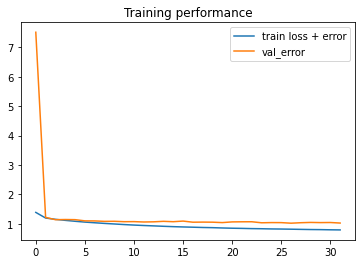

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

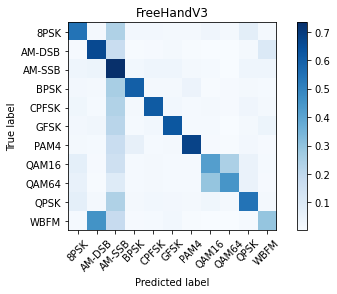

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08320950965824665


Overall Accuracy:  0.10018484288354898


Overall Accuracy:  0.09402615765288087


Overall Accuracy:  0.12543921293042867


Overall Accuracy:  0.1546242774566474


Overall Accuracy:  0.21661296097386323


Overall Accuracy:  0.3131494088140451


Overall Accuracy:  0.43859011627906974


Overall Accuracy:  0.5985090521831736


Overall Accuracy:  0.7372393961179008


Overall Accuracy:  0.8035584604212055


Overall Accuracy:  0.8326721961774252


Overall Accuracy:  0.844022770398482


Overall Accuracy:  0.8406716417910448


Overall Accuracy:  0.840778097982709


Overall Accuracy:  0.8428727670433832


Overall Accuracy:  0.8430211032950758


Overall Accuracy:  0.8345242572395637


Overall Accuracy:  0.8441414885777451


Overall Accuracy:  0.8476702508960573


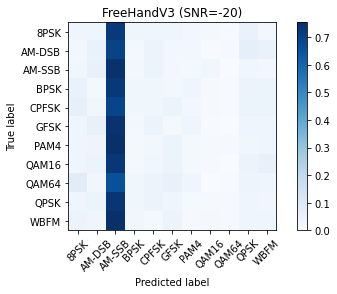

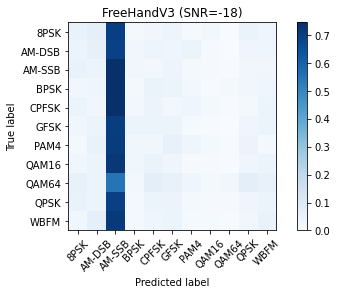

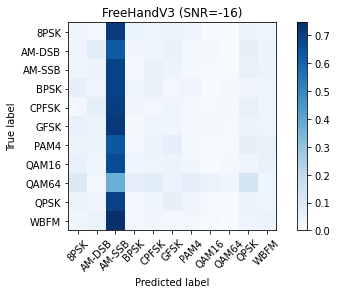

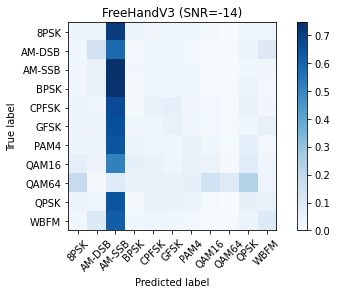

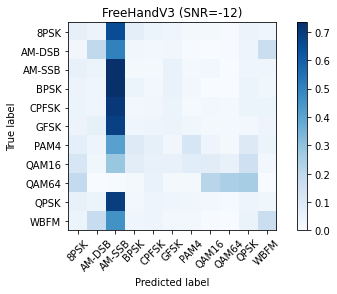

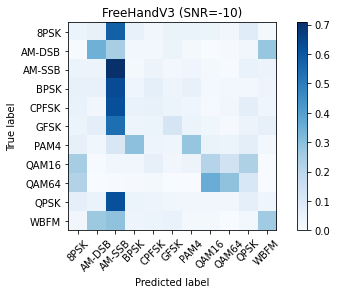

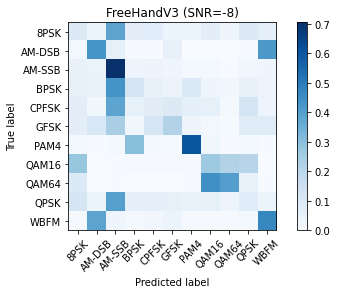

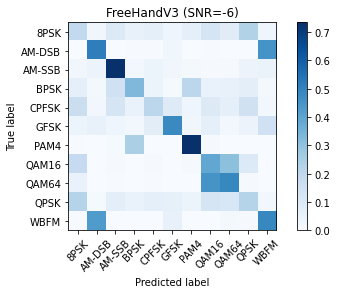

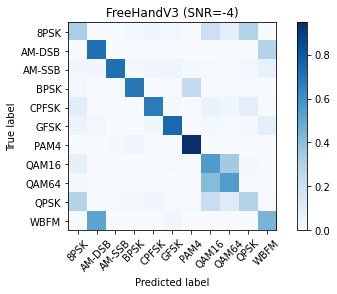

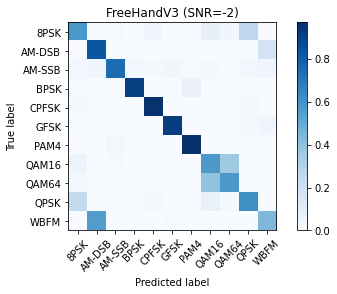

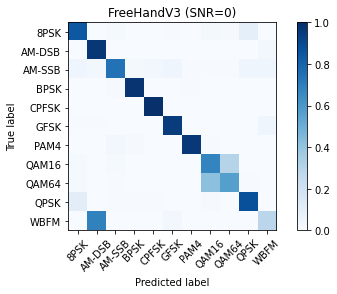

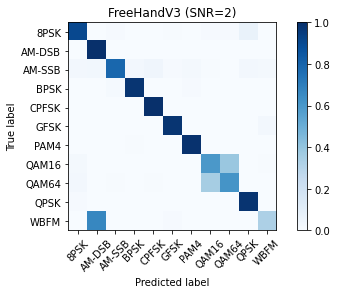

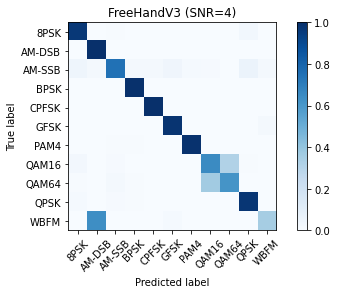

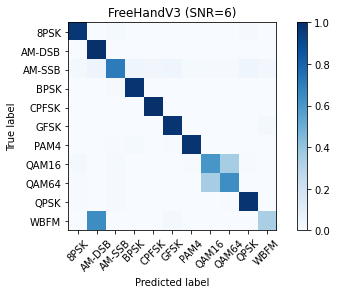

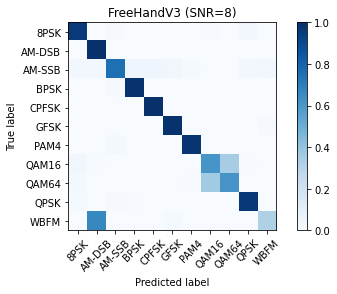

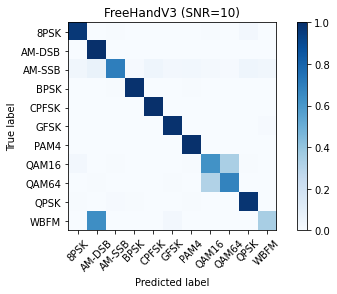

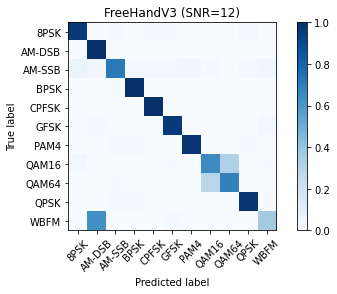

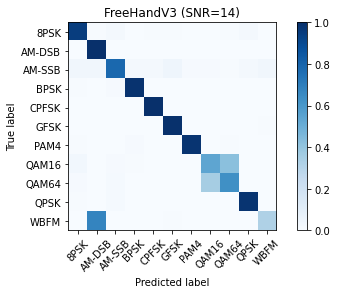

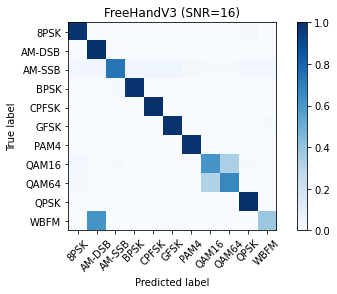

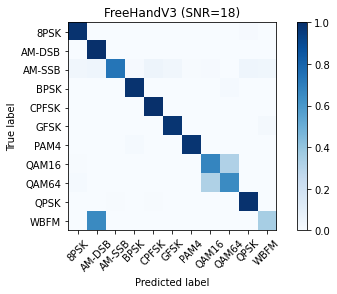

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

-20  -18  -16  -14  -12  -10  -8   -6   -4   -2    0    2    4   \
Accuracy %    8   10    9   12   15   21   31   43   59   73   80   83   84   

             6    8    10   12   14   16   18  
Accuracy %   84   84   84   84   83   84   84

In [18]:
import statistics

statistics.mean(acc.values())

0.5617758984386249

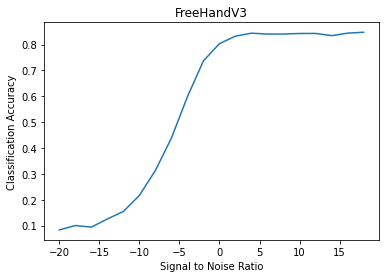

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)